Nama         : Ghozy Ghulamul Afif

NIM          : 1301170379

Judul TA     : Implementasi Information Gain (IG) dan Genetic Algorithm (GA) untuk Reduksi Dimensi pada Klasifikasi Data Microarray Menggunakan Functional Link Neural Network (FLNN)

Pembimbing 1 : Widi Astuti, S.T., M.Kom.

Pembimbing 2 : Prof. Dr. Adiwijaya

# 1. Preprocessing

## 1.1. Import Library

In [1]:
import pandas as pd
from sklearn.preprocessing import  MinMaxScaler
from pandas import DataFrame
from scipy.special import legendre
import numpy as np
from sklearn.model_selection import StratifiedKFold
import matplotlib.pyplot as plt
import keras
from tensorflow.python.keras.layers import Dense
from keras.optimizers import Adam
from tensorflow.python.keras import Sequential
from sklearn.metrics import accuracy_score, f1_score
from sklearn.metrics import classification_report
import random
import timeit
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import mutual_info_classif
from sklearn.feature_selection import SelectKBest

## 1.2. Import Dataset

In [2]:
# data breast
url_test = "https://raw.githubusercontent.com/jamessaldo/final-task/master/breastCancer_test.data"
url_train =  "https://raw.githubusercontent.com/jamessaldo/final-task/master/breastCancer_train.data"
data_train = pd.read_csv(url_test, header=None)
data_test = pd.read_csv(url_train, header=None)
data_breast = data_train.append(data_test, ignore_index = True)

## 1.3. Check Missing Value

In [3]:
print('Total Missing Value pada Data Breast Cancer:',data_breast.isnull().sum().sum())

Total Missing Value pada Data Breast Cancer: 0


## 1.4. Normalization

In [4]:
# Melakukan normalisasi
# data breast
data_new_breast = data_breast.drop([24481],axis=1)
scaler = MinMaxScaler()
data_new_breast = scaler.fit_transform(data_new_breast)
data_new_breast = DataFrame(data_new_breast)
data_new_breast['label'] = list(data_breast[24481])
dic = {'non-relapse':0, 'relapse':1}
data_new_breast.replace(dic,inplace=True)

# 2. Define Reusable Function

## Fitness Function

In [5]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
def fitness(dataset, orde):
  start = timeit.default_timer()
  X = pd.DataFrame(dataset.iloc[:, 0:len(dataset.columns)-1].values)
  Y = pd.DataFrame(dataset.iloc[:, len(dataset.columns)-1].values)

  df_ = pd.DataFrame()
  for x in range(1, orde+1):
    pn = legendre(x)
    y_orde = pn(X)
    df_ = pd.concat([df_, y_orde], axis=1)
  df_.columns = ["Attribut"+str(i) for i in range(len(df_.columns))]
  df_['label'] = Y
  data = df_.iloc[:, 0:len(df_.columns)-1].values
  label = df_.iloc[:, len(df_.columns)-1].values

  # # Melakukan proses klasifikasi LR
  X_train, X_test, y_train, y_test = train_test_split(data, label, test_size=0.33, random_state=42)
  # Inisialisasi FLNN
  Model = Sequential()
  # Menambah input layer dan hidden layer pertama
  Model.add(Dense(units = len(df_.columns)-1, kernel_initializer = 'uniform', activation = 'relu', input_dim = len(df_.columns)-1))
  # Menambah hidden layer kedua
  Model.add(Dense(units = len(df_.columns)-1, kernel_initializer = 'uniform', activation = 'relu'))
  # Menambah output layer
  Model.add(Dense(units = 1, kernel_initializer = 'uniform', activation = 'sigmoid'))
  # Menjalankan ANN
  Model.compile(optimizer = Adam(learning_rate=0.001), loss = 'binary_crossentropy', metrics = ['accuracy'])
  # Fitting ANN ke training set
  history = Model.fit(X_train, y_train, batch_size = 35, epochs = 100, validation_split = 0.2, verbose=False)

  #Memprediksi hasil test set
  y_pred = Model(X_test)
  y_pred =(y_pred >= 0.5)

  F1 = f1_score(y_test, y_pred, average='macro')

  print("F1 Score : ", F1)

  stop = timeit.default_timer()
  print('Running Time: ', stop - start) 
  return F1

## FLNN Classifier

In [6]:
def FLNN_Classifier(dataset, cancer_name, orde):
  start = timeit.default_timer()
  X = dataset.drop(['label'], axis=1)
  Y = dataset['label']
  df_ = pd.DataFrame()
  for x in range(1, orde+1):
    pn = legendre(x)
    y_orde = pn(X)
    df_ = pd.concat([df_, y_orde], axis=1)
  df_.columns = ["Attribut"+str(i) for i in range(len(df_.columns))]
  df_['label'] = Y.reset_index().label
  data = df_.iloc[:, 0:len(df_.columns)-1].values
  label = df_.iloc[:, len(df_.columns)-1].values

  # Melakukan proses K-Fold
  kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=10)
  kf.get_n_splits(df_)

  # Melakukan proses klasifikasi FLNN
  Hasil_Akurasi = []
  Hasil_F1 = []
  for train_index, test_index in kf.split(X,Y):
    print("Train :" , train_index, "Test :", test_index)
    X_train, X_test, y_train, y_test = data[train_index], data[test_index], label[train_index], label[test_index]
    # Inisialisasi FLNN
    Model = Sequential()
    # Menambah input layer dan hidden layer pertama
    Model.add(Dense(units = len(df_.columns)-1, kernel_initializer = 'uniform', activation = 'relu', input_dim = len(df_.columns)-1))
    # Menambah hidden layer kedua
    Model.add(Dense(units = len(df_.columns)-1, kernel_initializer = 'uniform', activation = 'relu'))
    # Menambah output layer
    Model.add(Dense(units = 1, kernel_initializer = 'uniform', activation = 'sigmoid'))
    # Menjalankan ANN
    Model.compile(optimizer = Adam(learning_rate=0.001), loss = 'binary_crossentropy', metrics = ['accuracy'])
    # Fitting ANN ke training set
    history = Model.fit(X_train, y_train, batch_size = 35, epochs = 100, validation_split = 0.2, verbose=False)

    #Memprediksi hasil test set
    y_pred = Model(X_test)
    y_pred =(y_pred >= 0.5)

    #print("X_Train :", X_train)
    print("Y_Train :", y_train)

    #print("X_Test :", X_test)
    print("Y_Test :", y_test)

    hasil = accuracy_score(y_test,y_pred)
    F1 = f1_score(y_test, y_pred, average='macro')
    #F1 = f1_score(y_test, y_pred, average)

    print("Akurasi : ", hasil)
    print("F1_Score : ", F1)
    print(classification_report(y_test,y_pred))
    Hasil_Akurasi.append(hasil)
    Hasil_F1.append(F1)

    # Membuat confusion matrix
    from sklearn.metrics import confusion_matrix 
    from mlxtend.plotting import plot_confusion_matrix
    cm = confusion_matrix(y_test, y_pred)
    fig, ax = plot_confusion_matrix(conf_mat = cm, figsize=(5,5))
    plt.show()

  Akurasi = np.array(Hasil_Akurasi)
  F1_Score = np.array(Hasil_F1)
  avg_akurasi = Akurasi.mean()
  avg_F1 = F1_Score.mean()

  print("avg accuraccy "+cancer_name+" = ",avg_akurasi)
  print("avg F1_Score "+cancer_name+" = ",avg_F1)

  print("max accuraccy "+cancer_name+" = ",Akurasi.max())
  print("max F1_Score "+cancer_name+" = ",F1_Score.max())

  print("min accuraccy "+cancer_name+" = ",Akurasi.min())
  print("min F1_Score "+cancer_name+" = ",F1_Score.min())
  
  stop = timeit.default_timer()
  print('Running Time: ', stop - start) 
  return avg_akurasi, avg_F1

## Genetic Algorithm

In [7]:
# define parameters
mutationRate = 0.1
crossoverRate = 0.8
populationSize = 10
maxGen = 5

def GenerateGene(lengthOfGen):
  genes = [] # menyimpan index feature
  for j in range(lengthOfGen):
    genes.append(random.randint(0,1))
  return genes

def GeneratePopulation(lengthOfGen):
  population = []
  for i in range(populationSize):
    individu = GenerateGene(lengthOfGen)
    population.append(individu)
  return population

def CrossOver(parent_1, parent_2, rate, lengthOfGen): #Random Point Method
  new_pop = [] 
  for i in range((populationSize - 2) // 2):
    if random.random() < rate:
      CP = random.randint(0,lengthOfGen) #CrossPoint
      child = parent_1[0:CP] + parent_2[CP:len(parent_2)]
      new_pop.append(child)
      child = parent_2[0:CP] + parent_1[CP:len(parent_1)]
      new_pop.append(child)
    else:
      new_pop.append(parent_1)
      new_pop.append(parent_2)
  return new_pop

def Mutation(mutant, rate, lengthOfGen):
  for i in range(len(mutant)):
    # memutasi tiap gen yang memiliki kemungkinan < rate(0.1)
    for j in range(lengthOfGen):
      if random.random() <= rate:
        mutant[i][j] = 1 - mutant[i][j]
  return mutant

def ZeroGene(indv): #pengecekan apakah gen isinya kosong atau tidak
  total = 0
  for i in range(len(indv)):
    if indv[i] == 0:
      total += 1
  if len(indv) == total:
    return True
  else:
    return False

def Classification(indv, dataset, orde): #using Entropy as fitness
  datasetGA = pd.DataFrame()
  idxDatasetGA = 0
  for i in range(len(dataset.columns)-1):
    if indv[i] == 1:
      datasetGA[idxDatasetGA] = dataset[i]
      idxDatasetGA += 1
  datasetGA['label'] = dataset['label']
  Acc_score, F1_score = FLNN_Classifier(datasetGA, "Breast Cancer", orde)
  totalFeatures = idxDatasetGA+1
  return Acc_score, F1_score, totalFeatures

In [8]:
def GeneticAlgorithm(dataset,orde):
  start = timeit.default_timer()
  # Initial Population
  lengthOfGen = len(dataset.columns) - 1 # panjang gene = panjang fitur tanpa label

  # fintess evaluation
  bestF1 = 0
  bestAcc = 0
  bestNFeature = len(dataset.columns) - 1
  best_gene = []
  best_gene_2 = []
  population = GeneratePopulation(lengthOfGen) # Generate 1st Generation
  generation = 0 #max generation = 2**len(feature)

  while (generation < maxGen and (bestF1*100) < 90):
    print('Generation :',generation)
    fitness = pd.DataFrame()
    acc = []
    f1score = []
    # ent = []
    nFeature = []
    gene = []
    i = 0
    while (i < len(population)):
      if ZeroGene(population[i]) == False:
        print('gene :', population[i])
        accuracy, f1, totalFeatures = Classification(population[i], dataset, orde) # Count Fitness Value
        acc.append(accuracy)
        f1score.append(f1)
        nFeature.append(totalFeatures)
        gene.append(population[i])
      i += 1

    fitness['gene'] = gene
    fitness['feature'] = nFeature
    fitness['f1_score'] = f1score
    fitness['accuracy'] = acc

    fitness = fitness.sort_values(['f1_score'],ascending=False)
    
    last_bestF1 = bestF1
    last_bestAcc = bestAcc
    last_bestNFeature = bestNFeature
    last_best_gene = best_gene
    last_best_gene_2 = best_gene_2
    
    if last_bestF1 > fitness['f1_score'][fitness.index[0]]:
        bestF1 = last_bestF1
        bestAcc = last_bestAcc
        bestNFeature = last_bestNFeature
        # select parent
        best_gene = last_best_gene
        best_gene_2 = last_best_gene_2
    else:
        bestF1 = fitness['f1_score'][fitness.index[0]]
        bestAcc = fitness['accuracy'][fitness.index[0]]
        bestNFeature = fitness['feature'][fitness.index[0]]
        # select parent
        best_gene = fitness['gene'][fitness.index[0]].copy()
        best_gene_2 = fitness['gene'][fitness.index[1]].copy()

    #Crossover methods: Fixed Point, "Random Point", Alternate Point
    population = CrossOver(best_gene.copy(), best_gene_2.copy(), crossoverRate, lengthOfGen)

    # Mutation
    population = Mutation(population, mutationRate, lengthOfGen)

    # Masukkan best child tadi
    population.append(best_gene)
    population.append(best_gene_2)

    # Print Result
    print('===============================================================================================================================================================================================================')
    print('gen terbaik :', best_gene)
    print('F-1 Score terbaik :',bestF1,' || Akurasi terbaik :',bestAcc,' || jumlah fitur :',bestNFeature)
    print()

    # New Generation
    generation += 1
  listDrop = []
  for i in range(len(dataset.columns)-1):
    if best_gene[i] == 0:
      listDrop.append(dataset.columns[i])
  dataset_GA = dataset.drop(listDrop, axis = 1)
  stop = timeit.default_timer()
  print('Running Time: ', stop - start)
  return dataset_GA

# 3. Feature Selection with IG

## Breast

In [9]:
data_X = data_new_breast.drop(['label'],axis=1)
data_Y = data_new_breast['label']

X_train, X_test, Y_train, Y_test = train_test_split(data_X, data_Y, test_size=0.3, random_state=0)

sel_k_best = SelectKBest(mutual_info_classif, k=100)
sel_k_best.fit(data_X, data_Y)
data_X_new = sel_k_best.transform(data_X)

Breast_IG = pd.DataFrame(data_X_new)
Breast_IG['label'] = data_Y
useddata_breast = Breast_IG
print(useddata_breast.shape)
Breast_IG

(97, 101)


0         1         2         3         4         5         6  \
0   0.020000  0.138947  0.006717  0.531469  0.011071  0.008422  0.003883   
1   0.019176  0.168947  0.007284  0.955711  0.010972  0.004524  0.004291   
2   0.019667  0.062105  0.005363  0.742424  0.011041  0.008155  0.002270   
3   0.020618  0.046316  0.007254  0.360140  0.009787  0.007926  0.001971   
4   0.020588  0.137895  0.005831  1.000000  0.012028  0.007996  0.006093   
..       ...       ...       ...       ...       ...       ...       ...   
92  0.018873  0.218947  0.004199  0.865967  0.012858  0.007073  0.005486   
93  0.019725  0.120526  0.005264  0.336830  0.003674  0.005436  0.024303   
94  0.019324  0.174211  0.006458  0.368298  0.013885  0.007291  0.006282   
95  0.020127  0.119474  0.005254  0.607226  0.012325  0.008859  0.005107   
96  0.018922  0.193684  0.009354  0.745921  0.009678  0.009920  0.005924   

           7         8         9  ...        91        92        93        94  \
0   0.602176  0.374173  0.323552  ...  0.822736  0.292683  0.009419  0.005540   
1   0.879565  0.320223  0.124324  ...  0.000000  0.674058  0.008874  0.007072   
2   0.712510  0.281587  0.858687  ...  0.536609  0.138581  0.009300  0.005053   
3   0.672883  0.363035  0.416988  ...  1.000000  0.184035  0.007981  0.006157   
4   0.729604  0.373477  0.236293  ...  0.348748  0.840355  0.007793  0.005113   
..       ...       ...       ...  ...       ...       ...       ...       ...   
92  0.796426  0.369300  0.581467  ...  0.561657  0.460089  0.009290  0.004963   
93  0.842269  0.396102  0.633205  ...  0.394990  0.227273  0.010738  0.006694   
94  0.770785  0.513749  0.793050  ...  0.368979  0.284922  0.007793  0.003372   
95  0.665890  0.329969  0.602317  ...  0.545279  0.337029  0.009478  0.006794   
96  0.798757  0.535677  0.099614  ...  0.234104  0.248337  0.008963  0.006416   

          95        96        97        98        99  label  
0   0.533149  0.458824  0.443590  0.006083  0.021342      1  
1   0.469613  0.456471  0.484615  0.005834  0.013116      1  
2   0.350829  0.190588  0.524359  0.005396  0.012967      1  
3   0.461326  0.451765  0.805128  0.004072  0.013244      1  
4   0.279006  0.160000  0.276923  0.005466  0.016918      1  
..       ...       ...       ...       ...       ...    ...  
92  0.267956  0.331765  0.410256  0.006551  0.011239      0  
93  0.444751  0.242353  0.366667  0.005217  0.014656      0  
94  0.596685  0.529412  0.697436  0.005327  0.011476      0  
95  0.486188  0.254118  0.561538  0.005775  0.011200      0  
96  0.439227  0.338824  0.612821  0.003405  0.011970      0  

[97 rows x 101 columns]

# 4. Classification

## Breast + IG

Train : [ 0  1  2  3  4  5  6  8 12 13 14 15 16 18 19 20 21 22 23 24 25 26 27 29
 30 31 32 33 35 37 38 39 40 41 42 43 45 46 47 48 50 51 53 54 55 58 60 61
 63 64 65 67 68 69 70 71 72 73 75 76 77 78 79 80 81 82 85 86 87 88 89 90
 91 92 93 94 95] Test : [ 7  9 10 11 17 28 34 36 44 49 52 56 57 59 62 66 74 83 84 96]
Y_Train : [1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0]
Y_Test : [1 1 1 1 0 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0]
Akurasi :  0.85
F1_Score :  0.849624060150376
              precision    recall  f1-score   support

           0       0.89      0.80      0.84        10
           1       0.82      0.90      0.86        10

    accuracy                           0.85        20
   macro avg       0.85      0.85      0.85        20
weighted avg       0.85      0.85      0.85        20



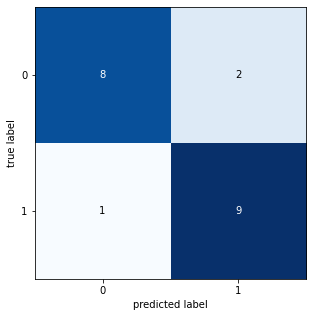

Train : [ 0  2  3  4  5  7  8  9 10 11 14 15 16 17 19 20 21 22 23 25 26 27 28 30
 31 34 35 36 37 38 39 42 43 44 45 46 47 48 49 51 52 53 54 55 56 57 58 59
 60 61 62 63 64 65 66 69 70 72 73 74 75 76 77 80 81 82 83 84 85 86 88 89
 90 91 92 95 96] Test : [ 1  6 12 13 18 24 29 32 33 40 41 50 67 68 71 78 79 87 93 94]
Y_Train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0]
Y_Test : [1 1 0 0 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Akurasi :  0.75
F1_Score :  0.7493734335839599
              precision    recall  f1-score   support

           0       0.80      0.73      0.76        11
           1       0.70      0.78      0.74         9

    accuracy                           0.75        20
   macro avg       0.75      0.75      0.75        20
weighted avg       0.76      0.75      0.75        20



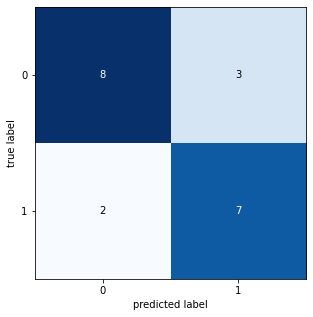

Train : [ 0  1  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 21 22 23 24 26
 28 29 32 33 34 35 36 38 40 41 42 43 44 45 46 48 49 50 51 52 53 54 55 56
 57 59 60 62 65 66 67 68 69 71 74 76 77 78 79 80 81 82 83 84 85 86 87 88
 90 91 92 93 94 96] Test : [ 2 20 25 27 30 31 37 39 47 58 61 63 64 70 72 73 75 89 95]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0]
Akurasi :  0.7894736842105263
F1_Score :  0.788888888888889
              precision    recall  f1-score   support

           0       0.80      0.80      0.80        10
           1       0.78      0.78      0.78         9

    accuracy                           0.79        19
   macro avg       0.79      0.79      0.79        19
weighted avg       0.79      0.79      0.79        19



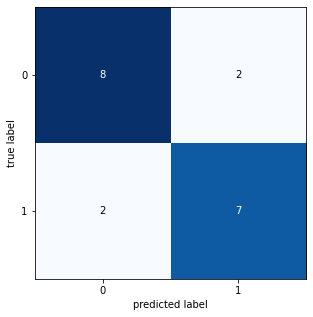

Train : [ 1  2  5  6  7  8  9 10 11 12 13 14 17 18 20 21 22 23 24 25 27 28 29 30
 31 32 33 34 35 36 37 39 40 41 42 43 44 45 47 49 50 52 53 56 57 58 59 61
 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 78 79 82 83 84 85 87 89 90
 91 92 93 94 95 96] Test : [ 0  3  4 15 16 19 26 38 46 48 51 54 55 60 77 80 81 86 88]
Y_Train : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 1 0 0 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Akurasi :  0.7894736842105263
F1_Score :  0.7888888888888888
              precision    recall  f1-score   support

           0       0.88      0.70      0.78        10
           1       0.73      0.89      0.80         9

    accuracy                           0.79        19
   macro avg       0.80      0.79      0.79        19
weighted avg       0.81      0.79      0.79        19



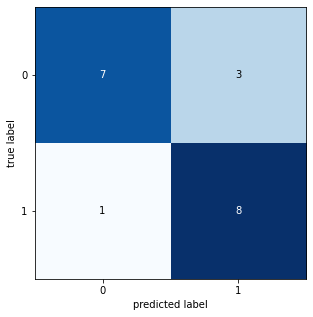

Train : [ 0  1  2  3  4  6  7  9 10 11 12 13 15 16 17 18 19 20 24 25 26 27 28 29
 30 31 32 33 34 36 37 38 39 40 41 44 46 47 48 49 50 51 52 54 55 56 57 58
 59 60 61 62 63 64 66 67 68 70 71 72 73 74 75 77 78 79 80 81 83 84 86 87
 88 89 93 94 95 96] Test : [ 5  8 14 21 22 23 35 42 43 45 53 65 69 76 82 85 90 91 92]
Y_Train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0]
Akurasi :  0.8421052631578947
F1_Score :  0.8403361344537814
              precision    recall  f1-score   support

           0       1.00      0.70      0.82        10
           1       0.75      1.00      0.86         9

    accuracy                           0.84        19
   macro avg       0.88      0.85      0.84        19
weighted avg       0.88      0.84      0.84        19



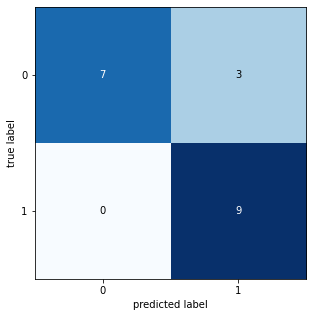

avg accuraccy Breast cancer =  0.8042105263157895
avg F1_Score Breast cancer =  0.8034222811931789
max accuraccy Breast cancer =  0.85
max F1_Score Breast cancer =  0.849624060150376
min accuraccy Breast cancer =  0.75
min F1_Score Breast cancer =  0.7493734335839599
Running Time:  27.792783950999365


(0.8042105263157895, 0.8034222811931789)

In [10]:
FLNN_Classifier(Breast_IG,"Breast cancer",2)

Train : [ 0  1  2  3  4  5  6  8 12 13 14 15 16 18 19 20 21 22 23 24 25 26 27 29
 30 31 32 33 35 37 38 39 40 41 42 43 45 46 47 48 50 51 53 54 55 58 60 61
 63 64 65 67 68 69 70 71 72 73 75 76 77 78 79 80 81 82 85 86 87 88 89 90
 91 92 93 94 95] Test : [ 7  9 10 11 17 28 34 36 44 49 52 56 57 59 62 66 74 83 84 96]
Y_Train : [1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0]
Y_Test : [1 1 1 1 0 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0]
Akurasi :  0.85
F1_Score :  0.849624060150376
              precision    recall  f1-score   support

           0       0.89      0.80      0.84        10
           1       0.82      0.90      0.86        10

    accuracy                           0.85        20
   macro avg       0.85      0.85      0.85        20
weighted avg       0.85      0.85      0.85        20



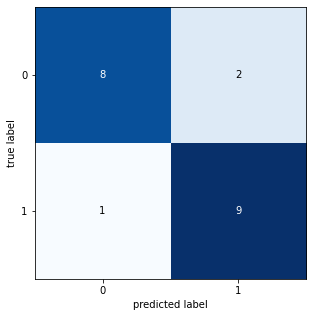

Train : [ 0  2  3  4  5  7  8  9 10 11 14 15 16 17 19 20 21 22 23 25 26 27 28 30
 31 34 35 36 37 38 39 42 43 44 45 46 47 48 49 51 52 53 54 55 56 57 58 59
 60 61 62 63 64 65 66 69 70 72 73 74 75 76 77 80 81 82 83 84 85 86 88 89
 90 91 92 95 96] Test : [ 1  6 12 13 18 24 29 32 33 40 41 50 67 68 71 78 79 87 93 94]
Y_Train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0]
Y_Test : [1 1 0 0 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Akurasi :  0.7
F1_Score :  0.696969696969697
              precision    recall  f1-score   support

           0       0.73      0.73      0.73        11
           1       0.67      0.67      0.67         9

    accuracy                           0.70        20
   macro avg       0.70      0.70      0.70        20
weighted avg       0.70      0.70      0.70        20



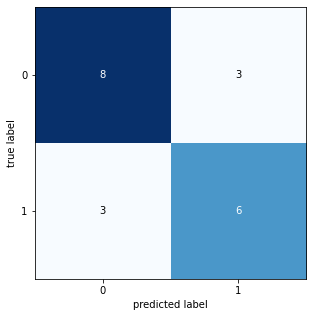

Train : [ 0  1  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 21 22 23 24 26
 28 29 32 33 34 35 36 38 40 41 42 43 44 45 46 48 49 50 51 52 53 54 55 56
 57 59 60 62 65 66 67 68 69 71 74 76 77 78 79 80 81 82 83 84 85 86 87 88
 90 91 92 93 94 96] Test : [ 2 20 25 27 30 31 37 39 47 58 61 63 64 70 72 73 75 89 95]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0]
Akurasi :  0.7368421052631579
F1_Score :  0.7338935574229692
              precision    recall  f1-score   support

           0       0.73      0.80      0.76        10
           1       0.75      0.67      0.71         9

    accuracy                           0.74        19
   macro avg       0.74      0.73      0.73        19
weighted avg       0.74      0.74      0.74        19



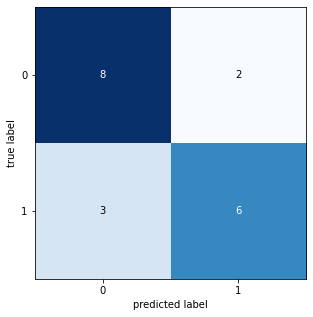

Train : [ 1  2  5  6  7  8  9 10 11 12 13 14 17 18 20 21 22 23 24 25 27 28 29 30
 31 32 33 34 35 36 37 39 40 41 42 43 44 45 47 49 50 52 53 56 57 58 59 61
 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 78 79 82 83 84 85 87 89 90
 91 92 93 94 95 96] Test : [ 0  3  4 15 16 19 26 38 46 48 51 54 55 60 77 80 81 86 88]
Y_Train : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 1 0 0 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Akurasi :  0.7894736842105263
F1_Score :  0.784090909090909
              precision    recall  f1-score   support

           0       1.00      0.60      0.75        10
           1       0.69      1.00      0.82         9

    accuracy                           0.79        19
   macro avg       0.85      0.80      0.78        19
weighted avg       0.85      0.79      0.78        19



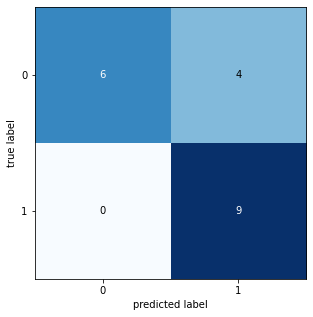

Train : [ 0  1  2  3  4  6  7  9 10 11 12 13 15 16 17 18 19 20 24 25 26 27 28 29
 30 31 32 33 34 36 37 38 39 40 41 44 46 47 48 49 50 51 52 54 55 56 57 58
 59 60 61 62 63 64 66 67 68 70 71 72 73 74 75 77 78 79 80 81 83 84 86 87
 88 89 93 94 95 96] Test : [ 5  8 14 21 22 23 35 42 43 45 53 65 69 76 82 85 90 91 92]
Y_Train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0]
Akurasi :  0.7894736842105263
F1_Score :  0.788888888888889
              precision    recall  f1-score   support

           0       0.80      0.80      0.80        10
           1       0.78      0.78      0.78         9

    accuracy                           0.79        19
   macro avg       0.79      0.79      0.79        19
weighted avg       0.79      0.79      0.79        19



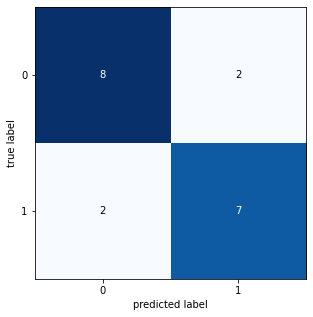

avg accuraccy Breast cancer =  0.773157894736842
avg F1_Score Breast cancer =  0.7706934225045681
max accuraccy Breast cancer =  0.85
max F1_Score Breast cancer =  0.849624060150376
min accuraccy Breast cancer =  0.7
min F1_Score Breast cancer =  0.696969696969697
Running Time:  28.427680375998534


(0.773157894736842, 0.7706934225045681)

In [11]:
FLNN_Classifier(Breast_IG,"Breast cancer",3)

Train : [ 0  1  2  3  4  5  6  8 12 13 14 15 16 18 19 20 21 22 23 24 25 26 27 29
 30 31 32 33 35 37 38 39 40 41 42 43 45 46 47 48 50 51 53 54 55 58 60 61
 63 64 65 67 68 69 70 71 72 73 75 76 77 78 79 80 81 82 85 86 87 88 89 90
 91 92 93 94 95] Test : [ 7  9 10 11 17 28 34 36 44 49 52 56 57 59 62 66 74 83 84 96]
Y_Train : [1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0]
Y_Test : [1 1 1 1 0 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0]
Akurasi :  0.85
F1_Score :  0.849624060150376
              precision    recall  f1-score   support

           0       0.89      0.80      0.84        10
           1       0.82      0.90      0.86        10

    accuracy                           0.85        20
   macro avg       0.85      0.85      0.85        20
weighted avg       0.85      0.85      0.85        20



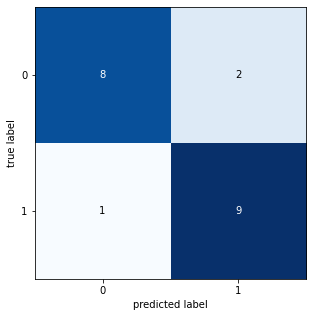

Train : [ 0  2  3  4  5  7  8  9 10 11 14 15 16 17 19 20 21 22 23 25 26 27 28 30
 31 34 35 36 37 38 39 42 43 44 45 46 47 48 49 51 52 53 54 55 56 57 58 59
 60 61 62 63 64 65 66 69 70 72 73 74 75 76 77 80 81 82 83 84 85 86 88 89
 90 91 92 95 96] Test : [ 1  6 12 13 18 24 29 32 33 40 41 50 67 68 71 78 79 87 93 94]
Y_Train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0]
Y_Test : [1 1 0 0 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Akurasi :  0.75
F1_Score :  0.7493734335839599
              precision    recall  f1-score   support

           0       0.80      0.73      0.76        11
           1       0.70      0.78      0.74         9

    accuracy                           0.75        20
   macro avg       0.75      0.75      0.75        20
weighted avg       0.76      0.75      0.75        20



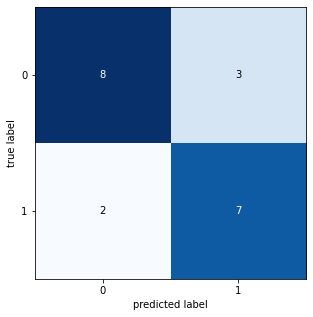

Train : [ 0  1  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 21 22 23 24 26
 28 29 32 33 34 35 36 38 40 41 42 43 44 45 46 48 49 50 51 52 53 54 55 56
 57 59 60 62 65 66 67 68 69 71 74 76 77 78 79 80 81 82 83 84 85 86 87 88
 90 91 92 93 94 96] Test : [ 2 20 25 27 30 31 37 39 47 58 61 63 64 70 72 73 75 89 95]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0]
Akurasi :  0.7368421052631579
F1_Score :  0.7338935574229692
              precision    recall  f1-score   support

           0       0.73      0.80      0.76        10
           1       0.75      0.67      0.71         9

    accuracy                           0.74        19
   macro avg       0.74      0.73      0.73        19
weighted avg       0.74      0.74      0.74        19



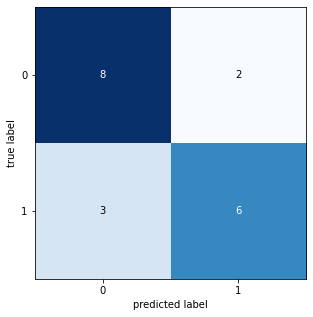

Train : [ 1  2  5  6  7  8  9 10 11 12 13 14 17 18 20 21 22 23 24 25 27 28 29 30
 31 32 33 34 35 36 37 39 40 41 42 43 44 45 47 49 50 52 53 56 57 58 59 61
 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 78 79 82 83 84 85 87 89 90
 91 92 93 94 95 96] Test : [ 0  3  4 15 16 19 26 38 46 48 51 54 55 60 77 80 81 86 88]
Y_Train : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 1 0 0 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Akurasi :  0.7368421052631579
F1_Score :  0.7338935574229692
              precision    recall  f1-score   support

           0       0.86      0.60      0.71        10
           1       0.67      0.89      0.76         9

    accuracy                           0.74        19
   macro avg       0.76      0.74      0.73        19
weighted avg       0.77      0.74      0.73        19



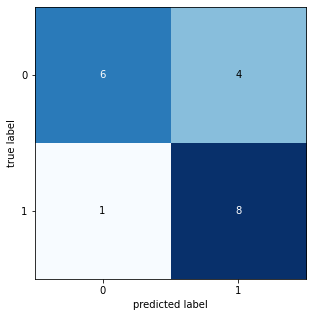

Train : [ 0  1  2  3  4  6  7  9 10 11 12 13 15 16 17 18 19 20 24 25 26 27 28 29
 30 31 32 33 34 36 37 38 39 40 41 44 46 47 48 49 50 51 52 54 55 56 57 58
 59 60 61 62 63 64 66 67 68 70 71 72 73 74 75 77 78 79 80 81 83 84 86 87
 88 89 93 94 95 96] Test : [ 5  8 14 21 22 23 35 42 43 45 53 65 69 76 82 85 90 91 92]
Y_Train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0]
Akurasi :  0.7368421052631579
F1_Score :  0.7368421052631577
              precision    recall  f1-score   support

           0       0.78      0.70      0.74        10
           1       0.70      0.78      0.74         9

    accuracy                           0.74        19
   macro avg       0.74      0.74      0.74        19
weighted avg       0.74      0.74      0.74        19



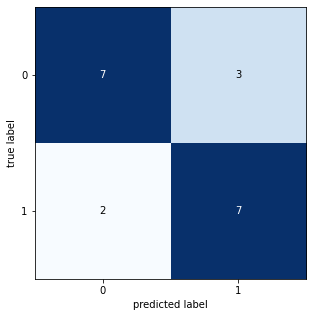

avg accuraccy Breast cancer =  0.7621052631578948
avg F1_Score Breast cancer =  0.7607253427686864
max accuraccy Breast cancer =  0.85
max F1_Score Breast cancer =  0.849624060150376
min accuraccy Breast cancer =  0.7368421052631579
min F1_Score Breast cancer =  0.7338935574229692
Running Time:  27.691242072000023


(0.7621052631578948, 0.7607253427686864)

In [12]:
FLNN_Classifier(Breast_IG,"Breast cancer",4)

## Breast + IG + GA

Generation : 0
gene : [1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1]
Train : [ 0  1  2  3  4  5  6  8 12 13 14 15 16 18 19 20 21 22 23 24 25 26 27 29
 30 31 32 33 35 37 38 39 40 41 42 43 45 46 47 48 50 51 53 54 55 58 60 61
 63 64 65 67 68 69 70 71 72 73 75 76 77 78 79 80 81 82 85 86 87 88 89 90
 91 92 93 94 95] Test : [ 7  9 10 11 17 28 34 36 44 49 52 56 57 59 62 66 74 83 84 96]
Y_Train : [1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0]
Y_Test : [1 1 1 1 0 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0]
Akurasi :  0.75
F1_Score :  0.7493734335839599
              precision    recall  f1-score   support

           0       0.78      0.70      0.74

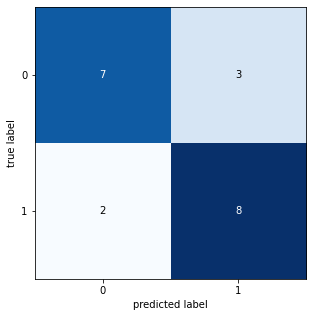

Train : [ 0  2  3  4  5  7  8  9 10 11 14 15 16 17 19 20 21 22 23 25 26 27 28 30
 31 34 35 36 37 38 39 42 43 44 45 46 47 48 49 51 52 53 54 55 56 57 58 59
 60 61 62 63 64 65 66 69 70 72 73 74 75 76 77 80 81 82 83 84 85 86 88 89
 90 91 92 95 96] Test : [ 1  6 12 13 18 24 29 32 33 40 41 50 67 68 71 78 79 87 93 94]
Y_Train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0]
Y_Test : [1 1 0 0 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Akurasi :  0.75
F1_Score :  0.7442455242966752
              precision    recall  f1-score   support

           0       0.75      0.82      0.78        11
           1       0.75      0.67      0.71         9

    accuracy                           0.75        20
   macro avg       0.75      0.74      0.74        20
weighted avg       0.75      0.75      0.75        20



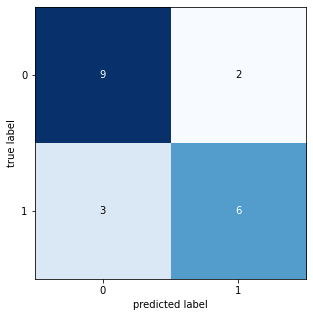

Train : [ 0  1  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 21 22 23 24 26
 28 29 32 33 34 35 36 38 40 41 42 43 44 45 46 48 49 50 51 52 53 54 55 56
 57 59 60 62 65 66 67 68 69 71 74 76 77 78 79 80 81 82 83 84 85 86 87 88
 90 91 92 93 94 96] Test : [ 2 20 25 27 30 31 37 39 47 58 61 63 64 70 72 73 75 89 95]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0]
Akurasi :  0.6842105263157895
F1_Score :  0.6833333333333333
              precision    recall  f1-score   support

           0       0.70      0.70      0.70        10
           1       0.67      0.67      0.67         9

    accuracy                           0.68        19
   macro avg       0.68      0.68      0.68        19
weighted avg       0.68      0.68      0.68        19



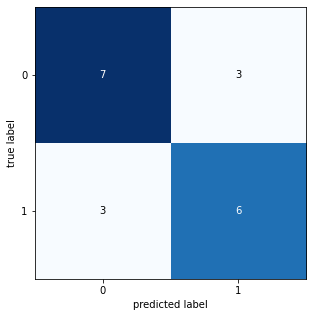

Train : [ 1  2  5  6  7  8  9 10 11 12 13 14 17 18 20 21 22 23 24 25 27 28 29 30
 31 32 33 34 35 36 37 39 40 41 42 43 44 45 47 49 50 52 53 56 57 58 59 61
 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 78 79 82 83 84 85 87 89 90
 91 92 93 94 95 96] Test : [ 0  3  4 15 16 19 26 38 46 48 51 54 55 60 77 80 81 86 88]
Y_Train : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 1 0 0 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Akurasi :  0.7368421052631579
F1_Score :  0.7368421052631577
              precision    recall  f1-score   support

           0       0.78      0.70      0.74        10
           1       0.70      0.78      0.74         9

    accuracy                           0.74        19
   macro avg       0.74      0.74      0.74        19
weighted avg       0.74      0.74      0.74        19



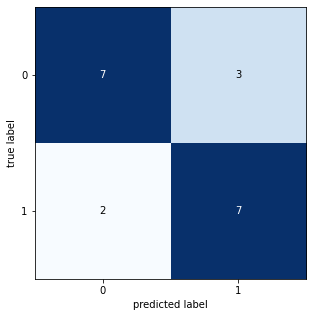

Train : [ 0  1  2  3  4  6  7  9 10 11 12 13 15 16 17 18 19 20 24 25 26 27 28 29
 30 31 32 33 34 36 37 38 39 40 41 44 46 47 48 49 50 51 52 54 55 56 57 58
 59 60 61 62 63 64 66 67 68 70 71 72 73 74 75 77 78 79 80 81 83 84 86 87
 88 89 93 94 95 96] Test : [ 5  8 14 21 22 23 35 42 43 45 53 65 69 76 82 85 90 91 92]
Y_Train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0]
Akurasi :  0.7894736842105263
F1_Score :  0.784090909090909
              precision    recall  f1-score   support

           0       1.00      0.60      0.75        10
           1       0.69      1.00      0.82         9

    accuracy                           0.79        19
   macro avg       0.85      0.80      0.78        19
weighted avg       0.85      0.79      0.78        19



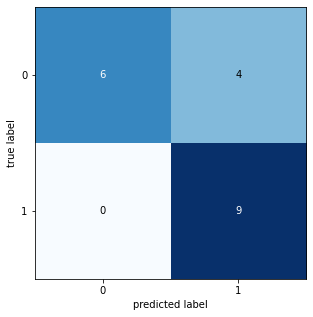

avg accuraccy Breast Cancer =  0.7421052631578947
avg F1_Score Breast Cancer =  0.739577061113607
max accuraccy Breast Cancer =  0.7894736842105263
max F1_Score Breast Cancer =  0.784090909090909
min accuraccy Breast Cancer =  0.6842105263157895
min F1_Score Breast Cancer =  0.6833333333333333
Running Time:  39.16103949100034
gene : [1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0]
Train : [ 0  1  2  3  4  5  6  8 12 13 14 15 16 18 19 20 21 22 23 24 25 26 27 29
 30 31 32 33 35 37 38 39 40 41 42 43 45 46 47 48 50 51 53 54 55 58 60 61
 63 64 65 67 68 69 70 71 72 73 75 76 77 78 79 80 81 82 85 86 87 88 89 90
 91 92 93 94 95] Test : [ 7  9 10 11 17 28 34 36 44 49 52 56 57 59 62 66 74 83 84 96]
Y_Train : [1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 

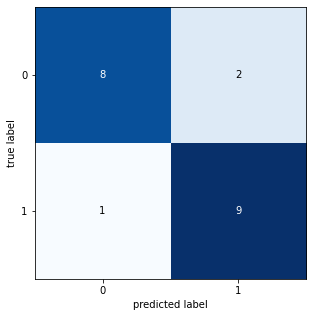

Train : [ 0  2  3  4  5  7  8  9 10 11 14 15 16 17 19 20 21 22 23 25 26 27 28 30
 31 34 35 36 37 38 39 42 43 44 45 46 47 48 49 51 52 53 54 55 56 57 58 59
 60 61 62 63 64 65 66 69 70 72 73 74 75 76 77 80 81 82 83 84 85 86 88 89
 90 91 92 95 96] Test : [ 1  6 12 13 18 24 29 32 33 40 41 50 67 68 71 78 79 87 93 94]
Y_Train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0]
Y_Test : [1 1 0 0 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Akurasi :  0.55
F1_Score :  0.5396419437340154
              precision    recall  f1-score   support

           0       0.67      0.36      0.47        11
           1       0.50      0.78      0.61         9

    accuracy                           0.55        20
   macro avg       0.58      0.57      0.54        20
weighted avg       0.59      0.55      0.53        20



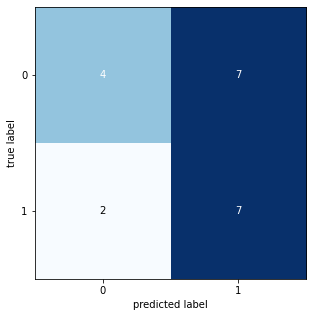

Train : [ 0  1  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 21 22 23 24 26
 28 29 32 33 34 35 36 38 40 41 42 43 44 45 46 48 49 50 51 52 53 54 55 56
 57 59 60 62 65 66 67 68 69 71 74 76 77 78 79 80 81 82 83 84 85 86 87 88
 90 91 92 93 94 96] Test : [ 2 20 25 27 30 31 37 39 47 58 61 63 64 70 72 73 75 89 95]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0]
Akurasi :  0.7368421052631579
F1_Score :  0.7338935574229692
              precision    recall  f1-score   support

           0       0.73      0.80      0.76        10
           1       0.75      0.67      0.71         9

    accuracy                           0.74        19
   macro avg       0.74      0.73      0.73        19
weighted avg       0.74      0.74      0.74        19



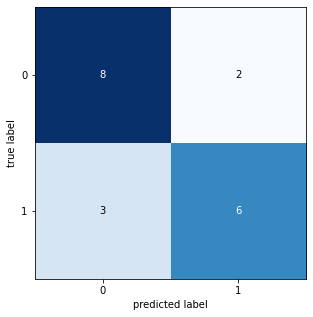

Train : [ 1  2  5  6  7  8  9 10 11 12 13 14 17 18 20 21 22 23 24 25 27 28 29 30
 31 32 33 34 35 36 37 39 40 41 42 43 44 45 47 49 50 52 53 56 57 58 59 61
 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 78 79 82 83 84 85 87 89 90
 91 92 93 94 95 96] Test : [ 0  3  4 15 16 19 26 38 46 48 51 54 55 60 77 80 81 86 88]
Y_Train : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 1 0 0 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Akurasi :  0.7894736842105263
F1_Score :  0.7888888888888888
              precision    recall  f1-score   support

           0       0.88      0.70      0.78        10
           1       0.73      0.89      0.80         9

    accuracy                           0.79        19
   macro avg       0.80      0.79      0.79        19
weighted avg       0.81      0.79      0.79        19



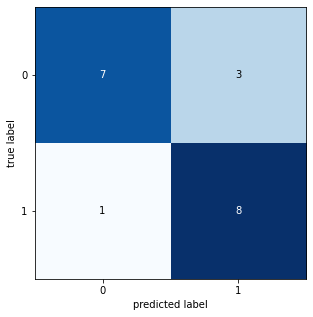

Train : [ 0  1  2  3  4  6  7  9 10 11 12 13 15 16 17 18 19 20 24 25 26 27 28 29
 30 31 32 33 34 36 37 38 39 40 41 44 46 47 48 49 50 51 52 54 55 56 57 58
 59 60 61 62 63 64 66 67 68 70 71 72 73 74 75 77 78 79 80 81 83 84 86 87
 88 89 93 94 95 96] Test : [ 5  8 14 21 22 23 35 42 43 45 53 65 69 76 82 85 90 91 92]
Y_Train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0]
Akurasi :  0.7894736842105263
F1_Score :  0.784090909090909
              precision    recall  f1-score   support

           0       1.00      0.60      0.75        10
           1       0.69      1.00      0.82         9

    accuracy                           0.79        19
   macro avg       0.85      0.80      0.78        19
weighted avg       0.85      0.79      0.78        19



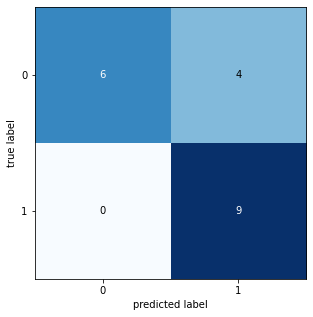

avg accuraccy Breast Cancer =  0.7431578947368422
avg F1_Score Breast Cancer =  0.7392278718574318
max accuraccy Breast Cancer =  0.85
max F1_Score Breast Cancer =  0.849624060150376
min accuraccy Breast Cancer =  0.55
min F1_Score Breast Cancer =  0.5396419437340154
Running Time:  39.99311289400066
gene : [0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0]
Train : [ 0  1  2  3  4  5  6  8 12 13 14 15 16 18 19 20 21 22 23 24 25 26 27 29
 30 31 32 33 35 37 38 39 40 41 42 43 45 46 47 48 50 51 53 54 55 58 60 61
 63 64 65 67 68 69 70 71 72 73 75 76 77 78 79 80 81 82 85 86 87 88 89 90
 91 92 93 94 95] Test : [ 7  9 10 11 17 28 34 36 44 49 52 56 57 59 62 66 74 83 84 96]
Y_Train : [1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1

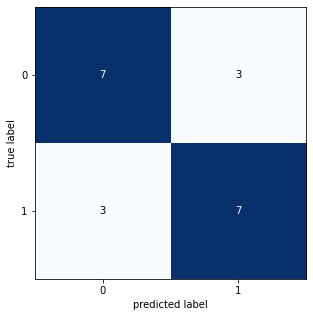

Train : [ 0  2  3  4  5  7  8  9 10 11 14 15 16 17 19 20 21 22 23 25 26 27 28 30
 31 34 35 36 37 38 39 42 43 44 45 46 47 48 49 51 52 53 54 55 56 57 58 59
 60 61 62 63 64 65 66 69 70 72 73 74 75 76 77 80 81 82 83 84 85 86 88 89
 90 91 92 95 96] Test : [ 1  6 12 13 18 24 29 32 33 40 41 50 67 68 71 78 79 87 93 94]
Y_Train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0]
Y_Test : [1 1 0 0 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Akurasi :  0.75
F1_Score :  0.7493734335839599
              precision    recall  f1-score   support

           0       0.88      0.64      0.74        11
           1       0.67      0.89      0.76         9

    accuracy                           0.75        20
   macro avg       0.77      0.76      0.75        20
weighted avg       0.78      0.75      0.75        20



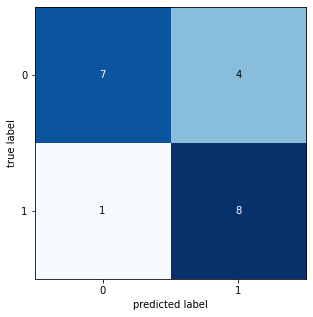

Train : [ 0  1  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 21 22 23 24 26
 28 29 32 33 34 35 36 38 40 41 42 43 44 45 46 48 49 50 51 52 53 54 55 56
 57 59 60 62 65 66 67 68 69 71 74 76 77 78 79 80 81 82 83 84 85 86 87 88
 90 91 92 93 94 96] Test : [ 2 20 25 27 30 31 37 39 47 58 61 63 64 70 72 73 75 89 95]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0]
Akurasi :  0.7368421052631579
F1_Score :  0.7338935574229692
              precision    recall  f1-score   support

           0       0.73      0.80      0.76        10
           1       0.75      0.67      0.71         9

    accuracy                           0.74        19
   macro avg       0.74      0.73      0.73        19
weighted avg       0.74      0.74      0.74        19



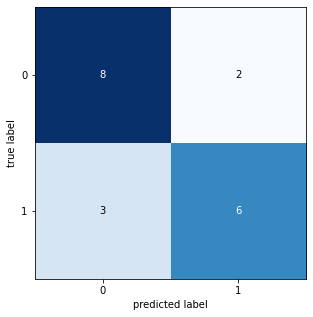

Train : [ 1  2  5  6  7  8  9 10 11 12 13 14 17 18 20 21 22 23 24 25 27 28 29 30
 31 32 33 34 35 36 37 39 40 41 42 43 44 45 47 49 50 52 53 56 57 58 59 61
 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 78 79 82 83 84 85 87 89 90
 91 92 93 94 95 96] Test : [ 0  3  4 15 16 19 26 38 46 48 51 54 55 60 77 80 81 86 88]
Y_Train : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 1 0 0 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Akurasi :  0.6842105263157895
F1_Score :  0.6833333333333333
              precision    recall  f1-score   support

           0       0.70      0.70      0.70        10
           1       0.67      0.67      0.67         9

    accuracy                           0.68        19
   macro avg       0.68      0.68      0.68        19
weighted avg       0.68      0.68      0.68        19



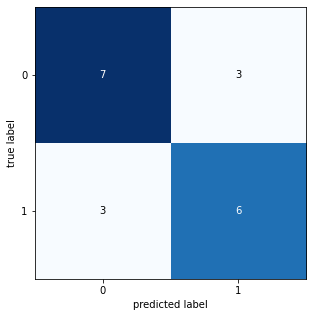

Train : [ 0  1  2  3  4  6  7  9 10 11 12 13 15 16 17 18 19 20 24 25 26 27 28 29
 30 31 32 33 34 36 37 38 39 40 41 44 46 47 48 49 50 51 52 54 55 56 57 58
 59 60 61 62 63 64 66 67 68 70 71 72 73 74 75 77 78 79 80 81 83 84 86 87
 88 89 93 94 95 96] Test : [ 5  8 14 21 22 23 35 42 43 45 53 65 69 76 82 85 90 91 92]
Y_Train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0]
Akurasi :  0.8421052631578947
F1_Score :  0.8403361344537816
              precision    recall  f1-score   support

           0       0.82      0.90      0.86        10
           1       0.88      0.78      0.82         9

    accuracy                           0.84        19
   macro avg       0.85      0.84      0.84        19
weighted avg       0.85      0.84      0.84        19



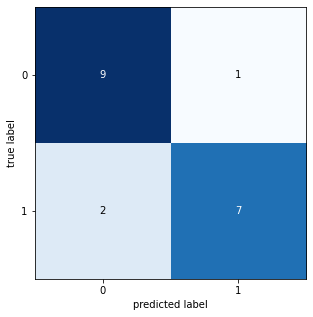

avg accuraccy Breast Cancer =  0.7426315789473683
avg F1_Score Breast Cancer =  0.7413872917588088
max accuraccy Breast Cancer =  0.8421052631578947
max F1_Score Breast Cancer =  0.8403361344537816
min accuraccy Breast Cancer =  0.6842105263157895
min F1_Score Breast Cancer =  0.6833333333333333
Running Time:  38.332936318000066
gene : [1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0]
Train : [ 0  1  2  3  4  5  6  8 12 13 14 15 16 18 19 20 21 22 23 24 25 26 27 29
 30 31 32 33 35 37 38 39 40 41 42 43 45 46 47 48 50 51 53 54 55 58 60 61
 63 64 65 67 68 69 70 71 72 73 75 76 77 78 79 80 81 82 85 86 87 88 89 90
 91 92 93 94 95] Test : [ 7  9 10 11 17 28 34 36 44 49 52 56 57 59 62 66 74 83 84 96]
Y_Train : [1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1

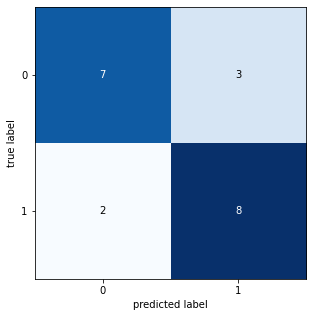

Train : [ 0  2  3  4  5  7  8  9 10 11 14 15 16 17 19 20 21 22 23 25 26 27 28 30
 31 34 35 36 37 38 39 42 43 44 45 46 47 48 49 51 52 53 54 55 56 57 58 59
 60 61 62 63 64 65 66 69 70 72 73 74 75 76 77 80 81 82 83 84 85 86 88 89
 90 91 92 95 96] Test : [ 1  6 12 13 18 24 29 32 33 40 41 50 67 68 71 78 79 87 93 94]
Y_Train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0]
Y_Test : [1 1 0 0 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Akurasi :  0.75
F1_Score :  0.7493734335839599
              precision    recall  f1-score   support

           0       0.80      0.73      0.76        11
           1       0.70      0.78      0.74         9

    accuracy                           0.75        20
   macro avg       0.75      0.75      0.75        20
weighted avg       0.76      0.75      0.75        20



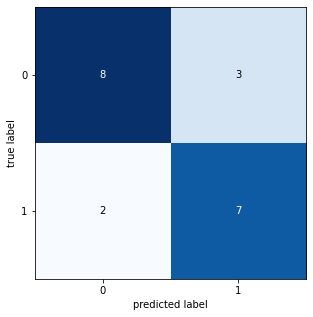

Train : [ 0  1  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 21 22 23 24 26
 28 29 32 33 34 35 36 38 40 41 42 43 44 45 46 48 49 50 51 52 53 54 55 56
 57 59 60 62 65 66 67 68 69 71 74 76 77 78 79 80 81 82 83 84 85 86 87 88
 90 91 92 93 94 96] Test : [ 2 20 25 27 30 31 37 39 47 58 61 63 64 70 72 73 75 89 95]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0]
Akurasi :  0.5789473684210527
F1_Score :  0.5777777777777777
              precision    recall  f1-score   support

           0       0.60      0.60      0.60        10
           1       0.56      0.56      0.56         9

    accuracy                           0.58        19
   macro avg       0.58      0.58      0.58        19
weighted avg       0.58      0.58      0.58        19



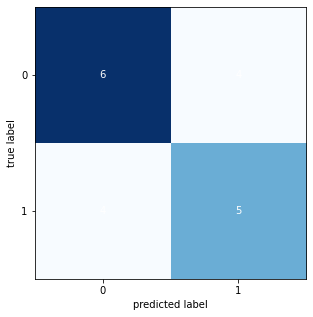

Train : [ 1  2  5  6  7  8  9 10 11 12 13 14 17 18 20 21 22 23 24 25 27 28 29 30
 31 32 33 34 35 36 37 39 40 41 42 43 44 45 47 49 50 52 53 56 57 58 59 61
 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 78 79 82 83 84 85 87 89 90
 91 92 93 94 95 96] Test : [ 0  3  4 15 16 19 26 38 46 48 51 54 55 60 77 80 81 86 88]
Y_Train : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 1 0 0 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Akurasi :  0.5789473684210527
F1_Score :  0.5777777777777777
              precision    recall  f1-score   support

           0       0.60      0.60      0.60        10
           1       0.56      0.56      0.56         9

    accuracy                           0.58        19
   macro avg       0.58      0.58      0.58        19
weighted avg       0.58      0.58      0.58        19



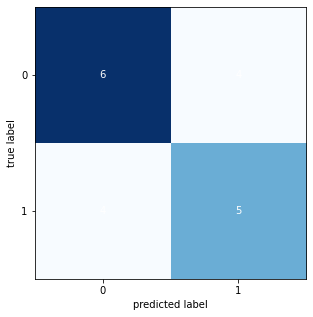

Train : [ 0  1  2  3  4  6  7  9 10 11 12 13 15 16 17 18 19 20 24 25 26 27 28 29
 30 31 32 33 34 36 37 38 39 40 41 44 46 47 48 49 50 51 52 54 55 56 57 58
 59 60 61 62 63 64 66 67 68 70 71 72 73 74 75 77 78 79 80 81 83 84 86 87
 88 89 93 94 95 96] Test : [ 5  8 14 21 22 23 35 42 43 45 53 65 69 76 82 85 90 91 92]
Y_Train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0]
Akurasi :  0.7894736842105263
F1_Score :  0.788888888888889
              precision    recall  f1-score   support

           0       0.80      0.80      0.80        10
           1       0.78      0.78      0.78         9

    accuracy                           0.79        19
   macro avg       0.79      0.79      0.79        19
weighted avg       0.79      0.79      0.79        19



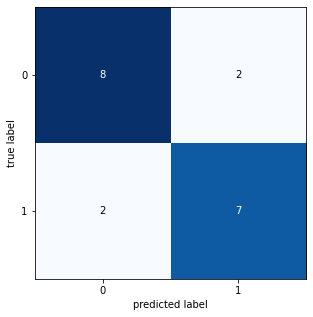

avg accuraccy Breast Cancer =  0.6894736842105263
avg F1_Score Breast Cancer =  0.6886382623224728
max accuraccy Breast Cancer =  0.7894736842105263
max F1_Score Breast Cancer =  0.788888888888889
min accuraccy Breast Cancer =  0.5789473684210527
min F1_Score Breast Cancer =  0.5777777777777777
Running Time:  39.089365173998885
gene : [1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1]
Train : [ 0  1  2  3  4  5  6  8 12 13 14 15 16 18 19 20 21 22 23 24 25 26 27 29
 30 31 32 33 35 37 38 39 40 41 42 43 45 46 47 48 50 51 53 54 55 58 60 61
 63 64 65 67 68 69 70 71 72 73 75 76 77 78 79 80 81 82 85 86 87 88 89 90
 91 92 93 94 95] Test : [ 7  9 10 11 17 28 34 36 44 49 52 56 57 59 62 66 74 83 84 96]
Y_Train : [1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 

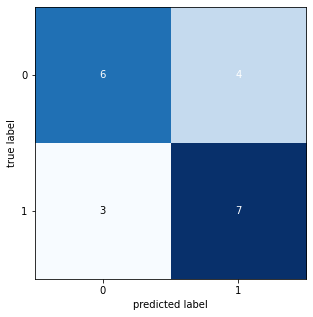

Train : [ 0  2  3  4  5  7  8  9 10 11 14 15 16 17 19 20 21 22 23 25 26 27 28 30
 31 34 35 36 37 38 39 42 43 44 45 46 47 48 49 51 52 53 54 55 56 57 58 59
 60 61 62 63 64 65 66 69 70 72 73 74 75 76 77 80 81 82 83 84 85 86 88 89
 90 91 92 95 96] Test : [ 1  6 12 13 18 24 29 32 33 40 41 50 67 68 71 78 79 87 93 94]
Y_Train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0]
Y_Test : [1 1 0 0 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Akurasi :  0.65
F1_Score :  0.6266666666666667
              precision    recall  f1-score   support

           0       0.64      0.82      0.72        11
           1       0.67      0.44      0.53         9

    accuracy                           0.65        20
   macro avg       0.65      0.63      0.63        20
weighted avg       0.65      0.65      0.64        20



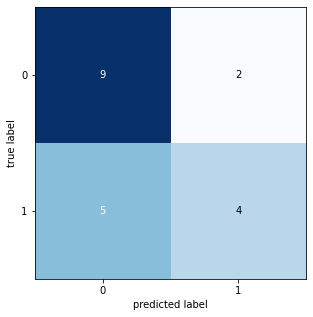

Train : [ 0  1  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 21 22 23 24 26
 28 29 32 33 34 35 36 38 40 41 42 43 44 45 46 48 49 50 51 52 53 54 55 56
 57 59 60 62 65 66 67 68 69 71 74 76 77 78 79 80 81 82 83 84 85 86 87 88
 90 91 92 93 94 96] Test : [ 2 20 25 27 30 31 37 39 47 58 61 63 64 70 72 73 75 89 95]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0]
Akurasi :  0.6842105263157895
F1_Score :  0.6833333333333333
              precision    recall  f1-score   support

           0       0.70      0.70      0.70        10
           1       0.67      0.67      0.67         9

    accuracy                           0.68        19
   macro avg       0.68      0.68      0.68        19
weighted avg       0.68      0.68      0.68        19



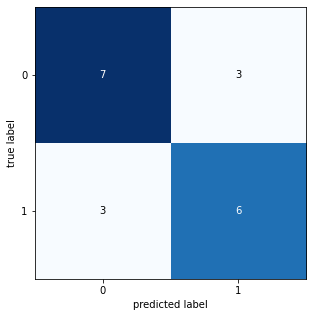

Train : [ 1  2  5  6  7  8  9 10 11 12 13 14 17 18 20 21 22 23 24 25 27 28 29 30
 31 32 33 34 35 36 37 39 40 41 42 43 44 45 47 49 50 52 53 56 57 58 59 61
 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 78 79 82 83 84 85 87 89 90
 91 92 93 94 95 96] Test : [ 0  3  4 15 16 19 26 38 46 48 51 54 55 60 77 80 81 86 88]
Y_Train : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 1 0 0 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Akurasi :  0.6842105263157895
F1_Score :  0.6761363636363638
              precision    recall  f1-score   support

           0       0.83      0.50      0.62        10
           1       0.62      0.89      0.73         9

    accuracy                           0.68        19
   macro avg       0.72      0.69      0.68        19
weighted avg       0.73      0.68      0.67        19



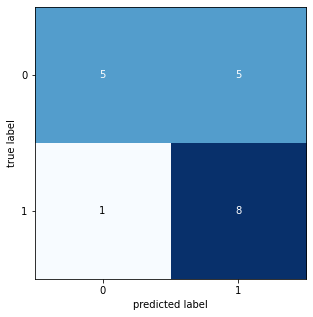

Train : [ 0  1  2  3  4  6  7  9 10 11 12 13 15 16 17 18 19 20 24 25 26 27 28 29
 30 31 32 33 34 36 37 38 39 40 41 44 46 47 48 49 50 51 52 54 55 56 57 58
 59 60 61 62 63 64 66 67 68 70 71 72 73 74 75 77 78 79 80 81 83 84 86 87
 88 89 93 94 95 96] Test : [ 5  8 14 21 22 23 35 42 43 45 53 65 69 76 82 85 90 91 92]
Y_Train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0]
Akurasi :  0.7894736842105263
F1_Score :  0.784090909090909
              precision    recall  f1-score   support

           0       1.00      0.60      0.75        10
           1       0.69      1.00      0.82         9

    accuracy                           0.79        19
   macro avg       0.85      0.80      0.78        19
weighted avg       0.85      0.79      0.78        19



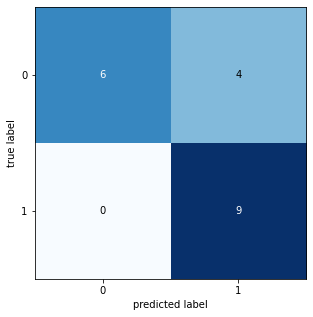

avg accuraccy Breast Cancer =  0.6915789473684211
avg F1_Score Breast Cancer =  0.6838700159489634
max accuraccy Breast Cancer =  0.7894736842105263
max F1_Score Breast Cancer =  0.784090909090909
min accuraccy Breast Cancer =  0.65
min F1_Score Breast Cancer =  0.6266666666666667
Running Time:  37.93256186100007
gene : [0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0]
Train : [ 0  1  2  3  4  5  6  8 12 13 14 15 16 18 19 20 21 22 23 24 25 26 27 29
 30 31 32 33 35 37 38 39 40 41 42 43 45 46 47 48 50 51 53 54 55 58 60 61
 63 64 65 67 68 69 70 71 72 73 75 76 77 78 79 80 81 82 85 86 87 88 89 90
 91 92 93 94 95] Test : [ 7  9 10 11 17 28 34 36 44 49 52 56 57 59 62 66 74 83 84 96]
Y_Train : [1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1

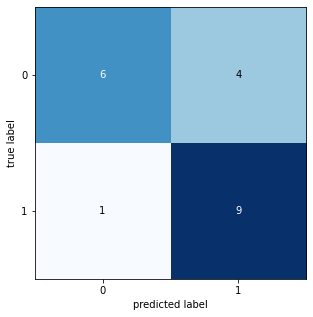

Train : [ 0  2  3  4  5  7  8  9 10 11 14 15 16 17 19 20 21 22 23 25 26 27 28 30
 31 34 35 36 37 38 39 42 43 44 45 46 47 48 49 51 52 53 54 55 56 57 58 59
 60 61 62 63 64 65 66 69 70 72 73 74 75 76 77 80 81 82 83 84 85 86 88 89
 90 91 92 95 96] Test : [ 1  6 12 13 18 24 29 32 33 40 41 50 67 68 71 78 79 87 93 94]
Y_Train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0]
Y_Test : [1 1 0 0 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Akurasi :  0.65
F1_Score :  0.6491228070175439
              precision    recall  f1-score   support

           0       0.75      0.55      0.63        11
           1       0.58      0.78      0.67         9

    accuracy                           0.65        20
   macro avg       0.67      0.66      0.65        20
weighted avg       0.68      0.65      0.65        20



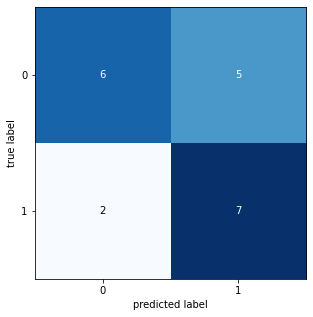

Train : [ 0  1  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 21 22 23 24 26
 28 29 32 33 34 35 36 38 40 41 42 43 44 45 46 48 49 50 51 52 53 54 55 56
 57 59 60 62 65 66 67 68 69 71 74 76 77 78 79 80 81 82 83 84 85 86 87 88
 90 91 92 93 94 96] Test : [ 2 20 25 27 30 31 37 39 47 58 61 63 64 70 72 73 75 89 95]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0]
Akurasi :  0.631578947368421
F1_Score :  0.6274509803921569
              precision    recall  f1-score   support

           0       0.64      0.70      0.67        10
           1       0.62      0.56      0.59         9

    accuracy                           0.63        19
   macro avg       0.63      0.63      0.63        19
weighted avg       0.63      0.63      0.63        19



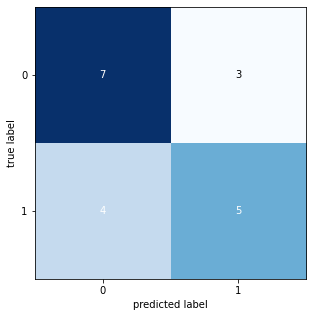

Train : [ 1  2  5  6  7  8  9 10 11 12 13 14 17 18 20 21 22 23 24 25 27 28 29 30
 31 32 33 34 35 36 37 39 40 41 42 43 44 45 47 49 50 52 53 56 57 58 59 61
 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 78 79 82 83 84 85 87 89 90
 91 92 93 94 95 96] Test : [ 0  3  4 15 16 19 26 38 46 48 51 54 55 60 77 80 81 86 88]
Y_Train : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 1 0 0 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Akurasi :  0.7368421052631579
F1_Score :  0.7338935574229692
              precision    recall  f1-score   support

           0       0.86      0.60      0.71        10
           1       0.67      0.89      0.76         9

    accuracy                           0.74        19
   macro avg       0.76      0.74      0.73        19
weighted avg       0.77      0.74      0.73        19



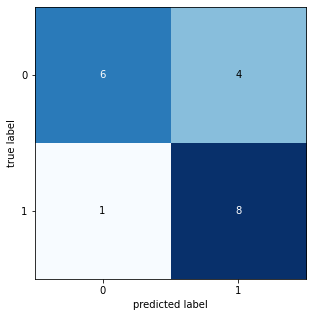

Train : [ 0  1  2  3  4  6  7  9 10 11 12 13 15 16 17 18 19 20 24 25 26 27 28 29
 30 31 32 33 34 36 37 38 39 40 41 44 46 47 48 49 50 51 52 54 55 56 57 58
 59 60 61 62 63 64 66 67 68 70 71 72 73 74 75 77 78 79 80 81 83 84 86 87
 88 89 93 94 95 96] Test : [ 5  8 14 21 22 23 35 42 43 45 53 65 69 76 82 85 90 91 92]
Y_Train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0]
Akurasi :  0.8947368421052632
F1_Score :  0.8944444444444445
              precision    recall  f1-score   support

           0       1.00      0.80      0.89        10
           1       0.82      1.00      0.90         9

    accuracy                           0.89        19
   macro avg       0.91      0.90      0.89        19
weighted avg       0.91      0.89      0.89        19



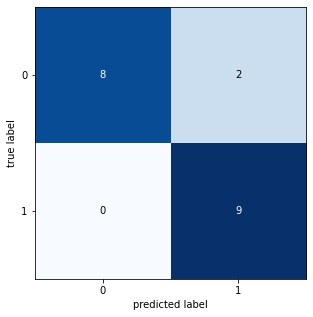

avg accuraccy Breast Cancer =  0.7326315789473684
avg F1_Score Breast Cancer =  0.7298314627147579
max accuraccy Breast Cancer =  0.8947368421052632
max F1_Score Breast Cancer =  0.8944444444444445
min accuraccy Breast Cancer =  0.631578947368421
min F1_Score Breast Cancer =  0.6274509803921569
Running Time:  37.67237547699915
gene : [0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1]
Train : [ 0  1  2  3  4  5  6  8 12 13 14 15 16 18 19 20 21 22 23 24 25 26 27 29
 30 31 32 33 35 37 38 39 40 41 42 43 45 46 47 48 50 51 53 54 55 58 60 61
 63 64 65 67 68 69 70 71 72 73 75 76 77 78 79 80 81 82 85 86 87 88 89 90
 91 92 93 94 95] Test : [ 7  9 10 11 17 28 34 36 44 49 52 56 57 59 62 66 74 83 84 96]
Y_Train : [1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1

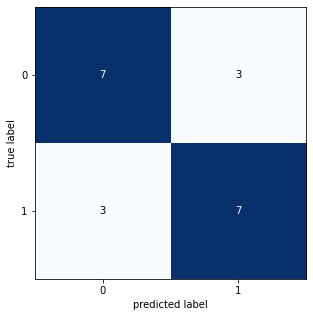

Train : [ 0  2  3  4  5  7  8  9 10 11 14 15 16 17 19 20 21 22 23 25 26 27 28 30
 31 34 35 36 37 38 39 42 43 44 45 46 47 48 49 51 52 53 54 55 56 57 58 59
 60 61 62 63 64 65 66 69 70 72 73 74 75 76 77 80 81 82 83 84 85 86 88 89
 90 91 92 95 96] Test : [ 1  6 12 13 18 24 29 32 33 40 41 50 67 68 71 78 79 87 93 94]
Y_Train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0]
Y_Test : [1 1 0 0 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Akurasi :  0.65
F1_Score :  0.6491228070175439
              precision    recall  f1-score   support

           0       0.70      0.64      0.67        11
           1       0.60      0.67      0.63         9

    accuracy                           0.65        20
   macro avg       0.65      0.65      0.65        20
weighted avg       0.65      0.65      0.65        20



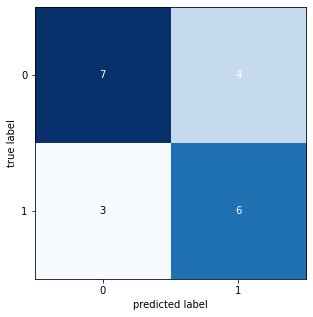

Train : [ 0  1  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 21 22 23 24 26
 28 29 32 33 34 35 36 38 40 41 42 43 44 45 46 48 49 50 51 52 53 54 55 56
 57 59 60 62 65 66 67 68 69 71 74 76 77 78 79 80 81 82 83 84 85 86 87 88
 90 91 92 93 94 96] Test : [ 2 20 25 27 30 31 37 39 47 58 61 63 64 70 72 73 75 89 95]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0]
Akurasi :  0.5789473684210527
F1_Score :  0.5777777777777777
              precision    recall  f1-score   support

           0       0.60      0.60      0.60        10
           1       0.56      0.56      0.56         9

    accuracy                           0.58        19
   macro avg       0.58      0.58      0.58        19
weighted avg       0.58      0.58      0.58        19



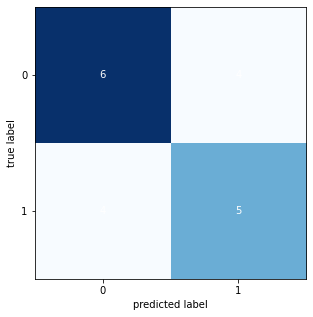

Train : [ 1  2  5  6  7  8  9 10 11 12 13 14 17 18 20 21 22 23 24 25 27 28 29 30
 31 32 33 34 35 36 37 39 40 41 42 43 44 45 47 49 50 52 53 56 57 58 59 61
 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 78 79 82 83 84 85 87 89 90
 91 92 93 94 95 96] Test : [ 0  3  4 15 16 19 26 38 46 48 51 54 55 60 77 80 81 86 88]
Y_Train : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 1 0 0 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Akurasi :  0.7368421052631579
F1_Score :  0.7368421052631577
              precision    recall  f1-score   support

           0       0.78      0.70      0.74        10
           1       0.70      0.78      0.74         9

    accuracy                           0.74        19
   macro avg       0.74      0.74      0.74        19
weighted avg       0.74      0.74      0.74        19



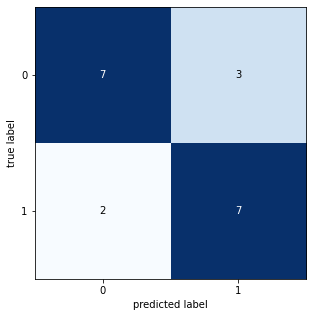

Train : [ 0  1  2  3  4  6  7  9 10 11 12 13 15 16 17 18 19 20 24 25 26 27 28 29
 30 31 32 33 34 36 37 38 39 40 41 44 46 47 48 49 50 51 52 54 55 56 57 58
 59 60 61 62 63 64 66 67 68 70 71 72 73 74 75 77 78 79 80 81 83 84 86 87
 88 89 93 94 95 96] Test : [ 5  8 14 21 22 23 35 42 43 45 53 65 69 76 82 85 90 91 92]
Y_Train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0]
Akurasi :  0.8421052631578947
F1_Score :  0.8421052631578948
              precision    recall  f1-score   support

           0       0.89      0.80      0.84        10
           1       0.80      0.89      0.84         9

    accuracy                           0.84        19
   macro avg       0.84      0.84      0.84        19
weighted avg       0.85      0.84      0.84        19



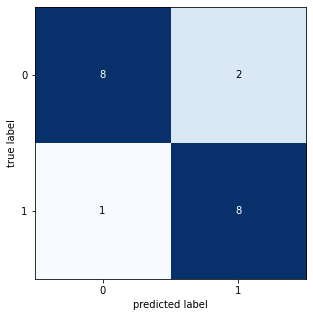

avg accuraccy Breast Cancer =  0.7015789473684211
avg F1_Score Breast Cancer =  0.7011695906432748
max accuraccy Breast Cancer =  0.8421052631578947
max F1_Score Breast Cancer =  0.8421052631578948
min accuraccy Breast Cancer =  0.5789473684210527
min F1_Score Breast Cancer =  0.5777777777777777
Running Time:  40.29558506900139
gene : [0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0]
Train : [ 0  1  2  3  4  5  6  8 12 13 14 15 16 18 19 20 21 22 23 24 25 26 27 29
 30 31 32 33 35 37 38 39 40 41 42 43 45 46 47 48 50 51 53 54 55 58 60 61
 63 64 65 67 68 69 70 71 72 73 75 76 77 78 79 80 81 82 85 86 87 88 89 90
 91 92 93 94 95] Test : [ 7  9 10 11 17 28 34 36 44 49 52 56 57 59 62 66 74 83 84 96]
Y_Train : [1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 

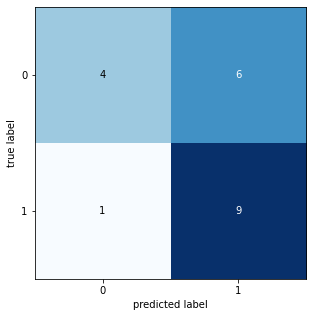

Train : [ 0  2  3  4  5  7  8  9 10 11 14 15 16 17 19 20 21 22 23 25 26 27 28 30
 31 34 35 36 37 38 39 42 43 44 45 46 47 48 49 51 52 53 54 55 56 57 58 59
 60 61 62 63 64 65 66 69 70 72 73 74 75 76 77 80 81 82 83 84 85 86 88 89
 90 91 92 95 96] Test : [ 1  6 12 13 18 24 29 32 33 40 41 50 67 68 71 78 79 87 93 94]
Y_Train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0]
Y_Test : [1 1 0 0 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Akurasi :  0.55
F1_Score :  0.5396419437340154
              precision    recall  f1-score   support

           0       0.58      0.64      0.61        11
           1       0.50      0.44      0.47         9

    accuracy                           0.55        20
   macro avg       0.54      0.54      0.54        20
weighted avg       0.55      0.55      0.55        20



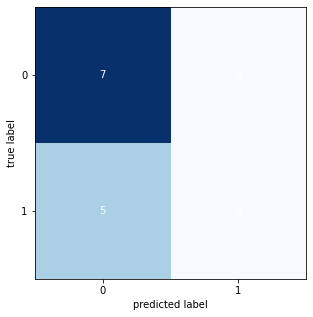

Train : [ 0  1  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 21 22 23 24 26
 28 29 32 33 34 35 36 38 40 41 42 43 44 45 46 48 49 50 51 52 53 54 55 56
 57 59 60 62 65 66 67 68 69 71 74 76 77 78 79 80 81 82 83 84 85 86 87 88
 90 91 92 93 94 96] Test : [ 2 20 25 27 30 31 37 39 47 58 61 63 64 70 72 73 75 89 95]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0]
Akurasi :  0.7368421052631579
F1_Score :  0.7338935574229692
              precision    recall  f1-score   support

           0       0.86      0.60      0.71        10
           1       0.67      0.89      0.76         9

    accuracy                           0.74        19
   macro avg       0.76      0.74      0.73        19
weighted avg       0.77      0.74      0.73        19



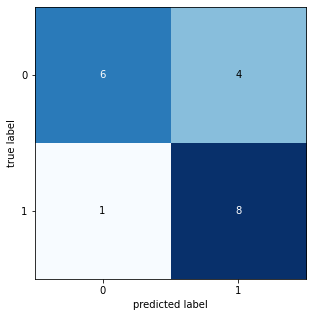

Train : [ 1  2  5  6  7  8  9 10 11 12 13 14 17 18 20 21 22 23 24 25 27 28 29 30
 31 32 33 34 35 36 37 39 40 41 42 43 44 45 47 49 50 52 53 56 57 58 59 61
 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 78 79 82 83 84 85 87 89 90
 91 92 93 94 95 96] Test : [ 0  3  4 15 16 19 26 38 46 48 51 54 55 60 77 80 81 86 88]
Y_Train : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 1 0 0 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Akurasi :  0.8421052631578947
F1_Score :  0.8421052631578948
              precision    recall  f1-score   support

           0       0.89      0.80      0.84        10
           1       0.80      0.89      0.84         9

    accuracy                           0.84        19
   macro avg       0.84      0.84      0.84        19
weighted avg       0.85      0.84      0.84        19



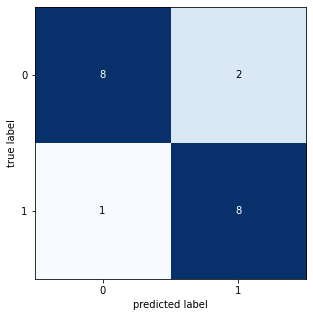

Train : [ 0  1  2  3  4  6  7  9 10 11 12 13 15 16 17 18 19 20 24 25 26 27 28 29
 30 31 32 33 34 36 37 38 39 40 41 44 46 47 48 49 50 51 52 54 55 56 57 58
 59 60 61 62 63 64 66 67 68 70 71 72 73 74 75 77 78 79 80 81 83 84 86 87
 88 89 93 94 95 96] Test : [ 5  8 14 21 22 23 35 42 43 45 53 65 69 76 82 85 90 91 92]
Y_Train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0]
Akurasi :  0.8947368421052632
F1_Score :  0.8944444444444445
              precision    recall  f1-score   support

           0       1.00      0.80      0.89        10
           1       0.82      1.00      0.90         9

    accuracy                           0.89        19
   macro avg       0.91      0.90      0.89        19
weighted avg       0.91      0.89      0.89        19



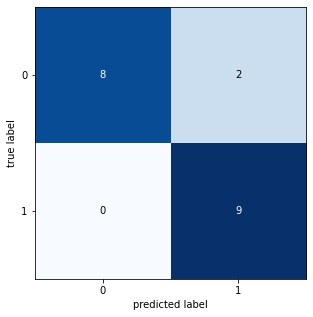

avg accuraccy Breast Cancer =  0.7347368421052632
avg F1_Score Breast Cancer =  0.7273503750851982
max accuraccy Breast Cancer =  0.8947368421052632
max F1_Score Breast Cancer =  0.8944444444444445
min accuraccy Breast Cancer =  0.55
min F1_Score Breast Cancer =  0.5396419437340154
Running Time:  38.49040983799932
gene : [1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1]
Train : [ 0  1  2  3  4  5  6  8 12 13 14 15 16 18 19 20 21 22 23 24 25 26 27 29
 30 31 32 33 35 37 38 39 40 41 42 43 45 46 47 48 50 51 53 54 55 58 60 61
 63 64 65 67 68 69 70 71 72 73 75 76 77 78 79 80 81 82 85 86 87 88 89 90
 91 92 93 94 95] Test : [ 7  9 10 11 17 28 34 36 44 49 52 56 57 59 62 66 74 83 84 96]
Y_Train : [1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 

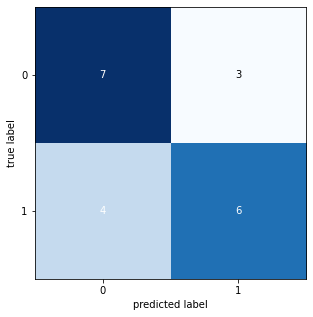

Train : [ 0  2  3  4  5  7  8  9 10 11 14 15 16 17 19 20 21 22 23 25 26 27 28 30
 31 34 35 36 37 38 39 42 43 44 45 46 47 48 49 51 52 53 54 55 56 57 58 59
 60 61 62 63 64 65 66 69 70 72 73 74 75 76 77 80 81 82 83 84 85 86 88 89
 90 91 92 95 96] Test : [ 1  6 12 13 18 24 29 32 33 40 41 50 67 68 71 78 79 87 93 94]
Y_Train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0]
Y_Test : [1 1 0 0 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Akurasi :  0.8
F1_Score :  0.7916666666666666
              precision    recall  f1-score   support

           0       0.77      0.91      0.83        11
           1       0.86      0.67      0.75         9

    accuracy                           0.80        20
   macro avg       0.81      0.79      0.79        20
weighted avg       0.81      0.80      0.80        20



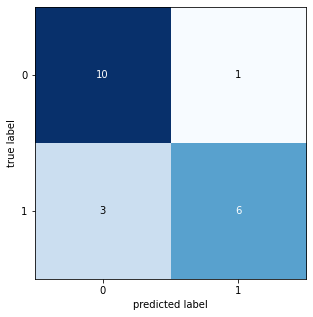

Train : [ 0  1  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 21 22 23 24 26
 28 29 32 33 34 35 36 38 40 41 42 43 44 45 46 48 49 50 51 52 53 54 55 56
 57 59 60 62 65 66 67 68 69 71 74 76 77 78 79 80 81 82 83 84 85 86 87 88
 90 91 92 93 94 96] Test : [ 2 20 25 27 30 31 37 39 47 58 61 63 64 70 72 73 75 89 95]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0]
Akurasi :  0.6842105263157895
F1_Score :  0.6833333333333333
              precision    recall  f1-score   support

           0       0.70      0.70      0.70        10
           1       0.67      0.67      0.67         9

    accuracy                           0.68        19
   macro avg       0.68      0.68      0.68        19
weighted avg       0.68      0.68      0.68        19



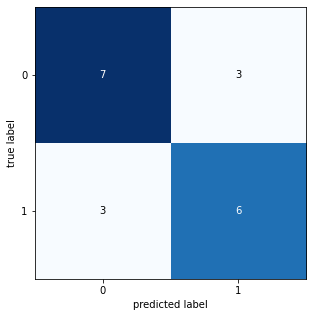

Train : [ 1  2  5  6  7  8  9 10 11 12 13 14 17 18 20 21 22 23 24 25 27 28 29 30
 31 32 33 34 35 36 37 39 40 41 42 43 44 45 47 49 50 52 53 56 57 58 59 61
 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 78 79 82 83 84 85 87 89 90
 91 92 93 94 95 96] Test : [ 0  3  4 15 16 19 26 38 46 48 51 54 55 60 77 80 81 86 88]
Y_Train : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 1 0 0 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Akurasi :  0.5789473684210527
F1_Score :  0.5777777777777777
              precision    recall  f1-score   support

           0       0.60      0.60      0.60        10
           1       0.56      0.56      0.56         9

    accuracy                           0.58        19
   macro avg       0.58      0.58      0.58        19
weighted avg       0.58      0.58      0.58        19



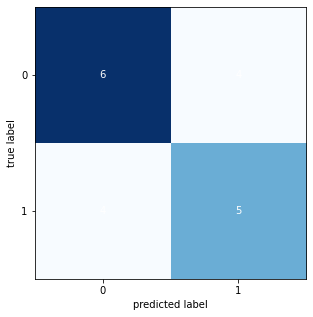

Train : [ 0  1  2  3  4  6  7  9 10 11 12 13 15 16 17 18 19 20 24 25 26 27 28 29
 30 31 32 33 34 36 37 38 39 40 41 44 46 47 48 49 50 51 52 54 55 56 57 58
 59 60 61 62 63 64 66 67 68 70 71 72 73 74 75 77 78 79 80 81 83 84 86 87
 88 89 93 94 95 96] Test : [ 5  8 14 21 22 23 35 42 43 45 53 65 69 76 82 85 90 91 92]
Y_Train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0]
Akurasi :  0.8421052631578947
F1_Score :  0.8403361344537816
              precision    recall  f1-score   support

           0       0.82      0.90      0.86        10
           1       0.88      0.78      0.82         9

    accuracy                           0.84        19
   macro avg       0.85      0.84      0.84        19
weighted avg       0.85      0.84      0.84        19



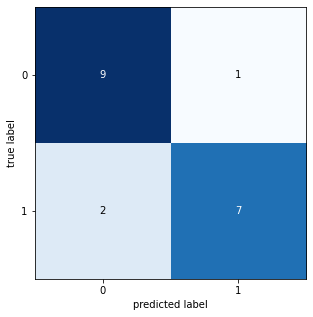

avg accuraccy Breast Cancer =  0.7110526315789474
avg F1_Score Breast Cancer =  0.7084473438498207
max accuraccy Breast Cancer =  0.8421052631578947
max F1_Score Breast Cancer =  0.8403361344537816
min accuraccy Breast Cancer =  0.5789473684210527
min F1_Score Breast Cancer =  0.5777777777777777
Running Time:  40.54825976000029
gene : [1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0]
Train : [ 0  1  2  3  4  5  6  8 12 13 14 15 16 18 19 20 21 22 23 24 25 26 27 29
 30 31 32 33 35 37 38 39 40 41 42 43 45 46 47 48 50 51 53 54 55 58 60 61
 63 64 65 67 68 69 70 71 72 73 75 76 77 78 79 80 81 82 85 86 87 88 89 90
 91 92 93 94 95] Test : [ 7  9 10 11 17 28 34 36 44 49 52 56 57 59 62 66 74 83 84 96]
Y_Train : [1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 

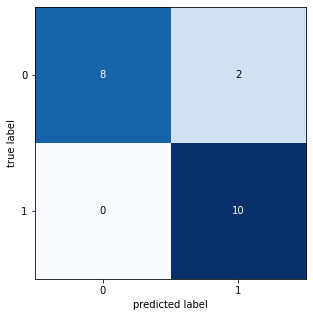

Train : [ 0  2  3  4  5  7  8  9 10 11 14 15 16 17 19 20 21 22 23 25 26 27 28 30
 31 34 35 36 37 38 39 42 43 44 45 46 47 48 49 51 52 53 54 55 56 57 58 59
 60 61 62 63 64 65 66 69 70 72 73 74 75 76 77 80 81 82 83 84 85 86 88 89
 90 91 92 95 96] Test : [ 1  6 12 13 18 24 29 32 33 40 41 50 67 68 71 78 79 87 93 94]
Y_Train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0]
Y_Test : [1 1 0 0 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Akurasi :  0.7
F1_Score :  0.6875000000000001
              precision    recall  f1-score   support

           0       0.69      0.82      0.75        11
           1       0.71      0.56      0.63         9

    accuracy                           0.70        20
   macro avg       0.70      0.69      0.69        20
weighted avg       0.70      0.70      0.69        20



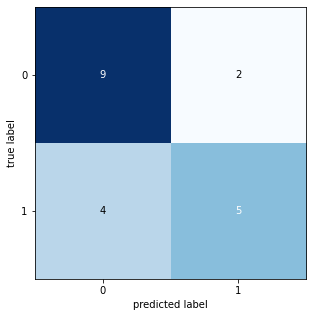

Train : [ 0  1  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 21 22 23 24 26
 28 29 32 33 34 35 36 38 40 41 42 43 44 45 46 48 49 50 51 52 53 54 55 56
 57 59 60 62 65 66 67 68 69 71 74 76 77 78 79 80 81 82 83 84 85 86 87 88
 90 91 92 93 94 96] Test : [ 2 20 25 27 30 31 37 39 47 58 61 63 64 70 72 73 75 89 95]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0]
Akurasi :  0.7894736842105263
F1_Score :  0.788888888888889
              precision    recall  f1-score   support

           0       0.80      0.80      0.80        10
           1       0.78      0.78      0.78         9

    accuracy                           0.79        19
   macro avg       0.79      0.79      0.79        19
weighted avg       0.79      0.79      0.79        19



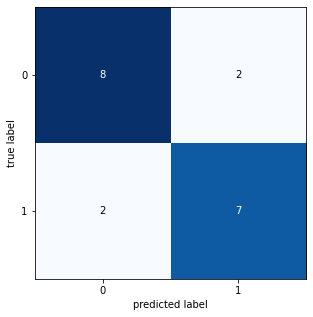

Train : [ 1  2  5  6  7  8  9 10 11 12 13 14 17 18 20 21 22 23 24 25 27 28 29 30
 31 32 33 34 35 36 37 39 40 41 42 43 44 45 47 49 50 52 53 56 57 58 59 61
 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 78 79 82 83 84 85 87 89 90
 91 92 93 94 95 96] Test : [ 0  3  4 15 16 19 26 38 46 48 51 54 55 60 77 80 81 86 88]
Y_Train : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 1 0 0 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Akurasi :  0.7368421052631579
F1_Score :  0.7338935574229692
              precision    recall  f1-score   support

           0       0.73      0.80      0.76        10
           1       0.75      0.67      0.71         9

    accuracy                           0.74        19
   macro avg       0.74      0.73      0.73        19
weighted avg       0.74      0.74      0.74        19



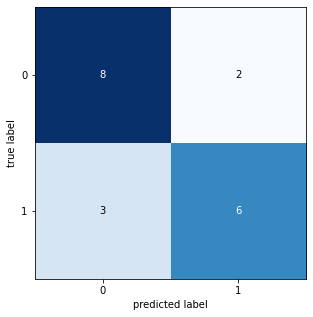

Train : [ 0  1  2  3  4  6  7  9 10 11 12 13 15 16 17 18 19 20 24 25 26 27 28 29
 30 31 32 33 34 36 37 38 39 40 41 44 46 47 48 49 50 51 52 54 55 56 57 58
 59 60 61 62 63 64 66 67 68 70 71 72 73 74 75 77 78 79 80 81 83 84 86 87
 88 89 93 94 95 96] Test : [ 5  8 14 21 22 23 35 42 43 45 53 65 69 76 82 85 90 91 92]
Y_Train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0]
Akurasi :  0.8421052631578947
F1_Score :  0.8421052631578948
              precision    recall  f1-score   support

           0       0.89      0.80      0.84        10
           1       0.80      0.89      0.84         9

    accuracy                           0.84        19
   macro avg       0.84      0.84      0.84        19
weighted avg       0.85      0.84      0.84        19



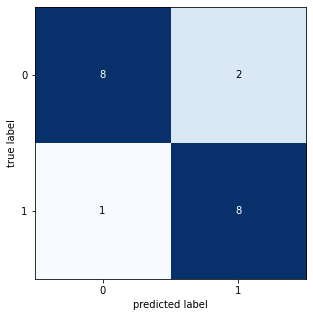

avg accuraccy Breast Cancer =  0.7936842105263158
avg F1_Score Breast Cancer =  0.7902755216919305
max accuraccy Breast Cancer =  0.9
max F1_Score Breast Cancer =  0.898989898989899
min accuraccy Breast Cancer =  0.7
min F1_Score Breast Cancer =  0.6875000000000001
Running Time:  38.78179137100051
gen terbaik : [1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0]
F-1 Score terbaik : 0.7902755216919305  || Akurasi terbaik : 0.7936842105263158  || jumlah fitur : 53

Generation : 1
gene : [1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1,

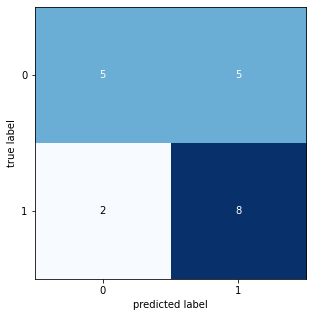

Train : [ 0  2  3  4  5  7  8  9 10 11 14 15 16 17 19 20 21 22 23 25 26 27 28 30
 31 34 35 36 37 38 39 42 43 44 45 46 47 48 49 51 52 53 54 55 56 57 58 59
 60 61 62 63 64 65 66 69 70 72 73 74 75 76 77 80 81 82 83 84 85 86 88 89
 90 91 92 95 96] Test : [ 1  6 12 13 18 24 29 32 33 40 41 50 67 68 71 78 79 87 93 94]
Y_Train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0]
Y_Test : [1 1 0 0 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Akurasi :  0.65
F1_Score :  0.6491228070175439
              precision    recall  f1-score   support

           0       0.70      0.64      0.67        11
           1       0.60      0.67      0.63         9

    accuracy                           0.65        20
   macro avg       0.65      0.65      0.65        20
weighted avg       0.65      0.65      0.65        20



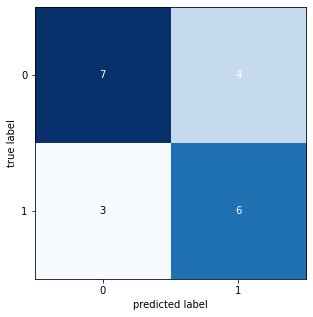

Train : [ 0  1  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 21 22 23 24 26
 28 29 32 33 34 35 36 38 40 41 42 43 44 45 46 48 49 50 51 52 53 54 55 56
 57 59 60 62 65 66 67 68 69 71 74 76 77 78 79 80 81 82 83 84 85 86 87 88
 90 91 92 93 94 96] Test : [ 2 20 25 27 30 31 37 39 47 58 61 63 64 70 72 73 75 89 95]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0]
Akurasi :  0.7368421052631579
F1_Score :  0.7368421052631577
              precision    recall  f1-score   support

           0       0.78      0.70      0.74        10
           1       0.70      0.78      0.74         9

    accuracy                           0.74        19
   macro avg       0.74      0.74      0.74        19
weighted avg       0.74      0.74      0.74        19



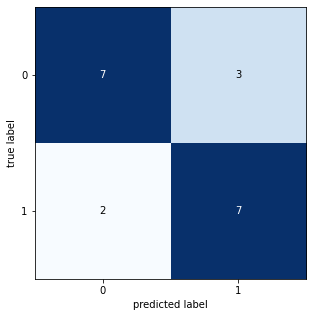

Train : [ 1  2  5  6  7  8  9 10 11 12 13 14 17 18 20 21 22 23 24 25 27 28 29 30
 31 32 33 34 35 36 37 39 40 41 42 43 44 45 47 49 50 52 53 56 57 58 59 61
 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 78 79 82 83 84 85 87 89 90
 91 92 93 94 95 96] Test : [ 0  3  4 15 16 19 26 38 46 48 51 54 55 60 77 80 81 86 88]
Y_Train : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 1 0 0 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Akurasi :  0.6842105263157895
F1_Score :  0.6833333333333333
              precision    recall  f1-score   support

           0       0.75      0.60      0.67        10
           1       0.64      0.78      0.70         9

    accuracy                           0.68        19
   macro avg       0.69      0.69      0.68        19
weighted avg       0.70      0.68      0.68        19



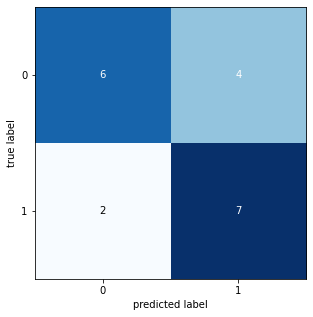

Train : [ 0  1  2  3  4  6  7  9 10 11 12 13 15 16 17 18 19 20 24 25 26 27 28 29
 30 31 32 33 34 36 37 38 39 40 41 44 46 47 48 49 50 51 52 54 55 56 57 58
 59 60 61 62 63 64 66 67 68 70 71 72 73 74 75 77 78 79 80 81 83 84 86 87
 88 89 93 94 95 96] Test : [ 5  8 14 21 22 23 35 42 43 45 53 65 69 76 82 85 90 91 92]
Y_Train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0]
Akurasi :  0.8421052631578947
F1_Score :  0.8421052631578948
              precision    recall  f1-score   support

           0       0.89      0.80      0.84        10
           1       0.80      0.89      0.84         9

    accuracy                           0.84        19
   macro avg       0.84      0.84      0.84        19
weighted avg       0.85      0.84      0.84        19



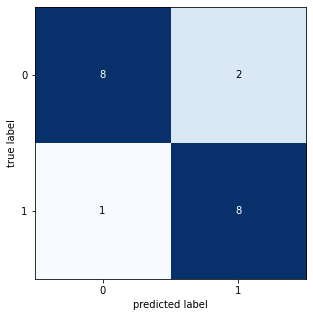

avg accuraccy Breast Cancer =  0.7126315789473684
avg F1_Score Breast Cancer =  0.7106694485574551
max accuraccy Breast Cancer =  0.8421052631578947
max F1_Score Breast Cancer =  0.8421052631578948
min accuraccy Breast Cancer =  0.65
min F1_Score Breast Cancer =  0.6419437340153452
Running Time:  39.18206269499933
gene : [0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1]
Train : [ 0  1  2  3  4  5  6  8 12 13 14 15 16 18 19 20 21 22 23 24 25 26 27 29
 30 31 32 33 35 37 38 39 40 41 42 43 45 46 47 48 50 51 53 54 55 58 60 61
 63 64 65 67 68 69 70 71 72 73 75 76 77 78 79 80 81 82 85 86 87 88 89 90
 91 92 93 94 95] Test : [ 7  9 10 11 17 28 34 36 44 49 52 56 57 59 62 66 74 83 84 96]
Y_Train : [1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 

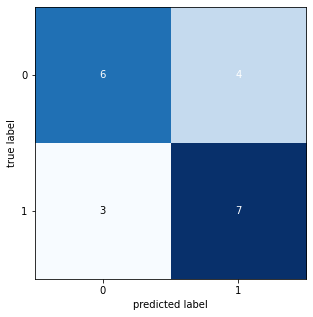

Train : [ 0  2  3  4  5  7  8  9 10 11 14 15 16 17 19 20 21 22 23 25 26 27 28 30
 31 34 35 36 37 38 39 42 43 44 45 46 47 48 49 51 52 53 54 55 56 57 58 59
 60 61 62 63 64 65 66 69 70 72 73 74 75 76 77 80 81 82 83 84 85 86 88 89
 90 91 92 95 96] Test : [ 1  6 12 13 18 24 29 32 33 40 41 50 67 68 71 78 79 87 93 94]
Y_Train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0]
Y_Test : [1 1 0 0 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Akurasi :  0.7
F1_Score :  0.696969696969697
              precision    recall  f1-score   support

           0       0.73      0.73      0.73        11
           1       0.67      0.67      0.67         9

    accuracy                           0.70        20
   macro avg       0.70      0.70      0.70        20
weighted avg       0.70      0.70      0.70        20



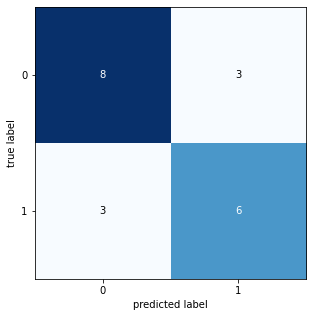

Train : [ 0  1  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 21 22 23 24 26
 28 29 32 33 34 35 36 38 40 41 42 43 44 45 46 48 49 50 51 52 53 54 55 56
 57 59 60 62 65 66 67 68 69 71 74 76 77 78 79 80 81 82 83 84 85 86 87 88
 90 91 92 93 94 96] Test : [ 2 20 25 27 30 31 37 39 47 58 61 63 64 70 72 73 75 89 95]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0]
Akurasi :  0.631578947368421
F1_Score :  0.6274509803921569
              precision    recall  f1-score   support

           0       0.64      0.70      0.67        10
           1       0.62      0.56      0.59         9

    accuracy                           0.63        19
   macro avg       0.63      0.63      0.63        19
weighted avg       0.63      0.63      0.63        19



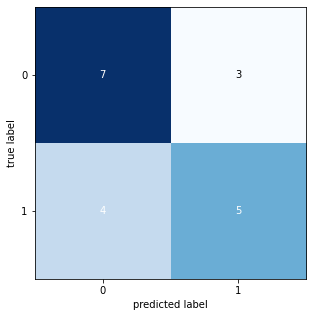

Train : [ 1  2  5  6  7  8  9 10 11 12 13 14 17 18 20 21 22 23 24 25 27 28 29 30
 31 32 33 34 35 36 37 39 40 41 42 43 44 45 47 49 50 52 53 56 57 58 59 61
 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 78 79 82 83 84 85 87 89 90
 91 92 93 94 95 96] Test : [ 0  3  4 15 16 19 26 38 46 48 51 54 55 60 77 80 81 86 88]
Y_Train : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 1 0 0 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Akurasi :  0.7894736842105263
F1_Score :  0.784090909090909
              precision    recall  f1-score   support

           0       1.00      0.60      0.75        10
           1       0.69      1.00      0.82         9

    accuracy                           0.79        19
   macro avg       0.85      0.80      0.78        19
weighted avg       0.85      0.79      0.78        19



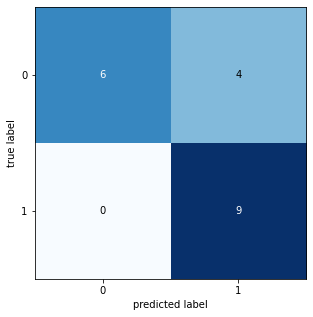

Train : [ 0  1  2  3  4  6  7  9 10 11 12 13 15 16 17 18 19 20 24 25 26 27 28 29
 30 31 32 33 34 36 37 38 39 40 41 44 46 47 48 49 50 51 52 54 55 56 57 58
 59 60 61 62 63 64 66 67 68 70 71 72 73 74 75 77 78 79 80 81 83 84 86 87
 88 89 93 94 95 96] Test : [ 5  8 14 21 22 23 35 42 43 45 53 65 69 76 82 85 90 91 92]
Y_Train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0]
Akurasi :  0.8947368421052632
F1_Score :  0.8944444444444444
              precision    recall  f1-score   support

           0       0.90      0.90      0.90        10
           1       0.89      0.89      0.89         9

    accuracy                           0.89        19
   macro avg       0.89      0.89      0.89        19
weighted avg       0.89      0.89      0.89        19



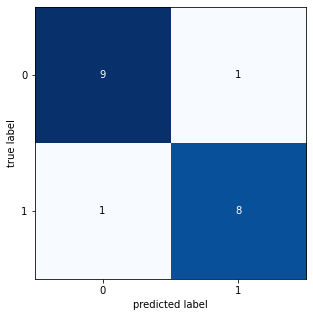

avg accuraccy Breast Cancer =  0.7331578947368421
avg F1_Score Breast Cancer =  0.7304157675829501
max accuraccy Breast Cancer =  0.8947368421052632
max F1_Score Breast Cancer =  0.8944444444444444
min accuraccy Breast Cancer =  0.631578947368421
min F1_Score Breast Cancer =  0.6274509803921569
Running Time:  40.21678233499915
gene : [1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0]
Train : [ 0  1  2  3  4  5  6  8 12 13 14 15 16 18 19 20 21 22 23 24 25 26 27 29
 30 31 32 33 35 37 38 39 40 41 42 43 45 46 47 48 50 51 53 54 55 58 60 61
 63 64 65 67 68 69 70 71 72 73 75 76 77 78 79 80 81 82 85 86 87 88 89 90
 91 92 93 94 95] Test : [ 7  9 10 11 17 28 34 36 44 49 52 56 57 59 62 66 74 83 84 96]
Y_Train : [1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1

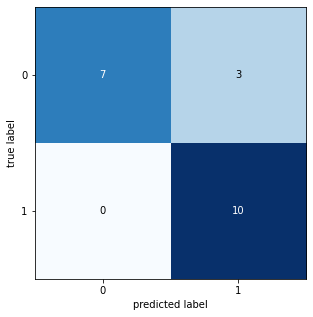

Train : [ 0  2  3  4  5  7  8  9 10 11 14 15 16 17 19 20 21 22 23 25 26 27 28 30
 31 34 35 36 37 38 39 42 43 44 45 46 47 48 49 51 52 53 54 55 56 57 58 59
 60 61 62 63 64 65 66 69 70 72 73 74 75 76 77 80 81 82 83 84 85 86 88 89
 90 91 92 95 96] Test : [ 1  6 12 13 18 24 29 32 33 40 41 50 67 68 71 78 79 87 93 94]
Y_Train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0]
Y_Test : [1 1 0 0 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Akurasi :  0.65
F1_Score :  0.6266666666666667
              precision    recall  f1-score   support

           0       0.64      0.82      0.72        11
           1       0.67      0.44      0.53         9

    accuracy                           0.65        20
   macro avg       0.65      0.63      0.63        20
weighted avg       0.65      0.65      0.64        20



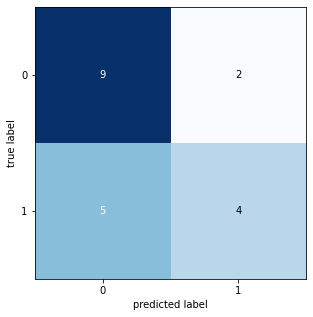

Train : [ 0  1  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 21 22 23 24 26
 28 29 32 33 34 35 36 38 40 41 42 43 44 45 46 48 49 50 51 52 53 54 55 56
 57 59 60 62 65 66 67 68 69 71 74 76 77 78 79 80 81 82 83 84 85 86 87 88
 90 91 92 93 94 96] Test : [ 2 20 25 27 30 31 37 39 47 58 61 63 64 70 72 73 75 89 95]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0]
Akurasi :  0.7368421052631579
F1_Score :  0.7338935574229692
              precision    recall  f1-score   support

           0       0.86      0.60      0.71        10
           1       0.67      0.89      0.76         9

    accuracy                           0.74        19
   macro avg       0.76      0.74      0.73        19
weighted avg       0.77      0.74      0.73        19



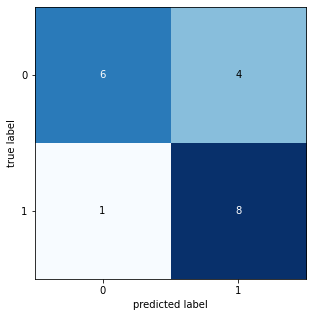

Train : [ 1  2  5  6  7  8  9 10 11 12 13 14 17 18 20 21 22 23 24 25 27 28 29 30
 31 32 33 34 35 36 37 39 40 41 42 43 44 45 47 49 50 52 53 56 57 58 59 61
 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 78 79 82 83 84 85 87 89 90
 91 92 93 94 95 96] Test : [ 0  3  4 15 16 19 26 38 46 48 51 54 55 60 77 80 81 86 88]
Y_Train : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 1 0 0 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Akurasi :  0.7368421052631579
F1_Score :  0.7368421052631577
              precision    recall  f1-score   support

           0       0.78      0.70      0.74        10
           1       0.70      0.78      0.74         9

    accuracy                           0.74        19
   macro avg       0.74      0.74      0.74        19
weighted avg       0.74      0.74      0.74        19



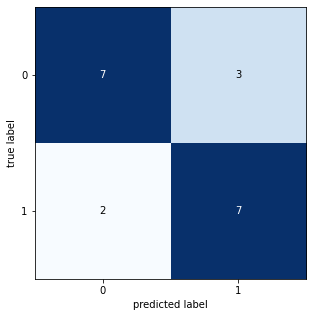

Train : [ 0  1  2  3  4  6  7  9 10 11 12 13 15 16 17 18 19 20 24 25 26 27 28 29
 30 31 32 33 34 36 37 38 39 40 41 44 46 47 48 49 50 51 52 54 55 56 57 58
 59 60 61 62 63 64 66 67 68 70 71 72 73 74 75 77 78 79 80 81 83 84 86 87
 88 89 93 94 95 96] Test : [ 5  8 14 21 22 23 35 42 43 45 53 65 69 76 82 85 90 91 92]
Y_Train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0]
Akurasi :  0.8947368421052632
F1_Score :  0.8944444444444444
              precision    recall  f1-score   support

           0       0.90      0.90      0.90        10
           1       0.89      0.89      0.89         9

    accuracy                           0.89        19
   macro avg       0.89      0.89      0.89        19
weighted avg       0.89      0.89      0.89        19



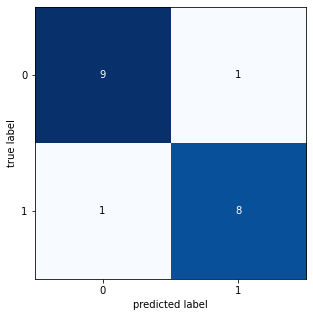

avg accuraccy Breast Cancer =  0.7736842105263159
avg F1_Score Breast Cancer =  0.7676788176750485
max accuraccy Breast Cancer =  0.8947368421052632
max F1_Score Breast Cancer =  0.8944444444444444
min accuraccy Breast Cancer =  0.65
min F1_Score Breast Cancer =  0.6266666666666667
Running Time:  39.45115296899894
gene : [0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0]
Train : [ 0  1  2  3  4  5  6  8 12 13 14 15 16 18 19 20 21 22 23 24 25 26 27 29
 30 31 32 33 35 37 38 39 40 41 42 43 45 46 47 48 50 51 53 54 55 58 60 61
 63 64 65 67 68 69 70 71 72 73 75 76 77 78 79 80 81 82 85 86 87 88 89 90
 91 92 93 94 95] Test : [ 7  9 10 11 17 28 34 36 44 49 52 56 57 59 62 66 74 83 84 96]
Y_Train : [1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 

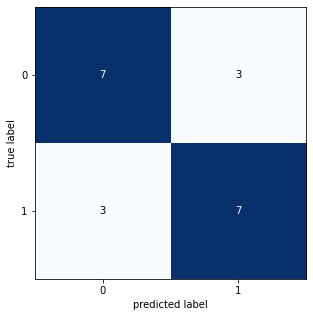

Train : [ 0  2  3  4  5  7  8  9 10 11 14 15 16 17 19 20 21 22 23 25 26 27 28 30
 31 34 35 36 37 38 39 42 43 44 45 46 47 48 49 51 52 53 54 55 56 57 58 59
 60 61 62 63 64 65 66 69 70 72 73 74 75 76 77 80 81 82 83 84 85 86 88 89
 90 91 92 95 96] Test : [ 1  6 12 13 18 24 29 32 33 40 41 50 67 68 71 78 79 87 93 94]
Y_Train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0]
Y_Test : [1 1 0 0 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Akurasi :  0.75
F1_Score :  0.7493734335839599
              precision    recall  f1-score   support

           0       0.80      0.73      0.76        11
           1       0.70      0.78      0.74         9

    accuracy                           0.75        20
   macro avg       0.75      0.75      0.75        20
weighted avg       0.76      0.75      0.75        20



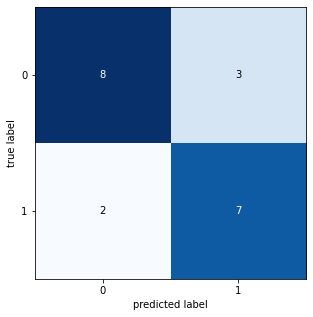

Train : [ 0  1  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 21 22 23 24 26
 28 29 32 33 34 35 36 38 40 41 42 43 44 45 46 48 49 50 51 52 53 54 55 56
 57 59 60 62 65 66 67 68 69 71 74 76 77 78 79 80 81 82 83 84 85 86 87 88
 90 91 92 93 94 96] Test : [ 2 20 25 27 30 31 37 39 47 58 61 63 64 70 72 73 75 89 95]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0]
Akurasi :  0.7894736842105263
F1_Score :  0.788888888888889
              precision    recall  f1-score   support

           0       0.80      0.80      0.80        10
           1       0.78      0.78      0.78         9

    accuracy                           0.79        19
   macro avg       0.79      0.79      0.79        19
weighted avg       0.79      0.79      0.79        19



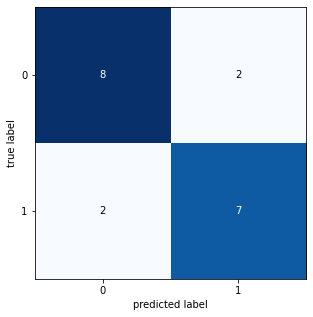

Train : [ 1  2  5  6  7  8  9 10 11 12 13 14 17 18 20 21 22 23 24 25 27 28 29 30
 31 32 33 34 35 36 37 39 40 41 42 43 44 45 47 49 50 52 53 56 57 58 59 61
 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 78 79 82 83 84 85 87 89 90
 91 92 93 94 95 96] Test : [ 0  3  4 15 16 19 26 38 46 48 51 54 55 60 77 80 81 86 88]
Y_Train : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 1 0 0 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Akurasi :  0.7894736842105263
F1_Score :  0.7888888888888888
              precision    recall  f1-score   support

           0       0.88      0.70      0.78        10
           1       0.73      0.89      0.80         9

    accuracy                           0.79        19
   macro avg       0.80      0.79      0.79        19
weighted avg       0.81      0.79      0.79        19



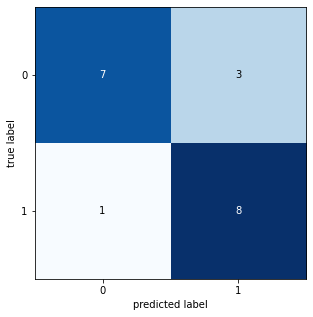

Train : [ 0  1  2  3  4  6  7  9 10 11 12 13 15 16 17 18 19 20 24 25 26 27 28 29
 30 31 32 33 34 36 37 38 39 40 41 44 46 47 48 49 50 51 52 54 55 56 57 58
 59 60 61 62 63 64 66 67 68 70 71 72 73 74 75 77 78 79 80 81 83 84 86 87
 88 89 93 94 95 96] Test : [ 5  8 14 21 22 23 35 42 43 45 53 65 69 76 82 85 90 91 92]
Y_Train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0]
Akurasi :  0.8947368421052632
F1_Score :  0.8944444444444444
              precision    recall  f1-score   support

           0       0.90      0.90      0.90        10
           1       0.89      0.89      0.89         9

    accuracy                           0.89        19
   macro avg       0.89      0.89      0.89        19
weighted avg       0.89      0.89      0.89        19



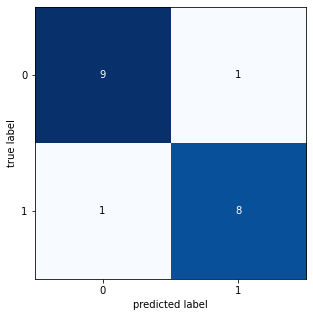

avg accuraccy Breast Cancer =  0.7847368421052632
avg F1_Score Breast Cancer =  0.7843191311612364
max accuraccy Breast Cancer =  0.8947368421052632
max F1_Score Breast Cancer =  0.8944444444444444
min accuraccy Breast Cancer =  0.7
min F1_Score Breast Cancer =  0.7
Running Time:  40.11088326600111
gene : [1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0]
Train : [ 0  1  2  3  4  5  6  8 12 13 14 15 16 18 19 20 21 22 23 24 25 26 27 29
 30 31 32 33 35 37 38 39 40 41 42 43 45 46 47 48 50 51 53 54 55 58 60 61
 63 64 65 67 68 69 70 71 72 73 75 76 77 78 79 80 81 82 85 86 87 88 89 90
 91 92 93 94 95] Test : [ 7  9 10 11 17 28 34 36 44 49 52 56 57 59 62 66 74 83 84 96]
Y_Train : [1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 

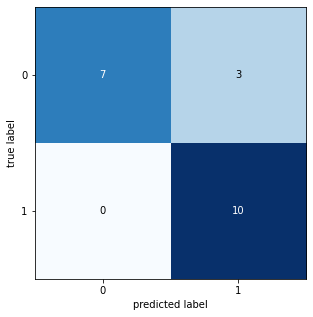

Train : [ 0  2  3  4  5  7  8  9 10 11 14 15 16 17 19 20 21 22 23 25 26 27 28 30
 31 34 35 36 37 38 39 42 43 44 45 46 47 48 49 51 52 53 54 55 56 57 58 59
 60 61 62 63 64 65 66 69 70 72 73 74 75 76 77 80 81 82 83 84 85 86 88 89
 90 91 92 95 96] Test : [ 1  6 12 13 18 24 29 32 33 40 41 50 67 68 71 78 79 87 93 94]
Y_Train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0]
Y_Test : [1 1 0 0 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Akurasi :  0.6
F1_Score :  0.5833333333333334
              precision    recall  f1-score   support

           0       0.62      0.73      0.67        11
           1       0.57      0.44      0.50         9

    accuracy                           0.60        20
   macro avg       0.59      0.59      0.58        20
weighted avg       0.60      0.60      0.59        20



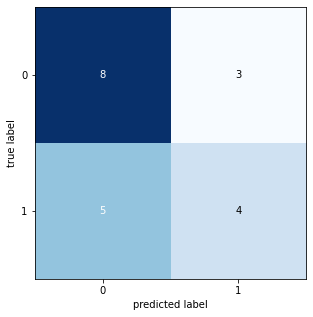

Train : [ 0  1  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 21 22 23 24 26
 28 29 32 33 34 35 36 38 40 41 42 43 44 45 46 48 49 50 51 52 53 54 55 56
 57 59 60 62 65 66 67 68 69 71 74 76 77 78 79 80 81 82 83 84 85 86 87 88
 90 91 92 93 94 96] Test : [ 2 20 25 27 30 31 37 39 47 58 61 63 64 70 72 73 75 89 95]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0]
Akurasi :  0.7368421052631579
F1_Score :  0.7338935574229692
              precision    recall  f1-score   support

           0       0.86      0.60      0.71        10
           1       0.67      0.89      0.76         9

    accuracy                           0.74        19
   macro avg       0.76      0.74      0.73        19
weighted avg       0.77      0.74      0.73        19



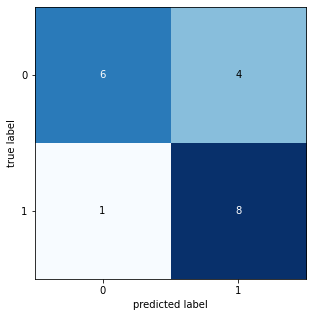

Train : [ 1  2  5  6  7  8  9 10 11 12 13 14 17 18 20 21 22 23 24 25 27 28 29 30
 31 32 33 34 35 36 37 39 40 41 42 43 44 45 47 49 50 52 53 56 57 58 59 61
 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 78 79 82 83 84 85 87 89 90
 91 92 93 94 95 96] Test : [ 0  3  4 15 16 19 26 38 46 48 51 54 55 60 77 80 81 86 88]
Y_Train : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 1 0 0 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Akurasi :  0.7368421052631579
F1_Score :  0.7368421052631577
              precision    recall  f1-score   support

           0       0.78      0.70      0.74        10
           1       0.70      0.78      0.74         9

    accuracy                           0.74        19
   macro avg       0.74      0.74      0.74        19
weighted avg       0.74      0.74      0.74        19



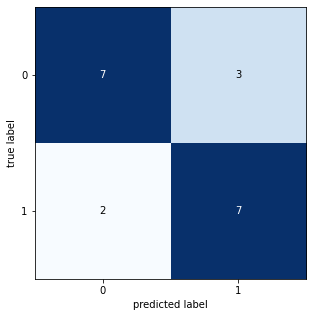

Train : [ 0  1  2  3  4  6  7  9 10 11 12 13 15 16 17 18 19 20 24 25 26 27 28 29
 30 31 32 33 34 36 37 38 39 40 41 44 46 47 48 49 50 51 52 54 55 56 57 58
 59 60 61 62 63 64 66 67 68 70 71 72 73 74 75 77 78 79 80 81 83 84 86 87
 88 89 93 94 95 96] Test : [ 5  8 14 21 22 23 35 42 43 45 53 65 69 76 82 85 90 91 92]
Y_Train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0]
Akurasi :  0.8421052631578947
F1_Score :  0.8403361344537816
              precision    recall  f1-score   support

           0       0.82      0.90      0.86        10
           1       0.88      0.78      0.82         9

    accuracy                           0.84        19
   macro avg       0.85      0.84      0.84        19
weighted avg       0.85      0.84      0.84        19



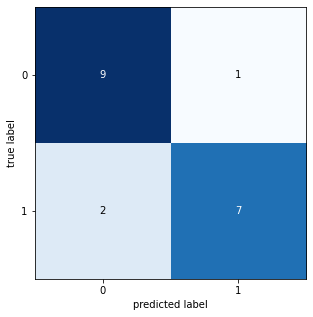

avg accuraccy Breast Cancer =  0.753157894736842
avg F1_Score Breast Cancer =  0.7481904890102494
max accuraccy Breast Cancer =  0.85
max F1_Score Breast Cancer =  0.8465473145780051
min accuraccy Breast Cancer =  0.6
min F1_Score Breast Cancer =  0.5833333333333334
Running Time:  40.01850157099943
gene : [0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0]
Train : [ 0  1  2  3  4  5  6  8 12 13 14 15 16 18 19 20 21 22 23 24 25 26 27 29
 30 31 32 33 35 37 38 39 40 41 42 43 45 46 47 48 50 51 53 54 55 58 60 61
 63 64 65 67 68 69 70 71 72 73 75 76 77 78 79 80 81 82 85 86 87 88 89 90
 91 92 93 94 95] Test : [ 7  9 10 11 17 28 34 36 44 49 52 56 57 59 62 66 74 83 84 96]
Y_Train : [1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 

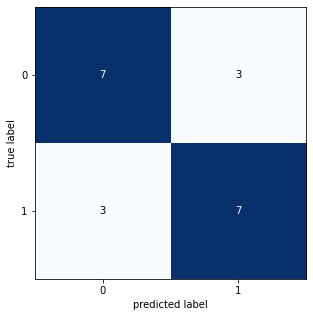

Train : [ 0  2  3  4  5  7  8  9 10 11 14 15 16 17 19 20 21 22 23 25 26 27 28 30
 31 34 35 36 37 38 39 42 43 44 45 46 47 48 49 51 52 53 54 55 56 57 58 59
 60 61 62 63 64 65 66 69 70 72 73 74 75 76 77 80 81 82 83 84 85 86 88 89
 90 91 92 95 96] Test : [ 1  6 12 13 18 24 29 32 33 40 41 50 67 68 71 78 79 87 93 94]
Y_Train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0]
Y_Test : [1 1 0 0 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Akurasi :  0.7
F1_Score :  0.7000000000000001
              precision    recall  f1-score   support

           0       0.78      0.64      0.70        11
           1       0.64      0.78      0.70         9

    accuracy                           0.70        20
   macro avg       0.71      0.71      0.70        20
weighted avg       0.71      0.70      0.70        20



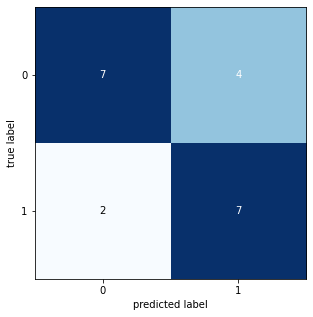

Train : [ 0  1  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 21 22 23 24 26
 28 29 32 33 34 35 36 38 40 41 42 43 44 45 46 48 49 50 51 52 53 54 55 56
 57 59 60 62 65 66 67 68 69 71 74 76 77 78 79 80 81 82 83 84 85 86 87 88
 90 91 92 93 94 96] Test : [ 2 20 25 27 30 31 37 39 47 58 61 63 64 70 72 73 75 89 95]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0]
Akurasi :  0.6842105263157895
F1_Score :  0.6761363636363636
              precision    recall  f1-score   support

           0       0.67      0.80      0.73        10
           1       0.71      0.56      0.63         9

    accuracy                           0.68        19
   macro avg       0.69      0.68      0.68        19
weighted avg       0.69      0.68      0.68        19



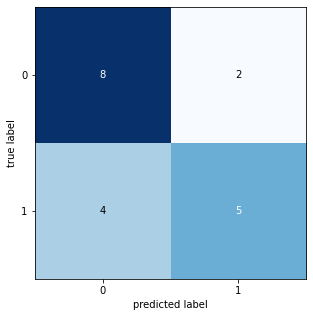

Train : [ 1  2  5  6  7  8  9 10 11 12 13 14 17 18 20 21 22 23 24 25 27 28 29 30
 31 32 33 34 35 36 37 39 40 41 42 43 44 45 47 49 50 52 53 56 57 58 59 61
 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 78 79 82 83 84 85 87 89 90
 91 92 93 94 95 96] Test : [ 0  3  4 15 16 19 26 38 46 48 51 54 55 60 77 80 81 86 88]
Y_Train : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 1 0 0 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Akurasi :  0.7894736842105263
F1_Score :  0.7888888888888888
              precision    recall  f1-score   support

           0       0.88      0.70      0.78        10
           1       0.73      0.89      0.80         9

    accuracy                           0.79        19
   macro avg       0.80      0.79      0.79        19
weighted avg       0.81      0.79      0.79        19



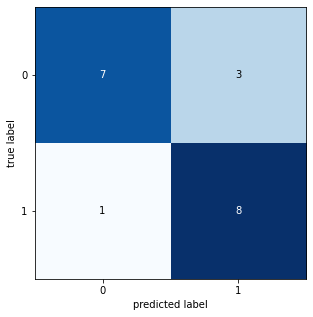

Train : [ 0  1  2  3  4  6  7  9 10 11 12 13 15 16 17 18 19 20 24 25 26 27 28 29
 30 31 32 33 34 36 37 38 39 40 41 44 46 47 48 49 50 51 52 54 55 56 57 58
 59 60 61 62 63 64 66 67 68 70 71 72 73 74 75 77 78 79 80 81 83 84 86 87
 88 89 93 94 95 96] Test : [ 5  8 14 21 22 23 35 42 43 45 53 65 69 76 82 85 90 91 92]
Y_Train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0]
Akurasi :  0.9473684210526315
F1_Score :  0.9473684210526316
              precision    recall  f1-score   support

           0       1.00      0.90      0.95        10
           1       0.90      1.00      0.95         9

    accuracy                           0.95        19
   macro avg       0.95      0.95      0.95        19
weighted avg       0.95      0.95      0.95        19



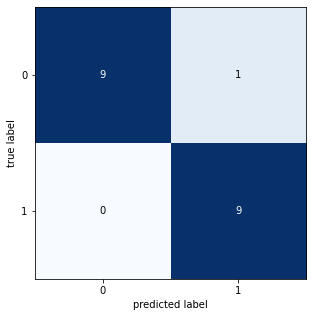

avg accuraccy Breast Cancer =  0.7642105263157893
avg F1_Score Breast Cancer =  0.7624787347155768
max accuraccy Breast Cancer =  0.9473684210526315
max F1_Score Breast Cancer =  0.9473684210526316
min accuraccy Breast Cancer =  0.6842105263157895
min F1_Score Breast Cancer =  0.6761363636363636
Running Time:  38.99216792900006
gene : [1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0]
Train : [ 0  1  2  3  4  5  6  8 12 13 14 15 16 18 19 20 21 22 23 24 25 26 27 29
 30 31 32 33 35 37 38 39 40 41 42 43 45 46 47 48 50 51 53 54 55 58 60 61
 63 64 65 67 68 69 70 71 72 73 75 76 77 78 79 80 81 82 85 86 87 88 89 90
 91 92 93 94 95] Test : [ 7  9 10 11 17 28 34 36 44 49 52 56 57 59 62 66 74 83 84 96]
Y_Train : [1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 

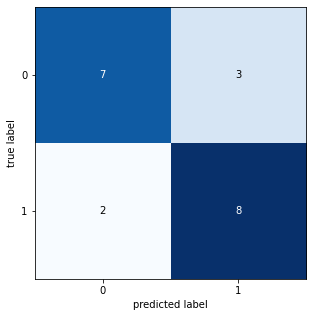

Train : [ 0  2  3  4  5  7  8  9 10 11 14 15 16 17 19 20 21 22 23 25 26 27 28 30
 31 34 35 36 37 38 39 42 43 44 45 46 47 48 49 51 52 53 54 55 56 57 58 59
 60 61 62 63 64 65 66 69 70 72 73 74 75 76 77 80 81 82 83 84 85 86 88 89
 90 91 92 95 96] Test : [ 1  6 12 13 18 24 29 32 33 40 41 50 67 68 71 78 79 87 93 94]
Y_Train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0]
Y_Test : [1 1 0 0 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Akurasi :  0.7
F1_Score :  0.7000000000000001
              precision    recall  f1-score   support

           0       0.78      0.64      0.70        11
           1       0.64      0.78      0.70         9

    accuracy                           0.70        20
   macro avg       0.71      0.71      0.70        20
weighted avg       0.71      0.70      0.70        20



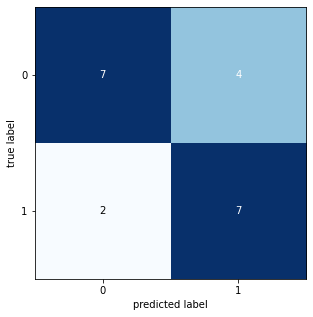

Train : [ 0  1  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 21 22 23 24 26
 28 29 32 33 34 35 36 38 40 41 42 43 44 45 46 48 49 50 51 52 53 54 55 56
 57 59 60 62 65 66 67 68 69 71 74 76 77 78 79 80 81 82 83 84 85 86 87 88
 90 91 92 93 94 96] Test : [ 2 20 25 27 30 31 37 39 47 58 61 63 64 70 72 73 75 89 95]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0]
Akurasi :  0.7368421052631579
F1_Score :  0.7338935574229692
              precision    recall  f1-score   support

           0       0.73      0.80      0.76        10
           1       0.75      0.67      0.71         9

    accuracy                           0.74        19
   macro avg       0.74      0.73      0.73        19
weighted avg       0.74      0.74      0.74        19



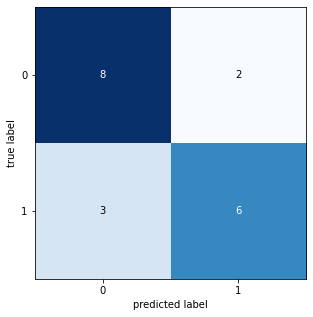

Train : [ 1  2  5  6  7  8  9 10 11 12 13 14 17 18 20 21 22 23 24 25 27 28 29 30
 31 32 33 34 35 36 37 39 40 41 42 43 44 45 47 49 50 52 53 56 57 58 59 61
 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 78 79 82 83 84 85 87 89 90
 91 92 93 94 95 96] Test : [ 0  3  4 15 16 19 26 38 46 48 51 54 55 60 77 80 81 86 88]
Y_Train : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 1 0 0 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Akurasi :  0.6842105263157895
F1_Score :  0.6833333333333333
              precision    recall  f1-score   support

           0       0.70      0.70      0.70        10
           1       0.67      0.67      0.67         9

    accuracy                           0.68        19
   macro avg       0.68      0.68      0.68        19
weighted avg       0.68      0.68      0.68        19



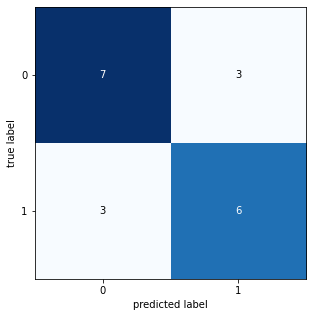

Train : [ 0  1  2  3  4  6  7  9 10 11 12 13 15 16 17 18 19 20 24 25 26 27 28 29
 30 31 32 33 34 36 37 38 39 40 41 44 46 47 48 49 50 51 52 54 55 56 57 58
 59 60 61 62 63 64 66 67 68 70 71 72 73 74 75 77 78 79 80 81 83 84 86 87
 88 89 93 94 95 96] Test : [ 5  8 14 21 22 23 35 42 43 45 53 65 69 76 82 85 90 91 92]
Y_Train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0]
Akurasi :  0.8421052631578947
F1_Score :  0.8403361344537816
              precision    recall  f1-score   support

           0       0.82      0.90      0.86        10
           1       0.88      0.78      0.82         9

    accuracy                           0.84        19
   macro avg       0.85      0.84      0.84        19
weighted avg       0.85      0.84      0.84        19



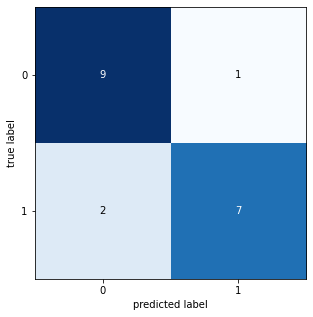

avg accuraccy Breast Cancer =  0.7426315789473683
avg F1_Score Breast Cancer =  0.7413872917588088
max accuraccy Breast Cancer =  0.8421052631578947
max F1_Score Breast Cancer =  0.8403361344537816
min accuraccy Breast Cancer =  0.6842105263157895
min F1_Score Breast Cancer =  0.6833333333333333
Running Time:  40.5471866279986
gene : [0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0]
Train : [ 0  1  2  3  4  5  6  8 12 13 14 15 16 18 19 20 21 22 23 24 25 26 27 29
 30 31 32 33 35 37 38 39 40 41 42 43 45 46 47 48 50 51 53 54 55 58 60 61
 63 64 65 67 68 69 70 71 72 73 75 76 77 78 79 80 81 82 85 86 87 88 89 90
 91 92 93 94 95] Test : [ 7  9 10 11 17 28 34 36 44 49 52 56 57 59 62 66 74 83 84 96]
Y_Train : [1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1

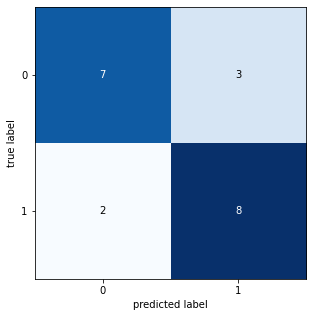

Train : [ 0  2  3  4  5  7  8  9 10 11 14 15 16 17 19 20 21 22 23 25 26 27 28 30
 31 34 35 36 37 38 39 42 43 44 45 46 47 48 49 51 52 53 54 55 56 57 58 59
 60 61 62 63 64 65 66 69 70 72 73 74 75 76 77 80 81 82 83 84 85 86 88 89
 90 91 92 95 96] Test : [ 1  6 12 13 18 24 29 32 33 40 41 50 67 68 71 78 79 87 93 94]
Y_Train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0]
Y_Test : [1 1 0 0 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Akurasi :  0.7
F1_Score :  0.6875000000000001
              precision    recall  f1-score   support

           0       0.69      0.82      0.75        11
           1       0.71      0.56      0.63         9

    accuracy                           0.70        20
   macro avg       0.70      0.69      0.69        20
weighted avg       0.70      0.70      0.69        20



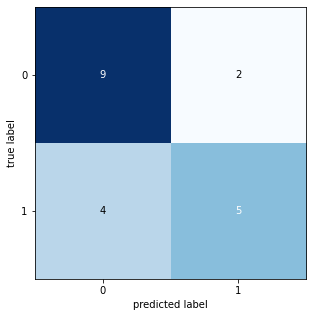

Train : [ 0  1  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 21 22 23 24 26
 28 29 32 33 34 35 36 38 40 41 42 43 44 45 46 48 49 50 51 52 53 54 55 56
 57 59 60 62 65 66 67 68 69 71 74 76 77 78 79 80 81 82 83 84 85 86 87 88
 90 91 92 93 94 96] Test : [ 2 20 25 27 30 31 37 39 47 58 61 63 64 70 72 73 75 89 95]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0]
Akurasi :  0.6842105263157895
F1_Score :  0.6833333333333333
              precision    recall  f1-score   support

           0       0.70      0.70      0.70        10
           1       0.67      0.67      0.67         9

    accuracy                           0.68        19
   macro avg       0.68      0.68      0.68        19
weighted avg       0.68      0.68      0.68        19



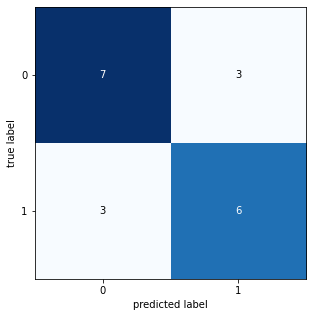

Train : [ 1  2  5  6  7  8  9 10 11 12 13 14 17 18 20 21 22 23 24 25 27 28 29 30
 31 32 33 34 35 36 37 39 40 41 42 43 44 45 47 49 50 52 53 56 57 58 59 61
 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 78 79 82 83 84 85 87 89 90
 91 92 93 94 95 96] Test : [ 0  3  4 15 16 19 26 38 46 48 51 54 55 60 77 80 81 86 88]
Y_Train : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 1 0 0 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Akurasi :  0.7894736842105263
F1_Score :  0.7888888888888888
              precision    recall  f1-score   support

           0       0.88      0.70      0.78        10
           1       0.73      0.89      0.80         9

    accuracy                           0.79        19
   macro avg       0.80      0.79      0.79        19
weighted avg       0.81      0.79      0.79        19



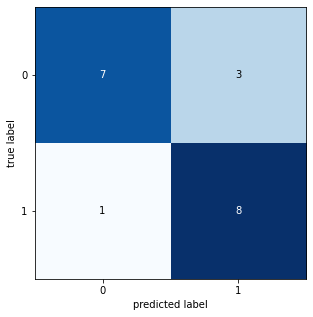

Train : [ 0  1  2  3  4  6  7  9 10 11 12 13 15 16 17 18 19 20 24 25 26 27 28 29
 30 31 32 33 34 36 37 38 39 40 41 44 46 47 48 49 50 51 52 54 55 56 57 58
 59 60 61 62 63 64 66 67 68 70 71 72 73 74 75 77 78 79 80 81 83 84 86 87
 88 89 93 94 95 96] Test : [ 5  8 14 21 22 23 35 42 43 45 53 65 69 76 82 85 90 91 92]
Y_Train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0]
Akurasi :  0.7368421052631579
F1_Score :  0.7368421052631577
              precision    recall  f1-score   support

           0       0.78      0.70      0.74        10
           1       0.70      0.78      0.74         9

    accuracy                           0.74        19
   macro avg       0.74      0.74      0.74        19
weighted avg       0.74      0.74      0.74        19



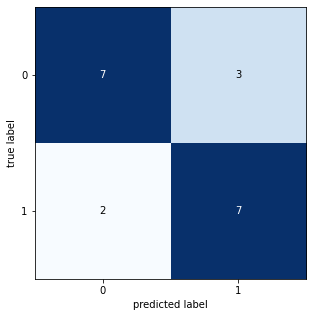

avg accuraccy Breast Cancer =  0.7321052631578948
avg F1_Score Breast Cancer =  0.729187552213868
max accuraccy Breast Cancer =  0.7894736842105263
max F1_Score Breast Cancer =  0.7888888888888888
min accuraccy Breast Cancer =  0.6842105263157895
min F1_Score Breast Cancer =  0.6833333333333333
Running Time:  38.00619458199981
gene : [1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0]
Train : [ 0  1  2  3  4  5  6  8 12 13 14 15 16 18 19 20 21 22 23 24 25 26 27 29
 30 31 32 33 35 37 38 39 40 41 42 43 45 46 47 48 50 51 53 54 55 58 60 61
 63 64 65 67 68 69 70 71 72 73 75 76 77 78 79 80 81 82 85 86 87 88 89 90
 91 92 93 94 95] Test : [ 7  9 10 11 17 28 34 36 44 49 52 56 57 59 62 66 74 83 84 96]
Y_Train : [1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1

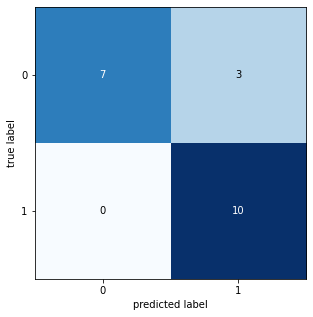

Train : [ 0  2  3  4  5  7  8  9 10 11 14 15 16 17 19 20 21 22 23 25 26 27 28 30
 31 34 35 36 37 38 39 42 43 44 45 46 47 48 49 51 52 53 54 55 56 57 58 59
 60 61 62 63 64 65 66 69 70 72 73 74 75 76 77 80 81 82 83 84 85 86 88 89
 90 91 92 95 96] Test : [ 1  6 12 13 18 24 29 32 33 40 41 50 67 68 71 78 79 87 93 94]
Y_Train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0]
Y_Test : [1 1 0 0 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Akurasi :  0.65
F1_Score :  0.6266666666666667
              precision    recall  f1-score   support

           0       0.64      0.82      0.72        11
           1       0.67      0.44      0.53         9

    accuracy                           0.65        20
   macro avg       0.65      0.63      0.63        20
weighted avg       0.65      0.65      0.64        20



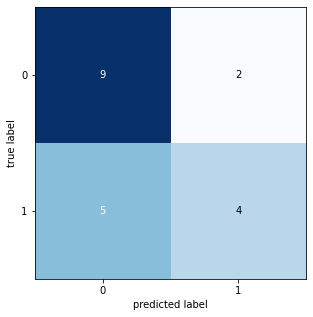

Train : [ 0  1  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 21 22 23 24 26
 28 29 32 33 34 35 36 38 40 41 42 43 44 45 46 48 49 50 51 52 53 54 55 56
 57 59 60 62 65 66 67 68 69 71 74 76 77 78 79 80 81 82 83 84 85 86 87 88
 90 91 92 93 94 96] Test : [ 2 20 25 27 30 31 37 39 47 58 61 63 64 70 72 73 75 89 95]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0]
Akurasi :  0.7368421052631579
F1_Score :  0.7368421052631577
              precision    recall  f1-score   support

           0       0.78      0.70      0.74        10
           1       0.70      0.78      0.74         9

    accuracy                           0.74        19
   macro avg       0.74      0.74      0.74        19
weighted avg       0.74      0.74      0.74        19



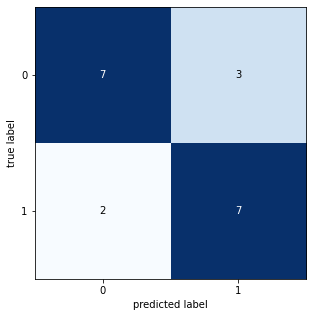

Train : [ 1  2  5  6  7  8  9 10 11 12 13 14 17 18 20 21 22 23 24 25 27 28 29 30
 31 32 33 34 35 36 37 39 40 41 42 43 44 45 47 49 50 52 53 56 57 58 59 61
 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 78 79 82 83 84 85 87 89 90
 91 92 93 94 95 96] Test : [ 0  3  4 15 16 19 26 38 46 48 51 54 55 60 77 80 81 86 88]
Y_Train : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 1 0 0 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Akurasi :  0.7368421052631579
F1_Score :  0.7338935574229692
              precision    recall  f1-score   support

           0       0.73      0.80      0.76        10
           1       0.75      0.67      0.71         9

    accuracy                           0.74        19
   macro avg       0.74      0.73      0.73        19
weighted avg       0.74      0.74      0.74        19



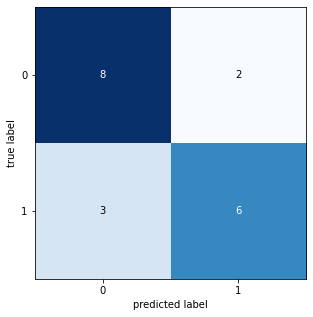

Train : [ 0  1  2  3  4  6  7  9 10 11 12 13 15 16 17 18 19 20 24 25 26 27 28 29
 30 31 32 33 34 36 37 38 39 40 41 44 46 47 48 49 50 51 52 54 55 56 57 58
 59 60 61 62 63 64 66 67 68 70 71 72 73 74 75 77 78 79 80 81 83 84 86 87
 88 89 93 94 95 96] Test : [ 5  8 14 21 22 23 35 42 43 45 53 65 69 76 82 85 90 91 92]
Y_Train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0]
Akurasi :  0.8947368421052632
F1_Score :  0.8944444444444445
              precision    recall  f1-score   support

           0       1.00      0.80      0.89        10
           1       0.82      1.00      0.90         9

    accuracy                           0.89        19
   macro avg       0.91      0.90      0.89        19
weighted avg       0.91      0.89      0.89        19



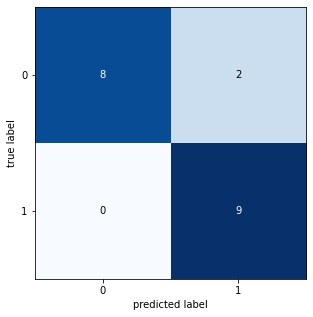

avg accuraccy Breast Cancer =  0.7736842105263159
avg F1_Score Breast Cancer =  0.7676788176750486
max accuraccy Breast Cancer =  0.8947368421052632
max F1_Score Breast Cancer =  0.8944444444444445
min accuraccy Breast Cancer =  0.65
min F1_Score Breast Cancer =  0.6266666666666667
Running Time:  39.842513925001185
gene : [0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0]
Train : [ 0  1  2  3  4  5  6  8 12 13 14 15 16 18 19 20 21 22 23 24 25 26 27 29
 30 31 32 33 35 37 38 39 40 41 42 43 45 46 47 48 50 51 53 54 55 58 60 61
 63 64 65 67 68 69 70 71 72 73 75 76 77 78 79 80 81 82 85 86 87 88 89 90
 91 92 93 94 95] Test : [ 7  9 10 11 17 28 34 36 44 49 52 56 57 59 62 66 74 83 84 96]
Y_Train : [1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1

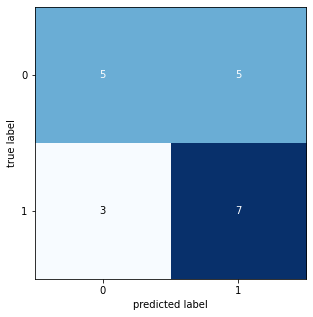

Train : [ 0  2  3  4  5  7  8  9 10 11 14 15 16 17 19 20 21 22 23 25 26 27 28 30
 31 34 35 36 37 38 39 42 43 44 45 46 47 48 49 51 52 53 54 55 56 57 58 59
 60 61 62 63 64 65 66 69 70 72 73 74 75 76 77 80 81 82 83 84 85 86 88 89
 90 91 92 95 96] Test : [ 1  6 12 13 18 24 29 32 33 40 41 50 67 68 71 78 79 87 93 94]
Y_Train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0]
Y_Test : [1 1 0 0 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Akurasi :  0.7
F1_Score :  0.696969696969697
              precision    recall  f1-score   support

           0       0.73      0.73      0.73        11
           1       0.67      0.67      0.67         9

    accuracy                           0.70        20
   macro avg       0.70      0.70      0.70        20
weighted avg       0.70      0.70      0.70        20



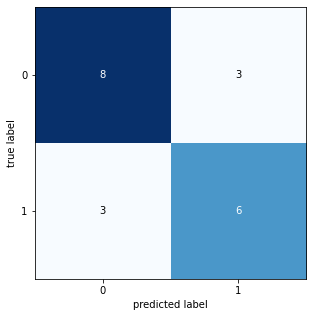

Train : [ 0  1  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 21 22 23 24 26
 28 29 32 33 34 35 36 38 40 41 42 43 44 45 46 48 49 50 51 52 53 54 55 56
 57 59 60 62 65 66 67 68 69 71 74 76 77 78 79 80 81 82 83 84 85 86 87 88
 90 91 92 93 94 96] Test : [ 2 20 25 27 30 31 37 39 47 58 61 63 64 70 72 73 75 89 95]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0]
Akurasi :  0.7368421052631579
F1_Score :  0.7338935574229692
              precision    recall  f1-score   support

           0       0.73      0.80      0.76        10
           1       0.75      0.67      0.71         9

    accuracy                           0.74        19
   macro avg       0.74      0.73      0.73        19
weighted avg       0.74      0.74      0.74        19



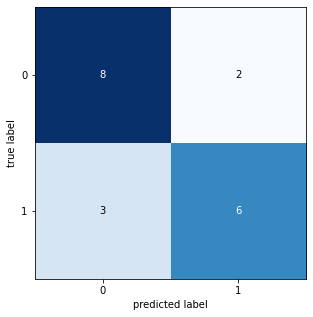

Train : [ 1  2  5  6  7  8  9 10 11 12 13 14 17 18 20 21 22 23 24 25 27 28 29 30
 31 32 33 34 35 36 37 39 40 41 42 43 44 45 47 49 50 52 53 56 57 58 59 61
 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 78 79 82 83 84 85 87 89 90
 91 92 93 94 95 96] Test : [ 0  3  4 15 16 19 26 38 46 48 51 54 55 60 77 80 81 86 88]
Y_Train : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 1 0 0 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Akurasi :  0.6842105263157895
F1_Score :  0.6833333333333333
              precision    recall  f1-score   support

           0       0.70      0.70      0.70        10
           1       0.67      0.67      0.67         9

    accuracy                           0.68        19
   macro avg       0.68      0.68      0.68        19
weighted avg       0.68      0.68      0.68        19



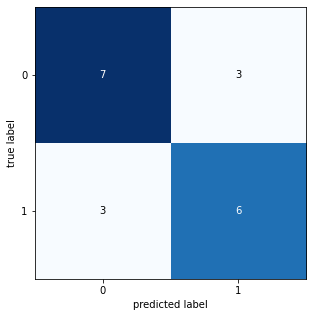

Train : [ 0  1  2  3  4  6  7  9 10 11 12 13 15 16 17 18 19 20 24 25 26 27 28 29
 30 31 32 33 34 36 37 38 39 40 41 44 46 47 48 49 50 51 52 54 55 56 57 58
 59 60 61 62 63 64 66 67 68 70 71 72 73 74 75 77 78 79 80 81 83 84 86 87
 88 89 93 94 95 96] Test : [ 5  8 14 21 22 23 35 42 43 45 53 65 69 76 82 85 90 91 92]
Y_Train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0]
Akurasi :  0.8947368421052632
F1_Score :  0.8944444444444444
              precision    recall  f1-score   support

           0       0.90      0.90      0.90        10
           1       0.89      0.89      0.89         9

    accuracy                           0.89        19
   macro avg       0.89      0.89      0.89        19
weighted avg       0.89      0.89      0.89        19



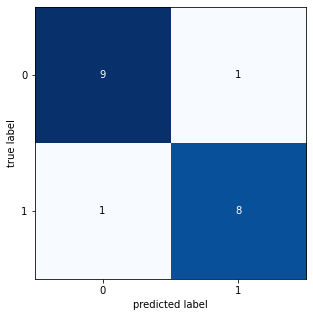

avg accuraccy Breast Cancer =  0.7231578947368421
avg F1_Score Breast Cancer =  0.720920125626008
max accuraccy Breast Cancer =  0.8947368421052632
max F1_Score Breast Cancer =  0.8944444444444444
min accuraccy Breast Cancer =  0.6
min F1_Score Breast Cancer =  0.595959595959596
Running Time:  40.868773597001564
gen terbaik : [1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0]
F-1 Score terbaik : 0.7902755216919305  || Akurasi terbaik : 0.7936842105263158  || jumlah fitur : 53

Generation : 2
gene : [1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0,

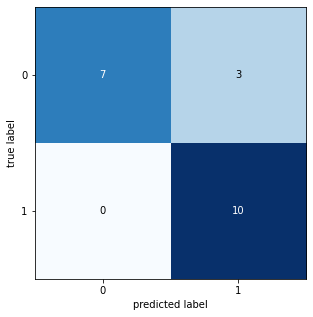

Train : [ 0  2  3  4  5  7  8  9 10 11 14 15 16 17 19 20 21 22 23 25 26 27 28 30
 31 34 35 36 37 38 39 42 43 44 45 46 47 48 49 51 52 53 54 55 56 57 58 59
 60 61 62 63 64 65 66 69 70 72 73 74 75 76 77 80 81 82 83 84 85 86 88 89
 90 91 92 95 96] Test : [ 1  6 12 13 18 24 29 32 33 40 41 50 67 68 71 78 79 87 93 94]
Y_Train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0]
Y_Test : [1 1 0 0 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Akurasi :  0.75
F1_Score :  0.7442455242966752
              precision    recall  f1-score   support

           0       0.75      0.82      0.78        11
           1       0.75      0.67      0.71         9

    accuracy                           0.75        20
   macro avg       0.75      0.74      0.74        20
weighted avg       0.75      0.75      0.75        20



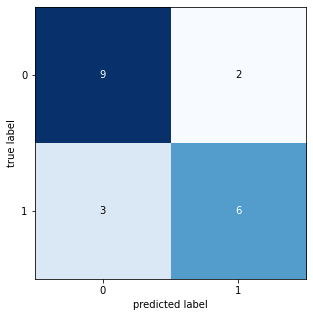

Train : [ 0  1  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 21 22 23 24 26
 28 29 32 33 34 35 36 38 40 41 42 43 44 45 46 48 49 50 51 52 53 54 55 56
 57 59 60 62 65 66 67 68 69 71 74 76 77 78 79 80 81 82 83 84 85 86 87 88
 90 91 92 93 94 96] Test : [ 2 20 25 27 30 31 37 39 47 58 61 63 64 70 72 73 75 89 95]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0]
Akurasi :  0.7368421052631579
F1_Score :  0.7338935574229692
              precision    recall  f1-score   support

           0       0.73      0.80      0.76        10
           1       0.75      0.67      0.71         9

    accuracy                           0.74        19
   macro avg       0.74      0.73      0.73        19
weighted avg       0.74      0.74      0.74        19



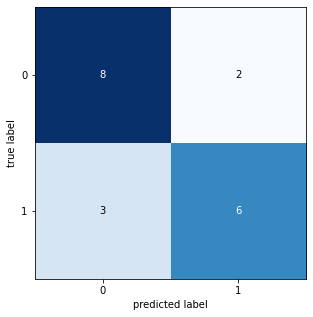

Train : [ 1  2  5  6  7  8  9 10 11 12 13 14 17 18 20 21 22 23 24 25 27 28 29 30
 31 32 33 34 35 36 37 39 40 41 42 43 44 45 47 49 50 52 53 56 57 58 59 61
 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 78 79 82 83 84 85 87 89 90
 91 92 93 94 95 96] Test : [ 0  3  4 15 16 19 26 38 46 48 51 54 55 60 77 80 81 86 88]
Y_Train : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 1 0 0 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Akurasi :  0.7368421052631579
F1_Score :  0.7338935574229692
              precision    recall  f1-score   support

           0       0.73      0.80      0.76        10
           1       0.75      0.67      0.71         9

    accuracy                           0.74        19
   macro avg       0.74      0.73      0.73        19
weighted avg       0.74      0.74      0.74        19



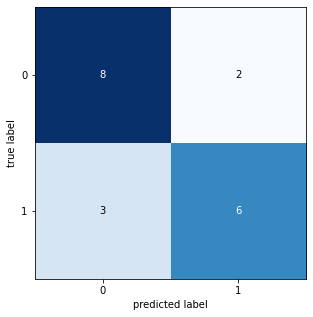

Train : [ 0  1  2  3  4  6  7  9 10 11 12 13 15 16 17 18 19 20 24 25 26 27 28 29
 30 31 32 33 34 36 37 38 39 40 41 44 46 47 48 49 50 51 52 54 55 56 57 58
 59 60 61 62 63 64 66 67 68 70 71 72 73 74 75 77 78 79 80 81 83 84 86 87
 88 89 93 94 95 96] Test : [ 5  8 14 21 22 23 35 42 43 45 53 65 69 76 82 85 90 91 92]
Y_Train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0]
Akurasi :  0.9473684210526315
F1_Score :  0.9473684210526316
              precision    recall  f1-score   support

           0       1.00      0.90      0.95        10
           1       0.90      1.00      0.95         9

    accuracy                           0.95        19
   macro avg       0.95      0.95      0.95        19
weighted avg       0.95      0.95      0.95        19



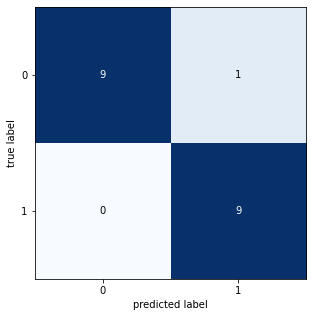

avg accuraccy Breast Cancer =  0.8042105263157895
avg F1_Score Breast Cancer =  0.8011896749546501
max accuraccy Breast Cancer =  0.9473684210526315
max F1_Score Breast Cancer =  0.9473684210526316
min accuraccy Breast Cancer =  0.7368421052631579
min F1_Score Breast Cancer =  0.7338935574229692
Running Time:  40.02036765500088
gene : [0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0]
Train : [ 0  1  2  3  4  5  6  8 12 13 14 15 16 18 19 20 21 22 23 24 25 26 27 29
 30 31 32 33 35 37 38 39 40 41 42 43 45 46 47 48 50 51 53 54 55 58 60 61
 63 64 65 67 68 69 70 71 72 73 75 76 77 78 79 80 81 82 85 86 87 88 89 90
 91 92 93 94 95] Test : [ 7  9 10 11 17 28 34 36 44 49 52 56 57 59 62 66 74 83 84 96]
Y_Train : [1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 

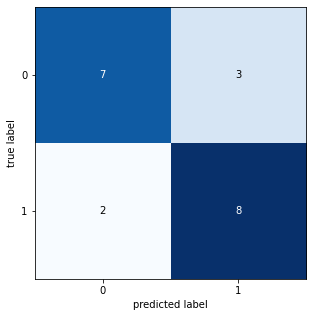

Train : [ 0  2  3  4  5  7  8  9 10 11 14 15 16 17 19 20 21 22 23 25 26 27 28 30
 31 34 35 36 37 38 39 42 43 44 45 46 47 48 49 51 52 53 54 55 56 57 58 59
 60 61 62 63 64 65 66 69 70 72 73 74 75 76 77 80 81 82 83 84 85 86 88 89
 90 91 92 95 96] Test : [ 1  6 12 13 18 24 29 32 33 40 41 50 67 68 71 78 79 87 93 94]
Y_Train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0]
Y_Test : [1 1 0 0 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Akurasi :  0.75
F1_Score :  0.7493734335839599
              precision    recall  f1-score   support

           0       0.80      0.73      0.76        11
           1       0.70      0.78      0.74         9

    accuracy                           0.75        20
   macro avg       0.75      0.75      0.75        20
weighted avg       0.76      0.75      0.75        20



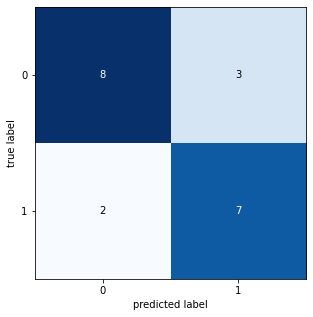

Train : [ 0  1  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 21 22 23 24 26
 28 29 32 33 34 35 36 38 40 41 42 43 44 45 46 48 49 50 51 52 53 54 55 56
 57 59 60 62 65 66 67 68 69 71 74 76 77 78 79 80 81 82 83 84 85 86 87 88
 90 91 92 93 94 96] Test : [ 2 20 25 27 30 31 37 39 47 58 61 63 64 70 72 73 75 89 95]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0]
Akurasi :  0.7368421052631579
F1_Score :  0.7338935574229692
              precision    recall  f1-score   support

           0       0.73      0.80      0.76        10
           1       0.75      0.67      0.71         9

    accuracy                           0.74        19
   macro avg       0.74      0.73      0.73        19
weighted avg       0.74      0.74      0.74        19



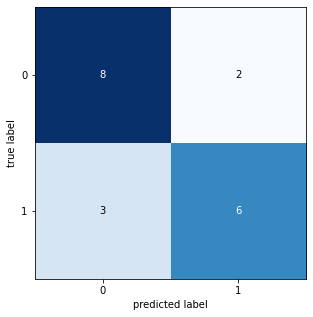

Train : [ 1  2  5  6  7  8  9 10 11 12 13 14 17 18 20 21 22 23 24 25 27 28 29 30
 31 32 33 34 35 36 37 39 40 41 42 43 44 45 47 49 50 52 53 56 57 58 59 61
 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 78 79 82 83 84 85 87 89 90
 91 92 93 94 95 96] Test : [ 0  3  4 15 16 19 26 38 46 48 51 54 55 60 77 80 81 86 88]
Y_Train : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 1 0 0 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Akurasi :  0.8421052631578947
F1_Score :  0.8421052631578948
              precision    recall  f1-score   support

           0       0.89      0.80      0.84        10
           1       0.80      0.89      0.84         9

    accuracy                           0.84        19
   macro avg       0.84      0.84      0.84        19
weighted avg       0.85      0.84      0.84        19



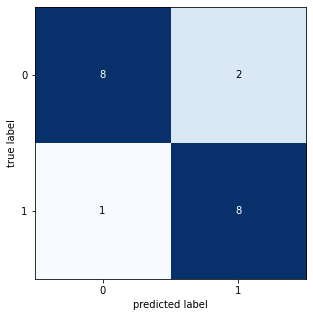

Train : [ 0  1  2  3  4  6  7  9 10 11 12 13 15 16 17 18 19 20 24 25 26 27 28 29
 30 31 32 33 34 36 37 38 39 40 41 44 46 47 48 49 50 51 52 54 55 56 57 58
 59 60 61 62 63 64 66 67 68 70 71 72 73 74 75 77 78 79 80 81 83 84 86 87
 88 89 93 94 95 96] Test : [ 5  8 14 21 22 23 35 42 43 45 53 65 69 76 82 85 90 91 92]
Y_Train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0]
Akurasi :  0.8947368421052632
F1_Score :  0.8944444444444444
              precision    recall  f1-score   support

           0       0.90      0.90      0.90        10
           1       0.89      0.89      0.89         9

    accuracy                           0.89        19
   macro avg       0.89      0.89      0.89        19
weighted avg       0.89      0.89      0.89        19



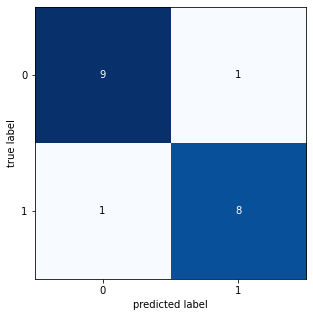

avg accuraccy Breast Cancer =  0.7947368421052632
avg F1_Score Breast Cancer =  0.7938380264386456
max accuraccy Breast Cancer =  0.8947368421052632
max F1_Score Breast Cancer =  0.8944444444444444
min accuraccy Breast Cancer =  0.7368421052631579
min F1_Score Breast Cancer =  0.7338935574229692
Running Time:  37.670927032999316
gene : [1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0]
Train : [ 0  1  2  3  4  5  6  8 12 13 14 15 16 18 19 20 21 22 23 24 25 26 27 29
 30 31 32 33 35 37 38 39 40 41 42 43 45 46 47 48 50 51 53 54 55 58 60 61
 63 64 65 67 68 69 70 71 72 73 75 76 77 78 79 80 81 82 85 86 87 88 89 90
 91 92 93 94 95] Test : [ 7  9 10 11 17 28 34 36 44 49 52 56 57 59 62 66 74 83 84 96]
Y_Train : [1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1

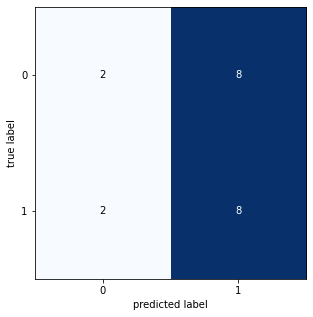

Train : [ 0  2  3  4  5  7  8  9 10 11 14 15 16 17 19 20 21 22 23 25 26 27 28 30
 31 34 35 36 37 38 39 42 43 44 45 46 47 48 49 51 52 53 54 55 56 57 58 59
 60 61 62 63 64 65 66 69 70 72 73 74 75 76 77 80 81 82 83 84 85 86 88 89
 90 91 92 95 96] Test : [ 1  6 12 13 18 24 29 32 33 40 41 50 67 68 71 78 79 87 93 94]
Y_Train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0]
Y_Test : [1 1 0 0 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Akurasi :  0.7
F1_Score :  0.6875000000000001
              precision    recall  f1-score   support

           0       0.69      0.82      0.75        11
           1       0.71      0.56      0.63         9

    accuracy                           0.70        20
   macro avg       0.70      0.69      0.69        20
weighted avg       0.70      0.70      0.69        20



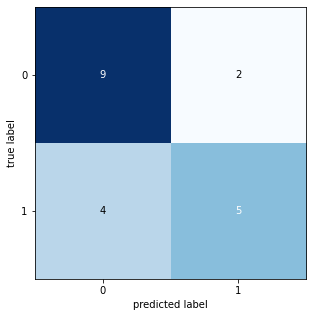

Train : [ 0  1  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 21 22 23 24 26
 28 29 32 33 34 35 36 38 40 41 42 43 44 45 46 48 49 50 51 52 53 54 55 56
 57 59 60 62 65 66 67 68 69 71 74 76 77 78 79 80 81 82 83 84 85 86 87 88
 90 91 92 93 94 96] Test : [ 2 20 25 27 30 31 37 39 47 58 61 63 64 70 72 73 75 89 95]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0]
Akurasi :  0.631578947368421
F1_Score :  0.631578947368421
              precision    recall  f1-score   support

           0       0.67      0.60      0.63        10
           1       0.60      0.67      0.63         9

    accuracy                           0.63        19
   macro avg       0.63      0.63      0.63        19
weighted avg       0.64      0.63      0.63        19



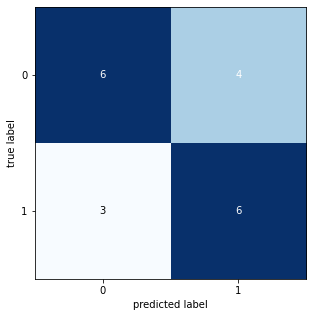

Train : [ 1  2  5  6  7  8  9 10 11 12 13 14 17 18 20 21 22 23 24 25 27 28 29 30
 31 32 33 34 35 36 37 39 40 41 42 43 44 45 47 49 50 52 53 56 57 58 59 61
 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 78 79 82 83 84 85 87 89 90
 91 92 93 94 95 96] Test : [ 0  3  4 15 16 19 26 38 46 48 51 54 55 60 77 80 81 86 88]
Y_Train : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 1 0 0 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Akurasi :  0.6842105263157895
F1_Score :  0.6833333333333333
              precision    recall  f1-score   support

           0       0.70      0.70      0.70        10
           1       0.67      0.67      0.67         9

    accuracy                           0.68        19
   macro avg       0.68      0.68      0.68        19
weighted avg       0.68      0.68      0.68        19



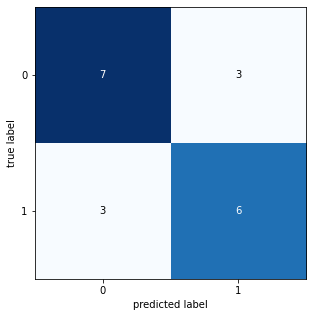

Train : [ 0  1  2  3  4  6  7  9 10 11 12 13 15 16 17 18 19 20 24 25 26 27 28 29
 30 31 32 33 34 36 37 38 39 40 41 44 46 47 48 49 50 51 52 54 55 56 57 58
 59 60 61 62 63 64 66 67 68 70 71 72 73 74 75 77 78 79 80 81 83 84 86 87
 88 89 93 94 95 96] Test : [ 5  8 14 21 22 23 35 42 43 45 53 65 69 76 82 85 90 91 92]
Y_Train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0]
Akurasi :  0.8947368421052632
F1_Score :  0.8944444444444444
              precision    recall  f1-score   support

           0       0.90      0.90      0.90        10
           1       0.89      0.89      0.89         9

    accuracy                           0.89        19
   macro avg       0.89      0.89      0.89        19
weighted avg       0.89      0.89      0.89        19



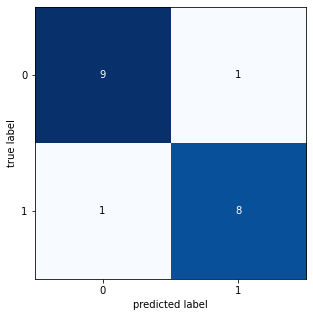

avg accuraccy Breast Cancer =  0.6821052631578948
avg F1_Score Breast Cancer =  0.6694812351391299
max accuraccy Breast Cancer =  0.8947368421052632
max F1_Score Breast Cancer =  0.8944444444444444
min accuraccy Breast Cancer =  0.5
min F1_Score Breast Cancer =  0.4505494505494506
Running Time:  40.11969282700011
gene : [0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0]
Train : [ 0  1  2  3  4  5  6  8 12 13 14 15 16 18 19 20 21 22 23 24 25 26 27 29
 30 31 32 33 35 37 38 39 40 41 42 43 45 46 47 48 50 51 53 54 55 58 60 61
 63 64 65 67 68 69 70 71 72 73 75 76 77 78 79 80 81 82 85 86 87 88 89 90
 91 92 93 94 95] Test : [ 7  9 10 11 17 28 34 36 44 49 52 56 57 59 62 66 74 83 84 96]
Y_Train : [1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1

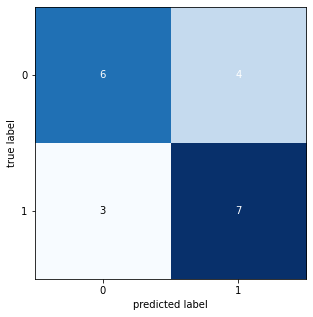

Train : [ 0  2  3  4  5  7  8  9 10 11 14 15 16 17 19 20 21 22 23 25 26 27 28 30
 31 34 35 36 37 38 39 42 43 44 45 46 47 48 49 51 52 53 54 55 56 57 58 59
 60 61 62 63 64 65 66 69 70 72 73 74 75 76 77 80 81 82 83 84 85 86 88 89
 90 91 92 95 96] Test : [ 1  6 12 13 18 24 29 32 33 40 41 50 67 68 71 78 79 87 93 94]
Y_Train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0]
Y_Test : [1 1 0 0 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Akurasi :  0.7
F1_Score :  0.696969696969697
              precision    recall  f1-score   support

           0       0.73      0.73      0.73        11
           1       0.67      0.67      0.67         9

    accuracy                           0.70        20
   macro avg       0.70      0.70      0.70        20
weighted avg       0.70      0.70      0.70        20



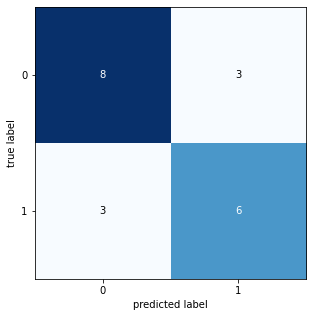

Train : [ 0  1  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 21 22 23 24 26
 28 29 32 33 34 35 36 38 40 41 42 43 44 45 46 48 49 50 51 52 53 54 55 56
 57 59 60 62 65 66 67 68 69 71 74 76 77 78 79 80 81 82 83 84 85 86 87 88
 90 91 92 93 94 96] Test : [ 2 20 25 27 30 31 37 39 47 58 61 63 64 70 72 73 75 89 95]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0]
Akurasi :  0.8421052631578947
F1_Score :  0.8403361344537816
              precision    recall  f1-score   support

           0       0.82      0.90      0.86        10
           1       0.88      0.78      0.82         9

    accuracy                           0.84        19
   macro avg       0.85      0.84      0.84        19
weighted avg       0.85      0.84      0.84        19



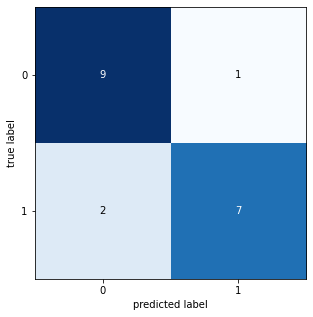

Train : [ 1  2  5  6  7  8  9 10 11 12 13 14 17 18 20 21 22 23 24 25 27 28 29 30
 31 32 33 34 35 36 37 39 40 41 42 43 44 45 47 49 50 52 53 56 57 58 59 61
 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 78 79 82 83 84 85 87 89 90
 91 92 93 94 95 96] Test : [ 0  3  4 15 16 19 26 38 46 48 51 54 55 60 77 80 81 86 88]
Y_Train : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 1 0 0 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Akurasi :  0.7894736842105263
F1_Score :  0.7888888888888888
              precision    recall  f1-score   support

           0       0.88      0.70      0.78        10
           1       0.73      0.89      0.80         9

    accuracy                           0.79        19
   macro avg       0.80      0.79      0.79        19
weighted avg       0.81      0.79      0.79        19



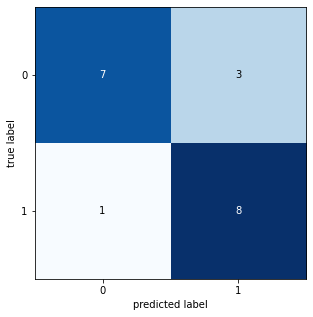

Train : [ 0  1  2  3  4  6  7  9 10 11 12 13 15 16 17 18 19 20 24 25 26 27 28 29
 30 31 32 33 34 36 37 38 39 40 41 44 46 47 48 49 50 51 52 54 55 56 57 58
 59 60 61 62 63 64 66 67 68 70 71 72 73 74 75 77 78 79 80 81 83 84 86 87
 88 89 93 94 95 96] Test : [ 5  8 14 21 22 23 35 42 43 45 53 65 69 76 82 85 90 91 92]
Y_Train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0]
Akurasi :  0.8421052631578947
F1_Score :  0.8421052631578948
              precision    recall  f1-score   support

           0       0.89      0.80      0.84        10
           1       0.80      0.89      0.84         9

    accuracy                           0.84        19
   macro avg       0.84      0.84      0.84        19
weighted avg       0.85      0.84      0.84        19



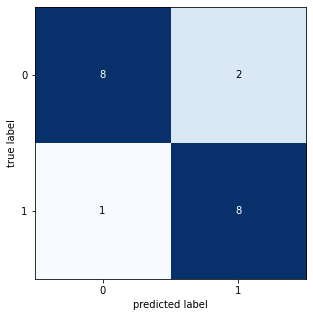

avg accuraccy Breast Cancer =  0.7647368421052632
avg F1_Score Breast Cancer =  0.7634845580975612
max accuraccy Breast Cancer =  0.8421052631578947
max F1_Score Breast Cancer =  0.8421052631578948
min accuraccy Breast Cancer =  0.65
min F1_Score Breast Cancer =  0.6491228070175439
Running Time:  38.67268001499906
gene : [0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0]
Train : [ 0  1  2  3  4  5  6  8 12 13 14 15 16 18 19 20 21 22 23 24 25 26 27 29
 30 31 32 33 35 37 38 39 40 41 42 43 45 46 47 48 50 51 53 54 55 58 60 61
 63 64 65 67 68 69 70 71 72 73 75 76 77 78 79 80 81 82 85 86 87 88 89 90
 91 92 93 94 95] Test : [ 7  9 10 11 17 28 34 36 44 49 52 56 57 59 62 66 74 83 84 96]
Y_Train : [1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 

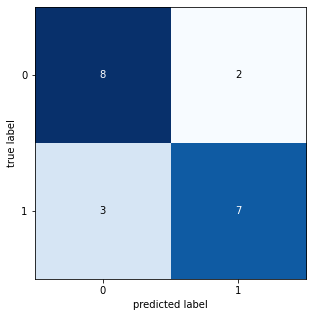

Train : [ 0  2  3  4  5  7  8  9 10 11 14 15 16 17 19 20 21 22 23 25 26 27 28 30
 31 34 35 36 37 38 39 42 43 44 45 46 47 48 49 51 52 53 54 55 56 57 58 59
 60 61 62 63 64 65 66 69 70 72 73 74 75 76 77 80 81 82 83 84 85 86 88 89
 90 91 92 95 96] Test : [ 1  6 12 13 18 24 29 32 33 40 41 50 67 68 71 78 79 87 93 94]
Y_Train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0]
Y_Test : [1 1 0 0 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Akurasi :  0.7
F1_Score :  0.7000000000000001
              precision    recall  f1-score   support

           0       0.78      0.64      0.70        11
           1       0.64      0.78      0.70         9

    accuracy                           0.70        20
   macro avg       0.71      0.71      0.70        20
weighted avg       0.71      0.70      0.70        20



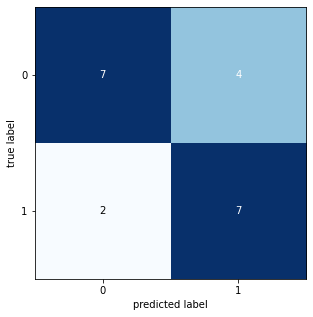

Train : [ 0  1  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 21 22 23 24 26
 28 29 32 33 34 35 36 38 40 41 42 43 44 45 46 48 49 50 51 52 53 54 55 56
 57 59 60 62 65 66 67 68 69 71 74 76 77 78 79 80 81 82 83 84 85 86 87 88
 90 91 92 93 94 96] Test : [ 2 20 25 27 30 31 37 39 47 58 61 63 64 70 72 73 75 89 95]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0]
Akurasi :  0.7368421052631579
F1_Score :  0.7338935574229692
              precision    recall  f1-score   support

           0       0.73      0.80      0.76        10
           1       0.75      0.67      0.71         9

    accuracy                           0.74        19
   macro avg       0.74      0.73      0.73        19
weighted avg       0.74      0.74      0.74        19



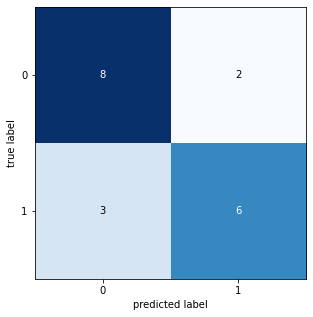

Train : [ 1  2  5  6  7  8  9 10 11 12 13 14 17 18 20 21 22 23 24 25 27 28 29 30
 31 32 33 34 35 36 37 39 40 41 42 43 44 45 47 49 50 52 53 56 57 58 59 61
 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 78 79 82 83 84 85 87 89 90
 91 92 93 94 95 96] Test : [ 0  3  4 15 16 19 26 38 46 48 51 54 55 60 77 80 81 86 88]
Y_Train : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 1 0 0 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Akurasi :  0.7368421052631579
F1_Score :  0.7368421052631577
              precision    recall  f1-score   support

           0       0.78      0.70      0.74        10
           1       0.70      0.78      0.74         9

    accuracy                           0.74        19
   macro avg       0.74      0.74      0.74        19
weighted avg       0.74      0.74      0.74        19



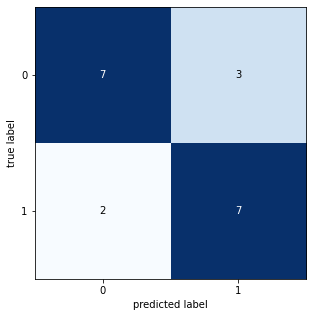

Train : [ 0  1  2  3  4  6  7  9 10 11 12 13 15 16 17 18 19 20 24 25 26 27 28 29
 30 31 32 33 34 36 37 38 39 40 41 44 46 47 48 49 50 51 52 54 55 56 57 58
 59 60 61 62 63 64 66 67 68 70 71 72 73 74 75 77 78 79 80 81 83 84 86 87
 88 89 93 94 95 96] Test : [ 5  8 14 21 22 23 35 42 43 45 53 65 69 76 82 85 90 91 92]
Y_Train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0]
Akurasi :  0.7368421052631579
F1_Score :  0.7338935574229692
              precision    recall  f1-score   support

           0       0.86      0.60      0.71        10
           1       0.67      0.89      0.76         9

    accuracy                           0.74        19
   macro avg       0.76      0.74      0.73        19
weighted avg       0.77      0.74      0.73        19



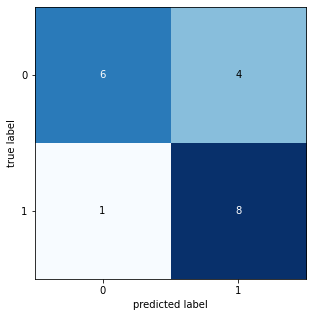

avg accuraccy Breast Cancer =  0.7321052631578947
avg F1_Score Breast Cancer =  0.7308005307386113
max accuraccy Breast Cancer =  0.75
max F1_Score Breast Cancer =  0.7493734335839599
min accuraccy Breast Cancer =  0.7
min F1_Score Breast Cancer =  0.7000000000000001
Running Time:  40.91769770799874
gene : [0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0]
Train : [ 0  1  2  3  4  5  6  8 12 13 14 15 16 18 19 20 21 22 23 24 25 26 27 29
 30 31 32 33 35 37 38 39 40 41 42 43 45 46 47 48 50 51 53 54 55 58 60 61
 63 64 65 67 68 69 70 71 72 73 75 76 77 78 79 80 81 82 85 86 87 88 89 90
 91 92 93 94 95] Test : [ 7  9 10 11 17 28 34 36 44 49 52 56 57 59 62 66 74 83 84 96]
Y_Train : [1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1

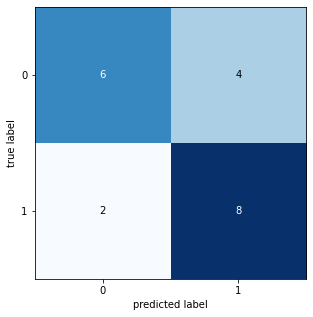

Train : [ 0  2  3  4  5  7  8  9 10 11 14 15 16 17 19 20 21 22 23 25 26 27 28 30
 31 34 35 36 37 38 39 42 43 44 45 46 47 48 49 51 52 53 54 55 56 57 58 59
 60 61 62 63 64 65 66 69 70 72 73 74 75 76 77 80 81 82 83 84 85 86 88 89
 90 91 92 95 96] Test : [ 1  6 12 13 18 24 29 32 33 40 41 50 67 68 71 78 79 87 93 94]
Y_Train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0]
Y_Test : [1 1 0 0 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Akurasi :  0.55
F1_Score :  0.4871794871794871
              precision    recall  f1-score   support

           0       0.56      0.82      0.67        11
           1       0.50      0.22      0.31         9

    accuracy                           0.55        20
   macro avg       0.53      0.52      0.49        20
weighted avg       0.53      0.55      0.51        20



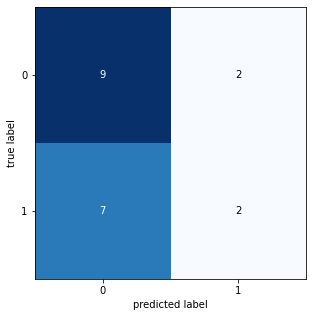

Train : [ 0  1  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 21 22 23 24 26
 28 29 32 33 34 35 36 38 40 41 42 43 44 45 46 48 49 50 51 52 53 54 55 56
 57 59 60 62 65 66 67 68 69 71 74 76 77 78 79 80 81 82 83 84 85 86 87 88
 90 91 92 93 94 96] Test : [ 2 20 25 27 30 31 37 39 47 58 61 63 64 70 72 73 75 89 95]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0]
Akurasi :  0.631578947368421
F1_Score :  0.6274509803921569
              precision    recall  f1-score   support

           0       0.64      0.70      0.67        10
           1       0.62      0.56      0.59         9

    accuracy                           0.63        19
   macro avg       0.63      0.63      0.63        19
weighted avg       0.63      0.63      0.63        19



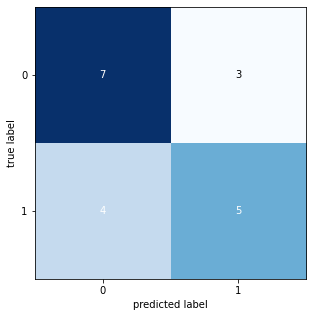

Train : [ 1  2  5  6  7  8  9 10 11 12 13 14 17 18 20 21 22 23 24 25 27 28 29 30
 31 32 33 34 35 36 37 39 40 41 42 43 44 45 47 49 50 52 53 56 57 58 59 61
 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 78 79 82 83 84 85 87 89 90
 91 92 93 94 95 96] Test : [ 0  3  4 15 16 19 26 38 46 48 51 54 55 60 77 80 81 86 88]
Y_Train : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 1 0 0 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Akurasi :  0.7368421052631579
F1_Score :  0.7338935574229692
              precision    recall  f1-score   support

           0       0.86      0.60      0.71        10
           1       0.67      0.89      0.76         9

    accuracy                           0.74        19
   macro avg       0.76      0.74      0.73        19
weighted avg       0.77      0.74      0.73        19



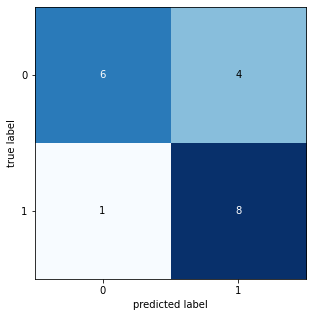

Train : [ 0  1  2  3  4  6  7  9 10 11 12 13 15 16 17 18 19 20 24 25 26 27 28 29
 30 31 32 33 34 36 37 38 39 40 41 44 46 47 48 49 50 51 52 54 55 56 57 58
 59 60 61 62 63 64 66 67 68 70 71 72 73 74 75 77 78 79 80 81 83 84 86 87
 88 89 93 94 95 96] Test : [ 5  8 14 21 22 23 35 42 43 45 53 65 69 76 82 85 90 91 92]
Y_Train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0]
Akurasi :  0.9473684210526315
F1_Score :  0.9473684210526316
              precision    recall  f1-score   support

           0       1.00      0.90      0.95        10
           1       0.90      1.00      0.95         9

    accuracy                           0.95        19
   macro avg       0.95      0.95      0.95        19
weighted avg       0.95      0.95      0.95        19



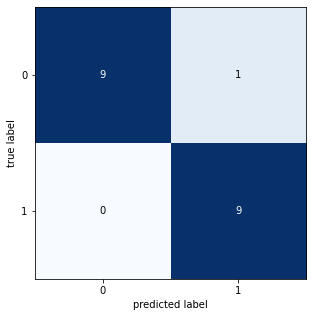

avg accuraccy Breast Cancer =  0.713157894736842
avg F1_Score Breast Cancer =  0.6985724286033884
max accuraccy Breast Cancer =  0.9473684210526315
max F1_Score Breast Cancer =  0.9473684210526316
min accuraccy Breast Cancer =  0.55
min F1_Score Breast Cancer =  0.4871794871794871
Running Time:  38.775642062999395
gene : [0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0]
Train : [ 0  1  2  3  4  5  6  8 12 13 14 15 16 18 19 20 21 22 23 24 25 26 27 29
 30 31 32 33 35 37 38 39 40 41 42 43 45 46 47 48 50 51 53 54 55 58 60 61
 63 64 65 67 68 69 70 71 72 73 75 76 77 78 79 80 81 82 85 86 87 88 89 90
 91 92 93 94 95] Test : [ 7  9 10 11 17 28 34 36 44 49 52 56 57 59 62 66 74 83 84 96]
Y_Train : [1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 

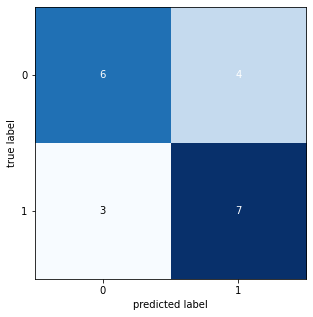

Train : [ 0  2  3  4  5  7  8  9 10 11 14 15 16 17 19 20 21 22 23 25 26 27 28 30
 31 34 35 36 37 38 39 42 43 44 45 46 47 48 49 51 52 53 54 55 56 57 58 59
 60 61 62 63 64 65 66 69 70 72 73 74 75 76 77 80 81 82 83 84 85 86 88 89
 90 91 92 95 96] Test : [ 1  6 12 13 18 24 29 32 33 40 41 50 67 68 71 78 79 87 93 94]
Y_Train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0]
Y_Test : [1 1 0 0 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Akurasi :  0.8
F1_Score :  0.797979797979798
              precision    recall  f1-score   support

           0       0.82      0.82      0.82        11
           1       0.78      0.78      0.78         9

    accuracy                           0.80        20
   macro avg       0.80      0.80      0.80        20
weighted avg       0.80      0.80      0.80        20



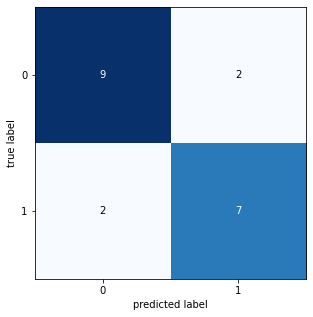

Train : [ 0  1  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 21 22 23 24 26
 28 29 32 33 34 35 36 38 40 41 42 43 44 45 46 48 49 50 51 52 53 54 55 56
 57 59 60 62 65 66 67 68 69 71 74 76 77 78 79 80 81 82 83 84 85 86 87 88
 90 91 92 93 94 96] Test : [ 2 20 25 27 30 31 37 39 47 58 61 63 64 70 72 73 75 89 95]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0]
Akurasi :  0.7368421052631579
F1_Score :  0.7338935574229692
              precision    recall  f1-score   support

           0       0.73      0.80      0.76        10
           1       0.75      0.67      0.71         9

    accuracy                           0.74        19
   macro avg       0.74      0.73      0.73        19
weighted avg       0.74      0.74      0.74        19



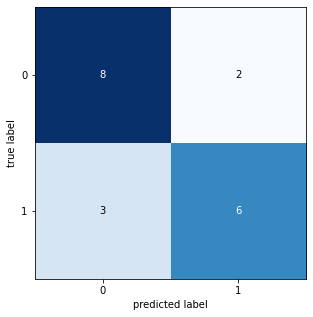

Train : [ 1  2  5  6  7  8  9 10 11 12 13 14 17 18 20 21 22 23 24 25 27 28 29 30
 31 32 33 34 35 36 37 39 40 41 42 43 44 45 47 49 50 52 53 56 57 58 59 61
 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 78 79 82 83 84 85 87 89 90
 91 92 93 94 95 96] Test : [ 0  3  4 15 16 19 26 38 46 48 51 54 55 60 77 80 81 86 88]
Y_Train : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 1 0 0 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Akurasi :  0.6842105263157895
F1_Score :  0.6833333333333333
              precision    recall  f1-score   support

           0       0.75      0.60      0.67        10
           1       0.64      0.78      0.70         9

    accuracy                           0.68        19
   macro avg       0.69      0.69      0.68        19
weighted avg       0.70      0.68      0.68        19



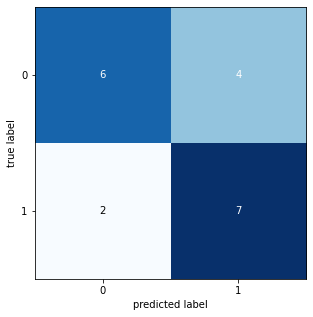

Train : [ 0  1  2  3  4  6  7  9 10 11 12 13 15 16 17 18 19 20 24 25 26 27 28 29
 30 31 32 33 34 36 37 38 39 40 41 44 46 47 48 49 50 51 52 54 55 56 57 58
 59 60 61 62 63 64 66 67 68 70 71 72 73 74 75 77 78 79 80 81 83 84 86 87
 88 89 93 94 95 96] Test : [ 5  8 14 21 22 23 35 42 43 45 53 65 69 76 82 85 90 91 92]
Y_Train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0]
Akurasi :  0.8421052631578947
F1_Score :  0.8403361344537816
              precision    recall  f1-score   support

           0       0.82      0.90      0.86        10
           1       0.88      0.78      0.82         9

    accuracy                           0.84        19
   macro avg       0.85      0.84      0.84        19
weighted avg       0.85      0.84      0.84        19



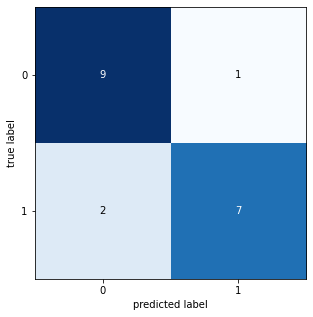

avg accuraccy Breast Cancer =  0.7426315789473684
avg F1_Score Breast Cancer =  0.7409331260414853
max accuraccy Breast Cancer =  0.8421052631578947
max F1_Score Breast Cancer =  0.8403361344537816
min accuraccy Breast Cancer =  0.65
min F1_Score Breast Cancer =  0.6491228070175439
Running Time:  39.08393610299936
gene : [0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1]
Train : [ 0  1  2  3  4  5  6  8 12 13 14 15 16 18 19 20 21 22 23 24 25 26 27 29
 30 31 32 33 35 37 38 39 40 41 42 43 45 46 47 48 50 51 53 54 55 58 60 61
 63 64 65 67 68 69 70 71 72 73 75 76 77 78 79 80 81 82 85 86 87 88 89 90
 91 92 93 94 95] Test : [ 7  9 10 11 17 28 34 36 44 49 52 56 57 59 62 66 74 83 84 96]
Y_Train : [1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 

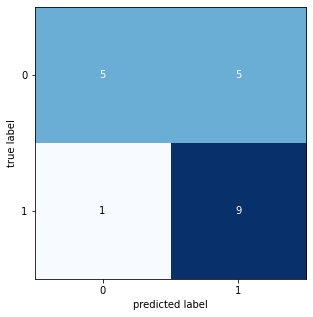

Train : [ 0  2  3  4  5  7  8  9 10 11 14 15 16 17 19 20 21 22 23 25 26 27 28 30
 31 34 35 36 37 38 39 42 43 44 45 46 47 48 49 51 52 53 54 55 56 57 58 59
 60 61 62 63 64 65 66 69 70 72 73 74 75 76 77 80 81 82 83 84 85 86 88 89
 90 91 92 95 96] Test : [ 1  6 12 13 18 24 29 32 33 40 41 50 67 68 71 78 79 87 93 94]
Y_Train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0]
Y_Test : [1 1 0 0 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Akurasi :  0.8
F1_Score :  0.797979797979798
              precision    recall  f1-score   support

           0       0.82      0.82      0.82        11
           1       0.78      0.78      0.78         9

    accuracy                           0.80        20
   macro avg       0.80      0.80      0.80        20
weighted avg       0.80      0.80      0.80        20



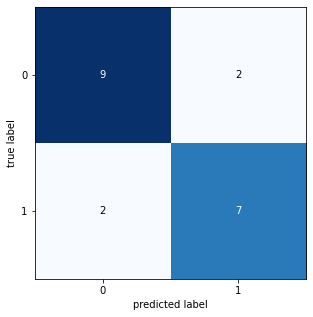

Train : [ 0  1  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 21 22 23 24 26
 28 29 32 33 34 35 36 38 40 41 42 43 44 45 46 48 49 50 51 52 53 54 55 56
 57 59 60 62 65 66 67 68 69 71 74 76 77 78 79 80 81 82 83 84 85 86 87 88
 90 91 92 93 94 96] Test : [ 2 20 25 27 30 31 37 39 47 58 61 63 64 70 72 73 75 89 95]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0]
Akurasi :  0.6842105263157895
F1_Score :  0.6761363636363636
              precision    recall  f1-score   support

           0       0.67      0.80      0.73        10
           1       0.71      0.56      0.63         9

    accuracy                           0.68        19
   macro avg       0.69      0.68      0.68        19
weighted avg       0.69      0.68      0.68        19



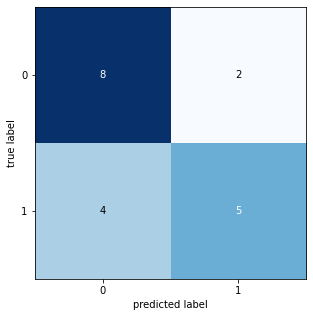

Train : [ 1  2  5  6  7  8  9 10 11 12 13 14 17 18 20 21 22 23 24 25 27 28 29 30
 31 32 33 34 35 36 37 39 40 41 42 43 44 45 47 49 50 52 53 56 57 58 59 61
 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 78 79 82 83 84 85 87 89 90
 91 92 93 94 95 96] Test : [ 0  3  4 15 16 19 26 38 46 48 51 54 55 60 77 80 81 86 88]
Y_Train : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 1 0 0 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Akurasi :  0.7894736842105263
F1_Score :  0.788888888888889
              precision    recall  f1-score   support

           0       0.80      0.80      0.80        10
           1       0.78      0.78      0.78         9

    accuracy                           0.79        19
   macro avg       0.79      0.79      0.79        19
weighted avg       0.79      0.79      0.79        19



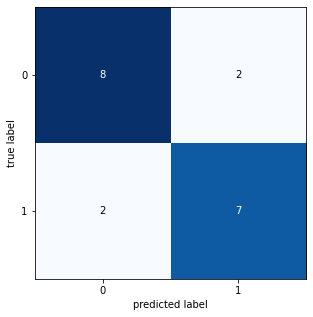

Train : [ 0  1  2  3  4  6  7  9 10 11 12 13 15 16 17 18 19 20 24 25 26 27 28 29
 30 31 32 33 34 36 37 38 39 40 41 44 46 47 48 49 50 51 52 54 55 56 57 58
 59 60 61 62 63 64 66 67 68 70 71 72 73 74 75 77 78 79 80 81 83 84 86 87
 88 89 93 94 95 96] Test : [ 5  8 14 21 22 23 35 42 43 45 53 65 69 76 82 85 90 91 92]
Y_Train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0]
Akurasi :  0.8421052631578947
F1_Score :  0.8403361344537814
              precision    recall  f1-score   support

           0       1.00      0.70      0.82        10
           1       0.75      1.00      0.86         9

    accuracy                           0.84        19
   macro avg       0.88      0.85      0.84        19
weighted avg       0.88      0.84      0.84        19



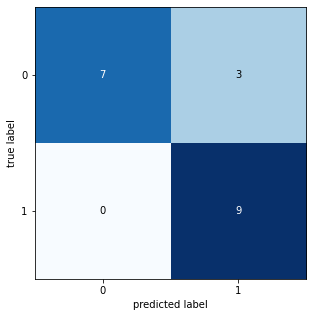

avg accuraccy Breast Cancer =  0.7631578947368421
avg F1_Score Breast Cancer =  0.7581682369917664
max accuraccy Breast Cancer =  0.8421052631578947
max F1_Score Breast Cancer =  0.8403361344537814
min accuraccy Breast Cancer =  0.6842105263157895
min F1_Score Breast Cancer =  0.6761363636363636
Running Time:  39.687218697999924
gene : [1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0]
Train : [ 0  1  2  3  4  5  6  8 12 13 14 15 16 18 19 20 21 22 23 24 25 26 27 29
 30 31 32 33 35 37 38 39 40 41 42 43 45 46 47 48 50 51 53 54 55 58 60 61
 63 64 65 67 68 69 70 71 72 73 75 76 77 78 79 80 81 82 85 86 87 88 89 90
 91 92 93 94 95] Test : [ 7  9 10 11 17 28 34 36 44 49 52 56 57 59 62 66 74 83 84 96]
Y_Train : [1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1

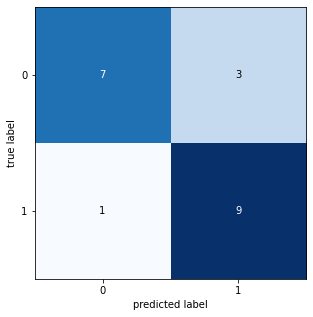

Train : [ 0  2  3  4  5  7  8  9 10 11 14 15 16 17 19 20 21 22 23 25 26 27 28 30
 31 34 35 36 37 38 39 42 43 44 45 46 47 48 49 51 52 53 54 55 56 57 58 59
 60 61 62 63 64 65 66 69 70 72 73 74 75 76 77 80 81 82 83 84 85 86 88 89
 90 91 92 95 96] Test : [ 1  6 12 13 18 24 29 32 33 40 41 50 67 68 71 78 79 87 93 94]
Y_Train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0]
Y_Test : [1 1 0 0 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Akurasi :  0.6
F1_Score :  0.5604395604395604
              precision    recall  f1-score   support

           0       0.60      0.82      0.69        11
           1       0.60      0.33      0.43         9

    accuracy                           0.60        20
   macro avg       0.60      0.58      0.56        20
weighted avg       0.60      0.60      0.57        20



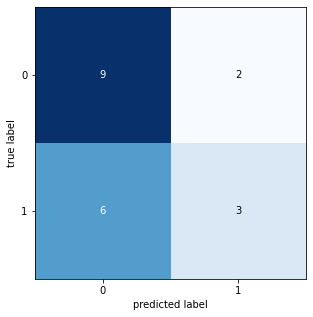

Train : [ 0  1  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 21 22 23 24 26
 28 29 32 33 34 35 36 38 40 41 42 43 44 45 46 48 49 50 51 52 53 54 55 56
 57 59 60 62 65 66 67 68 69 71 74 76 77 78 79 80 81 82 83 84 85 86 87 88
 90 91 92 93 94 96] Test : [ 2 20 25 27 30 31 37 39 47 58 61 63 64 70 72 73 75 89 95]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0]
Akurasi :  0.6842105263157895
F1_Score :  0.6833333333333333
              precision    recall  f1-score   support

           0       0.75      0.60      0.67        10
           1       0.64      0.78      0.70         9

    accuracy                           0.68        19
   macro avg       0.69      0.69      0.68        19
weighted avg       0.70      0.68      0.68        19



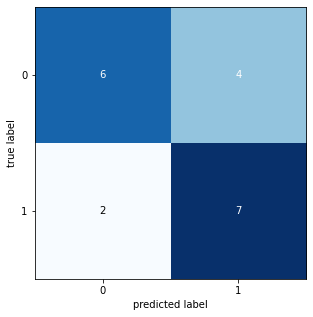

Train : [ 1  2  5  6  7  8  9 10 11 12 13 14 17 18 20 21 22 23 24 25 27 28 29 30
 31 32 33 34 35 36 37 39 40 41 42 43 44 45 47 49 50 52 53 56 57 58 59 61
 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 78 79 82 83 84 85 87 89 90
 91 92 93 94 95 96] Test : [ 0  3  4 15 16 19 26 38 46 48 51 54 55 60 77 80 81 86 88]
Y_Train : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 1 0 0 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Akurasi :  0.7368421052631579
F1_Score :  0.7338935574229692
              precision    recall  f1-score   support

           0       0.73      0.80      0.76        10
           1       0.75      0.67      0.71         9

    accuracy                           0.74        19
   macro avg       0.74      0.73      0.73        19
weighted avg       0.74      0.74      0.74        19



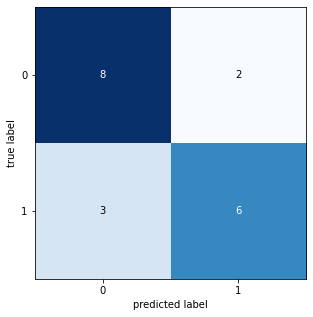

Train : [ 0  1  2  3  4  6  7  9 10 11 12 13 15 16 17 18 19 20 24 25 26 27 28 29
 30 31 32 33 34 36 37 38 39 40 41 44 46 47 48 49 50 51 52 54 55 56 57 58
 59 60 61 62 63 64 66 67 68 70 71 72 73 74 75 77 78 79 80 81 83 84 86 87
 88 89 93 94 95 96] Test : [ 5  8 14 21 22 23 35 42 43 45 53 65 69 76 82 85 90 91 92]
Y_Train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0]
Akurasi :  0.8947368421052632
F1_Score :  0.8944444444444445
              precision    recall  f1-score   support

           0       1.00      0.80      0.89        10
           1       0.82      1.00      0.90         9

    accuracy                           0.89        19
   macro avg       0.91      0.90      0.89        19
weighted avg       0.91      0.89      0.89        19



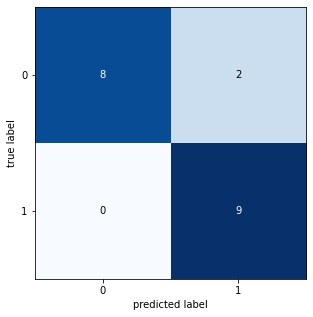

avg accuraccy Breast Cancer =  0.7431578947368421
avg F1_Score Breast Cancer =  0.7340181387240211
max accuraccy Breast Cancer =  0.8947368421052632
max F1_Score Breast Cancer =  0.8944444444444445
min accuraccy Breast Cancer =  0.6
min F1_Score Breast Cancer =  0.5604395604395604
Running Time:  37.46807772300053
gene : [0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0]
Train : [ 0  1  2  3  4  5  6  8 12 13 14 15 16 18 19 20 21 22 23 24 25 26 27 29
 30 31 32 33 35 37 38 39 40 41 42 43 45 46 47 48 50 51 53 54 55 58 60 61
 63 64 65 67 68 69 70 71 72 73 75 76 77 78 79 80 81 82 85 86 87 88 89 90
 91 92 93 94 95] Test : [ 7  9 10 11 17 28 34 36 44 49 52 56 57 59 62 66 74 83 84 96]
Y_Train : [1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1

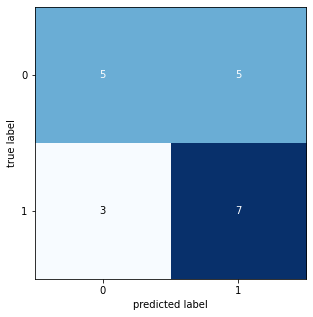

Train : [ 0  2  3  4  5  7  8  9 10 11 14 15 16 17 19 20 21 22 23 25 26 27 28 30
 31 34 35 36 37 38 39 42 43 44 45 46 47 48 49 51 52 53 54 55 56 57 58 59
 60 61 62 63 64 65 66 69 70 72 73 74 75 76 77 80 81 82 83 84 85 86 88 89
 90 91 92 95 96] Test : [ 1  6 12 13 18 24 29 32 33 40 41 50 67 68 71 78 79 87 93 94]
Y_Train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0]
Y_Test : [1 1 0 0 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Akurasi :  0.75
F1_Score :  0.7493734335839599
              precision    recall  f1-score   support

           0       0.80      0.73      0.76        11
           1       0.70      0.78      0.74         9

    accuracy                           0.75        20
   macro avg       0.75      0.75      0.75        20
weighted avg       0.76      0.75      0.75        20



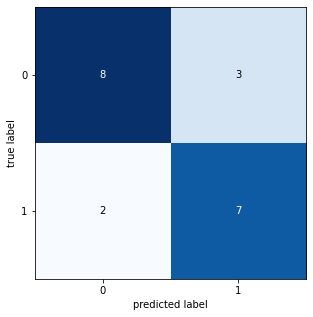

Train : [ 0  1  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 21 22 23 24 26
 28 29 32 33 34 35 36 38 40 41 42 43 44 45 46 48 49 50 51 52 53 54 55 56
 57 59 60 62 65 66 67 68 69 71 74 76 77 78 79 80 81 82 83 84 85 86 87 88
 90 91 92 93 94 96] Test : [ 2 20 25 27 30 31 37 39 47 58 61 63 64 70 72 73 75 89 95]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0]
Akurasi :  0.7368421052631579
F1_Score :  0.7338935574229692
              precision    recall  f1-score   support

           0       0.73      0.80      0.76        10
           1       0.75      0.67      0.71         9

    accuracy                           0.74        19
   macro avg       0.74      0.73      0.73        19
weighted avg       0.74      0.74      0.74        19



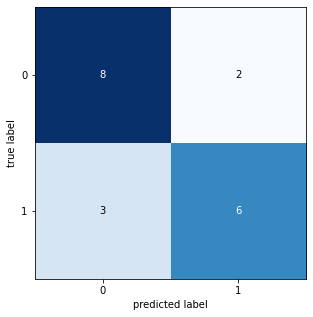

Train : [ 1  2  5  6  7  8  9 10 11 12 13 14 17 18 20 21 22 23 24 25 27 28 29 30
 31 32 33 34 35 36 37 39 40 41 42 43 44 45 47 49 50 52 53 56 57 58 59 61
 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 78 79 82 83 84 85 87 89 90
 91 92 93 94 95 96] Test : [ 0  3  4 15 16 19 26 38 46 48 51 54 55 60 77 80 81 86 88]
Y_Train : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 1 0 0 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Akurasi :  0.7368421052631579
F1_Score :  0.7368421052631577
              precision    recall  f1-score   support

           0       0.78      0.70      0.74        10
           1       0.70      0.78      0.74         9

    accuracy                           0.74        19
   macro avg       0.74      0.74      0.74        19
weighted avg       0.74      0.74      0.74        19



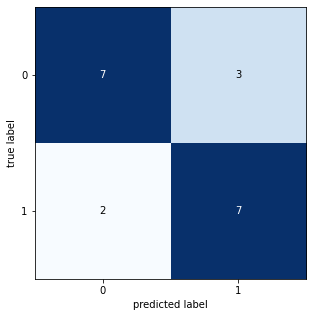

Train : [ 0  1  2  3  4  6  7  9 10 11 12 13 15 16 17 18 19 20 24 25 26 27 28 29
 30 31 32 33 34 36 37 38 39 40 41 44 46 47 48 49 50 51 52 54 55 56 57 58
 59 60 61 62 63 64 66 67 68 70 71 72 73 74 75 77 78 79 80 81 83 84 86 87
 88 89 93 94 95 96] Test : [ 5  8 14 21 22 23 35 42 43 45 53 65 69 76 82 85 90 91 92]
Y_Train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0]
Akurasi :  0.8947368421052632
F1_Score :  0.8944444444444444
              precision    recall  f1-score   support

           0       0.90      0.90      0.90        10
           1       0.89      0.89      0.89         9

    accuracy                           0.89        19
   macro avg       0.89      0.89      0.89        19
weighted avg       0.89      0.89      0.89        19



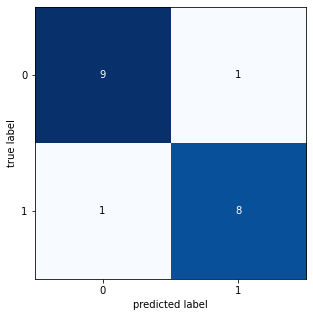

avg accuraccy Breast Cancer =  0.7436842105263158
avg F1_Score Breast Cancer =  0.7421026273348255
max accuraccy Breast Cancer =  0.8947368421052632
max F1_Score Breast Cancer =  0.8944444444444444
min accuraccy Breast Cancer =  0.6
min F1_Score Breast Cancer =  0.595959595959596
Running Time:  42.49486191699907
gen terbaik : [1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0]
F-1 Score terbaik : 0.8011896749546501  || Akurasi terbaik : 0.8042105263157895  || jumlah fitur : 47

Generation : 3
gene : [1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0,

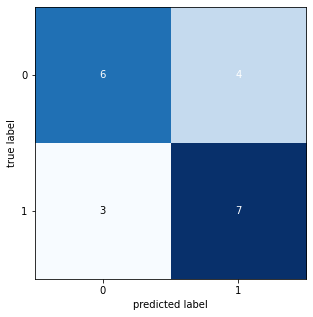

Train : [ 0  2  3  4  5  7  8  9 10 11 14 15 16 17 19 20 21 22 23 25 26 27 28 30
 31 34 35 36 37 38 39 42 43 44 45 46 47 48 49 51 52 53 54 55 56 57 58 59
 60 61 62 63 64 65 66 69 70 72 73 74 75 76 77 80 81 82 83 84 85 86 88 89
 90 91 92 95 96] Test : [ 1  6 12 13 18 24 29 32 33 40 41 50 67 68 71 78 79 87 93 94]
Y_Train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0]
Y_Test : [1 1 0 0 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Akurasi :  0.8
F1_Score :  0.7999999999999999
              precision    recall  f1-score   support

           0       0.89      0.73      0.80        11
           1       0.73      0.89      0.80         9

    accuracy                           0.80        20
   macro avg       0.81      0.81      0.80        20
weighted avg       0.82      0.80      0.80        20



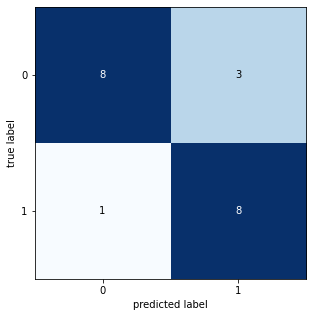

Train : [ 0  1  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 21 22 23 24 26
 28 29 32 33 34 35 36 38 40 41 42 43 44 45 46 48 49 50 51 52 53 54 55 56
 57 59 60 62 65 66 67 68 69 71 74 76 77 78 79 80 81 82 83 84 85 86 87 88
 90 91 92 93 94 96] Test : [ 2 20 25 27 30 31 37 39 47 58 61 63 64 70 72 73 75 89 95]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0]
Akurasi :  0.7368421052631579
F1_Score :  0.7338935574229692
              precision    recall  f1-score   support

           0       0.73      0.80      0.76        10
           1       0.75      0.67      0.71         9

    accuracy                           0.74        19
   macro avg       0.74      0.73      0.73        19
weighted avg       0.74      0.74      0.74        19



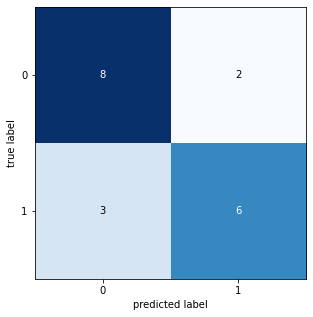

Train : [ 1  2  5  6  7  8  9 10 11 12 13 14 17 18 20 21 22 23 24 25 27 28 29 30
 31 32 33 34 35 36 37 39 40 41 42 43 44 45 47 49 50 52 53 56 57 58 59 61
 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 78 79 82 83 84 85 87 89 90
 91 92 93 94 95 96] Test : [ 0  3  4 15 16 19 26 38 46 48 51 54 55 60 77 80 81 86 88]
Y_Train : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 1 0 0 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Akurasi :  0.7894736842105263
F1_Score :  0.7888888888888888
              precision    recall  f1-score   support

           0       0.88      0.70      0.78        10
           1       0.73      0.89      0.80         9

    accuracy                           0.79        19
   macro avg       0.80      0.79      0.79        19
weighted avg       0.81      0.79      0.79        19



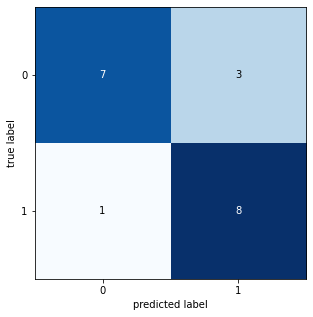

Train : [ 0  1  2  3  4  6  7  9 10 11 12 13 15 16 17 18 19 20 24 25 26 27 28 29
 30 31 32 33 34 36 37 38 39 40 41 44 46 47 48 49 50 51 52 54 55 56 57 58
 59 60 61 62 63 64 66 67 68 70 71 72 73 74 75 77 78 79 80 81 83 84 86 87
 88 89 93 94 95 96] Test : [ 5  8 14 21 22 23 35 42 43 45 53 65 69 76 82 85 90 91 92]
Y_Train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0]
Akurasi :  0.8947368421052632
F1_Score :  0.8944444444444445
              precision    recall  f1-score   support

           0       1.00      0.80      0.89        10
           1       0.82      1.00      0.90         9

    accuracy                           0.89        19
   macro avg       0.91      0.90      0.89        19
weighted avg       0.91      0.89      0.89        19



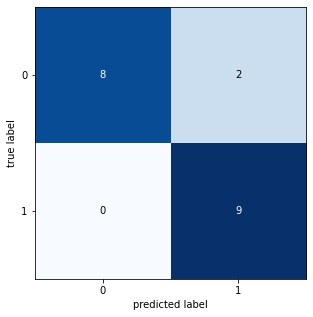

avg accuraccy Breast Cancer =  0.7742105263157895
avg F1_Score Breast Cancer =  0.7732699395547693
max accuraccy Breast Cancer =  0.8947368421052632
max F1_Score Breast Cancer =  0.8944444444444445
min accuraccy Breast Cancer =  0.65
min F1_Score Breast Cancer =  0.6491228070175439
Running Time:  40.06984556899988
gene : [0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0]
Train : [ 0  1  2  3  4  5  6  8 12 13 14 15 16 18 19 20 21 22 23 24 25 26 27 29
 30 31 32 33 35 37 38 39 40 41 42 43 45 46 47 48 50 51 53 54 55 58 60 61
 63 64 65 67 68 69 70 71 72 73 75 76 77 78 79 80 81 82 85 86 87 88 89 90
 91 92 93 94 95] Test : [ 7  9 10 11 17 28 34 36 44 49 52 56 57 59 62 66 74 83 84 96]
Y_Train : [1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 

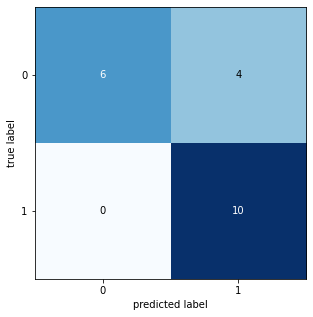

Train : [ 0  2  3  4  5  7  8  9 10 11 14 15 16 17 19 20 21 22 23 25 26 27 28 30
 31 34 35 36 37 38 39 42 43 44 45 46 47 48 49 51 52 53 54 55 56 57 58 59
 60 61 62 63 64 65 66 69 70 72 73 74 75 76 77 80 81 82 83 84 85 86 88 89
 90 91 92 95 96] Test : [ 1  6 12 13 18 24 29 32 33 40 41 50 67 68 71 78 79 87 93 94]
Y_Train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0]
Y_Test : [1 1 0 0 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Akurasi :  0.65
F1_Score :  0.6011396011396011
              precision    recall  f1-score   support

           0       0.62      0.91      0.74        11
           1       0.75      0.33      0.46         9

    accuracy                           0.65        20
   macro avg       0.69      0.62      0.60        20
weighted avg       0.68      0.65      0.62        20



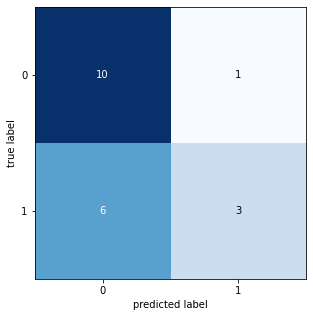

Train : [ 0  1  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 21 22 23 24 26
 28 29 32 33 34 35 36 38 40 41 42 43 44 45 46 48 49 50 51 52 53 54 55 56
 57 59 60 62 65 66 67 68 69 71 74 76 77 78 79 80 81 82 83 84 85 86 87 88
 90 91 92 93 94 96] Test : [ 2 20 25 27 30 31 37 39 47 58 61 63 64 70 72 73 75 89 95]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0]
Akurasi :  0.7894736842105263
F1_Score :  0.788888888888889
              precision    recall  f1-score   support

           0       0.80      0.80      0.80        10
           1       0.78      0.78      0.78         9

    accuracy                           0.79        19
   macro avg       0.79      0.79      0.79        19
weighted avg       0.79      0.79      0.79        19



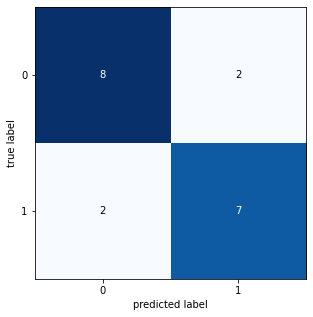

Train : [ 1  2  5  6  7  8  9 10 11 12 13 14 17 18 20 21 22 23 24 25 27 28 29 30
 31 32 33 34 35 36 37 39 40 41 42 43 44 45 47 49 50 52 53 56 57 58 59 61
 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 78 79 82 83 84 85 87 89 90
 91 92 93 94 95 96] Test : [ 0  3  4 15 16 19 26 38 46 48 51 54 55 60 77 80 81 86 88]
Y_Train : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 1 0 0 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Akurasi :  0.7894736842105263
F1_Score :  0.7888888888888888
              precision    recall  f1-score   support

           0       0.88      0.70      0.78        10
           1       0.73      0.89      0.80         9

    accuracy                           0.79        19
   macro avg       0.80      0.79      0.79        19
weighted avg       0.81      0.79      0.79        19



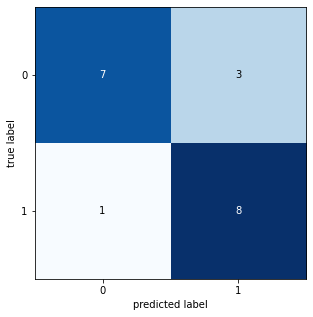

Train : [ 0  1  2  3  4  6  7  9 10 11 12 13 15 16 17 18 19 20 24 25 26 27 28 29
 30 31 32 33 34 36 37 38 39 40 41 44 46 47 48 49 50 51 52 54 55 56 57 58
 59 60 61 62 63 64 66 67 68 70 71 72 73 74 75 77 78 79 80 81 83 84 86 87
 88 89 93 94 95 96] Test : [ 5  8 14 21 22 23 35 42 43 45 53 65 69 76 82 85 90 91 92]
Y_Train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0]
Akurasi :  0.7368421052631579
F1_Score :  0.7338935574229692
              precision    recall  f1-score   support

           0       0.73      0.80      0.76        10
           1       0.75      0.67      0.71         9

    accuracy                           0.74        19
   macro avg       0.74      0.73      0.73        19
weighted avg       0.74      0.74      0.74        19



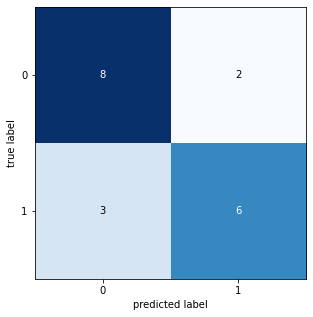

avg accuraccy Breast Cancer =  0.7531578947368422
avg F1_Score Breast Cancer =  0.740895520601403
max accuraccy Breast Cancer =  0.8
max F1_Score Breast Cancer =  0.7916666666666665
min accuraccy Breast Cancer =  0.65
min F1_Score Breast Cancer =  0.6011396011396011
Running Time:  42.17561346599905
gene : [1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0]
Train : [ 0  1  2  3  4  5  6  8 12 13 14 15 16 18 19 20 21 22 23 24 25 26 27 29
 30 31 32 33 35 37 38 39 40 41 42 43 45 46 47 48 50 51 53 54 55 58 60 61
 63 64 65 67 68 69 70 71 72 73 75 76 77 78 79 80 81 82 85 86 87 88 89 90
 91 92 93 94 95] Test : [ 7  9 10 11 17 28 34 36 44 49 52 56 57 59 62 66 74 83 84 96]
Y_Train : [1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 

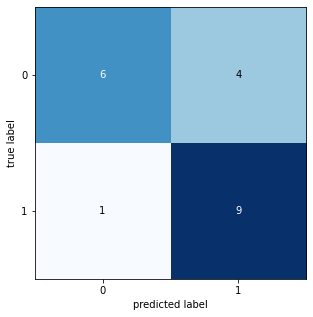

Train : [ 0  2  3  4  5  7  8  9 10 11 14 15 16 17 19 20 21 22 23 25 26 27 28 30
 31 34 35 36 37 38 39 42 43 44 45 46 47 48 49 51 52 53 54 55 56 57 58 59
 60 61 62 63 64 65 66 69 70 72 73 74 75 76 77 80 81 82 83 84 85 86 88 89
 90 91 92 95 96] Test : [ 1  6 12 13 18 24 29 32 33 40 41 50 67 68 71 78 79 87 93 94]
Y_Train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0]
Y_Test : [1 1 0 0 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Akurasi :  0.7
F1_Score :  0.6875000000000001
              precision    recall  f1-score   support

           0       0.69      0.82      0.75        11
           1       0.71      0.56      0.63         9

    accuracy                           0.70        20
   macro avg       0.70      0.69      0.69        20
weighted avg       0.70      0.70      0.69        20



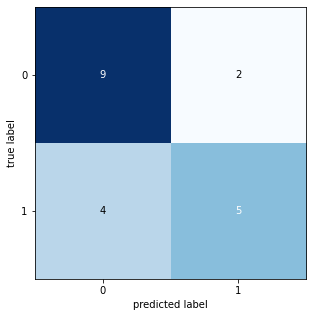

Train : [ 0  1  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 21 22 23 24 26
 28 29 32 33 34 35 36 38 40 41 42 43 44 45 46 48 49 50 51 52 53 54 55 56
 57 59 60 62 65 66 67 68 69 71 74 76 77 78 79 80 81 82 83 84 85 86 87 88
 90 91 92 93 94 96] Test : [ 2 20 25 27 30 31 37 39 47 58 61 63 64 70 72 73 75 89 95]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0]
Akurasi :  0.7368421052631579
F1_Score :  0.7338935574229692
              precision    recall  f1-score   support

           0       0.73      0.80      0.76        10
           1       0.75      0.67      0.71         9

    accuracy                           0.74        19
   macro avg       0.74      0.73      0.73        19
weighted avg       0.74      0.74      0.74        19



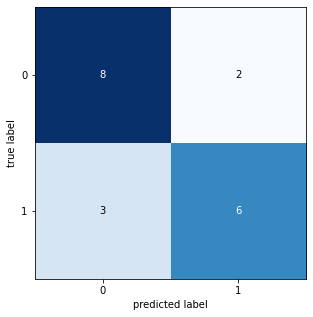

Train : [ 1  2  5  6  7  8  9 10 11 12 13 14 17 18 20 21 22 23 24 25 27 28 29 30
 31 32 33 34 35 36 37 39 40 41 42 43 44 45 47 49 50 52 53 56 57 58 59 61
 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 78 79 82 83 84 85 87 89 90
 91 92 93 94 95 96] Test : [ 0  3  4 15 16 19 26 38 46 48 51 54 55 60 77 80 81 86 88]
Y_Train : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 1 0 0 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Akurasi :  0.7894736842105263
F1_Score :  0.788888888888889
              precision    recall  f1-score   support

           0       0.80      0.80      0.80        10
           1       0.78      0.78      0.78         9

    accuracy                           0.79        19
   macro avg       0.79      0.79      0.79        19
weighted avg       0.79      0.79      0.79        19



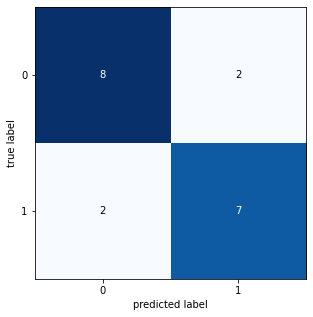

Train : [ 0  1  2  3  4  6  7  9 10 11 12 13 15 16 17 18 19 20 24 25 26 27 28 29
 30 31 32 33 34 36 37 38 39 40 41 44 46 47 48 49 50 51 52 54 55 56 57 58
 59 60 61 62 63 64 66 67 68 70 71 72 73 74 75 77 78 79 80 81 83 84 86 87
 88 89 93 94 95 96] Test : [ 5  8 14 21 22 23 35 42 43 45 53 65 69 76 82 85 90 91 92]
Y_Train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0]
Akurasi :  0.8947368421052632
F1_Score :  0.8944444444444444
              precision    recall  f1-score   support

           0       0.90      0.90      0.90        10
           1       0.89      0.89      0.89         9

    accuracy                           0.89        19
   macro avg       0.89      0.89      0.89        19
weighted avg       0.89      0.89      0.89        19



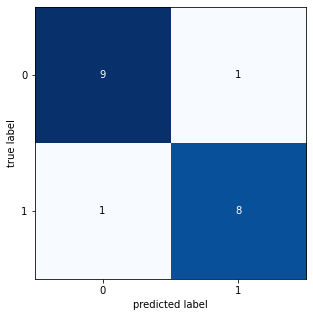

avg accuraccy Breast Cancer =  0.7742105263157895
avg F1_Score Breast Cancer =  0.7697944830105956
max accuraccy Breast Cancer =  0.8947368421052632
max F1_Score Breast Cancer =  0.8944444444444444
min accuraccy Breast Cancer =  0.7
min F1_Score Breast Cancer =  0.6875000000000001
Running Time:  37.82005441699948
gene : [0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0]
Train : [ 0  1  2  3  4  5  6  8 12 13 14 15 16 18 19 20 21 22 23 24 25 26 27 29
 30 31 32 33 35 37 38 39 40 41 42 43 45 46 47 48 50 51 53 54 55 58 60 61
 63 64 65 67 68 69 70 71 72 73 75 76 77 78 79 80 81 82 85 86 87 88 89 90
 91 92 93 94 95] Test : [ 7  9 10 11 17 28 34 36 44 49 52 56 57 59 62 66 74 83 84 96]
Y_Train : [1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1

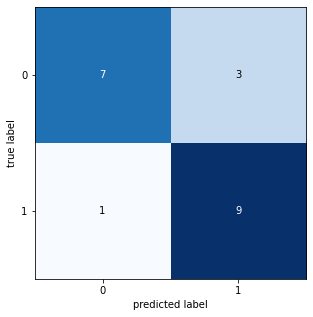

Train : [ 0  2  3  4  5  7  8  9 10 11 14 15 16 17 19 20 21 22 23 25 26 27 28 30
 31 34 35 36 37 38 39 42 43 44 45 46 47 48 49 51 52 53 54 55 56 57 58 59
 60 61 62 63 64 65 66 69 70 72 73 74 75 76 77 80 81 82 83 84 85 86 88 89
 90 91 92 95 96] Test : [ 1  6 12 13 18 24 29 32 33 40 41 50 67 68 71 78 79 87 93 94]
Y_Train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0]
Y_Test : [1 1 0 0 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Akurasi :  0.75
F1_Score :  0.7493734335839599
              precision    recall  f1-score   support

           0       0.80      0.73      0.76        11
           1       0.70      0.78      0.74         9

    accuracy                           0.75        20
   macro avg       0.75      0.75      0.75        20
weighted avg       0.76      0.75      0.75        20



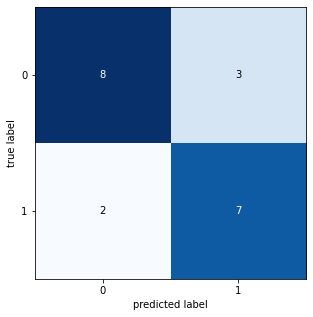

Train : [ 0  1  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 21 22 23 24 26
 28 29 32 33 34 35 36 38 40 41 42 43 44 45 46 48 49 50 51 52 53 54 55 56
 57 59 60 62 65 66 67 68 69 71 74 76 77 78 79 80 81 82 83 84 85 86 87 88
 90 91 92 93 94 96] Test : [ 2 20 25 27 30 31 37 39 47 58 61 63 64 70 72 73 75 89 95]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0]
Akurasi :  0.7894736842105263
F1_Score :  0.788888888888889
              precision    recall  f1-score   support

           0       0.80      0.80      0.80        10
           1       0.78      0.78      0.78         9

    accuracy                           0.79        19
   macro avg       0.79      0.79      0.79        19
weighted avg       0.79      0.79      0.79        19



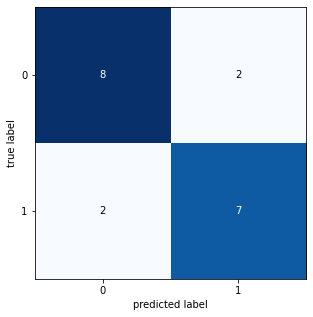

Train : [ 1  2  5  6  7  8  9 10 11 12 13 14 17 18 20 21 22 23 24 25 27 28 29 30
 31 32 33 34 35 36 37 39 40 41 42 43 44 45 47 49 50 52 53 56 57 58 59 61
 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 78 79 82 83 84 85 87 89 90
 91 92 93 94 95 96] Test : [ 0  3  4 15 16 19 26 38 46 48 51 54 55 60 77 80 81 86 88]
Y_Train : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 1 0 0 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Akurasi :  0.7894736842105263
F1_Score :  0.788888888888889
              precision    recall  f1-score   support

           0       0.80      0.80      0.80        10
           1       0.78      0.78      0.78         9

    accuracy                           0.79        19
   macro avg       0.79      0.79      0.79        19
weighted avg       0.79      0.79      0.79        19



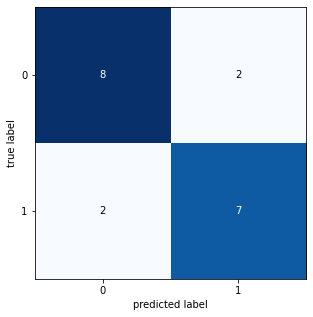

Train : [ 0  1  2  3  4  6  7  9 10 11 12 13 15 16 17 18 19 20 24 25 26 27 28 29
 30 31 32 33 34 36 37 38 39 40 41 44 46 47 48 49 50 51 52 54 55 56 57 58
 59 60 61 62 63 64 66 67 68 70 71 72 73 74 75 77 78 79 80 81 83 84 86 87
 88 89 93 94 95 96] Test : [ 5  8 14 21 22 23 35 42 43 45 53 65 69 76 82 85 90 91 92]
Y_Train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0]
Akurasi :  0.8947368421052632
F1_Score :  0.8944444444444445
              precision    recall  f1-score   support

           0       1.00      0.80      0.89        10
           1       0.82      1.00      0.90         9

    accuracy                           0.89        19
   macro avg       0.91      0.90      0.89        19
weighted avg       0.91      0.89      0.89        19



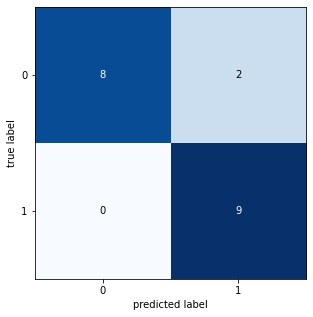

avg accuraccy Breast Cancer =  0.8047368421052632
avg F1_Score Breast Cancer =  0.8039150907571961
max accuraccy Breast Cancer =  0.8947368421052632
max F1_Score Breast Cancer =  0.8944444444444445
min accuraccy Breast Cancer =  0.75
min F1_Score Breast Cancer =  0.7493734335839599
Running Time:  39.242712569001014
gene : [1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0]
Train : [ 0  1  2  3  4  5  6  8 12 13 14 15 16 18 19 20 21 22 23 24 25 26 27 29
 30 31 32 33 35 37 38 39 40 41 42 43 45 46 47 48 50 51 53 54 55 58 60 61
 63 64 65 67 68 69 70 71 72 73 75 76 77 78 79 80 81 82 85 86 87 88 89 90
 91 92 93 94 95] Test : [ 7  9 10 11 17 28 34 36 44 49 52 56 57 59 62 66 74 83 84 96]
Y_Train : [1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1

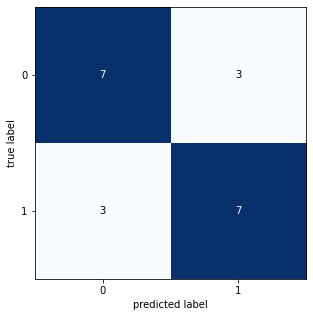

Train : [ 0  2  3  4  5  7  8  9 10 11 14 15 16 17 19 20 21 22 23 25 26 27 28 30
 31 34 35 36 37 38 39 42 43 44 45 46 47 48 49 51 52 53 54 55 56 57 58 59
 60 61 62 63 64 65 66 69 70 72 73 74 75 76 77 80 81 82 83 84 85 86 88 89
 90 91 92 95 96] Test : [ 1  6 12 13 18 24 29 32 33 40 41 50 67 68 71 78 79 87 93 94]
Y_Train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0]
Y_Test : [1 1 0 0 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Akurasi :  0.8
F1_Score :  0.797979797979798
              precision    recall  f1-score   support

           0       1.00      0.64      0.78        11
           1       0.69      1.00      0.82         9

    accuracy                           0.80        20
   macro avg       0.85      0.82      0.80        20
weighted avg       0.86      0.80      0.80        20



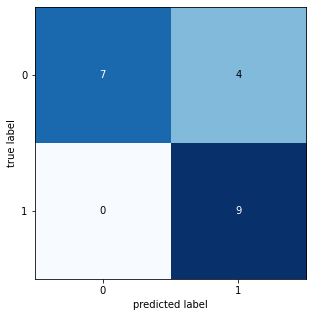

Train : [ 0  1  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 21 22 23 24 26
 28 29 32 33 34 35 36 38 40 41 42 43 44 45 46 48 49 50 51 52 53 54 55 56
 57 59 60 62 65 66 67 68 69 71 74 76 77 78 79 80 81 82 83 84 85 86 87 88
 90 91 92 93 94 96] Test : [ 2 20 25 27 30 31 37 39 47 58 61 63 64 70 72 73 75 89 95]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0]
Akurasi :  0.7894736842105263
F1_Score :  0.7840909090909092
              precision    recall  f1-score   support

           0       0.75      0.90      0.82        10
           1       0.86      0.67      0.75         9

    accuracy                           0.79        19
   macro avg       0.80      0.78      0.78        19
weighted avg       0.80      0.79      0.79        19



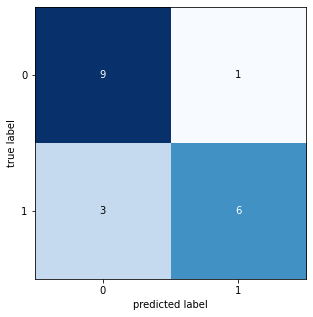

Train : [ 1  2  5  6  7  8  9 10 11 12 13 14 17 18 20 21 22 23 24 25 27 28 29 30
 31 32 33 34 35 36 37 39 40 41 42 43 44 45 47 49 50 52 53 56 57 58 59 61
 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 78 79 82 83 84 85 87 89 90
 91 92 93 94 95 96] Test : [ 0  3  4 15 16 19 26 38 46 48 51 54 55 60 77 80 81 86 88]
Y_Train : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 1 0 0 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Akurasi :  0.631578947368421
F1_Score :  0.6274509803921569
              precision    recall  f1-score   support

           0       0.64      0.70      0.67        10
           1       0.62      0.56      0.59         9

    accuracy                           0.63        19
   macro avg       0.63      0.63      0.63        19
weighted avg       0.63      0.63      0.63        19



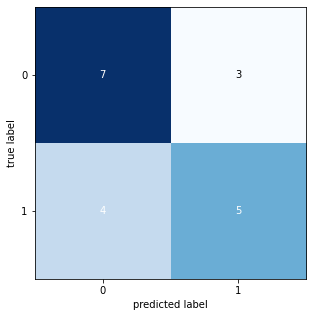

Train : [ 0  1  2  3  4  6  7  9 10 11 12 13 15 16 17 18 19 20 24 25 26 27 28 29
 30 31 32 33 34 36 37 38 39 40 41 44 46 47 48 49 50 51 52 54 55 56 57 58
 59 60 61 62 63 64 66 67 68 70 71 72 73 74 75 77 78 79 80 81 83 84 86 87
 88 89 93 94 95 96] Test : [ 5  8 14 21 22 23 35 42 43 45 53 65 69 76 82 85 90 91 92]
Y_Train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0]
Akurasi :  0.9473684210526315
F1_Score :  0.9473684210526316
              precision    recall  f1-score   support

           0       1.00      0.90      0.95        10
           1       0.90      1.00      0.95         9

    accuracy                           0.95        19
   macro avg       0.95      0.95      0.95        19
weighted avg       0.95      0.95      0.95        19



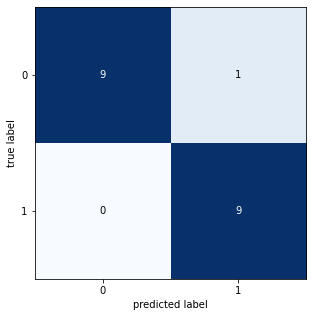

avg accuraccy Breast Cancer =  0.7736842105263159
avg F1_Score Breast Cancer =  0.771378021703099
max accuraccy Breast Cancer =  0.9473684210526315
max F1_Score Breast Cancer =  0.9473684210526316
min accuraccy Breast Cancer =  0.631578947368421
min F1_Score Breast Cancer =  0.6274509803921569
Running Time:  39.77084632200058
gene : [0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0]
Train : [ 0  1  2  3  4  5  6  8 12 13 14 15 16 18 19 20 21 22 23 24 25 26 27 29
 30 31 32 33 35 37 38 39 40 41 42 43 45 46 47 48 50 51 53 54 55 58 60 61
 63 64 65 67 68 69 70 71 72 73 75 76 77 78 79 80 81 82 85 86 87 88 89 90
 91 92 93 94 95] Test : [ 7  9 10 11 17 28 34 36 44 49 52 56 57 59 62 66 74 83 84 96]
Y_Train : [1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 

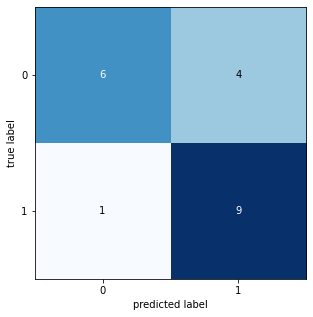

Train : [ 0  2  3  4  5  7  8  9 10 11 14 15 16 17 19 20 21 22 23 25 26 27 28 30
 31 34 35 36 37 38 39 42 43 44 45 46 47 48 49 51 52 53 54 55 56 57 58 59
 60 61 62 63 64 65 66 69 70 72 73 74 75 76 77 80 81 82 83 84 85 86 88 89
 90 91 92 95 96] Test : [ 1  6 12 13 18 24 29 32 33 40 41 50 67 68 71 78 79 87 93 94]
Y_Train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0]
Y_Test : [1 1 0 0 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Akurasi :  0.65
F1_Score :  0.6011396011396011
              precision    recall  f1-score   support

           0       0.62      0.91      0.74        11
           1       0.75      0.33      0.46         9

    accuracy                           0.65        20
   macro avg       0.69      0.62      0.60        20
weighted avg       0.68      0.65      0.62        20



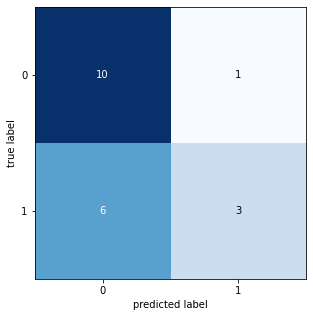

Train : [ 0  1  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 21 22 23 24 26
 28 29 32 33 34 35 36 38 40 41 42 43 44 45 46 48 49 50 51 52 53 54 55 56
 57 59 60 62 65 66 67 68 69 71 74 76 77 78 79 80 81 82 83 84 85 86 87 88
 90 91 92 93 94 96] Test : [ 2 20 25 27 30 31 37 39 47 58 61 63 64 70 72 73 75 89 95]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0]
Akurasi :  0.631578947368421
F1_Score :  0.631578947368421
              precision    recall  f1-score   support

           0       0.67      0.60      0.63        10
           1       0.60      0.67      0.63         9

    accuracy                           0.63        19
   macro avg       0.63      0.63      0.63        19
weighted avg       0.64      0.63      0.63        19



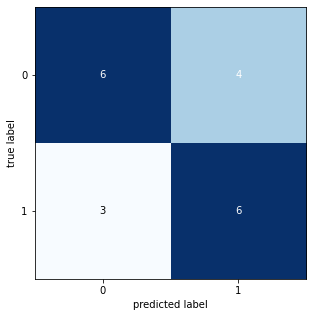

Train : [ 1  2  5  6  7  8  9 10 11 12 13 14 17 18 20 21 22 23 24 25 27 28 29 30
 31 32 33 34 35 36 37 39 40 41 42 43 44 45 47 49 50 52 53 56 57 58 59 61
 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 78 79 82 83 84 85 87 89 90
 91 92 93 94 95 96] Test : [ 0  3  4 15 16 19 26 38 46 48 51 54 55 60 77 80 81 86 88]
Y_Train : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 1 0 0 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Akurasi :  0.7368421052631579
F1_Score :  0.7338935574229692
              precision    recall  f1-score   support

           0       0.86      0.60      0.71        10
           1       0.67      0.89      0.76         9

    accuracy                           0.74        19
   macro avg       0.76      0.74      0.73        19
weighted avg       0.77      0.74      0.73        19



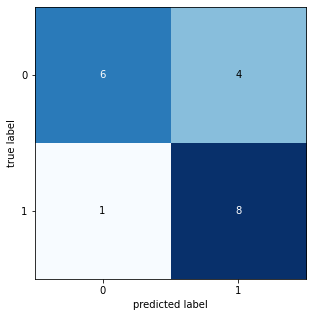

Train : [ 0  1  2  3  4  6  7  9 10 11 12 13 15 16 17 18 19 20 24 25 26 27 28 29
 30 31 32 33 34 36 37 38 39 40 41 44 46 47 48 49 50 51 52 54 55 56 57 58
 59 60 61 62 63 64 66 67 68 70 71 72 73 74 75 77 78 79 80 81 83 84 86 87
 88 89 93 94 95 96] Test : [ 5  8 14 21 22 23 35 42 43 45 53 65 69 76 82 85 90 91 92]
Y_Train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0]
Akurasi :  0.7894736842105263
F1_Score :  0.7840909090909092
              precision    recall  f1-score   support

           0       0.75      0.90      0.82        10
           1       0.86      0.67      0.75         9

    accuracy                           0.79        19
   macro avg       0.80      0.78      0.78        19
weighted avg       0.80      0.79      0.79        19



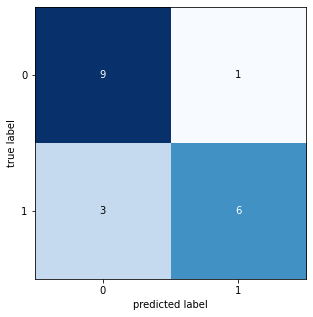

avg accuraccy Breast Cancer =  0.711578947368421
avg F1_Score Breast Cancer =  0.6989897078637151
max accuraccy Breast Cancer =  0.7894736842105263
max F1_Score Breast Cancer =  0.7840909090909092
min accuraccy Breast Cancer =  0.631578947368421
min F1_Score Breast Cancer =  0.6011396011396011
Running Time:  37.172134327000094
gene : [1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0]
Train : [ 0  1  2  3  4  5  6  8 12 13 14 15 16 18 19 20 21 22 23 24 25 26 27 29
 30 31 32 33 35 37 38 39 40 41 42 43 45 46 47 48 50 51 53 54 55 58 60 61
 63 64 65 67 68 69 70 71 72 73 75 76 77 78 79 80 81 82 85 86 87 88 89 90
 91 92 93 94 95] Test : [ 7  9 10 11 17 28 34 36 44 49 52 56 57 59 62 66 74 83 84 96]
Y_Train : [1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1

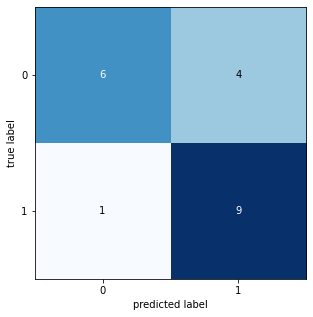

Train : [ 0  2  3  4  5  7  8  9 10 11 14 15 16 17 19 20 21 22 23 25 26 27 28 30
 31 34 35 36 37 38 39 42 43 44 45 46 47 48 49 51 52 53 54 55 56 57 58 59
 60 61 62 63 64 65 66 69 70 72 73 74 75 76 77 80 81 82 83 84 85 86 88 89
 90 91 92 95 96] Test : [ 1  6 12 13 18 24 29 32 33 40 41 50 67 68 71 78 79 87 93 94]
Y_Train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0]
Y_Test : [1 1 0 0 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Akurasi :  0.8
F1_Score :  0.797979797979798
              precision    recall  f1-score   support

           0       0.82      0.82      0.82        11
           1       0.78      0.78      0.78         9

    accuracy                           0.80        20
   macro avg       0.80      0.80      0.80        20
weighted avg       0.80      0.80      0.80        20



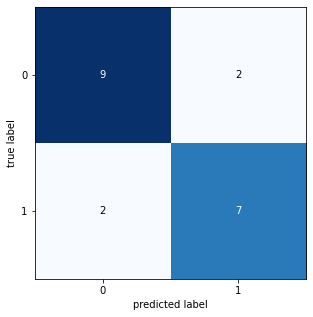

Train : [ 0  1  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 21 22 23 24 26
 28 29 32 33 34 35 36 38 40 41 42 43 44 45 46 48 49 50 51 52 53 54 55 56
 57 59 60 62 65 66 67 68 69 71 74 76 77 78 79 80 81 82 83 84 85 86 87 88
 90 91 92 93 94 96] Test : [ 2 20 25 27 30 31 37 39 47 58 61 63 64 70 72 73 75 89 95]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0]
Akurasi :  0.6842105263157895
F1_Score :  0.6833333333333333
              precision    recall  f1-score   support

           0       0.70      0.70      0.70        10
           1       0.67      0.67      0.67         9

    accuracy                           0.68        19
   macro avg       0.68      0.68      0.68        19
weighted avg       0.68      0.68      0.68        19



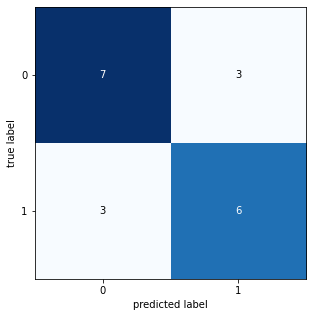

Train : [ 1  2  5  6  7  8  9 10 11 12 13 14 17 18 20 21 22 23 24 25 27 28 29 30
 31 32 33 34 35 36 37 39 40 41 42 43 44 45 47 49 50 52 53 56 57 58 59 61
 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 78 79 82 83 84 85 87 89 90
 91 92 93 94 95 96] Test : [ 0  3  4 15 16 19 26 38 46 48 51 54 55 60 77 80 81 86 88]
Y_Train : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 1 0 0 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Akurasi :  0.7894736842105263
F1_Score :  0.788888888888889
              precision    recall  f1-score   support

           0       0.80      0.80      0.80        10
           1       0.78      0.78      0.78         9

    accuracy                           0.79        19
   macro avg       0.79      0.79      0.79        19
weighted avg       0.79      0.79      0.79        19



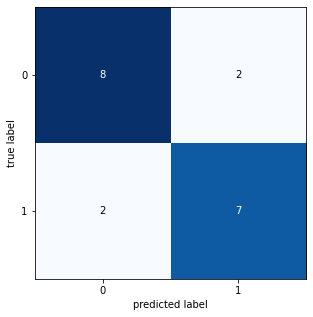

Train : [ 0  1  2  3  4  6  7  9 10 11 12 13 15 16 17 18 19 20 24 25 26 27 28 29
 30 31 32 33 34 36 37 38 39 40 41 44 46 47 48 49 50 51 52 54 55 56 57 58
 59 60 61 62 63 64 66 67 68 70 71 72 73 74 75 77 78 79 80 81 83 84 86 87
 88 89 93 94 95 96] Test : [ 5  8 14 21 22 23 35 42 43 45 53 65 69 76 82 85 90 91 92]
Y_Train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0]
Akurasi :  0.8421052631578947
F1_Score :  0.8403361344537814
              precision    recall  f1-score   support

           0       1.00      0.70      0.82        10
           1       0.75      1.00      0.86         9

    accuracy                           0.84        19
   macro avg       0.88      0.85      0.84        19
weighted avg       0.88      0.84      0.84        19



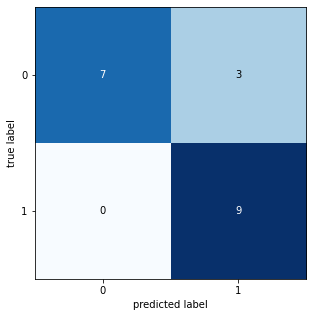

avg accuraccy Breast Cancer =  0.773157894736842
avg F1_Score Breast Cancer =  0.7709567357904954
max accuraccy Breast Cancer =  0.8421052631578947
max F1_Score Breast Cancer =  0.8403361344537814
min accuraccy Breast Cancer =  0.6842105263157895
min F1_Score Breast Cancer =  0.6833333333333333
Running Time:  40.72800169600123
gene : [0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0]
Train : [ 0  1  2  3  4  5  6  8 12 13 14 15 16 18 19 20 21 22 23 24 25 26 27 29
 30 31 32 33 35 37 38 39 40 41 42 43 45 46 47 48 50 51 53 54 55 58 60 61
 63 64 65 67 68 69 70 71 72 73 75 76 77 78 79 80 81 82 85 86 87 88 89 90
 91 92 93 94 95] Test : [ 7  9 10 11 17 28 34 36 44 49 52 56 57 59 62 66 74 83 84 96]
Y_Train : [1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1

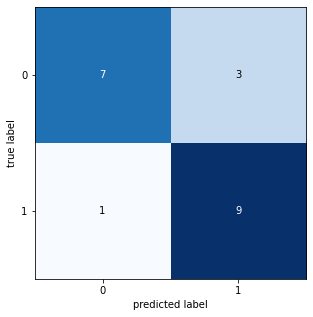

Train : [ 0  2  3  4  5  7  8  9 10 11 14 15 16 17 19 20 21 22 23 25 26 27 28 30
 31 34 35 36 37 38 39 42 43 44 45 46 47 48 49 51 52 53 54 55 56 57 58 59
 60 61 62 63 64 65 66 69 70 72 73 74 75 76 77 80 81 82 83 84 85 86 88 89
 90 91 92 95 96] Test : [ 1  6 12 13 18 24 29 32 33 40 41 50 67 68 71 78 79 87 93 94]
Y_Train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0]
Y_Test : [1 1 0 0 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Akurasi :  0.7
F1_Score :  0.6875000000000001
              precision    recall  f1-score   support

           0       0.69      0.82      0.75        11
           1       0.71      0.56      0.63         9

    accuracy                           0.70        20
   macro avg       0.70      0.69      0.69        20
weighted avg       0.70      0.70      0.69        20



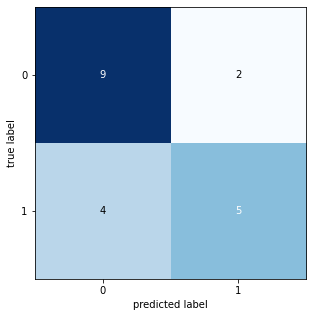

Train : [ 0  1  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 21 22 23 24 26
 28 29 32 33 34 35 36 38 40 41 42 43 44 45 46 48 49 50 51 52 53 54 55 56
 57 59 60 62 65 66 67 68 69 71 74 76 77 78 79 80 81 82 83 84 85 86 87 88
 90 91 92 93 94 96] Test : [ 2 20 25 27 30 31 37 39 47 58 61 63 64 70 72 73 75 89 95]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0]
Akurasi :  0.5789473684210527
F1_Score :  0.5777777777777777
              precision    recall  f1-score   support

           0       0.60      0.60      0.60        10
           1       0.56      0.56      0.56         9

    accuracy                           0.58        19
   macro avg       0.58      0.58      0.58        19
weighted avg       0.58      0.58      0.58        19



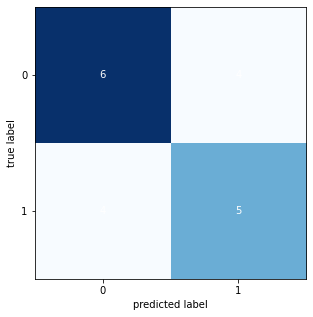

Train : [ 1  2  5  6  7  8  9 10 11 12 13 14 17 18 20 21 22 23 24 25 27 28 29 30
 31 32 33 34 35 36 37 39 40 41 42 43 44 45 47 49 50 52 53 56 57 58 59 61
 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 78 79 82 83 84 85 87 89 90
 91 92 93 94 95 96] Test : [ 0  3  4 15 16 19 26 38 46 48 51 54 55 60 77 80 81 86 88]
Y_Train : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 1 0 0 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Akurasi :  0.7894736842105263
F1_Score :  0.784090909090909
              precision    recall  f1-score   support

           0       1.00      0.60      0.75        10
           1       0.69      1.00      0.82         9

    accuracy                           0.79        19
   macro avg       0.85      0.80      0.78        19
weighted avg       0.85      0.79      0.78        19



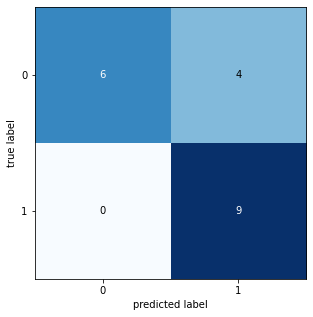

Train : [ 0  1  2  3  4  6  7  9 10 11 12 13 15 16 17 18 19 20 24 25 26 27 28 29
 30 31 32 33 34 36 37 38 39 40 41 44 46 47 48 49 50 51 52 54 55 56 57 58
 59 60 61 62 63 64 66 67 68 70 71 72 73 74 75 77 78 79 80 81 83 84 86 87
 88 89 93 94 95 96] Test : [ 5  8 14 21 22 23 35 42 43 45 53 65 69 76 82 85 90 91 92]
Y_Train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0]
Akurasi :  0.8421052631578947
F1_Score :  0.8403361344537816
              precision    recall  f1-score   support

           0       0.82      0.90      0.86        10
           1       0.88      0.78      0.82         9

    accuracy                           0.84        19
   macro avg       0.85      0.84      0.84        19
weighted avg       0.85      0.84      0.84        19



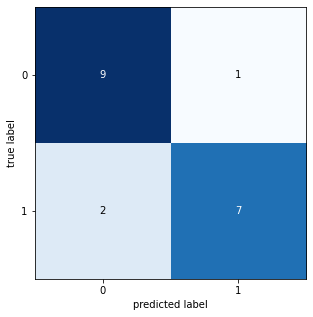

avg accuraccy Breast Cancer =  0.7421052631578947
avg F1_Score Breast Cancer =  0.7375369238604533
max accuraccy Breast Cancer =  0.8421052631578947
max F1_Score Breast Cancer =  0.8403361344537816
min accuraccy Breast Cancer =  0.5789473684210527
min F1_Score Breast Cancer =  0.5777777777777777
Running Time:  37.831207245999394
gene : [1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0]
Train : [ 0  1  2  3  4  5  6  8 12 13 14 15 16 18 19 20 21 22 23 24 25 26 27 29
 30 31 32 33 35 37 38 39 40 41 42 43 45 46 47 48 50 51 53 54 55 58 60 61
 63 64 65 67 68 69 70 71 72 73 75 76 77 78 79 80 81 82 85 86 87 88 89 90
 91 92 93 94 95] Test : [ 7  9 10 11 17 28 34 36 44 49 52 56 57 59 62 66 74 83 84 96]
Y_Train : [1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1

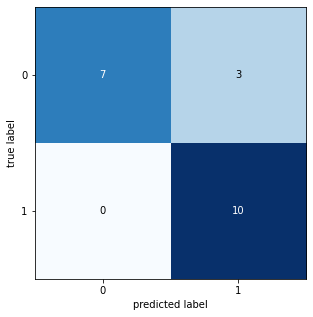

Train : [ 0  2  3  4  5  7  8  9 10 11 14 15 16 17 19 20 21 22 23 25 26 27 28 30
 31 34 35 36 37 38 39 42 43 44 45 46 47 48 49 51 52 53 54 55 56 57 58 59
 60 61 62 63 64 65 66 69 70 72 73 74 75 76 77 80 81 82 83 84 85 86 88 89
 90 91 92 95 96] Test : [ 1  6 12 13 18 24 29 32 33 40 41 50 67 68 71 78 79 87 93 94]
Y_Train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0]
Y_Test : [1 1 0 0 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Akurasi :  0.7
F1_Score :  0.6875000000000001
              precision    recall  f1-score   support

           0       0.69      0.82      0.75        11
           1       0.71      0.56      0.63         9

    accuracy                           0.70        20
   macro avg       0.70      0.69      0.69        20
weighted avg       0.70      0.70      0.69        20



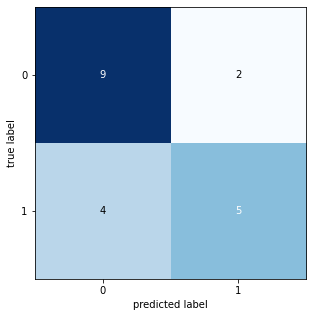

Train : [ 0  1  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 21 22 23 24 26
 28 29 32 33 34 35 36 38 40 41 42 43 44 45 46 48 49 50 51 52 53 54 55 56
 57 59 60 62 65 66 67 68 69 71 74 76 77 78 79 80 81 82 83 84 85 86 87 88
 90 91 92 93 94 96] Test : [ 2 20 25 27 30 31 37 39 47 58 61 63 64 70 72 73 75 89 95]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0]
Akurasi :  0.7368421052631579
F1_Score :  0.7338935574229692
              precision    recall  f1-score   support

           0       0.73      0.80      0.76        10
           1       0.75      0.67      0.71         9

    accuracy                           0.74        19
   macro avg       0.74      0.73      0.73        19
weighted avg       0.74      0.74      0.74        19



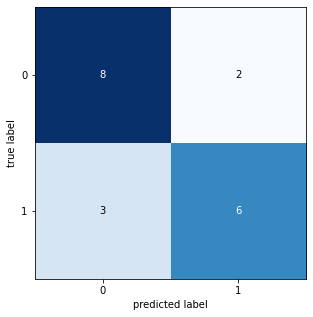

Train : [ 1  2  5  6  7  8  9 10 11 12 13 14 17 18 20 21 22 23 24 25 27 28 29 30
 31 32 33 34 35 36 37 39 40 41 42 43 44 45 47 49 50 52 53 56 57 58 59 61
 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 78 79 82 83 84 85 87 89 90
 91 92 93 94 95 96] Test : [ 0  3  4 15 16 19 26 38 46 48 51 54 55 60 77 80 81 86 88]
Y_Train : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 1 0 0 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Akurasi :  0.7368421052631579
F1_Score :  0.7338935574229692
              precision    recall  f1-score   support

           0       0.73      0.80      0.76        10
           1       0.75      0.67      0.71         9

    accuracy                           0.74        19
   macro avg       0.74      0.73      0.73        19
weighted avg       0.74      0.74      0.74        19



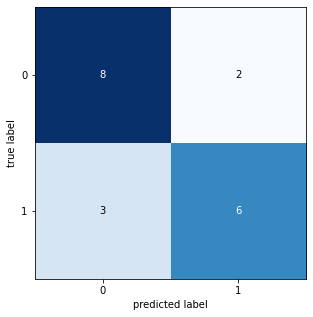

Train : [ 0  1  2  3  4  6  7  9 10 11 12 13 15 16 17 18 19 20 24 25 26 27 28 29
 30 31 32 33 34 36 37 38 39 40 41 44 46 47 48 49 50 51 52 54 55 56 57 58
 59 60 61 62 63 64 66 67 68 70 71 72 73 74 75 77 78 79 80 81 83 84 86 87
 88 89 93 94 95 96] Test : [ 5  8 14 21 22 23 35 42 43 45 53 65 69 76 82 85 90 91 92]
Y_Train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0]
Akurasi :  0.9473684210526315
F1_Score :  0.9473684210526316
              precision    recall  f1-score   support

           0       1.00      0.90      0.95        10
           1       0.90      1.00      0.95         9

    accuracy                           0.95        19
   macro avg       0.95      0.95      0.95        19
weighted avg       0.95      0.95      0.95        19



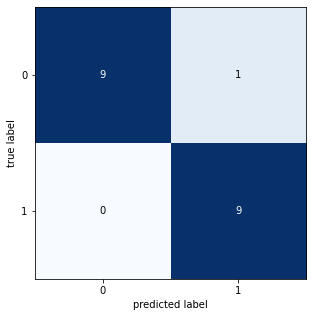

avg accuraccy Breast Cancer =  0.7942105263157895
avg F1_Score Breast Cancer =  0.789840570095315
max accuraccy Breast Cancer =  0.9473684210526315
max F1_Score Breast Cancer =  0.9473684210526316
min accuraccy Breast Cancer =  0.7
min F1_Score Breast Cancer =  0.6875000000000001
Running Time:  39.573620757000754
gene : [0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0]
Train : [ 0  1  2  3  4  5  6  8 12 13 14 15 16 18 19 20 21 22 23 24 25 26 27 29
 30 31 32 33 35 37 38 39 40 41 42 43 45 46 47 48 50 51 53 54 55 58 60 61
 63 64 65 67 68 69 70 71 72 73 75 76 77 78 79 80 81 82 85 86 87 88 89 90
 91 92 93 94 95] Test : [ 7  9 10 11 17 28 34 36 44 49 52 56 57 59 62 66 74 83 84 96]
Y_Train : [1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1

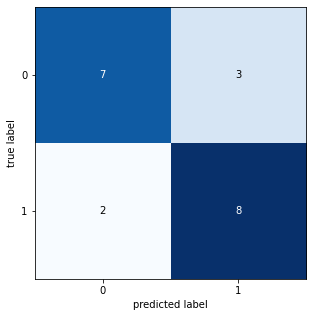

Train : [ 0  2  3  4  5  7  8  9 10 11 14 15 16 17 19 20 21 22 23 25 26 27 28 30
 31 34 35 36 37 38 39 42 43 44 45 46 47 48 49 51 52 53 54 55 56 57 58 59
 60 61 62 63 64 65 66 69 70 72 73 74 75 76 77 80 81 82 83 84 85 86 88 89
 90 91 92 95 96] Test : [ 1  6 12 13 18 24 29 32 33 40 41 50 67 68 71 78 79 87 93 94]
Y_Train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0]
Y_Test : [1 1 0 0 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Akurasi :  0.75
F1_Score :  0.7493734335839599
              precision    recall  f1-score   support

           0       0.80      0.73      0.76        11
           1       0.70      0.78      0.74         9

    accuracy                           0.75        20
   macro avg       0.75      0.75      0.75        20
weighted avg       0.76      0.75      0.75        20



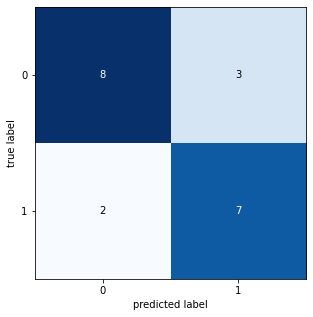

Train : [ 0  1  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 21 22 23 24 26
 28 29 32 33 34 35 36 38 40 41 42 43 44 45 46 48 49 50 51 52 53 54 55 56
 57 59 60 62 65 66 67 68 69 71 74 76 77 78 79 80 81 82 83 84 85 86 87 88
 90 91 92 93 94 96] Test : [ 2 20 25 27 30 31 37 39 47 58 61 63 64 70 72 73 75 89 95]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0]
Akurasi :  0.7368421052631579
F1_Score :  0.7338935574229692
              precision    recall  f1-score   support

           0       0.73      0.80      0.76        10
           1       0.75      0.67      0.71         9

    accuracy                           0.74        19
   macro avg       0.74      0.73      0.73        19
weighted avg       0.74      0.74      0.74        19



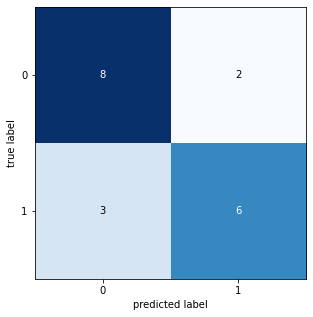

Train : [ 1  2  5  6  7  8  9 10 11 12 13 14 17 18 20 21 22 23 24 25 27 28 29 30
 31 32 33 34 35 36 37 39 40 41 42 43 44 45 47 49 50 52 53 56 57 58 59 61
 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 78 79 82 83 84 85 87 89 90
 91 92 93 94 95 96] Test : [ 0  3  4 15 16 19 26 38 46 48 51 54 55 60 77 80 81 86 88]
Y_Train : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 1 0 0 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Akurasi :  0.7368421052631579
F1_Score :  0.7338935574229692
              precision    recall  f1-score   support

           0       0.86      0.60      0.71        10
           1       0.67      0.89      0.76         9

    accuracy                           0.74        19
   macro avg       0.76      0.74      0.73        19
weighted avg       0.77      0.74      0.73        19



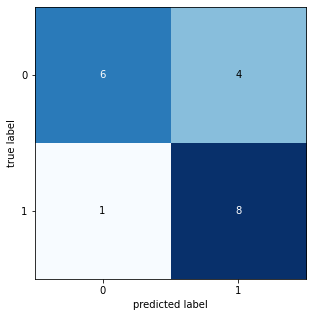

Train : [ 0  1  2  3  4  6  7  9 10 11 12 13 15 16 17 18 19 20 24 25 26 27 28 29
 30 31 32 33 34 36 37 38 39 40 41 44 46 47 48 49 50 51 52 54 55 56 57 58
 59 60 61 62 63 64 66 67 68 70 71 72 73 74 75 77 78 79 80 81 83 84 86 87
 88 89 93 94 95 96] Test : [ 5  8 14 21 22 23 35 42 43 45 53 65 69 76 82 85 90 91 92]
Y_Train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0]
Akurasi :  0.8947368421052632
F1_Score :  0.8944444444444445
              precision    recall  f1-score   support

           0       1.00      0.80      0.89        10
           1       0.82      1.00      0.90         9

    accuracy                           0.89        19
   macro avg       0.91      0.90      0.89        19
weighted avg       0.91      0.89      0.89        19



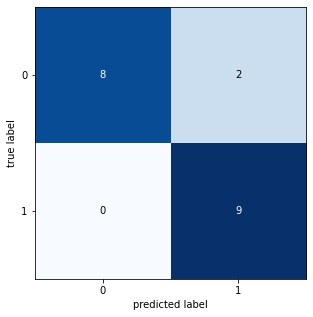

avg accuraccy Breast Cancer =  0.7736842105263159
avg F1_Score Breast Cancer =  0.7721956852916605
max accuraccy Breast Cancer =  0.8947368421052632
max F1_Score Breast Cancer =  0.8944444444444445
min accuraccy Breast Cancer =  0.7368421052631579
min F1_Score Breast Cancer =  0.7338935574229692
Running Time:  39.07499092599937
gen terbaik : [0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0]
F-1 Score terbaik : 0.8039150907571961  || Akurasi terbaik : 0.8047368421052632  || jumlah fitur : 49

Generation : 4
gene : [0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0

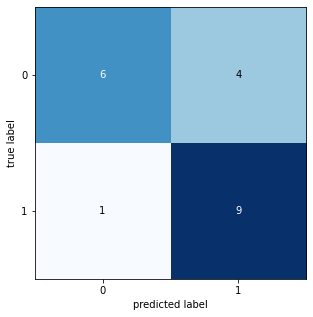

Train : [ 0  2  3  4  5  7  8  9 10 11 14 15 16 17 19 20 21 22 23 25 26 27 28 30
 31 34 35 36 37 38 39 42 43 44 45 46 47 48 49 51 52 53 54 55 56 57 58 59
 60 61 62 63 64 65 66 69 70 72 73 74 75 76 77 80 81 82 83 84 85 86 88 89
 90 91 92 95 96] Test : [ 1  6 12 13 18 24 29 32 33 40 41 50 67 68 71 78 79 87 93 94]
Y_Train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0]
Y_Test : [1 1 0 0 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Akurasi :  0.85
F1_Score :  0.8465473145780051
              precision    recall  f1-score   support

           0       0.83      0.91      0.87        11
           1       0.88      0.78      0.82         9

    accuracy                           0.85        20
   macro avg       0.85      0.84      0.85        20
weighted avg       0.85      0.85      0.85        20



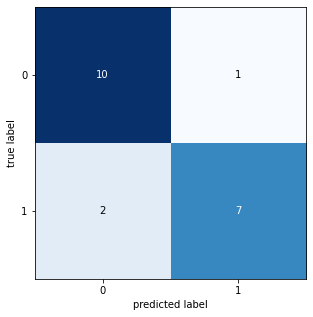

Train : [ 0  1  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 21 22 23 24 26
 28 29 32 33 34 35 36 38 40 41 42 43 44 45 46 48 49 50 51 52 53 54 55 56
 57 59 60 62 65 66 67 68 69 71 74 76 77 78 79 80 81 82 83 84 85 86 87 88
 90 91 92 93 94 96] Test : [ 2 20 25 27 30 31 37 39 47 58 61 63 64 70 72 73 75 89 95]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0]
Akurasi :  0.6842105263157895
F1_Score :  0.6833333333333333
              precision    recall  f1-score   support

           0       0.70      0.70      0.70        10
           1       0.67      0.67      0.67         9

    accuracy                           0.68        19
   macro avg       0.68      0.68      0.68        19
weighted avg       0.68      0.68      0.68        19



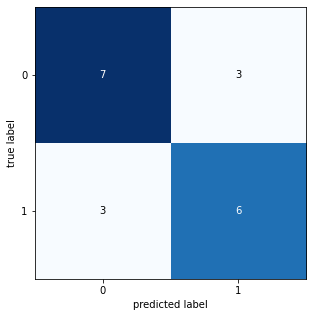

Train : [ 1  2  5  6  7  8  9 10 11 12 13 14 17 18 20 21 22 23 24 25 27 28 29 30
 31 32 33 34 35 36 37 39 40 41 42 43 44 45 47 49 50 52 53 56 57 58 59 61
 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 78 79 82 83 84 85 87 89 90
 91 92 93 94 95 96] Test : [ 0  3  4 15 16 19 26 38 46 48 51 54 55 60 77 80 81 86 88]
Y_Train : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 1 0 0 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Akurasi :  0.8421052631578947
F1_Score :  0.8403361344537814
              precision    recall  f1-score   support

           0       1.00      0.70      0.82        10
           1       0.75      1.00      0.86         9

    accuracy                           0.84        19
   macro avg       0.88      0.85      0.84        19
weighted avg       0.88      0.84      0.84        19



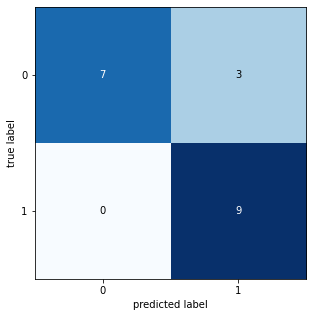

Train : [ 0  1  2  3  4  6  7  9 10 11 12 13 15 16 17 18 19 20 24 25 26 27 28 29
 30 31 32 33 34 36 37 38 39 40 41 44 46 47 48 49 50 51 52 54 55 56 57 58
 59 60 61 62 63 64 66 67 68 70 71 72 73 74 75 77 78 79 80 81 83 84 86 87
 88 89 93 94 95 96] Test : [ 5  8 14 21 22 23 35 42 43 45 53 65 69 76 82 85 90 91 92]
Y_Train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0]
Akurasi :  0.7894736842105263
F1_Score :  0.788888888888889
              precision    recall  f1-score   support

           0       0.80      0.80      0.80        10
           1       0.78      0.78      0.78         9

    accuracy                           0.79        19
   macro avg       0.79      0.79      0.79        19
weighted avg       0.79      0.79      0.79        19



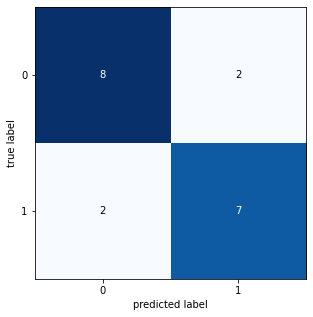

avg accuraccy Breast Cancer =  0.783157894736842
avg F1_Score Breast Cancer =  0.7806702391101368
max accuraccy Breast Cancer =  0.85
max F1_Score Breast Cancer =  0.8465473145780051
min accuraccy Breast Cancer =  0.6842105263157895
min F1_Score Breast Cancer =  0.6833333333333333
Running Time:  40.6500765159999
gene : [1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0]
Train : [ 0  1  2  3  4  5  6  8 12 13 14 15 16 18 19 20 21 22 23 24 25 26 27 29
 30 31 32 33 35 37 38 39 40 41 42 43 45 46 47 48 50 51 53 54 55 58 60 61
 63 64 65 67 68 69 70 71 72 73 75 76 77 78 79 80 81 82 85 86 87 88 89 90
 91 92 93 94 95] Test : [ 7  9 10 11 17 28 34 36 44 49 52 56 57 59 62 66 74 83 84 96]
Y_Train : [1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 

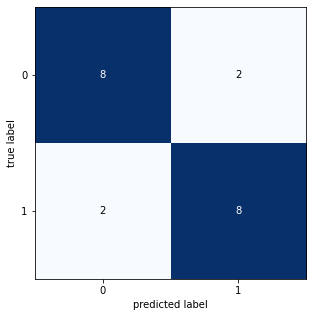

Train : [ 0  2  3  4  5  7  8  9 10 11 14 15 16 17 19 20 21 22 23 25 26 27 28 30
 31 34 35 36 37 38 39 42 43 44 45 46 47 48 49 51 52 53 54 55 56 57 58 59
 60 61 62 63 64 65 66 69 70 72 73 74 75 76 77 80 81 82 83 84 85 86 88 89
 90 91 92 95 96] Test : [ 1  6 12 13 18 24 29 32 33 40 41 50 67 68 71 78 79 87 93 94]
Y_Train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0]
Y_Test : [1 1 0 0 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Akurasi :  0.8
F1_Score :  0.797979797979798
              precision    recall  f1-score   support

           0       0.82      0.82      0.82        11
           1       0.78      0.78      0.78         9

    accuracy                           0.80        20
   macro avg       0.80      0.80      0.80        20
weighted avg       0.80      0.80      0.80        20



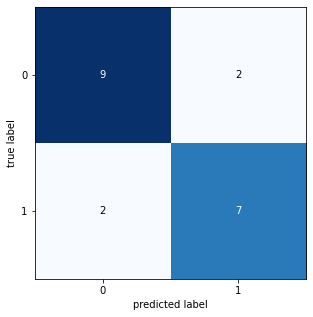

Train : [ 0  1  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 21 22 23 24 26
 28 29 32 33 34 35 36 38 40 41 42 43 44 45 46 48 49 50 51 52 53 54 55 56
 57 59 60 62 65 66 67 68 69 71 74 76 77 78 79 80 81 82 83 84 85 86 87 88
 90 91 92 93 94 96] Test : [ 2 20 25 27 30 31 37 39 47 58 61 63 64 70 72 73 75 89 95]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0]
Akurasi :  0.6842105263157895
F1_Score :  0.6833333333333333
              precision    recall  f1-score   support

           0       0.70      0.70      0.70        10
           1       0.67      0.67      0.67         9

    accuracy                           0.68        19
   macro avg       0.68      0.68      0.68        19
weighted avg       0.68      0.68      0.68        19



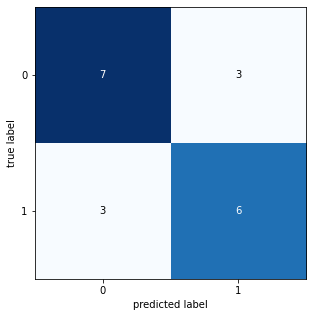

Train : [ 1  2  5  6  7  8  9 10 11 12 13 14 17 18 20 21 22 23 24 25 27 28 29 30
 31 32 33 34 35 36 37 39 40 41 42 43 44 45 47 49 50 52 53 56 57 58 59 61
 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 78 79 82 83 84 85 87 89 90
 91 92 93 94 95 96] Test : [ 0  3  4 15 16 19 26 38 46 48 51 54 55 60 77 80 81 86 88]
Y_Train : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 1 0 0 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Akurasi :  0.7368421052631579
F1_Score :  0.7338935574229692
              precision    recall  f1-score   support

           0       0.73      0.80      0.76        10
           1       0.75      0.67      0.71         9

    accuracy                           0.74        19
   macro avg       0.74      0.73      0.73        19
weighted avg       0.74      0.74      0.74        19



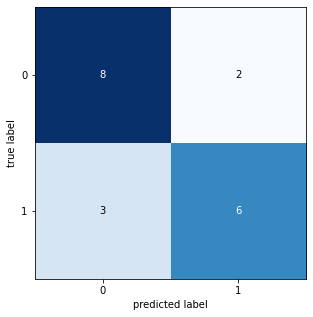

Train : [ 0  1  2  3  4  6  7  9 10 11 12 13 15 16 17 18 19 20 24 25 26 27 28 29
 30 31 32 33 34 36 37 38 39 40 41 44 46 47 48 49 50 51 52 54 55 56 57 58
 59 60 61 62 63 64 66 67 68 70 71 72 73 74 75 77 78 79 80 81 83 84 86 87
 88 89 93 94 95 96] Test : [ 5  8 14 21 22 23 35 42 43 45 53 65 69 76 82 85 90 91 92]
Y_Train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0]
Akurasi :  0.8947368421052632
F1_Score :  0.8944444444444445
              precision    recall  f1-score   support

           0       1.00      0.80      0.89        10
           1       0.82      1.00      0.90         9

    accuracy                           0.89        19
   macro avg       0.91      0.90      0.89        19
weighted avg       0.91      0.89      0.89        19



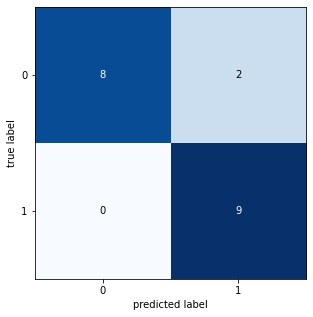

avg accuraccy Breast Cancer =  0.7831578947368422
avg F1_Score Breast Cancer =  0.7819302266361091
max accuraccy Breast Cancer =  0.8947368421052632
max F1_Score Breast Cancer =  0.8944444444444445
min accuraccy Breast Cancer =  0.6842105263157895
min F1_Score Breast Cancer =  0.6833333333333333
Running Time:  37.43695210000078
gene : [0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0]
Train : [ 0  1  2  3  4  5  6  8 12 13 14 15 16 18 19 20 21 22 23 24 25 26 27 29
 30 31 32 33 35 37 38 39 40 41 42 43 45 46 47 48 50 51 53 54 55 58 60 61
 63 64 65 67 68 69 70 71 72 73 75 76 77 78 79 80 81 82 85 86 87 88 89 90
 91 92 93 94 95] Test : [ 7  9 10 11 17 28 34 36 44 49 52 56 57 59 62 66 74 83 84 96]
Y_Train : [1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 

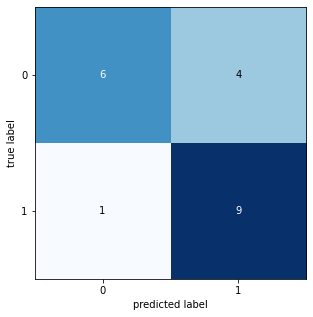

Train : [ 0  2  3  4  5  7  8  9 10 11 14 15 16 17 19 20 21 22 23 25 26 27 28 30
 31 34 35 36 37 38 39 42 43 44 45 46 47 48 49 51 52 53 54 55 56 57 58 59
 60 61 62 63 64 65 66 69 70 72 73 74 75 76 77 80 81 82 83 84 85 86 88 89
 90 91 92 95 96] Test : [ 1  6 12 13 18 24 29 32 33 40 41 50 67 68 71 78 79 87 93 94]
Y_Train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0]
Y_Test : [1 1 0 0 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Akurasi :  0.85
F1_Score :  0.8465473145780051
              precision    recall  f1-score   support

           0       0.83      0.91      0.87        11
           1       0.88      0.78      0.82         9

    accuracy                           0.85        20
   macro avg       0.85      0.84      0.85        20
weighted avg       0.85      0.85      0.85        20



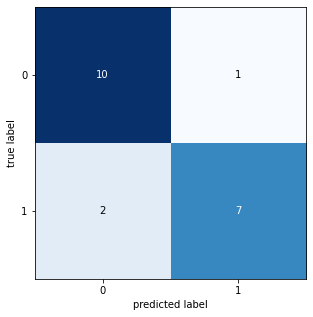

Train : [ 0  1  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 21 22 23 24 26
 28 29 32 33 34 35 36 38 40 41 42 43 44 45 46 48 49 50 51 52 53 54 55 56
 57 59 60 62 65 66 67 68 69 71 74 76 77 78 79 80 81 82 83 84 85 86 87 88
 90 91 92 93 94 96] Test : [ 2 20 25 27 30 31 37 39 47 58 61 63 64 70 72 73 75 89 95]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0]
Akurasi :  0.7894736842105263
F1_Score :  0.788888888888889
              precision    recall  f1-score   support

           0       0.80      0.80      0.80        10
           1       0.78      0.78      0.78         9

    accuracy                           0.79        19
   macro avg       0.79      0.79      0.79        19
weighted avg       0.79      0.79      0.79        19



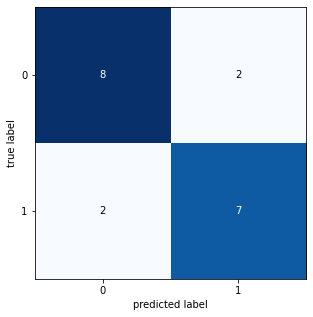

Train : [ 1  2  5  6  7  8  9 10 11 12 13 14 17 18 20 21 22 23 24 25 27 28 29 30
 31 32 33 34 35 36 37 39 40 41 42 43 44 45 47 49 50 52 53 56 57 58 59 61
 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 78 79 82 83 84 85 87 89 90
 91 92 93 94 95 96] Test : [ 0  3  4 15 16 19 26 38 46 48 51 54 55 60 77 80 81 86 88]
Y_Train : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 1 0 0 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Akurasi :  0.8421052631578947
F1_Score :  0.8421052631578948
              precision    recall  f1-score   support

           0       0.89      0.80      0.84        10
           1       0.80      0.89      0.84         9

    accuracy                           0.84        19
   macro avg       0.84      0.84      0.84        19
weighted avg       0.85      0.84      0.84        19



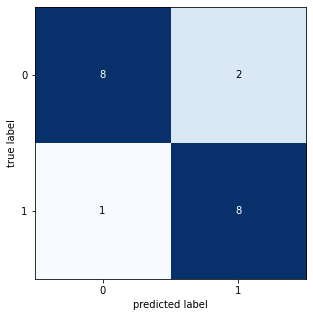

Train : [ 0  1  2  3  4  6  7  9 10 11 12 13 15 16 17 18 19 20 24 25 26 27 28 29
 30 31 32 33 34 36 37 38 39 40 41 44 46 47 48 49 50 51 52 54 55 56 57 58
 59 60 61 62 63 64 66 67 68 70 71 72 73 74 75 77 78 79 80 81 83 84 86 87
 88 89 93 94 95 96] Test : [ 5  8 14 21 22 23 35 42 43 45 53 65 69 76 82 85 90 91 92]
Y_Train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0]
Akurasi :  0.7894736842105263
F1_Score :  0.788888888888889
              precision    recall  f1-score   support

           0       0.80      0.80      0.80        10
           1       0.78      0.78      0.78         9

    accuracy                           0.79        19
   macro avg       0.79      0.79      0.79        19
weighted avg       0.79      0.79      0.79        19



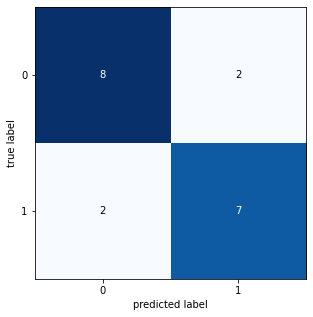

avg accuraccy Breast Cancer =  0.8042105263157895
avg F1_Score Breast Cancer =  0.8021351759620705
max accuraccy Breast Cancer =  0.85
max F1_Score Breast Cancer =  0.8465473145780051
min accuraccy Breast Cancer =  0.75
min F1_Score Breast Cancer =  0.7442455242966751
Running Time:  39.630855109999175
gene : [1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Train : [ 0  1  2  3  4  5  6  8 12 13 14 15 16 18 19 20 21 22 23 24 25 26 27 29
 30 31 32 33 35 37 38 39 40 41 42 43 45 46 47 48 50 51 53 54 55 58 60 61
 63 64 65 67 68 69 70 71 72 73 75 76 77 78 79 80 81 82 85 86 87 88 89 90
 91 92 93 94 95] Test : [ 7  9 10 11 17 28 34 36 44 49 52 56 57 59 62 66 74 83 84 96]
Y_Train : [1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1

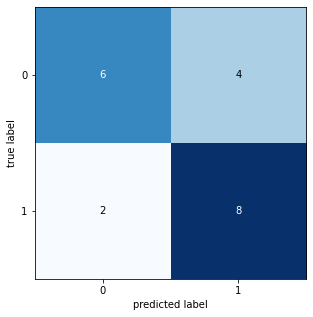

Train : [ 0  2  3  4  5  7  8  9 10 11 14 15 16 17 19 20 21 22 23 25 26 27 28 30
 31 34 35 36 37 38 39 42 43 44 45 46 47 48 49 51 52 53 54 55 56 57 58 59
 60 61 62 63 64 65 66 69 70 72 73 74 75 76 77 80 81 82 83 84 85 86 88 89
 90 91 92 95 96] Test : [ 1  6 12 13 18 24 29 32 33 40 41 50 67 68 71 78 79 87 93 94]
Y_Train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0]
Y_Test : [1 1 0 0 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Akurasi :  0.75
F1_Score :  0.7442455242966752
              precision    recall  f1-score   support

           0       1.00      0.55      0.71        11
           1       0.64      1.00      0.78         9

    accuracy                           0.75        20
   macro avg       0.82      0.77      0.74        20
weighted avg       0.84      0.75      0.74        20



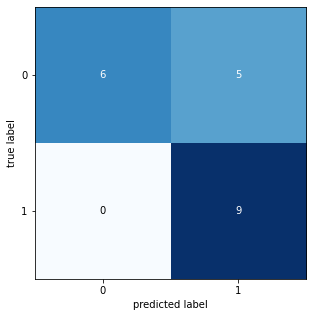

Train : [ 0  1  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 21 22 23 24 26
 28 29 32 33 34 35 36 38 40 41 42 43 44 45 46 48 49 50 51 52 53 54 55 56
 57 59 60 62 65 66 67 68 69 71 74 76 77 78 79 80 81 82 83 84 85 86 87 88
 90 91 92 93 94 96] Test : [ 2 20 25 27 30 31 37 39 47 58 61 63 64 70 72 73 75 89 95]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0]
Akurasi :  0.6842105263157895
F1_Score :  0.6761363636363636
              precision    recall  f1-score   support

           0       0.67      0.80      0.73        10
           1       0.71      0.56      0.63         9

    accuracy                           0.68        19
   macro avg       0.69      0.68      0.68        19
weighted avg       0.69      0.68      0.68        19



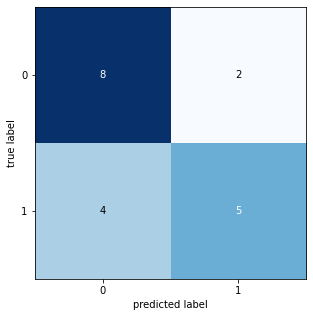

Train : [ 1  2  5  6  7  8  9 10 11 12 13 14 17 18 20 21 22 23 24 25 27 28 29 30
 31 32 33 34 35 36 37 39 40 41 42 43 44 45 47 49 50 52 53 56 57 58 59 61
 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 78 79 82 83 84 85 87 89 90
 91 92 93 94 95 96] Test : [ 0  3  4 15 16 19 26 38 46 48 51 54 55 60 77 80 81 86 88]
Y_Train : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 1 0 0 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Akurasi :  0.5263157894736842
F1_Score :  0.5263157894736842
              precision    recall  f1-score   support

           0       0.56      0.50      0.53        10
           1       0.50      0.56      0.53         9

    accuracy                           0.53        19
   macro avg       0.53      0.53      0.53        19
weighted avg       0.53      0.53      0.53        19



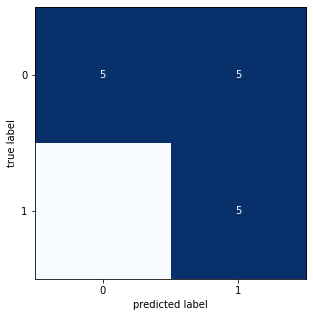

Train : [ 0  1  2  3  4  6  7  9 10 11 12 13 15 16 17 18 19 20 24 25 26 27 28 29
 30 31 32 33 34 36 37 38 39 40 41 44 46 47 48 49 50 51 52 54 55 56 57 58
 59 60 61 62 63 64 66 67 68 70 71 72 73 74 75 77 78 79 80 81 83 84 86 87
 88 89 93 94 95 96] Test : [ 5  8 14 21 22 23 35 42 43 45 53 65 69 76 82 85 90 91 92]
Y_Train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0]
Akurasi :  0.7894736842105263
F1_Score :  0.7888888888888888
              precision    recall  f1-score   support

           0       0.88      0.70      0.78        10
           1       0.73      0.89      0.80         9

    accuracy                           0.79        19
   macro avg       0.80      0.79      0.79        19
weighted avg       0.81      0.79      0.79        19



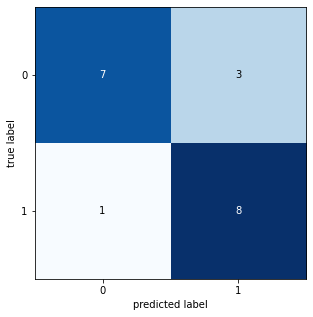

avg accuraccy Breast Cancer =  0.6900000000000001
avg F1_Score Breast Cancer =  0.6865112526530617
max accuraccy Breast Cancer =  0.7894736842105263
max F1_Score Breast Cancer =  0.7888888888888888
min accuraccy Breast Cancer =  0.5263157894736842
min F1_Score Breast Cancer =  0.5263157894736842
Running Time:  41.749788213999636
gene : [0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0]
Train : [ 0  1  2  3  4  5  6  8 12 13 14 15 16 18 19 20 21 22 23 24 25 26 27 29
 30 31 32 33 35 37 38 39 40 41 42 43 45 46 47 48 50 51 53 54 55 58 60 61
 63 64 65 67 68 69 70 71 72 73 75 76 77 78 79 80 81 82 85 86 87 88 89 90
 91 92 93 94 95] Test : [ 7  9 10 11 17 28 34 36 44 49 52 56 57 59 62 66 74 83 84 96]
Y_Train : [1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1

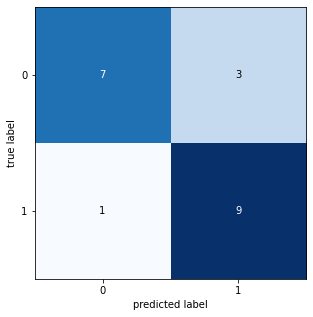

Train : [ 0  2  3  4  5  7  8  9 10 11 14 15 16 17 19 20 21 22 23 25 26 27 28 30
 31 34 35 36 37 38 39 42 43 44 45 46 47 48 49 51 52 53 54 55 56 57 58 59
 60 61 62 63 64 65 66 69 70 72 73 74 75 76 77 80 81 82 83 84 85 86 88 89
 90 91 92 95 96] Test : [ 1  6 12 13 18 24 29 32 33 40 41 50 67 68 71 78 79 87 93 94]
Y_Train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0]
Y_Test : [1 1 0 0 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Akurasi :  0.75
F1_Score :  0.7493734335839599
              precision    recall  f1-score   support

           0       0.80      0.73      0.76        11
           1       0.70      0.78      0.74         9

    accuracy                           0.75        20
   macro avg       0.75      0.75      0.75        20
weighted avg       0.76      0.75      0.75        20



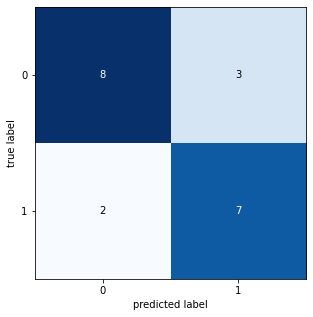

Train : [ 0  1  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 21 22 23 24 26
 28 29 32 33 34 35 36 38 40 41 42 43 44 45 46 48 49 50 51 52 53 54 55 56
 57 59 60 62 65 66 67 68 69 71 74 76 77 78 79 80 81 82 83 84 85 86 87 88
 90 91 92 93 94 96] Test : [ 2 20 25 27 30 31 37 39 47 58 61 63 64 70 72 73 75 89 95]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0]
Akurasi :  0.7368421052631579
F1_Score :  0.7368421052631577
              precision    recall  f1-score   support

           0       0.78      0.70      0.74        10
           1       0.70      0.78      0.74         9

    accuracy                           0.74        19
   macro avg       0.74      0.74      0.74        19
weighted avg       0.74      0.74      0.74        19



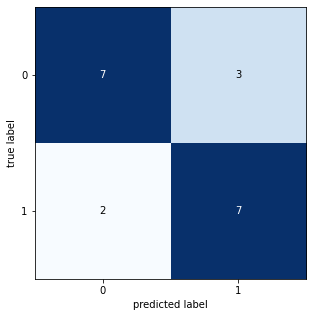

Train : [ 1  2  5  6  7  8  9 10 11 12 13 14 17 18 20 21 22 23 24 25 27 28 29 30
 31 32 33 34 35 36 37 39 40 41 42 43 44 45 47 49 50 52 53 56 57 58 59 61
 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 78 79 82 83 84 85 87 89 90
 91 92 93 94 95 96] Test : [ 0  3  4 15 16 19 26 38 46 48 51 54 55 60 77 80 81 86 88]
Y_Train : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 1 0 0 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Akurasi :  0.7894736842105263
F1_Score :  0.788888888888889
              precision    recall  f1-score   support

           0       0.80      0.80      0.80        10
           1       0.78      0.78      0.78         9

    accuracy                           0.79        19
   macro avg       0.79      0.79      0.79        19
weighted avg       0.79      0.79      0.79        19



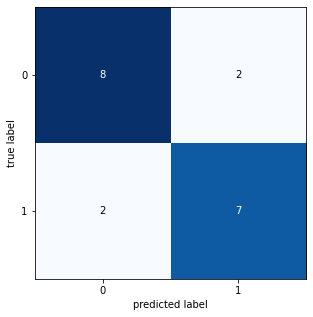

Train : [ 0  1  2  3  4  6  7  9 10 11 12 13 15 16 17 18 19 20 24 25 26 27 28 29
 30 31 32 33 34 36 37 38 39 40 41 44 46 47 48 49 50 51 52 54 55 56 57 58
 59 60 61 62 63 64 66 67 68 70 71 72 73 74 75 77 78 79 80 81 83 84 86 87
 88 89 93 94 95 96] Test : [ 5  8 14 21 22 23 35 42 43 45 53 65 69 76 82 85 90 91 92]
Y_Train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0]
Akurasi :  0.8421052631578947
F1_Score :  0.8403361344537814
              precision    recall  f1-score   support

           0       1.00      0.70      0.82        10
           1       0.75      1.00      0.86         9

    accuracy                           0.84        19
   macro avg       0.88      0.85      0.84        19
weighted avg       0.88      0.84      0.84        19



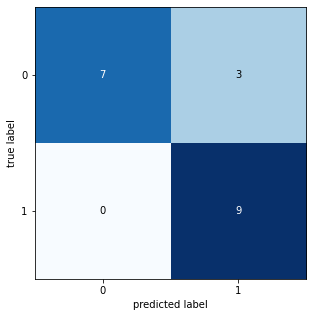

avg accuraccy Breast Cancer =  0.7836842105263158
avg F1_Score Breast Cancer =  0.7826840720339172
max accuraccy Breast Cancer =  0.8421052631578947
max F1_Score Breast Cancer =  0.8403361344537814
min accuraccy Breast Cancer =  0.7368421052631579
min F1_Score Breast Cancer =  0.7368421052631577
Running Time:  38.46607127599964
gene : [1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0]
Train : [ 0  1  2  3  4  5  6  8 12 13 14 15 16 18 19 20 21 22 23 24 25 26 27 29
 30 31 32 33 35 37 38 39 40 41 42 43 45 46 47 48 50 51 53 54 55 58 60 61
 63 64 65 67 68 69 70 71 72 73 75 76 77 78 79 80 81 82 85 86 87 88 89 90
 91 92 93 94 95] Test : [ 7  9 10 11 17 28 34 36 44 49 52 56 57 59 62 66 74 83 84 96]
Y_Train : [1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 

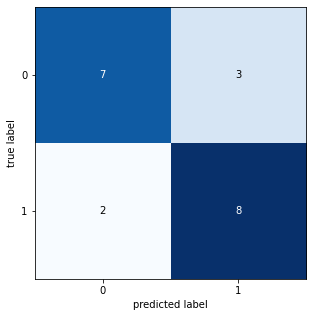

Train : [ 0  2  3  4  5  7  8  9 10 11 14 15 16 17 19 20 21 22 23 25 26 27 28 30
 31 34 35 36 37 38 39 42 43 44 45 46 47 48 49 51 52 53 54 55 56 57 58 59
 60 61 62 63 64 65 66 69 70 72 73 74 75 76 77 80 81 82 83 84 85 86 88 89
 90 91 92 95 96] Test : [ 1  6 12 13 18 24 29 32 33 40 41 50 67 68 71 78 79 87 93 94]
Y_Train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0]
Y_Test : [1 1 0 0 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Akurasi :  0.75
F1_Score :  0.7333333333333334
              precision    recall  f1-score   support

           0       0.71      0.91      0.80        11
           1       0.83      0.56      0.67         9

    accuracy                           0.75        20
   macro avg       0.77      0.73      0.73        20
weighted avg       0.77      0.75      0.74        20



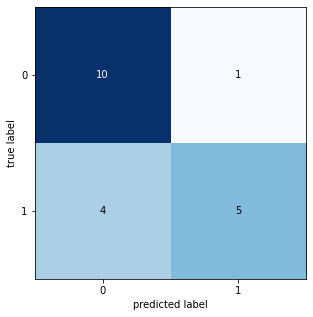

Train : [ 0  1  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 21 22 23 24 26
 28 29 32 33 34 35 36 38 40 41 42 43 44 45 46 48 49 50 51 52 53 54 55 56
 57 59 60 62 65 66 67 68 69 71 74 76 77 78 79 80 81 82 83 84 85 86 87 88
 90 91 92 93 94 96] Test : [ 2 20 25 27 30 31 37 39 47 58 61 63 64 70 72 73 75 89 95]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0]
Akurasi :  0.631578947368421
F1_Score :  0.6274509803921569
              precision    recall  f1-score   support

           0       0.64      0.70      0.67        10
           1       0.62      0.56      0.59         9

    accuracy                           0.63        19
   macro avg       0.63      0.63      0.63        19
weighted avg       0.63      0.63      0.63        19



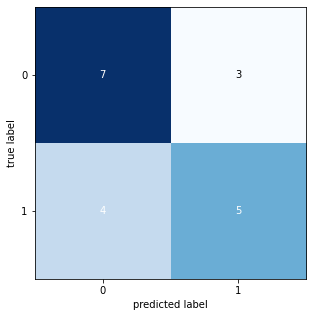

Train : [ 1  2  5  6  7  8  9 10 11 12 13 14 17 18 20 21 22 23 24 25 27 28 29 30
 31 32 33 34 35 36 37 39 40 41 42 43 44 45 47 49 50 52 53 56 57 58 59 61
 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 78 79 82 83 84 85 87 89 90
 91 92 93 94 95 96] Test : [ 0  3  4 15 16 19 26 38 46 48 51 54 55 60 77 80 81 86 88]
Y_Train : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 1 0 0 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Akurasi :  0.7894736842105263
F1_Score :  0.788888888888889
              precision    recall  f1-score   support

           0       0.80      0.80      0.80        10
           1       0.78      0.78      0.78         9

    accuracy                           0.79        19
   macro avg       0.79      0.79      0.79        19
weighted avg       0.79      0.79      0.79        19



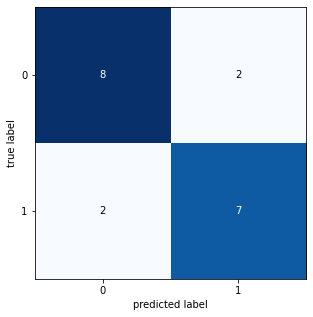

Train : [ 0  1  2  3  4  6  7  9 10 11 12 13 15 16 17 18 19 20 24 25 26 27 28 29
 30 31 32 33 34 36 37 38 39 40 41 44 46 47 48 49 50 51 52 54 55 56 57 58
 59 60 61 62 63 64 66 67 68 70 71 72 73 74 75 77 78 79 80 81 83 84 86 87
 88 89 93 94 95 96] Test : [ 5  8 14 21 22 23 35 42 43 45 53 65 69 76 82 85 90 91 92]
Y_Train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0]
Akurasi :  0.8421052631578947
F1_Score :  0.8403361344537814
              precision    recall  f1-score   support

           0       1.00      0.70      0.82        10
           1       0.75      1.00      0.86         9

    accuracy                           0.84        19
   macro avg       0.88      0.85      0.84        19
weighted avg       0.88      0.84      0.84        19



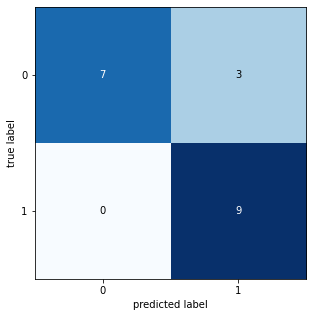

avg accuraccy Breast Cancer =  0.7526315789473685
avg F1_Score Breast Cancer =  0.747876554130424
max accuraccy Breast Cancer =  0.8421052631578947
max F1_Score Breast Cancer =  0.8403361344537814
min accuraccy Breast Cancer =  0.631578947368421
min F1_Score Breast Cancer =  0.6274509803921569
Running Time:  39.11098553600095
gene : [1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0]
Train : [ 0  1  2  3  4  5  6  8 12 13 14 15 16 18 19 20 21 22 23 24 25 26 27 29
 30 31 32 33 35 37 38 39 40 41 42 43 45 46 47 48 50 51 53 54 55 58 60 61
 63 64 65 67 68 69 70 71 72 73 75 76 77 78 79 80 81 82 85 86 87 88 89 90
 91 92 93 94 95] Test : [ 7  9 10 11 17 28 34 36 44 49 52 56 57 59 62 66 74 83 84 96]
Y_Train : [1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 

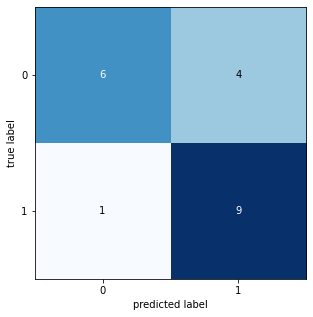

Train : [ 0  2  3  4  5  7  8  9 10 11 14 15 16 17 19 20 21 22 23 25 26 27 28 30
 31 34 35 36 37 38 39 42 43 44 45 46 47 48 49 51 52 53 54 55 56 57 58 59
 60 61 62 63 64 65 66 69 70 72 73 74 75 76 77 80 81 82 83 84 85 86 88 89
 90 91 92 95 96] Test : [ 1  6 12 13 18 24 29 32 33 40 41 50 67 68 71 78 79 87 93 94]
Y_Train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0]
Y_Test : [1 1 0 0 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Akurasi :  0.7
F1_Score :  0.6703296703296703
              precision    recall  f1-score   support

           0       0.67      0.91      0.77        11
           1       0.80      0.44      0.57         9

    accuracy                           0.70        20
   macro avg       0.73      0.68      0.67        20
weighted avg       0.73      0.70      0.68        20



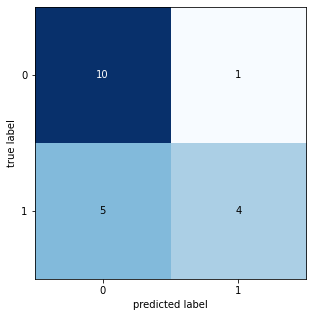

Train : [ 0  1  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 21 22 23 24 26
 28 29 32 33 34 35 36 38 40 41 42 43 44 45 46 48 49 50 51 52 53 54 55 56
 57 59 60 62 65 66 67 68 69 71 74 76 77 78 79 80 81 82 83 84 85 86 87 88
 90 91 92 93 94 96] Test : [ 2 20 25 27 30 31 37 39 47 58 61 63 64 70 72 73 75 89 95]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0]
Akurasi :  0.7894736842105263
F1_Score :  0.788888888888889
              precision    recall  f1-score   support

           0       0.80      0.80      0.80        10
           1       0.78      0.78      0.78         9

    accuracy                           0.79        19
   macro avg       0.79      0.79      0.79        19
weighted avg       0.79      0.79      0.79        19



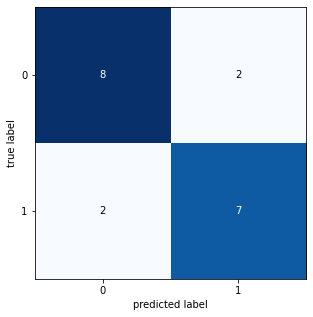

Train : [ 1  2  5  6  7  8  9 10 11 12 13 14 17 18 20 21 22 23 24 25 27 28 29 30
 31 32 33 34 35 36 37 39 40 41 42 43 44 45 47 49 50 52 53 56 57 58 59 61
 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 78 79 82 83 84 85 87 89 90
 91 92 93 94 95 96] Test : [ 0  3  4 15 16 19 26 38 46 48 51 54 55 60 77 80 81 86 88]
Y_Train : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 1 0 0 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Akurasi :  0.7368421052631579
F1_Score :  0.7368421052631577
              precision    recall  f1-score   support

           0       0.78      0.70      0.74        10
           1       0.70      0.78      0.74         9

    accuracy                           0.74        19
   macro avg       0.74      0.74      0.74        19
weighted avg       0.74      0.74      0.74        19



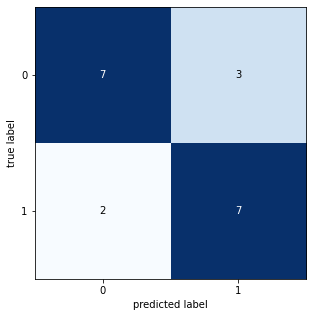

Train : [ 0  1  2  3  4  6  7  9 10 11 12 13 15 16 17 18 19 20 24 25 26 27 28 29
 30 31 32 33 34 36 37 38 39 40 41 44 46 47 48 49 50 51 52 54 55 56 57 58
 59 60 61 62 63 64 66 67 68 70 71 72 73 74 75 77 78 79 80 81 83 84 86 87
 88 89 93 94 95 96] Test : [ 5  8 14 21 22 23 35 42 43 45 53 65 69 76 82 85 90 91 92]
Y_Train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0]
Akurasi :  0.8421052631578947
F1_Score :  0.8421052631578948
              precision    recall  f1-score   support

           0       0.89      0.80      0.84        10
           1       0.80      0.89      0.84         9

    accuracy                           0.84        19
   macro avg       0.84      0.84      0.84        19
weighted avg       0.85      0.84      0.84        19



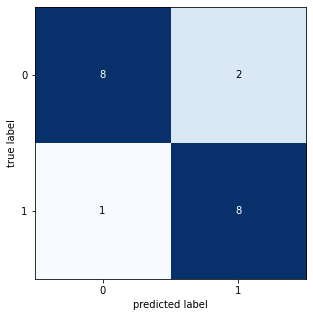

avg accuraccy Breast Cancer =  0.7636842105263157
avg F1_Score Breast Cancer =  0.7564822903872572
max accuraccy Breast Cancer =  0.8421052631578947
max F1_Score Breast Cancer =  0.8421052631578948
min accuraccy Breast Cancer =  0.7
min F1_Score Breast Cancer =  0.6703296703296703
Running Time:  38.329944996999984
gene : [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0]
Train : [ 0  1  2  3  4  5  6  8 12 13 14 15 16 18 19 20 21 22 23 24 25 26 27 29
 30 31 32 33 35 37 38 39 40 41 42 43 45 46 47 48 50 51 53 54 55 58 60 61
 63 64 65 67 68 69 70 71 72 73 75 76 77 78 79 80 81 82 85 86 87 88 89 90
 91 92 93 94 95] Test : [ 7  9 10 11 17 28 34 36 44 49 52 56 57 59 62 66 74 83 84 96]
Y_Train : [1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 

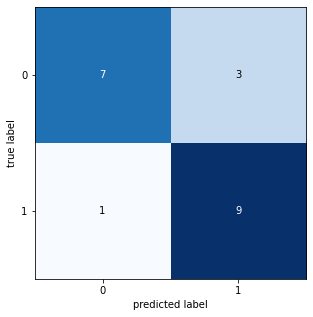

Train : [ 0  2  3  4  5  7  8  9 10 11 14 15 16 17 19 20 21 22 23 25 26 27 28 30
 31 34 35 36 37 38 39 42 43 44 45 46 47 48 49 51 52 53 54 55 56 57 58 59
 60 61 62 63 64 65 66 69 70 72 73 74 75 76 77 80 81 82 83 84 85 86 88 89
 90 91 92 95 96] Test : [ 1  6 12 13 18 24 29 32 33 40 41 50 67 68 71 78 79 87 93 94]
Y_Train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0]
Y_Test : [1 1 0 0 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Akurasi :  0.55
F1_Score :  0.5396419437340154
              precision    recall  f1-score   support

           0       0.67      0.36      0.47        11
           1       0.50      0.78      0.61         9

    accuracy                           0.55        20
   macro avg       0.58      0.57      0.54        20
weighted avg       0.59      0.55      0.53        20



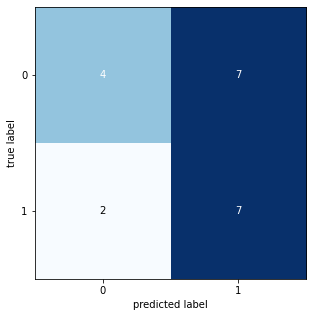

Train : [ 0  1  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 21 22 23 24 26
 28 29 32 33 34 35 36 38 40 41 42 43 44 45 46 48 49 50 51 52 53 54 55 56
 57 59 60 62 65 66 67 68 69 71 74 76 77 78 79 80 81 82 83 84 85 86 87 88
 90 91 92 93 94 96] Test : [ 2 20 25 27 30 31 37 39 47 58 61 63 64 70 72 73 75 89 95]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0]
Akurasi :  0.7368421052631579
F1_Score :  0.7338935574229692
              precision    recall  f1-score   support

           0       0.73      0.80      0.76        10
           1       0.75      0.67      0.71         9

    accuracy                           0.74        19
   macro avg       0.74      0.73      0.73        19
weighted avg       0.74      0.74      0.74        19



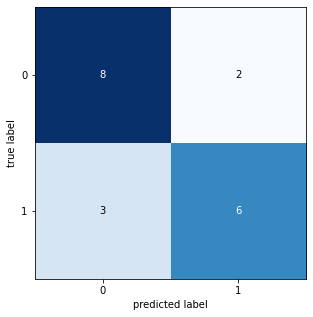

Train : [ 1  2  5  6  7  8  9 10 11 12 13 14 17 18 20 21 22 23 24 25 27 28 29 30
 31 32 33 34 35 36 37 39 40 41 42 43 44 45 47 49 50 52 53 56 57 58 59 61
 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 78 79 82 83 84 85 87 89 90
 91 92 93 94 95 96] Test : [ 0  3  4 15 16 19 26 38 46 48 51 54 55 60 77 80 81 86 88]
Y_Train : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 1 0 0 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Akurasi :  0.5263157894736842
F1_Score :  0.5210084033613446
              precision    recall  f1-score   support

           0       0.57      0.40      0.47        10
           1       0.50      0.67      0.57         9

    accuracy                           0.53        19
   macro avg       0.54      0.53      0.52        19
weighted avg       0.54      0.53      0.52        19



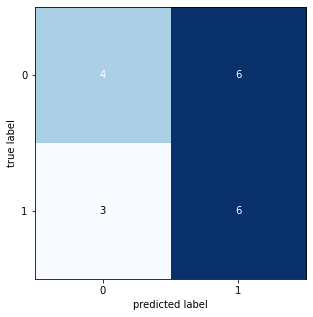

Train : [ 0  1  2  3  4  6  7  9 10 11 12 13 15 16 17 18 19 20 24 25 26 27 28 29
 30 31 32 33 34 36 37 38 39 40 41 44 46 47 48 49 50 51 52 54 55 56 57 58
 59 60 61 62 63 64 66 67 68 70 71 72 73 74 75 77 78 79 80 81 83 84 86 87
 88 89 93 94 95 96] Test : [ 5  8 14 21 22 23 35 42 43 45 53 65 69 76 82 85 90 91 92]
Y_Train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0]
Akurasi :  0.6842105263157895
F1_Score :  0.6833333333333333
              precision    recall  f1-score   support

           0       0.75      0.60      0.67        10
           1       0.64      0.78      0.70         9

    accuracy                           0.68        19
   macro avg       0.69      0.69      0.68        19
weighted avg       0.70      0.68      0.68        19



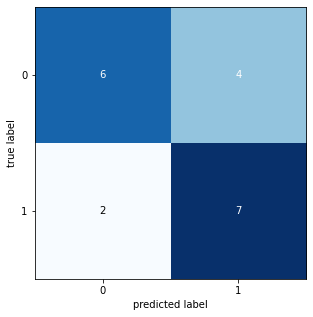

avg accuraccy Breast Cancer =  0.6594736842105263
avg F1_Score Breast Cancer =  0.6551714071662922
max accuraccy Breast Cancer =  0.8
max F1_Score Breast Cancer =  0.797979797979798
min accuraccy Breast Cancer =  0.5263157894736842
min F1_Score Breast Cancer =  0.5210084033613446
Running Time:  43.456086999000036
gene : [0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0]
Train : [ 0  1  2  3  4  5  6  8 12 13 14 15 16 18 19 20 21 22 23 24 25 26 27 29
 30 31 32 33 35 37 38 39 40 41 42 43 45 46 47 48 50 51 53 54 55 58 60 61
 63 64 65 67 68 69 70 71 72 73 75 76 77 78 79 80 81 82 85 86 87 88 89 90
 91 92 93 94 95] Test : [ 7  9 10 11 17 28 34 36 44 49 52 56 57 59 62 66 74 83 84 96]
Y_Train : [1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1

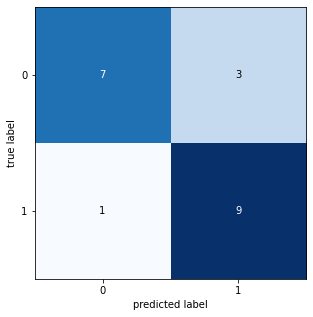

Train : [ 0  2  3  4  5  7  8  9 10 11 14 15 16 17 19 20 21 22 23 25 26 27 28 30
 31 34 35 36 37 38 39 42 43 44 45 46 47 48 49 51 52 53 54 55 56 57 58 59
 60 61 62 63 64 65 66 69 70 72 73 74 75 76 77 80 81 82 83 84 85 86 88 89
 90 91 92 95 96] Test : [ 1  6 12 13 18 24 29 32 33 40 41 50 67 68 71 78 79 87 93 94]
Y_Train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0]
Y_Test : [1 1 0 0 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Akurasi :  0.75
F1_Score :  0.7493734335839599
              precision    recall  f1-score   support

           0       0.80      0.73      0.76        11
           1       0.70      0.78      0.74         9

    accuracy                           0.75        20
   macro avg       0.75      0.75      0.75        20
weighted avg       0.76      0.75      0.75        20



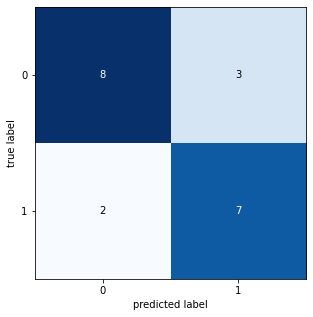

Train : [ 0  1  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 21 22 23 24 26
 28 29 32 33 34 35 36 38 40 41 42 43 44 45 46 48 49 50 51 52 53 54 55 56
 57 59 60 62 65 66 67 68 69 71 74 76 77 78 79 80 81 82 83 84 85 86 87 88
 90 91 92 93 94 96] Test : [ 2 20 25 27 30 31 37 39 47 58 61 63 64 70 72 73 75 89 95]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0]
Akurasi :  0.6842105263157895
F1_Score :  0.6833333333333333
              precision    recall  f1-score   support

           0       0.75      0.60      0.67        10
           1       0.64      0.78      0.70         9

    accuracy                           0.68        19
   macro avg       0.69      0.69      0.68        19
weighted avg       0.70      0.68      0.68        19



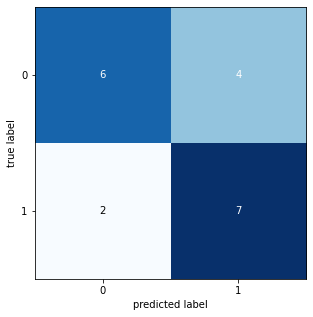

Train : [ 1  2  5  6  7  8  9 10 11 12 13 14 17 18 20 21 22 23 24 25 27 28 29 30
 31 32 33 34 35 36 37 39 40 41 42 43 44 45 47 49 50 52 53 56 57 58 59 61
 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 78 79 82 83 84 85 87 89 90
 91 92 93 94 95 96] Test : [ 0  3  4 15 16 19 26 38 46 48 51 54 55 60 77 80 81 86 88]
Y_Train : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 1 0 0 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Akurasi :  0.7894736842105263
F1_Score :  0.788888888888889
              precision    recall  f1-score   support

           0       0.80      0.80      0.80        10
           1       0.78      0.78      0.78         9

    accuracy                           0.79        19
   macro avg       0.79      0.79      0.79        19
weighted avg       0.79      0.79      0.79        19



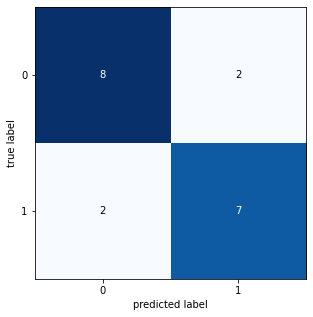

Train : [ 0  1  2  3  4  6  7  9 10 11 12 13 15 16 17 18 19 20 24 25 26 27 28 29
 30 31 32 33 34 36 37 38 39 40 41 44 46 47 48 49 50 51 52 54 55 56 57 58
 59 60 61 62 63 64 66 67 68 70 71 72 73 74 75 77 78 79 80 81 83 84 86 87
 88 89 93 94 95 96] Test : [ 5  8 14 21 22 23 35 42 43 45 53 65 69 76 82 85 90 91 92]
Y_Train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0]
Akurasi :  0.8947368421052632
F1_Score :  0.8944444444444445
              precision    recall  f1-score   support

           0       1.00      0.80      0.89        10
           1       0.82      1.00      0.90         9

    accuracy                           0.89        19
   macro avg       0.91      0.90      0.89        19
weighted avg       0.91      0.89      0.89        19



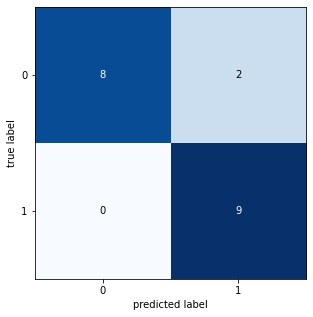

avg accuraccy Breast Cancer =  0.7836842105263158
avg F1_Score Breast Cancer =  0.7828039796460848
max accuraccy Breast Cancer =  0.8947368421052632
max F1_Score Breast Cancer =  0.8944444444444445
min accuraccy Breast Cancer =  0.6842105263157895
min F1_Score Breast Cancer =  0.6833333333333333
Running Time:  40.51653913200062
gene : [1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0]
Train : [ 0  1  2  3  4  5  6  8 12 13 14 15 16 18 19 20 21 22 23 24 25 26 27 29
 30 31 32 33 35 37 38 39 40 41 42 43 45 46 47 48 50 51 53 54 55 58 60 61
 63 64 65 67 68 69 70 71 72 73 75 76 77 78 79 80 81 82 85 86 87 88 89 90
 91 92 93 94 95] Test : [ 7  9 10 11 17 28 34 36 44 49 52 56 57 59 62 66 74 83 84 96]
Y_Train : [1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 

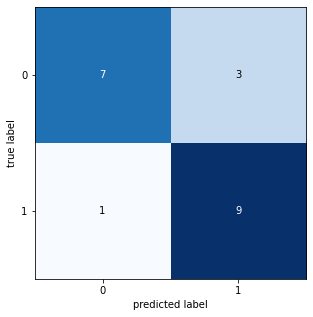

Train : [ 0  2  3  4  5  7  8  9 10 11 14 15 16 17 19 20 21 22 23 25 26 27 28 30
 31 34 35 36 37 38 39 42 43 44 45 46 47 48 49 51 52 53 54 55 56 57 58 59
 60 61 62 63 64 65 66 69 70 72 73 74 75 76 77 80 81 82 83 84 85 86 88 89
 90 91 92 95 96] Test : [ 1  6 12 13 18 24 29 32 33 40 41 50 67 68 71 78 79 87 93 94]
Y_Train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0]
Y_Test : [1 1 0 0 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Akurasi :  0.7
F1_Score :  0.6875000000000001
              precision    recall  f1-score   support

           0       0.69      0.82      0.75        11
           1       0.71      0.56      0.63         9

    accuracy                           0.70        20
   macro avg       0.70      0.69      0.69        20
weighted avg       0.70      0.70      0.69        20



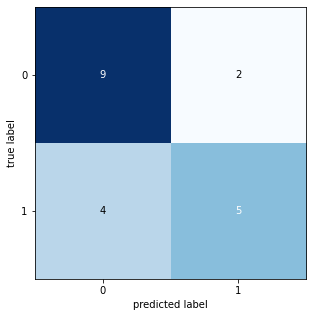

Train : [ 0  1  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 21 22 23 24 26
 28 29 32 33 34 35 36 38 40 41 42 43 44 45 46 48 49 50 51 52 53 54 55 56
 57 59 60 62 65 66 67 68 69 71 74 76 77 78 79 80 81 82 83 84 85 86 87 88
 90 91 92 93 94 96] Test : [ 2 20 25 27 30 31 37 39 47 58 61 63 64 70 72 73 75 89 95]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0]
Akurasi :  0.7368421052631579
F1_Score :  0.7338935574229692
              precision    recall  f1-score   support

           0       0.73      0.80      0.76        10
           1       0.75      0.67      0.71         9

    accuracy                           0.74        19
   macro avg       0.74      0.73      0.73        19
weighted avg       0.74      0.74      0.74        19



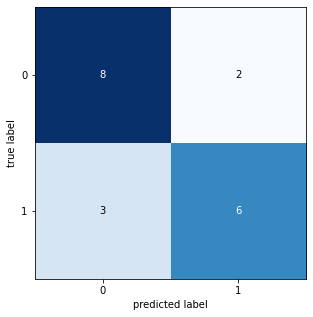

Train : [ 1  2  5  6  7  8  9 10 11 12 13 14 17 18 20 21 22 23 24 25 27 28 29 30
 31 32 33 34 35 36 37 39 40 41 42 43 44 45 47 49 50 52 53 56 57 58 59 61
 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 78 79 82 83 84 85 87 89 90
 91 92 93 94 95 96] Test : [ 0  3  4 15 16 19 26 38 46 48 51 54 55 60 77 80 81 86 88]
Y_Train : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 1 0 0 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Akurasi :  0.7894736842105263
F1_Score :  0.788888888888889
              precision    recall  f1-score   support

           0       0.80      0.80      0.80        10
           1       0.78      0.78      0.78         9

    accuracy                           0.79        19
   macro avg       0.79      0.79      0.79        19
weighted avg       0.79      0.79      0.79        19



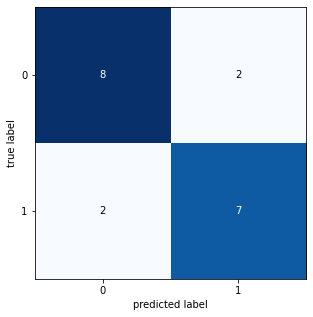

Train : [ 0  1  2  3  4  6  7  9 10 11 12 13 15 16 17 18 19 20 24 25 26 27 28 29
 30 31 32 33 34 36 37 38 39 40 41 44 46 47 48 49 50 51 52 54 55 56 57 58
 59 60 61 62 63 64 66 67 68 70 71 72 73 74 75 77 78 79 80 81 83 84 86 87
 88 89 93 94 95 96] Test : [ 5  8 14 21 22 23 35 42 43 45 53 65 69 76 82 85 90 91 92]
Y_Train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0]
Akurasi :  0.8947368421052632
F1_Score :  0.8944444444444445
              precision    recall  f1-score   support

           0       1.00      0.80      0.89        10
           1       0.82      1.00      0.90         9

    accuracy                           0.89        19
   macro avg       0.91      0.90      0.89        19
weighted avg       0.91      0.89      0.89        19



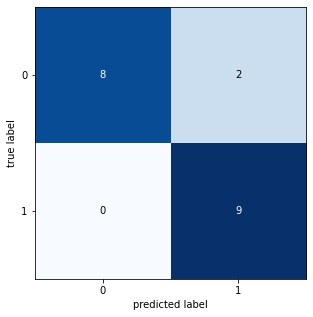

avg accuraccy Breast Cancer =  0.7842105263157895
avg F1_Score Breast Cancer =  0.7805413377472201
max accuraccy Breast Cancer =  0.8947368421052632
max F1_Score Breast Cancer =  0.8944444444444445
min accuraccy Breast Cancer =  0.7
min F1_Score Breast Cancer =  0.6875000000000001
Running Time:  38.11834229800115
gen terbaik : [0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0]
F-1 Score terbaik : 0.8039150907571961  || Akurasi terbaik : 0.8047368421052632  || jumlah fitur : 49

Running Time:  1974.2970232799998


In [13]:
Breast_IG_GA = GeneticAlgorithm(Breast_IG, 2)

Generation : 0
gene : [1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0]
Train : [ 0  1  2  3  4  5  6  8 12 13 14 15 16 18 19 20 21 22 23 24 25 26 27 29
 30 31 32 33 35 37 38 39 40 41 42 43 45 46 47 48 50 51 53 54 55 58 60 61
 63 64 65 67 68 69 70 71 72 73 75 76 77 78 79 80 81 82 85 86 87 88 89 90
 91 92 93 94 95] Test : [ 7  9 10 11 17 28 34 36 44 49 52 56 57 59 62 66 74 83 84 96]
Y_Train : [1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0]
Y_Test : [1 1 1 1 0 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0]
Akurasi :  0.65
F1_Score :  0.6491228070175439
              precision    recall  f1-score   support

           0       0.67      0.60      0.63

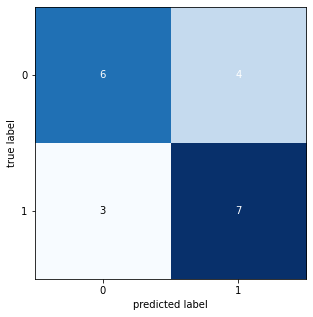

Train : [ 0  2  3  4  5  7  8  9 10 11 14 15 16 17 19 20 21 22 23 25 26 27 28 30
 31 34 35 36 37 38 39 42 43 44 45 46 47 48 49 51 52 53 54 55 56 57 58 59
 60 61 62 63 64 65 66 69 70 72 73 74 75 76 77 80 81 82 83 84 85 86 88 89
 90 91 92 95 96] Test : [ 1  6 12 13 18 24 29 32 33 40 41 50 67 68 71 78 79 87 93 94]
Y_Train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0]
Y_Test : [1 1 0 0 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Akurasi :  0.6
F1_Score :  0.595959595959596
              precision    recall  f1-score   support

           0       0.64      0.64      0.64        11
           1       0.56      0.56      0.56         9

    accuracy                           0.60        20
   macro avg       0.60      0.60      0.60        20
weighted avg       0.60      0.60      0.60        20



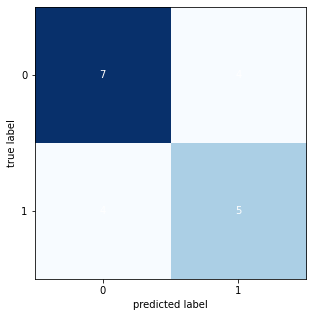

Train : [ 0  1  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 21 22 23 24 26
 28 29 32 33 34 35 36 38 40 41 42 43 44 45 46 48 49 50 51 52 53 54 55 56
 57 59 60 62 65 66 67 68 69 71 74 76 77 78 79 80 81 82 83 84 85 86 87 88
 90 91 92 93 94 96] Test : [ 2 20 25 27 30 31 37 39 47 58 61 63 64 70 72 73 75 89 95]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0]
Akurasi :  0.7894736842105263
F1_Score :  0.788888888888889
              precision    recall  f1-score   support

           0       0.80      0.80      0.80        10
           1       0.78      0.78      0.78         9

    accuracy                           0.79        19
   macro avg       0.79      0.79      0.79        19
weighted avg       0.79      0.79      0.79        19



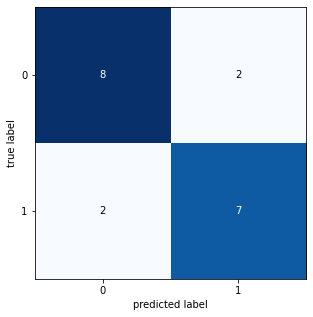

Train : [ 1  2  5  6  7  8  9 10 11 12 13 14 17 18 20 21 22 23 24 25 27 28 29 30
 31 32 33 34 35 36 37 39 40 41 42 43 44 45 47 49 50 52 53 56 57 58 59 61
 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 78 79 82 83 84 85 87 89 90
 91 92 93 94 95 96] Test : [ 0  3  4 15 16 19 26 38 46 48 51 54 55 60 77 80 81 86 88]
Y_Train : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 1 0 0 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Akurasi :  0.8421052631578947
F1_Score :  0.8403361344537814
              precision    recall  f1-score   support

           0       1.00      0.70      0.82        10
           1       0.75      1.00      0.86         9

    accuracy                           0.84        19
   macro avg       0.88      0.85      0.84        19
weighted avg       0.88      0.84      0.84        19



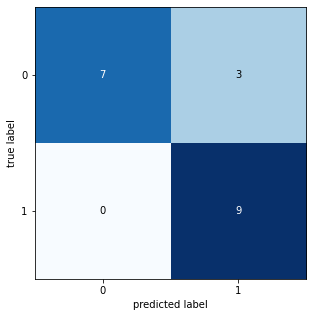

Train : [ 0  1  2  3  4  6  7  9 10 11 12 13 15 16 17 18 19 20 24 25 26 27 28 29
 30 31 32 33 34 36 37 38 39 40 41 44 46 47 48 49 50 51 52 54 55 56 57 58
 59 60 61 62 63 64 66 67 68 70 71 72 73 74 75 77 78 79 80 81 83 84 86 87
 88 89 93 94 95 96] Test : [ 5  8 14 21 22 23 35 42 43 45 53 65 69 76 82 85 90 91 92]
Y_Train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0]
Akurasi :  0.7368421052631579
F1_Score :  0.7338935574229692
              precision    recall  f1-score   support

           0       0.86      0.60      0.71        10
           1       0.67      0.89      0.76         9

    accuracy                           0.74        19
   macro avg       0.76      0.74      0.73        19
weighted avg       0.77      0.74      0.73        19



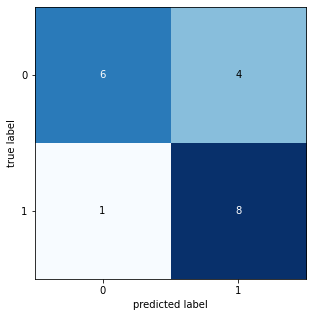

avg accuraccy Breast Cancer =  0.7236842105263158
avg F1_Score Breast Cancer =  0.721640196748556
max accuraccy Breast Cancer =  0.8421052631578947
max F1_Score Breast Cancer =  0.8403361344537814
min accuraccy Breast Cancer =  0.6
min F1_Score Breast Cancer =  0.595959595959596
Running Time:  39.72204904499995
gene : [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0]
Train : [ 0  1  2  3  4  5  6  8 12 13 14 15 16 18 19 20 21 22 23 24 25 26 27 29
 30 31 32 33 35 37 38 39 40 41 42 43 45 46 47 48 50 51 53 54 55 58 60 61
 63 64 65 67 68 69 70 71 72 73 75 76 77 78 79 80 81 82 85 86 87 88 89 90
 91 92 93 94 95] Test : [ 7  9 10 11 17 28 34 36 44 49 52 56 57 59 62 66 74 83 84 96]
Y_Train : [1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1

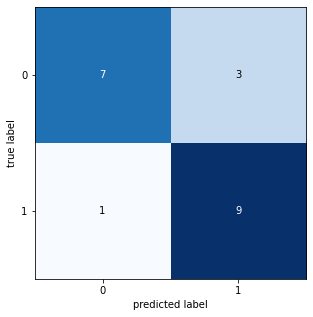

Train : [ 0  2  3  4  5  7  8  9 10 11 14 15 16 17 19 20 21 22 23 25 26 27 28 30
 31 34 35 36 37 38 39 42 43 44 45 46 47 48 49 51 52 53 54 55 56 57 58 59
 60 61 62 63 64 65 66 69 70 72 73 74 75 76 77 80 81 82 83 84 85 86 88 89
 90 91 92 95 96] Test : [ 1  6 12 13 18 24 29 32 33 40 41 50 67 68 71 78 79 87 93 94]
Y_Train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0]
Y_Test : [1 1 0 0 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Akurasi :  0.85
F1_Score :  0.849624060150376
              precision    recall  f1-score   support

           0       0.90      0.82      0.86        11
           1       0.80      0.89      0.84         9

    accuracy                           0.85        20
   macro avg       0.85      0.85      0.85        20
weighted avg       0.86      0.85      0.85        20



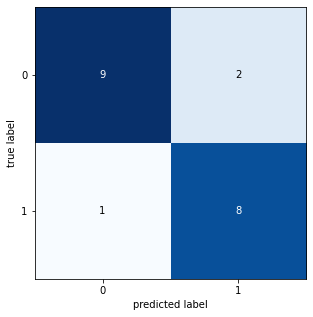

Train : [ 0  1  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 21 22 23 24 26
 28 29 32 33 34 35 36 38 40 41 42 43 44 45 46 48 49 50 51 52 53 54 55 56
 57 59 60 62 65 66 67 68 69 71 74 76 77 78 79 80 81 82 83 84 85 86 87 88
 90 91 92 93 94 96] Test : [ 2 20 25 27 30 31 37 39 47 58 61 63 64 70 72 73 75 89 95]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0]
Akurasi :  0.8421052631578947
F1_Score :  0.8403361344537816
              precision    recall  f1-score   support

           0       0.82      0.90      0.86        10
           1       0.88      0.78      0.82         9

    accuracy                           0.84        19
   macro avg       0.85      0.84      0.84        19
weighted avg       0.85      0.84      0.84        19



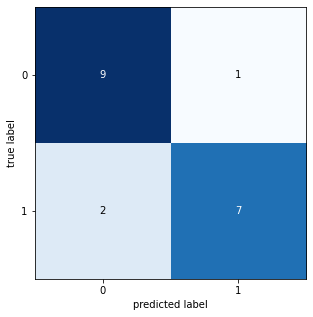

Train : [ 1  2  5  6  7  8  9 10 11 12 13 14 17 18 20 21 22 23 24 25 27 28 29 30
 31 32 33 34 35 36 37 39 40 41 42 43 44 45 47 49 50 52 53 56 57 58 59 61
 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 78 79 82 83 84 85 87 89 90
 91 92 93 94 95 96] Test : [ 0  3  4 15 16 19 26 38 46 48 51 54 55 60 77 80 81 86 88]
Y_Train : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 1 0 0 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Akurasi :  0.7368421052631579
F1_Score :  0.7338935574229692
              precision    recall  f1-score   support

           0       0.86      0.60      0.71        10
           1       0.67      0.89      0.76         9

    accuracy                           0.74        19
   macro avg       0.76      0.74      0.73        19
weighted avg       0.77      0.74      0.73        19



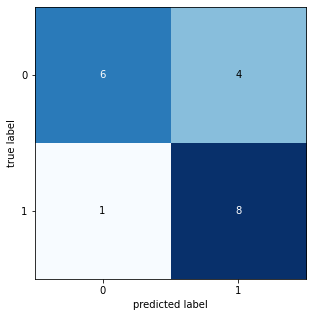

Train : [ 0  1  2  3  4  6  7  9 10 11 12 13 15 16 17 18 19 20 24 25 26 27 28 29
 30 31 32 33 34 36 37 38 39 40 41 44 46 47 48 49 50 51 52 54 55 56 57 58
 59 60 61 62 63 64 66 67 68 70 71 72 73 74 75 77 78 79 80 81 83 84 86 87
 88 89 93 94 95 96] Test : [ 5  8 14 21 22 23 35 42 43 45 53 65 69 76 82 85 90 91 92]
Y_Train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0]
Akurasi :  0.7368421052631579
F1_Score :  0.7368421052631577
              precision    recall  f1-score   support

           0       0.78      0.70      0.74        10
           1       0.70      0.78      0.74         9

    accuracy                           0.74        19
   macro avg       0.74      0.74      0.74        19
weighted avg       0.74      0.74      0.74        19



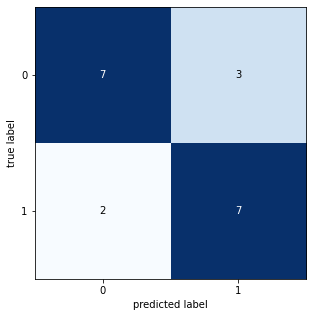

avg accuraccy Breast Cancer =  0.7931578947368421
avg F1_Score Breast Cancer =  0.7917351310540164
max accuraccy Breast Cancer =  0.85
max F1_Score Breast Cancer =  0.849624060150376
min accuraccy Breast Cancer =  0.7368421052631579
min F1_Score Breast Cancer =  0.7338935574229692
Running Time:  40.33873782599949
gene : [0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1]
Train : [ 0  1  2  3  4  5  6  8 12 13 14 15 16 18 19 20 21 22 23 24 25 26 27 29
 30 31 32 33 35 37 38 39 40 41 42 43 45 46 47 48 50 51 53 54 55 58 60 61
 63 64 65 67 68 69 70 71 72 73 75 76 77 78 79 80 81 82 85 86 87 88 89 90
 91 92 93 94 95] Test : [ 7  9 10 11 17 28 34 36 44 49 52 56 57 59 62 66 74 83 84 96]
Y_Train : [1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1

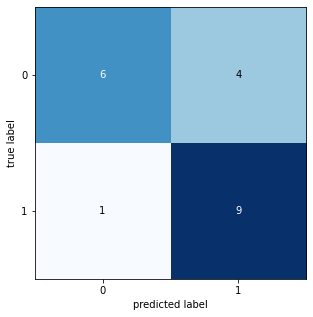

Train : [ 0  2  3  4  5  7  8  9 10 11 14 15 16 17 19 20 21 22 23 25 26 27 28 30
 31 34 35 36 37 38 39 42 43 44 45 46 47 48 49 51 52 53 54 55 56 57 58 59
 60 61 62 63 64 65 66 69 70 72 73 74 75 76 77 80 81 82 83 84 85 86 88 89
 90 91 92 95 96] Test : [ 1  6 12 13 18 24 29 32 33 40 41 50 67 68 71 78 79 87 93 94]
Y_Train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0]
Y_Test : [1 1 0 0 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Akurasi :  0.65
F1_Score :  0.6266666666666667
              precision    recall  f1-score   support

           0       0.64      0.82      0.72        11
           1       0.67      0.44      0.53         9

    accuracy                           0.65        20
   macro avg       0.65      0.63      0.63        20
weighted avg       0.65      0.65      0.64        20



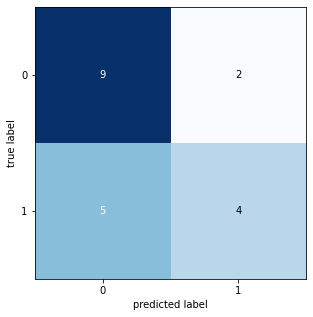

Train : [ 0  1  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 21 22 23 24 26
 28 29 32 33 34 35 36 38 40 41 42 43 44 45 46 48 49 50 51 52 53 54 55 56
 57 59 60 62 65 66 67 68 69 71 74 76 77 78 79 80 81 82 83 84 85 86 87 88
 90 91 92 93 94 96] Test : [ 2 20 25 27 30 31 37 39 47 58 61 63 64 70 72 73 75 89 95]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0]
Akurasi :  0.6842105263157895
F1_Score :  0.6833333333333333
              precision    recall  f1-score   support

           0       0.70      0.70      0.70        10
           1       0.67      0.67      0.67         9

    accuracy                           0.68        19
   macro avg       0.68      0.68      0.68        19
weighted avg       0.68      0.68      0.68        19



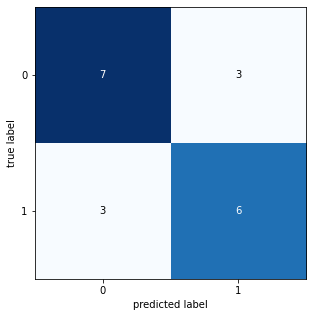

Train : [ 1  2  5  6  7  8  9 10 11 12 13 14 17 18 20 21 22 23 24 25 27 28 29 30
 31 32 33 34 35 36 37 39 40 41 42 43 44 45 47 49 50 52 53 56 57 58 59 61
 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 78 79 82 83 84 85 87 89 90
 91 92 93 94 95 96] Test : [ 0  3  4 15 16 19 26 38 46 48 51 54 55 60 77 80 81 86 88]
Y_Train : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 1 0 0 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Akurasi :  0.7894736842105263
F1_Score :  0.7888888888888888
              precision    recall  f1-score   support

           0       0.88      0.70      0.78        10
           1       0.73      0.89      0.80         9

    accuracy                           0.79        19
   macro avg       0.80      0.79      0.79        19
weighted avg       0.81      0.79      0.79        19



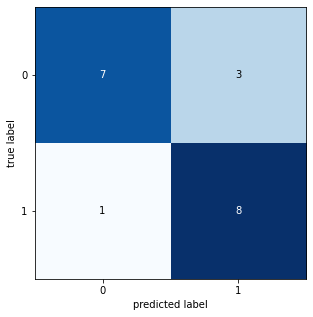

Train : [ 0  1  2  3  4  6  7  9 10 11 12 13 15 16 17 18 19 20 24 25 26 27 28 29
 30 31 32 33 34 36 37 38 39 40 41 44 46 47 48 49 50 51 52 54 55 56 57 58
 59 60 61 62 63 64 66 67 68 70 71 72 73 74 75 77 78 79 80 81 83 84 86 87
 88 89 93 94 95 96] Test : [ 5  8 14 21 22 23 35 42 43 45 53 65 69 76 82 85 90 91 92]
Y_Train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0]
Akurasi :  0.7894736842105263
F1_Score :  0.7888888888888888
              precision    recall  f1-score   support

           0       0.88      0.70      0.78        10
           1       0.73      0.89      0.80         9

    accuracy                           0.79        19
   macro avg       0.80      0.79      0.79        19
weighted avg       0.81      0.79      0.79        19



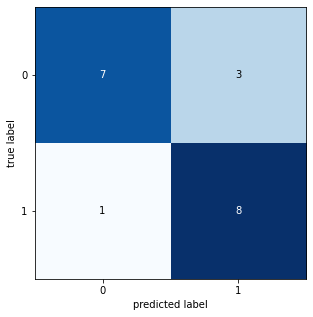

avg accuraccy Breast Cancer =  0.7326315789473684
avg F1_Score Breast Cancer =  0.7264046604148906
max accuraccy Breast Cancer =  0.7894736842105263
max F1_Score Breast Cancer =  0.7888888888888888
min accuraccy Breast Cancer =  0.65
min F1_Score Breast Cancer =  0.6266666666666667
Running Time:  39.2110787720012
gene : [0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0]
Train : [ 0  1  2  3  4  5  6  8 12 13 14 15 16 18 19 20 21 22 23 24 25 26 27 29
 30 31 32 33 35 37 38 39 40 41 42 43 45 46 47 48 50 51 53 54 55 58 60 61
 63 64 65 67 68 69 70 71 72 73 75 76 77 78 79 80 81 82 85 86 87 88 89 90
 91 92 93 94 95] Test : [ 7  9 10 11 17 28 34 36 44 49 52 56 57 59 62 66 74 83 84 96]
Y_Train : [1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1

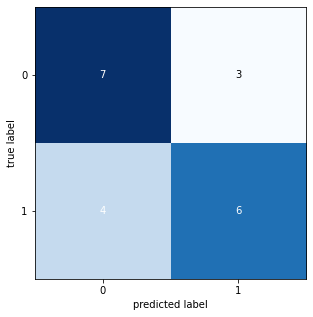

Train : [ 0  2  3  4  5  7  8  9 10 11 14 15 16 17 19 20 21 22 23 25 26 27 28 30
 31 34 35 36 37 38 39 42 43 44 45 46 47 48 49 51 52 53 54 55 56 57 58 59
 60 61 62 63 64 65 66 69 70 72 73 74 75 76 77 80 81 82 83 84 85 86 88 89
 90 91 92 95 96] Test : [ 1  6 12 13 18 24 29 32 33 40 41 50 67 68 71 78 79 87 93 94]
Y_Train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0]
Y_Test : [1 1 0 0 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Akurasi :  0.45
F1_Score :  0.4486215538847118
              precision    recall  f1-score   support

           0       0.50      0.36      0.42        11
           1       0.42      0.56      0.48         9

    accuracy                           0.45        20
   macro avg       0.46      0.46      0.45        20
weighted avg       0.46      0.45      0.45        20



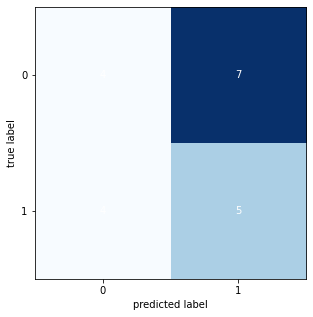

Train : [ 0  1  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 21 22 23 24 26
 28 29 32 33 34 35 36 38 40 41 42 43 44 45 46 48 49 50 51 52 53 54 55 56
 57 59 60 62 65 66 67 68 69 71 74 76 77 78 79 80 81 82 83 84 85 86 87 88
 90 91 92 93 94 96] Test : [ 2 20 25 27 30 31 37 39 47 58 61 63 64 70 72 73 75 89 95]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0]
Akurasi :  0.7368421052631579
F1_Score :  0.7368421052631577
              precision    recall  f1-score   support

           0       0.78      0.70      0.74        10
           1       0.70      0.78      0.74         9

    accuracy                           0.74        19
   macro avg       0.74      0.74      0.74        19
weighted avg       0.74      0.74      0.74        19



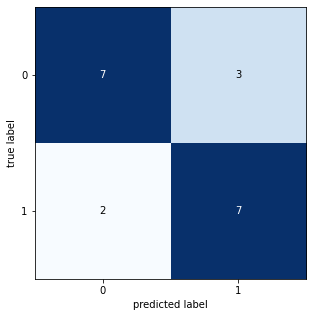

Train : [ 1  2  5  6  7  8  9 10 11 12 13 14 17 18 20 21 22 23 24 25 27 28 29 30
 31 32 33 34 35 36 37 39 40 41 42 43 44 45 47 49 50 52 53 56 57 58 59 61
 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 78 79 82 83 84 85 87 89 90
 91 92 93 94 95 96] Test : [ 0  3  4 15 16 19 26 38 46 48 51 54 55 60 77 80 81 86 88]
Y_Train : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 1 0 0 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Akurasi :  0.7368421052631579
F1_Score :  0.7338935574229692
              precision    recall  f1-score   support

           0       0.86      0.60      0.71        10
           1       0.67      0.89      0.76         9

    accuracy                           0.74        19
   macro avg       0.76      0.74      0.73        19
weighted avg       0.77      0.74      0.73        19



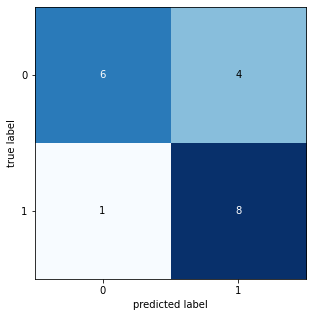

Train : [ 0  1  2  3  4  6  7  9 10 11 12 13 15 16 17 18 19 20 24 25 26 27 28 29
 30 31 32 33 34 36 37 38 39 40 41 44 46 47 48 49 50 51 52 54 55 56 57 58
 59 60 61 62 63 64 66 67 68 70 71 72 73 74 75 77 78 79 80 81 83 84 86 87
 88 89 93 94 95 96] Test : [ 5  8 14 21 22 23 35 42 43 45 53 65 69 76 82 85 90 91 92]
Y_Train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0]
Akurasi :  0.7368421052631579
F1_Score :  0.7338935574229692
              precision    recall  f1-score   support

           0       0.86      0.60      0.71        10
           1       0.67      0.89      0.76         9

    accuracy                           0.74        19
   macro avg       0.76      0.74      0.73        19
weighted avg       0.77      0.74      0.73        19



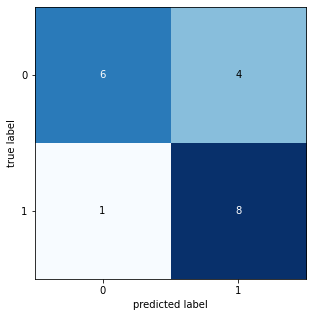

avg accuraccy Breast Cancer =  0.6621052631578948
avg F1_Score Breast Cancer =  0.6604747162022704
max accuraccy Breast Cancer =  0.7368421052631579
max F1_Score Breast Cancer =  0.7368421052631577
min accuraccy Breast Cancer =  0.45
min F1_Score Breast Cancer =  0.4486215538847118
Running Time:  38.68023729400011
gene : [0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0]
Train : [ 0  1  2  3  4  5  6  8 12 13 14 15 16 18 19 20 21 22 23 24 25 26 27 29
 30 31 32 33 35 37 38 39 40 41 42 43 45 46 47 48 50 51 53 54 55 58 60 61
 63 64 65 67 68 69 70 71 72 73 75 76 77 78 79 80 81 82 85 86 87 88 89 90
 91 92 93 94 95] Test : [ 7  9 10 11 17 28 34 36 44 49 52 56 57 59 62 66 74 83 84 96]
Y_Train : [1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 

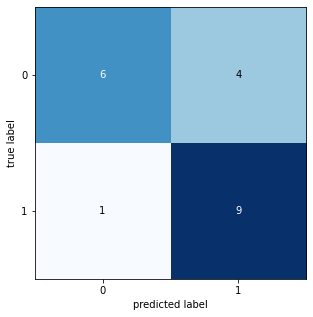

Train : [ 0  2  3  4  5  7  8  9 10 11 14 15 16 17 19 20 21 22 23 25 26 27 28 30
 31 34 35 36 37 38 39 42 43 44 45 46 47 48 49 51 52 53 54 55 56 57 58 59
 60 61 62 63 64 65 66 69 70 72 73 74 75 76 77 80 81 82 83 84 85 86 88 89
 90 91 92 95 96] Test : [ 1  6 12 13 18 24 29 32 33 40 41 50 67 68 71 78 79 87 93 94]
Y_Train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0]
Y_Test : [1 1 0 0 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Akurasi :  0.75
F1_Score :  0.7493734335839599
              precision    recall  f1-score   support

           0       0.80      0.73      0.76        11
           1       0.70      0.78      0.74         9

    accuracy                           0.75        20
   macro avg       0.75      0.75      0.75        20
weighted avg       0.76      0.75      0.75        20



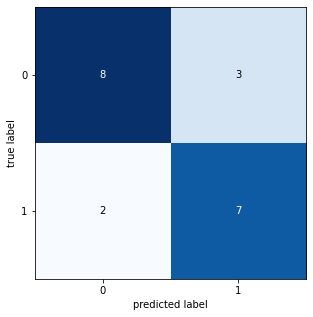

Train : [ 0  1  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 21 22 23 24 26
 28 29 32 33 34 35 36 38 40 41 42 43 44 45 46 48 49 50 51 52 53 54 55 56
 57 59 60 62 65 66 67 68 69 71 74 76 77 78 79 80 81 82 83 84 85 86 87 88
 90 91 92 93 94 96] Test : [ 2 20 25 27 30 31 37 39 47 58 61 63 64 70 72 73 75 89 95]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0]
Akurasi :  0.7894736842105263
F1_Score :  0.7840909090909092
              precision    recall  f1-score   support

           0       0.75      0.90      0.82        10
           1       0.86      0.67      0.75         9

    accuracy                           0.79        19
   macro avg       0.80      0.78      0.78        19
weighted avg       0.80      0.79      0.79        19



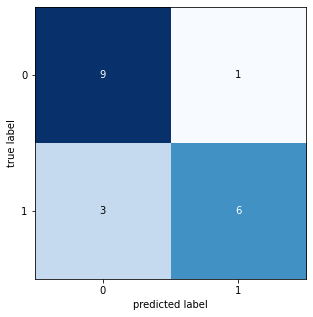

Train : [ 1  2  5  6  7  8  9 10 11 12 13 14 17 18 20 21 22 23 24 25 27 28 29 30
 31 32 33 34 35 36 37 39 40 41 42 43 44 45 47 49 50 52 53 56 57 58 59 61
 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 78 79 82 83 84 85 87 89 90
 91 92 93 94 95 96] Test : [ 0  3  4 15 16 19 26 38 46 48 51 54 55 60 77 80 81 86 88]
Y_Train : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 1 0 0 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Akurasi :  0.7894736842105263
F1_Score :  0.7888888888888888
              precision    recall  f1-score   support

           0       0.88      0.70      0.78        10
           1       0.73      0.89      0.80         9

    accuracy                           0.79        19
   macro avg       0.80      0.79      0.79        19
weighted avg       0.81      0.79      0.79        19



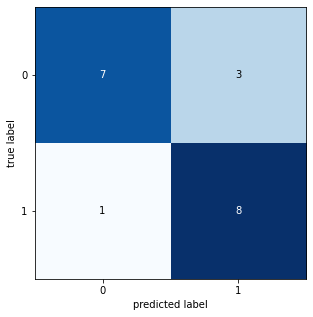

Train : [ 0  1  2  3  4  6  7  9 10 11 12 13 15 16 17 18 19 20 24 25 26 27 28 29
 30 31 32 33 34 36 37 38 39 40 41 44 46 47 48 49 50 51 52 54 55 56 57 58
 59 60 61 62 63 64 66 67 68 70 71 72 73 74 75 77 78 79 80 81 83 84 86 87
 88 89 93 94 95 96] Test : [ 5  8 14 21 22 23 35 42 43 45 53 65 69 76 82 85 90 91 92]
Y_Train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0]
Akurasi :  0.7368421052631579
F1_Score :  0.7338935574229692
              precision    recall  f1-score   support

           0       0.86      0.60      0.71        10
           1       0.67      0.89      0.76         9

    accuracy                           0.74        19
   macro avg       0.76      0.74      0.73        19
weighted avg       0.77      0.74      0.73        19



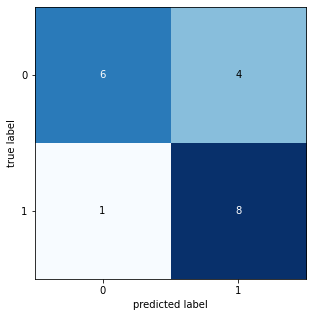

avg accuraccy Breast Cancer =  0.7631578947368423
avg F1_Score Breast Cancer =  0.7600984626566805
max accuraccy Breast Cancer =  0.7894736842105263
max F1_Score Breast Cancer =  0.7888888888888888
min accuraccy Breast Cancer =  0.7368421052631579
min F1_Score Breast Cancer =  0.7338935574229692
Running Time:  41.464335902999665
gene : [1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1]
Train : [ 0  1  2  3  4  5  6  8 12 13 14 15 16 18 19 20 21 22 23 24 25 26 27 29
 30 31 32 33 35 37 38 39 40 41 42 43 45 46 47 48 50 51 53 54 55 58 60 61
 63 64 65 67 68 69 70 71 72 73 75 76 77 78 79 80 81 82 85 86 87 88 89 90
 91 92 93 94 95] Test : [ 7  9 10 11 17 28 34 36 44 49 52 56 57 59 62 66 74 83 84 96]
Y_Train : [1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1

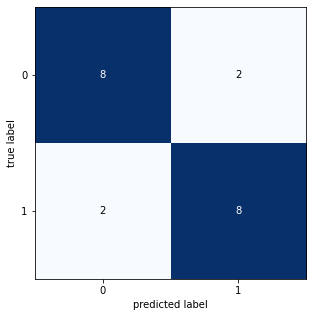

Train : [ 0  2  3  4  5  7  8  9 10 11 14 15 16 17 19 20 21 22 23 25 26 27 28 30
 31 34 35 36 37 38 39 42 43 44 45 46 47 48 49 51 52 53 54 55 56 57 58 59
 60 61 62 63 64 65 66 69 70 72 73 74 75 76 77 80 81 82 83 84 85 86 88 89
 90 91 92 95 96] Test : [ 1  6 12 13 18 24 29 32 33 40 41 50 67 68 71 78 79 87 93 94]
Y_Train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0]
Y_Test : [1 1 0 0 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Akurasi :  0.75
F1_Score :  0.7442455242966752
              precision    recall  f1-score   support

           0       1.00      0.55      0.71        11
           1       0.64      1.00      0.78         9

    accuracy                           0.75        20
   macro avg       0.82      0.77      0.74        20
weighted avg       0.84      0.75      0.74        20



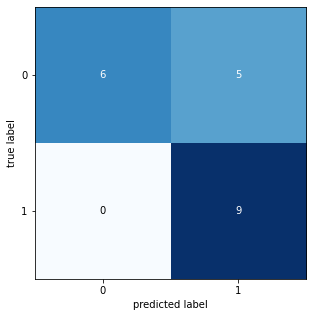

Train : [ 0  1  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 21 22 23 24 26
 28 29 32 33 34 35 36 38 40 41 42 43 44 45 46 48 49 50 51 52 53 54 55 56
 57 59 60 62 65 66 67 68 69 71 74 76 77 78 79 80 81 82 83 84 85 86 87 88
 90 91 92 93 94 96] Test : [ 2 20 25 27 30 31 37 39 47 58 61 63 64 70 72 73 75 89 95]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0]
Akurasi :  0.7368421052631579
F1_Score :  0.7368421052631577
              precision    recall  f1-score   support

           0       0.78      0.70      0.74        10
           1       0.70      0.78      0.74         9

    accuracy                           0.74        19
   macro avg       0.74      0.74      0.74        19
weighted avg       0.74      0.74      0.74        19



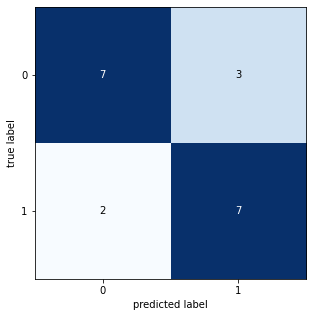

Train : [ 1  2  5  6  7  8  9 10 11 12 13 14 17 18 20 21 22 23 24 25 27 28 29 30
 31 32 33 34 35 36 37 39 40 41 42 43 44 45 47 49 50 52 53 56 57 58 59 61
 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 78 79 82 83 84 85 87 89 90
 91 92 93 94 95 96] Test : [ 0  3  4 15 16 19 26 38 46 48 51 54 55 60 77 80 81 86 88]
Y_Train : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 1 0 0 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Akurasi :  0.7894736842105263
F1_Score :  0.7888888888888888
              precision    recall  f1-score   support

           0       0.88      0.70      0.78        10
           1       0.73      0.89      0.80         9

    accuracy                           0.79        19
   macro avg       0.80      0.79      0.79        19
weighted avg       0.81      0.79      0.79        19



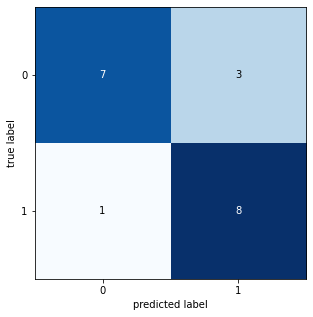

Train : [ 0  1  2  3  4  6  7  9 10 11 12 13 15 16 17 18 19 20 24 25 26 27 28 29
 30 31 32 33 34 36 37 38 39 40 41 44 46 47 48 49 50 51 52 54 55 56 57 58
 59 60 61 62 63 64 66 67 68 70 71 72 73 74 75 77 78 79 80 81 83 84 86 87
 88 89 93 94 95 96] Test : [ 5  8 14 21 22 23 35 42 43 45 53 65 69 76 82 85 90 91 92]
Y_Train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0]
Akurasi :  0.8421052631578947
F1_Score :  0.8421052631578948
              precision    recall  f1-score   support

           0       0.89      0.80      0.84        10
           1       0.80      0.89      0.84         9

    accuracy                           0.84        19
   macro avg       0.84      0.84      0.84        19
weighted avg       0.85      0.84      0.84        19



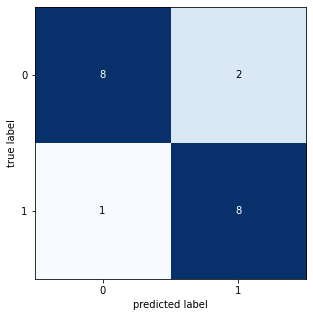

avg accuraccy Breast Cancer =  0.7836842105263158
avg F1_Score Breast Cancer =  0.7824163563213233
max accuraccy Breast Cancer =  0.8421052631578947
max F1_Score Breast Cancer =  0.8421052631578948
min accuraccy Breast Cancer =  0.7368421052631579
min F1_Score Breast Cancer =  0.7368421052631577
Running Time:  38.307918581000195
gene : [1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1]
Train : [ 0  1  2  3  4  5  6  8 12 13 14 15 16 18 19 20 21 22 23 24 25 26 27 29
 30 31 32 33 35 37 38 39 40 41 42 43 45 46 47 48 50 51 53 54 55 58 60 61
 63 64 65 67 68 69 70 71 72 73 75 76 77 78 79 80 81 82 85 86 87 88 89 90
 91 92 93 94 95] Test : [ 7  9 10 11 17 28 34 36 44 49 52 56 57 59 62 66 74 83 84 96]
Y_Train : [1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1

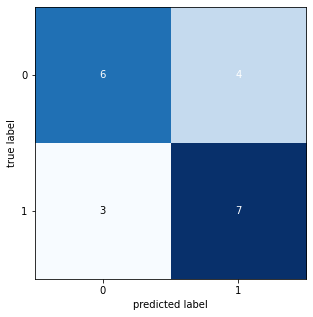

Train : [ 0  2  3  4  5  7  8  9 10 11 14 15 16 17 19 20 21 22 23 25 26 27 28 30
 31 34 35 36 37 38 39 42 43 44 45 46 47 48 49 51 52 53 54 55 56 57 58 59
 60 61 62 63 64 65 66 69 70 72 73 74 75 76 77 80 81 82 83 84 85 86 88 89
 90 91 92 95 96] Test : [ 1  6 12 13 18 24 29 32 33 40 41 50 67 68 71 78 79 87 93 94]
Y_Train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0]
Y_Test : [1 1 0 0 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Akurasi :  0.7
F1_Score :  0.696969696969697
              precision    recall  f1-score   support

           0       0.73      0.73      0.73        11
           1       0.67      0.67      0.67         9

    accuracy                           0.70        20
   macro avg       0.70      0.70      0.70        20
weighted avg       0.70      0.70      0.70        20



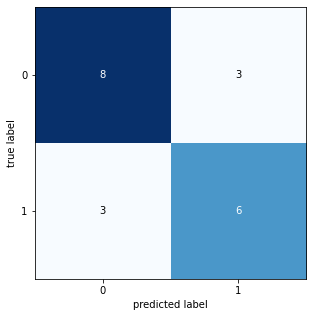

Train : [ 0  1  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 21 22 23 24 26
 28 29 32 33 34 35 36 38 40 41 42 43 44 45 46 48 49 50 51 52 53 54 55 56
 57 59 60 62 65 66 67 68 69 71 74 76 77 78 79 80 81 82 83 84 85 86 87 88
 90 91 92 93 94 96] Test : [ 2 20 25 27 30 31 37 39 47 58 61 63 64 70 72 73 75 89 95]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0]
Akurasi :  0.7894736842105263
F1_Score :  0.7840909090909092
              precision    recall  f1-score   support

           0       0.75      0.90      0.82        10
           1       0.86      0.67      0.75         9

    accuracy                           0.79        19
   macro avg       0.80      0.78      0.78        19
weighted avg       0.80      0.79      0.79        19



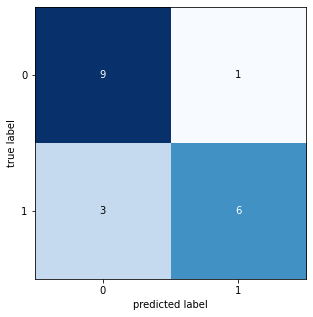

Train : [ 1  2  5  6  7  8  9 10 11 12 13 14 17 18 20 21 22 23 24 25 27 28 29 30
 31 32 33 34 35 36 37 39 40 41 42 43 44 45 47 49 50 52 53 56 57 58 59 61
 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 78 79 82 83 84 85 87 89 90
 91 92 93 94 95 96] Test : [ 0  3  4 15 16 19 26 38 46 48 51 54 55 60 77 80 81 86 88]
Y_Train : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 1 0 0 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Akurasi :  0.7368421052631579
F1_Score :  0.7338935574229692
              precision    recall  f1-score   support

           0       0.86      0.60      0.71        10
           1       0.67      0.89      0.76         9

    accuracy                           0.74        19
   macro avg       0.76      0.74      0.73        19
weighted avg       0.77      0.74      0.73        19



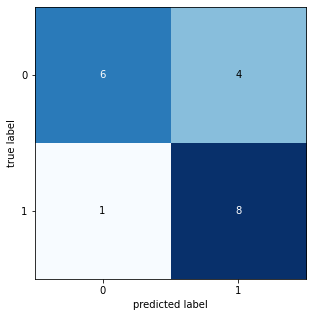

Train : [ 0  1  2  3  4  6  7  9 10 11 12 13 15 16 17 18 19 20 24 25 26 27 28 29
 30 31 32 33 34 36 37 38 39 40 41 44 46 47 48 49 50 51 52 54 55 56 57 58
 59 60 61 62 63 64 66 67 68 70 71 72 73 74 75 77 78 79 80 81 83 84 86 87
 88 89 93 94 95 96] Test : [ 5  8 14 21 22 23 35 42 43 45 53 65 69 76 82 85 90 91 92]
Y_Train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0]
Akurasi :  0.7894736842105263
F1_Score :  0.788888888888889
              precision    recall  f1-score   support

           0       0.80      0.80      0.80        10
           1       0.78      0.78      0.78         9

    accuracy                           0.79        19
   macro avg       0.79      0.79      0.79        19
weighted avg       0.79      0.79      0.79        19



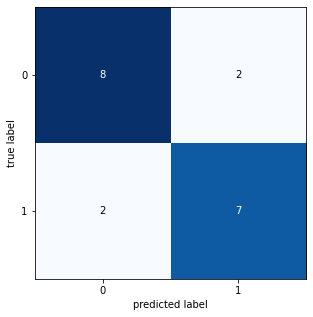

avg accuraccy Breast Cancer =  0.733157894736842
avg F1_Score Breast Cancer =  0.7305931718780017
max accuraccy Breast Cancer =  0.7894736842105263
max F1_Score Breast Cancer =  0.788888888888889
min accuraccy Breast Cancer =  0.65
min F1_Score Breast Cancer =  0.6491228070175439
Running Time:  38.36568034499942
gene : [1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0]
Train : [ 0  1  2  3  4  5  6  8 12 13 14 15 16 18 19 20 21 22 23 24 25 26 27 29
 30 31 32 33 35 37 38 39 40 41 42 43 45 46 47 48 50 51 53 54 55 58 60 61
 63 64 65 67 68 69 70 71 72 73 75 76 77 78 79 80 81 82 85 86 87 88 89 90
 91 92 93 94 95] Test : [ 7  9 10 11 17 28 34 36 44 49 52 56 57 59 62 66 74 83 84 96]
Y_Train : [1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 

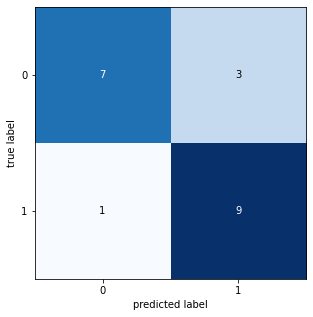

Train : [ 0  2  3  4  5  7  8  9 10 11 14 15 16 17 19 20 21 22 23 25 26 27 28 30
 31 34 35 36 37 38 39 42 43 44 45 46 47 48 49 51 52 53 54 55 56 57 58 59
 60 61 62 63 64 65 66 69 70 72 73 74 75 76 77 80 81 82 83 84 85 86 88 89
 90 91 92 95 96] Test : [ 1  6 12 13 18 24 29 32 33 40 41 50 67 68 71 78 79 87 93 94]
Y_Train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0]
Y_Test : [1 1 0 0 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Akurasi :  0.7
F1_Score :  0.7000000000000001
              precision    recall  f1-score   support

           0       0.78      0.64      0.70        11
           1       0.64      0.78      0.70         9

    accuracy                           0.70        20
   macro avg       0.71      0.71      0.70        20
weighted avg       0.71      0.70      0.70        20



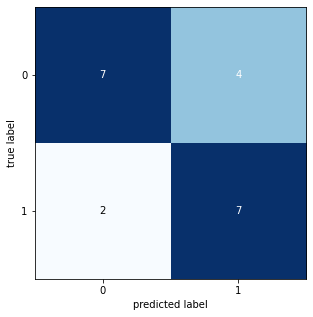

Train : [ 0  1  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 21 22 23 24 26
 28 29 32 33 34 35 36 38 40 41 42 43 44 45 46 48 49 50 51 52 53 54 55 56
 57 59 60 62 65 66 67 68 69 71 74 76 77 78 79 80 81 82 83 84 85 86 87 88
 90 91 92 93 94 96] Test : [ 2 20 25 27 30 31 37 39 47 58 61 63 64 70 72 73 75 89 95]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0]
Akurasi :  0.7894736842105263
F1_Score :  0.788888888888889
              precision    recall  f1-score   support

           0       0.80      0.80      0.80        10
           1       0.78      0.78      0.78         9

    accuracy                           0.79        19
   macro avg       0.79      0.79      0.79        19
weighted avg       0.79      0.79      0.79        19



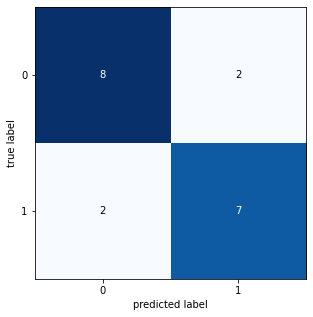

Train : [ 1  2  5  6  7  8  9 10 11 12 13 14 17 18 20 21 22 23 24 25 27 28 29 30
 31 32 33 34 35 36 37 39 40 41 42 43 44 45 47 49 50 52 53 56 57 58 59 61
 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 78 79 82 83 84 85 87 89 90
 91 92 93 94 95 96] Test : [ 0  3  4 15 16 19 26 38 46 48 51 54 55 60 77 80 81 86 88]
Y_Train : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 1 0 0 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Akurasi :  0.8421052631578947
F1_Score :  0.8421052631578948
              precision    recall  f1-score   support

           0       0.89      0.80      0.84        10
           1       0.80      0.89      0.84         9

    accuracy                           0.84        19
   macro avg       0.84      0.84      0.84        19
weighted avg       0.85      0.84      0.84        19



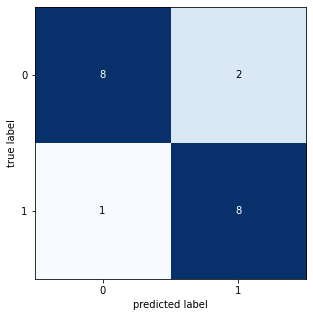

Train : [ 0  1  2  3  4  6  7  9 10 11 12 13 15 16 17 18 19 20 24 25 26 27 28 29
 30 31 32 33 34 36 37 38 39 40 41 44 46 47 48 49 50 51 52 54 55 56 57 58
 59 60 61 62 63 64 66 67 68 70 71 72 73 74 75 77 78 79 80 81 83 84 86 87
 88 89 93 94 95 96] Test : [ 5  8 14 21 22 23 35 42 43 45 53 65 69 76 82 85 90 91 92]
Y_Train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0]
Akurasi :  0.8421052631578947
F1_Score :  0.8403361344537816
              precision    recall  f1-score   support

           0       0.82      0.90      0.86        10
           1       0.88      0.78      0.82         9

    accuracy                           0.84        19
   macro avg       0.85      0.84      0.84        19
weighted avg       0.85      0.84      0.84        19



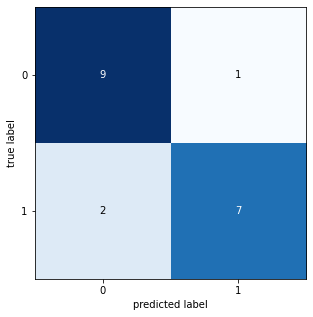

avg accuraccy Breast Cancer =  0.7947368421052632
avg F1_Score Breast Cancer =  0.7938620168960727
max accuraccy Breast Cancer =  0.8421052631578947
max F1_Score Breast Cancer =  0.8421052631578948
min accuraccy Breast Cancer =  0.7
min F1_Score Breast Cancer =  0.7000000000000001
Running Time:  39.905918694999855
gene : [1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1]
Train : [ 0  1  2  3  4  5  6  8 12 13 14 15 16 18 19 20 21 22 23 24 25 26 27 29
 30 31 32 33 35 37 38 39 40 41 42 43 45 46 47 48 50 51 53 54 55 58 60 61
 63 64 65 67 68 69 70 71 72 73 75 76 77 78 79 80 81 82 85 86 87 88 89 90
 91 92 93 94 95] Test : [ 7  9 10 11 17 28 34 36 44 49 52 56 57 59 62 66 74 83 84 96]
Y_Train : [1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 

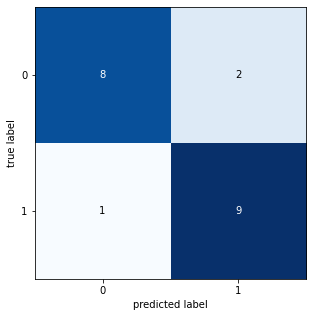

Train : [ 0  2  3  4  5  7  8  9 10 11 14 15 16 17 19 20 21 22 23 25 26 27 28 30
 31 34 35 36 37 38 39 42 43 44 45 46 47 48 49 51 52 53 54 55 56 57 58 59
 60 61 62 63 64 65 66 69 70 72 73 74 75 76 77 80 81 82 83 84 85 86 88 89
 90 91 92 95 96] Test : [ 1  6 12 13 18 24 29 32 33 40 41 50 67 68 71 78 79 87 93 94]
Y_Train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0]
Y_Test : [1 1 0 0 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Akurasi :  0.7
F1_Score :  0.696969696969697
              precision    recall  f1-score   support

           0       0.73      0.73      0.73        11
           1       0.67      0.67      0.67         9

    accuracy                           0.70        20
   macro avg       0.70      0.70      0.70        20
weighted avg       0.70      0.70      0.70        20



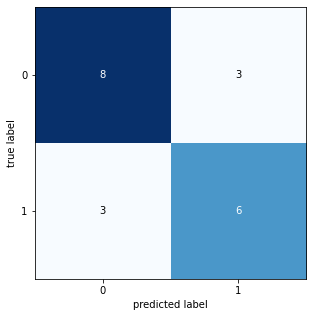

Train : [ 0  1  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 21 22 23 24 26
 28 29 32 33 34 35 36 38 40 41 42 43 44 45 46 48 49 50 51 52 53 54 55 56
 57 59 60 62 65 66 67 68 69 71 74 76 77 78 79 80 81 82 83 84 85 86 87 88
 90 91 92 93 94 96] Test : [ 2 20 25 27 30 31 37 39 47 58 61 63 64 70 72 73 75 89 95]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0]
Akurasi :  0.7894736842105263
F1_Score :  0.788888888888889
              precision    recall  f1-score   support

           0       0.80      0.80      0.80        10
           1       0.78      0.78      0.78         9

    accuracy                           0.79        19
   macro avg       0.79      0.79      0.79        19
weighted avg       0.79      0.79      0.79        19



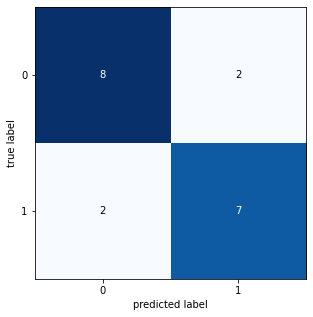

Train : [ 1  2  5  6  7  8  9 10 11 12 13 14 17 18 20 21 22 23 24 25 27 28 29 30
 31 32 33 34 35 36 37 39 40 41 42 43 44 45 47 49 50 52 53 56 57 58 59 61
 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 78 79 82 83 84 85 87 89 90
 91 92 93 94 95 96] Test : [ 0  3  4 15 16 19 26 38 46 48 51 54 55 60 77 80 81 86 88]
Y_Train : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 1 0 0 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Akurasi :  0.7368421052631579
F1_Score :  0.7246376811594203
              precision    recall  f1-score   support

           0       1.00      0.50      0.67        10
           1       0.64      1.00      0.78         9

    accuracy                           0.74        19
   macro avg       0.82      0.75      0.72        19
weighted avg       0.83      0.74      0.72        19



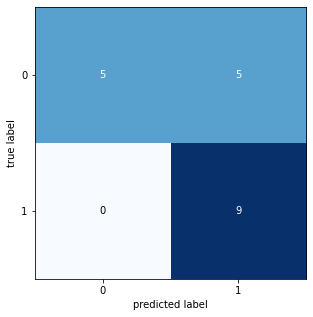

Train : [ 0  1  2  3  4  6  7  9 10 11 12 13 15 16 17 18 19 20 24 25 26 27 28 29
 30 31 32 33 34 36 37 38 39 40 41 44 46 47 48 49 50 51 52 54 55 56 57 58
 59 60 61 62 63 64 66 67 68 70 71 72 73 74 75 77 78 79 80 81 83 84 86 87
 88 89 93 94 95 96] Test : [ 5  8 14 21 22 23 35 42 43 45 53 65 69 76 82 85 90 91 92]
Y_Train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0]
Akurasi :  0.8421052631578947
F1_Score :  0.8421052631578948
              precision    recall  f1-score   support

           0       0.89      0.80      0.84        10
           1       0.80      0.89      0.84         9

    accuracy                           0.84        19
   macro avg       0.84      0.84      0.84        19
weighted avg       0.85      0.84      0.84        19



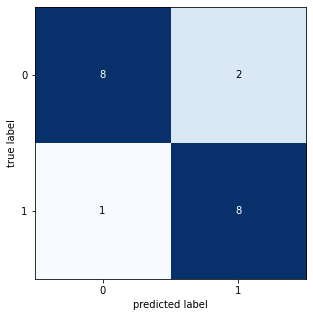

avg accuraccy Breast Cancer =  0.7836842105263158
avg F1_Score Breast Cancer =  0.7804451180652554
max accuraccy Breast Cancer =  0.85
max F1_Score Breast Cancer =  0.849624060150376
min accuraccy Breast Cancer =  0.7
min F1_Score Breast Cancer =  0.696969696969697
Running Time:  40.57094254799995
gene : [0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1]
Train : [ 0  1  2  3  4  5  6  8 12 13 14 15 16 18 19 20 21 22 23 24 25 26 27 29
 30 31 32 33 35 37 38 39 40 41 42 43 45 46 47 48 50 51 53 54 55 58 60 61
 63 64 65 67 68 69 70 71 72 73 75 76 77 78 79 80 81 82 85 86 87 88 89 90
 91 92 93 94 95] Test : [ 7  9 10 11 17 28 34 36 44 49 52 56 57 59 62 66 74 83 84 96]
Y_Train : [1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1

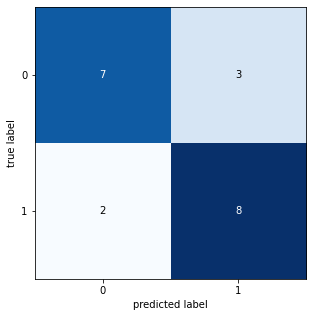

Train : [ 0  2  3  4  5  7  8  9 10 11 14 15 16 17 19 20 21 22 23 25 26 27 28 30
 31 34 35 36 37 38 39 42 43 44 45 46 47 48 49 51 52 53 54 55 56 57 58 59
 60 61 62 63 64 65 66 69 70 72 73 74 75 76 77 80 81 82 83 84 85 86 88 89
 90 91 92 95 96] Test : [ 1  6 12 13 18 24 29 32 33 40 41 50 67 68 71 78 79 87 93 94]
Y_Train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0]
Y_Test : [1 1 0 0 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Akurasi :  0.75
F1_Score :  0.7442455242966752
              precision    recall  f1-score   support

           0       0.75      0.82      0.78        11
           1       0.75      0.67      0.71         9

    accuracy                           0.75        20
   macro avg       0.75      0.74      0.74        20
weighted avg       0.75      0.75      0.75        20



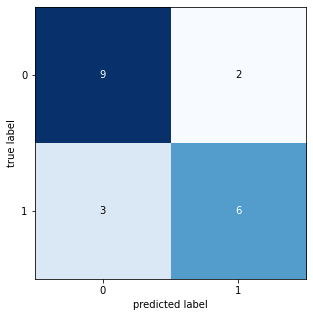

Train : [ 0  1  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 21 22 23 24 26
 28 29 32 33 34 35 36 38 40 41 42 43 44 45 46 48 49 50 51 52 53 54 55 56
 57 59 60 62 65 66 67 68 69 71 74 76 77 78 79 80 81 82 83 84 85 86 87 88
 90 91 92 93 94 96] Test : [ 2 20 25 27 30 31 37 39 47 58 61 63 64 70 72 73 75 89 95]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0]
Akurasi :  0.7894736842105263
F1_Score :  0.788888888888889
              precision    recall  f1-score   support

           0       0.80      0.80      0.80        10
           1       0.78      0.78      0.78         9

    accuracy                           0.79        19
   macro avg       0.79      0.79      0.79        19
weighted avg       0.79      0.79      0.79        19



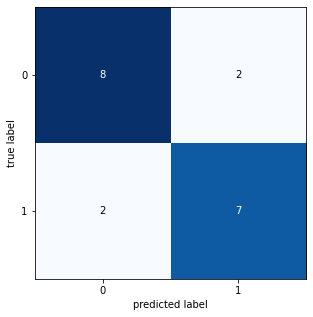

Train : [ 1  2  5  6  7  8  9 10 11 12 13 14 17 18 20 21 22 23 24 25 27 28 29 30
 31 32 33 34 35 36 37 39 40 41 42 43 44 45 47 49 50 52 53 56 57 58 59 61
 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 78 79 82 83 84 85 87 89 90
 91 92 93 94 95 96] Test : [ 0  3  4 15 16 19 26 38 46 48 51 54 55 60 77 80 81 86 88]
Y_Train : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 1 0 0 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Akurasi :  0.7894736842105263
F1_Score :  0.7888888888888888
              precision    recall  f1-score   support

           0       0.88      0.70      0.78        10
           1       0.73      0.89      0.80         9

    accuracy                           0.79        19
   macro avg       0.80      0.79      0.79        19
weighted avg       0.81      0.79      0.79        19



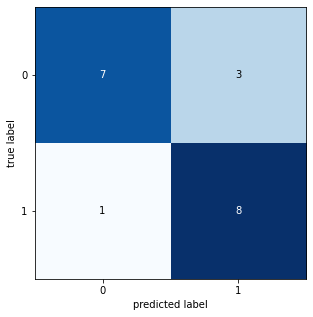

Train : [ 0  1  2  3  4  6  7  9 10 11 12 13 15 16 17 18 19 20 24 25 26 27 28 29
 30 31 32 33 34 36 37 38 39 40 41 44 46 47 48 49 50 51 52 54 55 56 57 58
 59 60 61 62 63 64 66 67 68 70 71 72 73 74 75 77 78 79 80 81 83 84 86 87
 88 89 93 94 95 96] Test : [ 5  8 14 21 22 23 35 42 43 45 53 65 69 76 82 85 90 91 92]
Y_Train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0]
Akurasi :  0.8421052631578947
F1_Score :  0.8421052631578948
              precision    recall  f1-score   support

           0       0.89      0.80      0.84        10
           1       0.80      0.89      0.84         9

    accuracy                           0.84        19
   macro avg       0.84      0.84      0.84        19
weighted avg       0.85      0.84      0.84        19



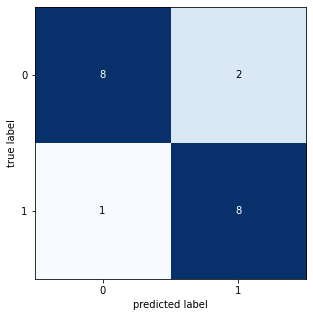

avg accuraccy Breast Cancer =  0.7842105263157896
avg F1_Score Breast Cancer =  0.7827003997632616
max accuraccy Breast Cancer =  0.8421052631578947
max F1_Score Breast Cancer =  0.8421052631578948
min accuraccy Breast Cancer =  0.75
min F1_Score Breast Cancer =  0.7442455242966752
Running Time:  39.999767289000374
gen terbaik : [1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0]
F-1 Score terbaik : 0.7938620168960727  || Akurasi terbaik : 0.7947368421052632  || jumlah fitur : 62

Generation : 1
gene : [1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1,

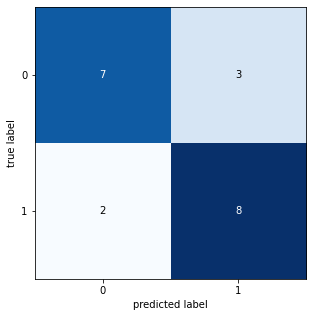

Train : [ 0  2  3  4  5  7  8  9 10 11 14 15 16 17 19 20 21 22 23 25 26 27 28 30
 31 34 35 36 37 38 39 42 43 44 45 46 47 48 49 51 52 53 54 55 56 57 58 59
 60 61 62 63 64 65 66 69 70 72 73 74 75 76 77 80 81 82 83 84 85 86 88 89
 90 91 92 95 96] Test : [ 1  6 12 13 18 24 29 32 33 40 41 50 67 68 71 78 79 87 93 94]
Y_Train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0]
Y_Test : [1 1 0 0 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Akurasi :  0.8
F1_Score :  0.797979797979798
              precision    recall  f1-score   support

           0       0.82      0.82      0.82        11
           1       0.78      0.78      0.78         9

    accuracy                           0.80        20
   macro avg       0.80      0.80      0.80        20
weighted avg       0.80      0.80      0.80        20



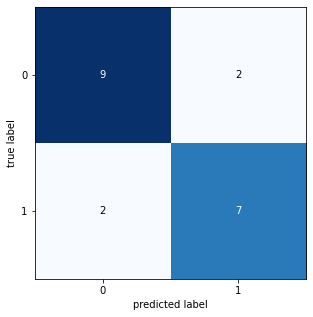

Train : [ 0  1  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 21 22 23 24 26
 28 29 32 33 34 35 36 38 40 41 42 43 44 45 46 48 49 50 51 52 53 54 55 56
 57 59 60 62 65 66 67 68 69 71 74 76 77 78 79 80 81 82 83 84 85 86 87 88
 90 91 92 93 94 96] Test : [ 2 20 25 27 30 31 37 39 47 58 61 63 64 70 72 73 75 89 95]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0]
Akurasi :  0.6842105263157895
F1_Score :  0.6761363636363636
              precision    recall  f1-score   support

           0       0.67      0.80      0.73        10
           1       0.71      0.56      0.63         9

    accuracy                           0.68        19
   macro avg       0.69      0.68      0.68        19
weighted avg       0.69      0.68      0.68        19



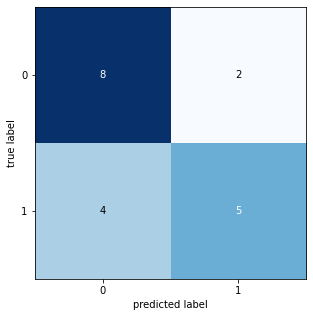

Train : [ 1  2  5  6  7  8  9 10 11 12 13 14 17 18 20 21 22 23 24 25 27 28 29 30
 31 32 33 34 35 36 37 39 40 41 42 43 44 45 47 49 50 52 53 56 57 58 59 61
 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 78 79 82 83 84 85 87 89 90
 91 92 93 94 95 96] Test : [ 0  3  4 15 16 19 26 38 46 48 51 54 55 60 77 80 81 86 88]
Y_Train : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 1 0 0 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Akurasi :  0.8421052631578947
F1_Score :  0.8421052631578948
              precision    recall  f1-score   support

           0       0.89      0.80      0.84        10
           1       0.80      0.89      0.84         9

    accuracy                           0.84        19
   macro avg       0.84      0.84      0.84        19
weighted avg       0.85      0.84      0.84        19



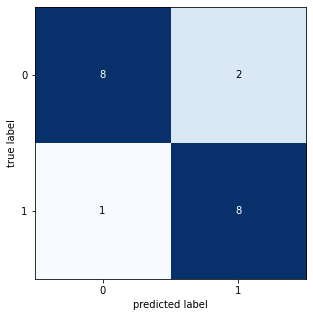

Train : [ 0  1  2  3  4  6  7  9 10 11 12 13 15 16 17 18 19 20 24 25 26 27 28 29
 30 31 32 33 34 36 37 38 39 40 41 44 46 47 48 49 50 51 52 54 55 56 57 58
 59 60 61 62 63 64 66 67 68 70 71 72 73 74 75 77 78 79 80 81 83 84 86 87
 88 89 93 94 95 96] Test : [ 5  8 14 21 22 23 35 42 43 45 53 65 69 76 82 85 90 91 92]
Y_Train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0]
Akurasi :  0.8947368421052632
F1_Score :  0.8944444444444444
              precision    recall  f1-score   support

           0       0.90      0.90      0.90        10
           1       0.89      0.89      0.89         9

    accuracy                           0.89        19
   macro avg       0.89      0.89      0.89        19
weighted avg       0.89      0.89      0.89        19



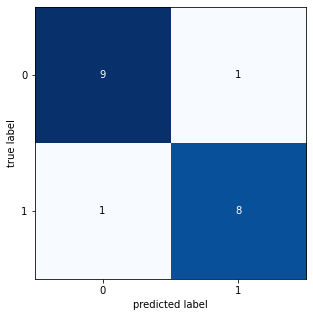

avg accuraccy Breast Cancer =  0.7942105263157895
avg F1_Score Breast Cancer =  0.7920078605604921
max accuraccy Breast Cancer =  0.8947368421052632
max F1_Score Breast Cancer =  0.8944444444444444
min accuraccy Breast Cancer =  0.6842105263157895
min F1_Score Breast Cancer =  0.6761363636363636
Running Time:  41.13894939800048
gene : [0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0]
Train : [ 0  1  2  3  4  5  6  8 12 13 14 15 16 18 19 20 21 22 23 24 25 26 27 29
 30 31 32 33 35 37 38 39 40 41 42 43 45 46 47 48 50 51 53 54 55 58 60 61
 63 64 65 67 68 69 70 71 72 73 75 76 77 78 79 80 81 82 85 86 87 88 89 90
 91 92 93 94 95] Test : [ 7  9 10 11 17 28 34 36 44 49 52 56 57 59 62 66 74 83 84 96]
Y_Train : [1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 

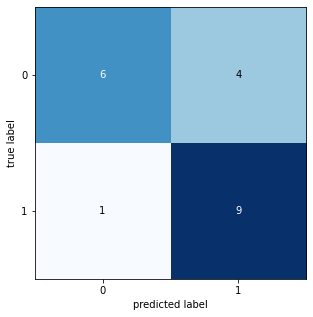

Train : [ 0  2  3  4  5  7  8  9 10 11 14 15 16 17 19 20 21 22 23 25 26 27 28 30
 31 34 35 36 37 38 39 42 43 44 45 46 47 48 49 51 52 53 54 55 56 57 58 59
 60 61 62 63 64 65 66 69 70 72 73 74 75 76 77 80 81 82 83 84 85 86 88 89
 90 91 92 95 96] Test : [ 1  6 12 13 18 24 29 32 33 40 41 50 67 68 71 78 79 87 93 94]
Y_Train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0]
Y_Test : [1 1 0 0 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Akurasi :  0.7
F1_Score :  0.7000000000000001
              precision    recall  f1-score   support

           0       0.78      0.64      0.70        11
           1       0.64      0.78      0.70         9

    accuracy                           0.70        20
   macro avg       0.71      0.71      0.70        20
weighted avg       0.71      0.70      0.70        20



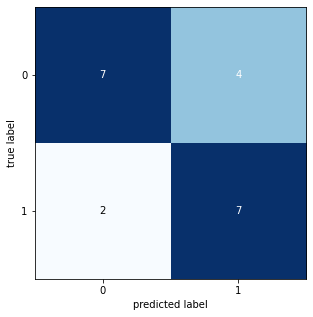

Train : [ 0  1  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 21 22 23 24 26
 28 29 32 33 34 35 36 38 40 41 42 43 44 45 46 48 49 50 51 52 53 54 55 56
 57 59 60 62 65 66 67 68 69 71 74 76 77 78 79 80 81 82 83 84 85 86 87 88
 90 91 92 93 94 96] Test : [ 2 20 25 27 30 31 37 39 47 58 61 63 64 70 72 73 75 89 95]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0]
Akurasi :  0.7368421052631579
F1_Score :  0.7338935574229692
              precision    recall  f1-score   support

           0       0.73      0.80      0.76        10
           1       0.75      0.67      0.71         9

    accuracy                           0.74        19
   macro avg       0.74      0.73      0.73        19
weighted avg       0.74      0.74      0.74        19



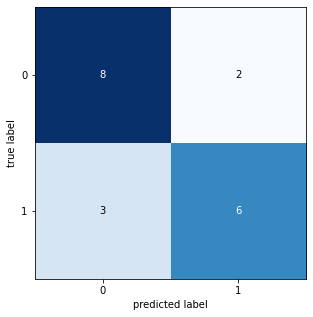

Train : [ 1  2  5  6  7  8  9 10 11 12 13 14 17 18 20 21 22 23 24 25 27 28 29 30
 31 32 33 34 35 36 37 39 40 41 42 43 44 45 47 49 50 52 53 56 57 58 59 61
 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 78 79 82 83 84 85 87 89 90
 91 92 93 94 95 96] Test : [ 0  3  4 15 16 19 26 38 46 48 51 54 55 60 77 80 81 86 88]
Y_Train : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 1 0 0 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Akurasi :  0.6842105263157895
F1_Score :  0.6833333333333333
              precision    recall  f1-score   support

           0       0.75      0.60      0.67        10
           1       0.64      0.78      0.70         9

    accuracy                           0.68        19
   macro avg       0.69      0.69      0.68        19
weighted avg       0.70      0.68      0.68        19



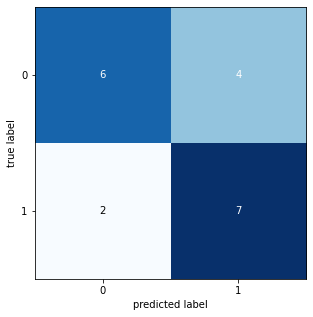

Train : [ 0  1  2  3  4  6  7  9 10 11 12 13 15 16 17 18 19 20 24 25 26 27 28 29
 30 31 32 33 34 36 37 38 39 40 41 44 46 47 48 49 50 51 52 54 55 56 57 58
 59 60 61 62 63 64 66 67 68 70 71 72 73 74 75 77 78 79 80 81 83 84 86 87
 88 89 93 94 95 96] Test : [ 5  8 14 21 22 23 35 42 43 45 53 65 69 76 82 85 90 91 92]
Y_Train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0]
Akurasi :  0.8421052631578947
F1_Score :  0.8421052631578948
              precision    recall  f1-score   support

           0       0.89      0.80      0.84        10
           1       0.80      0.89      0.84         9

    accuracy                           0.84        19
   macro avg       0.84      0.84      0.84        19
weighted avg       0.85      0.84      0.84        19



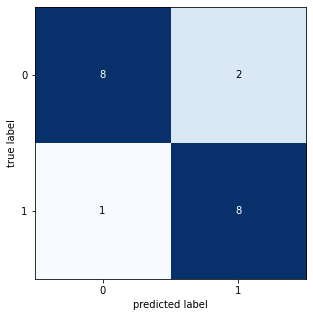

avg accuraccy Breast Cancer =  0.7426315789473683
avg F1_Score Breast Cancer =  0.7407155356421745
max accuraccy Breast Cancer =  0.8421052631578947
max F1_Score Breast Cancer =  0.8421052631578948
min accuraccy Breast Cancer =  0.6842105263157895
min F1_Score Breast Cancer =  0.6833333333333333
Running Time:  39.69131813599961
gene : [1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0]
Train : [ 0  1  2  3  4  5  6  8 12 13 14 15 16 18 19 20 21 22 23 24 25 26 27 29
 30 31 32 33 35 37 38 39 40 41 42 43 45 46 47 48 50 51 53 54 55 58 60 61
 63 64 65 67 68 69 70 71 72 73 75 76 77 78 79 80 81 82 85 86 87 88 89 90
 91 92 93 94 95] Test : [ 7  9 10 11 17 28 34 36 44 49 52 56 57 59 62 66 74 83 84 96]
Y_Train : [1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 

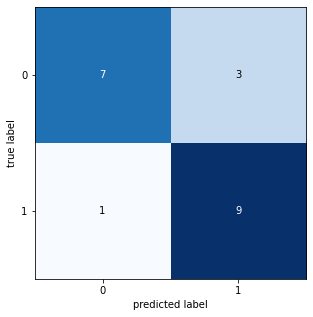

Train : [ 0  2  3  4  5  7  8  9 10 11 14 15 16 17 19 20 21 22 23 25 26 27 28 30
 31 34 35 36 37 38 39 42 43 44 45 46 47 48 49 51 52 53 54 55 56 57 58 59
 60 61 62 63 64 65 66 69 70 72 73 74 75 76 77 80 81 82 83 84 85 86 88 89
 90 91 92 95 96] Test : [ 1  6 12 13 18 24 29 32 33 40 41 50 67 68 71 78 79 87 93 94]
Y_Train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0]
Y_Test : [1 1 0 0 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Akurasi :  0.75
F1_Score :  0.7493734335839599
              precision    recall  f1-score   support

           0       0.80      0.73      0.76        11
           1       0.70      0.78      0.74         9

    accuracy                           0.75        20
   macro avg       0.75      0.75      0.75        20
weighted avg       0.76      0.75      0.75        20



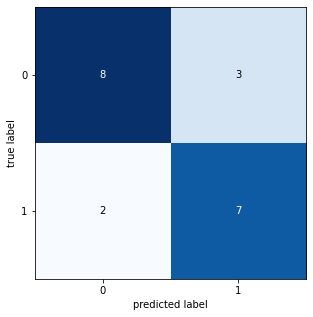

Train : [ 0  1  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 21 22 23 24 26
 28 29 32 33 34 35 36 38 40 41 42 43 44 45 46 48 49 50 51 52 53 54 55 56
 57 59 60 62 65 66 67 68 69 71 74 76 77 78 79 80 81 82 83 84 85 86 87 88
 90 91 92 93 94 96] Test : [ 2 20 25 27 30 31 37 39 47 58 61 63 64 70 72 73 75 89 95]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0]
Akurasi :  0.7894736842105263
F1_Score :  0.788888888888889
              precision    recall  f1-score   support

           0       0.80      0.80      0.80        10
           1       0.78      0.78      0.78         9

    accuracy                           0.79        19
   macro avg       0.79      0.79      0.79        19
weighted avg       0.79      0.79      0.79        19



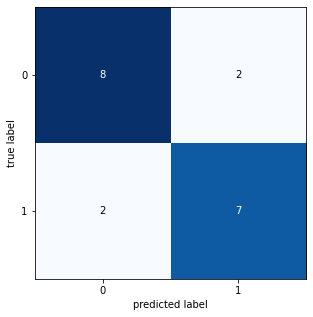

Train : [ 1  2  5  6  7  8  9 10 11 12 13 14 17 18 20 21 22 23 24 25 27 28 29 30
 31 32 33 34 35 36 37 39 40 41 42 43 44 45 47 49 50 52 53 56 57 58 59 61
 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 78 79 82 83 84 85 87 89 90
 91 92 93 94 95 96] Test : [ 0  3  4 15 16 19 26 38 46 48 51 54 55 60 77 80 81 86 88]
Y_Train : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 1 0 0 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Akurasi :  0.7368421052631579
F1_Score :  0.7338935574229692
              precision    recall  f1-score   support

           0       0.86      0.60      0.71        10
           1       0.67      0.89      0.76         9

    accuracy                           0.74        19
   macro avg       0.76      0.74      0.73        19
weighted avg       0.77      0.74      0.73        19



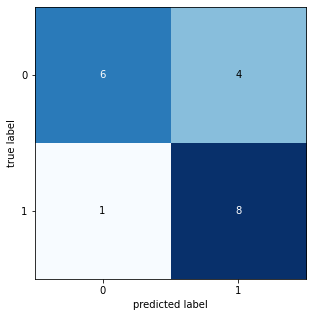

Train : [ 0  1  2  3  4  6  7  9 10 11 12 13 15 16 17 18 19 20 24 25 26 27 28 29
 30 31 32 33 34 36 37 38 39 40 41 44 46 47 48 49 50 51 52 54 55 56 57 58
 59 60 61 62 63 64 66 67 68 70 71 72 73 74 75 77 78 79 80 81 83 84 86 87
 88 89 93 94 95 96] Test : [ 5  8 14 21 22 23 35 42 43 45 53 65 69 76 82 85 90 91 92]
Y_Train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0]
Akurasi :  0.8947368421052632
F1_Score :  0.8944444444444444
              precision    recall  f1-score   support

           0       0.90      0.90      0.90        10
           1       0.89      0.89      0.89         9

    accuracy                           0.89        19
   macro avg       0.89      0.89      0.89        19
weighted avg       0.89      0.89      0.89        19



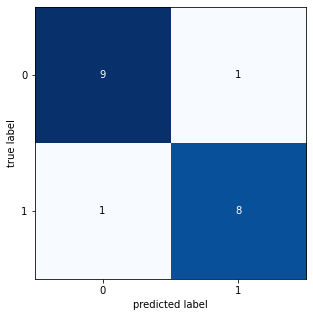

avg accuraccy Breast Cancer =  0.7942105263157895
avg F1_Score Breast Cancer =  0.7929160244640121
max accuraccy Breast Cancer =  0.8947368421052632
max F1_Score Breast Cancer =  0.8944444444444444
min accuraccy Breast Cancer =  0.7368421052631579
min F1_Score Breast Cancer =  0.7338935574229692
Running Time:  40.15796242600118
gene : [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0]
Train : [ 0  1  2  3  4  5  6  8 12 13 14 15 16 18 19 20 21 22 23 24 25 26 27 29
 30 31 32 33 35 37 38 39 40 41 42 43 45 46 47 48 50 51 53 54 55 58 60 61
 63 64 65 67 68 69 70 71 72 73 75 76 77 78 79 80 81 82 85 86 87 88 89 90
 91 92 93 94 95] Test : [ 7  9 10 11 17 28 34 36 44 49 52 56 57 59 62 66 74 83 84 96]
Y_Train : [1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 

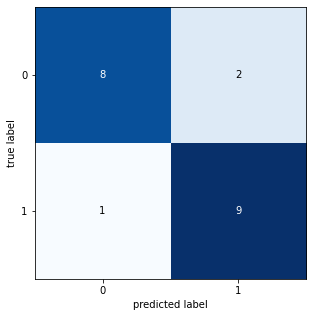

Train : [ 0  2  3  4  5  7  8  9 10 11 14 15 16 17 19 20 21 22 23 25 26 27 28 30
 31 34 35 36 37 38 39 42 43 44 45 46 47 48 49 51 52 53 54 55 56 57 58 59
 60 61 62 63 64 65 66 69 70 72 73 74 75 76 77 80 81 82 83 84 85 86 88 89
 90 91 92 95 96] Test : [ 1  6 12 13 18 24 29 32 33 40 41 50 67 68 71 78 79 87 93 94]
Y_Train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0]
Y_Test : [1 1 0 0 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Akurasi :  0.8
F1_Score :  0.7999999999999999
              precision    recall  f1-score   support

           0       0.89      0.73      0.80        11
           1       0.73      0.89      0.80         9

    accuracy                           0.80        20
   macro avg       0.81      0.81      0.80        20
weighted avg       0.82      0.80      0.80        20



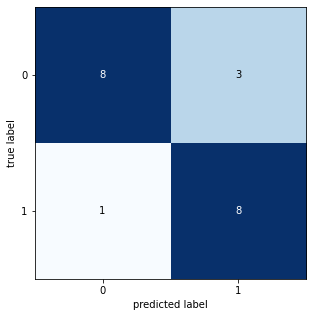

Train : [ 0  1  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 21 22 23 24 26
 28 29 32 33 34 35 36 38 40 41 42 43 44 45 46 48 49 50 51 52 53 54 55 56
 57 59 60 62 65 66 67 68 69 71 74 76 77 78 79 80 81 82 83 84 85 86 87 88
 90 91 92 93 94 96] Test : [ 2 20 25 27 30 31 37 39 47 58 61 63 64 70 72 73 75 89 95]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0]
Akurasi :  0.8421052631578947
F1_Score :  0.8403361344537816
              precision    recall  f1-score   support

           0       0.82      0.90      0.86        10
           1       0.88      0.78      0.82         9

    accuracy                           0.84        19
   macro avg       0.85      0.84      0.84        19
weighted avg       0.85      0.84      0.84        19



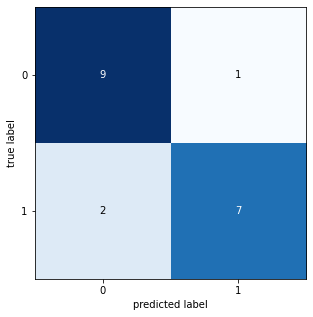

Train : [ 1  2  5  6  7  8  9 10 11 12 13 14 17 18 20 21 22 23 24 25 27 28 29 30
 31 32 33 34 35 36 37 39 40 41 42 43 44 45 47 49 50 52 53 56 57 58 59 61
 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 78 79 82 83 84 85 87 89 90
 91 92 93 94 95 96] Test : [ 0  3  4 15 16 19 26 38 46 48 51 54 55 60 77 80 81 86 88]
Y_Train : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 1 0 0 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Akurasi :  0.6842105263157895
F1_Score :  0.6833333333333333
              precision    recall  f1-score   support

           0       0.75      0.60      0.67        10
           1       0.64      0.78      0.70         9

    accuracy                           0.68        19
   macro avg       0.69      0.69      0.68        19
weighted avg       0.70      0.68      0.68        19



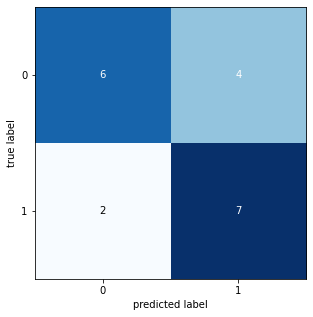

Train : [ 0  1  2  3  4  6  7  9 10 11 12 13 15 16 17 18 19 20 24 25 26 27 28 29
 30 31 32 33 34 36 37 38 39 40 41 44 46 47 48 49 50 51 52 54 55 56 57 58
 59 60 61 62 63 64 66 67 68 70 71 72 73 74 75 77 78 79 80 81 83 84 86 87
 88 89 93 94 95 96] Test : [ 5  8 14 21 22 23 35 42 43 45 53 65 69 76 82 85 90 91 92]
Y_Train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0]
Akurasi :  0.7894736842105263
F1_Score :  0.788888888888889
              precision    recall  f1-score   support

           0       0.80      0.80      0.80        10
           1       0.78      0.78      0.78         9

    accuracy                           0.79        19
   macro avg       0.79      0.79      0.79        19
weighted avg       0.79      0.79      0.79        19



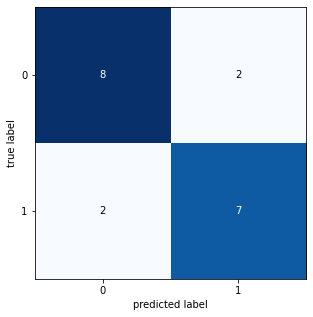

avg accuraccy Breast Cancer =  0.7931578947368421
avg F1_Score Breast Cancer =  0.792436483365276
max accuraccy Breast Cancer =  0.85
max F1_Score Breast Cancer =  0.849624060150376
min accuraccy Breast Cancer =  0.6842105263157895
min F1_Score Breast Cancer =  0.6833333333333333
Running Time:  39.14975707600024
gene : [1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0]
Train : [ 0  1  2  3  4  5  6  8 12 13 14 15 16 18 19 20 21 22 23 24 25 26 27 29
 30 31 32 33 35 37 38 39 40 41 42 43 45 46 47 48 50 51 53 54 55 58 60 61
 63 64 65 67 68 69 70 71 72 73 75 76 77 78 79 80 81 82 85 86 87 88 89 90
 91 92 93 94 95] Test : [ 7  9 10 11 17 28 34 36 44 49 52 56 57 59 62 66 74 83 84 96]
Y_Train : [1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 

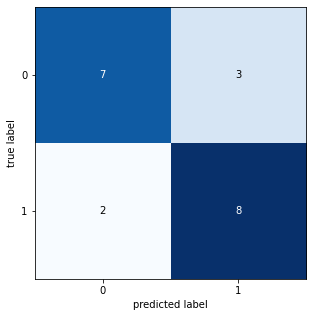

Train : [ 0  2  3  4  5  7  8  9 10 11 14 15 16 17 19 20 21 22 23 25 26 27 28 30
 31 34 35 36 37 38 39 42 43 44 45 46 47 48 49 51 52 53 54 55 56 57 58 59
 60 61 62 63 64 65 66 69 70 72 73 74 75 76 77 80 81 82 83 84 85 86 88 89
 90 91 92 95 96] Test : [ 1  6 12 13 18 24 29 32 33 40 41 50 67 68 71 78 79 87 93 94]
Y_Train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0]
Y_Test : [1 1 0 0 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Akurasi :  0.7
F1_Score :  0.696969696969697
              precision    recall  f1-score   support

           0       0.73      0.73      0.73        11
           1       0.67      0.67      0.67         9

    accuracy                           0.70        20
   macro avg       0.70      0.70      0.70        20
weighted avg       0.70      0.70      0.70        20



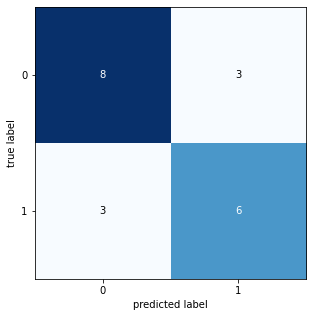

Train : [ 0  1  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 21 22 23 24 26
 28 29 32 33 34 35 36 38 40 41 42 43 44 45 46 48 49 50 51 52 53 54 55 56
 57 59 60 62 65 66 67 68 69 71 74 76 77 78 79 80 81 82 83 84 85 86 87 88
 90 91 92 93 94 96] Test : [ 2 20 25 27 30 31 37 39 47 58 61 63 64 70 72 73 75 89 95]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0]
Akurasi :  0.7894736842105263
F1_Score :  0.788888888888889
              precision    recall  f1-score   support

           0       0.80      0.80      0.80        10
           1       0.78      0.78      0.78         9

    accuracy                           0.79        19
   macro avg       0.79      0.79      0.79        19
weighted avg       0.79      0.79      0.79        19



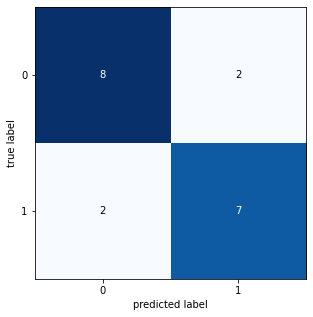

Train : [ 1  2  5  6  7  8  9 10 11 12 13 14 17 18 20 21 22 23 24 25 27 28 29 30
 31 32 33 34 35 36 37 39 40 41 42 43 44 45 47 49 50 52 53 56 57 58 59 61
 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 78 79 82 83 84 85 87 89 90
 91 92 93 94 95 96] Test : [ 0  3  4 15 16 19 26 38 46 48 51 54 55 60 77 80 81 86 88]
Y_Train : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 1 0 0 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Akurasi :  0.8421052631578947
F1_Score :  0.8421052631578948
              precision    recall  f1-score   support

           0       0.89      0.80      0.84        10
           1       0.80      0.89      0.84         9

    accuracy                           0.84        19
   macro avg       0.84      0.84      0.84        19
weighted avg       0.85      0.84      0.84        19



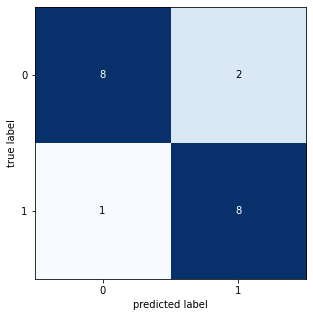

Train : [ 0  1  2  3  4  6  7  9 10 11 12 13 15 16 17 18 19 20 24 25 26 27 28 29
 30 31 32 33 34 36 37 38 39 40 41 44 46 47 48 49 50 51 52 54 55 56 57 58
 59 60 61 62 63 64 66 67 68 70 71 72 73 74 75 77 78 79 80 81 83 84 86 87
 88 89 93 94 95 96] Test : [ 5  8 14 21 22 23 35 42 43 45 53 65 69 76 82 85 90 91 92]
Y_Train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0]
Akurasi :  0.8421052631578947
F1_Score :  0.8403361344537816
              precision    recall  f1-score   support

           0       0.82      0.90      0.86        10
           1       0.88      0.78      0.82         9

    accuracy                           0.84        19
   macro avg       0.85      0.84      0.84        19
weighted avg       0.85      0.84      0.84        19



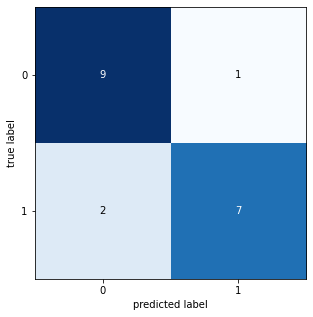

avg accuraccy Breast Cancer =  0.7847368421052632
avg F1_Score Breast Cancer =  0.7835346834108445
max accuraccy Breast Cancer =  0.8421052631578947
max F1_Score Breast Cancer =  0.8421052631578948
min accuraccy Breast Cancer =  0.7
min F1_Score Breast Cancer =  0.696969696969697
Running Time:  42.02052130999982
gene : [0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0]
Train : [ 0  1  2  3  4  5  6  8 12 13 14 15 16 18 19 20 21 22 23 24 25 26 27 29
 30 31 32 33 35 37 38 39 40 41 42 43 45 46 47 48 50 51 53 54 55 58 60 61
 63 64 65 67 68 69 70 71 72 73 75 76 77 78 79 80 81 82 85 86 87 88 89 90
 91 92 93 94 95] Test : [ 7  9 10 11 17 28 34 36 44 49 52 56 57 59 62 66 74 83 84 96]
Y_Train : [1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 

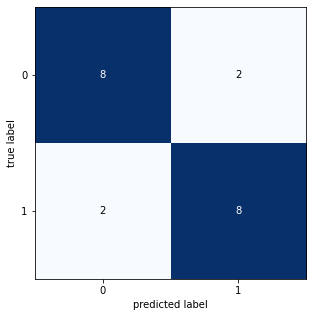

Train : [ 0  2  3  4  5  7  8  9 10 11 14 15 16 17 19 20 21 22 23 25 26 27 28 30
 31 34 35 36 37 38 39 42 43 44 45 46 47 48 49 51 52 53 54 55 56 57 58 59
 60 61 62 63 64 65 66 69 70 72 73 74 75 76 77 80 81 82 83 84 85 86 88 89
 90 91 92 95 96] Test : [ 1  6 12 13 18 24 29 32 33 40 41 50 67 68 71 78 79 87 93 94]
Y_Train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0]
Y_Test : [1 1 0 0 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Akurasi :  0.85
F1_Score :  0.849624060150376
              precision    recall  f1-score   support

           0       0.90      0.82      0.86        11
           1       0.80      0.89      0.84         9

    accuracy                           0.85        20
   macro avg       0.85      0.85      0.85        20
weighted avg       0.86      0.85      0.85        20



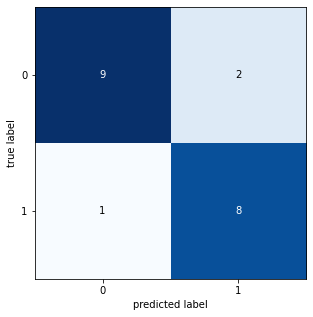

Train : [ 0  1  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 21 22 23 24 26
 28 29 32 33 34 35 36 38 40 41 42 43 44 45 46 48 49 50 51 52 53 54 55 56
 57 59 60 62 65 66 67 68 69 71 74 76 77 78 79 80 81 82 83 84 85 86 87 88
 90 91 92 93 94 96] Test : [ 2 20 25 27 30 31 37 39 47 58 61 63 64 70 72 73 75 89 95]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0]
Akurasi :  0.7894736842105263
F1_Score :  0.7840909090909092
              precision    recall  f1-score   support

           0       0.75      0.90      0.82        10
           1       0.86      0.67      0.75         9

    accuracy                           0.79        19
   macro avg       0.80      0.78      0.78        19
weighted avg       0.80      0.79      0.79        19



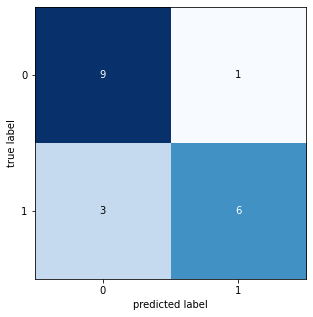

Train : [ 1  2  5  6  7  8  9 10 11 12 13 14 17 18 20 21 22 23 24 25 27 28 29 30
 31 32 33 34 35 36 37 39 40 41 42 43 44 45 47 49 50 52 53 56 57 58 59 61
 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 78 79 82 83 84 85 87 89 90
 91 92 93 94 95 96] Test : [ 0  3  4 15 16 19 26 38 46 48 51 54 55 60 77 80 81 86 88]
Y_Train : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 1 0 0 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Akurasi :  0.6842105263157895
F1_Score :  0.6761363636363638
              precision    recall  f1-score   support

           0       0.83      0.50      0.62        10
           1       0.62      0.89      0.73         9

    accuracy                           0.68        19
   macro avg       0.72      0.69      0.68        19
weighted avg       0.73      0.68      0.67        19



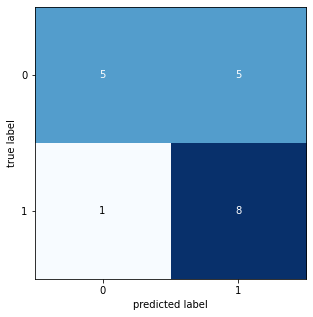

Train : [ 0  1  2  3  4  6  7  9 10 11 12 13 15 16 17 18 19 20 24 25 26 27 28 29
 30 31 32 33 34 36 37 38 39 40 41 44 46 47 48 49 50 51 52 54 55 56 57 58
 59 60 61 62 63 64 66 67 68 70 71 72 73 74 75 77 78 79 80 81 83 84 86 87
 88 89 93 94 95 96] Test : [ 5  8 14 21 22 23 35 42 43 45 53 65 69 76 82 85 90 91 92]
Y_Train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0]
Akurasi :  0.8421052631578947
F1_Score :  0.8421052631578948
              precision    recall  f1-score   support

           0       0.89      0.80      0.84        10
           1       0.80      0.89      0.84         9

    accuracy                           0.84        19
   macro avg       0.84      0.84      0.84        19
weighted avg       0.85      0.84      0.84        19



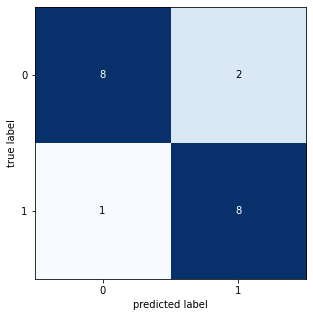

avg accuraccy Breast Cancer =  0.7931578947368421
avg F1_Score Breast Cancer =  0.7903913192071087
max accuraccy Breast Cancer =  0.85
max F1_Score Breast Cancer =  0.849624060150376
min accuraccy Breast Cancer =  0.6842105263157895
min F1_Score Breast Cancer =  0.6761363636363638
Running Time:  37.907427194000775
gene : [1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0]
Train : [ 0  1  2  3  4  5  6  8 12 13 14 15 16 18 19 20 21 22 23 24 25 26 27 29
 30 31 32 33 35 37 38 39 40 41 42 43 45 46 47 48 50 51 53 54 55 58 60 61
 63 64 65 67 68 69 70 71 72 73 75 76 77 78 79 80 81 82 85 86 87 88 89 90
 91 92 93 94 95] Test : [ 7  9 10 11 17 28 34 36 44 49 52 56 57 59 62 66 74 83 84 96]
Y_Train : [1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 

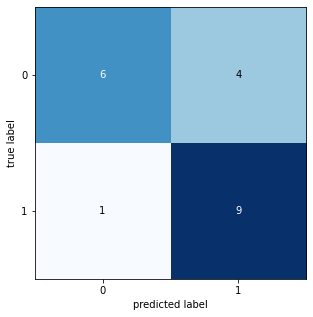

Train : [ 0  2  3  4  5  7  8  9 10 11 14 15 16 17 19 20 21 22 23 25 26 27 28 30
 31 34 35 36 37 38 39 42 43 44 45 46 47 48 49 51 52 53 54 55 56 57 58 59
 60 61 62 63 64 65 66 69 70 72 73 74 75 76 77 80 81 82 83 84 85 86 88 89
 90 91 92 95 96] Test : [ 1  6 12 13 18 24 29 32 33 40 41 50 67 68 71 78 79 87 93 94]
Y_Train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0]
Y_Test : [1 1 0 0 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Akurasi :  0.7
F1_Score :  0.696969696969697
              precision    recall  f1-score   support

           0       0.73      0.73      0.73        11
           1       0.67      0.67      0.67         9

    accuracy                           0.70        20
   macro avg       0.70      0.70      0.70        20
weighted avg       0.70      0.70      0.70        20



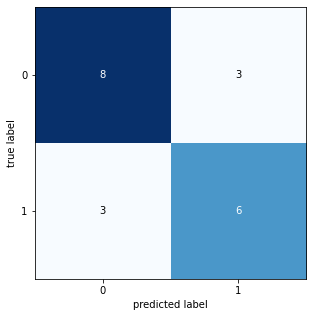

Train : [ 0  1  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 21 22 23 24 26
 28 29 32 33 34 35 36 38 40 41 42 43 44 45 46 48 49 50 51 52 53 54 55 56
 57 59 60 62 65 66 67 68 69 71 74 76 77 78 79 80 81 82 83 84 85 86 87 88
 90 91 92 93 94 96] Test : [ 2 20 25 27 30 31 37 39 47 58 61 63 64 70 72 73 75 89 95]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0]
Akurasi :  0.7368421052631579
F1_Score :  0.7246376811594203
              precision    recall  f1-score   support

           0       0.69      0.90      0.78        10
           1       0.83      0.56      0.67         9

    accuracy                           0.74        19
   macro avg       0.76      0.73      0.72        19
weighted avg       0.76      0.74      0.73        19



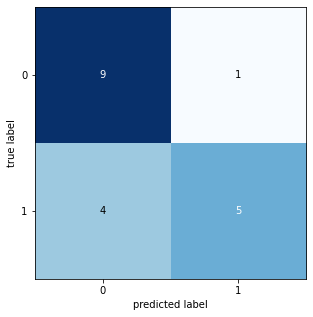

Train : [ 1  2  5  6  7  8  9 10 11 12 13 14 17 18 20 21 22 23 24 25 27 28 29 30
 31 32 33 34 35 36 37 39 40 41 42 43 44 45 47 49 50 52 53 56 57 58 59 61
 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 78 79 82 83 84 85 87 89 90
 91 92 93 94 95 96] Test : [ 0  3  4 15 16 19 26 38 46 48 51 54 55 60 77 80 81 86 88]
Y_Train : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 1 0 0 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Akurasi :  0.7894736842105263
F1_Score :  0.788888888888889
              precision    recall  f1-score   support

           0       0.80      0.80      0.80        10
           1       0.78      0.78      0.78         9

    accuracy                           0.79        19
   macro avg       0.79      0.79      0.79        19
weighted avg       0.79      0.79      0.79        19



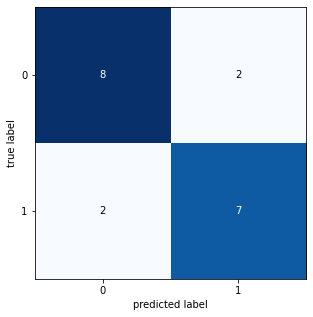

Train : [ 0  1  2  3  4  6  7  9 10 11 12 13 15 16 17 18 19 20 24 25 26 27 28 29
 30 31 32 33 34 36 37 38 39 40 41 44 46 47 48 49 50 51 52 54 55 56 57 58
 59 60 61 62 63 64 66 67 68 70 71 72 73 74 75 77 78 79 80 81 83 84 86 87
 88 89 93 94 95 96] Test : [ 5  8 14 21 22 23 35 42 43 45 53 65 69 76 82 85 90 91 92]
Y_Train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0]
Akurasi :  0.7368421052631579
F1_Score :  0.7368421052631577
              precision    recall  f1-score   support

           0       0.78      0.70      0.74        10
           1       0.70      0.78      0.74         9

    accuracy                           0.74        19
   macro avg       0.74      0.74      0.74        19
weighted avg       0.74      0.74      0.74        19



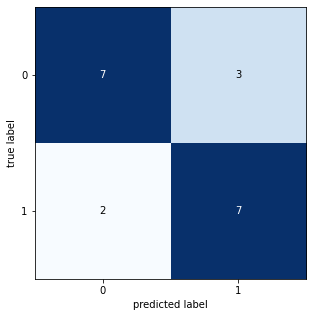

avg accuraccy Breast Cancer =  0.7426315789473684
avg F1_Score Breast Cancer =  0.7383167793155678
max accuraccy Breast Cancer =  0.7894736842105263
max F1_Score Breast Cancer =  0.788888888888889
min accuraccy Breast Cancer =  0.7
min F1_Score Breast Cancer =  0.696969696969697
Running Time:  39.7221230740015
gene : [1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0]
Train : [ 0  1  2  3  4  5  6  8 12 13 14 15 16 18 19 20 21 22 23 24 25 26 27 29
 30 31 32 33 35 37 38 39 40 41 42 43 45 46 47 48 50 51 53 54 55 58 60 61
 63 64 65 67 68 69 70 71 72 73 75 76 77 78 79 80 81 82 85 86 87 88 89 90
 91 92 93 94 95] Test : [ 7  9 10 11 17 28 34 36 44 49 52 56 57 59 62 66 74 83 84 96]
Y_Train : [1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 

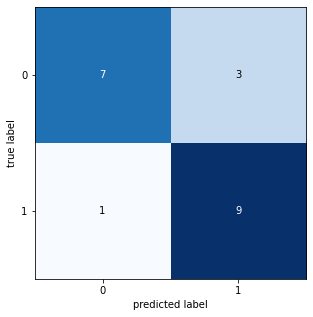

Train : [ 0  2  3  4  5  7  8  9 10 11 14 15 16 17 19 20 21 22 23 25 26 27 28 30
 31 34 35 36 37 38 39 42 43 44 45 46 47 48 49 51 52 53 54 55 56 57 58 59
 60 61 62 63 64 65 66 69 70 72 73 74 75 76 77 80 81 82 83 84 85 86 88 89
 90 91 92 95 96] Test : [ 1  6 12 13 18 24 29 32 33 40 41 50 67 68 71 78 79 87 93 94]
Y_Train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0]
Y_Test : [1 1 0 0 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Akurasi :  0.75
F1_Score :  0.7493734335839599
              precision    recall  f1-score   support

           0       0.88      0.64      0.74        11
           1       0.67      0.89      0.76         9

    accuracy                           0.75        20
   macro avg       0.77      0.76      0.75        20
weighted avg       0.78      0.75      0.75        20



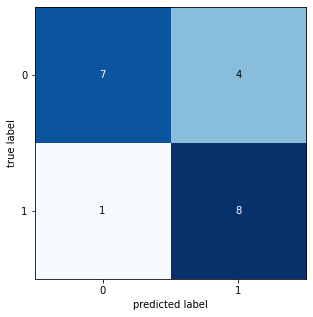

Train : [ 0  1  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 21 22 23 24 26
 28 29 32 33 34 35 36 38 40 41 42 43 44 45 46 48 49 50 51 52 53 54 55 56
 57 59 60 62 65 66 67 68 69 71 74 76 77 78 79 80 81 82 83 84 85 86 87 88
 90 91 92 93 94 96] Test : [ 2 20 25 27 30 31 37 39 47 58 61 63 64 70 72 73 75 89 95]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0]
Akurasi :  0.7894736842105263
F1_Score :  0.7840909090909092
              precision    recall  f1-score   support

           0       0.75      0.90      0.82        10
           1       0.86      0.67      0.75         9

    accuracy                           0.79        19
   macro avg       0.80      0.78      0.78        19
weighted avg       0.80      0.79      0.79        19



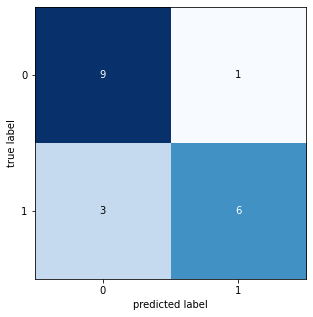

Train : [ 1  2  5  6  7  8  9 10 11 12 13 14 17 18 20 21 22 23 24 25 27 28 29 30
 31 32 33 34 35 36 37 39 40 41 42 43 44 45 47 49 50 52 53 56 57 58 59 61
 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 78 79 82 83 84 85 87 89 90
 91 92 93 94 95 96] Test : [ 0  3  4 15 16 19 26 38 46 48 51 54 55 60 77 80 81 86 88]
Y_Train : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 1 0 0 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Akurasi :  0.7368421052631579
F1_Score :  0.7246376811594203
              precision    recall  f1-score   support

           0       1.00      0.50      0.67        10
           1       0.64      1.00      0.78         9

    accuracy                           0.74        19
   macro avg       0.82      0.75      0.72        19
weighted avg       0.83      0.74      0.72        19



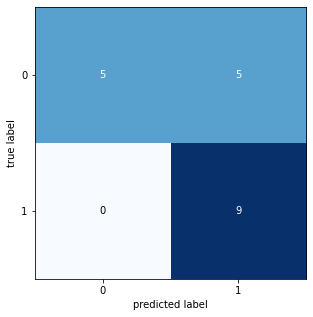

Train : [ 0  1  2  3  4  6  7  9 10 11 12 13 15 16 17 18 19 20 24 25 26 27 28 29
 30 31 32 33 34 36 37 38 39 40 41 44 46 47 48 49 50 51 52 54 55 56 57 58
 59 60 61 62 63 64 66 67 68 70 71 72 73 74 75 77 78 79 80 81 83 84 86 87
 88 89 93 94 95 96] Test : [ 5  8 14 21 22 23 35 42 43 45 53 65 69 76 82 85 90 91 92]
Y_Train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0]
Akurasi :  0.8421052631578947
F1_Score :  0.8403361344537816
              precision    recall  f1-score   support

           0       0.82      0.90      0.86        10
           1       0.88      0.78      0.82         9

    accuracy                           0.84        19
   macro avg       0.85      0.84      0.84        19
weighted avg       0.85      0.84      0.84        19



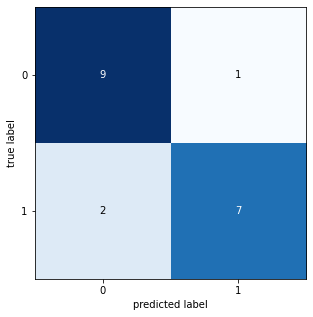

avg accuraccy Breast Cancer =  0.7836842105263158
avg F1_Score Breast Cancer =  0.7792835912535738
max accuraccy Breast Cancer =  0.8421052631578947
max F1_Score Breast Cancer =  0.8403361344537816
min accuraccy Breast Cancer =  0.7368421052631579
min F1_Score Breast Cancer =  0.7246376811594203
Running Time:  39.90363710599922
gene : [1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0]
Train : [ 0  1  2  3  4  5  6  8 12 13 14 15 16 18 19 20 21 22 23 24 25 26 27 29
 30 31 32 33 35 37 38 39 40 41 42 43 45 46 47 48 50 51 53 54 55 58 60 61
 63 64 65 67 68 69 70 71 72 73 75 76 77 78 79 80 81 82 85 86 87 88 89 90
 91 92 93 94 95] Test : [ 7  9 10 11 17 28 34 36 44 49 52 56 57 59 62 66 74 83 84 96]
Y_Train : [1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 

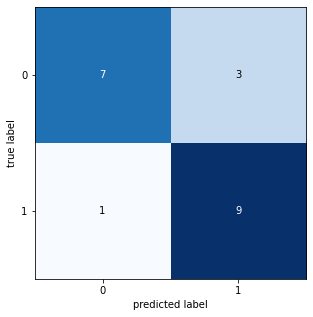

Train : [ 0  2  3  4  5  7  8  9 10 11 14 15 16 17 19 20 21 22 23 25 26 27 28 30
 31 34 35 36 37 38 39 42 43 44 45 46 47 48 49 51 52 53 54 55 56 57 58 59
 60 61 62 63 64 65 66 69 70 72 73 74 75 76 77 80 81 82 83 84 85 86 88 89
 90 91 92 95 96] Test : [ 1  6 12 13 18 24 29 32 33 40 41 50 67 68 71 78 79 87 93 94]
Y_Train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0]
Y_Test : [1 1 0 0 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Akurasi :  0.7
F1_Score :  0.7000000000000001
              precision    recall  f1-score   support

           0       0.78      0.64      0.70        11
           1       0.64      0.78      0.70         9

    accuracy                           0.70        20
   macro avg       0.71      0.71      0.70        20
weighted avg       0.71      0.70      0.70        20



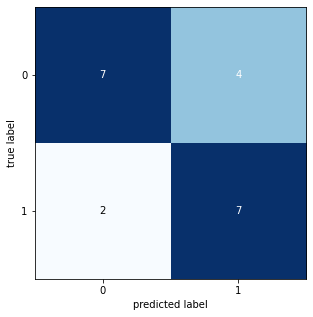

Train : [ 0  1  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 21 22 23 24 26
 28 29 32 33 34 35 36 38 40 41 42 43 44 45 46 48 49 50 51 52 53 54 55 56
 57 59 60 62 65 66 67 68 69 71 74 76 77 78 79 80 81 82 83 84 85 86 87 88
 90 91 92 93 94 96] Test : [ 2 20 25 27 30 31 37 39 47 58 61 63 64 70 72 73 75 89 95]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0]
Akurasi :  0.7894736842105263
F1_Score :  0.788888888888889
              precision    recall  f1-score   support

           0       0.80      0.80      0.80        10
           1       0.78      0.78      0.78         9

    accuracy                           0.79        19
   macro avg       0.79      0.79      0.79        19
weighted avg       0.79      0.79      0.79        19



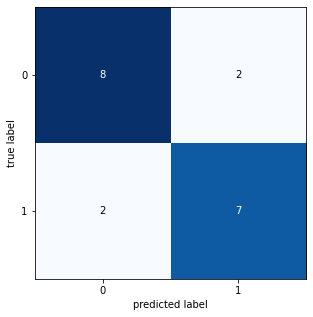

Train : [ 1  2  5  6  7  8  9 10 11 12 13 14 17 18 20 21 22 23 24 25 27 28 29 30
 31 32 33 34 35 36 37 39 40 41 42 43 44 45 47 49 50 52 53 56 57 58 59 61
 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 78 79 82 83 84 85 87 89 90
 91 92 93 94 95 96] Test : [ 0  3  4 15 16 19 26 38 46 48 51 54 55 60 77 80 81 86 88]
Y_Train : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 1 0 0 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Akurasi :  0.8421052631578947
F1_Score :  0.8421052631578948
              precision    recall  f1-score   support

           0       0.89      0.80      0.84        10
           1       0.80      0.89      0.84         9

    accuracy                           0.84        19
   macro avg       0.84      0.84      0.84        19
weighted avg       0.85      0.84      0.84        19



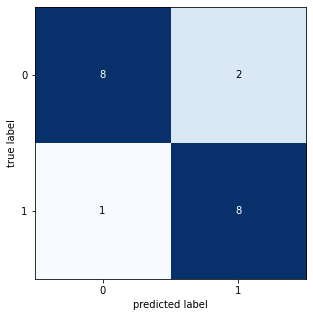

Train : [ 0  1  2  3  4  6  7  9 10 11 12 13 15 16 17 18 19 20 24 25 26 27 28 29
 30 31 32 33 34 36 37 38 39 40 41 44 46 47 48 49 50 51 52 54 55 56 57 58
 59 60 61 62 63 64 66 67 68 70 71 72 73 74 75 77 78 79 80 81 83 84 86 87
 88 89 93 94 95 96] Test : [ 5  8 14 21 22 23 35 42 43 45 53 65 69 76 82 85 90 91 92]
Y_Train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0]
Akurasi :  0.8421052631578947
F1_Score :  0.8403361344537816
              precision    recall  f1-score   support

           0       0.82      0.90      0.86        10
           1       0.88      0.78      0.82         9

    accuracy                           0.84        19
   macro avg       0.85      0.84      0.84        19
weighted avg       0.85      0.84      0.84        19



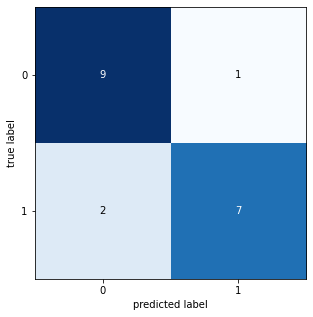

avg accuraccy Breast Cancer =  0.7947368421052632
avg F1_Score Breast Cancer =  0.7938620168960727
max accuraccy Breast Cancer =  0.8421052631578947
max F1_Score Breast Cancer =  0.8421052631578948
min accuraccy Breast Cancer =  0.7
min F1_Score Breast Cancer =  0.7000000000000001
Running Time:  38.27450381900053
gene : [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0]
Train : [ 0  1  2  3  4  5  6  8 12 13 14 15 16 18 19 20 21 22 23 24 25 26 27 29
 30 31 32 33 35 37 38 39 40 41 42 43 45 46 47 48 50 51 53 54 55 58 60 61
 63 64 65 67 68 69 70 71 72 73 75 76 77 78 79 80 81 82 85 86 87 88 89 90
 91 92 93 94 95] Test : [ 7  9 10 11 17 28 34 36 44 49 52 56 57 59 62 66 74 83 84 96]
Y_Train : [1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1

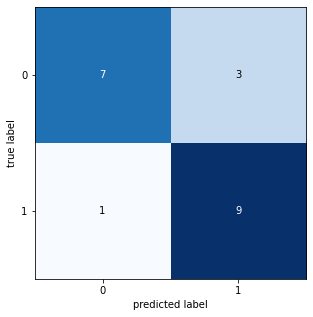

Train : [ 0  2  3  4  5  7  8  9 10 11 14 15 16 17 19 20 21 22 23 25 26 27 28 30
 31 34 35 36 37 38 39 42 43 44 45 46 47 48 49 51 52 53 54 55 56 57 58 59
 60 61 62 63 64 65 66 69 70 72 73 74 75 76 77 80 81 82 83 84 85 86 88 89
 90 91 92 95 96] Test : [ 1  6 12 13 18 24 29 32 33 40 41 50 67 68 71 78 79 87 93 94]
Y_Train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0]
Y_Test : [1 1 0 0 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Akurasi :  0.7
F1_Score :  0.7000000000000001
              precision    recall  f1-score   support

           0       0.78      0.64      0.70        11
           1       0.64      0.78      0.70         9

    accuracy                           0.70        20
   macro avg       0.71      0.71      0.70        20
weighted avg       0.71      0.70      0.70        20



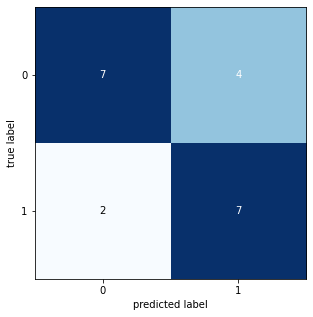

Train : [ 0  1  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 21 22 23 24 26
 28 29 32 33 34 35 36 38 40 41 42 43 44 45 46 48 49 50 51 52 53 54 55 56
 57 59 60 62 65 66 67 68 69 71 74 76 77 78 79 80 81 82 83 84 85 86 87 88
 90 91 92 93 94 96] Test : [ 2 20 25 27 30 31 37 39 47 58 61 63 64 70 72 73 75 89 95]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0]
Akurasi :  0.8421052631578947
F1_Score :  0.8403361344537816
              precision    recall  f1-score   support

           0       0.82      0.90      0.86        10
           1       0.88      0.78      0.82         9

    accuracy                           0.84        19
   macro avg       0.85      0.84      0.84        19
weighted avg       0.85      0.84      0.84        19



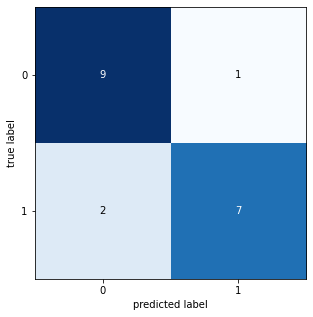

Train : [ 1  2  5  6  7  8  9 10 11 12 13 14 17 18 20 21 22 23 24 25 27 28 29 30
 31 32 33 34 35 36 37 39 40 41 42 43 44 45 47 49 50 52 53 56 57 58 59 61
 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 78 79 82 83 84 85 87 89 90
 91 92 93 94 95 96] Test : [ 0  3  4 15 16 19 26 38 46 48 51 54 55 60 77 80 81 86 88]
Y_Train : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 1 0 0 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Akurasi :  0.7368421052631579
F1_Score :  0.7338935574229692
              precision    recall  f1-score   support

           0       0.86      0.60      0.71        10
           1       0.67      0.89      0.76         9

    accuracy                           0.74        19
   macro avg       0.76      0.74      0.73        19
weighted avg       0.77      0.74      0.73        19



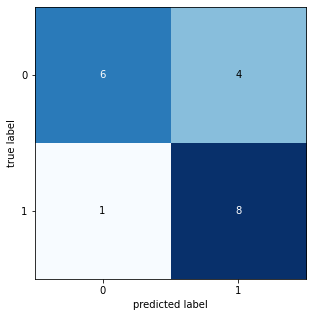

Train : [ 0  1  2  3  4  6  7  9 10 11 12 13 15 16 17 18 19 20 24 25 26 27 28 29
 30 31 32 33 34 36 37 38 39 40 41 44 46 47 48 49 50 51 52 54 55 56 57 58
 59 60 61 62 63 64 66 67 68 70 71 72 73 74 75 77 78 79 80 81 83 84 86 87
 88 89 93 94 95 96] Test : [ 5  8 14 21 22 23 35 42 43 45 53 65 69 76 82 85 90 91 92]
Y_Train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0]
Akurasi :  0.7368421052631579
F1_Score :  0.7368421052631577
              precision    recall  f1-score   support

           0       0.78      0.70      0.74        10
           1       0.70      0.78      0.74         9

    accuracy                           0.74        19
   macro avg       0.74      0.74      0.74        19
weighted avg       0.74      0.74      0.74        19



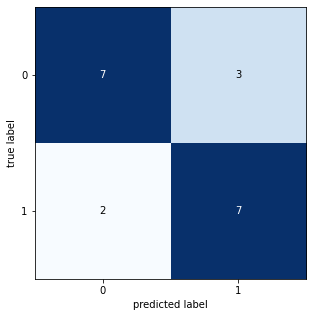

avg accuraccy Breast Cancer =  0.7631578947368421
avg F1_Score Breast Cancer =  0.7618103190239414
max accuraccy Breast Cancer =  0.8421052631578947
max F1_Score Breast Cancer =  0.8403361344537816
min accuraccy Breast Cancer =  0.7
min F1_Score Breast Cancer =  0.7000000000000001
Running Time:  39.35221376800109
gen terbaik : [1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0]
F-1 Score terbaik : 0.7938620168960727  || Akurasi terbaik : 0.7947368421052632  || jumlah fitur : 62

Generation : 2
gene : [1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1

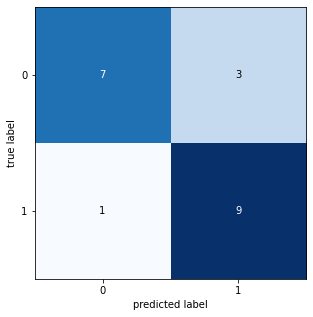

Train : [ 0  2  3  4  5  7  8  9 10 11 14 15 16 17 19 20 21 22 23 25 26 27 28 30
 31 34 35 36 37 38 39 42 43 44 45 46 47 48 49 51 52 53 54 55 56 57 58 59
 60 61 62 63 64 65 66 69 70 72 73 74 75 76 77 80 81 82 83 84 85 86 88 89
 90 91 92 95 96] Test : [ 1  6 12 13 18 24 29 32 33 40 41 50 67 68 71 78 79 87 93 94]
Y_Train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0]
Y_Test : [1 1 0 0 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Akurasi :  0.65
F1_Score :  0.6491228070175439
              precision    recall  f1-score   support

           0       0.70      0.64      0.67        11
           1       0.60      0.67      0.63         9

    accuracy                           0.65        20
   macro avg       0.65      0.65      0.65        20
weighted avg       0.65      0.65      0.65        20



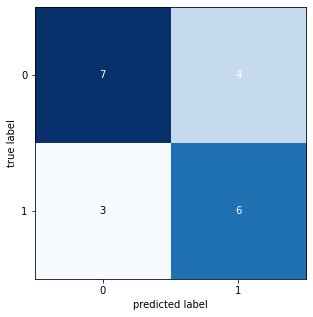

Train : [ 0  1  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 21 22 23 24 26
 28 29 32 33 34 35 36 38 40 41 42 43 44 45 46 48 49 50 51 52 53 54 55 56
 57 59 60 62 65 66 67 68 69 71 74 76 77 78 79 80 81 82 83 84 85 86 87 88
 90 91 92 93 94 96] Test : [ 2 20 25 27 30 31 37 39 47 58 61 63 64 70 72 73 75 89 95]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0]
Akurasi :  0.8421052631578947
F1_Score :  0.8403361344537816
              precision    recall  f1-score   support

           0       0.82      0.90      0.86        10
           1       0.88      0.78      0.82         9

    accuracy                           0.84        19
   macro avg       0.85      0.84      0.84        19
weighted avg       0.85      0.84      0.84        19



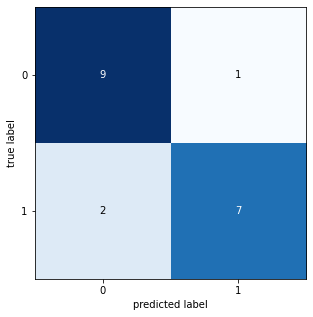

Train : [ 1  2  5  6  7  8  9 10 11 12 13 14 17 18 20 21 22 23 24 25 27 28 29 30
 31 32 33 34 35 36 37 39 40 41 42 43 44 45 47 49 50 52 53 56 57 58 59 61
 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 78 79 82 83 84 85 87 89 90
 91 92 93 94 95 96] Test : [ 0  3  4 15 16 19 26 38 46 48 51 54 55 60 77 80 81 86 88]
Y_Train : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 1 0 0 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Akurasi :  0.7894736842105263
F1_Score :  0.7888888888888888
              precision    recall  f1-score   support

           0       0.88      0.70      0.78        10
           1       0.73      0.89      0.80         9

    accuracy                           0.79        19
   macro avg       0.80      0.79      0.79        19
weighted avg       0.81      0.79      0.79        19



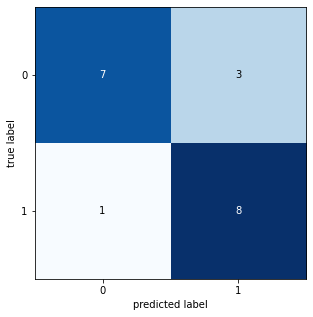

Train : [ 0  1  2  3  4  6  7  9 10 11 12 13 15 16 17 18 19 20 24 25 26 27 28 29
 30 31 32 33 34 36 37 38 39 40 41 44 46 47 48 49 50 51 52 54 55 56 57 58
 59 60 61 62 63 64 66 67 68 70 71 72 73 74 75 77 78 79 80 81 83 84 86 87
 88 89 93 94 95 96] Test : [ 5  8 14 21 22 23 35 42 43 45 53 65 69 76 82 85 90 91 92]
Y_Train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0]
Akurasi :  0.8421052631578947
F1_Score :  0.8403361344537816
              precision    recall  f1-score   support

           0       0.82      0.90      0.86        10
           1       0.88      0.78      0.82         9

    accuracy                           0.84        19
   macro avg       0.85      0.84      0.84        19
weighted avg       0.85      0.84      0.84        19



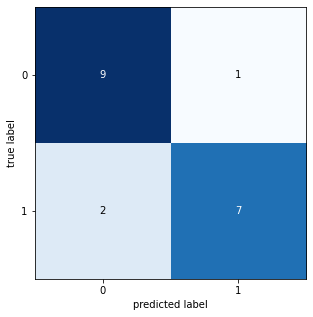

avg accuraccy Breast Cancer =  0.7847368421052632
avg F1_Score Breast Cancer =  0.7833327525587588
max accuraccy Breast Cancer =  0.8421052631578947
max F1_Score Breast Cancer =  0.8403361344537816
min accuraccy Breast Cancer =  0.65
min F1_Score Breast Cancer =  0.6491228070175439
Running Time:  38.55452852500093
gene : [1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0]
Train : [ 0  1  2  3  4  5  6  8 12 13 14 15 16 18 19 20 21 22 23 24 25 26 27 29
 30 31 32 33 35 37 38 39 40 41 42 43 45 46 47 48 50 51 53 54 55 58 60 61
 63 64 65 67 68 69 70 71 72 73 75 76 77 78 79 80 81 82 85 86 87 88 89 90
 91 92 93 94 95] Test : [ 7  9 10 11 17 28 34 36 44 49 52 56 57 59 62 66 74 83 84 96]
Y_Train : [1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 

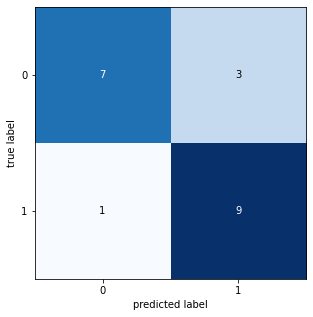

Train : [ 0  2  3  4  5  7  8  9 10 11 14 15 16 17 19 20 21 22 23 25 26 27 28 30
 31 34 35 36 37 38 39 42 43 44 45 46 47 48 49 51 52 53 54 55 56 57 58 59
 60 61 62 63 64 65 66 69 70 72 73 74 75 76 77 80 81 82 83 84 85 86 88 89
 90 91 92 95 96] Test : [ 1  6 12 13 18 24 29 32 33 40 41 50 67 68 71 78 79 87 93 94]
Y_Train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0]
Y_Test : [1 1 0 0 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Akurasi :  0.75
F1_Score :  0.7442455242966752
              precision    recall  f1-score   support

           0       0.75      0.82      0.78        11
           1       0.75      0.67      0.71         9

    accuracy                           0.75        20
   macro avg       0.75      0.74      0.74        20
weighted avg       0.75      0.75      0.75        20



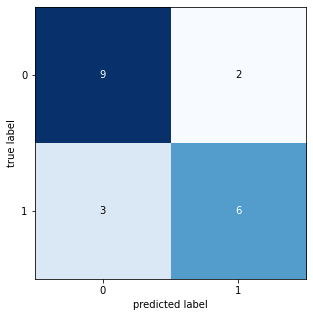

Train : [ 0  1  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 21 22 23 24 26
 28 29 32 33 34 35 36 38 40 41 42 43 44 45 46 48 49 50 51 52 53 54 55 56
 57 59 60 62 65 66 67 68 69 71 74 76 77 78 79 80 81 82 83 84 85 86 87 88
 90 91 92 93 94 96] Test : [ 2 20 25 27 30 31 37 39 47 58 61 63 64 70 72 73 75 89 95]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0]
Akurasi :  0.7894736842105263
F1_Score :  0.788888888888889
              precision    recall  f1-score   support

           0       0.80      0.80      0.80        10
           1       0.78      0.78      0.78         9

    accuracy                           0.79        19
   macro avg       0.79      0.79      0.79        19
weighted avg       0.79      0.79      0.79        19



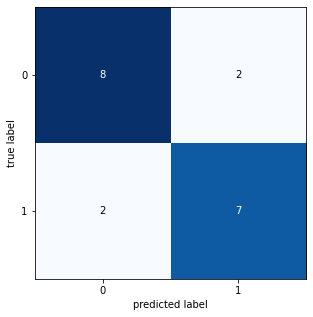

Train : [ 1  2  5  6  7  8  9 10 11 12 13 14 17 18 20 21 22 23 24 25 27 28 29 30
 31 32 33 34 35 36 37 39 40 41 42 43 44 45 47 49 50 52 53 56 57 58 59 61
 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 78 79 82 83 84 85 87 89 90
 91 92 93 94 95 96] Test : [ 0  3  4 15 16 19 26 38 46 48 51 54 55 60 77 80 81 86 88]
Y_Train : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 1 0 0 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Akurasi :  0.7368421052631579
F1_Score :  0.7338935574229692
              precision    recall  f1-score   support

           0       0.86      0.60      0.71        10
           1       0.67      0.89      0.76         9

    accuracy                           0.74        19
   macro avg       0.76      0.74      0.73        19
weighted avg       0.77      0.74      0.73        19



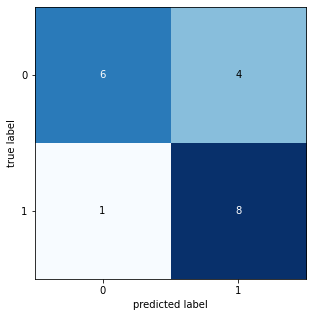

Train : [ 0  1  2  3  4  6  7  9 10 11 12 13 15 16 17 18 19 20 24 25 26 27 28 29
 30 31 32 33 34 36 37 38 39 40 41 44 46 47 48 49 50 51 52 54 55 56 57 58
 59 60 61 62 63 64 66 67 68 70 71 72 73 74 75 77 78 79 80 81 83 84 86 87
 88 89 93 94 95 96] Test : [ 5  8 14 21 22 23 35 42 43 45 53 65 69 76 82 85 90 91 92]
Y_Train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0]
Akurasi :  0.8947368421052632
F1_Score :  0.8944444444444444
              precision    recall  f1-score   support

           0       0.90      0.90      0.90        10
           1       0.89      0.89      0.89         9

    accuracy                           0.89        19
   macro avg       0.89      0.89      0.89        19
weighted avg       0.89      0.89      0.89        19



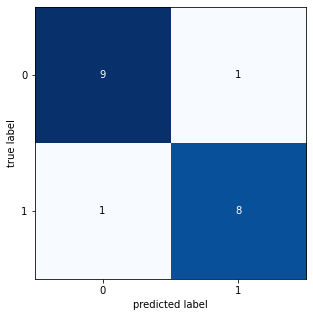

avg accuraccy Breast Cancer =  0.7942105263157895
avg F1_Score Breast Cancer =  0.7918904426065552
max accuraccy Breast Cancer =  0.8947368421052632
max F1_Score Breast Cancer =  0.8944444444444444
min accuraccy Breast Cancer =  0.7368421052631579
min F1_Score Breast Cancer =  0.7338935574229692
Running Time:  40.42146401800164
gene : [1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1]
Train : [ 0  1  2  3  4  5  6  8 12 13 14 15 16 18 19 20 21 22 23 24 25 26 27 29
 30 31 32 33 35 37 38 39 40 41 42 43 45 46 47 48 50 51 53 54 55 58 60 61
 63 64 65 67 68 69 70 71 72 73 75 76 77 78 79 80 81 82 85 86 87 88 89 90
 91 92 93 94 95] Test : [ 7  9 10 11 17 28 34 36 44 49 52 56 57 59 62 66 74 83 84 96]
Y_Train : [1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 

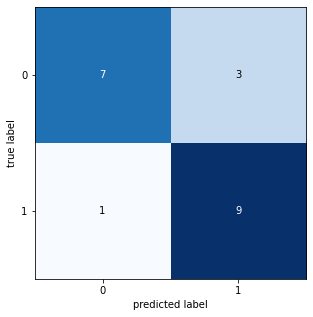

Train : [ 0  2  3  4  5  7  8  9 10 11 14 15 16 17 19 20 21 22 23 25 26 27 28 30
 31 34 35 36 37 38 39 42 43 44 45 46 47 48 49 51 52 53 54 55 56 57 58 59
 60 61 62 63 64 65 66 69 70 72 73 74 75 76 77 80 81 82 83 84 85 86 88 89
 90 91 92 95 96] Test : [ 1  6 12 13 18 24 29 32 33 40 41 50 67 68 71 78 79 87 93 94]
Y_Train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0]
Y_Test : [1 1 0 0 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Akurasi :  0.6
F1_Score :  0.6
              precision    recall  f1-score   support

           0       0.67      0.55      0.60        11
           1       0.55      0.67      0.60         9

    accuracy                           0.60        20
   macro avg       0.61      0.61      0.60        20
weighted avg       0.61      0.60      0.60        20



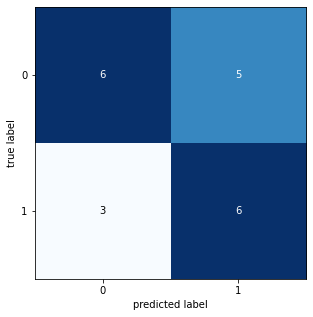

Train : [ 0  1  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 21 22 23 24 26
 28 29 32 33 34 35 36 38 40 41 42 43 44 45 46 48 49 50 51 52 53 54 55 56
 57 59 60 62 65 66 67 68 69 71 74 76 77 78 79 80 81 82 83 84 85 86 87 88
 90 91 92 93 94 96] Test : [ 2 20 25 27 30 31 37 39 47 58 61 63 64 70 72 73 75 89 95]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0]
Akurasi :  0.7368421052631579
F1_Score :  0.7338935574229692
              precision    recall  f1-score   support

           0       0.73      0.80      0.76        10
           1       0.75      0.67      0.71         9

    accuracy                           0.74        19
   macro avg       0.74      0.73      0.73        19
weighted avg       0.74      0.74      0.74        19



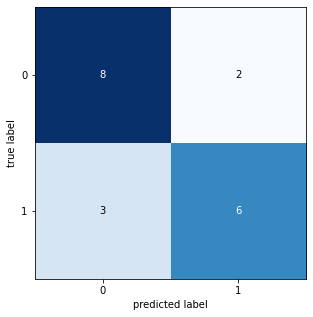

Train : [ 1  2  5  6  7  8  9 10 11 12 13 14 17 18 20 21 22 23 24 25 27 28 29 30
 31 32 33 34 35 36 37 39 40 41 42 43 44 45 47 49 50 52 53 56 57 58 59 61
 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 78 79 82 83 84 85 87 89 90
 91 92 93 94 95 96] Test : [ 0  3  4 15 16 19 26 38 46 48 51 54 55 60 77 80 81 86 88]
Y_Train : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 1 0 0 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Akurasi :  0.7368421052631579
F1_Score :  0.7338935574229692
              precision    recall  f1-score   support

           0       0.86      0.60      0.71        10
           1       0.67      0.89      0.76         9

    accuracy                           0.74        19
   macro avg       0.76      0.74      0.73        19
weighted avg       0.77      0.74      0.73        19



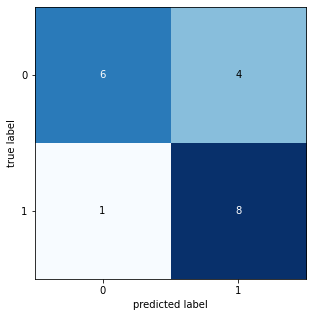

Train : [ 0  1  2  3  4  6  7  9 10 11 12 13 15 16 17 18 19 20 24 25 26 27 28 29
 30 31 32 33 34 36 37 38 39 40 41 44 46 47 48 49 50 51 52 54 55 56 57 58
 59 60 61 62 63 64 66 67 68 70 71 72 73 74 75 77 78 79 80 81 83 84 86 87
 88 89 93 94 95 96] Test : [ 5  8 14 21 22 23 35 42 43 45 53 65 69 76 82 85 90 91 92]
Y_Train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0]
Akurasi :  0.7368421052631579
F1_Score :  0.7368421052631577
              precision    recall  f1-score   support

           0       0.78      0.70      0.74        10
           1       0.70      0.78      0.74         9

    accuracy                           0.74        19
   macro avg       0.74      0.74      0.74        19
weighted avg       0.74      0.74      0.74        19



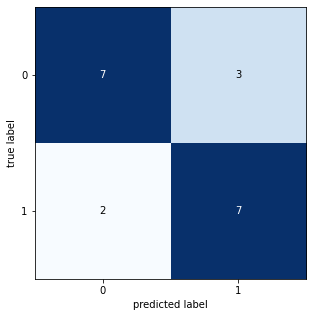

avg accuraccy Breast Cancer =  0.7221052631578948
avg F1_Score Breast Cancer =  0.7205218036177788
max accuraccy Breast Cancer =  0.8
max F1_Score Breast Cancer =  0.797979797979798
min accuraccy Breast Cancer =  0.6
min F1_Score Breast Cancer =  0.6
Running Time:  38.227398290000565
gene : [1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0]
Train : [ 0  1  2  3  4  5  6  8 12 13 14 15 16 18 19 20 21 22 23 24 25 26 27 29
 30 31 32 33 35 37 38 39 40 41 42 43 45 46 47 48 50 51 53 54 55 58 60 61
 63 64 65 67 68 69 70 71 72 73 75 76 77 78 79 80 81 82 85 86 87 88 89 90
 91 92 93 94 95] Test : [ 7  9 10 11 17 28 34 36 44 49 52 56 57 59 62 66 74 83 84 96]
Y_Train : [1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 

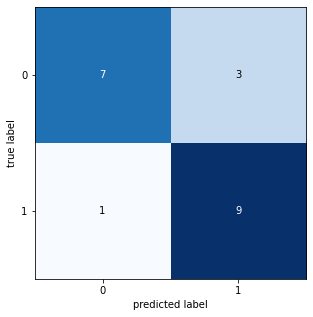

Train : [ 0  2  3  4  5  7  8  9 10 11 14 15 16 17 19 20 21 22 23 25 26 27 28 30
 31 34 35 36 37 38 39 42 43 44 45 46 47 48 49 51 52 53 54 55 56 57 58 59
 60 61 62 63 64 65 66 69 70 72 73 74 75 76 77 80 81 82 83 84 85 86 88 89
 90 91 92 95 96] Test : [ 1  6 12 13 18 24 29 32 33 40 41 50 67 68 71 78 79 87 93 94]
Y_Train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0]
Y_Test : [1 1 0 0 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Akurasi :  0.7
F1_Score :  0.696969696969697
              precision    recall  f1-score   support

           0       0.73      0.73      0.73        11
           1       0.67      0.67      0.67         9

    accuracy                           0.70        20
   macro avg       0.70      0.70      0.70        20
weighted avg       0.70      0.70      0.70        20



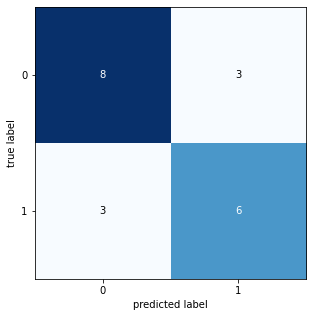

Train : [ 0  1  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 21 22 23 24 26
 28 29 32 33 34 35 36 38 40 41 42 43 44 45 46 48 49 50 51 52 53 54 55 56
 57 59 60 62 65 66 67 68 69 71 74 76 77 78 79 80 81 82 83 84 85 86 87 88
 90 91 92 93 94 96] Test : [ 2 20 25 27 30 31 37 39 47 58 61 63 64 70 72 73 75 89 95]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0]
Akurasi :  0.7894736842105263
F1_Score :  0.788888888888889
              precision    recall  f1-score   support

           0       0.80      0.80      0.80        10
           1       0.78      0.78      0.78         9

    accuracy                           0.79        19
   macro avg       0.79      0.79      0.79        19
weighted avg       0.79      0.79      0.79        19



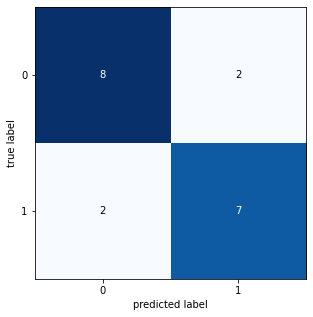

Train : [ 1  2  5  6  7  8  9 10 11 12 13 14 17 18 20 21 22 23 24 25 27 28 29 30
 31 32 33 34 35 36 37 39 40 41 42 43 44 45 47 49 50 52 53 56 57 58 59 61
 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 78 79 82 83 84 85 87 89 90
 91 92 93 94 95 96] Test : [ 0  3  4 15 16 19 26 38 46 48 51 54 55 60 77 80 81 86 88]
Y_Train : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 1 0 0 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Akurasi :  0.6842105263157895
F1_Score :  0.6833333333333333
              precision    recall  f1-score   support

           0       0.75      0.60      0.67        10
           1       0.64      0.78      0.70         9

    accuracy                           0.68        19
   macro avg       0.69      0.69      0.68        19
weighted avg       0.70      0.68      0.68        19



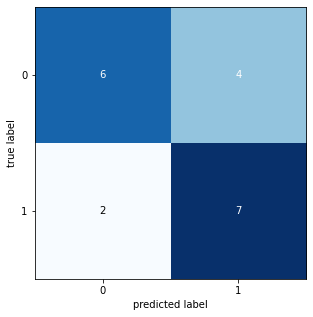

Train : [ 0  1  2  3  4  6  7  9 10 11 12 13 15 16 17 18 19 20 24 25 26 27 28 29
 30 31 32 33 34 36 37 38 39 40 41 44 46 47 48 49 50 51 52 54 55 56 57 58
 59 60 61 62 63 64 66 67 68 70 71 72 73 74 75 77 78 79 80 81 83 84 86 87
 88 89 93 94 95 96] Test : [ 5  8 14 21 22 23 35 42 43 45 53 65 69 76 82 85 90 91 92]
Y_Train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0]
Akurasi :  0.8947368421052632
F1_Score :  0.8944444444444444
              precision    recall  f1-score   support

           0       0.90      0.90      0.90        10
           1       0.89      0.89      0.89         9

    accuracy                           0.89        19
   macro avg       0.89      0.89      0.89        19
weighted avg       0.89      0.89      0.89        19



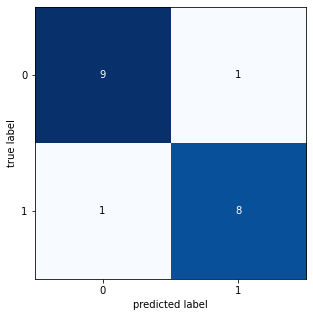

avg accuraccy Breast Cancer =  0.7736842105263159
avg F1_Score Breast Cancer =  0.7723232323232323
max accuraccy Breast Cancer =  0.8947368421052632
max F1_Score Breast Cancer =  0.8944444444444444
min accuraccy Breast Cancer =  0.6842105263157895
min F1_Score Breast Cancer =  0.6833333333333333
Running Time:  40.27431937599977
gene : [1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0]
Train : [ 0  1  2  3  4  5  6  8 12 13 14 15 16 18 19 20 21 22 23 24 25 26 27 29
 30 31 32 33 35 37 38 39 40 41 42 43 45 46 47 48 50 51 53 54 55 58 60 61
 63 64 65 67 68 69 70 71 72 73 75 76 77 78 79 80 81 82 85 86 87 88 89 90
 91 92 93 94 95] Test : [ 7  9 10 11 17 28 34 36 44 49 52 56 57 59 62 66 74 83 84 96]
Y_Train : [1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 

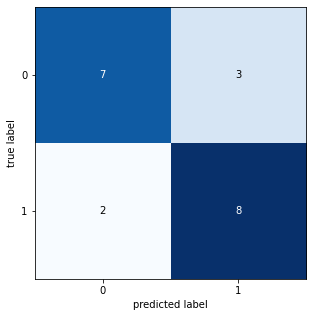

Train : [ 0  2  3  4  5  7  8  9 10 11 14 15 16 17 19 20 21 22 23 25 26 27 28 30
 31 34 35 36 37 38 39 42 43 44 45 46 47 48 49 51 52 53 54 55 56 57 58 59
 60 61 62 63 64 65 66 69 70 72 73 74 75 76 77 80 81 82 83 84 85 86 88 89
 90 91 92 95 96] Test : [ 1  6 12 13 18 24 29 32 33 40 41 50 67 68 71 78 79 87 93 94]
Y_Train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0]
Y_Test : [1 1 0 0 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Akurasi :  0.75
F1_Score :  0.7493734335839599
              precision    recall  f1-score   support

           0       0.80      0.73      0.76        11
           1       0.70      0.78      0.74         9

    accuracy                           0.75        20
   macro avg       0.75      0.75      0.75        20
weighted avg       0.76      0.75      0.75        20



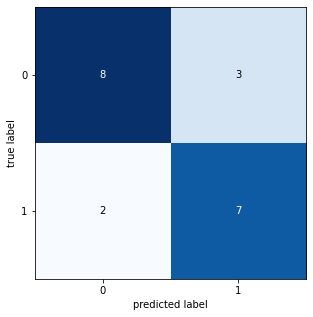

Train : [ 0  1  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 21 22 23 24 26
 28 29 32 33 34 35 36 38 40 41 42 43 44 45 46 48 49 50 51 52 53 54 55 56
 57 59 60 62 65 66 67 68 69 71 74 76 77 78 79 80 81 82 83 84 85 86 87 88
 90 91 92 93 94 96] Test : [ 2 20 25 27 30 31 37 39 47 58 61 63 64 70 72 73 75 89 95]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0]
Akurasi :  0.8421052631578947
F1_Score :  0.8421052631578948
              precision    recall  f1-score   support

           0       0.89      0.80      0.84        10
           1       0.80      0.89      0.84         9

    accuracy                           0.84        19
   macro avg       0.84      0.84      0.84        19
weighted avg       0.85      0.84      0.84        19



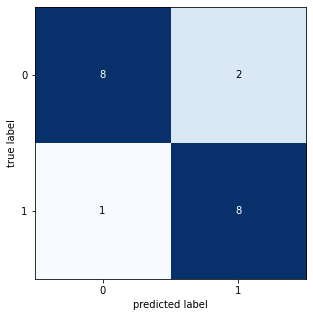

Train : [ 1  2  5  6  7  8  9 10 11 12 13 14 17 18 20 21 22 23 24 25 27 28 29 30
 31 32 33 34 35 36 37 39 40 41 42 43 44 45 47 49 50 52 53 56 57 58 59 61
 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 78 79 82 83 84 85 87 89 90
 91 92 93 94 95 96] Test : [ 0  3  4 15 16 19 26 38 46 48 51 54 55 60 77 80 81 86 88]
Y_Train : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 1 0 0 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Akurasi :  0.6842105263157895
F1_Score :  0.6833333333333333
              precision    recall  f1-score   support

           0       0.75      0.60      0.67        10
           1       0.64      0.78      0.70         9

    accuracy                           0.68        19
   macro avg       0.69      0.69      0.68        19
weighted avg       0.70      0.68      0.68        19



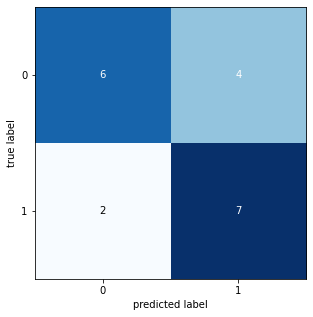

Train : [ 0  1  2  3  4  6  7  9 10 11 12 13 15 16 17 18 19 20 24 25 26 27 28 29
 30 31 32 33 34 36 37 38 39 40 41 44 46 47 48 49 50 51 52 54 55 56 57 58
 59 60 61 62 63 64 66 67 68 70 71 72 73 74 75 77 78 79 80 81 83 84 86 87
 88 89 93 94 95 96] Test : [ 5  8 14 21 22 23 35 42 43 45 53 65 69 76 82 85 90 91 92]
Y_Train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0]
Akurasi :  0.8421052631578947
F1_Score :  0.8421052631578948
              precision    recall  f1-score   support

           0       0.89      0.80      0.84        10
           1       0.80      0.89      0.84         9

    accuracy                           0.84        19
   macro avg       0.84      0.84      0.84        19
weighted avg       0.85      0.84      0.84        19



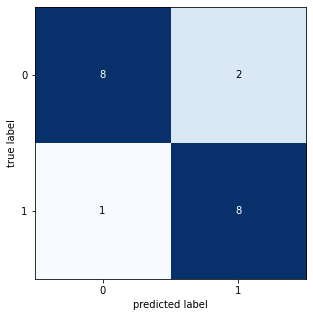

avg accuraccy Breast Cancer =  0.7736842105263158
avg F1_Score Breast Cancer =  0.7732581453634084
max accuraccy Breast Cancer =  0.8421052631578947
max F1_Score Breast Cancer =  0.8421052631578948
min accuraccy Breast Cancer =  0.6842105263157895
min F1_Score Breast Cancer =  0.6833333333333333
Running Time:  39.79849440699945
gene : [1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0]
Train : [ 0  1  2  3  4  5  6  8 12 13 14 15 16 18 19 20 21 22 23 24 25 26 27 29
 30 31 32 33 35 37 38 39 40 41 42 43 45 46 47 48 50 51 53 54 55 58 60 61
 63 64 65 67 68 69 70 71 72 73 75 76 77 78 79 80 81 82 85 86 87 88 89 90
 91 92 93 94 95] Test : [ 7  9 10 11 17 28 34 36 44 49 52 56 57 59 62 66 74 83 84 96]
Y_Train : [1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 

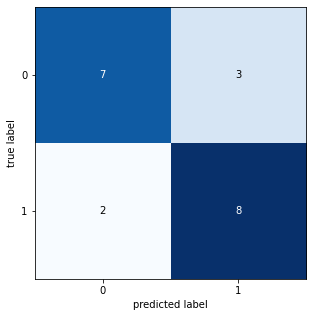

Train : [ 0  2  3  4  5  7  8  9 10 11 14 15 16 17 19 20 21 22 23 25 26 27 28 30
 31 34 35 36 37 38 39 42 43 44 45 46 47 48 49 51 52 53 54 55 56 57 58 59
 60 61 62 63 64 65 66 69 70 72 73 74 75 76 77 80 81 82 83 84 85 86 88 89
 90 91 92 95 96] Test : [ 1  6 12 13 18 24 29 32 33 40 41 50 67 68 71 78 79 87 93 94]
Y_Train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0]
Y_Test : [1 1 0 0 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Akurasi :  0.85
F1_Score :  0.849624060150376
              precision    recall  f1-score   support

           0       0.90      0.82      0.86        11
           1       0.80      0.89      0.84         9

    accuracy                           0.85        20
   macro avg       0.85      0.85      0.85        20
weighted avg       0.86      0.85      0.85        20



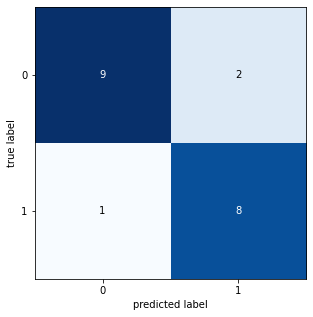

Train : [ 0  1  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 21 22 23 24 26
 28 29 32 33 34 35 36 38 40 41 42 43 44 45 46 48 49 50 51 52 53 54 55 56
 57 59 60 62 65 66 67 68 69 71 74 76 77 78 79 80 81 82 83 84 85 86 87 88
 90 91 92 93 94 96] Test : [ 2 20 25 27 30 31 37 39 47 58 61 63 64 70 72 73 75 89 95]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0]
Akurasi :  0.7894736842105263
F1_Score :  0.7840909090909092
              precision    recall  f1-score   support

           0       0.75      0.90      0.82        10
           1       0.86      0.67      0.75         9

    accuracy                           0.79        19
   macro avg       0.80      0.78      0.78        19
weighted avg       0.80      0.79      0.79        19



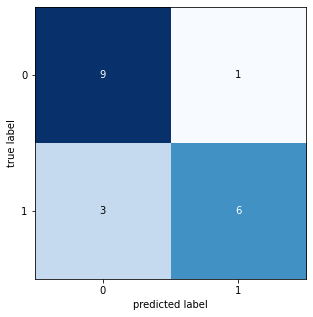

Train : [ 1  2  5  6  7  8  9 10 11 12 13 14 17 18 20 21 22 23 24 25 27 28 29 30
 31 32 33 34 35 36 37 39 40 41 42 43 44 45 47 49 50 52 53 56 57 58 59 61
 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 78 79 82 83 84 85 87 89 90
 91 92 93 94 95 96] Test : [ 0  3  4 15 16 19 26 38 46 48 51 54 55 60 77 80 81 86 88]
Y_Train : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 1 0 0 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Akurasi :  0.631578947368421
F1_Score :  0.631578947368421
              precision    recall  f1-score   support

           0       0.67      0.60      0.63        10
           1       0.60      0.67      0.63         9

    accuracy                           0.63        19
   macro avg       0.63      0.63      0.63        19
weighted avg       0.64      0.63      0.63        19



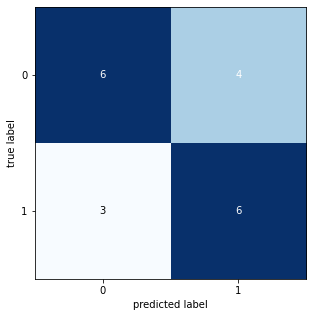

Train : [ 0  1  2  3  4  6  7  9 10 11 12 13 15 16 17 18 19 20 24 25 26 27 28 29
 30 31 32 33 34 36 37 38 39 40 41 44 46 47 48 49 50 51 52 54 55 56 57 58
 59 60 61 62 63 64 66 67 68 70 71 72 73 74 75 77 78 79 80 81 83 84 86 87
 88 89 93 94 95 96] Test : [ 5  8 14 21 22 23 35 42 43 45 53 65 69 76 82 85 90 91 92]
Y_Train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0]
Akurasi :  0.8421052631578947
F1_Score :  0.8403361344537816
              precision    recall  f1-score   support

           0       0.82      0.90      0.86        10
           1       0.88      0.78      0.82         9

    accuracy                           0.84        19
   macro avg       0.85      0.84      0.84        19
weighted avg       0.85      0.84      0.84        19



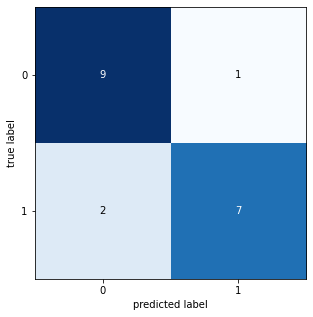

avg accuraccy Breast Cancer =  0.7726315789473684
avg F1_Score Breast Cancer =  0.7710006969294896
max accuraccy Breast Cancer =  0.85
max F1_Score Breast Cancer =  0.849624060150376
min accuraccy Breast Cancer =  0.631578947368421
min F1_Score Breast Cancer =  0.631578947368421
Running Time:  40.50369195100029
gene : [1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0]
Train : [ 0  1  2  3  4  5  6  8 12 13 14 15 16 18 19 20 21 22 23 24 25 26 27 29
 30 31 32 33 35 37 38 39 40 41 42 43 45 46 47 48 50 51 53 54 55 58 60 61
 63 64 65 67 68 69 70 71 72 73 75 76 77 78 79 80 81 82 85 86 87 88 89 90
 91 92 93 94 95] Test : [ 7  9 10 11 17 28 34 36 44 49 52 56 57 59 62 66 74 83 84 96]
Y_Train : [1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1

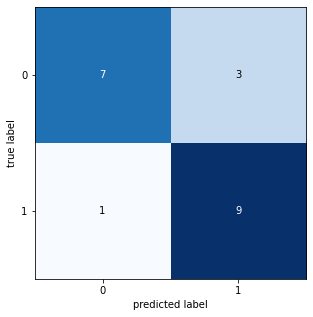

Train : [ 0  2  3  4  5  7  8  9 10 11 14 15 16 17 19 20 21 22 23 25 26 27 28 30
 31 34 35 36 37 38 39 42 43 44 45 46 47 48 49 51 52 53 54 55 56 57 58 59
 60 61 62 63 64 65 66 69 70 72 73 74 75 76 77 80 81 82 83 84 85 86 88 89
 90 91 92 95 96] Test : [ 1  6 12 13 18 24 29 32 33 40 41 50 67 68 71 78 79 87 93 94]
Y_Train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0]
Y_Test : [1 1 0 0 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Akurasi :  0.6
F1_Score :  0.6
              precision    recall  f1-score   support

           0       0.67      0.55      0.60        11
           1       0.55      0.67      0.60         9

    accuracy                           0.60        20
   macro avg       0.61      0.61      0.60        20
weighted avg       0.61      0.60      0.60        20



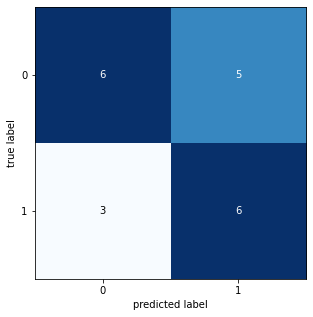

Train : [ 0  1  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 21 22 23 24 26
 28 29 32 33 34 35 36 38 40 41 42 43 44 45 46 48 49 50 51 52 53 54 55 56
 57 59 60 62 65 66 67 68 69 71 74 76 77 78 79 80 81 82 83 84 85 86 87 88
 90 91 92 93 94 96] Test : [ 2 20 25 27 30 31 37 39 47 58 61 63 64 70 72 73 75 89 95]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0]
Akurasi :  0.7368421052631579
F1_Score :  0.7338935574229692
              precision    recall  f1-score   support

           0       0.73      0.80      0.76        10
           1       0.75      0.67      0.71         9

    accuracy                           0.74        19
   macro avg       0.74      0.73      0.73        19
weighted avg       0.74      0.74      0.74        19



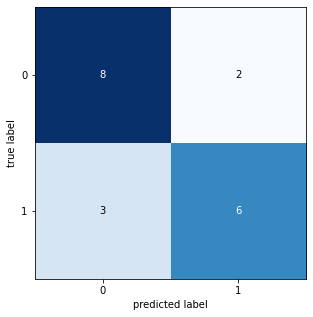

Train : [ 1  2  5  6  7  8  9 10 11 12 13 14 17 18 20 21 22 23 24 25 27 28 29 30
 31 32 33 34 35 36 37 39 40 41 42 43 44 45 47 49 50 52 53 56 57 58 59 61
 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 78 79 82 83 84 85 87 89 90
 91 92 93 94 95 96] Test : [ 0  3  4 15 16 19 26 38 46 48 51 54 55 60 77 80 81 86 88]
Y_Train : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 1 0 0 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Akurasi :  0.6842105263157895
F1_Score :  0.6761363636363638
              precision    recall  f1-score   support

           0       0.83      0.50      0.62        10
           1       0.62      0.89      0.73         9

    accuracy                           0.68        19
   macro avg       0.72      0.69      0.68        19
weighted avg       0.73      0.68      0.67        19



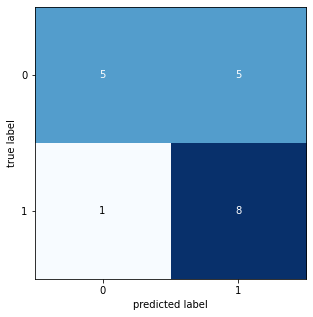

Train : [ 0  1  2  3  4  6  7  9 10 11 12 13 15 16 17 18 19 20 24 25 26 27 28 29
 30 31 32 33 34 36 37 38 39 40 41 44 46 47 48 49 50 51 52 54 55 56 57 58
 59 60 61 62 63 64 66 67 68 70 71 72 73 74 75 77 78 79 80 81 83 84 86 87
 88 89 93 94 95 96] Test : [ 5  8 14 21 22 23 35 42 43 45 53 65 69 76 82 85 90 91 92]
Y_Train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0]
Akurasi :  0.7894736842105263
F1_Score :  0.7888888888888888
              precision    recall  f1-score   support

           0       0.88      0.70      0.78        10
           1       0.73      0.89      0.80         9

    accuracy                           0.79        19
   macro avg       0.80      0.79      0.79        19
weighted avg       0.81      0.79      0.79        19



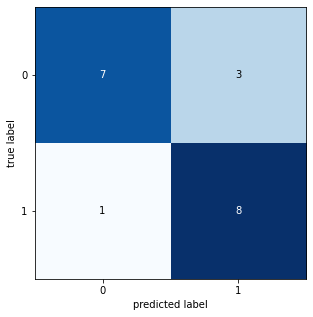

avg accuraccy Breast Cancer =  0.7221052631578948
avg F1_Score Breast Cancer =  0.7193797215856039
max accuraccy Breast Cancer =  0.8
max F1_Score Breast Cancer =  0.797979797979798
min accuraccy Breast Cancer =  0.6
min F1_Score Breast Cancer =  0.6
Running Time:  37.9652665370013
gene : [0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0]
Train : [ 0  1  2  3  4  5  6  8 12 13 14 15 16 18 19 20 21 22 23 24 25 26 27 29
 30 31 32 33 35 37 38 39 40 41 42 43 45 46 47 48 50 51 53 54 55 58 60 61
 63 64 65 67 68 69 70 71 72 73 75 76 77 78 79 80 81 82 85 86 87 88 89 90
 91 92 93 94 95] Test : [ 7  9 10 11 17 28 34 36 44 49 52 56 57 59 62 66 74 83 84 96]
Y_Train : [1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 

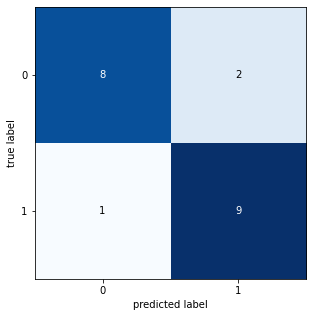

Train : [ 0  2  3  4  5  7  8  9 10 11 14 15 16 17 19 20 21 22 23 25 26 27 28 30
 31 34 35 36 37 38 39 42 43 44 45 46 47 48 49 51 52 53 54 55 56 57 58 59
 60 61 62 63 64 65 66 69 70 72 73 74 75 76 77 80 81 82 83 84 85 86 88 89
 90 91 92 95 96] Test : [ 1  6 12 13 18 24 29 32 33 40 41 50 67 68 71 78 79 87 93 94]
Y_Train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0]
Y_Test : [1 1 0 0 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Akurasi :  0.8
F1_Score :  0.7999999999999999
              precision    recall  f1-score   support

           0       0.89      0.73      0.80        11
           1       0.73      0.89      0.80         9

    accuracy                           0.80        20
   macro avg       0.81      0.81      0.80        20
weighted avg       0.82      0.80      0.80        20



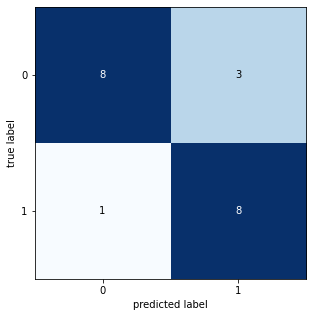

Train : [ 0  1  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 21 22 23 24 26
 28 29 32 33 34 35 36 38 40 41 42 43 44 45 46 48 49 50 51 52 53 54 55 56
 57 59 60 62 65 66 67 68 69 71 74 76 77 78 79 80 81 82 83 84 85 86 87 88
 90 91 92 93 94 96] Test : [ 2 20 25 27 30 31 37 39 47 58 61 63 64 70 72 73 75 89 95]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0]
Akurasi :  0.7368421052631579
F1_Score :  0.7338935574229692
              precision    recall  f1-score   support

           0       0.73      0.80      0.76        10
           1       0.75      0.67      0.71         9

    accuracy                           0.74        19
   macro avg       0.74      0.73      0.73        19
weighted avg       0.74      0.74      0.74        19



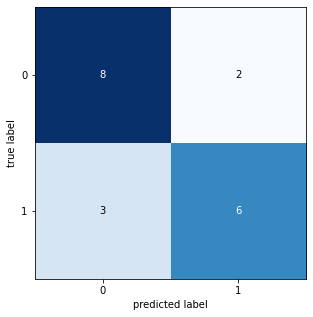

Train : [ 1  2  5  6  7  8  9 10 11 12 13 14 17 18 20 21 22 23 24 25 27 28 29 30
 31 32 33 34 35 36 37 39 40 41 42 43 44 45 47 49 50 52 53 56 57 58 59 61
 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 78 79 82 83 84 85 87 89 90
 91 92 93 94 95 96] Test : [ 0  3  4 15 16 19 26 38 46 48 51 54 55 60 77 80 81 86 88]
Y_Train : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 1 0 0 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Akurasi :  0.7894736842105263
F1_Score :  0.788888888888889
              precision    recall  f1-score   support

           0       0.80      0.80      0.80        10
           1       0.78      0.78      0.78         9

    accuracy                           0.79        19
   macro avg       0.79      0.79      0.79        19
weighted avg       0.79      0.79      0.79        19



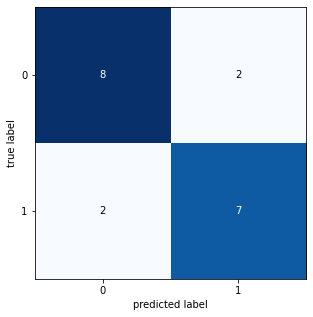

Train : [ 0  1  2  3  4  6  7  9 10 11 12 13 15 16 17 18 19 20 24 25 26 27 28 29
 30 31 32 33 34 36 37 38 39 40 41 44 46 47 48 49 50 51 52 54 55 56 57 58
 59 60 61 62 63 64 66 67 68 70 71 72 73 74 75 77 78 79 80 81 83 84 86 87
 88 89 93 94 95 96] Test : [ 5  8 14 21 22 23 35 42 43 45 53 65 69 76 82 85 90 91 92]
Y_Train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0]
Akurasi :  0.8947368421052632
F1_Score :  0.8944444444444444
              precision    recall  f1-score   support

           0       0.90      0.90      0.90        10
           1       0.89      0.89      0.89         9

    accuracy                           0.89        19
   macro avg       0.89      0.89      0.89        19
weighted avg       0.89      0.89      0.89        19



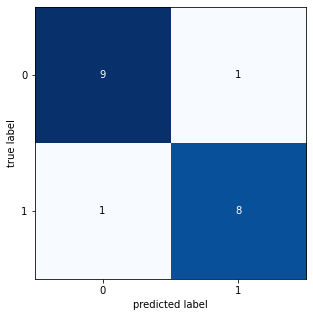

avg accuraccy Breast Cancer =  0.8142105263157895
avg F1_Score Breast Cancer =  0.8133701901813357
max accuraccy Breast Cancer =  0.8947368421052632
max F1_Score Breast Cancer =  0.8944444444444444
min accuraccy Breast Cancer =  0.7368421052631579
min F1_Score Breast Cancer =  0.7338935574229692
Running Time:  39.156378458999825
gene : [1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0]
Train : [ 0  1  2  3  4  5  6  8 12 13 14 15 16 18 19 20 21 22 23 24 25 26 27 29
 30 31 32 33 35 37 38 39 40 41 42 43 45 46 47 48 50 51 53 54 55 58 60 61
 63 64 65 67 68 69 70 71 72 73 75 76 77 78 79 80 81 82 85 86 87 88 89 90
 91 92 93 94 95] Test : [ 7  9 10 11 17 28 34 36 44 49 52 56 57 59 62 66 74 83 84 96]
Y_Train : [1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1

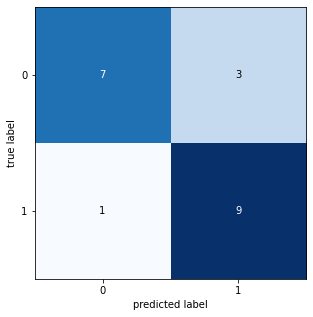

Train : [ 0  2  3  4  5  7  8  9 10 11 14 15 16 17 19 20 21 22 23 25 26 27 28 30
 31 34 35 36 37 38 39 42 43 44 45 46 47 48 49 51 52 53 54 55 56 57 58 59
 60 61 62 63 64 65 66 69 70 72 73 74 75 76 77 80 81 82 83 84 85 86 88 89
 90 91 92 95 96] Test : [ 1  6 12 13 18 24 29 32 33 40 41 50 67 68 71 78 79 87 93 94]
Y_Train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0]
Y_Test : [1 1 0 0 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Akurasi :  0.7
F1_Score :  0.7000000000000001
              precision    recall  f1-score   support

           0       0.78      0.64      0.70        11
           1       0.64      0.78      0.70         9

    accuracy                           0.70        20
   macro avg       0.71      0.71      0.70        20
weighted avg       0.71      0.70      0.70        20



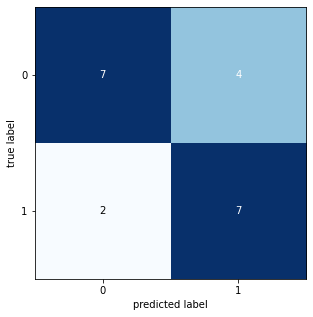

Train : [ 0  1  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 21 22 23 24 26
 28 29 32 33 34 35 36 38 40 41 42 43 44 45 46 48 49 50 51 52 53 54 55 56
 57 59 60 62 65 66 67 68 69 71 74 76 77 78 79 80 81 82 83 84 85 86 87 88
 90 91 92 93 94 96] Test : [ 2 20 25 27 30 31 37 39 47 58 61 63 64 70 72 73 75 89 95]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0]
Akurasi :  0.7894736842105263
F1_Score :  0.788888888888889
              precision    recall  f1-score   support

           0       0.80      0.80      0.80        10
           1       0.78      0.78      0.78         9

    accuracy                           0.79        19
   macro avg       0.79      0.79      0.79        19
weighted avg       0.79      0.79      0.79        19



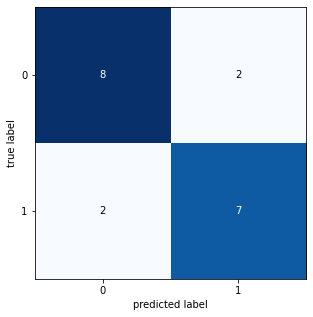

Train : [ 1  2  5  6  7  8  9 10 11 12 13 14 17 18 20 21 22 23 24 25 27 28 29 30
 31 32 33 34 35 36 37 39 40 41 42 43 44 45 47 49 50 52 53 56 57 58 59 61
 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 78 79 82 83 84 85 87 89 90
 91 92 93 94 95 96] Test : [ 0  3  4 15 16 19 26 38 46 48 51 54 55 60 77 80 81 86 88]
Y_Train : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 1 0 0 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Akurasi :  0.7894736842105263
F1_Score :  0.788888888888889
              precision    recall  f1-score   support

           0       0.80      0.80      0.80        10
           1       0.78      0.78      0.78         9

    accuracy                           0.79        19
   macro avg       0.79      0.79      0.79        19
weighted avg       0.79      0.79      0.79        19



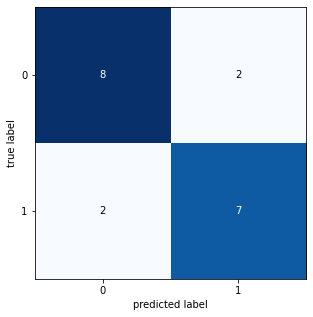

Train : [ 0  1  2  3  4  6  7  9 10 11 12 13 15 16 17 18 19 20 24 25 26 27 28 29
 30 31 32 33 34 36 37 38 39 40 41 44 46 47 48 49 50 51 52 54 55 56 57 58
 59 60 61 62 63 64 66 67 68 70 71 72 73 74 75 77 78 79 80 81 83 84 86 87
 88 89 93 94 95 96] Test : [ 5  8 14 21 22 23 35 42 43 45 53 65 69 76 82 85 90 91 92]
Y_Train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0]
Akurasi :  0.8421052631578947
F1_Score :  0.8403361344537816
              precision    recall  f1-score   support

           0       0.82      0.90      0.86        10
           1       0.88      0.78      0.82         9

    accuracy                           0.84        19
   macro avg       0.85      0.84      0.84        19
weighted avg       0.85      0.84      0.84        19



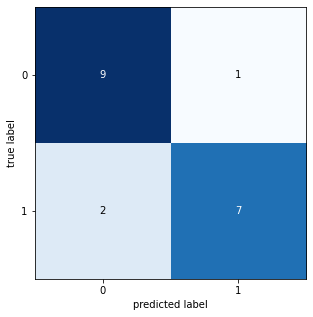

avg accuraccy Breast Cancer =  0.7842105263157896
avg F1_Score Breast Cancer =  0.7832187420422716
max accuraccy Breast Cancer =  0.8421052631578947
max F1_Score Breast Cancer =  0.8403361344537816
min accuraccy Breast Cancer =  0.7
min F1_Score Breast Cancer =  0.7000000000000001
Running Time:  41.03154683400135
gene : [1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0]
Train : [ 0  1  2  3  4  5  6  8 12 13 14 15 16 18 19 20 21 22 23 24 25 26 27 29
 30 31 32 33 35 37 38 39 40 41 42 43 45 46 47 48 50 51 53 54 55 58 60 61
 63 64 65 67 68 69 70 71 72 73 75 76 77 78 79 80 81 82 85 86 87 88 89 90
 91 92 93 94 95] Test : [ 7  9 10 11 17 28 34 36 44 49 52 56 57 59 62 66 74 83 84 96]
Y_Train : [1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1

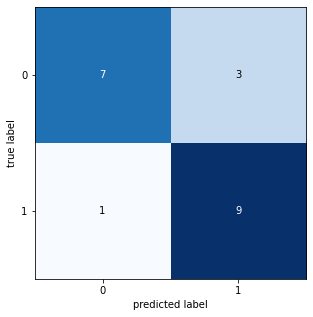

Train : [ 0  2  3  4  5  7  8  9 10 11 14 15 16 17 19 20 21 22 23 25 26 27 28 30
 31 34 35 36 37 38 39 42 43 44 45 46 47 48 49 51 52 53 54 55 56 57 58 59
 60 61 62 63 64 65 66 69 70 72 73 74 75 76 77 80 81 82 83 84 85 86 88 89
 90 91 92 95 96] Test : [ 1  6 12 13 18 24 29 32 33 40 41 50 67 68 71 78 79 87 93 94]
Y_Train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0]
Y_Test : [1 1 0 0 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Akurasi :  0.75
F1_Score :  0.7493734335839599
              precision    recall  f1-score   support

           0       0.80      0.73      0.76        11
           1       0.70      0.78      0.74         9

    accuracy                           0.75        20
   macro avg       0.75      0.75      0.75        20
weighted avg       0.76      0.75      0.75        20



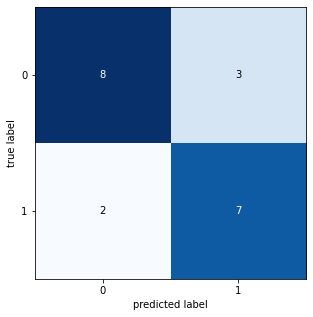

Train : [ 0  1  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 21 22 23 24 26
 28 29 32 33 34 35 36 38 40 41 42 43 44 45 46 48 49 50 51 52 53 54 55 56
 57 59 60 62 65 66 67 68 69 71 74 76 77 78 79 80 81 82 83 84 85 86 87 88
 90 91 92 93 94 96] Test : [ 2 20 25 27 30 31 37 39 47 58 61 63 64 70 72 73 75 89 95]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0]
Akurasi :  0.7894736842105263
F1_Score :  0.788888888888889
              precision    recall  f1-score   support

           0       0.80      0.80      0.80        10
           1       0.78      0.78      0.78         9

    accuracy                           0.79        19
   macro avg       0.79      0.79      0.79        19
weighted avg       0.79      0.79      0.79        19



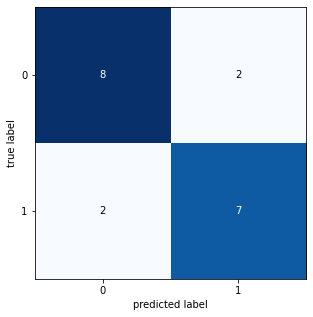

Train : [ 1  2  5  6  7  8  9 10 11 12 13 14 17 18 20 21 22 23 24 25 27 28 29 30
 31 32 33 34 35 36 37 39 40 41 42 43 44 45 47 49 50 52 53 56 57 58 59 61
 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 78 79 82 83 84 85 87 89 90
 91 92 93 94 95 96] Test : [ 0  3  4 15 16 19 26 38 46 48 51 54 55 60 77 80 81 86 88]
Y_Train : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 1 0 0 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Akurasi :  0.7368421052631579
F1_Score :  0.7338935574229692
              precision    recall  f1-score   support

           0       0.86      0.60      0.71        10
           1       0.67      0.89      0.76         9

    accuracy                           0.74        19
   macro avg       0.76      0.74      0.73        19
weighted avg       0.77      0.74      0.73        19



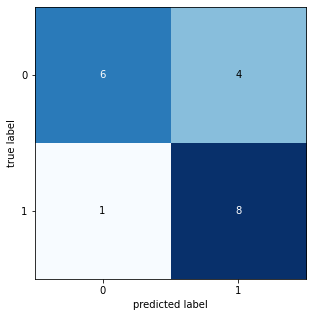

Train : [ 0  1  2  3  4  6  7  9 10 11 12 13 15 16 17 18 19 20 24 25 26 27 28 29
 30 31 32 33 34 36 37 38 39 40 41 44 46 47 48 49 50 51 52 54 55 56 57 58
 59 60 61 62 63 64 66 67 68 70 71 72 73 74 75 77 78 79 80 81 83 84 86 87
 88 89 93 94 95 96] Test : [ 5  8 14 21 22 23 35 42 43 45 53 65 69 76 82 85 90 91 92]
Y_Train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0]
Akurasi :  0.8421052631578947
F1_Score :  0.8403361344537816
              precision    recall  f1-score   support

           0       0.82      0.90      0.86        10
           1       0.88      0.78      0.82         9

    accuracy                           0.84        19
   macro avg       0.85      0.84      0.84        19
weighted avg       0.85      0.84      0.84        19



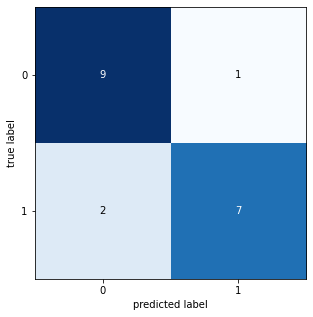

avg accuraccy Breast Cancer =  0.7836842105263158
avg F1_Score Breast Cancer =  0.7820943624658796
max accuraccy Breast Cancer =  0.8421052631578947
max F1_Score Breast Cancer =  0.8403361344537816
min accuraccy Breast Cancer =  0.7368421052631579
min F1_Score Breast Cancer =  0.7338935574229692
Running Time:  38.637065322000126
gen terbaik : [0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0]
F-1 Score terbaik : 0.8133701901813357  || Akurasi terbaik : 0.8142105263157895  || jumlah fitur : 56

Generation : 3
gene : [0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 

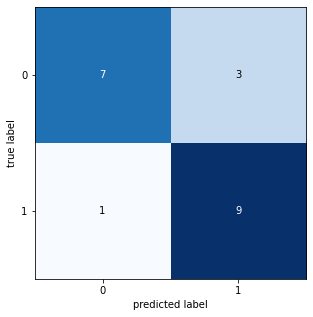

Train : [ 0  2  3  4  5  7  8  9 10 11 14 15 16 17 19 20 21 22 23 25 26 27 28 30
 31 34 35 36 37 38 39 42 43 44 45 46 47 48 49 51 52 53 54 55 56 57 58 59
 60 61 62 63 64 65 66 69 70 72 73 74 75 76 77 80 81 82 83 84 85 86 88 89
 90 91 92 95 96] Test : [ 1  6 12 13 18 24 29 32 33 40 41 50 67 68 71 78 79 87 93 94]
Y_Train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0]
Y_Test : [1 1 0 0 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Akurasi :  0.6
F1_Score :  0.595959595959596
              precision    recall  f1-score   support

           0       0.71      0.45      0.56        11
           1       0.54      0.78      0.64         9

    accuracy                           0.60        20
   macro avg       0.63      0.62      0.60        20
weighted avg       0.64      0.60      0.59        20



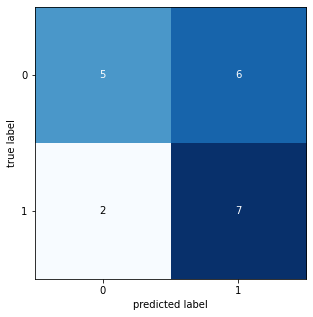

Train : [ 0  1  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 21 22 23 24 26
 28 29 32 33 34 35 36 38 40 41 42 43 44 45 46 48 49 50 51 52 53 54 55 56
 57 59 60 62 65 66 67 68 69 71 74 76 77 78 79 80 81 82 83 84 85 86 87 88
 90 91 92 93 94 96] Test : [ 2 20 25 27 30 31 37 39 47 58 61 63 64 70 72 73 75 89 95]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0]
Akurasi :  0.7894736842105263
F1_Score :  0.788888888888889
              precision    recall  f1-score   support

           0       0.80      0.80      0.80        10
           1       0.78      0.78      0.78         9

    accuracy                           0.79        19
   macro avg       0.79      0.79      0.79        19
weighted avg       0.79      0.79      0.79        19



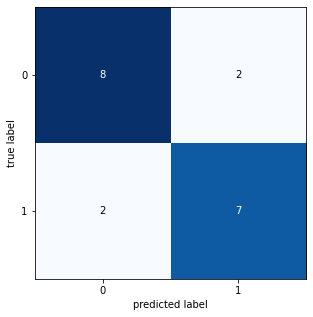

Train : [ 1  2  5  6  7  8  9 10 11 12 13 14 17 18 20 21 22 23 24 25 27 28 29 30
 31 32 33 34 35 36 37 39 40 41 42 43 44 45 47 49 50 52 53 56 57 58 59 61
 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 78 79 82 83 84 85 87 89 90
 91 92 93 94 95 96] Test : [ 0  3  4 15 16 19 26 38 46 48 51 54 55 60 77 80 81 86 88]
Y_Train : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 1 0 0 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Akurasi :  0.631578947368421
F1_Score :  0.6274509803921569
              precision    recall  f1-score   support

           0       0.71      0.50      0.59        10
           1       0.58      0.78      0.67         9

    accuracy                           0.63        19
   macro avg       0.65      0.64      0.63        19
weighted avg       0.65      0.63      0.63        19



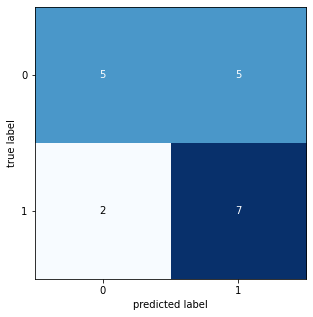

Train : [ 0  1  2  3  4  6  7  9 10 11 12 13 15 16 17 18 19 20 24 25 26 27 28 29
 30 31 32 33 34 36 37 38 39 40 41 44 46 47 48 49 50 51 52 54 55 56 57 58
 59 60 61 62 63 64 66 67 68 70 71 72 73 74 75 77 78 79 80 81 83 84 86 87
 88 89 93 94 95 96] Test : [ 5  8 14 21 22 23 35 42 43 45 53 65 69 76 82 85 90 91 92]
Y_Train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0]
Akurasi :  0.8947368421052632
F1_Score :  0.8944444444444444
              precision    recall  f1-score   support

           0       0.90      0.90      0.90        10
           1       0.89      0.89      0.89         9

    accuracy                           0.89        19
   macro avg       0.89      0.89      0.89        19
weighted avg       0.89      0.89      0.89        19



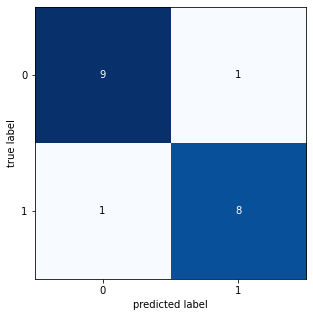

avg accuraccy Breast Cancer =  0.7431578947368421
avg F1_Score Breast Cancer =  0.7409447415329768
max accuraccy Breast Cancer =  0.8947368421052632
max F1_Score Breast Cancer =  0.8944444444444444
min accuraccy Breast Cancer =  0.6
min F1_Score Breast Cancer =  0.595959595959596
Running Time:  38.874960491999445
gene : [1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0]
Train : [ 0  1  2  3  4  5  6  8 12 13 14 15 16 18 19 20 21 22 23 24 25 26 27 29
 30 31 32 33 35 37 38 39 40 41 42 43 45 46 47 48 50 51 53 54 55 58 60 61
 63 64 65 67 68 69 70 71 72 73 75 76 77 78 79 80 81 82 85 86 87 88 89 90
 91 92 93 94 95] Test : [ 7  9 10 11 17 28 34 36 44 49 52 56 57 59 62 66 74 83 84 96]
Y_Train : [1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1

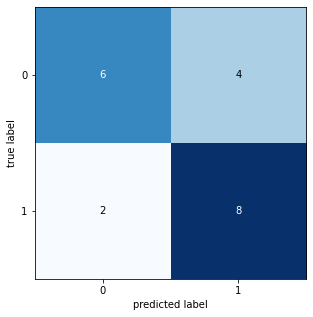

Train : [ 0  2  3  4  5  7  8  9 10 11 14 15 16 17 19 20 21 22 23 25 26 27 28 30
 31 34 35 36 37 38 39 42 43 44 45 46 47 48 49 51 52 53 54 55 56 57 58 59
 60 61 62 63 64 65 66 69 70 72 73 74 75 76 77 80 81 82 83 84 85 86 88 89
 90 91 92 95 96] Test : [ 1  6 12 13 18 24 29 32 33 40 41 50 67 68 71 78 79 87 93 94]
Y_Train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0]
Y_Test : [1 1 0 0 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Akurasi :  0.75
F1_Score :  0.7493734335839599
              precision    recall  f1-score   support

           0       0.80      0.73      0.76        11
           1       0.70      0.78      0.74         9

    accuracy                           0.75        20
   macro avg       0.75      0.75      0.75        20
weighted avg       0.76      0.75      0.75        20



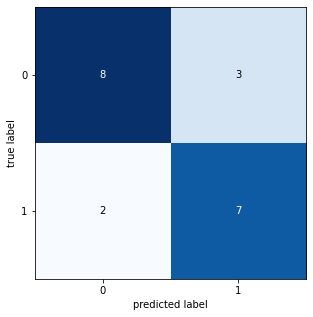

Train : [ 0  1  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 21 22 23 24 26
 28 29 32 33 34 35 36 38 40 41 42 43 44 45 46 48 49 50 51 52 53 54 55 56
 57 59 60 62 65 66 67 68 69 71 74 76 77 78 79 80 81 82 83 84 85 86 87 88
 90 91 92 93 94 96] Test : [ 2 20 25 27 30 31 37 39 47 58 61 63 64 70 72 73 75 89 95]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0]
Akurasi :  0.6842105263157895
F1_Score :  0.6833333333333333
              precision    recall  f1-score   support

           0       0.75      0.60      0.67        10
           1       0.64      0.78      0.70         9

    accuracy                           0.68        19
   macro avg       0.69      0.69      0.68        19
weighted avg       0.70      0.68      0.68        19



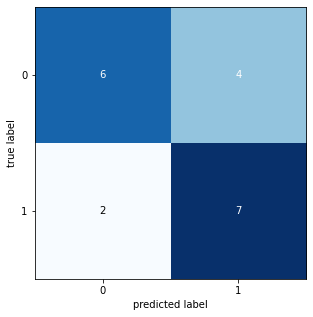

Train : [ 1  2  5  6  7  8  9 10 11 12 13 14 17 18 20 21 22 23 24 25 27 28 29 30
 31 32 33 34 35 36 37 39 40 41 42 43 44 45 47 49 50 52 53 56 57 58 59 61
 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 78 79 82 83 84 85 87 89 90
 91 92 93 94 95 96] Test : [ 0  3  4 15 16 19 26 38 46 48 51 54 55 60 77 80 81 86 88]
Y_Train : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 1 0 0 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Akurasi :  0.5789473684210527
F1_Score :  0.5681818181818181
              precision    recall  f1-score   support

           0       0.67      0.40      0.50        10
           1       0.54      0.78      0.64         9

    accuracy                           0.58        19
   macro avg       0.60      0.59      0.57        19
weighted avg       0.61      0.58      0.56        19



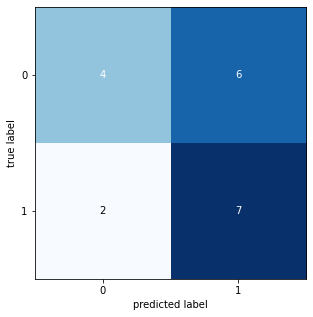

Train : [ 0  1  2  3  4  6  7  9 10 11 12 13 15 16 17 18 19 20 24 25 26 27 28 29
 30 31 32 33 34 36 37 38 39 40 41 44 46 47 48 49 50 51 52 54 55 56 57 58
 59 60 61 62 63 64 66 67 68 70 71 72 73 74 75 77 78 79 80 81 83 84 86 87
 88 89 93 94 95 96] Test : [ 5  8 14 21 22 23 35 42 43 45 53 65 69 76 82 85 90 91 92]
Y_Train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0]
Akurasi :  0.8421052631578947
F1_Score :  0.8403361344537814
              precision    recall  f1-score   support

           0       1.00      0.70      0.82        10
           1       0.75      1.00      0.86         9

    accuracy                           0.84        19
   macro avg       0.88      0.85      0.84        19
weighted avg       0.88      0.84      0.84        19



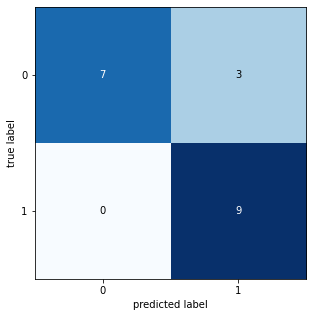

avg accuraccy Breast Cancer =  0.7110526315789474
avg F1_Score Breast Cancer =  0.707638883304518
max accuraccy Breast Cancer =  0.8421052631578947
max F1_Score Breast Cancer =  0.8403361344537814
min accuraccy Breast Cancer =  0.5789473684210527
min F1_Score Breast Cancer =  0.5681818181818181
Running Time:  39.869734531001086
gene : [0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0]
Train : [ 0  1  2  3  4  5  6  8 12 13 14 15 16 18 19 20 21 22 23 24 25 26 27 29
 30 31 32 33 35 37 38 39 40 41 42 43 45 46 47 48 50 51 53 54 55 58 60 61
 63 64 65 67 68 69 70 71 72 73 75 76 77 78 79 80 81 82 85 86 87 88 89 90
 91 92 93 94 95] Test : [ 7  9 10 11 17 28 34 36 44 49 52 56 57 59 62 66 74 83 84 96]
Y_Train : [1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 

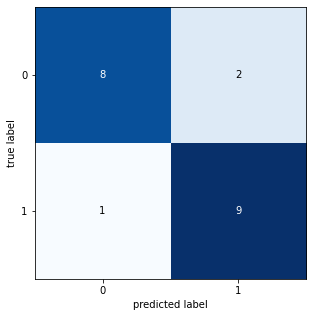

Train : [ 0  2  3  4  5  7  8  9 10 11 14 15 16 17 19 20 21 22 23 25 26 27 28 30
 31 34 35 36 37 38 39 42 43 44 45 46 47 48 49 51 52 53 54 55 56 57 58 59
 60 61 62 63 64 65 66 69 70 72 73 74 75 76 77 80 81 82 83 84 85 86 88 89
 90 91 92 95 96] Test : [ 1  6 12 13 18 24 29 32 33 40 41 50 67 68 71 78 79 87 93 94]
Y_Train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0]
Y_Test : [1 1 0 0 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Akurasi :  0.9
F1_Score :  0.898989898989899
              precision    recall  f1-score   support

           0       0.91      0.91      0.91        11
           1       0.89      0.89      0.89         9

    accuracy                           0.90        20
   macro avg       0.90      0.90      0.90        20
weighted avg       0.90      0.90      0.90        20



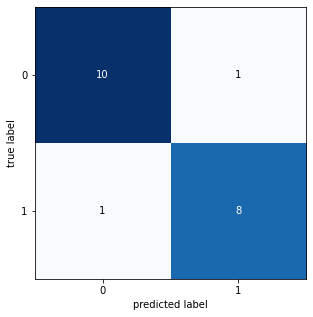

Train : [ 0  1  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 21 22 23 24 26
 28 29 32 33 34 35 36 38 40 41 42 43 44 45 46 48 49 50 51 52 53 54 55 56
 57 59 60 62 65 66 67 68 69 71 74 76 77 78 79 80 81 82 83 84 85 86 87 88
 90 91 92 93 94 96] Test : [ 2 20 25 27 30 31 37 39 47 58 61 63 64 70 72 73 75 89 95]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0]
Akurasi :  0.7368421052631579
F1_Score :  0.7368421052631577
              precision    recall  f1-score   support

           0       0.78      0.70      0.74        10
           1       0.70      0.78      0.74         9

    accuracy                           0.74        19
   macro avg       0.74      0.74      0.74        19
weighted avg       0.74      0.74      0.74        19



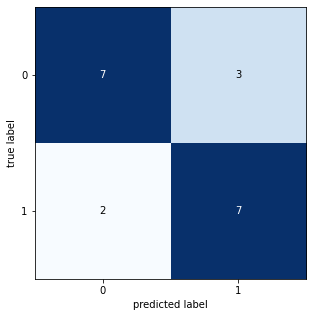

Train : [ 1  2  5  6  7  8  9 10 11 12 13 14 17 18 20 21 22 23 24 25 27 28 29 30
 31 32 33 34 35 36 37 39 40 41 42 43 44 45 47 49 50 52 53 56 57 58 59 61
 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 78 79 82 83 84 85 87 89 90
 91 92 93 94 95 96] Test : [ 0  3  4 15 16 19 26 38 46 48 51 54 55 60 77 80 81 86 88]
Y_Train : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 1 0 0 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Akurasi :  0.7368421052631579
F1_Score :  0.7368421052631577
              precision    recall  f1-score   support

           0       0.78      0.70      0.74        10
           1       0.70      0.78      0.74         9

    accuracy                           0.74        19
   macro avg       0.74      0.74      0.74        19
weighted avg       0.74      0.74      0.74        19



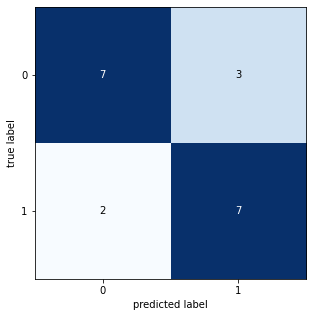

Train : [ 0  1  2  3  4  6  7  9 10 11 12 13 15 16 17 18 19 20 24 25 26 27 28 29
 30 31 32 33 34 36 37 38 39 40 41 44 46 47 48 49 50 51 52 54 55 56 57 58
 59 60 61 62 63 64 66 67 68 70 71 72 73 74 75 77 78 79 80 81 83 84 86 87
 88 89 93 94 95 96] Test : [ 5  8 14 21 22 23 35 42 43 45 53 65 69 76 82 85 90 91 92]
Y_Train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0]
Akurasi :  0.9473684210526315
F1_Score :  0.9473684210526316
              precision    recall  f1-score   support

           0       1.00      0.90      0.95        10
           1       0.90      1.00      0.95         9

    accuracy                           0.95        19
   macro avg       0.95      0.95      0.95        19
weighted avg       0.95      0.95      0.95        19



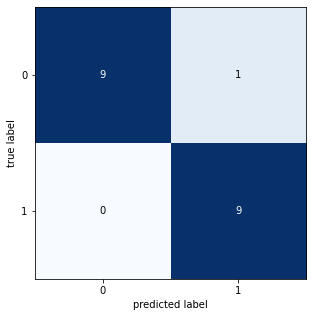

avg accuraccy Breast Cancer =  0.8342105263157895
avg F1_Score Breast Cancer =  0.8339333181438444
max accuraccy Breast Cancer =  0.9473684210526315
max F1_Score Breast Cancer =  0.9473684210526316
min accuraccy Breast Cancer =  0.7368421052631579
min F1_Score Breast Cancer =  0.7368421052631577
Running Time:  38.79854851300115
gene : [1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0]
Train : [ 0  1  2  3  4  5  6  8 12 13 14 15 16 18 19 20 21 22 23 24 25 26 27 29
 30 31 32 33 35 37 38 39 40 41 42 43 45 46 47 48 50 51 53 54 55 58 60 61
 63 64 65 67 68 69 70 71 72 73 75 76 77 78 79 80 81 82 85 86 87 88 89 90
 91 92 93 94 95] Test : [ 7  9 10 11 17 28 34 36 44 49 52 56 57 59 62 66 74 83 84 96]
Y_Train : [1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 

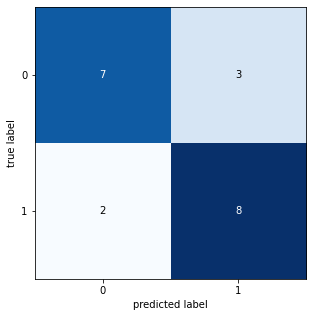

Train : [ 0  2  3  4  5  7  8  9 10 11 14 15 16 17 19 20 21 22 23 25 26 27 28 30
 31 34 35 36 37 38 39 42 43 44 45 46 47 48 49 51 52 53 54 55 56 57 58 59
 60 61 62 63 64 65 66 69 70 72 73 74 75 76 77 80 81 82 83 84 85 86 88 89
 90 91 92 95 96] Test : [ 1  6 12 13 18 24 29 32 33 40 41 50 67 68 71 78 79 87 93 94]
Y_Train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0]
Y_Test : [1 1 0 0 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Akurasi :  0.85
F1_Score :  0.8465473145780051
              precision    recall  f1-score   support

           0       0.83      0.91      0.87        11
           1       0.88      0.78      0.82         9

    accuracy                           0.85        20
   macro avg       0.85      0.84      0.85        20
weighted avg       0.85      0.85      0.85        20



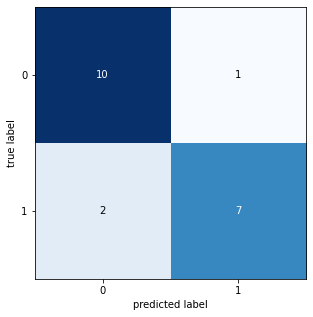

Train : [ 0  1  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 21 22 23 24 26
 28 29 32 33 34 35 36 38 40 41 42 43 44 45 46 48 49 50 51 52 53 54 55 56
 57 59 60 62 65 66 67 68 69 71 74 76 77 78 79 80 81 82 83 84 85 86 87 88
 90 91 92 93 94 96] Test : [ 2 20 25 27 30 31 37 39 47 58 61 63 64 70 72 73 75 89 95]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0]
Akurasi :  0.6842105263157895
F1_Score :  0.6833333333333333
              precision    recall  f1-score   support

           0       0.70      0.70      0.70        10
           1       0.67      0.67      0.67         9

    accuracy                           0.68        19
   macro avg       0.68      0.68      0.68        19
weighted avg       0.68      0.68      0.68        19



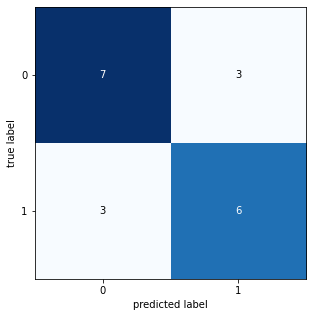

Train : [ 1  2  5  6  7  8  9 10 11 12 13 14 17 18 20 21 22 23 24 25 27 28 29 30
 31 32 33 34 35 36 37 39 40 41 42 43 44 45 47 49 50 52 53 56 57 58 59 61
 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 78 79 82 83 84 85 87 89 90
 91 92 93 94 95 96] Test : [ 0  3  4 15 16 19 26 38 46 48 51 54 55 60 77 80 81 86 88]
Y_Train : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 1 0 0 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Akurasi :  0.7894736842105263
F1_Score :  0.7888888888888888
              precision    recall  f1-score   support

           0       0.88      0.70      0.78        10
           1       0.73      0.89      0.80         9

    accuracy                           0.79        19
   macro avg       0.80      0.79      0.79        19
weighted avg       0.81      0.79      0.79        19



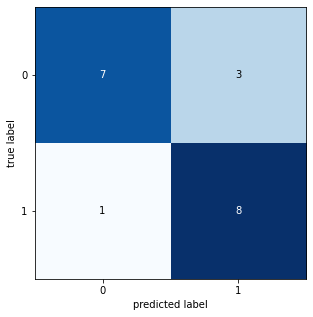

Train : [ 0  1  2  3  4  6  7  9 10 11 12 13 15 16 17 18 19 20 24 25 26 27 28 29
 30 31 32 33 34 36 37 38 39 40 41 44 46 47 48 49 50 51 52 54 55 56 57 58
 59 60 61 62 63 64 66 67 68 70 71 72 73 74 75 77 78 79 80 81 83 84 86 87
 88 89 93 94 95 96] Test : [ 5  8 14 21 22 23 35 42 43 45 53 65 69 76 82 85 90 91 92]
Y_Train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0]
Akurasi :  0.7894736842105263
F1_Score :  0.7888888888888888
              precision    recall  f1-score   support

           0       0.88      0.70      0.78        10
           1       0.73      0.89      0.80         9

    accuracy                           0.79        19
   macro avg       0.80      0.79      0.79        19
weighted avg       0.81      0.79      0.79        19



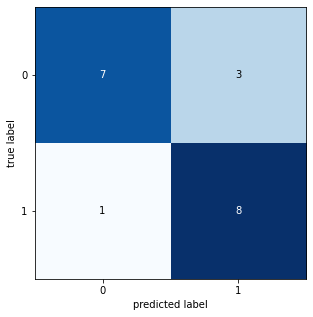

avg accuraccy Breast Cancer =  0.7726315789473684
avg F1_Score Breast Cancer =  0.7714063718546151
max accuraccy Breast Cancer =  0.85
max F1_Score Breast Cancer =  0.8465473145780051
min accuraccy Breast Cancer =  0.6842105263157895
min F1_Score Breast Cancer =  0.6833333333333333
Running Time:  39.42975272200056
gene : [0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0]
Train : [ 0  1  2  3  4  5  6  8 12 13 14 15 16 18 19 20 21 22 23 24 25 26 27 29
 30 31 32 33 35 37 38 39 40 41 42 43 45 46 47 48 50 51 53 54 55 58 60 61
 63 64 65 67 68 69 70 71 72 73 75 76 77 78 79 80 81 82 85 86 87 88 89 90
 91 92 93 94 95] Test : [ 7  9 10 11 17 28 34 36 44 49 52 56 57 59 62 66 74 83 84 96]
Y_Train : [1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 

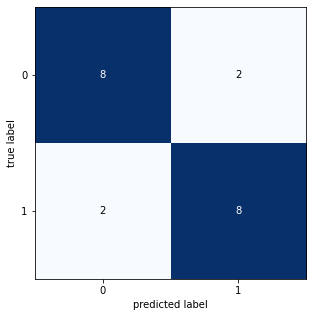

Train : [ 0  2  3  4  5  7  8  9 10 11 14 15 16 17 19 20 21 22 23 25 26 27 28 30
 31 34 35 36 37 38 39 42 43 44 45 46 47 48 49 51 52 53 54 55 56 57 58 59
 60 61 62 63 64 65 66 69 70 72 73 74 75 76 77 80 81 82 83 84 85 86 88 89
 90 91 92 95 96] Test : [ 1  6 12 13 18 24 29 32 33 40 41 50 67 68 71 78 79 87 93 94]
Y_Train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0]
Y_Test : [1 1 0 0 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Akurasi :  0.8
F1_Score :  0.7999999999999999
              precision    recall  f1-score   support

           0       0.89      0.73      0.80        11
           1       0.73      0.89      0.80         9

    accuracy                           0.80        20
   macro avg       0.81      0.81      0.80        20
weighted avg       0.82      0.80      0.80        20



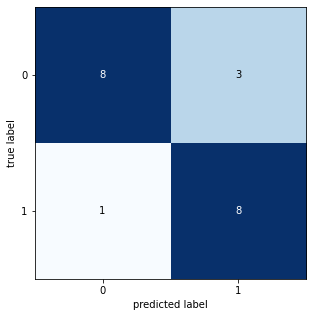

Train : [ 0  1  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 21 22 23 24 26
 28 29 32 33 34 35 36 38 40 41 42 43 44 45 46 48 49 50 51 52 53 54 55 56
 57 59 60 62 65 66 67 68 69 71 74 76 77 78 79 80 81 82 83 84 85 86 87 88
 90 91 92 93 94 96] Test : [ 2 20 25 27 30 31 37 39 47 58 61 63 64 70 72 73 75 89 95]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0]
Akurasi :  0.7894736842105263
F1_Score :  0.788888888888889
              precision    recall  f1-score   support

           0       0.80      0.80      0.80        10
           1       0.78      0.78      0.78         9

    accuracy                           0.79        19
   macro avg       0.79      0.79      0.79        19
weighted avg       0.79      0.79      0.79        19



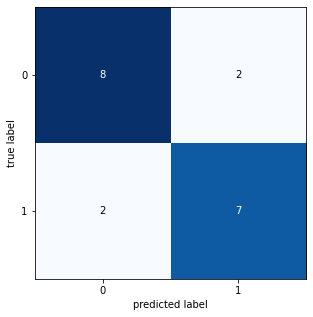

Train : [ 1  2  5  6  7  8  9 10 11 12 13 14 17 18 20 21 22 23 24 25 27 28 29 30
 31 32 33 34 35 36 37 39 40 41 42 43 44 45 47 49 50 52 53 56 57 58 59 61
 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 78 79 82 83 84 85 87 89 90
 91 92 93 94 95 96] Test : [ 0  3  4 15 16 19 26 38 46 48 51 54 55 60 77 80 81 86 88]
Y_Train : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 1 0 0 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Akurasi :  0.7894736842105263
F1_Score :  0.7888888888888888
              precision    recall  f1-score   support

           0       0.88      0.70      0.78        10
           1       0.73      0.89      0.80         9

    accuracy                           0.79        19
   macro avg       0.80      0.79      0.79        19
weighted avg       0.81      0.79      0.79        19



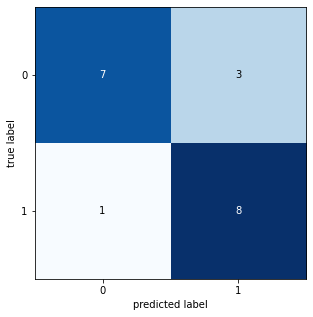

Train : [ 0  1  2  3  4  6  7  9 10 11 12 13 15 16 17 18 19 20 24 25 26 27 28 29
 30 31 32 33 34 36 37 38 39 40 41 44 46 47 48 49 50 51 52 54 55 56 57 58
 59 60 61 62 63 64 66 67 68 70 71 72 73 74 75 77 78 79 80 81 83 84 86 87
 88 89 93 94 95 96] Test : [ 5  8 14 21 22 23 35 42 43 45 53 65 69 76 82 85 90 91 92]
Y_Train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0]
Akurasi :  0.8947368421052632
F1_Score :  0.8944444444444445
              precision    recall  f1-score   support

           0       1.00      0.80      0.89        10
           1       0.82      1.00      0.90         9

    accuracy                           0.89        19
   macro avg       0.91      0.90      0.89        19
weighted avg       0.91      0.89      0.89        19



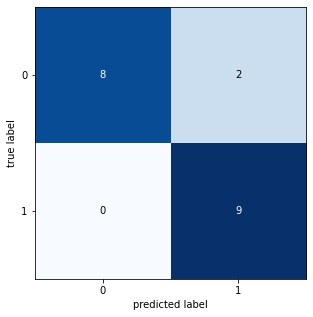

avg accuraccy Breast Cancer =  0.8147368421052631
avg F1_Score Breast Cancer =  0.8144444444444445
max accuraccy Breast Cancer =  0.8947368421052632
max F1_Score Breast Cancer =  0.8944444444444445
min accuraccy Breast Cancer =  0.7894736842105263
min F1_Score Breast Cancer =  0.7888888888888888
Running Time:  38.35306465400026
gene : [1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0]
Train : [ 0  1  2  3  4  5  6  8 12 13 14 15 16 18 19 20 21 22 23 24 25 26 27 29
 30 31 32 33 35 37 38 39 40 41 42 43 45 46 47 48 50 51 53 54 55 58 60 61
 63 64 65 67 68 69 70 71 72 73 75 76 77 78 79 80 81 82 85 86 87 88 89 90
 91 92 93 94 95] Test : [ 7  9 10 11 17 28 34 36 44 49 52 56 57 59 62 66 74 83 84 96]
Y_Train : [1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 

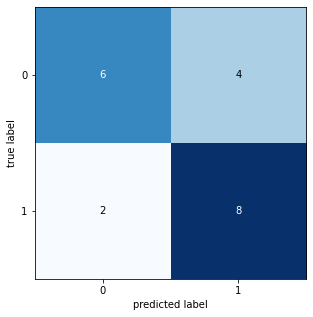

Train : [ 0  2  3  4  5  7  8  9 10 11 14 15 16 17 19 20 21 22 23 25 26 27 28 30
 31 34 35 36 37 38 39 42 43 44 45 46 47 48 49 51 52 53 54 55 56 57 58 59
 60 61 62 63 64 65 66 69 70 72 73 74 75 76 77 80 81 82 83 84 85 86 88 89
 90 91 92 95 96] Test : [ 1  6 12 13 18 24 29 32 33 40 41 50 67 68 71 78 79 87 93 94]
Y_Train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0]
Y_Test : [1 1 0 0 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Akurasi :  0.8
F1_Score :  0.797979797979798
              precision    recall  f1-score   support

           0       0.82      0.82      0.82        11
           1       0.78      0.78      0.78         9

    accuracy                           0.80        20
   macro avg       0.80      0.80      0.80        20
weighted avg       0.80      0.80      0.80        20



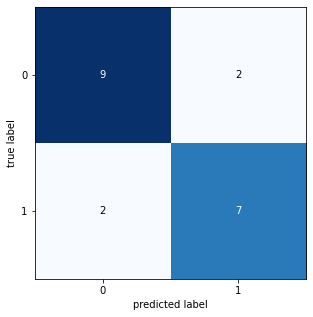

Train : [ 0  1  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 21 22 23 24 26
 28 29 32 33 34 35 36 38 40 41 42 43 44 45 46 48 49 50 51 52 53 54 55 56
 57 59 60 62 65 66 67 68 69 71 74 76 77 78 79 80 81 82 83 84 85 86 87 88
 90 91 92 93 94 96] Test : [ 2 20 25 27 30 31 37 39 47 58 61 63 64 70 72 73 75 89 95]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0]
Akurasi :  0.631578947368421
F1_Score :  0.6144927536231883
              precision    recall  f1-score   support

           0       0.62      0.80      0.70        10
           1       0.67      0.44      0.53         9

    accuracy                           0.63        19
   macro avg       0.64      0.62      0.61        19
weighted avg       0.64      0.63      0.62        19



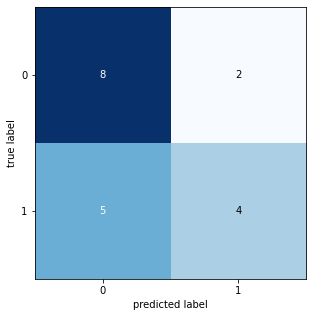

Train : [ 1  2  5  6  7  8  9 10 11 12 13 14 17 18 20 21 22 23 24 25 27 28 29 30
 31 32 33 34 35 36 37 39 40 41 42 43 44 45 47 49 50 52 53 56 57 58 59 61
 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 78 79 82 83 84 85 87 89 90
 91 92 93 94 95 96] Test : [ 0  3  4 15 16 19 26 38 46 48 51 54 55 60 77 80 81 86 88]
Y_Train : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 1 0 0 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Akurasi :  0.6842105263157895
F1_Score :  0.6833333333333333
              precision    recall  f1-score   support

           0       0.75      0.60      0.67        10
           1       0.64      0.78      0.70         9

    accuracy                           0.68        19
   macro avg       0.69      0.69      0.68        19
weighted avg       0.70      0.68      0.68        19



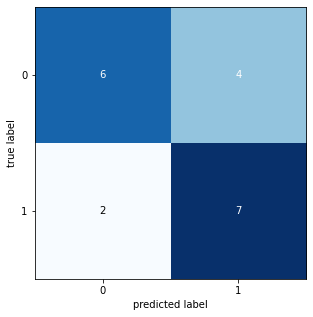

Train : [ 0  1  2  3  4  6  7  9 10 11 12 13 15 16 17 18 19 20 24 25 26 27 28 29
 30 31 32 33 34 36 37 38 39 40 41 44 46 47 48 49 50 51 52 54 55 56 57 58
 59 60 61 62 63 64 66 67 68 70 71 72 73 74 75 77 78 79 80 81 83 84 86 87
 88 89 93 94 95 96] Test : [ 5  8 14 21 22 23 35 42 43 45 53 65 69 76 82 85 90 91 92]
Y_Train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0]
Akurasi :  0.6842105263157895
F1_Score :  0.6833333333333333
              precision    recall  f1-score   support

           0       0.75      0.60      0.67        10
           1       0.64      0.78      0.70         9

    accuracy                           0.68        19
   macro avg       0.69      0.69      0.68        19
weighted avg       0.70      0.68      0.68        19



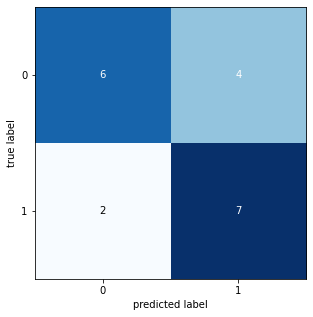

avg accuraccy Breast Cancer =  0.7
avg F1_Score Breast Cancer =  0.69522178304787
max accuraccy Breast Cancer =  0.8
max F1_Score Breast Cancer =  0.797979797979798
min accuraccy Breast Cancer =  0.631578947368421
min F1_Score Breast Cancer =  0.6144927536231883
Running Time:  38.56791531300041
gene : [0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0]
Train : [ 0  1  2  3  4  5  6  8 12 13 14 15 16 18 19 20 21 22 23 24 25 26 27 29
 30 31 32 33 35 37 38 39 40 41 42 43 45 46 47 48 50 51 53 54 55 58 60 61
 63 64 65 67 68 69 70 71 72 73 75 76 77 78 79 80 81 82 85 86 87 88 89 90
 91 92 93 94 95] Test : [ 7  9 10 11 17 28 34 36 44 49 52 56 57 59 62 66 74 83 84 96]
Y_Train : [1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 

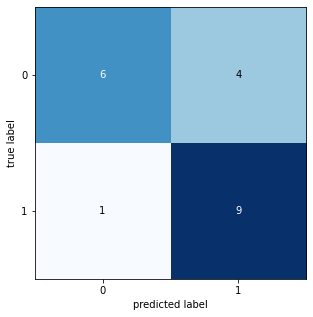

Train : [ 0  2  3  4  5  7  8  9 10 11 14 15 16 17 19 20 21 22 23 25 26 27 28 30
 31 34 35 36 37 38 39 42 43 44 45 46 47 48 49 51 52 53 54 55 56 57 58 59
 60 61 62 63 64 65 66 69 70 72 73 74 75 76 77 80 81 82 83 84 85 86 88 89
 90 91 92 95 96] Test : [ 1  6 12 13 18 24 29 32 33 40 41 50 67 68 71 78 79 87 93 94]
Y_Train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0]
Y_Test : [1 1 0 0 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Akurasi :  0.85
F1_Score :  0.849624060150376
              precision    recall  f1-score   support

           0       0.90      0.82      0.86        11
           1       0.80      0.89      0.84         9

    accuracy                           0.85        20
   macro avg       0.85      0.85      0.85        20
weighted avg       0.86      0.85      0.85        20



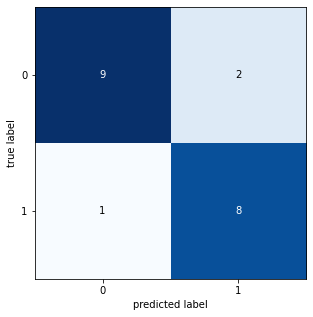

Train : [ 0  1  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 21 22 23 24 26
 28 29 32 33 34 35 36 38 40 41 42 43 44 45 46 48 49 50 51 52 53 54 55 56
 57 59 60 62 65 66 67 68 69 71 74 76 77 78 79 80 81 82 83 84 85 86 87 88
 90 91 92 93 94 96] Test : [ 2 20 25 27 30 31 37 39 47 58 61 63 64 70 72 73 75 89 95]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0]
Akurasi :  0.7368421052631579
F1_Score :  0.7338935574229692
              precision    recall  f1-score   support

           0       0.73      0.80      0.76        10
           1       0.75      0.67      0.71         9

    accuracy                           0.74        19
   macro avg       0.74      0.73      0.73        19
weighted avg       0.74      0.74      0.74        19



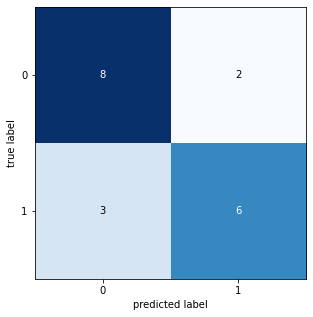

Train : [ 1  2  5  6  7  8  9 10 11 12 13 14 17 18 20 21 22 23 24 25 27 28 29 30
 31 32 33 34 35 36 37 39 40 41 42 43 44 45 47 49 50 52 53 56 57 58 59 61
 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 78 79 82 83 84 85 87 89 90
 91 92 93 94 95 96] Test : [ 0  3  4 15 16 19 26 38 46 48 51 54 55 60 77 80 81 86 88]
Y_Train : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 1 0 0 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Akurasi :  0.7368421052631579
F1_Score :  0.7338935574229692
              precision    recall  f1-score   support

           0       0.86      0.60      0.71        10
           1       0.67      0.89      0.76         9

    accuracy                           0.74        19
   macro avg       0.76      0.74      0.73        19
weighted avg       0.77      0.74      0.73        19



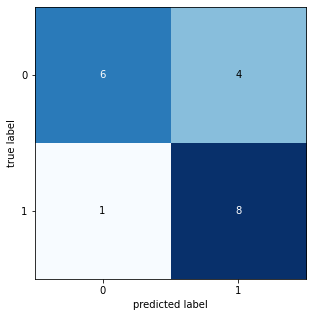

Train : [ 0  1  2  3  4  6  7  9 10 11 12 13 15 16 17 18 19 20 24 25 26 27 28 29
 30 31 32 33 34 36 37 38 39 40 41 44 46 47 48 49 50 51 52 54 55 56 57 58
 59 60 61 62 63 64 66 67 68 70 71 72 73 74 75 77 78 79 80 81 83 84 86 87
 88 89 93 94 95 96] Test : [ 5  8 14 21 22 23 35 42 43 45 53 65 69 76 82 85 90 91 92]
Y_Train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0]
Akurasi :  0.8421052631578947
F1_Score :  0.8421052631578948
              precision    recall  f1-score   support

           0       0.89      0.80      0.84        10
           1       0.80      0.89      0.84         9

    accuracy                           0.84        19
   macro avg       0.84      0.84      0.84        19
weighted avg       0.85      0.84      0.84        19



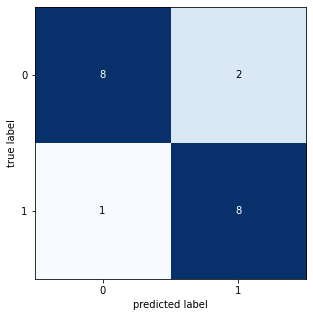

avg accuraccy Breast Cancer =  0.7831578947368422
avg F1_Score Breast Cancer =  0.7807523924901768
max accuraccy Breast Cancer =  0.85
max F1_Score Breast Cancer =  0.849624060150376
min accuraccy Breast Cancer =  0.7368421052631579
min F1_Score Breast Cancer =  0.7338935574229692
Running Time:  39.230430961999446
gene : [1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0]
Train : [ 0  1  2  3  4  5  6  8 12 13 14 15 16 18 19 20 21 22 23 24 25 26 27 29
 30 31 32 33 35 37 38 39 40 41 42 43 45 46 47 48 50 51 53 54 55 58 60 61
 63 64 65 67 68 69 70 71 72 73 75 76 77 78 79 80 81 82 85 86 87 88 89 90
 91 92 93 94 95] Test : [ 7  9 10 11 17 28 34 36 44 49 52 56 57 59 62 66 74 83 84 96]
Y_Train : [1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 

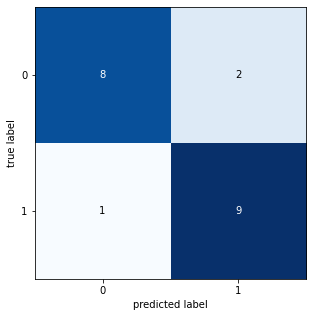

Train : [ 0  2  3  4  5  7  8  9 10 11 14 15 16 17 19 20 21 22 23 25 26 27 28 30
 31 34 35 36 37 38 39 42 43 44 45 46 47 48 49 51 52 53 54 55 56 57 58 59
 60 61 62 63 64 65 66 69 70 72 73 74 75 76 77 80 81 82 83 84 85 86 88 89
 90 91 92 95 96] Test : [ 1  6 12 13 18 24 29 32 33 40 41 50 67 68 71 78 79 87 93 94]
Y_Train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0]
Y_Test : [1 1 0 0 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Akurasi :  0.75
F1_Score :  0.7493734335839599
              precision    recall  f1-score   support

           0       0.88      0.64      0.74        11
           1       0.67      0.89      0.76         9

    accuracy                           0.75        20
   macro avg       0.77      0.76      0.75        20
weighted avg       0.78      0.75      0.75        20



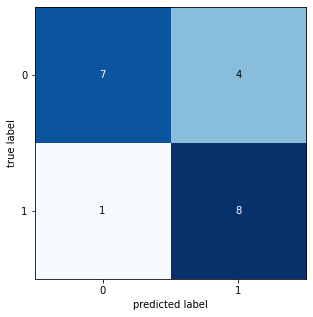

Train : [ 0  1  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 21 22 23 24 26
 28 29 32 33 34 35 36 38 40 41 42 43 44 45 46 48 49 50 51 52 53 54 55 56
 57 59 60 62 65 66 67 68 69 71 74 76 77 78 79 80 81 82 83 84 85 86 87 88
 90 91 92 93 94 96] Test : [ 2 20 25 27 30 31 37 39 47 58 61 63 64 70 72 73 75 89 95]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0]
Akurasi :  0.7368421052631579
F1_Score :  0.7338935574229692
              precision    recall  f1-score   support

           0       0.73      0.80      0.76        10
           1       0.75      0.67      0.71         9

    accuracy                           0.74        19
   macro avg       0.74      0.73      0.73        19
weighted avg       0.74      0.74      0.74        19



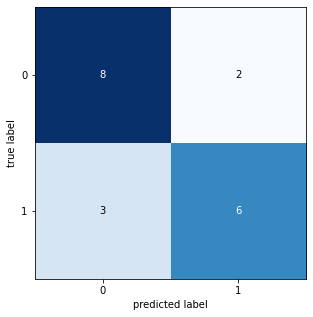

Train : [ 1  2  5  6  7  8  9 10 11 12 13 14 17 18 20 21 22 23 24 25 27 28 29 30
 31 32 33 34 35 36 37 39 40 41 42 43 44 45 47 49 50 52 53 56 57 58 59 61
 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 78 79 82 83 84 85 87 89 90
 91 92 93 94 95 96] Test : [ 0  3  4 15 16 19 26 38 46 48 51 54 55 60 77 80 81 86 88]
Y_Train : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 1 0 0 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Akurasi :  0.7894736842105263
F1_Score :  0.7888888888888888
              precision    recall  f1-score   support

           0       0.88      0.70      0.78        10
           1       0.73      0.89      0.80         9

    accuracy                           0.79        19
   macro avg       0.80      0.79      0.79        19
weighted avg       0.81      0.79      0.79        19



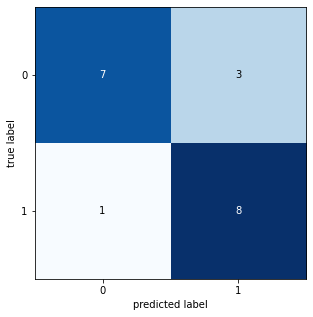

Train : [ 0  1  2  3  4  6  7  9 10 11 12 13 15 16 17 18 19 20 24 25 26 27 28 29
 30 31 32 33 34 36 37 38 39 40 41 44 46 47 48 49 50 51 52 54 55 56 57 58
 59 60 61 62 63 64 66 67 68 70 71 72 73 74 75 77 78 79 80 81 83 84 86 87
 88 89 93 94 95 96] Test : [ 5  8 14 21 22 23 35 42 43 45 53 65 69 76 82 85 90 91 92]
Y_Train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0]
Akurasi :  0.8421052631578947
F1_Score :  0.8403361344537816
              precision    recall  f1-score   support

           0       0.82      0.90      0.86        10
           1       0.88      0.78      0.82         9

    accuracy                           0.84        19
   macro avg       0.85      0.84      0.84        19
weighted avg       0.85      0.84      0.84        19



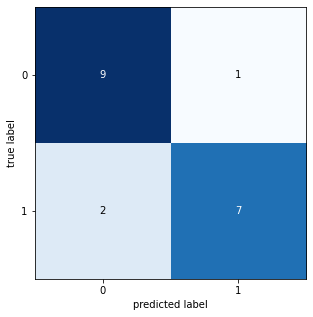

avg accuraccy Breast Cancer =  0.7936842105263159
avg F1_Score Breast Cancer =  0.7924232148999951
max accuraccy Breast Cancer =  0.85
max F1_Score Breast Cancer =  0.849624060150376
min accuraccy Breast Cancer =  0.7368421052631579
min F1_Score Breast Cancer =  0.7338935574229692
Running Time:  40.32970582999951
gene : [0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0]
Train : [ 0  1  2  3  4  5  6  8 12 13 14 15 16 18 19 20 21 22 23 24 25 26 27 29
 30 31 32 33 35 37 38 39 40 41 42 43 45 46 47 48 50 51 53 54 55 58 60 61
 63 64 65 67 68 69 70 71 72 73 75 76 77 78 79 80 81 82 85 86 87 88 89 90
 91 92 93 94 95] Test : [ 7  9 10 11 17 28 34 36 44 49 52 56 57 59 62 66 74 83 84 96]
Y_Train : [1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1

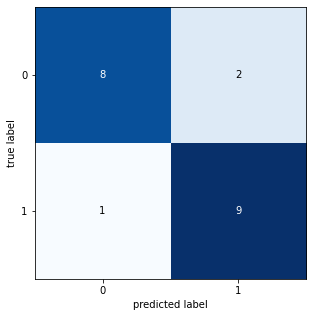

Train : [ 0  2  3  4  5  7  8  9 10 11 14 15 16 17 19 20 21 22 23 25 26 27 28 30
 31 34 35 36 37 38 39 42 43 44 45 46 47 48 49 51 52 53 54 55 56 57 58 59
 60 61 62 63 64 65 66 69 70 72 73 74 75 76 77 80 81 82 83 84 85 86 88 89
 90 91 92 95 96] Test : [ 1  6 12 13 18 24 29 32 33 40 41 50 67 68 71 78 79 87 93 94]
Y_Train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0]
Y_Test : [1 1 0 0 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Akurasi :  0.8
F1_Score :  0.7999999999999999
              precision    recall  f1-score   support

           0       0.89      0.73      0.80        11
           1       0.73      0.89      0.80         9

    accuracy                           0.80        20
   macro avg       0.81      0.81      0.80        20
weighted avg       0.82      0.80      0.80        20



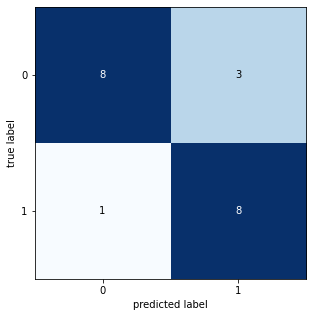

Train : [ 0  1  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 21 22 23 24 26
 28 29 32 33 34 35 36 38 40 41 42 43 44 45 46 48 49 50 51 52 53 54 55 56
 57 59 60 62 65 66 67 68 69 71 74 76 77 78 79 80 81 82 83 84 85 86 87 88
 90 91 92 93 94 96] Test : [ 2 20 25 27 30 31 37 39 47 58 61 63 64 70 72 73 75 89 95]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0]
Akurasi :  0.7368421052631579
F1_Score :  0.7338935574229692
              precision    recall  f1-score   support

           0       0.73      0.80      0.76        10
           1       0.75      0.67      0.71         9

    accuracy                           0.74        19
   macro avg       0.74      0.73      0.73        19
weighted avg       0.74      0.74      0.74        19



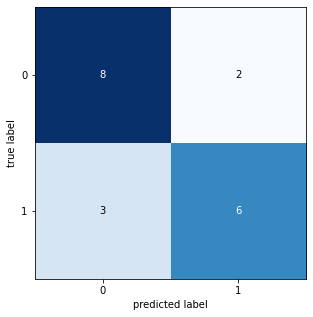

Train : [ 1  2  5  6  7  8  9 10 11 12 13 14 17 18 20 21 22 23 24 25 27 28 29 30
 31 32 33 34 35 36 37 39 40 41 42 43 44 45 47 49 50 52 53 56 57 58 59 61
 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 78 79 82 83 84 85 87 89 90
 91 92 93 94 95 96] Test : [ 0  3  4 15 16 19 26 38 46 48 51 54 55 60 77 80 81 86 88]
Y_Train : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 1 0 0 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Akurasi :  0.7894736842105263
F1_Score :  0.788888888888889
              precision    recall  f1-score   support

           0       0.80      0.80      0.80        10
           1       0.78      0.78      0.78         9

    accuracy                           0.79        19
   macro avg       0.79      0.79      0.79        19
weighted avg       0.79      0.79      0.79        19



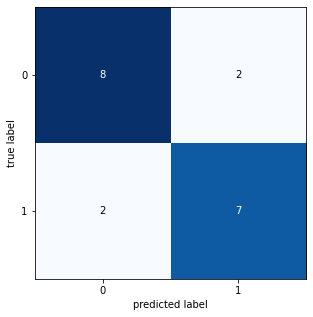

Train : [ 0  1  2  3  4  6  7  9 10 11 12 13 15 16 17 18 19 20 24 25 26 27 28 29
 30 31 32 33 34 36 37 38 39 40 41 44 46 47 48 49 50 51 52 54 55 56 57 58
 59 60 61 62 63 64 66 67 68 70 71 72 73 74 75 77 78 79 80 81 83 84 86 87
 88 89 93 94 95 96] Test : [ 5  8 14 21 22 23 35 42 43 45 53 65 69 76 82 85 90 91 92]
Y_Train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0]
Akurasi :  0.8421052631578947
F1_Score :  0.8421052631578948
              precision    recall  f1-score   support

           0       0.89      0.80      0.84        10
           1       0.80      0.89      0.84         9

    accuracy                           0.84        19
   macro avg       0.84      0.84      0.84        19
weighted avg       0.85      0.84      0.84        19



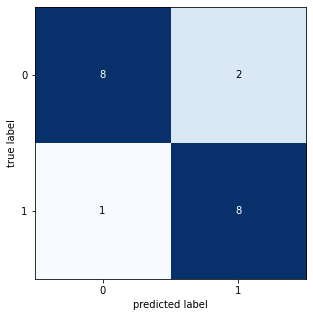

avg accuraccy Breast Cancer =  0.8036842105263158
avg F1_Score Breast Cancer =  0.8029023539240259
max accuraccy Breast Cancer =  0.85
max F1_Score Breast Cancer =  0.849624060150376
min accuraccy Breast Cancer =  0.7368421052631579
min F1_Score Breast Cancer =  0.7338935574229692
Running Time:  40.626551665998704
gene : [1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0]
Train : [ 0  1  2  3  4  5  6  8 12 13 14 15 16 18 19 20 21 22 23 24 25 26 27 29
 30 31 32 33 35 37 38 39 40 41 42 43 45 46 47 48 50 51 53 54 55 58 60 61
 63 64 65 67 68 69 70 71 72 73 75 76 77 78 79 80 81 82 85 86 87 88 89 90
 91 92 93 94 95] Test : [ 7  9 10 11 17 28 34 36 44 49 52 56 57 59 62 66 74 83 84 96]
Y_Train : [1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 

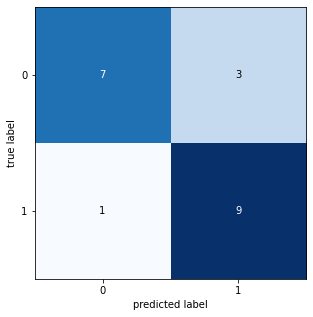

Train : [ 0  2  3  4  5  7  8  9 10 11 14 15 16 17 19 20 21 22 23 25 26 27 28 30
 31 34 35 36 37 38 39 42 43 44 45 46 47 48 49 51 52 53 54 55 56 57 58 59
 60 61 62 63 64 65 66 69 70 72 73 74 75 76 77 80 81 82 83 84 85 86 88 89
 90 91 92 95 96] Test : [ 1  6 12 13 18 24 29 32 33 40 41 50 67 68 71 78 79 87 93 94]
Y_Train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0]
Y_Test : [1 1 0 0 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Akurasi :  0.75
F1_Score :  0.7493734335839599
              precision    recall  f1-score   support

           0       0.80      0.73      0.76        11
           1       0.70      0.78      0.74         9

    accuracy                           0.75        20
   macro avg       0.75      0.75      0.75        20
weighted avg       0.76      0.75      0.75        20



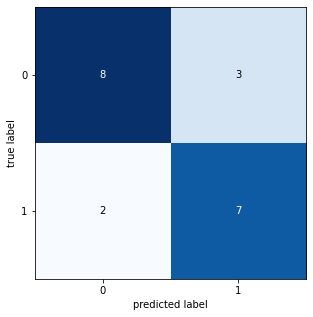

Train : [ 0  1  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 21 22 23 24 26
 28 29 32 33 34 35 36 38 40 41 42 43 44 45 46 48 49 50 51 52 53 54 55 56
 57 59 60 62 65 66 67 68 69 71 74 76 77 78 79 80 81 82 83 84 85 86 87 88
 90 91 92 93 94 96] Test : [ 2 20 25 27 30 31 37 39 47 58 61 63 64 70 72 73 75 89 95]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0]
Akurasi :  0.7894736842105263
F1_Score :  0.788888888888889
              precision    recall  f1-score   support

           0       0.80      0.80      0.80        10
           1       0.78      0.78      0.78         9

    accuracy                           0.79        19
   macro avg       0.79      0.79      0.79        19
weighted avg       0.79      0.79      0.79        19



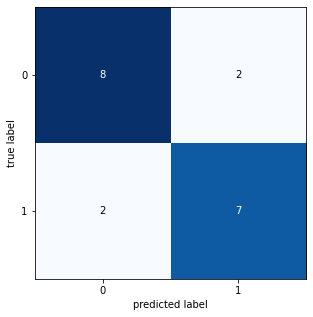

Train : [ 1  2  5  6  7  8  9 10 11 12 13 14 17 18 20 21 22 23 24 25 27 28 29 30
 31 32 33 34 35 36 37 39 40 41 42 43 44 45 47 49 50 52 53 56 57 58 59 61
 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 78 79 82 83 84 85 87 89 90
 91 92 93 94 95 96] Test : [ 0  3  4 15 16 19 26 38 46 48 51 54 55 60 77 80 81 86 88]
Y_Train : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 1 0 0 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Akurasi :  0.7368421052631579
F1_Score :  0.7338935574229692
              precision    recall  f1-score   support

           0       0.86      0.60      0.71        10
           1       0.67      0.89      0.76         9

    accuracy                           0.74        19
   macro avg       0.76      0.74      0.73        19
weighted avg       0.77      0.74      0.73        19



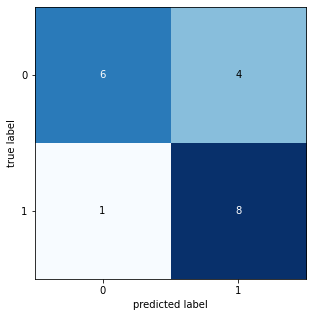

Train : [ 0  1  2  3  4  6  7  9 10 11 12 13 15 16 17 18 19 20 24 25 26 27 28 29
 30 31 32 33 34 36 37 38 39 40 41 44 46 47 48 49 50 51 52 54 55 56 57 58
 59 60 61 62 63 64 66 67 68 70 71 72 73 74 75 77 78 79 80 81 83 84 86 87
 88 89 93 94 95 96] Test : [ 5  8 14 21 22 23 35 42 43 45 53 65 69 76 82 85 90 91 92]
Y_Train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0]
Akurasi :  0.8947368421052632
F1_Score :  0.8944444444444444
              precision    recall  f1-score   support

           0       0.90      0.90      0.90        10
           1       0.89      0.89      0.89         9

    accuracy                           0.89        19
   macro avg       0.89      0.89      0.89        19
weighted avg       0.89      0.89      0.89        19



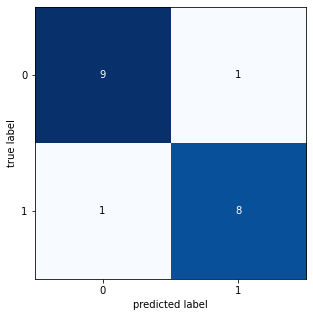

avg accuraccy Breast Cancer =  0.7942105263157895
avg F1_Score Breast Cancer =  0.7929160244640121
max accuraccy Breast Cancer =  0.8947368421052632
max F1_Score Breast Cancer =  0.8944444444444444
min accuraccy Breast Cancer =  0.7368421052631579
min F1_Score Breast Cancer =  0.7338935574229692
Running Time:  38.75167580000016
gen terbaik : [0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0]
F-1 Score terbaik : 0.8339333181438444  || Akurasi terbaik : 0.8342105263157895  || jumlah fitur : 51

Generation : 4
gene : [0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1

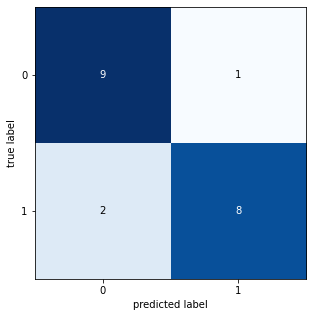

Train : [ 0  2  3  4  5  7  8  9 10 11 14 15 16 17 19 20 21 22 23 25 26 27 28 30
 31 34 35 36 37 38 39 42 43 44 45 46 47 48 49 51 52 53 54 55 56 57 58 59
 60 61 62 63 64 65 66 69 70 72 73 74 75 76 77 80 81 82 83 84 85 86 88 89
 90 91 92 95 96] Test : [ 1  6 12 13 18 24 29 32 33 40 41 50 67 68 71 78 79 87 93 94]
Y_Train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0]
Y_Test : [1 1 0 0 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Akurasi :  0.8
F1_Score :  0.7999999999999999
              precision    recall  f1-score   support

           0       0.89      0.73      0.80        11
           1       0.73      0.89      0.80         9

    accuracy                           0.80        20
   macro avg       0.81      0.81      0.80        20
weighted avg       0.82      0.80      0.80        20



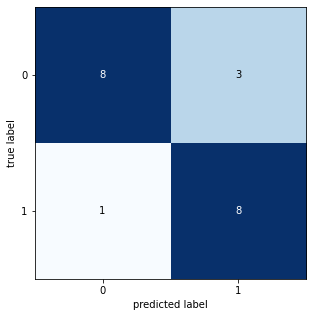

Train : [ 0  1  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 21 22 23 24 26
 28 29 32 33 34 35 36 38 40 41 42 43 44 45 46 48 49 50 51 52 53 54 55 56
 57 59 60 62 65 66 67 68 69 71 74 76 77 78 79 80 81 82 83 84 85 86 87 88
 90 91 92 93 94 96] Test : [ 2 20 25 27 30 31 37 39 47 58 61 63 64 70 72 73 75 89 95]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0]
Akurasi :  0.7894736842105263
F1_Score :  0.788888888888889
              precision    recall  f1-score   support

           0       0.80      0.80      0.80        10
           1       0.78      0.78      0.78         9

    accuracy                           0.79        19
   macro avg       0.79      0.79      0.79        19
weighted avg       0.79      0.79      0.79        19



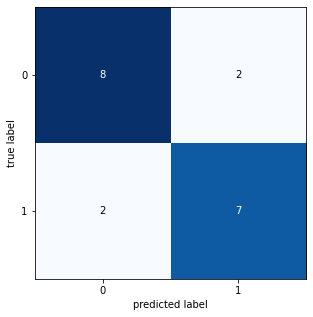

Train : [ 1  2  5  6  7  8  9 10 11 12 13 14 17 18 20 21 22 23 24 25 27 28 29 30
 31 32 33 34 35 36 37 39 40 41 42 43 44 45 47 49 50 52 53 56 57 58 59 61
 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 78 79 82 83 84 85 87 89 90
 91 92 93 94 95 96] Test : [ 0  3  4 15 16 19 26 38 46 48 51 54 55 60 77 80 81 86 88]
Y_Train : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 1 0 0 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Akurasi :  0.7894736842105263
F1_Score :  0.7888888888888888
              precision    recall  f1-score   support

           0       0.88      0.70      0.78        10
           1       0.73      0.89      0.80         9

    accuracy                           0.79        19
   macro avg       0.80      0.79      0.79        19
weighted avg       0.81      0.79      0.79        19



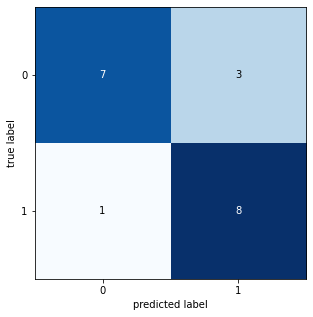

Train : [ 0  1  2  3  4  6  7  9 10 11 12 13 15 16 17 18 19 20 24 25 26 27 28 29
 30 31 32 33 34 36 37 38 39 40 41 44 46 47 48 49 50 51 52 54 55 56 57 58
 59 60 61 62 63 64 66 67 68 70 71 72 73 74 75 77 78 79 80 81 83 84 86 87
 88 89 93 94 95 96] Test : [ 5  8 14 21 22 23 35 42 43 45 53 65 69 76 82 85 90 91 92]
Y_Train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0]
Akurasi :  0.8421052631578947
F1_Score :  0.8421052631578948
              precision    recall  f1-score   support

           0       0.89      0.80      0.84        10
           1       0.80      0.89      0.84         9

    accuracy                           0.84        19
   macro avg       0.84      0.84      0.84        19
weighted avg       0.85      0.84      0.84        19



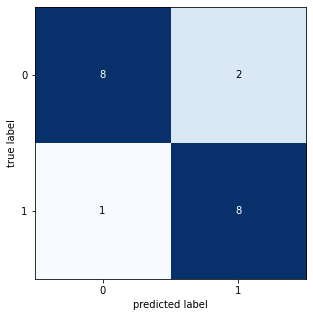

avg accuraccy Breast Cancer =  0.8142105263157895
avg F1_Score Breast Cancer =  0.8139014202172097
max accuraccy Breast Cancer =  0.85
max F1_Score Breast Cancer =  0.849624060150376
min accuraccy Breast Cancer =  0.7894736842105263
min F1_Score Breast Cancer =  0.7888888888888888
Running Time:  38.77051718199982
gene : [0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1]
Train : [ 0  1  2  3  4  5  6  8 12 13 14 15 16 18 19 20 21 22 23 24 25 26 27 29
 30 31 32 33 35 37 38 39 40 41 42 43 45 46 47 48 50 51 53 54 55 58 60 61
 63 64 65 67 68 69 70 71 72 73 75 76 77 78 79 80 81 82 85 86 87 88 89 90
 91 92 93 94 95] Test : [ 7  9 10 11 17 28 34 36 44 49 52 56 57 59 62 66 74 83 84 96]
Y_Train : [1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1

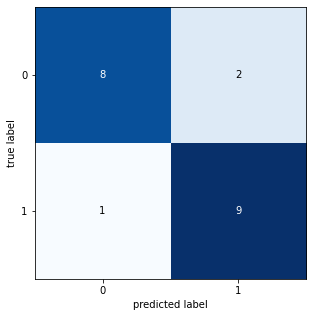

Train : [ 0  2  3  4  5  7  8  9 10 11 14 15 16 17 19 20 21 22 23 25 26 27 28 30
 31 34 35 36 37 38 39 42 43 44 45 46 47 48 49 51 52 53 54 55 56 57 58 59
 60 61 62 63 64 65 66 69 70 72 73 74 75 76 77 80 81 82 83 84 85 86 88 89
 90 91 92 95 96] Test : [ 1  6 12 13 18 24 29 32 33 40 41 50 67 68 71 78 79 87 93 94]
Y_Train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0]
Y_Test : [1 1 0 0 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Akurasi :  0.7
F1_Score :  0.696969696969697
              precision    recall  f1-score   support

           0       0.73      0.73      0.73        11
           1       0.67      0.67      0.67         9

    accuracy                           0.70        20
   macro avg       0.70      0.70      0.70        20
weighted avg       0.70      0.70      0.70        20



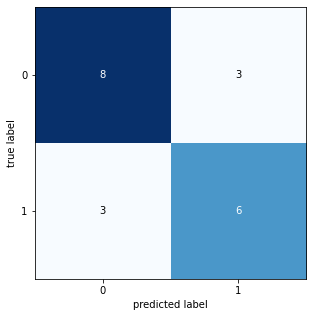

Train : [ 0  1  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 21 22 23 24 26
 28 29 32 33 34 35 36 38 40 41 42 43 44 45 46 48 49 50 51 52 53 54 55 56
 57 59 60 62 65 66 67 68 69 71 74 76 77 78 79 80 81 82 83 84 85 86 87 88
 90 91 92 93 94 96] Test : [ 2 20 25 27 30 31 37 39 47 58 61 63 64 70 72 73 75 89 95]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0]
Akurasi :  0.7894736842105263
F1_Score :  0.7888888888888888
              precision    recall  f1-score   support

           0       0.88      0.70      0.78        10
           1       0.73      0.89      0.80         9

    accuracy                           0.79        19
   macro avg       0.80      0.79      0.79        19
weighted avg       0.81      0.79      0.79        19



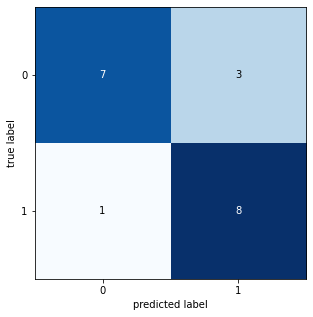

Train : [ 1  2  5  6  7  8  9 10 11 12 13 14 17 18 20 21 22 23 24 25 27 28 29 30
 31 32 33 34 35 36 37 39 40 41 42 43 44 45 47 49 50 52 53 56 57 58 59 61
 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 78 79 82 83 84 85 87 89 90
 91 92 93 94 95 96] Test : [ 0  3  4 15 16 19 26 38 46 48 51 54 55 60 77 80 81 86 88]
Y_Train : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 1 0 0 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Akurasi :  0.6842105263157895
F1_Score :  0.6833333333333333
              precision    recall  f1-score   support

           0       0.75      0.60      0.67        10
           1       0.64      0.78      0.70         9

    accuracy                           0.68        19
   macro avg       0.69      0.69      0.68        19
weighted avg       0.70      0.68      0.68        19



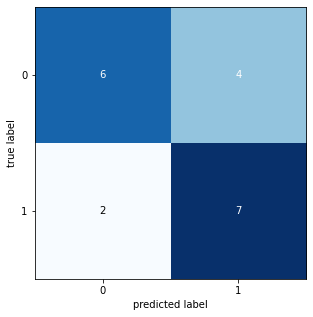

Train : [ 0  1  2  3  4  6  7  9 10 11 12 13 15 16 17 18 19 20 24 25 26 27 28 29
 30 31 32 33 34 36 37 38 39 40 41 44 46 47 48 49 50 51 52 54 55 56 57 58
 59 60 61 62 63 64 66 67 68 70 71 72 73 74 75 77 78 79 80 81 83 84 86 87
 88 89 93 94 95 96] Test : [ 5  8 14 21 22 23 35 42 43 45 53 65 69 76 82 85 90 91 92]
Y_Train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0]
Akurasi :  0.8947368421052632
F1_Score :  0.8944444444444444
              precision    recall  f1-score   support

           0       0.90      0.90      0.90        10
           1       0.89      0.89      0.89         9

    accuracy                           0.89        19
   macro avg       0.89      0.89      0.89        19
weighted avg       0.89      0.89      0.89        19



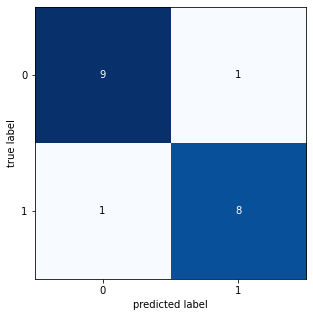

avg accuraccy Breast Cancer =  0.7836842105263158
avg F1_Score Breast Cancer =  0.7826520847573479
max accuraccy Breast Cancer =  0.8947368421052632
max F1_Score Breast Cancer =  0.8944444444444444
min accuraccy Breast Cancer =  0.6842105263157895
min F1_Score Breast Cancer =  0.6833333333333333
Running Time:  39.74782603600033
gene : [0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0]
Train : [ 0  1  2  3  4  5  6  8 12 13 14 15 16 18 19 20 21 22 23 24 25 26 27 29
 30 31 32 33 35 37 38 39 40 41 42 43 45 46 47 48 50 51 53 54 55 58 60 61
 63 64 65 67 68 69 70 71 72 73 75 76 77 78 79 80 81 82 85 86 87 88 89 90
 91 92 93 94 95] Test : [ 7  9 10 11 17 28 34 36 44 49 52 56 57 59 62 66 74 83 84 96]
Y_Train : [1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 

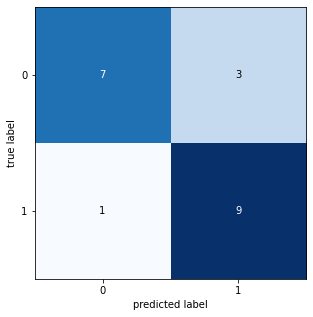

Train : [ 0  2  3  4  5  7  8  9 10 11 14 15 16 17 19 20 21 22 23 25 26 27 28 30
 31 34 35 36 37 38 39 42 43 44 45 46 47 48 49 51 52 53 54 55 56 57 58 59
 60 61 62 63 64 65 66 69 70 72 73 74 75 76 77 80 81 82 83 84 85 86 88 89
 90 91 92 95 96] Test : [ 1  6 12 13 18 24 29 32 33 40 41 50 67 68 71 78 79 87 93 94]
Y_Train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0]
Y_Test : [1 1 0 0 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Akurasi :  0.75
F1_Score :  0.7493734335839599
              precision    recall  f1-score   support

           0       0.88      0.64      0.74        11
           1       0.67      0.89      0.76         9

    accuracy                           0.75        20
   macro avg       0.77      0.76      0.75        20
weighted avg       0.78      0.75      0.75        20



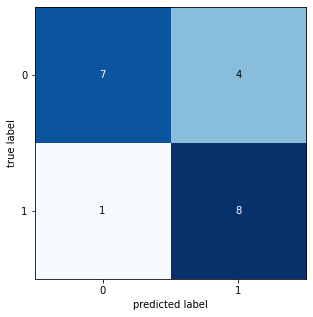

Train : [ 0  1  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 21 22 23 24 26
 28 29 32 33 34 35 36 38 40 41 42 43 44 45 46 48 49 50 51 52 53 54 55 56
 57 59 60 62 65 66 67 68 69 71 74 76 77 78 79 80 81 82 83 84 85 86 87 88
 90 91 92 93 94 96] Test : [ 2 20 25 27 30 31 37 39 47 58 61 63 64 70 72 73 75 89 95]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0]
Akurasi :  0.7894736842105263
F1_Score :  0.788888888888889
              precision    recall  f1-score   support

           0       0.80      0.80      0.80        10
           1       0.78      0.78      0.78         9

    accuracy                           0.79        19
   macro avg       0.79      0.79      0.79        19
weighted avg       0.79      0.79      0.79        19



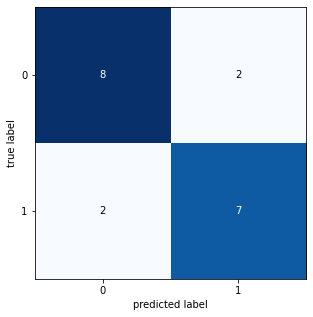

Train : [ 1  2  5  6  7  8  9 10 11 12 13 14 17 18 20 21 22 23 24 25 27 28 29 30
 31 32 33 34 35 36 37 39 40 41 42 43 44 45 47 49 50 52 53 56 57 58 59 61
 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 78 79 82 83 84 85 87 89 90
 91 92 93 94 95 96] Test : [ 0  3  4 15 16 19 26 38 46 48 51 54 55 60 77 80 81 86 88]
Y_Train : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 1 0 0 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Akurasi :  0.7894736842105263
F1_Score :  0.7888888888888888
              precision    recall  f1-score   support

           0       0.88      0.70      0.78        10
           1       0.73      0.89      0.80         9

    accuracy                           0.79        19
   macro avg       0.80      0.79      0.79        19
weighted avg       0.81      0.79      0.79        19



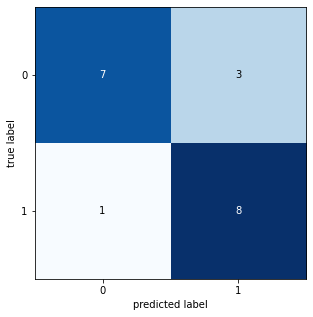

Train : [ 0  1  2  3  4  6  7  9 10 11 12 13 15 16 17 18 19 20 24 25 26 27 28 29
 30 31 32 33 34 36 37 38 39 40 41 44 46 47 48 49 50 51 52 54 55 56 57 58
 59 60 61 62 63 64 66 67 68 70 71 72 73 74 75 77 78 79 80 81 83 84 86 87
 88 89 93 94 95 96] Test : [ 5  8 14 21 22 23 35 42 43 45 53 65 69 76 82 85 90 91 92]
Y_Train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0]
Akurasi :  0.8947368421052632
F1_Score :  0.8944444444444445
              precision    recall  f1-score   support

           0       1.00      0.80      0.89        10
           1       0.82      1.00      0.90         9

    accuracy                           0.89        19
   macro avg       0.91      0.90      0.89        19
weighted avg       0.91      0.89      0.89        19



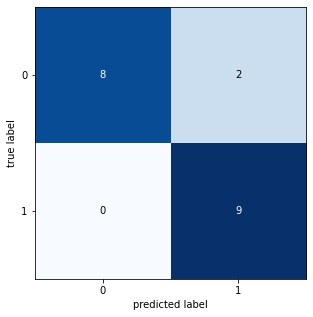

avg accuraccy Breast Cancer =  0.8047368421052632
avg F1_Score Breast Cancer =  0.803915090757196
max accuraccy Breast Cancer =  0.8947368421052632
max F1_Score Breast Cancer =  0.8944444444444445
min accuraccy Breast Cancer =  0.75
min F1_Score Breast Cancer =  0.7493734335839599
Running Time:  40.10811461999947
gene : [1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0]
Train : [ 0  1  2  3  4  5  6  8 12 13 14 15 16 18 19 20 21 22 23 24 25 26 27 29
 30 31 32 33 35 37 38 39 40 41 42 43 45 46 47 48 50 51 53 54 55 58 60 61
 63 64 65 67 68 69 70 71 72 73 75 76 77 78 79 80 81 82 85 86 87 88 89 90
 91 92 93 94 95] Test : [ 7  9 10 11 17 28 34 36 44 49 52 56 57 59 62 66 74 83 84 96]
Y_Train : [1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1

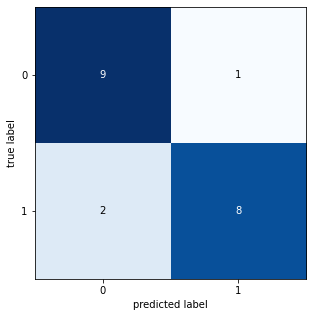

Train : [ 0  2  3  4  5  7  8  9 10 11 14 15 16 17 19 20 21 22 23 25 26 27 28 30
 31 34 35 36 37 38 39 42 43 44 45 46 47 48 49 51 52 53 54 55 56 57 58 59
 60 61 62 63 64 65 66 69 70 72 73 74 75 76 77 80 81 82 83 84 85 86 88 89
 90 91 92 95 96] Test : [ 1  6 12 13 18 24 29 32 33 40 41 50 67 68 71 78 79 87 93 94]
Y_Train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0]
Y_Test : [1 1 0 0 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Akurasi :  0.8
F1_Score :  0.797979797979798
              precision    recall  f1-score   support

           0       0.82      0.82      0.82        11
           1       0.78      0.78      0.78         9

    accuracy                           0.80        20
   macro avg       0.80      0.80      0.80        20
weighted avg       0.80      0.80      0.80        20



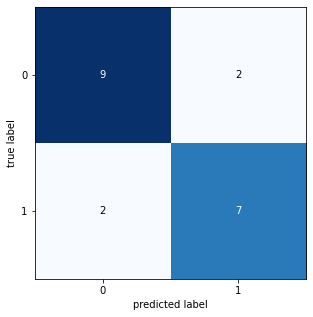

Train : [ 0  1  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 21 22 23 24 26
 28 29 32 33 34 35 36 38 40 41 42 43 44 45 46 48 49 50 51 52 53 54 55 56
 57 59 60 62 65 66 67 68 69 71 74 76 77 78 79 80 81 82 83 84 85 86 87 88
 90 91 92 93 94 96] Test : [ 2 20 25 27 30 31 37 39 47 58 61 63 64 70 72 73 75 89 95]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0]
Akurasi :  0.7368421052631579
F1_Score :  0.7368421052631577
              precision    recall  f1-score   support

           0       0.78      0.70      0.74        10
           1       0.70      0.78      0.74         9

    accuracy                           0.74        19
   macro avg       0.74      0.74      0.74        19
weighted avg       0.74      0.74      0.74        19



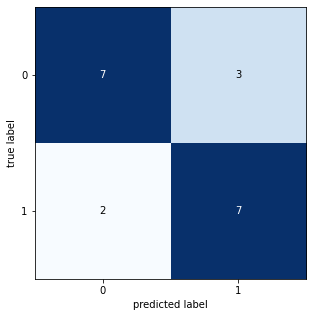

Train : [ 1  2  5  6  7  8  9 10 11 12 13 14 17 18 20 21 22 23 24 25 27 28 29 30
 31 32 33 34 35 36 37 39 40 41 42 43 44 45 47 49 50 52 53 56 57 58 59 61
 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 78 79 82 83 84 85 87 89 90
 91 92 93 94 95 96] Test : [ 0  3  4 15 16 19 26 38 46 48 51 54 55 60 77 80 81 86 88]
Y_Train : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 1 0 0 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Akurasi :  0.7894736842105263
F1_Score :  0.7888888888888888
              precision    recall  f1-score   support

           0       0.88      0.70      0.78        10
           1       0.73      0.89      0.80         9

    accuracy                           0.79        19
   macro avg       0.80      0.79      0.79        19
weighted avg       0.81      0.79      0.79        19



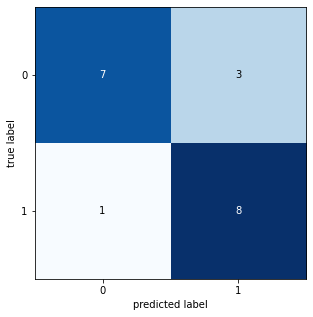

Train : [ 0  1  2  3  4  6  7  9 10 11 12 13 15 16 17 18 19 20 24 25 26 27 28 29
 30 31 32 33 34 36 37 38 39 40 41 44 46 47 48 49 50 51 52 54 55 56 57 58
 59 60 61 62 63 64 66 67 68 70 71 72 73 74 75 77 78 79 80 81 83 84 86 87
 88 89 93 94 95 96] Test : [ 5  8 14 21 22 23 35 42 43 45 53 65 69 76 82 85 90 91 92]
Y_Train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0]
Akurasi :  0.9473684210526315
F1_Score :  0.9473684210526316
              precision    recall  f1-score   support

           0       1.00      0.90      0.95        10
           1       0.90      1.00      0.95         9

    accuracy                           0.95        19
   macro avg       0.95      0.95      0.95        19
weighted avg       0.95      0.95      0.95        19



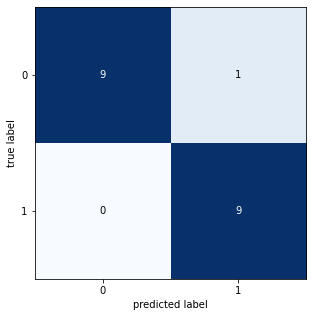

avg accuraccy Breast Cancer =  0.8247368421052632
avg F1_Score Breast Cancer =  0.8241406546669705
max accuraccy Breast Cancer =  0.9473684210526315
max F1_Score Breast Cancer =  0.9473684210526316
min accuraccy Breast Cancer =  0.7368421052631579
min F1_Score Breast Cancer =  0.7368421052631577
Running Time:  40.22546945199974
gene : [0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0]
Train : [ 0  1  2  3  4  5  6  8 12 13 14 15 16 18 19 20 21 22 23 24 25 26 27 29
 30 31 32 33 35 37 38 39 40 41 42 43 45 46 47 48 50 51 53 54 55 58 60 61
 63 64 65 67 68 69 70 71 72 73 75 76 77 78 79 80 81 82 85 86 87 88 89 90
 91 92 93 94 95] Test : [ 7  9 10 11 17 28 34 36 44 49 52 56 57 59 62 66 74 83 84 96]
Y_Train : [1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 

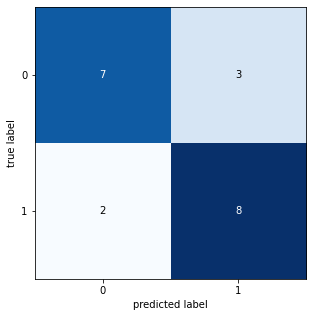

Train : [ 0  2  3  4  5  7  8  9 10 11 14 15 16 17 19 20 21 22 23 25 26 27 28 30
 31 34 35 36 37 38 39 42 43 44 45 46 47 48 49 51 52 53 54 55 56 57 58 59
 60 61 62 63 64 65 66 69 70 72 73 74 75 76 77 80 81 82 83 84 85 86 88 89
 90 91 92 95 96] Test : [ 1  6 12 13 18 24 29 32 33 40 41 50 67 68 71 78 79 87 93 94]
Y_Train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0]
Y_Test : [1 1 0 0 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Akurasi :  0.8
F1_Score :  0.7999999999999999
              precision    recall  f1-score   support

           0       0.89      0.73      0.80        11
           1       0.73      0.89      0.80         9

    accuracy                           0.80        20
   macro avg       0.81      0.81      0.80        20
weighted avg       0.82      0.80      0.80        20



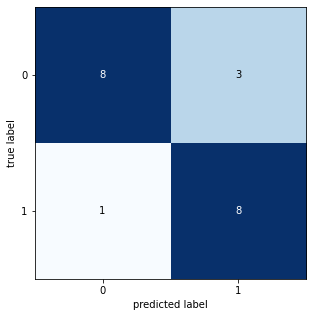

Train : [ 0  1  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 21 22 23 24 26
 28 29 32 33 34 35 36 38 40 41 42 43 44 45 46 48 49 50 51 52 53 54 55 56
 57 59 60 62 65 66 67 68 69 71 74 76 77 78 79 80 81 82 83 84 85 86 87 88
 90 91 92 93 94 96] Test : [ 2 20 25 27 30 31 37 39 47 58 61 63 64 70 72 73 75 89 95]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0]
Akurasi :  0.7894736842105263
F1_Score :  0.788888888888889
              precision    recall  f1-score   support

           0       0.80      0.80      0.80        10
           1       0.78      0.78      0.78         9

    accuracy                           0.79        19
   macro avg       0.79      0.79      0.79        19
weighted avg       0.79      0.79      0.79        19



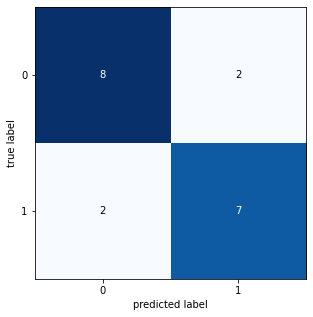

Train : [ 1  2  5  6  7  8  9 10 11 12 13 14 17 18 20 21 22 23 24 25 27 28 29 30
 31 32 33 34 35 36 37 39 40 41 42 43 44 45 47 49 50 52 53 56 57 58 59 61
 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 78 79 82 83 84 85 87 89 90
 91 92 93 94 95 96] Test : [ 0  3  4 15 16 19 26 38 46 48 51 54 55 60 77 80 81 86 88]
Y_Train : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 1 0 0 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Akurasi :  0.7894736842105263
F1_Score :  0.7888888888888888
              precision    recall  f1-score   support

           0       0.88      0.70      0.78        10
           1       0.73      0.89      0.80         9

    accuracy                           0.79        19
   macro avg       0.80      0.79      0.79        19
weighted avg       0.81      0.79      0.79        19



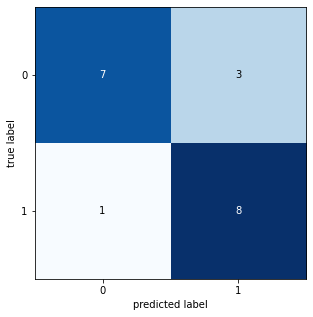

Train : [ 0  1  2  3  4  6  7  9 10 11 12 13 15 16 17 18 19 20 24 25 26 27 28 29
 30 31 32 33 34 36 37 38 39 40 41 44 46 47 48 49 50 51 52 54 55 56 57 58
 59 60 61 62 63 64 66 67 68 70 71 72 73 74 75 77 78 79 80 81 83 84 86 87
 88 89 93 94 95 96] Test : [ 5  8 14 21 22 23 35 42 43 45 53 65 69 76 82 85 90 91 92]
Y_Train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0]
Akurasi :  0.8421052631578947
F1_Score :  0.8403361344537814
              precision    recall  f1-score   support

           0       1.00      0.70      0.82        10
           1       0.75      1.00      0.86         9

    accuracy                           0.84        19
   macro avg       0.88      0.85      0.84        19
weighted avg       0.88      0.84      0.84        19



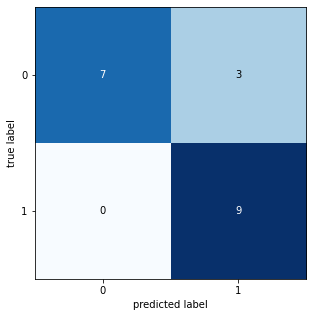

avg accuraccy Breast Cancer =  0.7942105263157895
avg F1_Score Breast Cancer =  0.7934974691631037
max accuraccy Breast Cancer =  0.8421052631578947
max F1_Score Breast Cancer =  0.8403361344537814
min accuraccy Breast Cancer =  0.75
min F1_Score Breast Cancer =  0.7493734335839599
Running Time:  39.901549917998636
gene : [0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0]
Train : [ 0  1  2  3  4  5  6  8 12 13 14 15 16 18 19 20 21 22 23 24 25 26 27 29
 30 31 32 33 35 37 38 39 40 41 42 43 45 46 47 48 50 51 53 54 55 58 60 61
 63 64 65 67 68 69 70 71 72 73 75 76 77 78 79 80 81 82 85 86 87 88 89 90
 91 92 93 94 95] Test : [ 7  9 10 11 17 28 34 36 44 49 52 56 57 59 62 66 74 83 84 96]
Y_Train : [1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1

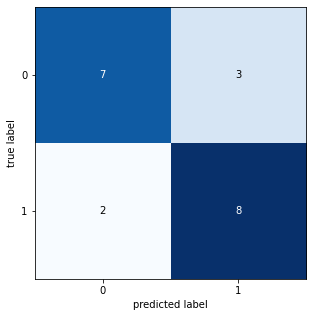

Train : [ 0  2  3  4  5  7  8  9 10 11 14 15 16 17 19 20 21 22 23 25 26 27 28 30
 31 34 35 36 37 38 39 42 43 44 45 46 47 48 49 51 52 53 54 55 56 57 58 59
 60 61 62 63 64 65 66 69 70 72 73 74 75 76 77 80 81 82 83 84 85 86 88 89
 90 91 92 95 96] Test : [ 1  6 12 13 18 24 29 32 33 40 41 50 67 68 71 78 79 87 93 94]
Y_Train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0]
Y_Test : [1 1 0 0 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Akurasi :  0.7
F1_Score :  0.696969696969697
              precision    recall  f1-score   support

           0       0.73      0.73      0.73        11
           1       0.67      0.67      0.67         9

    accuracy                           0.70        20
   macro avg       0.70      0.70      0.70        20
weighted avg       0.70      0.70      0.70        20



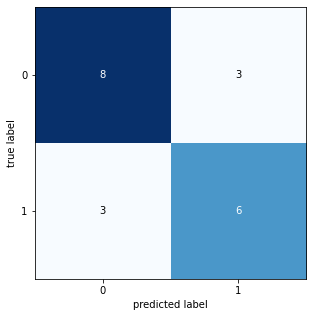

Train : [ 0  1  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 21 22 23 24 26
 28 29 32 33 34 35 36 38 40 41 42 43 44 45 46 48 49 50 51 52 53 54 55 56
 57 59 60 62 65 66 67 68 69 71 74 76 77 78 79 80 81 82 83 84 85 86 87 88
 90 91 92 93 94 96] Test : [ 2 20 25 27 30 31 37 39 47 58 61 63 64 70 72 73 75 89 95]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0]
Akurasi :  0.6842105263157895
F1_Score :  0.6833333333333333
              precision    recall  f1-score   support

           0       0.70      0.70      0.70        10
           1       0.67      0.67      0.67         9

    accuracy                           0.68        19
   macro avg       0.68      0.68      0.68        19
weighted avg       0.68      0.68      0.68        19



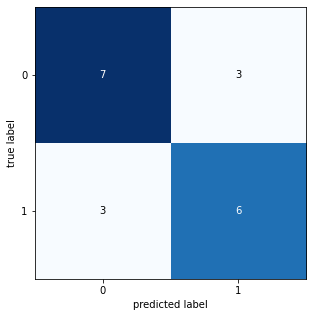

Train : [ 1  2  5  6  7  8  9 10 11 12 13 14 17 18 20 21 22 23 24 25 27 28 29 30
 31 32 33 34 35 36 37 39 40 41 42 43 44 45 47 49 50 52 53 56 57 58 59 61
 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 78 79 82 83 84 85 87 89 90
 91 92 93 94 95 96] Test : [ 0  3  4 15 16 19 26 38 46 48 51 54 55 60 77 80 81 86 88]
Y_Train : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 1 0 0 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Akurasi :  0.631578947368421
F1_Score :  0.6274509803921569
              precision    recall  f1-score   support

           0       0.71      0.50      0.59        10
           1       0.58      0.78      0.67         9

    accuracy                           0.63        19
   macro avg       0.65      0.64      0.63        19
weighted avg       0.65      0.63      0.63        19



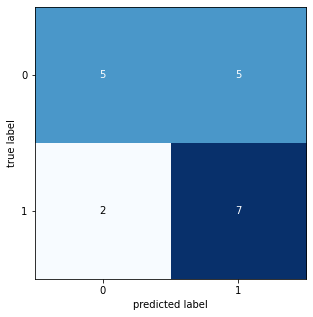

Train : [ 0  1  2  3  4  6  7  9 10 11 12 13 15 16 17 18 19 20 24 25 26 27 28 29
 30 31 32 33 34 36 37 38 39 40 41 44 46 47 48 49 50 51 52 54 55 56 57 58
 59 60 61 62 63 64 66 67 68 70 71 72 73 74 75 77 78 79 80 81 83 84 86 87
 88 89 93 94 95 96] Test : [ 5  8 14 21 22 23 35 42 43 45 53 65 69 76 82 85 90 91 92]
Y_Train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0]
Akurasi :  0.7894736842105263
F1_Score :  0.7888888888888888
              precision    recall  f1-score   support

           0       0.88      0.70      0.78        10
           1       0.73      0.89      0.80         9

    accuracy                           0.79        19
   macro avg       0.80      0.79      0.79        19
weighted avg       0.81      0.79      0.79        19



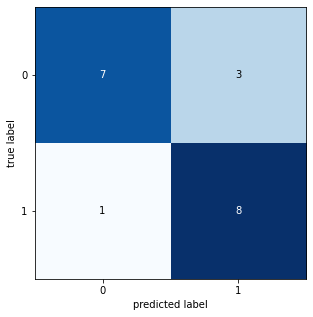

avg accuraccy Breast Cancer =  0.7110526315789475
avg F1_Score Breast Cancer =  0.7092032666336071
max accuraccy Breast Cancer =  0.7894736842105263
max F1_Score Breast Cancer =  0.7888888888888888
min accuraccy Breast Cancer =  0.631578947368421
min F1_Score Breast Cancer =  0.6274509803921569
Running Time:  38.76940452100098
gene : [0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0]
Train : [ 0  1  2  3  4  5  6  8 12 13 14 15 16 18 19 20 21 22 23 24 25 26 27 29
 30 31 32 33 35 37 38 39 40 41 42 43 45 46 47 48 50 51 53 54 55 58 60 61
 63 64 65 67 68 69 70 71 72 73 75 76 77 78 79 80 81 82 85 86 87 88 89 90
 91 92 93 94 95] Test : [ 7  9 10 11 17 28 34 36 44 49 52 56 57 59 62 66 74 83 84 96]
Y_Train : [1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1

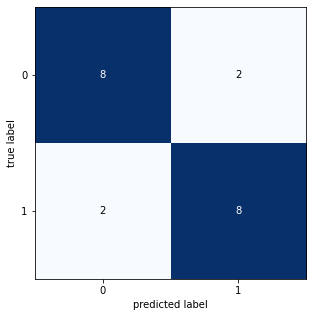

Train : [ 0  2  3  4  5  7  8  9 10 11 14 15 16 17 19 20 21 22 23 25 26 27 28 30
 31 34 35 36 37 38 39 42 43 44 45 46 47 48 49 51 52 53 54 55 56 57 58 59
 60 61 62 63 64 65 66 69 70 72 73 74 75 76 77 80 81 82 83 84 85 86 88 89
 90 91 92 95 96] Test : [ 1  6 12 13 18 24 29 32 33 40 41 50 67 68 71 78 79 87 93 94]
Y_Train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0]
Y_Test : [1 1 0 0 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Akurasi :  0.7
F1_Score :  0.7000000000000001
              precision    recall  f1-score   support

           0       0.78      0.64      0.70        11
           1       0.64      0.78      0.70         9

    accuracy                           0.70        20
   macro avg       0.71      0.71      0.70        20
weighted avg       0.71      0.70      0.70        20



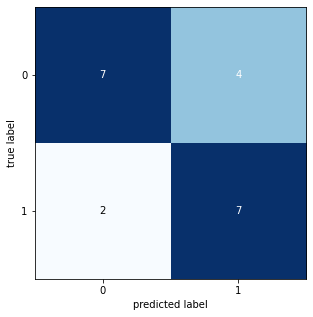

Train : [ 0  1  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 21 22 23 24 26
 28 29 32 33 34 35 36 38 40 41 42 43 44 45 46 48 49 50 51 52 53 54 55 56
 57 59 60 62 65 66 67 68 69 71 74 76 77 78 79 80 81 82 83 84 85 86 87 88
 90 91 92 93 94 96] Test : [ 2 20 25 27 30 31 37 39 47 58 61 63 64 70 72 73 75 89 95]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0]
Akurasi :  0.8421052631578947
F1_Score :  0.8421052631578948
              precision    recall  f1-score   support

           0       0.89      0.80      0.84        10
           1       0.80      0.89      0.84         9

    accuracy                           0.84        19
   macro avg       0.84      0.84      0.84        19
weighted avg       0.85      0.84      0.84        19



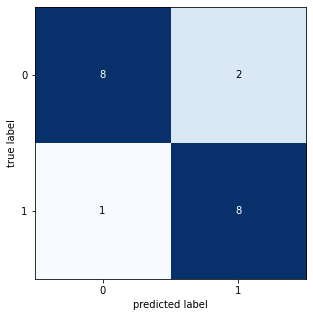

Train : [ 1  2  5  6  7  8  9 10 11 12 13 14 17 18 20 21 22 23 24 25 27 28 29 30
 31 32 33 34 35 36 37 39 40 41 42 43 44 45 47 49 50 52 53 56 57 58 59 61
 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 78 79 82 83 84 85 87 89 90
 91 92 93 94 95 96] Test : [ 0  3  4 15 16 19 26 38 46 48 51 54 55 60 77 80 81 86 88]
Y_Train : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 1 0 0 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Akurasi :  0.7368421052631579
F1_Score :  0.7368421052631577
              precision    recall  f1-score   support

           0       0.78      0.70      0.74        10
           1       0.70      0.78      0.74         9

    accuracy                           0.74        19
   macro avg       0.74      0.74      0.74        19
weighted avg       0.74      0.74      0.74        19



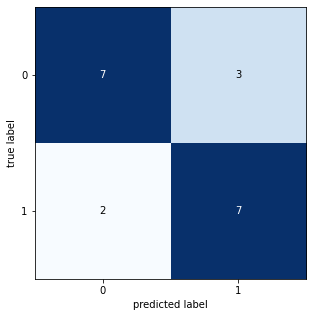

Train : [ 0  1  2  3  4  6  7  9 10 11 12 13 15 16 17 18 19 20 24 25 26 27 28 29
 30 31 32 33 34 36 37 38 39 40 41 44 46 47 48 49 50 51 52 54 55 56 57 58
 59 60 61 62 63 64 66 67 68 70 71 72 73 74 75 77 78 79 80 81 83 84 86 87
 88 89 93 94 95 96] Test : [ 5  8 14 21 22 23 35 42 43 45 53 65 69 76 82 85 90 91 92]
Y_Train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0]
Akurasi :  0.8947368421052632
F1_Score :  0.8944444444444444
              precision    recall  f1-score   support

           0       0.90      0.90      0.90        10
           1       0.89      0.89      0.89         9

    accuracy                           0.89        19
   macro avg       0.89      0.89      0.89        19
weighted avg       0.89      0.89      0.89        19



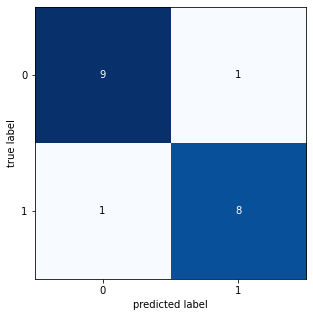

avg accuraccy Breast Cancer =  0.7947368421052632
avg F1_Score Breast Cancer =  0.7946783625730995
max accuraccy Breast Cancer =  0.8947368421052632
max F1_Score Breast Cancer =  0.8944444444444444
min accuraccy Breast Cancer =  0.7
min F1_Score Breast Cancer =  0.7000000000000001
Running Time:  36.816681309999694
gene : [1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0]
Train : [ 0  1  2  3  4  5  6  8 12 13 14 15 16 18 19 20 21 22 23 24 25 26 27 29
 30 31 32 33 35 37 38 39 40 41 42 43 45 46 47 48 50 51 53 54 55 58 60 61
 63 64 65 67 68 69 70 71 72 73 75 76 77 78 79 80 81 82 85 86 87 88 89 90
 91 92 93 94 95] Test : [ 7  9 10 11 17 28 34 36 44 49 52 56 57 59 62 66 74 83 84 96]
Y_Train : [1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 

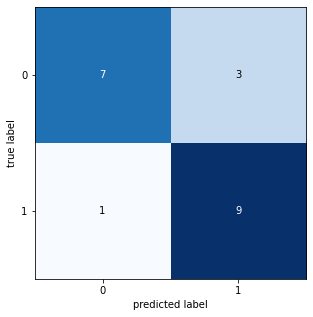

Train : [ 0  2  3  4  5  7  8  9 10 11 14 15 16 17 19 20 21 22 23 25 26 27 28 30
 31 34 35 36 37 38 39 42 43 44 45 46 47 48 49 51 52 53 54 55 56 57 58 59
 60 61 62 63 64 65 66 69 70 72 73 74 75 76 77 80 81 82 83 84 85 86 88 89
 90 91 92 95 96] Test : [ 1  6 12 13 18 24 29 32 33 40 41 50 67 68 71 78 79 87 93 94]
Y_Train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0]
Y_Test : [1 1 0 0 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Akurasi :  0.85
F1_Score :  0.8465473145780051
              precision    recall  f1-score   support

           0       0.83      0.91      0.87        11
           1       0.88      0.78      0.82         9

    accuracy                           0.85        20
   macro avg       0.85      0.84      0.85        20
weighted avg       0.85      0.85      0.85        20



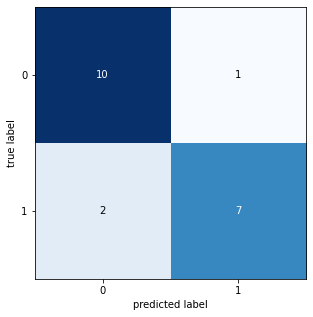

Train : [ 0  1  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 21 22 23 24 26
 28 29 32 33 34 35 36 38 40 41 42 43 44 45 46 48 49 50 51 52 53 54 55 56
 57 59 60 62 65 66 67 68 69 71 74 76 77 78 79 80 81 82 83 84 85 86 87 88
 90 91 92 93 94 96] Test : [ 2 20 25 27 30 31 37 39 47 58 61 63 64 70 72 73 75 89 95]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0]
Akurasi :  0.7368421052631579
F1_Score :  0.7368421052631577
              precision    recall  f1-score   support

           0       0.78      0.70      0.74        10
           1       0.70      0.78      0.74         9

    accuracy                           0.74        19
   macro avg       0.74      0.74      0.74        19
weighted avg       0.74      0.74      0.74        19



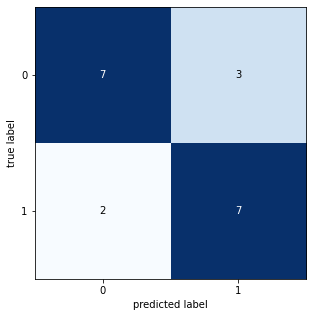

Train : [ 1  2  5  6  7  8  9 10 11 12 13 14 17 18 20 21 22 23 24 25 27 28 29 30
 31 32 33 34 35 36 37 39 40 41 42 43 44 45 47 49 50 52 53 56 57 58 59 61
 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 78 79 82 83 84 85 87 89 90
 91 92 93 94 95 96] Test : [ 0  3  4 15 16 19 26 38 46 48 51 54 55 60 77 80 81 86 88]
Y_Train : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 1 0 0 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Akurasi :  0.7894736842105263
F1_Score :  0.7888888888888888
              precision    recall  f1-score   support

           0       0.88      0.70      0.78        10
           1       0.73      0.89      0.80         9

    accuracy                           0.79        19
   macro avg       0.80      0.79      0.79        19
weighted avg       0.81      0.79      0.79        19



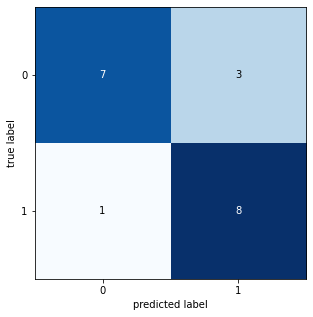

Train : [ 0  1  2  3  4  6  7  9 10 11 12 13 15 16 17 18 19 20 24 25 26 27 28 29
 30 31 32 33 34 36 37 38 39 40 41 44 46 47 48 49 50 51 52 54 55 56 57 58
 59 60 61 62 63 64 66 67 68 70 71 72 73 74 75 77 78 79 80 81 83 84 86 87
 88 89 93 94 95 96] Test : [ 5  8 14 21 22 23 35 42 43 45 53 65 69 76 82 85 90 91 92]
Y_Train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0]
Akurasi :  0.6842105263157895
F1_Score :  0.6833333333333333
              precision    recall  f1-score   support

           0       0.75      0.60      0.67        10
           1       0.64      0.78      0.70         9

    accuracy                           0.68        19
   macro avg       0.69      0.69      0.68        19
weighted avg       0.70      0.68      0.68        19



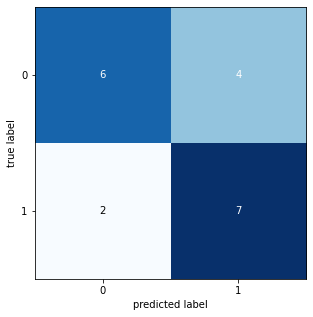

avg accuraccy Breast Cancer =  0.7721052631578947
avg F1_Score Breast Cancer =  0.7707182880086366
max accuraccy Breast Cancer =  0.85
max F1_Score Breast Cancer =  0.8465473145780051
min accuraccy Breast Cancer =  0.6842105263157895
min F1_Score Breast Cancer =  0.6833333333333333
Running Time:  38.580120643000555
gene : [0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0]
Train : [ 0  1  2  3  4  5  6  8 12 13 14 15 16 18 19 20 21 22 23 24 25 26 27 29
 30 31 32 33 35 37 38 39 40 41 42 43 45 46 47 48 50 51 53 54 55 58 60 61
 63 64 65 67 68 69 70 71 72 73 75 76 77 78 79 80 81 82 85 86 87 88 89 90
 91 92 93 94 95] Test : [ 7  9 10 11 17 28 34 36 44 49 52 56 57 59 62 66 74 83 84 96]
Y_Train : [1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1

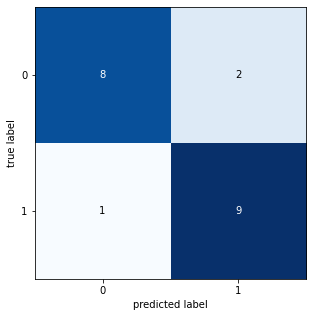

Train : [ 0  2  3  4  5  7  8  9 10 11 14 15 16 17 19 20 21 22 23 25 26 27 28 30
 31 34 35 36 37 38 39 42 43 44 45 46 47 48 49 51 52 53 54 55 56 57 58 59
 60 61 62 63 64 65 66 69 70 72 73 74 75 76 77 80 81 82 83 84 85 86 88 89
 90 91 92 95 96] Test : [ 1  6 12 13 18 24 29 32 33 40 41 50 67 68 71 78 79 87 93 94]
Y_Train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0]
Y_Test : [1 1 0 0 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Akurasi :  0.9
F1_Score :  0.898989898989899
              precision    recall  f1-score   support

           0       0.91      0.91      0.91        11
           1       0.89      0.89      0.89         9

    accuracy                           0.90        20
   macro avg       0.90      0.90      0.90        20
weighted avg       0.90      0.90      0.90        20



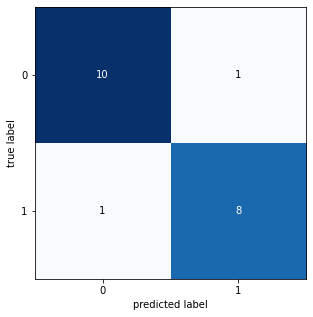

Train : [ 0  1  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 21 22 23 24 26
 28 29 32 33 34 35 36 38 40 41 42 43 44 45 46 48 49 50 51 52 53 54 55 56
 57 59 60 62 65 66 67 68 69 71 74 76 77 78 79 80 81 82 83 84 85 86 87 88
 90 91 92 93 94 96] Test : [ 2 20 25 27 30 31 37 39 47 58 61 63 64 70 72 73 75 89 95]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0]
Akurasi :  0.7368421052631579
F1_Score :  0.7368421052631577
              precision    recall  f1-score   support

           0       0.78      0.70      0.74        10
           1       0.70      0.78      0.74         9

    accuracy                           0.74        19
   macro avg       0.74      0.74      0.74        19
weighted avg       0.74      0.74      0.74        19



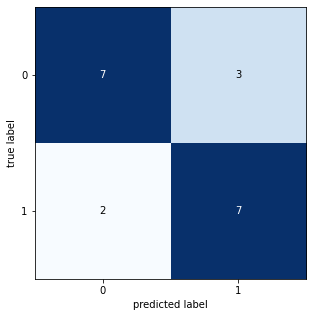

Train : [ 1  2  5  6  7  8  9 10 11 12 13 14 17 18 20 21 22 23 24 25 27 28 29 30
 31 32 33 34 35 36 37 39 40 41 42 43 44 45 47 49 50 52 53 56 57 58 59 61
 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 78 79 82 83 84 85 87 89 90
 91 92 93 94 95 96] Test : [ 0  3  4 15 16 19 26 38 46 48 51 54 55 60 77 80 81 86 88]
Y_Train : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 1 0 0 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Akurasi :  0.7368421052631579
F1_Score :  0.7368421052631577
              precision    recall  f1-score   support

           0       0.78      0.70      0.74        10
           1       0.70      0.78      0.74         9

    accuracy                           0.74        19
   macro avg       0.74      0.74      0.74        19
weighted avg       0.74      0.74      0.74        19



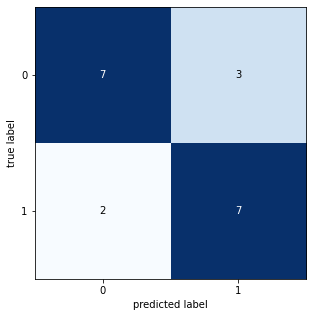

Train : [ 0  1  2  3  4  6  7  9 10 11 12 13 15 16 17 18 19 20 24 25 26 27 28 29
 30 31 32 33 34 36 37 38 39 40 41 44 46 47 48 49 50 51 52 54 55 56 57 58
 59 60 61 62 63 64 66 67 68 70 71 72 73 74 75 77 78 79 80 81 83 84 86 87
 88 89 93 94 95 96] Test : [ 5  8 14 21 22 23 35 42 43 45 53 65 69 76 82 85 90 91 92]
Y_Train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0]
Akurasi :  0.9473684210526315
F1_Score :  0.9473684210526316
              precision    recall  f1-score   support

           0       1.00      0.90      0.95        10
           1       0.90      1.00      0.95         9

    accuracy                           0.95        19
   macro avg       0.95      0.95      0.95        19
weighted avg       0.95      0.95      0.95        19



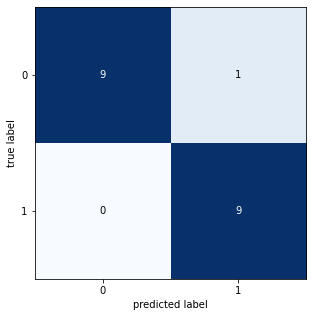

avg accuraccy Breast Cancer =  0.8342105263157895
avg F1_Score Breast Cancer =  0.8339333181438444
max accuraccy Breast Cancer =  0.9473684210526315
max F1_Score Breast Cancer =  0.9473684210526316
min accuraccy Breast Cancer =  0.7368421052631579
min F1_Score Breast Cancer =  0.7368421052631577
Running Time:  39.66319956199732
gene : [0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0]
Train : [ 0  1  2  3  4  5  6  8 12 13 14 15 16 18 19 20 21 22 23 24 25 26 27 29
 30 31 32 33 35 37 38 39 40 41 42 43 45 46 47 48 50 51 53 54 55 58 60 61
 63 64 65 67 68 69 70 71 72 73 75 76 77 78 79 80 81 82 85 86 87 88 89 90
 91 92 93 94 95] Test : [ 7  9 10 11 17 28 34 36 44 49 52 56 57 59 62 66 74 83 84 96]
Y_Train : [1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 

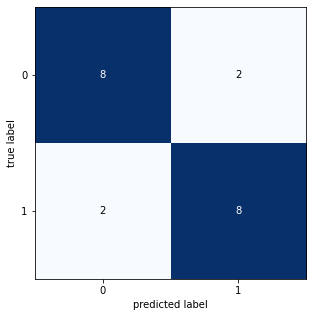

Train : [ 0  2  3  4  5  7  8  9 10 11 14 15 16 17 19 20 21 22 23 25 26 27 28 30
 31 34 35 36 37 38 39 42 43 44 45 46 47 48 49 51 52 53 54 55 56 57 58 59
 60 61 62 63 64 65 66 69 70 72 73 74 75 76 77 80 81 82 83 84 85 86 88 89
 90 91 92 95 96] Test : [ 1  6 12 13 18 24 29 32 33 40 41 50 67 68 71 78 79 87 93 94]
Y_Train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0]
Y_Test : [1 1 0 0 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Akurasi :  0.7
F1_Score :  0.696969696969697
              precision    recall  f1-score   support

           0       0.86      0.55      0.67        11
           1       0.62      0.89      0.73         9

    accuracy                           0.70        20
   macro avg       0.74      0.72      0.70        20
weighted avg       0.75      0.70      0.69        20



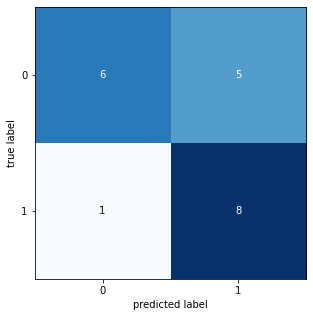

Train : [ 0  1  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 21 22 23 24 26
 28 29 32 33 34 35 36 38 40 41 42 43 44 45 46 48 49 50 51 52 53 54 55 56
 57 59 60 62 65 66 67 68 69 71 74 76 77 78 79 80 81 82 83 84 85 86 87 88
 90 91 92 93 94 96] Test : [ 2 20 25 27 30 31 37 39 47 58 61 63 64 70 72 73 75 89 95]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0]
Akurasi :  0.7894736842105263
F1_Score :  0.788888888888889
              precision    recall  f1-score   support

           0       0.80      0.80      0.80        10
           1       0.78      0.78      0.78         9

    accuracy                           0.79        19
   macro avg       0.79      0.79      0.79        19
weighted avg       0.79      0.79      0.79        19



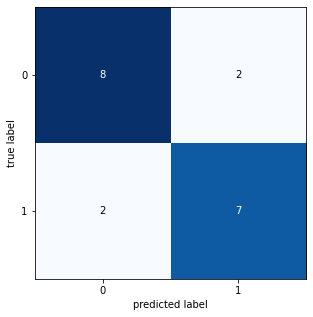

Train : [ 1  2  5  6  7  8  9 10 11 12 13 14 17 18 20 21 22 23 24 25 27 28 29 30
 31 32 33 34 35 36 37 39 40 41 42 43 44 45 47 49 50 52 53 56 57 58 59 61
 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 78 79 82 83 84 85 87 89 90
 91 92 93 94 95 96] Test : [ 0  3  4 15 16 19 26 38 46 48 51 54 55 60 77 80 81 86 88]
Y_Train : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 1 0 0 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Akurasi :  0.7894736842105263
F1_Score :  0.7888888888888888
              precision    recall  f1-score   support

           0       0.88      0.70      0.78        10
           1       0.73      0.89      0.80         9

    accuracy                           0.79        19
   macro avg       0.80      0.79      0.79        19
weighted avg       0.81      0.79      0.79        19



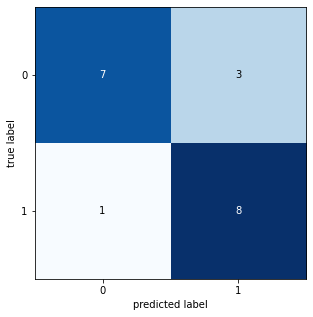

Train : [ 0  1  2  3  4  6  7  9 10 11 12 13 15 16 17 18 19 20 24 25 26 27 28 29
 30 31 32 33 34 36 37 38 39 40 41 44 46 47 48 49 50 51 52 54 55 56 57 58
 59 60 61 62 63 64 66 67 68 70 71 72 73 74 75 77 78 79 80 81 83 84 86 87
 88 89 93 94 95 96] Test : [ 5  8 14 21 22 23 35 42 43 45 53 65 69 76 82 85 90 91 92]
Y_Train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0]
Akurasi :  0.8947368421052632
F1_Score :  0.8944444444444445
              precision    recall  f1-score   support

           0       1.00      0.80      0.89        10
           1       0.82      1.00      0.90         9

    accuracy                           0.89        19
   macro avg       0.91      0.90      0.89        19
weighted avg       0.91      0.89      0.89        19



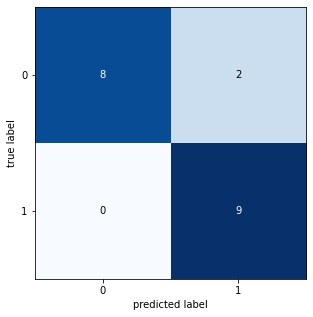

avg accuraccy Breast Cancer =  0.7947368421052633
avg F1_Score Breast Cancer =  0.7938383838383838
max accuraccy Breast Cancer =  0.8947368421052632
max F1_Score Breast Cancer =  0.8944444444444445
min accuraccy Breast Cancer =  0.7
min F1_Score Breast Cancer =  0.696969696969697
Running Time:  38.62892066900167
gen terbaik : [0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0]
F-1 Score terbaik : 0.8339333181438444  || Akurasi terbaik : 0.8342105263157895  || jumlah fitur : 51

Running Time:  1973.379444786


In [14]:
Breast_IG_GA = GeneticAlgorithm(Breast_IG, 3)

Generation : 0
gene : [1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0]
Train : [ 0  1  2  3  4  5  6  8 12 13 14 15 16 18 19 20 21 22 23 24 25 26 27 29
 30 31 32 33 35 37 38 39 40 41 42 43 45 46 47 48 50 51 53 54 55 58 60 61
 63 64 65 67 68 69 70 71 72 73 75 76 77 78 79 80 81 82 85 86 87 88 89 90
 91 92 93 94 95] Test : [ 7  9 10 11 17 28 34 36 44 49 52 56 57 59 62 66 74 83 84 96]
Y_Train : [1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0]
Y_Test : [1 1 1 1 0 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0]
Akurasi :  0.9
F1_Score :  0.9
              precision    recall  f1-score   support

           0       0.90      0.90      0.90        10
     

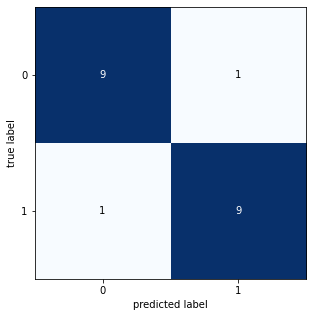

Train : [ 0  2  3  4  5  7  8  9 10 11 14 15 16 17 19 20 21 22 23 25 26 27 28 30
 31 34 35 36 37 38 39 42 43 44 45 46 47 48 49 51 52 53 54 55 56 57 58 59
 60 61 62 63 64 65 66 69 70 72 73 74 75 76 77 80 81 82 83 84 85 86 88 89
 90 91 92 95 96] Test : [ 1  6 12 13 18 24 29 32 33 40 41 50 67 68 71 78 79 87 93 94]
Y_Train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0]
Y_Test : [1 1 0 0 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Akurasi :  0.8
F1_Score :  0.797979797979798
              precision    recall  f1-score   support

           0       0.82      0.82      0.82        11
           1       0.78      0.78      0.78         9

    accuracy                           0.80        20
   macro avg       0.80      0.80      0.80        20
weighted avg       0.80      0.80      0.80        20



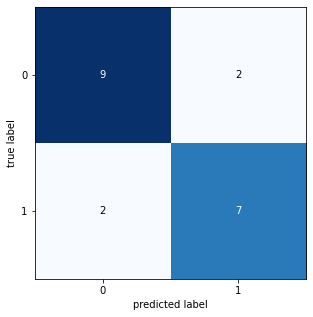

Train : [ 0  1  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 21 22 23 24 26
 28 29 32 33 34 35 36 38 40 41 42 43 44 45 46 48 49 50 51 52 53 54 55 56
 57 59 60 62 65 66 67 68 69 71 74 76 77 78 79 80 81 82 83 84 85 86 87 88
 90 91 92 93 94 96] Test : [ 2 20 25 27 30 31 37 39 47 58 61 63 64 70 72 73 75 89 95]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0]
Akurasi :  0.7368421052631579
F1_Score :  0.7246376811594203
              precision    recall  f1-score   support

           0       0.69      0.90      0.78        10
           1       0.83      0.56      0.67         9

    accuracy                           0.74        19
   macro avg       0.76      0.73      0.72        19
weighted avg       0.76      0.74      0.73        19



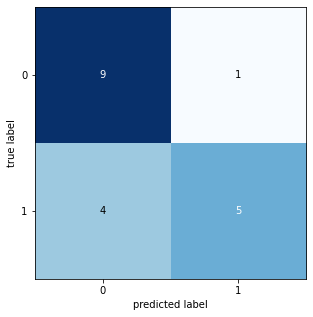

Train : [ 1  2  5  6  7  8  9 10 11 12 13 14 17 18 20 21 22 23 24 25 27 28 29 30
 31 32 33 34 35 36 37 39 40 41 42 43 44 45 47 49 50 52 53 56 57 58 59 61
 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 78 79 82 83 84 85 87 89 90
 91 92 93 94 95 96] Test : [ 0  3  4 15 16 19 26 38 46 48 51 54 55 60 77 80 81 86 88]
Y_Train : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 1 0 0 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Akurasi :  0.6842105263157895
F1_Score :  0.6833333333333333
              precision    recall  f1-score   support

           0       0.75      0.60      0.67        10
           1       0.64      0.78      0.70         9

    accuracy                           0.68        19
   macro avg       0.69      0.69      0.68        19
weighted avg       0.70      0.68      0.68        19



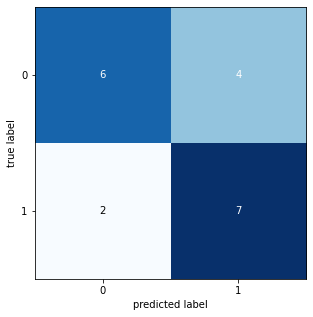

Train : [ 0  1  2  3  4  6  7  9 10 11 12 13 15 16 17 18 19 20 24 25 26 27 28 29
 30 31 32 33 34 36 37 38 39 40 41 44 46 47 48 49 50 51 52 54 55 56 57 58
 59 60 61 62 63 64 66 67 68 70 71 72 73 74 75 77 78 79 80 81 83 84 86 87
 88 89 93 94 95 96] Test : [ 5  8 14 21 22 23 35 42 43 45 53 65 69 76 82 85 90 91 92]
Y_Train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0]
Akurasi :  0.6842105263157895
F1_Score :  0.6833333333333333
              precision    recall  f1-score   support

           0       0.75      0.60      0.67        10
           1       0.64      0.78      0.70         9

    accuracy                           0.68        19
   macro avg       0.69      0.69      0.68        19
weighted avg       0.70      0.68      0.68        19



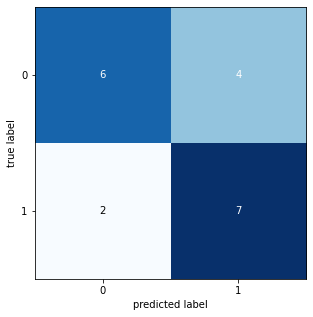

avg accuraccy Breast Cancer =  0.7610526315789474
avg F1_Score Breast Cancer =  0.757856829161177
max accuraccy Breast Cancer =  0.9
max F1_Score Breast Cancer =  0.9
min accuraccy Breast Cancer =  0.6842105263157895
min F1_Score Breast Cancer =  0.6833333333333333
Running Time:  41.96172063400081
gene : [1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1]
Train : [ 0  1  2  3  4  5  6  8 12 13 14 15 16 18 19 20 21 22 23 24 25 26 27 29
 30 31 32 33 35 37 38 39 40 41 42 43 45 46 47 48 50 51 53 54 55 58 60 61
 63 64 65 67 68 69 70 71 72 73 75 76 77 78 79 80 81 82 85 86 87 88 89 90
 91 92 93 94 95] Test : [ 7  9 10 11 17 28 34 36 44 49 52 56 57 59 62 66 74 83 84 96]
Y_Train : [1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1

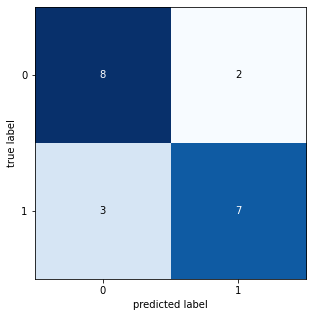

Train : [ 0  2  3  4  5  7  8  9 10 11 14 15 16 17 19 20 21 22 23 25 26 27 28 30
 31 34 35 36 37 38 39 42 43 44 45 46 47 48 49 51 52 53 54 55 56 57 58 59
 60 61 62 63 64 65 66 69 70 72 73 74 75 76 77 80 81 82 83 84 85 86 88 89
 90 91 92 95 96] Test : [ 1  6 12 13 18 24 29 32 33 40 41 50 67 68 71 78 79 87 93 94]
Y_Train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0]
Y_Test : [1 1 0 0 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Akurasi :  0.6
F1_Score :  0.595959595959596
              precision    recall  f1-score   support

           0       0.64      0.64      0.64        11
           1       0.56      0.56      0.56         9

    accuracy                           0.60        20
   macro avg       0.60      0.60      0.60        20
weighted avg       0.60      0.60      0.60        20



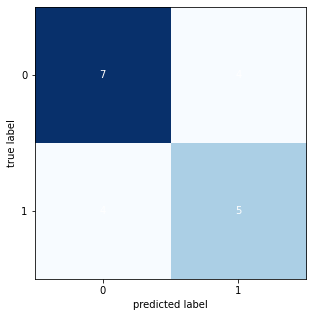

Train : [ 0  1  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 21 22 23 24 26
 28 29 32 33 34 35 36 38 40 41 42 43 44 45 46 48 49 50 51 52 53 54 55 56
 57 59 60 62 65 66 67 68 69 71 74 76 77 78 79 80 81 82 83 84 85 86 87 88
 90 91 92 93 94 96] Test : [ 2 20 25 27 30 31 37 39 47 58 61 63 64 70 72 73 75 89 95]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0]
Akurasi :  0.6842105263157895
F1_Score :  0.6761363636363636
              precision    recall  f1-score   support

           0       0.67      0.80      0.73        10
           1       0.71      0.56      0.63         9

    accuracy                           0.68        19
   macro avg       0.69      0.68      0.68        19
weighted avg       0.69      0.68      0.68        19



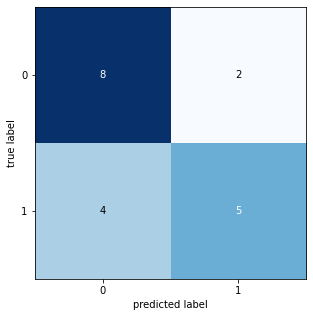

Train : [ 1  2  5  6  7  8  9 10 11 12 13 14 17 18 20 21 22 23 24 25 27 28 29 30
 31 32 33 34 35 36 37 39 40 41 42 43 44 45 47 49 50 52 53 56 57 58 59 61
 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 78 79 82 83 84 85 87 89 90
 91 92 93 94 95 96] Test : [ 0  3  4 15 16 19 26 38 46 48 51 54 55 60 77 80 81 86 88]
Y_Train : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 1 0 0 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Akurasi :  0.8421052631578947
F1_Score :  0.8403361344537814
              precision    recall  f1-score   support

           0       1.00      0.70      0.82        10
           1       0.75      1.00      0.86         9

    accuracy                           0.84        19
   macro avg       0.88      0.85      0.84        19
weighted avg       0.88      0.84      0.84        19



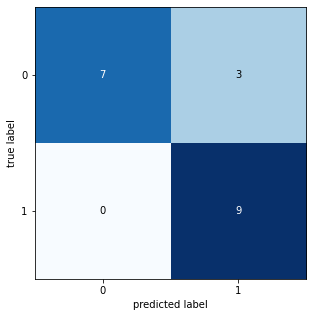

Train : [ 0  1  2  3  4  6  7  9 10 11 12 13 15 16 17 18 19 20 24 25 26 27 28 29
 30 31 32 33 34 36 37 38 39 40 41 44 46 47 48 49 50 51 52 54 55 56 57 58
 59 60 61 62 63 64 66 67 68 70 71 72 73 74 75 77 78 79 80 81 83 84 86 87
 88 89 93 94 95 96] Test : [ 5  8 14 21 22 23 35 42 43 45 53 65 69 76 82 85 90 91 92]
Y_Train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0]
Akurasi :  0.8421052631578947
F1_Score :  0.8421052631578948
              precision    recall  f1-score   support

           0       0.89      0.80      0.84        10
           1       0.80      0.89      0.84         9

    accuracy                           0.84        19
   macro avg       0.84      0.84      0.84        19
weighted avg       0.85      0.84      0.84        19



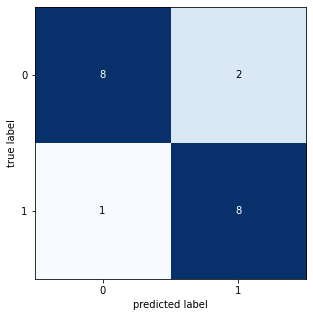

avg accuraccy Breast Cancer =  0.7436842105263157
avg F1_Score Breast Cancer =  0.740782158158319
max accuraccy Breast Cancer =  0.8421052631578947
max F1_Score Breast Cancer =  0.8421052631578948
min accuraccy Breast Cancer =  0.6
min F1_Score Breast Cancer =  0.595959595959596
Running Time:  39.97351272200103
gene : [1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0]
Train : [ 0  1  2  3  4  5  6  8 12 13 14 15 16 18 19 20 21 22 23 24 25 26 27 29
 30 31 32 33 35 37 38 39 40 41 42 43 45 46 47 48 50 51 53 54 55 58 60 61
 63 64 65 67 68 69 70 71 72 73 75 76 77 78 79 80 81 82 85 86 87 88 89 90
 91 92 93 94 95] Test : [ 7  9 10 11 17 28 34 36 44 49 52 56 57 59 62 66 74 83 84 96]
Y_Train : [1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1

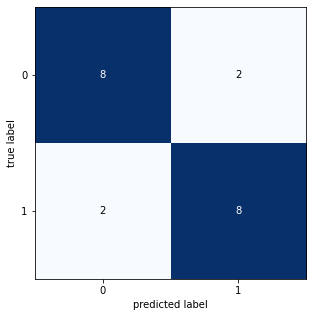

Train : [ 0  2  3  4  5  7  8  9 10 11 14 15 16 17 19 20 21 22 23 25 26 27 28 30
 31 34 35 36 37 38 39 42 43 44 45 46 47 48 49 51 52 53 54 55 56 57 58 59
 60 61 62 63 64 65 66 69 70 72 73 74 75 76 77 80 81 82 83 84 85 86 88 89
 90 91 92 95 96] Test : [ 1  6 12 13 18 24 29 32 33 40 41 50 67 68 71 78 79 87 93 94]
Y_Train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0]
Y_Test : [1 1 0 0 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Akurasi :  0.65
F1_Score :  0.6491228070175439
              precision    recall  f1-score   support

           0       0.70      0.64      0.67        11
           1       0.60      0.67      0.63         9

    accuracy                           0.65        20
   macro avg       0.65      0.65      0.65        20
weighted avg       0.65      0.65      0.65        20



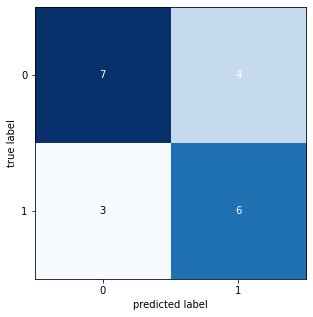

Train : [ 0  1  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 21 22 23 24 26
 28 29 32 33 34 35 36 38 40 41 42 43 44 45 46 48 49 50 51 52 53 54 55 56
 57 59 60 62 65 66 67 68 69 71 74 76 77 78 79 80 81 82 83 84 85 86 87 88
 90 91 92 93 94 96] Test : [ 2 20 25 27 30 31 37 39 47 58 61 63 64 70 72 73 75 89 95]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0]
Akurasi :  0.6842105263157895
F1_Score :  0.6833333333333333
              precision    recall  f1-score   support

           0       0.75      0.60      0.67        10
           1       0.64      0.78      0.70         9

    accuracy                           0.68        19
   macro avg       0.69      0.69      0.68        19
weighted avg       0.70      0.68      0.68        19



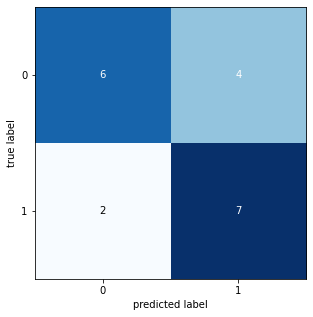

Train : [ 1  2  5  6  7  8  9 10 11 12 13 14 17 18 20 21 22 23 24 25 27 28 29 30
 31 32 33 34 35 36 37 39 40 41 42 43 44 45 47 49 50 52 53 56 57 58 59 61
 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 78 79 82 83 84 85 87 89 90
 91 92 93 94 95 96] Test : [ 0  3  4 15 16 19 26 38 46 48 51 54 55 60 77 80 81 86 88]
Y_Train : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 1 0 0 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Akurasi :  0.6842105263157895
F1_Score :  0.6833333333333333
              precision    recall  f1-score   support

           0       0.70      0.70      0.70        10
           1       0.67      0.67      0.67         9

    accuracy                           0.68        19
   macro avg       0.68      0.68      0.68        19
weighted avg       0.68      0.68      0.68        19



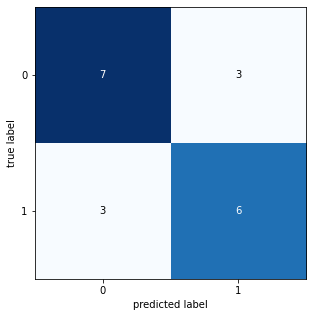

Train : [ 0  1  2  3  4  6  7  9 10 11 12 13 15 16 17 18 19 20 24 25 26 27 28 29
 30 31 32 33 34 36 37 38 39 40 41 44 46 47 48 49 50 51 52 54 55 56 57 58
 59 60 61 62 63 64 66 67 68 70 71 72 73 74 75 77 78 79 80 81 83 84 86 87
 88 89 93 94 95 96] Test : [ 5  8 14 21 22 23 35 42 43 45 53 65 69 76 82 85 90 91 92]
Y_Train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0]
Akurasi :  0.6842105263157895
F1_Score :  0.6833333333333333
              precision    recall  f1-score   support

           0       0.70      0.70      0.70        10
           1       0.67      0.67      0.67         9

    accuracy                           0.68        19
   macro avg       0.68      0.68      0.68        19
weighted avg       0.68      0.68      0.68        19



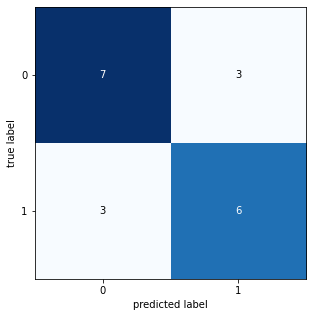

avg accuraccy Breast Cancer =  0.7005263157894737
avg F1_Score Breast Cancer =  0.6998245614035088
max accuraccy Breast Cancer =  0.8
max F1_Score Breast Cancer =  0.8000000000000002
min accuraccy Breast Cancer =  0.65
min F1_Score Breast Cancer =  0.6491228070175439
Running Time:  38.73281450899958
gene : [1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1]
Train : [ 0  1  2  3  4  5  6  8 12 13 14 15 16 18 19 20 21 22 23 24 25 26 27 29
 30 31 32 33 35 37 38 39 40 41 42 43 45 46 47 48 50 51 53 54 55 58 60 61
 63 64 65 67 68 69 70 71 72 73 75 76 77 78 79 80 81 82 85 86 87 88 89 90
 91 92 93 94 95] Test : [ 7  9 10 11 17 28 34 36 44 49 52 56 57 59 62 66 74 83 84 96]
Y_Train : [1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1

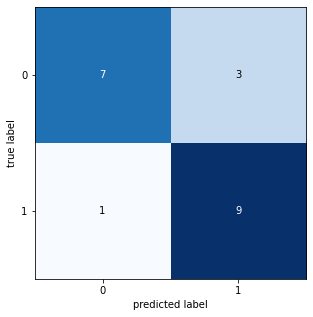

Train : [ 0  2  3  4  5  7  8  9 10 11 14 15 16 17 19 20 21 22 23 25 26 27 28 30
 31 34 35 36 37 38 39 42 43 44 45 46 47 48 49 51 52 53 54 55 56 57 58 59
 60 61 62 63 64 65 66 69 70 72 73 74 75 76 77 80 81 82 83 84 85 86 88 89
 90 91 92 95 96] Test : [ 1  6 12 13 18 24 29 32 33 40 41 50 67 68 71 78 79 87 93 94]
Y_Train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0]
Y_Test : [1 1 0 0 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Akurasi :  0.7
F1_Score :  0.696969696969697
              precision    recall  f1-score   support

           0       0.86      0.55      0.67        11
           1       0.62      0.89      0.73         9

    accuracy                           0.70        20
   macro avg       0.74      0.72      0.70        20
weighted avg       0.75      0.70      0.69        20



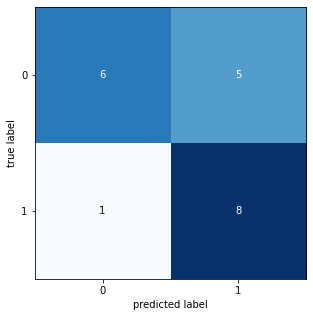

Train : [ 0  1  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 21 22 23 24 26
 28 29 32 33 34 35 36 38 40 41 42 43 44 45 46 48 49 50 51 52 53 54 55 56
 57 59 60 62 65 66 67 68 69 71 74 76 77 78 79 80 81 82 83 84 85 86 87 88
 90 91 92 93 94 96] Test : [ 2 20 25 27 30 31 37 39 47 58 61 63 64 70 72 73 75 89 95]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0]
Akurasi :  0.8947368421052632
F1_Score :  0.8944444444444445
              precision    recall  f1-score   support

           0       1.00      0.80      0.89        10
           1       0.82      1.00      0.90         9

    accuracy                           0.89        19
   macro avg       0.91      0.90      0.89        19
weighted avg       0.91      0.89      0.89        19



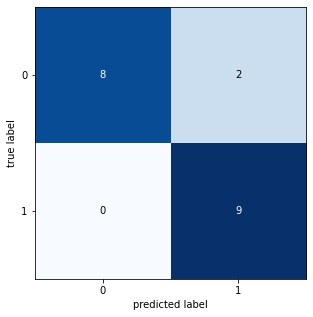

Train : [ 1  2  5  6  7  8  9 10 11 12 13 14 17 18 20 21 22 23 24 25 27 28 29 30
 31 32 33 34 35 36 37 39 40 41 42 43 44 45 47 49 50 52 53 56 57 58 59 61
 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 78 79 82 83 84 85 87 89 90
 91 92 93 94 95 96] Test : [ 0  3  4 15 16 19 26 38 46 48 51 54 55 60 77 80 81 86 88]
Y_Train : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 1 0 0 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Akurasi :  0.7368421052631579
F1_Score :  0.7338935574229692
              precision    recall  f1-score   support

           0       0.86      0.60      0.71        10
           1       0.67      0.89      0.76         9

    accuracy                           0.74        19
   macro avg       0.76      0.74      0.73        19
weighted avg       0.77      0.74      0.73        19



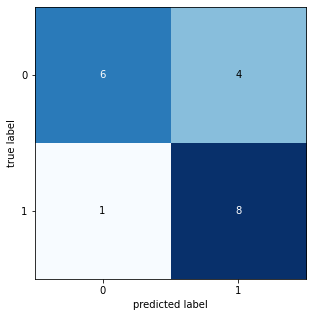

Train : [ 0  1  2  3  4  6  7  9 10 11 12 13 15 16 17 18 19 20 24 25 26 27 28 29
 30 31 32 33 34 36 37 38 39 40 41 44 46 47 48 49 50 51 52 54 55 56 57 58
 59 60 61 62 63 64 66 67 68 70 71 72 73 74 75 77 78 79 80 81 83 84 86 87
 88 89 93 94 95 96] Test : [ 5  8 14 21 22 23 35 42 43 45 53 65 69 76 82 85 90 91 92]
Y_Train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0]
Akurasi :  0.8421052631578947
F1_Score :  0.8421052631578948
              precision    recall  f1-score   support

           0       0.89      0.80      0.84        10
           1       0.80      0.89      0.84         9

    accuracy                           0.84        19
   macro avg       0.84      0.84      0.84        19
weighted avg       0.85      0.84      0.84        19



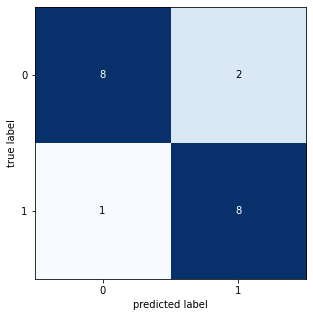

avg accuraccy Breast Cancer =  0.7947368421052632
avg F1_Score Breast Cancer =  0.7930785519949607
max accuraccy Breast Cancer =  0.8947368421052632
max F1_Score Breast Cancer =  0.8944444444444445
min accuraccy Breast Cancer =  0.7
min F1_Score Breast Cancer =  0.696969696969697
Running Time:  39.48503445100141
gene : [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1]
Train : [ 0  1  2  3  4  5  6  8 12 13 14 15 16 18 19 20 21 22 23 24 25 26 27 29
 30 31 32 33 35 37 38 39 40 41 42 43 45 46 47 48 50 51 53 54 55 58 60 61
 63 64 65 67 68 69 70 71 72 73 75 76 77 78 79 80 81 82 85 86 87 88 89 90
 91 92 93 94 95] Test : [ 7  9 10 11 17 28 34 36 44 49 52 56 57 59 62 66 74 83 84 96]
Y_Train : [1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 

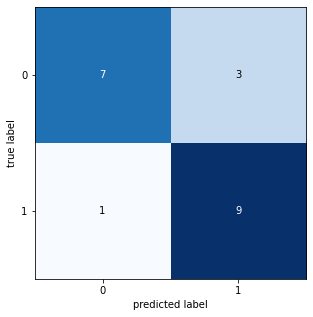

Train : [ 0  2  3  4  5  7  8  9 10 11 14 15 16 17 19 20 21 22 23 25 26 27 28 30
 31 34 35 36 37 38 39 42 43 44 45 46 47 48 49 51 52 53 54 55 56 57 58 59
 60 61 62 63 64 65 66 69 70 72 73 74 75 76 77 80 81 82 83 84 85 86 88 89
 90 91 92 95 96] Test : [ 1  6 12 13 18 24 29 32 33 40 41 50 67 68 71 78 79 87 93 94]
Y_Train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0]
Y_Test : [1 1 0 0 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Akurasi :  0.8
F1_Score :  0.797979797979798
              precision    recall  f1-score   support

           0       1.00      0.64      0.78        11
           1       0.69      1.00      0.82         9

    accuracy                           0.80        20
   macro avg       0.85      0.82      0.80        20
weighted avg       0.86      0.80      0.80        20



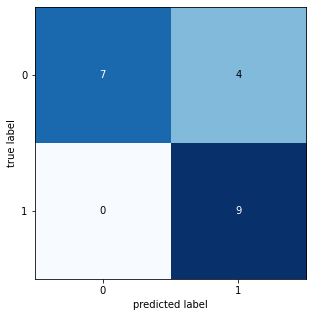

Train : [ 0  1  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 21 22 23 24 26
 28 29 32 33 34 35 36 38 40 41 42 43 44 45 46 48 49 50 51 52 53 54 55 56
 57 59 60 62 65 66 67 68 69 71 74 76 77 78 79 80 81 82 83 84 85 86 87 88
 90 91 92 93 94 96] Test : [ 2 20 25 27 30 31 37 39 47 58 61 63 64 70 72 73 75 89 95]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0]
Akurasi :  0.7368421052631579
F1_Score :  0.7338935574229692
              precision    recall  f1-score   support

           0       0.73      0.80      0.76        10
           1       0.75      0.67      0.71         9

    accuracy                           0.74        19
   macro avg       0.74      0.73      0.73        19
weighted avg       0.74      0.74      0.74        19



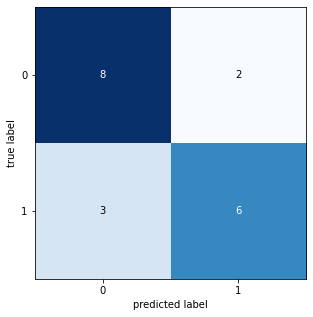

Train : [ 1  2  5  6  7  8  9 10 11 12 13 14 17 18 20 21 22 23 24 25 27 28 29 30
 31 32 33 34 35 36 37 39 40 41 42 43 44 45 47 49 50 52 53 56 57 58 59 61
 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 78 79 82 83 84 85 87 89 90
 91 92 93 94 95 96] Test : [ 0  3  4 15 16 19 26 38 46 48 51 54 55 60 77 80 81 86 88]
Y_Train : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 1 0 0 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Akurasi :  0.7894736842105263
F1_Score :  0.7888888888888888
              precision    recall  f1-score   support

           0       0.88      0.70      0.78        10
           1       0.73      0.89      0.80         9

    accuracy                           0.79        19
   macro avg       0.80      0.79      0.79        19
weighted avg       0.81      0.79      0.79        19



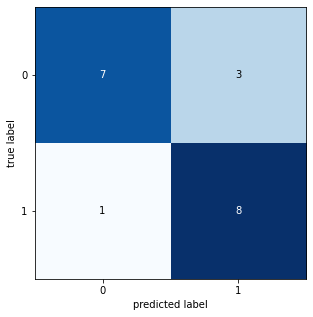

Train : [ 0  1  2  3  4  6  7  9 10 11 12 13 15 16 17 18 19 20 24 25 26 27 28 29
 30 31 32 33 34 36 37 38 39 40 41 44 46 47 48 49 50 51 52 54 55 56 57 58
 59 60 61 62 63 64 66 67 68 70 71 72 73 74 75 77 78 79 80 81 83 84 86 87
 88 89 93 94 95 96] Test : [ 5  8 14 21 22 23 35 42 43 45 53 65 69 76 82 85 90 91 92]
Y_Train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0]
Akurasi :  0.7368421052631579
F1_Score :  0.7338935574229692
              precision    recall  f1-score   support

           0       0.73      0.80      0.76        10
           1       0.75      0.67      0.71         9

    accuracy                           0.74        19
   macro avg       0.74      0.73      0.73        19
weighted avg       0.74      0.74      0.74        19



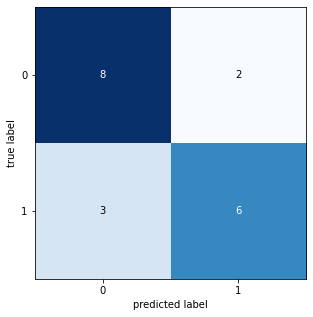

avg accuraccy Breast Cancer =  0.7726315789473686
avg F1_Score Breast Cancer =  0.7705271199388847
max accuraccy Breast Cancer =  0.8
max F1_Score Breast Cancer =  0.797979797979798
min accuraccy Breast Cancer =  0.7368421052631579
min F1_Score Breast Cancer =  0.7338935574229692
Running Time:  39.64224928499971
gene : [0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1]
Train : [ 0  1  2  3  4  5  6  8 12 13 14 15 16 18 19 20 21 22 23 24 25 26 27 29
 30 31 32 33 35 37 38 39 40 41 42 43 45 46 47 48 50 51 53 54 55 58 60 61
 63 64 65 67 68 69 70 71 72 73 75 76 77 78 79 80 81 82 85 86 87 88 89 90
 91 92 93 94 95] Test : [ 7  9 10 11 17 28 34 36 44 49 52 56 57 59 62 66 74 83 84 96]
Y_Train : [1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 

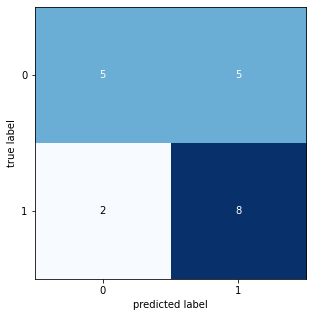

Train : [ 0  2  3  4  5  7  8  9 10 11 14 15 16 17 19 20 21 22 23 25 26 27 28 30
 31 34 35 36 37 38 39 42 43 44 45 46 47 48 49 51 52 53 54 55 56 57 58 59
 60 61 62 63 64 65 66 69 70 72 73 74 75 76 77 80 81 82 83 84 85 86 88 89
 90 91 92 95 96] Test : [ 1  6 12 13 18 24 29 32 33 40 41 50 67 68 71 78 79 87 93 94]
Y_Train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0]
Y_Test : [1 1 0 0 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Akurasi :  0.5
F1_Score :  0.494949494949495
              precision    recall  f1-score   support

           0       0.57      0.36      0.44        11
           1       0.46      0.67      0.55         9

    accuracy                           0.50        20
   macro avg       0.52      0.52      0.49        20
weighted avg       0.52      0.50      0.49        20



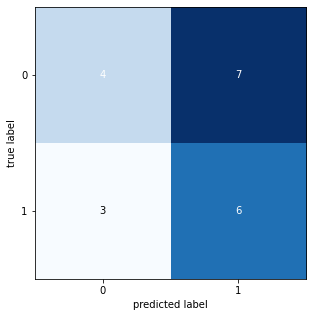

Train : [ 0  1  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 21 22 23 24 26
 28 29 32 33 34 35 36 38 40 41 42 43 44 45 46 48 49 50 51 52 53 54 55 56
 57 59 60 62 65 66 67 68 69 71 74 76 77 78 79 80 81 82 83 84 85 86 87 88
 90 91 92 93 94 96] Test : [ 2 20 25 27 30 31 37 39 47 58 61 63 64 70 72 73 75 89 95]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0]
Akurasi :  0.7894736842105263
F1_Score :  0.788888888888889
              precision    recall  f1-score   support

           0       0.80      0.80      0.80        10
           1       0.78      0.78      0.78         9

    accuracy                           0.79        19
   macro avg       0.79      0.79      0.79        19
weighted avg       0.79      0.79      0.79        19



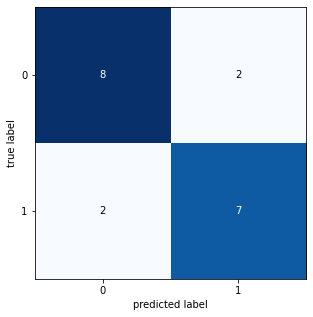

Train : [ 1  2  5  6  7  8  9 10 11 12 13 14 17 18 20 21 22 23 24 25 27 28 29 30
 31 32 33 34 35 36 37 39 40 41 42 43 44 45 47 49 50 52 53 56 57 58 59 61
 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 78 79 82 83 84 85 87 89 90
 91 92 93 94 95 96] Test : [ 0  3  4 15 16 19 26 38 46 48 51 54 55 60 77 80 81 86 88]
Y_Train : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 1 0 0 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Akurasi :  0.7368421052631579
F1_Score :  0.7338935574229692
              precision    recall  f1-score   support

           0       0.86      0.60      0.71        10
           1       0.67      0.89      0.76         9

    accuracy                           0.74        19
   macro avg       0.76      0.74      0.73        19
weighted avg       0.77      0.74      0.73        19



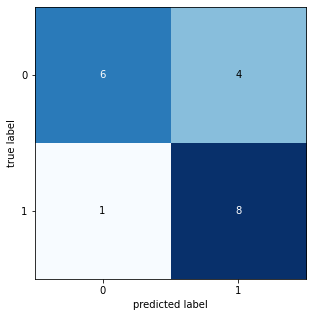

Train : [ 0  1  2  3  4  6  7  9 10 11 12 13 15 16 17 18 19 20 24 25 26 27 28 29
 30 31 32 33 34 36 37 38 39 40 41 44 46 47 48 49 50 51 52 54 55 56 57 58
 59 60 61 62 63 64 66 67 68 70 71 72 73 74 75 77 78 79 80 81 83 84 86 87
 88 89 93 94 95 96] Test : [ 5  8 14 21 22 23 35 42 43 45 53 65 69 76 82 85 90 91 92]
Y_Train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0]
Akurasi :  0.7368421052631579
F1_Score :  0.7338935574229692
              precision    recall  f1-score   support

           0       0.86      0.60      0.71        10
           1       0.67      0.89      0.76         9

    accuracy                           0.74        19
   macro avg       0.76      0.74      0.73        19
weighted avg       0.77      0.74      0.73        19



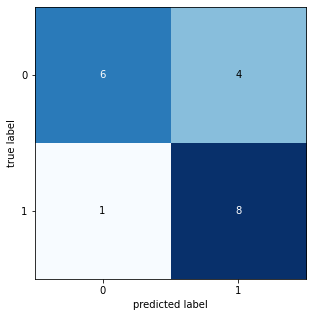

avg accuraccy Breast Cancer =  0.6826315789473684
avg F1_Score Breast Cancer =  0.6787138465399336
max accuraccy Breast Cancer =  0.7894736842105263
max F1_Score Breast Cancer =  0.788888888888889
min accuraccy Breast Cancer =  0.5
min F1_Score Breast Cancer =  0.494949494949495
Running Time:  40.32559592100006
gene : [0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0]
Train : [ 0  1  2  3  4  5  6  8 12 13 14 15 16 18 19 20 21 22 23 24 25 26 27 29
 30 31 32 33 35 37 38 39 40 41 42 43 45 46 47 48 50 51 53 54 55 58 60 61
 63 64 65 67 68 69 70 71 72 73 75 76 77 78 79 80 81 82 85 86 87 88 89 90
 91 92 93 94 95] Test : [ 7  9 10 11 17 28 34 36 44 49 52 56 57 59 62 66 74 83 84 96]
Y_Train : [1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1

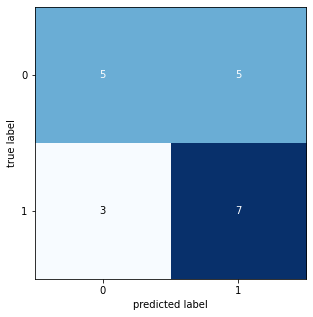

Train : [ 0  2  3  4  5  7  8  9 10 11 14 15 16 17 19 20 21 22 23 25 26 27 28 30
 31 34 35 36 37 38 39 42 43 44 45 46 47 48 49 51 52 53 54 55 56 57 58 59
 60 61 62 63 64 65 66 69 70 72 73 74 75 76 77 80 81 82 83 84 85 86 88 89
 90 91 92 95 96] Test : [ 1  6 12 13 18 24 29 32 33 40 41 50 67 68 71 78 79 87 93 94]
Y_Train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0]
Y_Test : [1 1 0 0 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Akurasi :  0.6
F1_Score :  0.595959595959596
              precision    recall  f1-score   support

           0       0.71      0.45      0.56        11
           1       0.54      0.78      0.64         9

    accuracy                           0.60        20
   macro avg       0.63      0.62      0.60        20
weighted avg       0.64      0.60      0.59        20



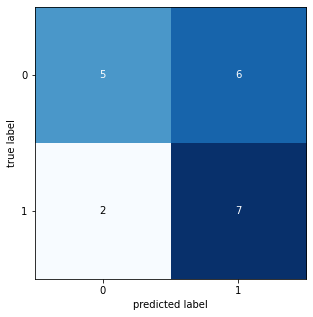

Train : [ 0  1  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 21 22 23 24 26
 28 29 32 33 34 35 36 38 40 41 42 43 44 45 46 48 49 50 51 52 53 54 55 56
 57 59 60 62 65 66 67 68 69 71 74 76 77 78 79 80 81 82 83 84 85 86 87 88
 90 91 92 93 94 96] Test : [ 2 20 25 27 30 31 37 39 47 58 61 63 64 70 72 73 75 89 95]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0]
Akurasi :  0.5789473684210527
F1_Score :  0.5777777777777777
              precision    recall  f1-score   support

           0       0.62      0.50      0.56        10
           1       0.55      0.67      0.60         9

    accuracy                           0.58        19
   macro avg       0.59      0.58      0.58        19
weighted avg       0.59      0.58      0.58        19



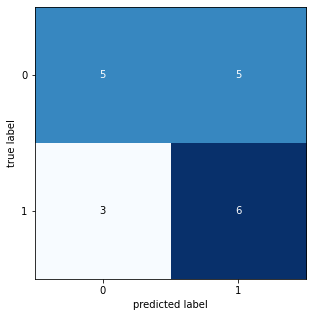

Train : [ 1  2  5  6  7  8  9 10 11 12 13 14 17 18 20 21 22 23 24 25 27 28 29 30
 31 32 33 34 35 36 37 39 40 41 42 43 44 45 47 49 50 52 53 56 57 58 59 61
 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 78 79 82 83 84 85 87 89 90
 91 92 93 94 95 96] Test : [ 0  3  4 15 16 19 26 38 46 48 51 54 55 60 77 80 81 86 88]
Y_Train : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 1 0 0 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Akurasi :  0.5789473684210527
F1_Score :  0.5681818181818181
              precision    recall  f1-score   support

           0       0.67      0.40      0.50        10
           1       0.54      0.78      0.64         9

    accuracy                           0.58        19
   macro avg       0.60      0.59      0.57        19
weighted avg       0.61      0.58      0.56        19



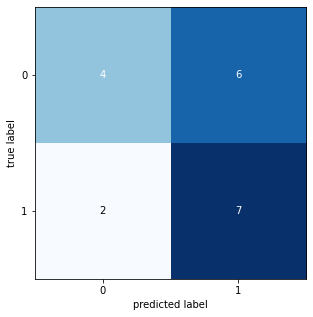

Train : [ 0  1  2  3  4  6  7  9 10 11 12 13 15 16 17 18 19 20 24 25 26 27 28 29
 30 31 32 33 34 36 37 38 39 40 41 44 46 47 48 49 50 51 52 54 55 56 57 58
 59 60 61 62 63 64 66 67 68 70 71 72 73 74 75 77 78 79 80 81 83 84 86 87
 88 89 93 94 95 96] Test : [ 5  8 14 21 22 23 35 42 43 45 53 65 69 76 82 85 90 91 92]
Y_Train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0]
Akurasi :  0.631578947368421
F1_Score :  0.631578947368421
              precision    recall  f1-score   support

           0       0.67      0.60      0.63        10
           1       0.60      0.67      0.63         9

    accuracy                           0.63        19
   macro avg       0.63      0.63      0.63        19
weighted avg       0.64      0.63      0.63        19



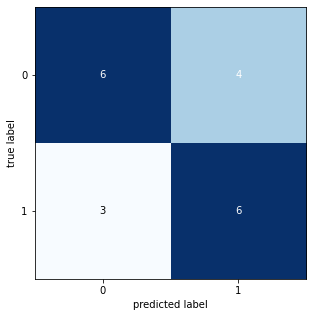

avg accuraccy Breast Cancer =  0.5978947368421054
avg F1_Score Breast Cancer =  0.5938915470494418
max accuraccy Breast Cancer =  0.631578947368421
max F1_Score Breast Cancer =  0.631578947368421
min accuraccy Breast Cancer =  0.5789473684210527
min F1_Score Breast Cancer =  0.5681818181818181
Running Time:  40.36408559700067
gene : [1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0]
Train : [ 0  1  2  3  4  5  6  8 12 13 14 15 16 18 19 20 21 22 23 24 25 26 27 29
 30 31 32 33 35 37 38 39 40 41 42 43 45 46 47 48 50 51 53 54 55 58 60 61
 63 64 65 67 68 69 70 71 72 73 75 76 77 78 79 80 81 82 85 86 87 88 89 90
 91 92 93 94 95] Test : [ 7  9 10 11 17 28 34 36 44 49 52 56 57 59 62 66 74 83 84 96]
Y_Train : [1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 

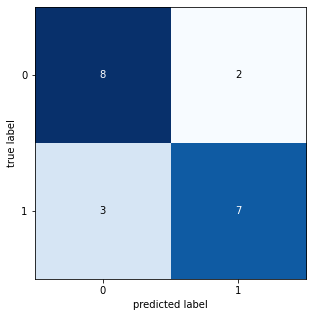

Train : [ 0  2  3  4  5  7  8  9 10 11 14 15 16 17 19 20 21 22 23 25 26 27 28 30
 31 34 35 36 37 38 39 42 43 44 45 46 47 48 49 51 52 53 54 55 56 57 58 59
 60 61 62 63 64 65 66 69 70 72 73 74 75 76 77 80 81 82 83 84 85 86 88 89
 90 91 92 95 96] Test : [ 1  6 12 13 18 24 29 32 33 40 41 50 67 68 71 78 79 87 93 94]
Y_Train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0]
Y_Test : [1 1 0 0 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Akurasi :  0.85
F1_Score :  0.849624060150376
              precision    recall  f1-score   support

           0       1.00      0.73      0.84        11
           1       0.75      1.00      0.86         9

    accuracy                           0.85        20
   macro avg       0.88      0.86      0.85        20
weighted avg       0.89      0.85      0.85        20



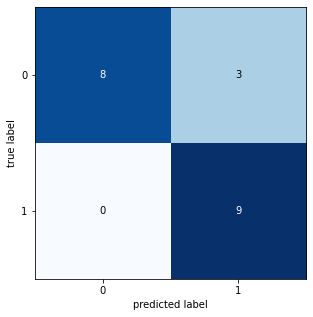

Train : [ 0  1  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 21 22 23 24 26
 28 29 32 33 34 35 36 38 40 41 42 43 44 45 46 48 49 50 51 52 53 54 55 56
 57 59 60 62 65 66 67 68 69 71 74 76 77 78 79 80 81 82 83 84 85 86 87 88
 90 91 92 93 94 96] Test : [ 2 20 25 27 30 31 37 39 47 58 61 63 64 70 72 73 75 89 95]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0]
Akurasi :  0.8421052631578947
F1_Score :  0.8403361344537816
              precision    recall  f1-score   support

           0       0.82      0.90      0.86        10
           1       0.88      0.78      0.82         9

    accuracy                           0.84        19
   macro avg       0.85      0.84      0.84        19
weighted avg       0.85      0.84      0.84        19



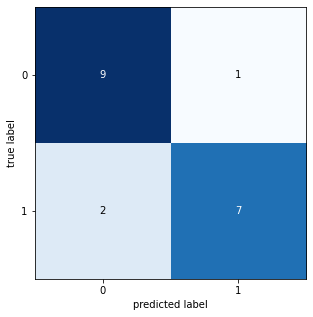

Train : [ 1  2  5  6  7  8  9 10 11 12 13 14 17 18 20 21 22 23 24 25 27 28 29 30
 31 32 33 34 35 36 37 39 40 41 42 43 44 45 47 49 50 52 53 56 57 58 59 61
 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 78 79 82 83 84 85 87 89 90
 91 92 93 94 95 96] Test : [ 0  3  4 15 16 19 26 38 46 48 51 54 55 60 77 80 81 86 88]
Y_Train : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 1 0 0 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Akurasi :  0.7368421052631579
F1_Score :  0.7246376811594203
              precision    recall  f1-score   support

           0       1.00      0.50      0.67        10
           1       0.64      1.00      0.78         9

    accuracy                           0.74        19
   macro avg       0.82      0.75      0.72        19
weighted avg       0.83      0.74      0.72        19



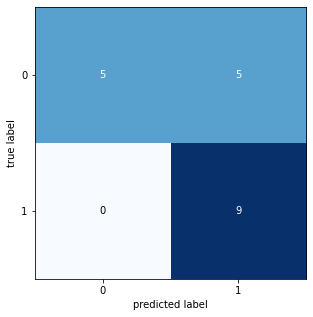

Train : [ 0  1  2  3  4  6  7  9 10 11 12 13 15 16 17 18 19 20 24 25 26 27 28 29
 30 31 32 33 34 36 37 38 39 40 41 44 46 47 48 49 50 51 52 54 55 56 57 58
 59 60 61 62 63 64 66 67 68 70 71 72 73 74 75 77 78 79 80 81 83 84 86 87
 88 89 93 94 95 96] Test : [ 5  8 14 21 22 23 35 42 43 45 53 65 69 76 82 85 90 91 92]
Y_Train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0]
Akurasi :  0.8421052631578947
F1_Score :  0.8421052631578948
              precision    recall  f1-score   support

           0       0.89      0.80      0.84        10
           1       0.80      0.89      0.84         9

    accuracy                           0.84        19
   macro avg       0.84      0.84      0.84        19
weighted avg       0.85      0.84      0.84        19



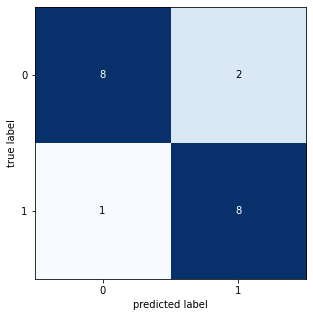

avg accuraccy Breast Cancer =  0.8042105263157895
avg F1_Score Breast Cancer =  0.8012153145010865
max accuraccy Breast Cancer =  0.85
max F1_Score Breast Cancer =  0.849624060150376
min accuraccy Breast Cancer =  0.7368421052631579
min F1_Score Breast Cancer =  0.7246376811594203
Running Time:  41.09717874299895
gene : [1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1]
Train : [ 0  1  2  3  4  5  6  8 12 13 14 15 16 18 19 20 21 22 23 24 25 26 27 29
 30 31 32 33 35 37 38 39 40 41 42 43 45 46 47 48 50 51 53 54 55 58 60 61
 63 64 65 67 68 69 70 71 72 73 75 76 77 78 79 80 81 82 85 86 87 88 89 90
 91 92 93 94 95] Test : [ 7  9 10 11 17 28 34 36 44 49 52 56 57 59 62 66 74 83 84 96]
Y_Train : [1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1

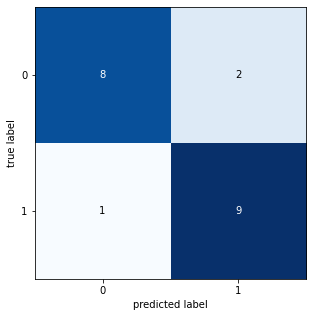

Train : [ 0  2  3  4  5  7  8  9 10 11 14 15 16 17 19 20 21 22 23 25 26 27 28 30
 31 34 35 36 37 38 39 42 43 44 45 46 47 48 49 51 52 53 54 55 56 57 58 59
 60 61 62 63 64 65 66 69 70 72 73 74 75 76 77 80 81 82 83 84 85 86 88 89
 90 91 92 95 96] Test : [ 1  6 12 13 18 24 29 32 33 40 41 50 67 68 71 78 79 87 93 94]
Y_Train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0]
Y_Test : [1 1 0 0 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Akurasi :  0.55
F1_Score :  0.5488721804511277
              precision    recall  f1-score   support

           0       0.60      0.55      0.57        11
           1       0.50      0.56      0.53         9

    accuracy                           0.55        20
   macro avg       0.55      0.55      0.55        20
weighted avg       0.55      0.55      0.55        20



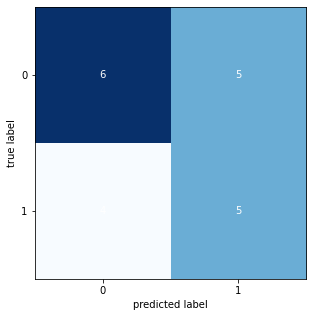

Train : [ 0  1  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 21 22 23 24 26
 28 29 32 33 34 35 36 38 40 41 42 43 44 45 46 48 49 50 51 52 53 54 55 56
 57 59 60 62 65 66 67 68 69 71 74 76 77 78 79 80 81 82 83 84 85 86 87 88
 90 91 92 93 94 96] Test : [ 2 20 25 27 30 31 37 39 47 58 61 63 64 70 72 73 75 89 95]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0]
Akurasi :  0.6842105263157895
F1_Score :  0.6833333333333333
              precision    recall  f1-score   support

           0       0.70      0.70      0.70        10
           1       0.67      0.67      0.67         9

    accuracy                           0.68        19
   macro avg       0.68      0.68      0.68        19
weighted avg       0.68      0.68      0.68        19



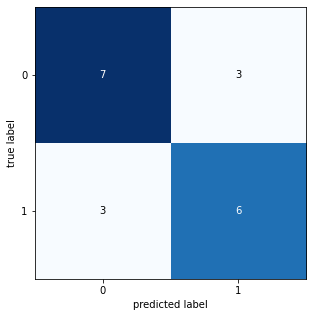

Train : [ 1  2  5  6  7  8  9 10 11 12 13 14 17 18 20 21 22 23 24 25 27 28 29 30
 31 32 33 34 35 36 37 39 40 41 42 43 44 45 47 49 50 52 53 56 57 58 59 61
 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 78 79 82 83 84 85 87 89 90
 91 92 93 94 95 96] Test : [ 0  3  4 15 16 19 26 38 46 48 51 54 55 60 77 80 81 86 88]
Y_Train : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 1 0 0 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Akurasi :  0.7368421052631579
F1_Score :  0.7338935574229692
              precision    recall  f1-score   support

           0       0.86      0.60      0.71        10
           1       0.67      0.89      0.76         9

    accuracy                           0.74        19
   macro avg       0.76      0.74      0.73        19
weighted avg       0.77      0.74      0.73        19



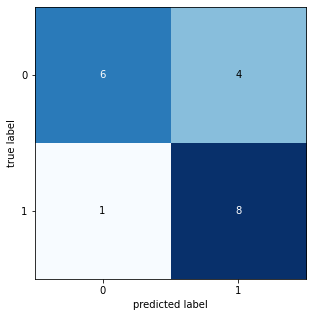

Train : [ 0  1  2  3  4  6  7  9 10 11 12 13 15 16 17 18 19 20 24 25 26 27 28 29
 30 31 32 33 34 36 37 38 39 40 41 44 46 47 48 49 50 51 52 54 55 56 57 58
 59 60 61 62 63 64 66 67 68 70 71 72 73 74 75 77 78 79 80 81 83 84 86 87
 88 89 93 94 95 96] Test : [ 5  8 14 21 22 23 35 42 43 45 53 65 69 76 82 85 90 91 92]
Y_Train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0]
Akurasi :  0.7894736842105263
F1_Score :  0.788888888888889
              precision    recall  f1-score   support

           0       0.80      0.80      0.80        10
           1       0.78      0.78      0.78         9

    accuracy                           0.79        19
   macro avg       0.79      0.79      0.79        19
weighted avg       0.79      0.79      0.79        19



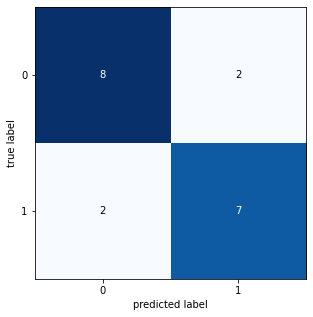

avg accuraccy Breast Cancer =  0.7221052631578948
avg F1_Score Breast Cancer =  0.720922404049339
max accuraccy Breast Cancer =  0.85
max F1_Score Breast Cancer =  0.849624060150376
min accuraccy Breast Cancer =  0.55
min F1_Score Breast Cancer =  0.5488721804511277
Running Time:  40.77114140600315
gene : [0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0]
Train : [ 0  1  2  3  4  5  6  8 12 13 14 15 16 18 19 20 21 22 23 24 25 26 27 29
 30 31 32 33 35 37 38 39 40 41 42 43 45 46 47 48 50 51 53 54 55 58 60 61
 63 64 65 67 68 69 70 71 72 73 75 76 77 78 79 80 81 82 85 86 87 88 89 90
 91 92 93 94 95] Test : [ 7  9 10 11 17 28 34 36 44 49 52 56 57 59 62 66 74 83 84 96]
Y_Train : [1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 

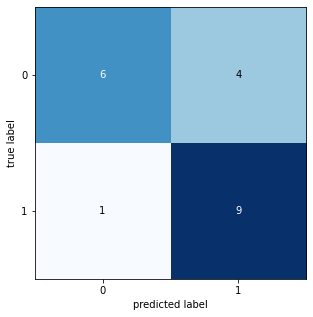

Train : [ 0  2  3  4  5  7  8  9 10 11 14 15 16 17 19 20 21 22 23 25 26 27 28 30
 31 34 35 36 37 38 39 42 43 44 45 46 47 48 49 51 52 53 54 55 56 57 58 59
 60 61 62 63 64 65 66 69 70 72 73 74 75 76 77 80 81 82 83 84 85 86 88 89
 90 91 92 95 96] Test : [ 1  6 12 13 18 24 29 32 33 40 41 50 67 68 71 78 79 87 93 94]
Y_Train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0]
Y_Test : [1 1 0 0 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Akurasi :  0.7
F1_Score :  0.7000000000000001
              precision    recall  f1-score   support

           0       0.78      0.64      0.70        11
           1       0.64      0.78      0.70         9

    accuracy                           0.70        20
   macro avg       0.71      0.71      0.70        20
weighted avg       0.71      0.70      0.70        20



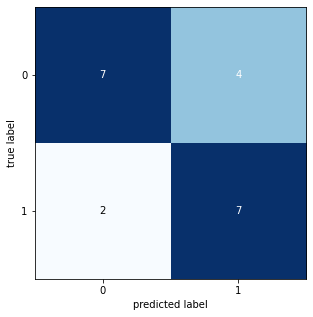

Train : [ 0  1  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 21 22 23 24 26
 28 29 32 33 34 35 36 38 40 41 42 43 44 45 46 48 49 50 51 52 53 54 55 56
 57 59 60 62 65 66 67 68 69 71 74 76 77 78 79 80 81 82 83 84 85 86 87 88
 90 91 92 93 94 96] Test : [ 2 20 25 27 30 31 37 39 47 58 61 63 64 70 72 73 75 89 95]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0]
Akurasi :  0.631578947368421
F1_Score :  0.6274509803921569
              precision    recall  f1-score   support

           0       0.64      0.70      0.67        10
           1       0.62      0.56      0.59         9

    accuracy                           0.63        19
   macro avg       0.63      0.63      0.63        19
weighted avg       0.63      0.63      0.63        19



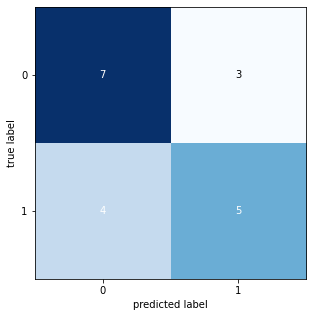

Train : [ 1  2  5  6  7  8  9 10 11 12 13 14 17 18 20 21 22 23 24 25 27 28 29 30
 31 32 33 34 35 36 37 39 40 41 42 43 44 45 47 49 50 52 53 56 57 58 59 61
 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 78 79 82 83 84 85 87 89 90
 91 92 93 94 95 96] Test : [ 0  3  4 15 16 19 26 38 46 48 51 54 55 60 77 80 81 86 88]
Y_Train : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 1 0 0 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Akurasi :  0.6842105263157895
F1_Score :  0.6833333333333333
              precision    recall  f1-score   support

           0       0.75      0.60      0.67        10
           1       0.64      0.78      0.70         9

    accuracy                           0.68        19
   macro avg       0.69      0.69      0.68        19
weighted avg       0.70      0.68      0.68        19



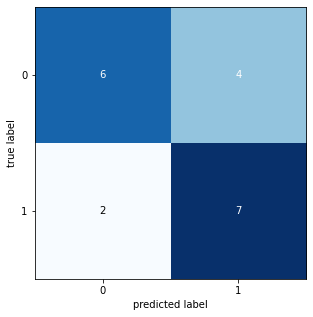

Train : [ 0  1  2  3  4  6  7  9 10 11 12 13 15 16 17 18 19 20 24 25 26 27 28 29
 30 31 32 33 34 36 37 38 39 40 41 44 46 47 48 49 50 51 52 54 55 56 57 58
 59 60 61 62 63 64 66 67 68 70 71 72 73 74 75 77 78 79 80 81 83 84 86 87
 88 89 93 94 95 96] Test : [ 5  8 14 21 22 23 35 42 43 45 53 65 69 76 82 85 90 91 92]
Y_Train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0]
Akurasi :  0.631578947368421
F1_Score :  0.631578947368421
              precision    recall  f1-score   support

           0       0.67      0.60      0.63        10
           1       0.60      0.67      0.63         9

    accuracy                           0.63        19
   macro avg       0.63      0.63      0.63        19
weighted avg       0.64      0.63      0.63        19



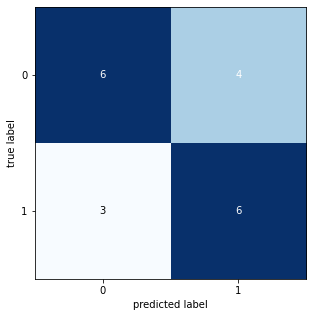

avg accuraccy Breast Cancer =  0.6794736842105262
avg F1_Score Breast Cancer =  0.6773217570781174
max accuraccy Breast Cancer =  0.75
max F1_Score Breast Cancer =  0.7442455242966751
min accuraccy Breast Cancer =  0.631578947368421
min F1_Score Breast Cancer =  0.6274509803921569
Running Time:  38.51603136099948
gen terbaik : [1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0]
F-1 Score terbaik : 0.8012153145010865  || Akurasi terbaik : 0.8042105263157895  || jumlah fitur : 53

Generation : 1
gene : [1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0

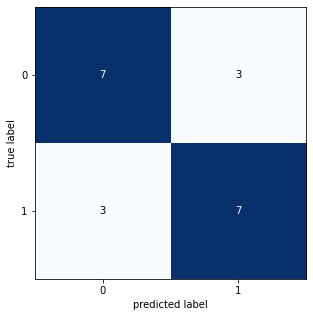

Train : [ 0  2  3  4  5  7  8  9 10 11 14 15 16 17 19 20 21 22 23 25 26 27 28 30
 31 34 35 36 37 38 39 42 43 44 45 46 47 48 49 51 52 53 54 55 56 57 58 59
 60 61 62 63 64 65 66 69 70 72 73 74 75 76 77 80 81 82 83 84 85 86 88 89
 90 91 92 95 96] Test : [ 1  6 12 13 18 24 29 32 33 40 41 50 67 68 71 78 79 87 93 94]
Y_Train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0]
Y_Test : [1 1 0 0 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Akurasi :  0.75
F1_Score :  0.7442455242966752
              precision    recall  f1-score   support

           0       0.75      0.82      0.78        11
           1       0.75      0.67      0.71         9

    accuracy                           0.75        20
   macro avg       0.75      0.74      0.74        20
weighted avg       0.75      0.75      0.75        20



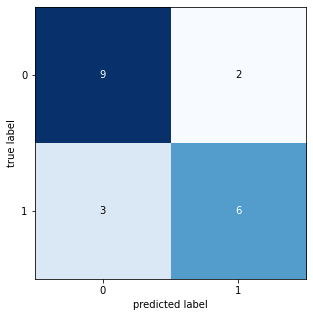

Train : [ 0  1  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 21 22 23 24 26
 28 29 32 33 34 35 36 38 40 41 42 43 44 45 46 48 49 50 51 52 53 54 55 56
 57 59 60 62 65 66 67 68 69 71 74 76 77 78 79 80 81 82 83 84 85 86 87 88
 90 91 92 93 94 96] Test : [ 2 20 25 27 30 31 37 39 47 58 61 63 64 70 72 73 75 89 95]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0]
Akurasi :  0.7368421052631579
F1_Score :  0.7338935574229692
              precision    recall  f1-score   support

           0       0.86      0.60      0.71        10
           1       0.67      0.89      0.76         9

    accuracy                           0.74        19
   macro avg       0.76      0.74      0.73        19
weighted avg       0.77      0.74      0.73        19



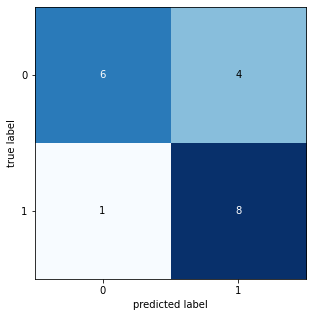

Train : [ 1  2  5  6  7  8  9 10 11 12 13 14 17 18 20 21 22 23 24 25 27 28 29 30
 31 32 33 34 35 36 37 39 40 41 42 43 44 45 47 49 50 52 53 56 57 58 59 61
 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 78 79 82 83 84 85 87 89 90
 91 92 93 94 95 96] Test : [ 0  3  4 15 16 19 26 38 46 48 51 54 55 60 77 80 81 86 88]
Y_Train : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 1 0 0 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Akurasi :  0.7894736842105263
F1_Score :  0.784090909090909
              precision    recall  f1-score   support

           0       1.00      0.60      0.75        10
           1       0.69      1.00      0.82         9

    accuracy                           0.79        19
   macro avg       0.85      0.80      0.78        19
weighted avg       0.85      0.79      0.78        19



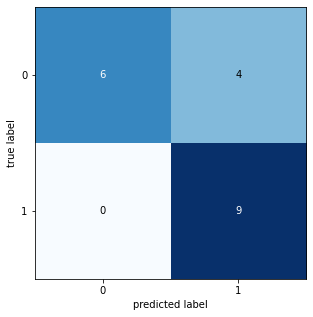

Train : [ 0  1  2  3  4  6  7  9 10 11 12 13 15 16 17 18 19 20 24 25 26 27 28 29
 30 31 32 33 34 36 37 38 39 40 41 44 46 47 48 49 50 51 52 54 55 56 57 58
 59 60 61 62 63 64 66 67 68 70 71 72 73 74 75 77 78 79 80 81 83 84 86 87
 88 89 93 94 95 96] Test : [ 5  8 14 21 22 23 35 42 43 45 53 65 69 76 82 85 90 91 92]
Y_Train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0]
Akurasi :  0.8421052631578947
F1_Score :  0.8421052631578948
              precision    recall  f1-score   support

           0       0.89      0.80      0.84        10
           1       0.80      0.89      0.84         9

    accuracy                           0.84        19
   macro avg       0.84      0.84      0.84        19
weighted avg       0.85      0.84      0.84        19



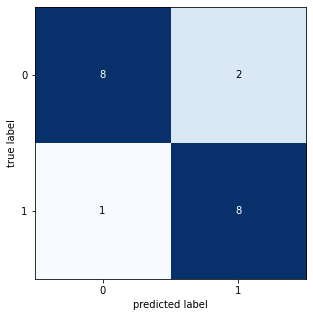

avg accuraccy Breast Cancer =  0.7636842105263157
avg F1_Score Breast Cancer =  0.7608670507936897
max accuraccy Breast Cancer =  0.8421052631578947
max F1_Score Breast Cancer =  0.8421052631578948
min accuraccy Breast Cancer =  0.7
min F1_Score Breast Cancer =  0.7
Running Time:  41.138761297999736
gene : [1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0]
Train : [ 0  1  2  3  4  5  6  8 12 13 14 15 16 18 19 20 21 22 23 24 25 26 27 29
 30 31 32 33 35 37 38 39 40 41 42 43 45 46 47 48 50 51 53 54 55 58 60 61
 63 64 65 67 68 69 70 71 72 73 75 76 77 78 79 80 81 82 85 86 87 88 89 90
 91 92 93 94 95] Test : [ 7  9 10 11 17 28 34 36 44 49 52 56 57 59 62 66 74 83 84 96]
Y_Train : [1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1

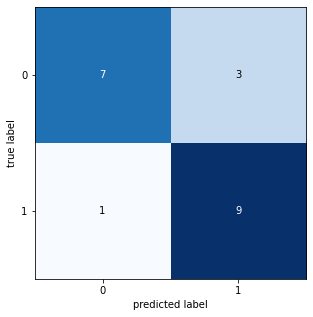

Train : [ 0  2  3  4  5  7  8  9 10 11 14 15 16 17 19 20 21 22 23 25 26 27 28 30
 31 34 35 36 37 38 39 42 43 44 45 46 47 48 49 51 52 53 54 55 56 57 58 59
 60 61 62 63 64 65 66 69 70 72 73 74 75 76 77 80 81 82 83 84 85 86 88 89
 90 91 92 95 96] Test : [ 1  6 12 13 18 24 29 32 33 40 41 50 67 68 71 78 79 87 93 94]
Y_Train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0]
Y_Test : [1 1 0 0 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Akurasi :  0.75
F1_Score :  0.7442455242966752
              precision    recall  f1-score   support

           0       1.00      0.55      0.71        11
           1       0.64      1.00      0.78         9

    accuracy                           0.75        20
   macro avg       0.82      0.77      0.74        20
weighted avg       0.84      0.75      0.74        20



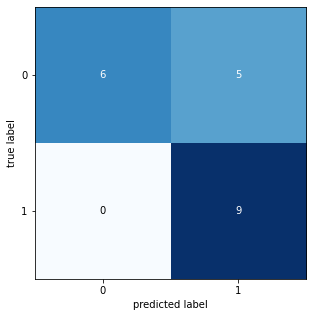

Train : [ 0  1  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 21 22 23 24 26
 28 29 32 33 34 35 36 38 40 41 42 43 44 45 46 48 49 50 51 52 53 54 55 56
 57 59 60 62 65 66 67 68 69 71 74 76 77 78 79 80 81 82 83 84 85 86 87 88
 90 91 92 93 94 96] Test : [ 2 20 25 27 30 31 37 39 47 58 61 63 64 70 72 73 75 89 95]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0]
Akurasi :  0.7894736842105263
F1_Score :  0.7888888888888888
              precision    recall  f1-score   support

           0       0.88      0.70      0.78        10
           1       0.73      0.89      0.80         9

    accuracy                           0.79        19
   macro avg       0.80      0.79      0.79        19
weighted avg       0.81      0.79      0.79        19



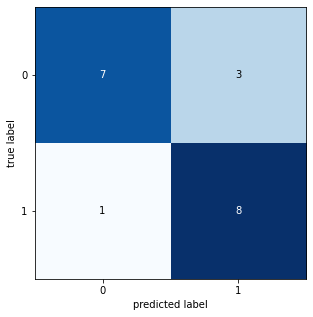

Train : [ 1  2  5  6  7  8  9 10 11 12 13 14 17 18 20 21 22 23 24 25 27 28 29 30
 31 32 33 34 35 36 37 39 40 41 42 43 44 45 47 49 50 52 53 56 57 58 59 61
 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 78 79 82 83 84 85 87 89 90
 91 92 93 94 95 96] Test : [ 0  3  4 15 16 19 26 38 46 48 51 54 55 60 77 80 81 86 88]
Y_Train : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 1 0 0 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Akurasi :  0.6842105263157895
F1_Score :  0.6761363636363638
              precision    recall  f1-score   support

           0       0.83      0.50      0.62        10
           1       0.62      0.89      0.73         9

    accuracy                           0.68        19
   macro avg       0.72      0.69      0.68        19
weighted avg       0.73      0.68      0.67        19



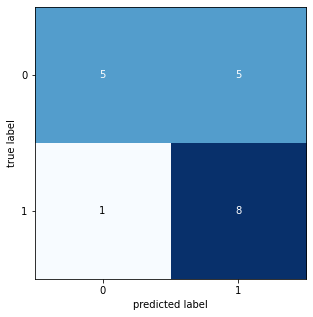

Train : [ 0  1  2  3  4  6  7  9 10 11 12 13 15 16 17 18 19 20 24 25 26 27 28 29
 30 31 32 33 34 36 37 38 39 40 41 44 46 47 48 49 50 51 52 54 55 56 57 58
 59 60 61 62 63 64 66 67 68 70 71 72 73 74 75 77 78 79 80 81 83 84 86 87
 88 89 93 94 95 96] Test : [ 5  8 14 21 22 23 35 42 43 45 53 65 69 76 82 85 90 91 92]
Y_Train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0]
Akurasi :  0.7368421052631579
F1_Score :  0.7368421052631577
              precision    recall  f1-score   support

           0       0.78      0.70      0.74        10
           1       0.70      0.78      0.74         9

    accuracy                           0.74        19
   macro avg       0.74      0.74      0.74        19
weighted avg       0.74      0.74      0.74        19



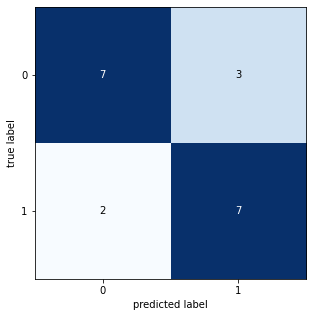

avg accuraccy Breast Cancer =  0.7521052631578947
avg F1_Score Breast Cancer =  0.7488185360129768
max accuraccy Breast Cancer =  0.8
max F1_Score Breast Cancer =  0.797979797979798
min accuraccy Breast Cancer =  0.6842105263157895
min F1_Score Breast Cancer =  0.6761363636363638
Running Time:  39.509484525002335
gene : [0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1]
Train : [ 0  1  2  3  4  5  6  8 12 13 14 15 16 18 19 20 21 22 23 24 25 26 27 29
 30 31 32 33 35 37 38 39 40 41 42 43 45 46 47 48 50 51 53 54 55 58 60 61
 63 64 65 67 68 69 70 71 72 73 75 76 77 78 79 80 81 82 85 86 87 88 89 90
 91 92 93 94 95] Test : [ 7  9 10 11 17 28 34 36 44 49 52 56 57 59 62 66 74 83 84 96]
Y_Train : [1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1

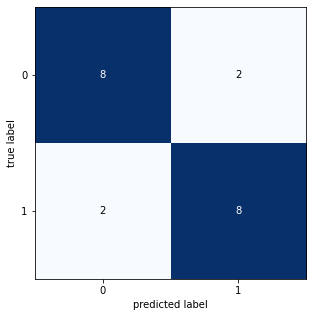

Train : [ 0  2  3  4  5  7  8  9 10 11 14 15 16 17 19 20 21 22 23 25 26 27 28 30
 31 34 35 36 37 38 39 42 43 44 45 46 47 48 49 51 52 53 54 55 56 57 58 59
 60 61 62 63 64 65 66 69 70 72 73 74 75 76 77 80 81 82 83 84 85 86 88 89
 90 91 92 95 96] Test : [ 1  6 12 13 18 24 29 32 33 40 41 50 67 68 71 78 79 87 93 94]
Y_Train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0]
Y_Test : [1 1 0 0 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Akurasi :  0.85
F1_Score :  0.849624060150376
              precision    recall  f1-score   support

           0       0.90      0.82      0.86        11
           1       0.80      0.89      0.84         9

    accuracy                           0.85        20
   macro avg       0.85      0.85      0.85        20
weighted avg       0.86      0.85      0.85        20



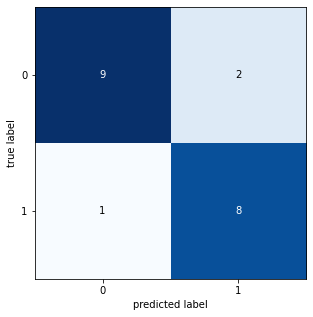

Train : [ 0  1  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 21 22 23 24 26
 28 29 32 33 34 35 36 38 40 41 42 43 44 45 46 48 49 50 51 52 53 54 55 56
 57 59 60 62 65 66 67 68 69 71 74 76 77 78 79 80 81 82 83 84 85 86 87 88
 90 91 92 93 94 96] Test : [ 2 20 25 27 30 31 37 39 47 58 61 63 64 70 72 73 75 89 95]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0]
Akurasi :  0.8421052631578947
F1_Score :  0.8421052631578948
              precision    recall  f1-score   support

           0       0.89      0.80      0.84        10
           1       0.80      0.89      0.84         9

    accuracy                           0.84        19
   macro avg       0.84      0.84      0.84        19
weighted avg       0.85      0.84      0.84        19



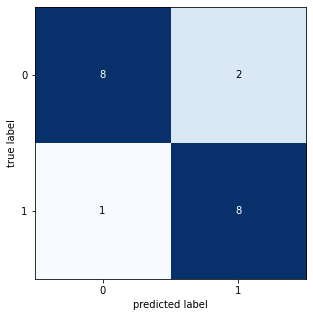

Train : [ 1  2  5  6  7  8  9 10 11 12 13 14 17 18 20 21 22 23 24 25 27 28 29 30
 31 32 33 34 35 36 37 39 40 41 42 43 44 45 47 49 50 52 53 56 57 58 59 61
 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 78 79 82 83 84 85 87 89 90
 91 92 93 94 95 96] Test : [ 0  3  4 15 16 19 26 38 46 48 51 54 55 60 77 80 81 86 88]
Y_Train : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 1 0 0 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Akurasi :  0.7894736842105263
F1_Score :  0.7888888888888888
              precision    recall  f1-score   support

           0       0.88      0.70      0.78        10
           1       0.73      0.89      0.80         9

    accuracy                           0.79        19
   macro avg       0.80      0.79      0.79        19
weighted avg       0.81      0.79      0.79        19



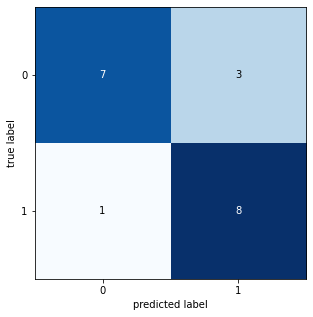

Train : [ 0  1  2  3  4  6  7  9 10 11 12 13 15 16 17 18 19 20 24 25 26 27 28 29
 30 31 32 33 34 36 37 38 39 40 41 44 46 47 48 49 50 51 52 54 55 56 57 58
 59 60 61 62 63 64 66 67 68 70 71 72 73 74 75 77 78 79 80 81 83 84 86 87
 88 89 93 94 95 96] Test : [ 5  8 14 21 22 23 35 42 43 45 53 65 69 76 82 85 90 91 92]
Y_Train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0]
Akurasi :  0.8421052631578947
F1_Score :  0.8421052631578948
              precision    recall  f1-score   support

           0       0.89      0.80      0.84        10
           1       0.80      0.89      0.84         9

    accuracy                           0.84        19
   macro avg       0.84      0.84      0.84        19
weighted avg       0.85      0.84      0.84        19



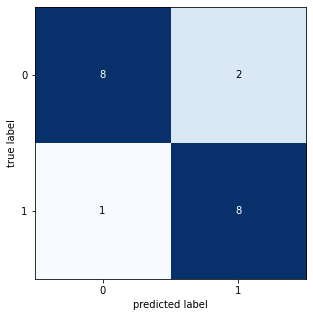

avg accuraccy Breast Cancer =  0.8247368421052631
avg F1_Score Breast Cancer =  0.8245446950710109
max accuraccy Breast Cancer =  0.85
max F1_Score Breast Cancer =  0.849624060150376
min accuraccy Breast Cancer =  0.7894736842105263
min F1_Score Breast Cancer =  0.7888888888888888
Running Time:  38.6218637919992
gene : [1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0]
Train : [ 0  1  2  3  4  5  6  8 12 13 14 15 16 18 19 20 21 22 23 24 25 26 27 29
 30 31 32 33 35 37 38 39 40 41 42 43 45 46 47 48 50 51 53 54 55 58 60 61
 63 64 65 67 68 69 70 71 72 73 75 76 77 78 79 80 81 82 85 86 87 88 89 90
 91 92 93 94 95] Test : [ 7  9 10 11 17 28 34 36 44 49 52 56 57 59 62 66 74 83 84 96]
Y_Train : [1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 

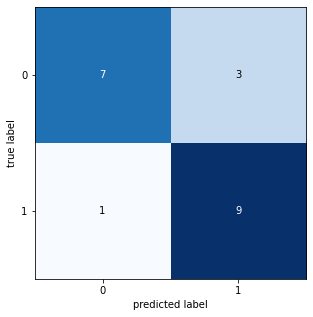

Train : [ 0  2  3  4  5  7  8  9 10 11 14 15 16 17 19 20 21 22 23 25 26 27 28 30
 31 34 35 36 37 38 39 42 43 44 45 46 47 48 49 51 52 53 54 55 56 57 58 59
 60 61 62 63 64 65 66 69 70 72 73 74 75 76 77 80 81 82 83 84 85 86 88 89
 90 91 92 95 96] Test : [ 1  6 12 13 18 24 29 32 33 40 41 50 67 68 71 78 79 87 93 94]
Y_Train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0]
Y_Test : [1 1 0 0 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Akurasi :  0.9
F1_Score :  0.9
              precision    recall  f1-score   support

           0       1.00      0.82      0.90        11
           1       0.82      1.00      0.90         9

    accuracy                           0.90        20
   macro avg       0.91      0.91      0.90        20
weighted avg       0.92      0.90      0.90        20



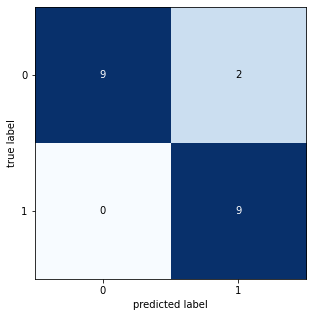

Train : [ 0  1  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 21 22 23 24 26
 28 29 32 33 34 35 36 38 40 41 42 43 44 45 46 48 49 50 51 52 53 54 55 56
 57 59 60 62 65 66 67 68 69 71 74 76 77 78 79 80 81 82 83 84 85 86 87 88
 90 91 92 93 94 96] Test : [ 2 20 25 27 30 31 37 39 47 58 61 63 64 70 72 73 75 89 95]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0]
Akurasi :  0.7368421052631579
F1_Score :  0.7338935574229692
              precision    recall  f1-score   support

           0       0.73      0.80      0.76        10
           1       0.75      0.67      0.71         9

    accuracy                           0.74        19
   macro avg       0.74      0.73      0.73        19
weighted avg       0.74      0.74      0.74        19



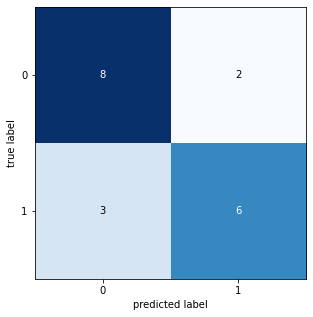

Train : [ 1  2  5  6  7  8  9 10 11 12 13 14 17 18 20 21 22 23 24 25 27 28 29 30
 31 32 33 34 35 36 37 39 40 41 42 43 44 45 47 49 50 52 53 56 57 58 59 61
 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 78 79 82 83 84 85 87 89 90
 91 92 93 94 95 96] Test : [ 0  3  4 15 16 19 26 38 46 48 51 54 55 60 77 80 81 86 88]
Y_Train : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 1 0 0 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Akurasi :  0.631578947368421
F1_Score :  0.6144927536231883
              precision    recall  f1-score   support

           0       0.80      0.40      0.53        10
           1       0.57      0.89      0.70         9

    accuracy                           0.63        19
   macro avg       0.69      0.64      0.61        19
weighted avg       0.69      0.63      0.61        19



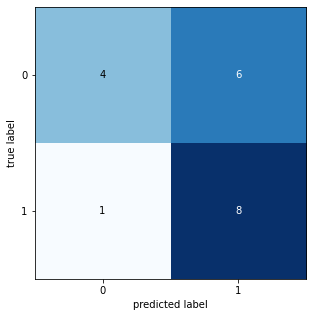

Train : [ 0  1  2  3  4  6  7  9 10 11 12 13 15 16 17 18 19 20 24 25 26 27 28 29
 30 31 32 33 34 36 37 38 39 40 41 44 46 47 48 49 50 51 52 54 55 56 57 58
 59 60 61 62 63 64 66 67 68 70 71 72 73 74 75 77 78 79 80 81 83 84 86 87
 88 89 93 94 95 96] Test : [ 5  8 14 21 22 23 35 42 43 45 53 65 69 76 82 85 90 91 92]
Y_Train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0]
Akurasi :  0.8421052631578947
F1_Score :  0.8421052631578948
              precision    recall  f1-score   support

           0       0.89      0.80      0.84        10
           1       0.80      0.89      0.84         9

    accuracy                           0.84        19
   macro avg       0.84      0.84      0.84        19
weighted avg       0.85      0.84      0.84        19



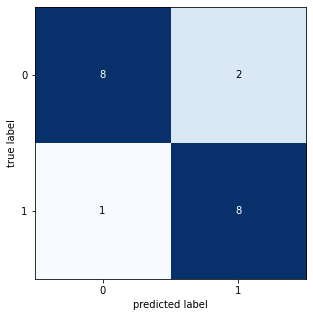

avg accuraccy Breast Cancer =  0.7821052631578947
avg F1_Score Breast Cancer =  0.77769427443677
max accuraccy Breast Cancer =  0.9
max F1_Score Breast Cancer =  0.9
min accuraccy Breast Cancer =  0.631578947368421
min F1_Score Breast Cancer =  0.6144927536231883
Running Time:  42.97852720199808
gene : [1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1]
Train : [ 0  1  2  3  4  5  6  8 12 13 14 15 16 18 19 20 21 22 23 24 25 26 27 29
 30 31 32 33 35 37 38 39 40 41 42 43 45 46 47 48 50 51 53 54 55 58 60 61
 63 64 65 67 68 69 70 71 72 73 75 76 77 78 79 80 81 82 85 86 87 88 89 90
 91 92 93 94 95] Test : [ 7  9 10 11 17 28 34 36 44 49 52 56 57 59 62 66 74 83 84 96]
Y_Train : [1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1

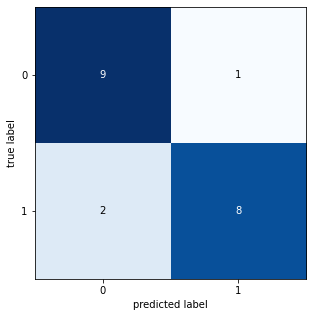

Train : [ 0  2  3  4  5  7  8  9 10 11 14 15 16 17 19 20 21 22 23 25 26 27 28 30
 31 34 35 36 37 38 39 42 43 44 45 46 47 48 49 51 52 53 54 55 56 57 58 59
 60 61 62 63 64 65 66 69 70 72 73 74 75 76 77 80 81 82 83 84 85 86 88 89
 90 91 92 95 96] Test : [ 1  6 12 13 18 24 29 32 33 40 41 50 67 68 71 78 79 87 93 94]
Y_Train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0]
Y_Test : [1 1 0 0 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Akurasi :  0.9
F1_Score :  0.9
              precision    recall  f1-score   support

           0       1.00      0.82      0.90        11
           1       0.82      1.00      0.90         9

    accuracy                           0.90        20
   macro avg       0.91      0.91      0.90        20
weighted avg       0.92      0.90      0.90        20



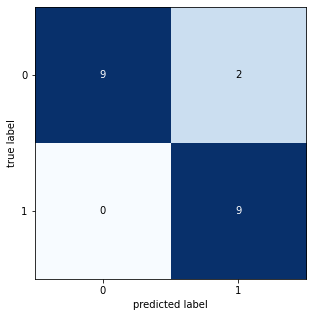

Train : [ 0  1  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 21 22 23 24 26
 28 29 32 33 34 35 36 38 40 41 42 43 44 45 46 48 49 50 51 52 53 54 55 56
 57 59 60 62 65 66 67 68 69 71 74 76 77 78 79 80 81 82 83 84 85 86 87 88
 90 91 92 93 94 96] Test : [ 2 20 25 27 30 31 37 39 47 58 61 63 64 70 72 73 75 89 95]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0]
Akurasi :  0.8421052631578947
F1_Score :  0.8403361344537816
              precision    recall  f1-score   support

           0       0.82      0.90      0.86        10
           1       0.88      0.78      0.82         9

    accuracy                           0.84        19
   macro avg       0.85      0.84      0.84        19
weighted avg       0.85      0.84      0.84        19



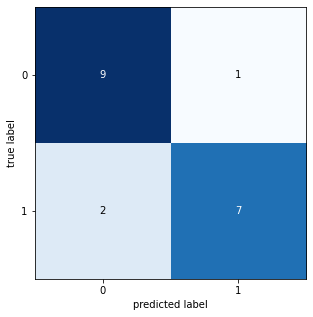

Train : [ 1  2  5  6  7  8  9 10 11 12 13 14 17 18 20 21 22 23 24 25 27 28 29 30
 31 32 33 34 35 36 37 39 40 41 42 43 44 45 47 49 50 52 53 56 57 58 59 61
 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 78 79 82 83 84 85 87 89 90
 91 92 93 94 95 96] Test : [ 0  3  4 15 16 19 26 38 46 48 51 54 55 60 77 80 81 86 88]
Y_Train : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 1 0 0 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Akurasi :  0.7368421052631579
F1_Score :  0.7246376811594203
              precision    recall  f1-score   support

           0       1.00      0.50      0.67        10
           1       0.64      1.00      0.78         9

    accuracy                           0.74        19
   macro avg       0.82      0.75      0.72        19
weighted avg       0.83      0.74      0.72        19



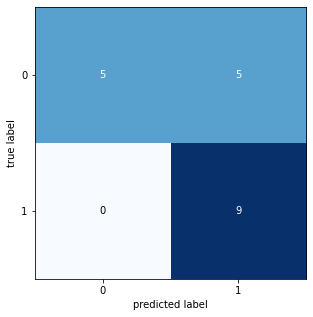

Train : [ 0  1  2  3  4  6  7  9 10 11 12 13 15 16 17 18 19 20 24 25 26 27 28 29
 30 31 32 33 34 36 37 38 39 40 41 44 46 47 48 49 50 51 52 54 55 56 57 58
 59 60 61 62 63 64 66 67 68 70 71 72 73 74 75 77 78 79 80 81 83 84 86 87
 88 89 93 94 95 96] Test : [ 5  8 14 21 22 23 35 42 43 45 53 65 69 76 82 85 90 91 92]
Y_Train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0]
Akurasi :  0.8421052631578947
F1_Score :  0.8421052631578948
              precision    recall  f1-score   support

           0       0.89      0.80      0.84        10
           1       0.80      0.89      0.84         9

    accuracy                           0.84        19
   macro avg       0.84      0.84      0.84        19
weighted avg       0.85      0.84      0.84        19



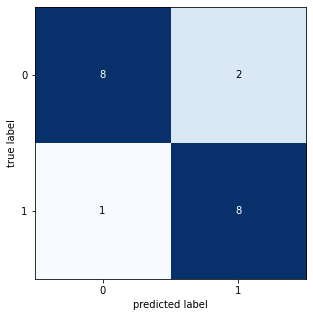

avg accuraccy Breast Cancer =  0.8342105263157894
avg F1_Score Breast Cancer =  0.8313406277842945
max accuraccy Breast Cancer =  0.9
max F1_Score Breast Cancer =  0.9
min accuraccy Breast Cancer =  0.7368421052631579
min F1_Score Breast Cancer =  0.7246376811594203
Running Time:  41.43566904799809
gene : [1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0]
Train : [ 0  1  2  3  4  5  6  8 12 13 14 15 16 18 19 20 21 22 23 24 25 26 27 29
 30 31 32 33 35 37 38 39 40 41 42 43 45 46 47 48 50 51 53 54 55 58 60 61
 63 64 65 67 68 69 70 71 72 73 75 76 77 78 79 80 81 82 85 86 87 88 89 90
 91 92 93 94 95] Test : [ 7  9 10 11 17 28 34 36 44 49 52 56 57 59 62 66 74 83 84 96]
Y_Train : [1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 

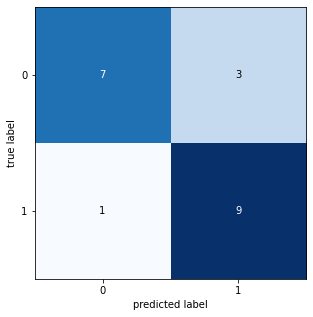

Train : [ 0  2  3  4  5  7  8  9 10 11 14 15 16 17 19 20 21 22 23 25 26 27 28 30
 31 34 35 36 37 38 39 42 43 44 45 46 47 48 49 51 52 53 54 55 56 57 58 59
 60 61 62 63 64 65 66 69 70 72 73 74 75 76 77 80 81 82 83 84 85 86 88 89
 90 91 92 95 96] Test : [ 1  6 12 13 18 24 29 32 33 40 41 50 67 68 71 78 79 87 93 94]
Y_Train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0]
Y_Test : [1 1 0 0 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Akurasi :  0.8
F1_Score :  0.7999999999999999
              precision    recall  f1-score   support

           0       0.89      0.73      0.80        11
           1       0.73      0.89      0.80         9

    accuracy                           0.80        20
   macro avg       0.81      0.81      0.80        20
weighted avg       0.82      0.80      0.80        20



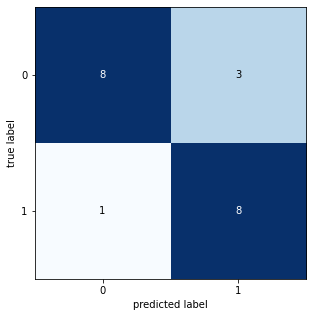

Train : [ 0  1  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 21 22 23 24 26
 28 29 32 33 34 35 36 38 40 41 42 43 44 45 46 48 49 50 51 52 53 54 55 56
 57 59 60 62 65 66 67 68 69 71 74 76 77 78 79 80 81 82 83 84 85 86 87 88
 90 91 92 93 94 96] Test : [ 2 20 25 27 30 31 37 39 47 58 61 63 64 70 72 73 75 89 95]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0]
Akurasi :  0.6842105263157895
F1_Score :  0.6833333333333333
              precision    recall  f1-score   support

           0       0.75      0.60      0.67        10
           1       0.64      0.78      0.70         9

    accuracy                           0.68        19
   macro avg       0.69      0.69      0.68        19
weighted avg       0.70      0.68      0.68        19



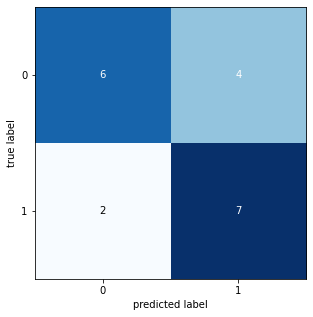

Train : [ 1  2  5  6  7  8  9 10 11 12 13 14 17 18 20 21 22 23 24 25 27 28 29 30
 31 32 33 34 35 36 37 39 40 41 42 43 44 45 47 49 50 52 53 56 57 58 59 61
 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 78 79 82 83 84 85 87 89 90
 91 92 93 94 95 96] Test : [ 0  3  4 15 16 19 26 38 46 48 51 54 55 60 77 80 81 86 88]
Y_Train : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 1 0 0 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Akurasi :  0.7368421052631579
F1_Score :  0.7338935574229692
              precision    recall  f1-score   support

           0       0.86      0.60      0.71        10
           1       0.67      0.89      0.76         9

    accuracy                           0.74        19
   macro avg       0.76      0.74      0.73        19
weighted avg       0.77      0.74      0.73        19



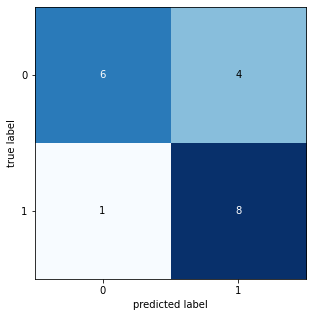

Train : [ 0  1  2  3  4  6  7  9 10 11 12 13 15 16 17 18 19 20 24 25 26 27 28 29
 30 31 32 33 34 36 37 38 39 40 41 44 46 47 48 49 50 51 52 54 55 56 57 58
 59 60 61 62 63 64 66 67 68 70 71 72 73 74 75 77 78 79 80 81 83 84 86 87
 88 89 93 94 95 96] Test : [ 5  8 14 21 22 23 35 42 43 45 53 65 69 76 82 85 90 91 92]
Y_Train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0]
Akurasi :  0.7368421052631579
F1_Score :  0.7368421052631577
              precision    recall  f1-score   support

           0       0.78      0.70      0.74        10
           1       0.70      0.78      0.74         9

    accuracy                           0.74        19
   macro avg       0.74      0.74      0.74        19
weighted avg       0.74      0.74      0.74        19



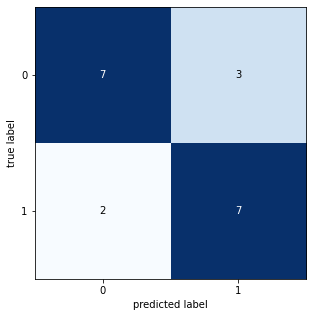

avg accuraccy Breast Cancer =  0.7515789473684211
avg F1_Score Breast Cancer =  0.7504097587998515
max accuraccy Breast Cancer =  0.8
max F1_Score Breast Cancer =  0.7999999999999999
min accuraccy Breast Cancer =  0.6842105263157895
min F1_Score Breast Cancer =  0.6833333333333333
Running Time:  39.13389385100163
gene : [1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0]
Train : [ 0  1  2  3  4  5  6  8 12 13 14 15 16 18 19 20 21 22 23 24 25 26 27 29
 30 31 32 33 35 37 38 39 40 41 42 43 45 46 47 48 50 51 53 54 55 58 60 61
 63 64 65 67 68 69 70 71 72 73 75 76 77 78 79 80 81 82 85 86 87 88 89 90
 91 92 93 94 95] Test : [ 7  9 10 11 17 28 34 36 44 49 52 56 57 59 62 66 74 83 84 96]
Y_Train : [1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1

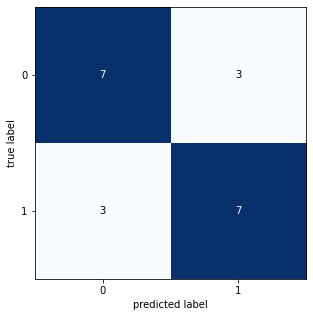

Train : [ 0  2  3  4  5  7  8  9 10 11 14 15 16 17 19 20 21 22 23 25 26 27 28 30
 31 34 35 36 37 38 39 42 43 44 45 46 47 48 49 51 52 53 54 55 56 57 58 59
 60 61 62 63 64 65 66 69 70 72 73 74 75 76 77 80 81 82 83 84 85 86 88 89
 90 91 92 95 96] Test : [ 1  6 12 13 18 24 29 32 33 40 41 50 67 68 71 78 79 87 93 94]
Y_Train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0]
Y_Test : [1 1 0 0 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Akurasi :  0.85
F1_Score :  0.849624060150376
              precision    recall  f1-score   support

           0       0.90      0.82      0.86        11
           1       0.80      0.89      0.84         9

    accuracy                           0.85        20
   macro avg       0.85      0.85      0.85        20
weighted avg       0.86      0.85      0.85        20



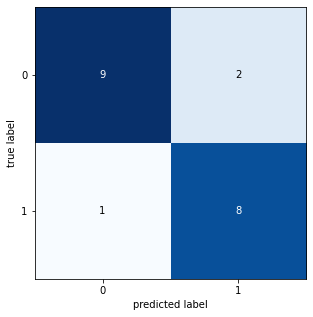

Train : [ 0  1  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 21 22 23 24 26
 28 29 32 33 34 35 36 38 40 41 42 43 44 45 46 48 49 50 51 52 53 54 55 56
 57 59 60 62 65 66 67 68 69 71 74 76 77 78 79 80 81 82 83 84 85 86 87 88
 90 91 92 93 94 96] Test : [ 2 20 25 27 30 31 37 39 47 58 61 63 64 70 72 73 75 89 95]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0]
Akurasi :  0.7894736842105263
F1_Score :  0.7840909090909092
              precision    recall  f1-score   support

           0       0.75      0.90      0.82        10
           1       0.86      0.67      0.75         9

    accuracy                           0.79        19
   macro avg       0.80      0.78      0.78        19
weighted avg       0.80      0.79      0.79        19



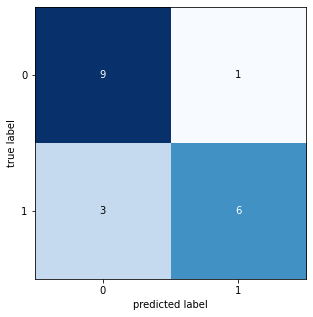

Train : [ 1  2  5  6  7  8  9 10 11 12 13 14 17 18 20 21 22 23 24 25 27 28 29 30
 31 32 33 34 35 36 37 39 40 41 42 43 44 45 47 49 50 52 53 56 57 58 59 61
 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 78 79 82 83 84 85 87 89 90
 91 92 93 94 95 96] Test : [ 0  3  4 15 16 19 26 38 46 48 51 54 55 60 77 80 81 86 88]
Y_Train : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 1 0 0 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Akurasi :  0.6842105263157895
F1_Score :  0.6761363636363638
              precision    recall  f1-score   support

           0       0.83      0.50      0.62        10
           1       0.62      0.89      0.73         9

    accuracy                           0.68        19
   macro avg       0.72      0.69      0.68        19
weighted avg       0.73      0.68      0.67        19



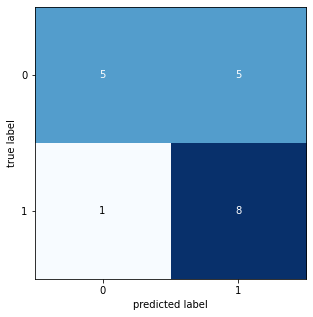

Train : [ 0  1  2  3  4  6  7  9 10 11 12 13 15 16 17 18 19 20 24 25 26 27 28 29
 30 31 32 33 34 36 37 38 39 40 41 44 46 47 48 49 50 51 52 54 55 56 57 58
 59 60 61 62 63 64 66 67 68 70 71 72 73 74 75 77 78 79 80 81 83 84 86 87
 88 89 93 94 95 96] Test : [ 5  8 14 21 22 23 35 42 43 45 53 65 69 76 82 85 90 91 92]
Y_Train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0]
Akurasi :  0.8421052631578947
F1_Score :  0.8403361344537814
              precision    recall  f1-score   support

           0       1.00      0.70      0.82        10
           1       0.75      1.00      0.86         9

    accuracy                           0.84        19
   macro avg       0.88      0.85      0.84        19
weighted avg       0.88      0.84      0.84        19



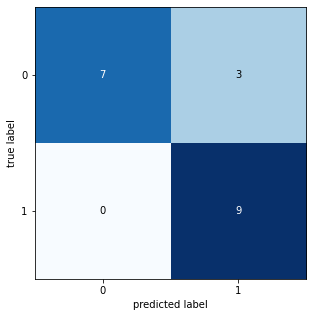

avg accuraccy Breast Cancer =  0.773157894736842
avg F1_Score Breast Cancer =  0.7700374934662861
max accuraccy Breast Cancer =  0.85
max F1_Score Breast Cancer =  0.849624060150376
min accuraccy Breast Cancer =  0.6842105263157895
min F1_Score Breast Cancer =  0.6761363636363638
Running Time:  43.38557368699912
gene : [1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1]
Train : [ 0  1  2  3  4  5  6  8 12 13 14 15 16 18 19 20 21 22 23 24 25 26 27 29
 30 31 32 33 35 37 38 39 40 41 42 43 45 46 47 48 50 51 53 54 55 58 60 61
 63 64 65 67 68 69 70 71 72 73 75 76 77 78 79 80 81 82 85 86 87 88 89 90
 91 92 93 94 95] Test : [ 7  9 10 11 17 28 34 36 44 49 52 56 57 59 62 66 74 83 84 96]
Y_Train : [1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 

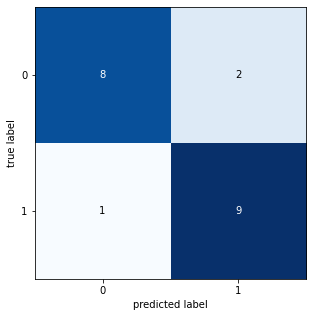

Train : [ 0  2  3  4  5  7  8  9 10 11 14 15 16 17 19 20 21 22 23 25 26 27 28 30
 31 34 35 36 37 38 39 42 43 44 45 46 47 48 49 51 52 53 54 55 56 57 58 59
 60 61 62 63 64 65 66 69 70 72 73 74 75 76 77 80 81 82 83 84 85 86 88 89
 90 91 92 95 96] Test : [ 1  6 12 13 18 24 29 32 33 40 41 50 67 68 71 78 79 87 93 94]
Y_Train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0]
Y_Test : [1 1 0 0 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Akurasi :  0.85
F1_Score :  0.849624060150376
              precision    recall  f1-score   support

           0       1.00      0.73      0.84        11
           1       0.75      1.00      0.86         9

    accuracy                           0.85        20
   macro avg       0.88      0.86      0.85        20
weighted avg       0.89      0.85      0.85        20



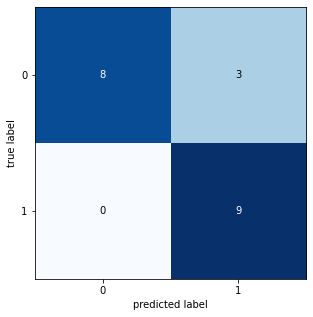

Train : [ 0  1  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 21 22 23 24 26
 28 29 32 33 34 35 36 38 40 41 42 43 44 45 46 48 49 50 51 52 53 54 55 56
 57 59 60 62 65 66 67 68 69 71 74 76 77 78 79 80 81 82 83 84 85 86 87 88
 90 91 92 93 94 96] Test : [ 2 20 25 27 30 31 37 39 47 58 61 63 64 70 72 73 75 89 95]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0]
Akurasi :  0.9473684210526315
F1_Score :  0.9473684210526316
              precision    recall  f1-score   support

           0       1.00      0.90      0.95        10
           1       0.90      1.00      0.95         9

    accuracy                           0.95        19
   macro avg       0.95      0.95      0.95        19
weighted avg       0.95      0.95      0.95        19



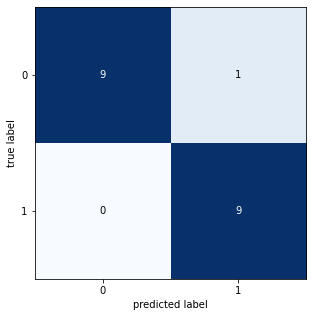

Train : [ 1  2  5  6  7  8  9 10 11 12 13 14 17 18 20 21 22 23 24 25 27 28 29 30
 31 32 33 34 35 36 37 39 40 41 42 43 44 45 47 49 50 52 53 56 57 58 59 61
 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 78 79 82 83 84 85 87 89 90
 91 92 93 94 95 96] Test : [ 0  3  4 15 16 19 26 38 46 48 51 54 55 60 77 80 81 86 88]
Y_Train : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 1 0 0 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Akurasi :  0.631578947368421
F1_Score :  0.6274509803921569
              precision    recall  f1-score   support

           0       0.71      0.50      0.59        10
           1       0.58      0.78      0.67         9

    accuracy                           0.63        19
   macro avg       0.65      0.64      0.63        19
weighted avg       0.65      0.63      0.63        19



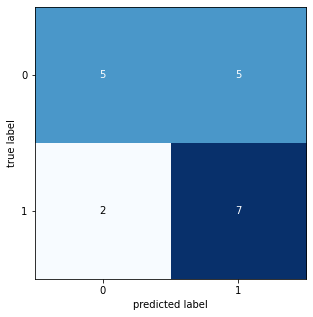

Train : [ 0  1  2  3  4  6  7  9 10 11 12 13 15 16 17 18 19 20 24 25 26 27 28 29
 30 31 32 33 34 36 37 38 39 40 41 44 46 47 48 49 50 51 52 54 55 56 57 58
 59 60 61 62 63 64 66 67 68 70 71 72 73 74 75 77 78 79 80 81 83 84 86 87
 88 89 93 94 95 96] Test : [ 5  8 14 21 22 23 35 42 43 45 53 65 69 76 82 85 90 91 92]
Y_Train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0]
Akurasi :  0.8421052631578947
F1_Score :  0.8421052631578948
              precision    recall  f1-score   support

           0       0.89      0.80      0.84        10
           1       0.80      0.89      0.84         9

    accuracy                           0.84        19
   macro avg       0.84      0.84      0.84        19
weighted avg       0.85      0.84      0.84        19



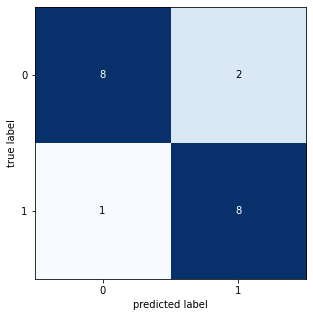

avg accuraccy Breast Cancer =  0.8242105263157894
avg F1_Score Breast Cancer =  0.823234556980687
max accuraccy Breast Cancer =  0.9473684210526315
max F1_Score Breast Cancer =  0.9473684210526316
min accuraccy Breast Cancer =  0.631578947368421
min F1_Score Breast Cancer =  0.6274509803921569
Running Time:  40.82640438999806
gene : [1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0]
Train : [ 0  1  2  3  4  5  6  8 12 13 14 15 16 18 19 20 21 22 23 24 25 26 27 29
 30 31 32 33 35 37 38 39 40 41 42 43 45 46 47 48 50 51 53 54 55 58 60 61
 63 64 65 67 68 69 70 71 72 73 75 76 77 78 79 80 81 82 85 86 87 88 89 90
 91 92 93 94 95] Test : [ 7  9 10 11 17 28 34 36 44 49 52 56 57 59 62 66 74 83 84 96]
Y_Train : [1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 

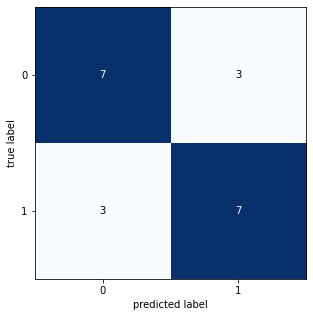

Train : [ 0  2  3  4  5  7  8  9 10 11 14 15 16 17 19 20 21 22 23 25 26 27 28 30
 31 34 35 36 37 38 39 42 43 44 45 46 47 48 49 51 52 53 54 55 56 57 58 59
 60 61 62 63 64 65 66 69 70 72 73 74 75 76 77 80 81 82 83 84 85 86 88 89
 90 91 92 95 96] Test : [ 1  6 12 13 18 24 29 32 33 40 41 50 67 68 71 78 79 87 93 94]
Y_Train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0]
Y_Test : [1 1 0 0 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Akurasi :  0.85
F1_Score :  0.849624060150376
              precision    recall  f1-score   support

           0       1.00      0.73      0.84        11
           1       0.75      1.00      0.86         9

    accuracy                           0.85        20
   macro avg       0.88      0.86      0.85        20
weighted avg       0.89      0.85      0.85        20



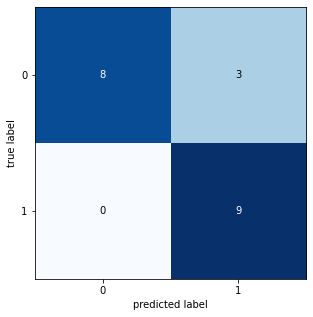

Train : [ 0  1  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 21 22 23 24 26
 28 29 32 33 34 35 36 38 40 41 42 43 44 45 46 48 49 50 51 52 53 54 55 56
 57 59 60 62 65 66 67 68 69 71 74 76 77 78 79 80 81 82 83 84 85 86 87 88
 90 91 92 93 94 96] Test : [ 2 20 25 27 30 31 37 39 47 58 61 63 64 70 72 73 75 89 95]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0]
Akurasi :  0.8421052631578947
F1_Score :  0.8403361344537816
              precision    recall  f1-score   support

           0       0.82      0.90      0.86        10
           1       0.88      0.78      0.82         9

    accuracy                           0.84        19
   macro avg       0.85      0.84      0.84        19
weighted avg       0.85      0.84      0.84        19



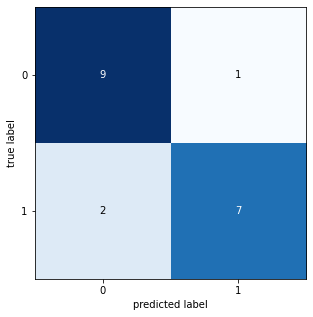

Train : [ 1  2  5  6  7  8  9 10 11 12 13 14 17 18 20 21 22 23 24 25 27 28 29 30
 31 32 33 34 35 36 37 39 40 41 42 43 44 45 47 49 50 52 53 56 57 58 59 61
 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 78 79 82 83 84 85 87 89 90
 91 92 93 94 95 96] Test : [ 0  3  4 15 16 19 26 38 46 48 51 54 55 60 77 80 81 86 88]
Y_Train : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 1 0 0 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Akurasi :  0.7894736842105263
F1_Score :  0.784090909090909
              precision    recall  f1-score   support

           0       1.00      0.60      0.75        10
           1       0.69      1.00      0.82         9

    accuracy                           0.79        19
   macro avg       0.85      0.80      0.78        19
weighted avg       0.85      0.79      0.78        19



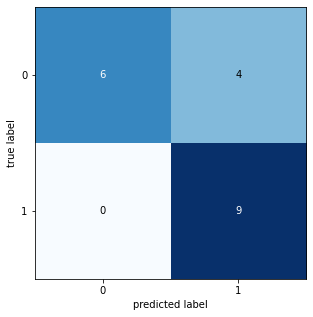

Train : [ 0  1  2  3  4  6  7  9 10 11 12 13 15 16 17 18 19 20 24 25 26 27 28 29
 30 31 32 33 34 36 37 38 39 40 41 44 46 47 48 49 50 51 52 54 55 56 57 58
 59 60 61 62 63 64 66 67 68 70 71 72 73 74 75 77 78 79 80 81 83 84 86 87
 88 89 93 94 95 96] Test : [ 5  8 14 21 22 23 35 42 43 45 53 65 69 76 82 85 90 91 92]
Y_Train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0]
Akurasi :  0.8421052631578947
F1_Score :  0.8421052631578948
              precision    recall  f1-score   support

           0       0.89      0.80      0.84        10
           1       0.80      0.89      0.84         9

    accuracy                           0.84        19
   macro avg       0.84      0.84      0.84        19
weighted avg       0.85      0.84      0.84        19



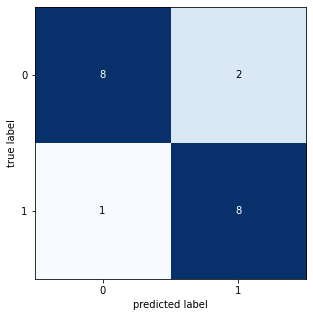

avg accuraccy Breast Cancer =  0.8047368421052632
avg F1_Score Breast Cancer =  0.8032312733705922
max accuraccy Breast Cancer =  0.85
max F1_Score Breast Cancer =  0.849624060150376
min accuraccy Breast Cancer =  0.7
min F1_Score Breast Cancer =  0.7
Running Time:  42.236440335000225
gene : [1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1]
Train : [ 0  1  2  3  4  5  6  8 12 13 14 15 16 18 19 20 21 22 23 24 25 26 27 29
 30 31 32 33 35 37 38 39 40 41 42 43 45 46 47 48 50 51 53 54 55 58 60 61
 63 64 65 67 68 69 70 71 72 73 75 76 77 78 79 80 81 82 85 86 87 88 89 90
 91 92 93 94 95] Test : [ 7  9 10 11 17 28 34 36 44 49 52 56 57 59 62 66 74 83 84 96]
Y_Train : [1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1

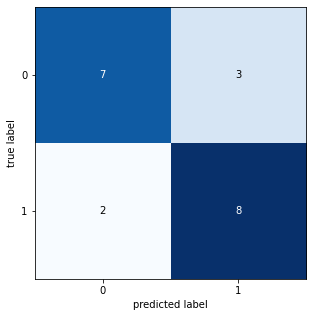

Train : [ 0  2  3  4  5  7  8  9 10 11 14 15 16 17 19 20 21 22 23 25 26 27 28 30
 31 34 35 36 37 38 39 42 43 44 45 46 47 48 49 51 52 53 54 55 56 57 58 59
 60 61 62 63 64 65 66 69 70 72 73 74 75 76 77 80 81 82 83 84 85 86 88 89
 90 91 92 95 96] Test : [ 1  6 12 13 18 24 29 32 33 40 41 50 67 68 71 78 79 87 93 94]
Y_Train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0]
Y_Test : [1 1 0 0 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Akurasi :  0.7
F1_Score :  0.696969696969697
              precision    recall  f1-score   support

           0       0.86      0.55      0.67        11
           1       0.62      0.89      0.73         9

    accuracy                           0.70        20
   macro avg       0.74      0.72      0.70        20
weighted avg       0.75      0.70      0.69        20



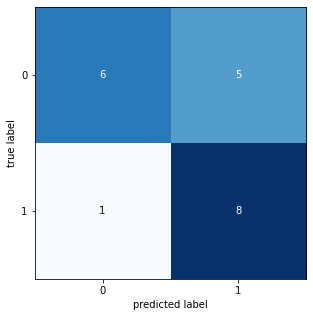

Train : [ 0  1  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 21 22 23 24 26
 28 29 32 33 34 35 36 38 40 41 42 43 44 45 46 48 49 50 51 52 53 54 55 56
 57 59 60 62 65 66 67 68 69 71 74 76 77 78 79 80 81 82 83 84 85 86 87 88
 90 91 92 93 94 96] Test : [ 2 20 25 27 30 31 37 39 47 58 61 63 64 70 72 73 75 89 95]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0]
Akurasi :  0.8947368421052632
F1_Score :  0.8944444444444445
              precision    recall  f1-score   support

           0       1.00      0.80      0.89        10
           1       0.82      1.00      0.90         9

    accuracy                           0.89        19
   macro avg       0.91      0.90      0.89        19
weighted avg       0.91      0.89      0.89        19



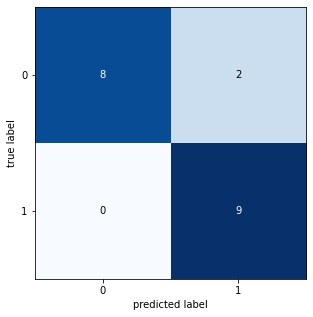

Train : [ 1  2  5  6  7  8  9 10 11 12 13 14 17 18 20 21 22 23 24 25 27 28 29 30
 31 32 33 34 35 36 37 39 40 41 42 43 44 45 47 49 50 52 53 56 57 58 59 61
 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 78 79 82 83 84 85 87 89 90
 91 92 93 94 95 96] Test : [ 0  3  4 15 16 19 26 38 46 48 51 54 55 60 77 80 81 86 88]
Y_Train : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 1 0 0 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Akurasi :  0.7368421052631579
F1_Score :  0.7338935574229692
              precision    recall  f1-score   support

           0       0.86      0.60      0.71        10
           1       0.67      0.89      0.76         9

    accuracy                           0.74        19
   macro avg       0.76      0.74      0.73        19
weighted avg       0.77      0.74      0.73        19



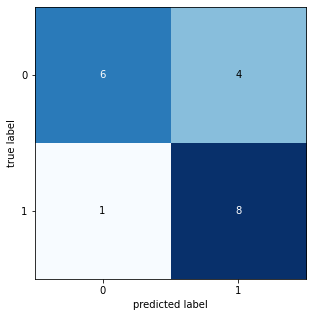

Train : [ 0  1  2  3  4  6  7  9 10 11 12 13 15 16 17 18 19 20 24 25 26 27 28 29
 30 31 32 33 34 36 37 38 39 40 41 44 46 47 48 49 50 51 52 54 55 56 57 58
 59 60 61 62 63 64 66 67 68 70 71 72 73 74 75 77 78 79 80 81 83 84 86 87
 88 89 93 94 95 96] Test : [ 5  8 14 21 22 23 35 42 43 45 53 65 69 76 82 85 90 91 92]
Y_Train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0]
Akurasi :  0.8421052631578947
F1_Score :  0.8421052631578948
              precision    recall  f1-score   support

           0       0.89      0.80      0.84        10
           1       0.80      0.89      0.84         9

    accuracy                           0.84        19
   macro avg       0.84      0.84      0.84        19
weighted avg       0.85      0.84      0.84        19



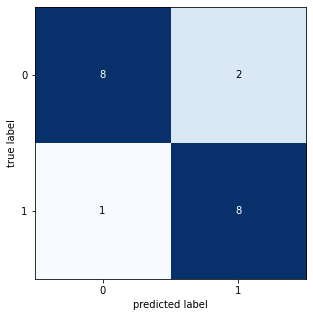

avg accuraccy Breast Cancer =  0.7847368421052632
avg F1_Score Breast Cancer =  0.783357279115793
max accuraccy Breast Cancer =  0.8947368421052632
max F1_Score Breast Cancer =  0.8944444444444445
min accuraccy Breast Cancer =  0.7
min F1_Score Breast Cancer =  0.696969696969697
Running Time:  37.79512848099694
gen terbaik : [1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1]
F-1 Score terbaik : 0.8313406277842945  || Akurasi terbaik : 0.8342105263157894  || jumlah fitur : 60

Generation : 2
gene : [1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 

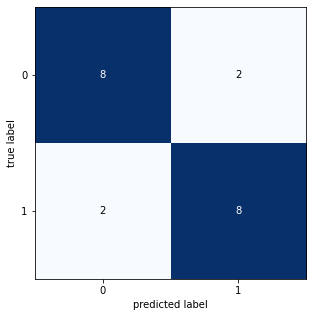

Train : [ 0  2  3  4  5  7  8  9 10 11 14 15 16 17 19 20 21 22 23 25 26 27 28 30
 31 34 35 36 37 38 39 42 43 44 45 46 47 48 49 51 52 53 54 55 56 57 58 59
 60 61 62 63 64 65 66 69 70 72 73 74 75 76 77 80 81 82 83 84 85 86 88 89
 90 91 92 95 96] Test : [ 1  6 12 13 18 24 29 32 33 40 41 50 67 68 71 78 79 87 93 94]
Y_Train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0]
Y_Test : [1 1 0 0 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Akurasi :  0.8
F1_Score :  0.797979797979798
              precision    recall  f1-score   support

           0       0.82      0.82      0.82        11
           1       0.78      0.78      0.78         9

    accuracy                           0.80        20
   macro avg       0.80      0.80      0.80        20
weighted avg       0.80      0.80      0.80        20



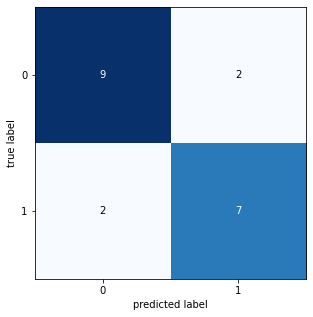

Train : [ 0  1  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 21 22 23 24 26
 28 29 32 33 34 35 36 38 40 41 42 43 44 45 46 48 49 50 51 52 53 54 55 56
 57 59 60 62 65 66 67 68 69 71 74 76 77 78 79 80 81 82 83 84 85 86 87 88
 90 91 92 93 94 96] Test : [ 2 20 25 27 30 31 37 39 47 58 61 63 64 70 72 73 75 89 95]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0]
Akurasi :  0.8947368421052632
F1_Score :  0.8944444444444444
              precision    recall  f1-score   support

           0       0.90      0.90      0.90        10
           1       0.89      0.89      0.89         9

    accuracy                           0.89        19
   macro avg       0.89      0.89      0.89        19
weighted avg       0.89      0.89      0.89        19



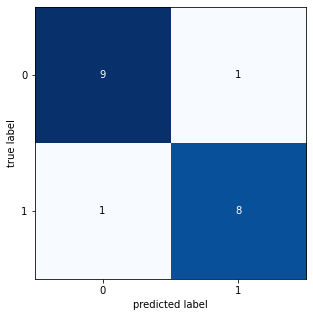

Train : [ 1  2  5  6  7  8  9 10 11 12 13 14 17 18 20 21 22 23 24 25 27 28 29 30
 31 32 33 34 35 36 37 39 40 41 42 43 44 45 47 49 50 52 53 56 57 58 59 61
 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 78 79 82 83 84 85 87 89 90
 91 92 93 94 95 96] Test : [ 0  3  4 15 16 19 26 38 46 48 51 54 55 60 77 80 81 86 88]
Y_Train : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 1 0 0 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Akurasi :  0.7368421052631579
F1_Score :  0.7246376811594203
              precision    recall  f1-score   support

           0       1.00      0.50      0.67        10
           1       0.64      1.00      0.78         9

    accuracy                           0.74        19
   macro avg       0.82      0.75      0.72        19
weighted avg       0.83      0.74      0.72        19



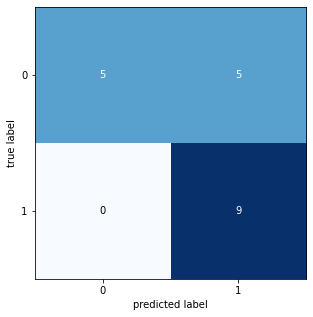

Train : [ 0  1  2  3  4  6  7  9 10 11 12 13 15 16 17 18 19 20 24 25 26 27 28 29
 30 31 32 33 34 36 37 38 39 40 41 44 46 47 48 49 50 51 52 54 55 56 57 58
 59 60 61 62 63 64 66 67 68 70 71 72 73 74 75 77 78 79 80 81 83 84 86 87
 88 89 93 94 95 96] Test : [ 5  8 14 21 22 23 35 42 43 45 53 65 69 76 82 85 90 91 92]
Y_Train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0]
Akurasi :  0.8421052631578947
F1_Score :  0.8421052631578948
              precision    recall  f1-score   support

           0       0.89      0.80      0.84        10
           1       0.80      0.89      0.84         9

    accuracy                           0.84        19
   macro avg       0.84      0.84      0.84        19
weighted avg       0.85      0.84      0.84        19



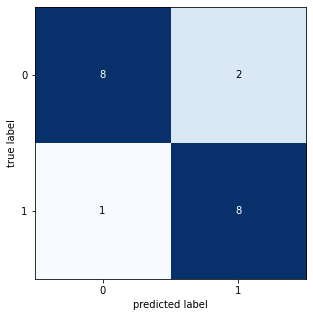

avg accuraccy Breast Cancer =  0.8147368421052633
avg F1_Score Breast Cancer =  0.8118334373483116
max accuraccy Breast Cancer =  0.8947368421052632
max F1_Score Breast Cancer =  0.8944444444444444
min accuraccy Breast Cancer =  0.7368421052631579
min F1_Score Breast Cancer =  0.7246376811594203
Running Time:  41.061729273998935
gene : [0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1]
Train : [ 0  1  2  3  4  5  6  8 12 13 14 15 16 18 19 20 21 22 23 24 25 26 27 29
 30 31 32 33 35 37 38 39 40 41 42 43 45 46 47 48 50 51 53 54 55 58 60 61
 63 64 65 67 68 69 70 71 72 73 75 76 77 78 79 80 81 82 85 86 87 88 89 90
 91 92 93 94 95] Test : [ 7  9 10 11 17 28 34 36 44 49 52 56 57 59 62 66 74 83 84 96]
Y_Train : [1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1

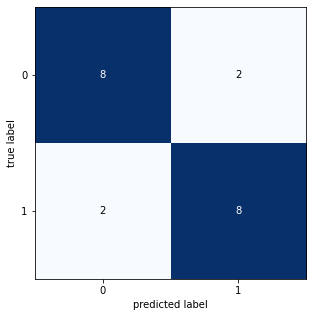

Train : [ 0  2  3  4  5  7  8  9 10 11 14 15 16 17 19 20 21 22 23 25 26 27 28 30
 31 34 35 36 37 38 39 42 43 44 45 46 47 48 49 51 52 53 54 55 56 57 58 59
 60 61 62 63 64 65 66 69 70 72 73 74 75 76 77 80 81 82 83 84 85 86 88 89
 90 91 92 95 96] Test : [ 1  6 12 13 18 24 29 32 33 40 41 50 67 68 71 78 79 87 93 94]
Y_Train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0]
Y_Test : [1 1 0 0 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Akurasi :  0.7
F1_Score :  0.7000000000000001
              precision    recall  f1-score   support

           0       0.78      0.64      0.70        11
           1       0.64      0.78      0.70         9

    accuracy                           0.70        20
   macro avg       0.71      0.71      0.70        20
weighted avg       0.71      0.70      0.70        20



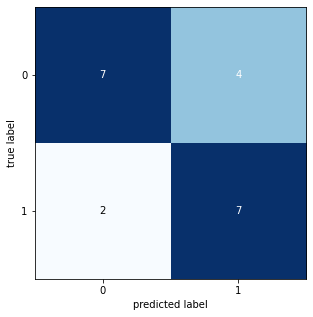

Train : [ 0  1  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 21 22 23 24 26
 28 29 32 33 34 35 36 38 40 41 42 43 44 45 46 48 49 50 51 52 53 54 55 56
 57 59 60 62 65 66 67 68 69 71 74 76 77 78 79 80 81 82 83 84 85 86 87 88
 90 91 92 93 94 96] Test : [ 2 20 25 27 30 31 37 39 47 58 61 63 64 70 72 73 75 89 95]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0]
Akurasi :  0.8421052631578947
F1_Score :  0.8421052631578948
              precision    recall  f1-score   support

           0       0.89      0.80      0.84        10
           1       0.80      0.89      0.84         9

    accuracy                           0.84        19
   macro avg       0.84      0.84      0.84        19
weighted avg       0.85      0.84      0.84        19



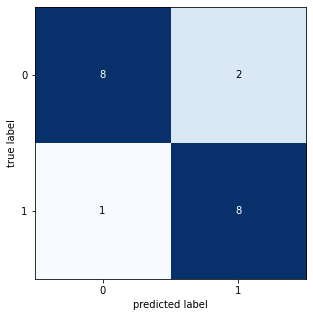

Train : [ 1  2  5  6  7  8  9 10 11 12 13 14 17 18 20 21 22 23 24 25 27 28 29 30
 31 32 33 34 35 36 37 39 40 41 42 43 44 45 47 49 50 52 53 56 57 58 59 61
 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 78 79 82 83 84 85 87 89 90
 91 92 93 94 95 96] Test : [ 0  3  4 15 16 19 26 38 46 48 51 54 55 60 77 80 81 86 88]
Y_Train : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 1 0 0 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Akurasi :  0.7368421052631579
F1_Score :  0.7338935574229692
              precision    recall  f1-score   support

           0       0.86      0.60      0.71        10
           1       0.67      0.89      0.76         9

    accuracy                           0.74        19
   macro avg       0.76      0.74      0.73        19
weighted avg       0.77      0.74      0.73        19



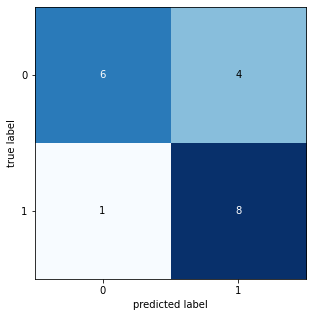

Train : [ 0  1  2  3  4  6  7  9 10 11 12 13 15 16 17 18 19 20 24 25 26 27 28 29
 30 31 32 33 34 36 37 38 39 40 41 44 46 47 48 49 50 51 52 54 55 56 57 58
 59 60 61 62 63 64 66 67 68 70 71 72 73 74 75 77 78 79 80 81 83 84 86 87
 88 89 93 94 95 96] Test : [ 5  8 14 21 22 23 35 42 43 45 53 65 69 76 82 85 90 91 92]
Y_Train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0]
Akurasi :  0.7368421052631579
F1_Score :  0.7338935574229692
              precision    recall  f1-score   support

           0       0.86      0.60      0.71        10
           1       0.67      0.89      0.76         9

    accuracy                           0.74        19
   macro avg       0.76      0.74      0.73        19
weighted avg       0.77      0.74      0.73        19



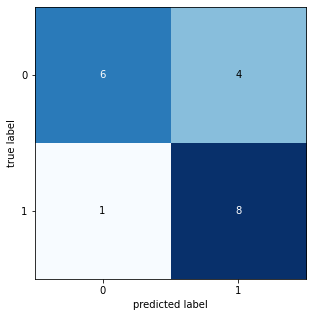

avg accuraccy Breast Cancer =  0.7631578947368421
avg F1_Score Breast Cancer =  0.7619784756007667
max accuraccy Breast Cancer =  0.8421052631578947
max F1_Score Breast Cancer =  0.8421052631578948
min accuraccy Breast Cancer =  0.7
min F1_Score Breast Cancer =  0.7000000000000001
Running Time:  38.57015012000193
gene : [1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1]
Train : [ 0  1  2  3  4  5  6  8 12 13 14 15 16 18 19 20 21 22 23 24 25 26 27 29
 30 31 32 33 35 37 38 39 40 41 42 43 45 46 47 48 50 51 53 54 55 58 60 61
 63 64 65 67 68 69 70 71 72 73 75 76 77 78 79 80 81 82 85 86 87 88 89 90
 91 92 93 94 95] Test : [ 7  9 10 11 17 28 34 36 44 49 52 56 57 59 62 66 74 83 84 96]
Y_Train : [1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1

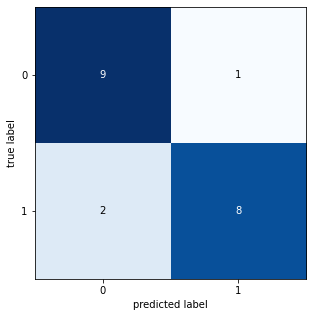

Train : [ 0  2  3  4  5  7  8  9 10 11 14 15 16 17 19 20 21 22 23 25 26 27 28 30
 31 34 35 36 37 38 39 42 43 44 45 46 47 48 49 51 52 53 54 55 56 57 58 59
 60 61 62 63 64 65 66 69 70 72 73 74 75 76 77 80 81 82 83 84 85 86 88 89
 90 91 92 95 96] Test : [ 1  6 12 13 18 24 29 32 33 40 41 50 67 68 71 78 79 87 93 94]
Y_Train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0]
Y_Test : [1 1 0 0 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Akurasi :  0.9
F1_Score :  0.9
              precision    recall  f1-score   support

           0       1.00      0.82      0.90        11
           1       0.82      1.00      0.90         9

    accuracy                           0.90        20
   macro avg       0.91      0.91      0.90        20
weighted avg       0.92      0.90      0.90        20



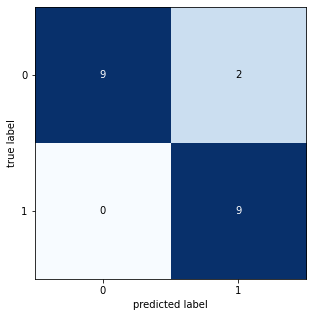

Train : [ 0  1  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 21 22 23 24 26
 28 29 32 33 34 35 36 38 40 41 42 43 44 45 46 48 49 50 51 52 53 54 55 56
 57 59 60 62 65 66 67 68 69 71 74 76 77 78 79 80 81 82 83 84 85 86 87 88
 90 91 92 93 94 96] Test : [ 2 20 25 27 30 31 37 39 47 58 61 63 64 70 72 73 75 89 95]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0]
Akurasi :  0.8947368421052632
F1_Score :  0.8944444444444444
              precision    recall  f1-score   support

           0       0.90      0.90      0.90        10
           1       0.89      0.89      0.89         9

    accuracy                           0.89        19
   macro avg       0.89      0.89      0.89        19
weighted avg       0.89      0.89      0.89        19



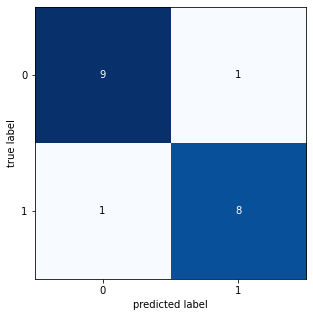

Train : [ 1  2  5  6  7  8  9 10 11 12 13 14 17 18 20 21 22 23 24 25 27 28 29 30
 31 32 33 34 35 36 37 39 40 41 42 43 44 45 47 49 50 52 53 56 57 58 59 61
 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 78 79 82 83 84 85 87 89 90
 91 92 93 94 95 96] Test : [ 0  3  4 15 16 19 26 38 46 48 51 54 55 60 77 80 81 86 88]
Y_Train : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 1 0 0 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Akurasi :  0.7368421052631579
F1_Score :  0.7246376811594203
              precision    recall  f1-score   support

           0       1.00      0.50      0.67        10
           1       0.64      1.00      0.78         9

    accuracy                           0.74        19
   macro avg       0.82      0.75      0.72        19
weighted avg       0.83      0.74      0.72        19



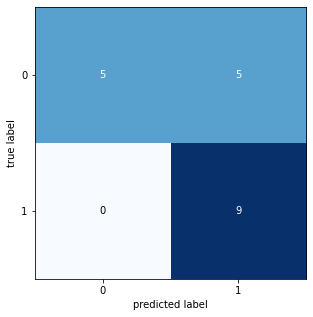

Train : [ 0  1  2  3  4  6  7  9 10 11 12 13 15 16 17 18 19 20 24 25 26 27 28 29
 30 31 32 33 34 36 37 38 39 40 41 44 46 47 48 49 50 51 52 54 55 56 57 58
 59 60 61 62 63 64 66 67 68 70 71 72 73 74 75 77 78 79 80 81 83 84 86 87
 88 89 93 94 95 96] Test : [ 5  8 14 21 22 23 35 42 43 45 53 65 69 76 82 85 90 91 92]
Y_Train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0]
Akurasi :  0.8421052631578947
F1_Score :  0.8421052631578948
              precision    recall  f1-score   support

           0       0.89      0.80      0.84        10
           1       0.80      0.89      0.84         9

    accuracy                           0.84        19
   macro avg       0.84      0.84      0.84        19
weighted avg       0.85      0.84      0.84        19



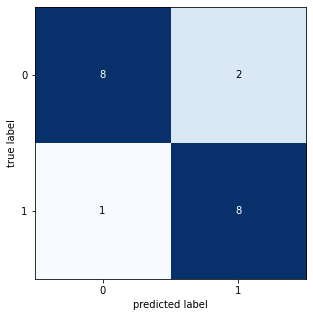

avg accuraccy Breast Cancer =  0.8447368421052632
avg F1_Score Breast Cancer =  0.8421622897824271
max accuraccy Breast Cancer =  0.9
max F1_Score Breast Cancer =  0.9
min accuraccy Breast Cancer =  0.7368421052631579
min F1_Score Breast Cancer =  0.7246376811594203
Running Time:  39.822091938000085
gene : [0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1]
Train : [ 0  1  2  3  4  5  6  8 12 13 14 15 16 18 19 20 21 22 23 24 25 26 27 29
 30 31 32 33 35 37 38 39 40 41 42 43 45 46 47 48 50 51 53 54 55 58 60 61
 63 64 65 67 68 69 70 71 72 73 75 76 77 78 79 80 81 82 85 86 87 88 89 90
 91 92 93 94 95] Test : [ 7  9 10 11 17 28 34 36 44 49 52 56 57 59 62 66 74 83 84 96]
Y_Train : [1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1

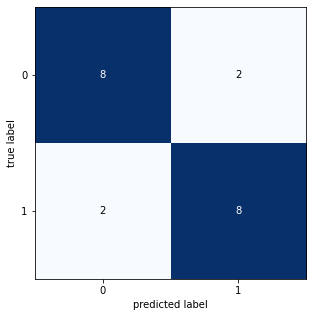

Train : [ 0  2  3  4  5  7  8  9 10 11 14 15 16 17 19 20 21 22 23 25 26 27 28 30
 31 34 35 36 37 38 39 42 43 44 45 46 47 48 49 51 52 53 54 55 56 57 58 59
 60 61 62 63 64 65 66 69 70 72 73 74 75 76 77 80 81 82 83 84 85 86 88 89
 90 91 92 95 96] Test : [ 1  6 12 13 18 24 29 32 33 40 41 50 67 68 71 78 79 87 93 94]
Y_Train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0]
Y_Test : [1 1 0 0 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Akurasi :  0.8
F1_Score :  0.7999999999999999
              precision    recall  f1-score   support

           0       0.89      0.73      0.80        11
           1       0.73      0.89      0.80         9

    accuracy                           0.80        20
   macro avg       0.81      0.81      0.80        20
weighted avg       0.82      0.80      0.80        20



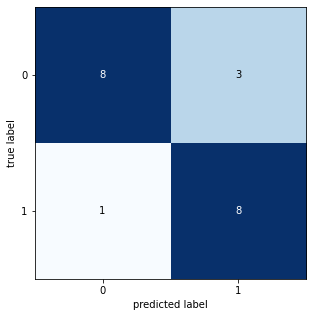

Train : [ 0  1  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 21 22 23 24 26
 28 29 32 33 34 35 36 38 40 41 42 43 44 45 46 48 49 50 51 52 53 54 55 56
 57 59 60 62 65 66 67 68 69 71 74 76 77 78 79 80 81 82 83 84 85 86 87 88
 90 91 92 93 94 96] Test : [ 2 20 25 27 30 31 37 39 47 58 61 63 64 70 72 73 75 89 95]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0]
Akurasi :  0.8421052631578947
F1_Score :  0.8421052631578948
              precision    recall  f1-score   support

           0       0.89      0.80      0.84        10
           1       0.80      0.89      0.84         9

    accuracy                           0.84        19
   macro avg       0.84      0.84      0.84        19
weighted avg       0.85      0.84      0.84        19



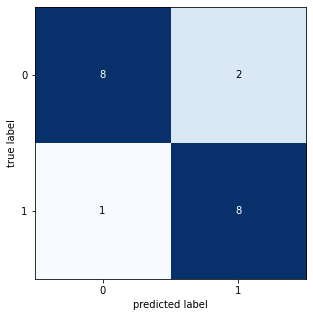

Train : [ 1  2  5  6  7  8  9 10 11 12 13 14 17 18 20 21 22 23 24 25 27 28 29 30
 31 32 33 34 35 36 37 39 40 41 42 43 44 45 47 49 50 52 53 56 57 58 59 61
 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 78 79 82 83 84 85 87 89 90
 91 92 93 94 95 96] Test : [ 0  3  4 15 16 19 26 38 46 48 51 54 55 60 77 80 81 86 88]
Y_Train : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 1 0 0 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Akurasi :  0.7894736842105263
F1_Score :  0.788888888888889
              precision    recall  f1-score   support

           0       0.80      0.80      0.80        10
           1       0.78      0.78      0.78         9

    accuracy                           0.79        19
   macro avg       0.79      0.79      0.79        19
weighted avg       0.79      0.79      0.79        19



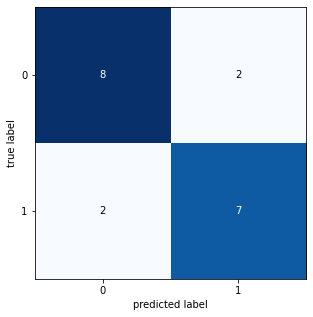

Train : [ 0  1  2  3  4  6  7  9 10 11 12 13 15 16 17 18 19 20 24 25 26 27 28 29
 30 31 32 33 34 36 37 38 39 40 41 44 46 47 48 49 50 51 52 54 55 56 57 58
 59 60 61 62 63 64 66 67 68 70 71 72 73 74 75 77 78 79 80 81 83 84 86 87
 88 89 93 94 95 96] Test : [ 5  8 14 21 22 23 35 42 43 45 53 65 69 76 82 85 90 91 92]
Y_Train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0]
Akurasi :  0.7368421052631579
F1_Score :  0.7368421052631577
              precision    recall  f1-score   support

           0       0.78      0.70      0.74        10
           1       0.70      0.78      0.74         9

    accuracy                           0.74        19
   macro avg       0.74      0.74      0.74        19
weighted avg       0.74      0.74      0.74        19



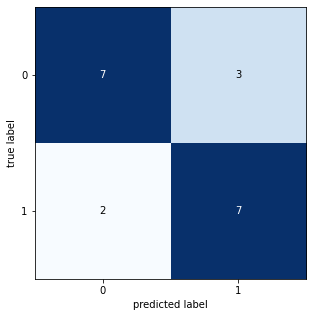

avg accuraccy Breast Cancer =  0.7936842105263158
avg F1_Score Breast Cancer =  0.7935672514619883
max accuraccy Breast Cancer =  0.8421052631578947
max F1_Score Breast Cancer =  0.8421052631578948
min accuraccy Breast Cancer =  0.7368421052631579
min F1_Score Breast Cancer =  0.7368421052631577
Running Time:  38.449142648001725
gene : [0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0]
Train : [ 0  1  2  3  4  5  6  8 12 13 14 15 16 18 19 20 21 22 23 24 25 26 27 29
 30 31 32 33 35 37 38 39 40 41 42 43 45 46 47 48 50 51 53 54 55 58 60 61
 63 64 65 67 68 69 70 71 72 73 75 76 77 78 79 80 81 82 85 86 87 88 89 90
 91 92 93 94 95] Test : [ 7  9 10 11 17 28 34 36 44 49 52 56 57 59 62 66 74 83 84 96]
Y_Train : [1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1

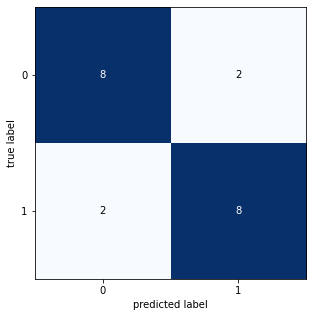

Train : [ 0  2  3  4  5  7  8  9 10 11 14 15 16 17 19 20 21 22 23 25 26 27 28 30
 31 34 35 36 37 38 39 42 43 44 45 46 47 48 49 51 52 53 54 55 56 57 58 59
 60 61 62 63 64 65 66 69 70 72 73 74 75 76 77 80 81 82 83 84 85 86 88 89
 90 91 92 95 96] Test : [ 1  6 12 13 18 24 29 32 33 40 41 50 67 68 71 78 79 87 93 94]
Y_Train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0]
Y_Test : [1 1 0 0 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Akurasi :  0.8
F1_Score :  0.7999999999999999
              precision    recall  f1-score   support

           0       0.89      0.73      0.80        11
           1       0.73      0.89      0.80         9

    accuracy                           0.80        20
   macro avg       0.81      0.81      0.80        20
weighted avg       0.82      0.80      0.80        20



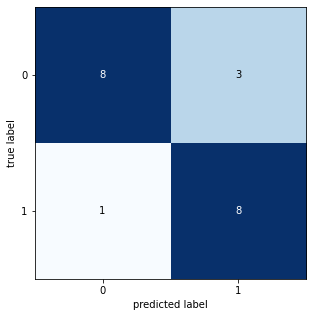

Train : [ 0  1  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 21 22 23 24 26
 28 29 32 33 34 35 36 38 40 41 42 43 44 45 46 48 49 50 51 52 53 54 55 56
 57 59 60 62 65 66 67 68 69 71 74 76 77 78 79 80 81 82 83 84 85 86 87 88
 90 91 92 93 94 96] Test : [ 2 20 25 27 30 31 37 39 47 58 61 63 64 70 72 73 75 89 95]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0]
Akurasi :  0.7894736842105263
F1_Score :  0.788888888888889
              precision    recall  f1-score   support

           0       0.80      0.80      0.80        10
           1       0.78      0.78      0.78         9

    accuracy                           0.79        19
   macro avg       0.79      0.79      0.79        19
weighted avg       0.79      0.79      0.79        19



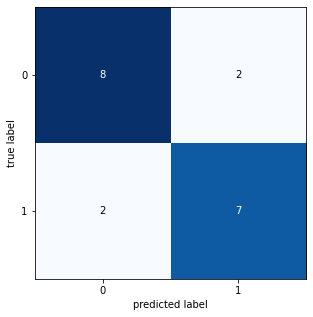

Train : [ 1  2  5  6  7  8  9 10 11 12 13 14 17 18 20 21 22 23 24 25 27 28 29 30
 31 32 33 34 35 36 37 39 40 41 42 43 44 45 47 49 50 52 53 56 57 58 59 61
 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 78 79 82 83 84 85 87 89 90
 91 92 93 94 95 96] Test : [ 0  3  4 15 16 19 26 38 46 48 51 54 55 60 77 80 81 86 88]
Y_Train : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 1 0 0 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Akurasi :  0.7894736842105263
F1_Score :  0.7888888888888888
              precision    recall  f1-score   support

           0       0.88      0.70      0.78        10
           1       0.73      0.89      0.80         9

    accuracy                           0.79        19
   macro avg       0.80      0.79      0.79        19
weighted avg       0.81      0.79      0.79        19



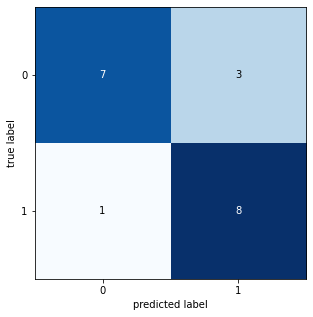

Train : [ 0  1  2  3  4  6  7  9 10 11 12 13 15 16 17 18 19 20 24 25 26 27 28 29
 30 31 32 33 34 36 37 38 39 40 41 44 46 47 48 49 50 51 52 54 55 56 57 58
 59 60 61 62 63 64 66 67 68 70 71 72 73 74 75 77 78 79 80 81 83 84 86 87
 88 89 93 94 95 96] Test : [ 5  8 14 21 22 23 35 42 43 45 53 65 69 76 82 85 90 91 92]
Y_Train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0]
Akurasi :  0.7894736842105263
F1_Score :  0.7888888888888888
              precision    recall  f1-score   support

           0       0.88      0.70      0.78        10
           1       0.73      0.89      0.80         9

    accuracy                           0.79        19
   macro avg       0.80      0.79      0.79        19
weighted avg       0.81      0.79      0.79        19



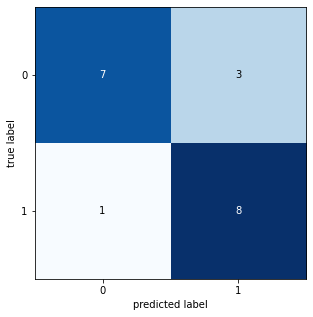

avg accuraccy Breast Cancer =  0.7936842105263159
avg F1_Score Breast Cancer =  0.7933333333333333
max accuraccy Breast Cancer =  0.8
max F1_Score Breast Cancer =  0.8000000000000002
min accuraccy Breast Cancer =  0.7894736842105263
min F1_Score Breast Cancer =  0.7888888888888888
Running Time:  39.867751345002034
gene : [0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1]
Train : [ 0  1  2  3  4  5  6  8 12 13 14 15 16 18 19 20 21 22 23 24 25 26 27 29
 30 31 32 33 35 37 38 39 40 41 42 43 45 46 47 48 50 51 53 54 55 58 60 61
 63 64 65 67 68 69 70 71 72 73 75 76 77 78 79 80 81 82 85 86 87 88 89 90
 91 92 93 94 95] Test : [ 7  9 10 11 17 28 34 36 44 49 52 56 57 59 62 66 74 83 84 96]
Y_Train : [1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 

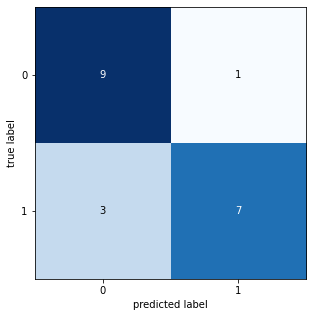

Train : [ 0  2  3  4  5  7  8  9 10 11 14 15 16 17 19 20 21 22 23 25 26 27 28 30
 31 34 35 36 37 38 39 42 43 44 45 46 47 48 49 51 52 53 54 55 56 57 58 59
 60 61 62 63 64 65 66 69 70 72 73 74 75 76 77 80 81 82 83 84 85 86 88 89
 90 91 92 95 96] Test : [ 1  6 12 13 18 24 29 32 33 40 41 50 67 68 71 78 79 87 93 94]
Y_Train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0]
Y_Test : [1 1 0 0 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Akurasi :  0.8
F1_Score :  0.7999999999999999
              precision    recall  f1-score   support

           0       0.89      0.73      0.80        11
           1       0.73      0.89      0.80         9

    accuracy                           0.80        20
   macro avg       0.81      0.81      0.80        20
weighted avg       0.82      0.80      0.80        20



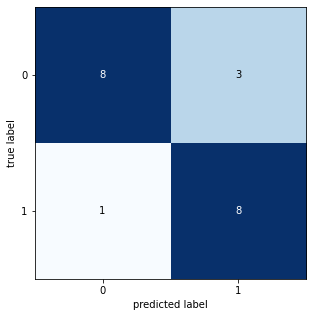

Train : [ 0  1  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 21 22 23 24 26
 28 29 32 33 34 35 36 38 40 41 42 43 44 45 46 48 49 50 51 52 53 54 55 56
 57 59 60 62 65 66 67 68 69 71 74 76 77 78 79 80 81 82 83 84 85 86 87 88
 90 91 92 93 94 96] Test : [ 2 20 25 27 30 31 37 39 47 58 61 63 64 70 72 73 75 89 95]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0]
Akurasi :  0.8421052631578947
F1_Score :  0.8421052631578948
              precision    recall  f1-score   support

           0       0.89      0.80      0.84        10
           1       0.80      0.89      0.84         9

    accuracy                           0.84        19
   macro avg       0.84      0.84      0.84        19
weighted avg       0.85      0.84      0.84        19



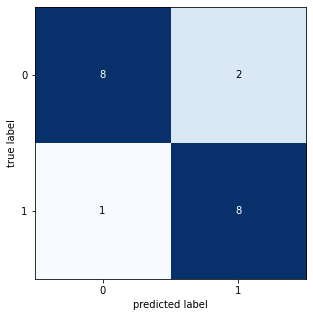

Train : [ 1  2  5  6  7  8  9 10 11 12 13 14 17 18 20 21 22 23 24 25 27 28 29 30
 31 32 33 34 35 36 37 39 40 41 42 43 44 45 47 49 50 52 53 56 57 58 59 61
 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 78 79 82 83 84 85 87 89 90
 91 92 93 94 95 96] Test : [ 0  3  4 15 16 19 26 38 46 48 51 54 55 60 77 80 81 86 88]
Y_Train : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 1 0 0 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Akurasi :  0.7894736842105263
F1_Score :  0.7888888888888888
              precision    recall  f1-score   support

           0       0.88      0.70      0.78        10
           1       0.73      0.89      0.80         9

    accuracy                           0.79        19
   macro avg       0.80      0.79      0.79        19
weighted avg       0.81      0.79      0.79        19



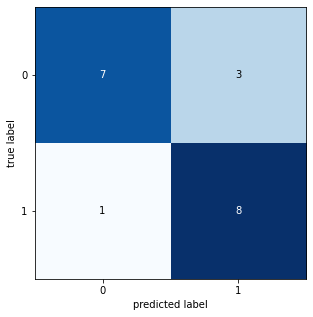

Train : [ 0  1  2  3  4  6  7  9 10 11 12 13 15 16 17 18 19 20 24 25 26 27 28 29
 30 31 32 33 34 36 37 38 39 40 41 44 46 47 48 49 50 51 52 54 55 56 57 58
 59 60 61 62 63 64 66 67 68 70 71 72 73 74 75 77 78 79 80 81 83 84 86 87
 88 89 93 94 95 96] Test : [ 5  8 14 21 22 23 35 42 43 45 53 65 69 76 82 85 90 91 92]
Y_Train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0]
Akurasi :  0.8421052631578947
F1_Score :  0.8421052631578948
              precision    recall  f1-score   support

           0       0.89      0.80      0.84        10
           1       0.80      0.89      0.84         9

    accuracy                           0.84        19
   macro avg       0.84      0.84      0.84        19
weighted avg       0.85      0.84      0.84        19



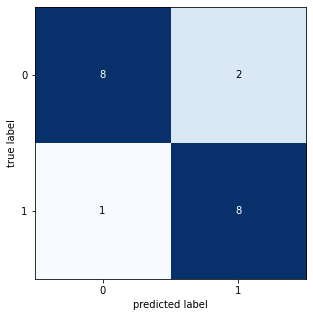

avg accuraccy Breast Cancer =  0.8147368421052631
avg F1_Score Breast Cancer =  0.8142158426368953
max accuraccy Breast Cancer =  0.8421052631578947
max F1_Score Breast Cancer =  0.8421052631578948
min accuraccy Breast Cancer =  0.7894736842105263
min F1_Score Breast Cancer =  0.7888888888888888
Running Time:  39.42029480900237
gene : [1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1]
Train : [ 0  1  2  3  4  5  6  8 12 13 14 15 16 18 19 20 21 22 23 24 25 26 27 29
 30 31 32 33 35 37 38 39 40 41 42 43 45 46 47 48 50 51 53 54 55 58 60 61
 63 64 65 67 68 69 70 71 72 73 75 76 77 78 79 80 81 82 85 86 87 88 89 90
 91 92 93 94 95] Test : [ 7  9 10 11 17 28 34 36 44 49 52 56 57 59 62 66 74 83 84 96]
Y_Train : [1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 

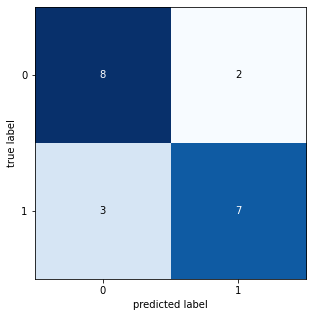

Train : [ 0  2  3  4  5  7  8  9 10 11 14 15 16 17 19 20 21 22 23 25 26 27 28 30
 31 34 35 36 37 38 39 42 43 44 45 46 47 48 49 51 52 53 54 55 56 57 58 59
 60 61 62 63 64 65 66 69 70 72 73 74 75 76 77 80 81 82 83 84 85 86 88 89
 90 91 92 95 96] Test : [ 1  6 12 13 18 24 29 32 33 40 41 50 67 68 71 78 79 87 93 94]
Y_Train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0]
Y_Test : [1 1 0 0 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Akurasi :  0.7
F1_Score :  0.696969696969697
              precision    recall  f1-score   support

           0       0.73      0.73      0.73        11
           1       0.67      0.67      0.67         9

    accuracy                           0.70        20
   macro avg       0.70      0.70      0.70        20
weighted avg       0.70      0.70      0.70        20



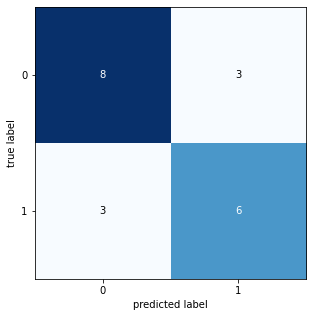

Train : [ 0  1  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 21 22 23 24 26
 28 29 32 33 34 35 36 38 40 41 42 43 44 45 46 48 49 50 51 52 53 54 55 56
 57 59 60 62 65 66 67 68 69 71 74 76 77 78 79 80 81 82 83 84 85 86 87 88
 90 91 92 93 94 96] Test : [ 2 20 25 27 30 31 37 39 47 58 61 63 64 70 72 73 75 89 95]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0]
Akurasi :  0.7894736842105263
F1_Score :  0.788888888888889
              precision    recall  f1-score   support

           0       0.80      0.80      0.80        10
           1       0.78      0.78      0.78         9

    accuracy                           0.79        19
   macro avg       0.79      0.79      0.79        19
weighted avg       0.79      0.79      0.79        19



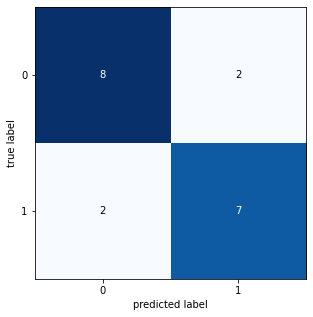

Train : [ 1  2  5  6  7  8  9 10 11 12 13 14 17 18 20 21 22 23 24 25 27 28 29 30
 31 32 33 34 35 36 37 39 40 41 42 43 44 45 47 49 50 52 53 56 57 58 59 61
 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 78 79 82 83 84 85 87 89 90
 91 92 93 94 95 96] Test : [ 0  3  4 15 16 19 26 38 46 48 51 54 55 60 77 80 81 86 88]
Y_Train : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 1 0 0 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Akurasi :  0.5789473684210527
F1_Score :  0.5777777777777777
              precision    recall  f1-score   support

           0       0.62      0.50      0.56        10
           1       0.55      0.67      0.60         9

    accuracy                           0.58        19
   macro avg       0.59      0.58      0.58        19
weighted avg       0.59      0.58      0.58        19



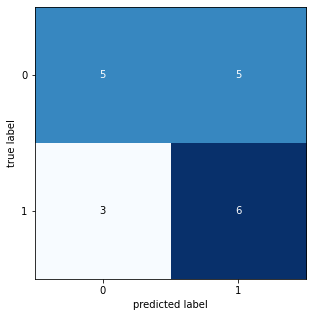

Train : [ 0  1  2  3  4  6  7  9 10 11 12 13 15 16 17 18 19 20 24 25 26 27 28 29
 30 31 32 33 34 36 37 38 39 40 41 44 46 47 48 49 50 51 52 54 55 56 57 58
 59 60 61 62 63 64 66 67 68 70 71 72 73 74 75 77 78 79 80 81 83 84 86 87
 88 89 93 94 95 96] Test : [ 5  8 14 21 22 23 35 42 43 45 53 65 69 76 82 85 90 91 92]
Y_Train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0]
Akurasi :  0.8947368421052632
F1_Score :  0.8944444444444444
              precision    recall  f1-score   support

           0       0.90      0.90      0.90        10
           1       0.89      0.89      0.89         9

    accuracy                           0.89        19
   macro avg       0.89      0.89      0.89        19
weighted avg       0.89      0.89      0.89        19



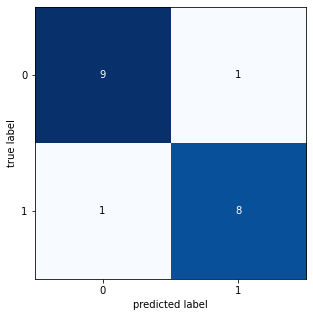

avg accuraccy Breast Cancer =  0.7426315789473684
avg F1_Score Breast Cancer =  0.7414908483329536
max accuraccy Breast Cancer =  0.8947368421052632
max F1_Score Breast Cancer =  0.8944444444444444
min accuraccy Breast Cancer =  0.5789473684210527
min F1_Score Breast Cancer =  0.5777777777777777
Running Time:  37.994828247999976
gene : [0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1]
Train : [ 0  1  2  3  4  5  6  8 12 13 14 15 16 18 19 20 21 22 23 24 25 26 27 29
 30 31 32 33 35 37 38 39 40 41 42 43 45 46 47 48 50 51 53 54 55 58 60 61
 63 64 65 67 68 69 70 71 72 73 75 76 77 78 79 80 81 82 85 86 87 88 89 90
 91 92 93 94 95] Test : [ 7  9 10 11 17 28 34 36 44 49 52 56 57 59 62 66 74 83 84 96]
Y_Train : [1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1

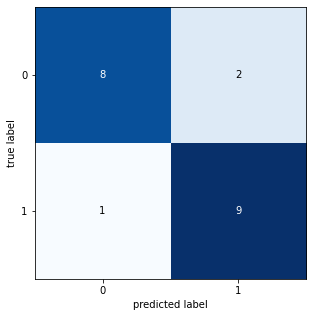

Train : [ 0  2  3  4  5  7  8  9 10 11 14 15 16 17 19 20 21 22 23 25 26 27 28 30
 31 34 35 36 37 38 39 42 43 44 45 46 47 48 49 51 52 53 54 55 56 57 58 59
 60 61 62 63 64 65 66 69 70 72 73 74 75 76 77 80 81 82 83 84 85 86 88 89
 90 91 92 95 96] Test : [ 1  6 12 13 18 24 29 32 33 40 41 50 67 68 71 78 79 87 93 94]
Y_Train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0]
Y_Test : [1 1 0 0 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Akurasi :  0.75
F1_Score :  0.7493734335839599
              precision    recall  f1-score   support

           0       0.80      0.73      0.76        11
           1       0.70      0.78      0.74         9

    accuracy                           0.75        20
   macro avg       0.75      0.75      0.75        20
weighted avg       0.76      0.75      0.75        20



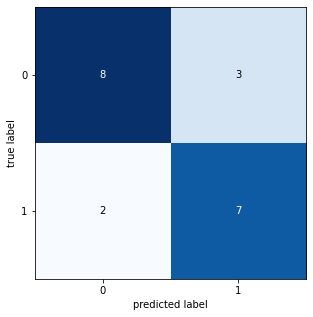

Train : [ 0  1  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 21 22 23 24 26
 28 29 32 33 34 35 36 38 40 41 42 43 44 45 46 48 49 50 51 52 53 54 55 56
 57 59 60 62 65 66 67 68 69 71 74 76 77 78 79 80 81 82 83 84 85 86 87 88
 90 91 92 93 94 96] Test : [ 2 20 25 27 30 31 37 39 47 58 61 63 64 70 72 73 75 89 95]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0]
Akurasi :  0.7368421052631579
F1_Score :  0.7368421052631577
              precision    recall  f1-score   support

           0       0.78      0.70      0.74        10
           1       0.70      0.78      0.74         9

    accuracy                           0.74        19
   macro avg       0.74      0.74      0.74        19
weighted avg       0.74      0.74      0.74        19



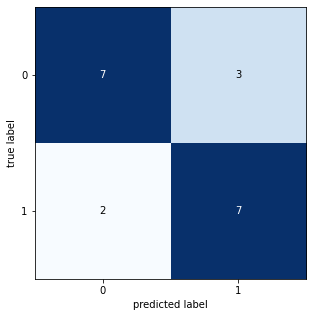

Train : [ 1  2  5  6  7  8  9 10 11 12 13 14 17 18 20 21 22 23 24 25 27 28 29 30
 31 32 33 34 35 36 37 39 40 41 42 43 44 45 47 49 50 52 53 56 57 58 59 61
 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 78 79 82 83 84 85 87 89 90
 91 92 93 94 95 96] Test : [ 0  3  4 15 16 19 26 38 46 48 51 54 55 60 77 80 81 86 88]
Y_Train : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 1 0 0 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Akurasi :  0.631578947368421
F1_Score :  0.6274509803921569
              precision    recall  f1-score   support

           0       0.71      0.50      0.59        10
           1       0.58      0.78      0.67         9

    accuracy                           0.63        19
   macro avg       0.65      0.64      0.63        19
weighted avg       0.65      0.63      0.63        19



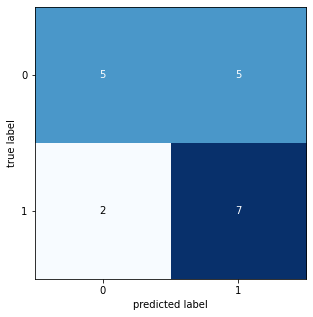

Train : [ 0  1  2  3  4  6  7  9 10 11 12 13 15 16 17 18 19 20 24 25 26 27 28 29
 30 31 32 33 34 36 37 38 39 40 41 44 46 47 48 49 50 51 52 54 55 56 57 58
 59 60 61 62 63 64 66 67 68 70 71 72 73 74 75 77 78 79 80 81 83 84 86 87
 88 89 93 94 95 96] Test : [ 5  8 14 21 22 23 35 42 43 45 53 65 69 76 82 85 90 91 92]
Y_Train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0]
Akurasi :  0.6842105263157895
F1_Score :  0.6833333333333333
              precision    recall  f1-score   support

           0       0.75      0.60      0.67        10
           1       0.64      0.78      0.70         9

    accuracy                           0.68        19
   macro avg       0.69      0.69      0.68        19
weighted avg       0.70      0.68      0.68        19



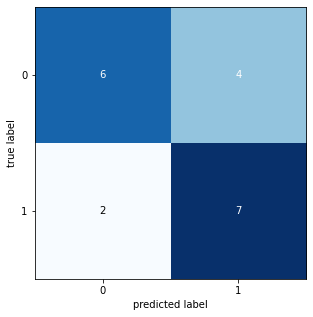

avg accuraccy Breast Cancer =  0.7305263157894737
avg F1_Score Breast Cancer =  0.7293247825445967
max accuraccy Breast Cancer =  0.85
max F1_Score Breast Cancer =  0.849624060150376
min accuraccy Breast Cancer =  0.631578947368421
min F1_Score Breast Cancer =  0.6274509803921569
Running Time:  44.41422490699915
gene : [1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1]
Train : [ 0  1  2  3  4  5  6  8 12 13 14 15 16 18 19 20 21 22 23 24 25 26 27 29
 30 31 32 33 35 37 38 39 40 41 42 43 45 46 47 48 50 51 53 54 55 58 60 61
 63 64 65 67 68 69 70 71 72 73 75 76 77 78 79 80 81 82 85 86 87 88 89 90
 91 92 93 94 95] Test : [ 7  9 10 11 17 28 34 36 44 49 52 56 57 59 62 66 74 83 84 96]
Y_Train : [1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 

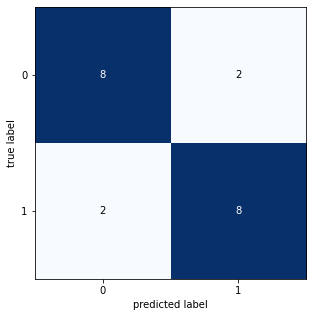

Train : [ 0  2  3  4  5  7  8  9 10 11 14 15 16 17 19 20 21 22 23 25 26 27 28 30
 31 34 35 36 37 38 39 42 43 44 45 46 47 48 49 51 52 53 54 55 56 57 58 59
 60 61 62 63 64 65 66 69 70 72 73 74 75 76 77 80 81 82 83 84 85 86 88 89
 90 91 92 95 96] Test : [ 1  6 12 13 18 24 29 32 33 40 41 50 67 68 71 78 79 87 93 94]
Y_Train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0]
Y_Test : [1 1 0 0 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Akurasi :  0.9
F1_Score :  0.9
              precision    recall  f1-score   support

           0       1.00      0.82      0.90        11
           1       0.82      1.00      0.90         9

    accuracy                           0.90        20
   macro avg       0.91      0.91      0.90        20
weighted avg       0.92      0.90      0.90        20



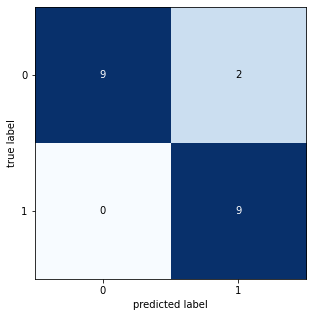

Train : [ 0  1  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 21 22 23 24 26
 28 29 32 33 34 35 36 38 40 41 42 43 44 45 46 48 49 50 51 52 53 54 55 56
 57 59 60 62 65 66 67 68 69 71 74 76 77 78 79 80 81 82 83 84 85 86 87 88
 90 91 92 93 94 96] Test : [ 2 20 25 27 30 31 37 39 47 58 61 63 64 70 72 73 75 89 95]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0]
Akurasi :  0.8421052631578947
F1_Score :  0.8403361344537816
              precision    recall  f1-score   support

           0       0.82      0.90      0.86        10
           1       0.88      0.78      0.82         9

    accuracy                           0.84        19
   macro avg       0.85      0.84      0.84        19
weighted avg       0.85      0.84      0.84        19



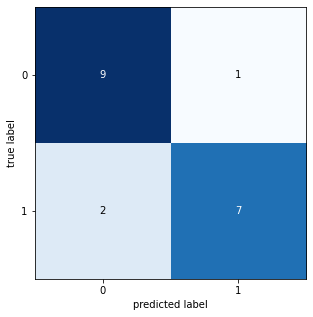

Train : [ 1  2  5  6  7  8  9 10 11 12 13 14 17 18 20 21 22 23 24 25 27 28 29 30
 31 32 33 34 35 36 37 39 40 41 42 43 44 45 47 49 50 52 53 56 57 58 59 61
 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 78 79 82 83 84 85 87 89 90
 91 92 93 94 95 96] Test : [ 0  3  4 15 16 19 26 38 46 48 51 54 55 60 77 80 81 86 88]
Y_Train : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 1 0 0 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Akurasi :  0.7368421052631579
F1_Score :  0.7246376811594203
              precision    recall  f1-score   support

           0       1.00      0.50      0.67        10
           1       0.64      1.00      0.78         9

    accuracy                           0.74        19
   macro avg       0.82      0.75      0.72        19
weighted avg       0.83      0.74      0.72        19



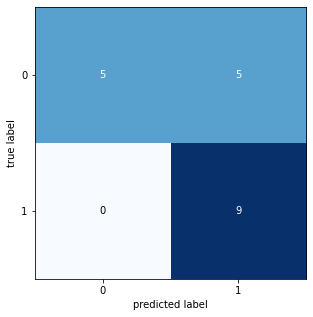

Train : [ 0  1  2  3  4  6  7  9 10 11 12 13 15 16 17 18 19 20 24 25 26 27 28 29
 30 31 32 33 34 36 37 38 39 40 41 44 46 47 48 49 50 51 52 54 55 56 57 58
 59 60 61 62 63 64 66 67 68 70 71 72 73 74 75 77 78 79 80 81 83 84 86 87
 88 89 93 94 95 96] Test : [ 5  8 14 21 22 23 35 42 43 45 53 65 69 76 82 85 90 91 92]
Y_Train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0]
Akurasi :  0.7894736842105263
F1_Score :  0.788888888888889
              precision    recall  f1-score   support

           0       0.80      0.80      0.80        10
           1       0.78      0.78      0.78         9

    accuracy                           0.79        19
   macro avg       0.79      0.79      0.79        19
weighted avg       0.79      0.79      0.79        19



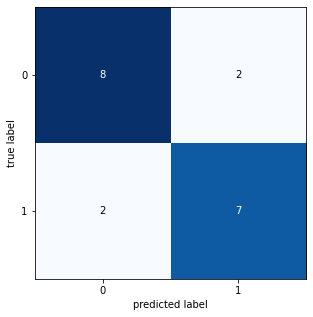

avg accuraccy Breast Cancer =  0.8136842105263158
avg F1_Score Breast Cancer =  0.8107725409004182
max accuraccy Breast Cancer =  0.9
max F1_Score Breast Cancer =  0.9
min accuraccy Breast Cancer =  0.7368421052631579
min F1_Score Breast Cancer =  0.7246376811594203
Running Time:  40.52565038499961
gene : [0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1]
Train : [ 0  1  2  3  4  5  6  8 12 13 14 15 16 18 19 20 21 22 23 24 25 26 27 29
 30 31 32 33 35 37 38 39 40 41 42 43 45 46 47 48 50 51 53 54 55 58 60 61
 63 64 65 67 68 69 70 71 72 73 75 76 77 78 79 80 81 82 85 86 87 88 89 90
 91 92 93 94 95] Test : [ 7  9 10 11 17 28 34 36 44 49 52 56 57 59 62 66 74 83 84 96]
Y_Train : [1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 

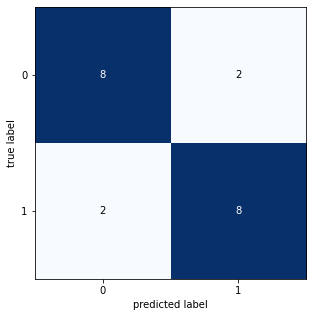

Train : [ 0  2  3  4  5  7  8  9 10 11 14 15 16 17 19 20 21 22 23 25 26 27 28 30
 31 34 35 36 37 38 39 42 43 44 45 46 47 48 49 51 52 53 54 55 56 57 58 59
 60 61 62 63 64 65 66 69 70 72 73 74 75 76 77 80 81 82 83 84 85 86 88 89
 90 91 92 95 96] Test : [ 1  6 12 13 18 24 29 32 33 40 41 50 67 68 71 78 79 87 93 94]
Y_Train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0]
Y_Test : [1 1 0 0 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Akurasi :  0.85
F1_Score :  0.849624060150376
              precision    recall  f1-score   support

           0       0.90      0.82      0.86        11
           1       0.80      0.89      0.84         9

    accuracy                           0.85        20
   macro avg       0.85      0.85      0.85        20
weighted avg       0.86      0.85      0.85        20



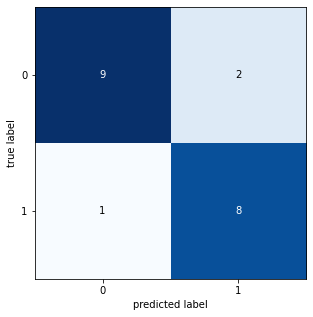

Train : [ 0  1  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 21 22 23 24 26
 28 29 32 33 34 35 36 38 40 41 42 43 44 45 46 48 49 50 51 52 53 54 55 56
 57 59 60 62 65 66 67 68 69 71 74 76 77 78 79 80 81 82 83 84 85 86 87 88
 90 91 92 93 94 96] Test : [ 2 20 25 27 30 31 37 39 47 58 61 63 64 70 72 73 75 89 95]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0]
Akurasi :  0.8421052631578947
F1_Score :  0.8421052631578948
              precision    recall  f1-score   support

           0       0.89      0.80      0.84        10
           1       0.80      0.89      0.84         9

    accuracy                           0.84        19
   macro avg       0.84      0.84      0.84        19
weighted avg       0.85      0.84      0.84        19



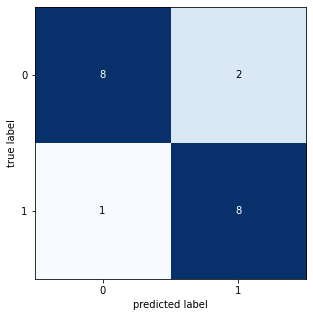

Train : [ 1  2  5  6  7  8  9 10 11 12 13 14 17 18 20 21 22 23 24 25 27 28 29 30
 31 32 33 34 35 36 37 39 40 41 42 43 44 45 47 49 50 52 53 56 57 58 59 61
 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 78 79 82 83 84 85 87 89 90
 91 92 93 94 95 96] Test : [ 0  3  4 15 16 19 26 38 46 48 51 54 55 60 77 80 81 86 88]
Y_Train : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 1 0 0 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Akurasi :  0.7368421052631579
F1_Score :  0.7338935574229692
              precision    recall  f1-score   support

           0       0.86      0.60      0.71        10
           1       0.67      0.89      0.76         9

    accuracy                           0.74        19
   macro avg       0.76      0.74      0.73        19
weighted avg       0.77      0.74      0.73        19



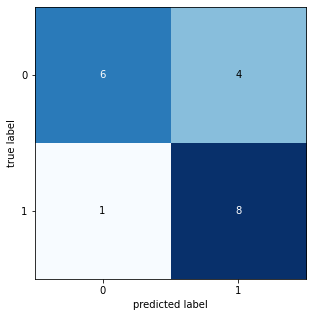

Train : [ 0  1  2  3  4  6  7  9 10 11 12 13 15 16 17 18 19 20 24 25 26 27 28 29
 30 31 32 33 34 36 37 38 39 40 41 44 46 47 48 49 50 51 52 54 55 56 57 58
 59 60 61 62 63 64 66 67 68 70 71 72 73 74 75 77 78 79 80 81 83 84 86 87
 88 89 93 94 95 96] Test : [ 5  8 14 21 22 23 35 42 43 45 53 65 69 76 82 85 90 91 92]
Y_Train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0]
Akurasi :  0.8421052631578947
F1_Score :  0.8421052631578948
              precision    recall  f1-score   support

           0       0.89      0.80      0.84        10
           1       0.80      0.89      0.84         9

    accuracy                           0.84        19
   macro avg       0.84      0.84      0.84        19
weighted avg       0.85      0.84      0.84        19



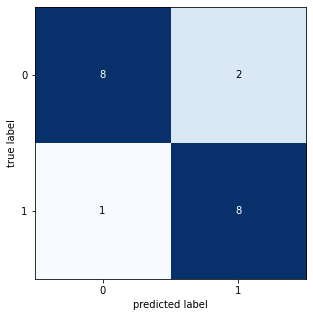

avg accuraccy Breast Cancer =  0.8142105263157895
avg F1_Score Breast Cancer =  0.813545628777827
max accuraccy Breast Cancer =  0.85
max F1_Score Breast Cancer =  0.849624060150376
min accuraccy Breast Cancer =  0.7368421052631579
min F1_Score Breast Cancer =  0.7338935574229692
Running Time:  38.933763708002516
gen terbaik : [1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1]
F-1 Score terbaik : 0.8421622897824271  || Akurasi terbaik : 0.8447368421052632  || jumlah fitur : 55

Generation : 3
gene : [0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1

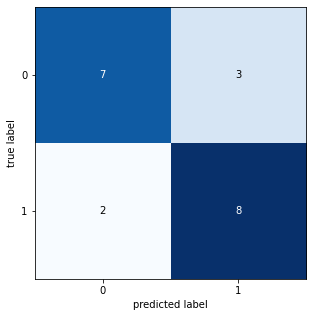

Train : [ 0  2  3  4  5  7  8  9 10 11 14 15 16 17 19 20 21 22 23 25 26 27 28 30
 31 34 35 36 37 38 39 42 43 44 45 46 47 48 49 51 52 53 54 55 56 57 58 59
 60 61 62 63 64 65 66 69 70 72 73 74 75 76 77 80 81 82 83 84 85 86 88 89
 90 91 92 95 96] Test : [ 1  6 12 13 18 24 29 32 33 40 41 50 67 68 71 78 79 87 93 94]
Y_Train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0]
Y_Test : [1 1 0 0 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Akurasi :  0.75
F1_Score :  0.7442455242966752
              precision    recall  f1-score   support

           0       0.75      0.82      0.78        11
           1       0.75      0.67      0.71         9

    accuracy                           0.75        20
   macro avg       0.75      0.74      0.74        20
weighted avg       0.75      0.75      0.75        20



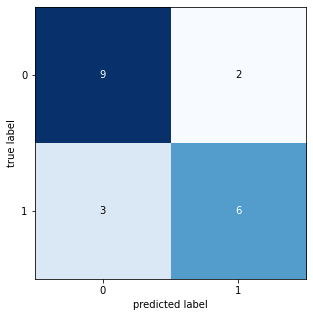

Train : [ 0  1  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 21 22 23 24 26
 28 29 32 33 34 35 36 38 40 41 42 43 44 45 46 48 49 50 51 52 53 54 55 56
 57 59 60 62 65 66 67 68 69 71 74 76 77 78 79 80 81 82 83 84 85 86 87 88
 90 91 92 93 94 96] Test : [ 2 20 25 27 30 31 37 39 47 58 61 63 64 70 72 73 75 89 95]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0]
Akurasi :  0.8421052631578947
F1_Score :  0.8421052631578948
              precision    recall  f1-score   support

           0       0.89      0.80      0.84        10
           1       0.80      0.89      0.84         9

    accuracy                           0.84        19
   macro avg       0.84      0.84      0.84        19
weighted avg       0.85      0.84      0.84        19



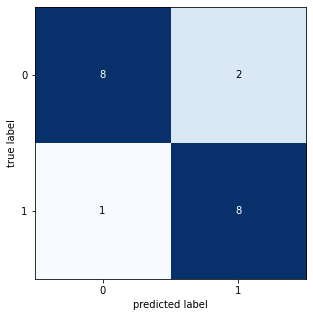

Train : [ 1  2  5  6  7  8  9 10 11 12 13 14 17 18 20 21 22 23 24 25 27 28 29 30
 31 32 33 34 35 36 37 39 40 41 42 43 44 45 47 49 50 52 53 56 57 58 59 61
 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 78 79 82 83 84 85 87 89 90
 91 92 93 94 95 96] Test : [ 0  3  4 15 16 19 26 38 46 48 51 54 55 60 77 80 81 86 88]
Y_Train : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 1 0 0 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Akurasi :  0.7894736842105263
F1_Score :  0.784090909090909
              precision    recall  f1-score   support

           0       1.00      0.60      0.75        10
           1       0.69      1.00      0.82         9

    accuracy                           0.79        19
   macro avg       0.85      0.80      0.78        19
weighted avg       0.85      0.79      0.78        19



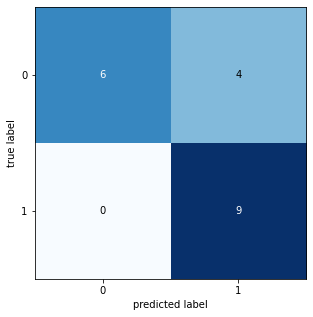

Train : [ 0  1  2  3  4  6  7  9 10 11 12 13 15 16 17 18 19 20 24 25 26 27 28 29
 30 31 32 33 34 36 37 38 39 40 41 44 46 47 48 49 50 51 52 54 55 56 57 58
 59 60 61 62 63 64 66 67 68 70 71 72 73 74 75 77 78 79 80 81 83 84 86 87
 88 89 93 94 95 96] Test : [ 5  8 14 21 22 23 35 42 43 45 53 65 69 76 82 85 90 91 92]
Y_Train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0]
Akurasi :  0.7894736842105263
F1_Score :  0.788888888888889
              precision    recall  f1-score   support

           0       0.80      0.80      0.80        10
           1       0.78      0.78      0.78         9

    accuracy                           0.79        19
   macro avg       0.79      0.79      0.79        19
weighted avg       0.79      0.79      0.79        19



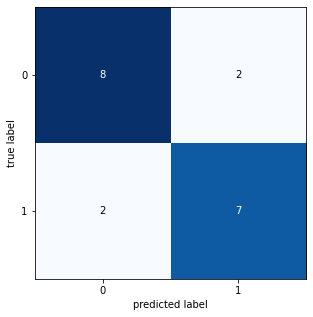

avg accuraccy Breast Cancer =  0.7842105263157896
avg F1_Score Breast Cancer =  0.7817408038036655
max accuraccy Breast Cancer =  0.8421052631578947
max F1_Score Breast Cancer =  0.8421052631578948
min accuraccy Breast Cancer =  0.75
min F1_Score Breast Cancer =  0.7442455242966752
Running Time:  41.21094945299774
gene : [0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1]
Train : [ 0  1  2  3  4  5  6  8 12 13 14 15 16 18 19 20 21 22 23 24 25 26 27 29
 30 31 32 33 35 37 38 39 40 41 42 43 45 46 47 48 50 51 53 54 55 58 60 61
 63 64 65 67 68 69 70 71 72 73 75 76 77 78 79 80 81 82 85 86 87 88 89 90
 91 92 93 94 95] Test : [ 7  9 10 11 17 28 34 36 44 49 52 56 57 59 62 66 74 83 84 96]
Y_Train : [1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 

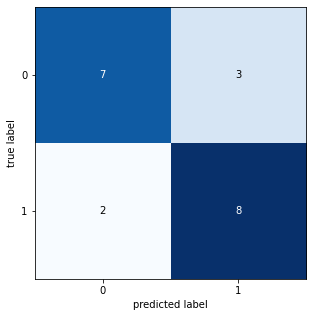

Train : [ 0  2  3  4  5  7  8  9 10 11 14 15 16 17 19 20 21 22 23 25 26 27 28 30
 31 34 35 36 37 38 39 42 43 44 45 46 47 48 49 51 52 53 54 55 56 57 58 59
 60 61 62 63 64 65 66 69 70 72 73 74 75 76 77 80 81 82 83 84 85 86 88 89
 90 91 92 95 96] Test : [ 1  6 12 13 18 24 29 32 33 40 41 50 67 68 71 78 79 87 93 94]
Y_Train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0]
Y_Test : [1 1 0 0 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Akurasi :  0.75
F1_Score :  0.7493734335839599
              precision    recall  f1-score   support

           0       0.88      0.64      0.74        11
           1       0.67      0.89      0.76         9

    accuracy                           0.75        20
   macro avg       0.77      0.76      0.75        20
weighted avg       0.78      0.75      0.75        20



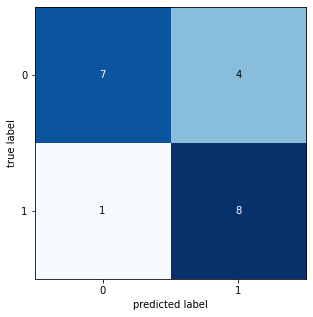

Train : [ 0  1  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 21 22 23 24 26
 28 29 32 33 34 35 36 38 40 41 42 43 44 45 46 48 49 50 51 52 53 54 55 56
 57 59 60 62 65 66 67 68 69 71 74 76 77 78 79 80 81 82 83 84 85 86 87 88
 90 91 92 93 94 96] Test : [ 2 20 25 27 30 31 37 39 47 58 61 63 64 70 72 73 75 89 95]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0]
Akurasi :  0.6842105263157895
F1_Score :  0.6761363636363636
              precision    recall  f1-score   support

           0       0.67      0.80      0.73        10
           1       0.71      0.56      0.63         9

    accuracy                           0.68        19
   macro avg       0.69      0.68      0.68        19
weighted avg       0.69      0.68      0.68        19



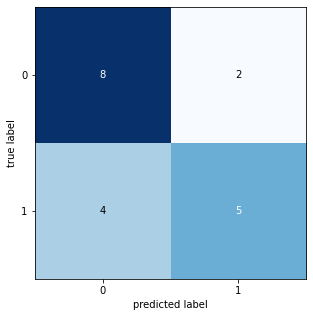

Train : [ 1  2  5  6  7  8  9 10 11 12 13 14 17 18 20 21 22 23 24 25 27 28 29 30
 31 32 33 34 35 36 37 39 40 41 42 43 44 45 47 49 50 52 53 56 57 58 59 61
 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 78 79 82 83 84 85 87 89 90
 91 92 93 94 95 96] Test : [ 0  3  4 15 16 19 26 38 46 48 51 54 55 60 77 80 81 86 88]
Y_Train : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 1 0 0 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Akurasi :  0.7368421052631579
F1_Score :  0.7338935574229692
              precision    recall  f1-score   support

           0       0.86      0.60      0.71        10
           1       0.67      0.89      0.76         9

    accuracy                           0.74        19
   macro avg       0.76      0.74      0.73        19
weighted avg       0.77      0.74      0.73        19



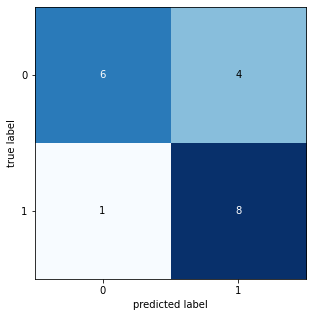

Train : [ 0  1  2  3  4  6  7  9 10 11 12 13 15 16 17 18 19 20 24 25 26 27 28 29
 30 31 32 33 34 36 37 38 39 40 41 44 46 47 48 49 50 51 52 54 55 56 57 58
 59 60 61 62 63 64 66 67 68 70 71 72 73 74 75 77 78 79 80 81 83 84 86 87
 88 89 93 94 95 96] Test : [ 5  8 14 21 22 23 35 42 43 45 53 65 69 76 82 85 90 91 92]
Y_Train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0]
Akurasi :  0.7894736842105263
F1_Score :  0.788888888888889
              precision    recall  f1-score   support

           0       0.80      0.80      0.80        10
           1       0.78      0.78      0.78         9

    accuracy                           0.79        19
   macro avg       0.79      0.79      0.79        19
weighted avg       0.79      0.79      0.79        19



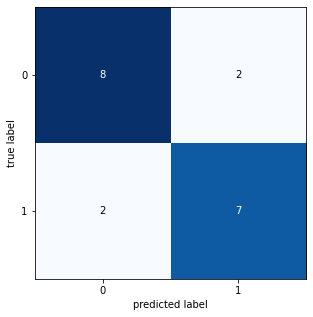

avg accuraccy Breast Cancer =  0.7421052631578947
avg F1_Score Breast Cancer =  0.7395331354232283
max accuraccy Breast Cancer =  0.7894736842105263
max F1_Score Breast Cancer =  0.788888888888889
min accuraccy Breast Cancer =  0.6842105263157895
min F1_Score Breast Cancer =  0.6761363636363636
Running Time:  38.710436106001
gene : [1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1]
Train : [ 0  1  2  3  4  5  6  8 12 13 14 15 16 18 19 20 21 22 23 24 25 26 27 29
 30 31 32 33 35 37 38 39 40 41 42 43 45 46 47 48 50 51 53 54 55 58 60 61
 63 64 65 67 68 69 70 71 72 73 75 76 77 78 79 80 81 82 85 86 87 88 89 90
 91 92 93 94 95] Test : [ 7  9 10 11 17 28 34 36 44 49 52 56 57 59 62 66 74 83 84 96]
Y_Train : [1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 1

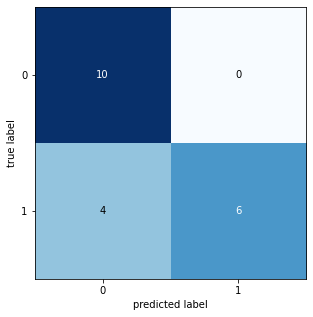

Train : [ 0  2  3  4  5  7  8  9 10 11 14 15 16 17 19 20 21 22 23 25 26 27 28 30
 31 34 35 36 37 38 39 42 43 44 45 46 47 48 49 51 52 53 54 55 56 57 58 59
 60 61 62 63 64 65 66 69 70 72 73 74 75 76 77 80 81 82 83 84 85 86 88 89
 90 91 92 95 96] Test : [ 1  6 12 13 18 24 29 32 33 40 41 50 67 68 71 78 79 87 93 94]
Y_Train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0]
Y_Test : [1 1 0 0 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Akurasi :  0.8
F1_Score :  0.797979797979798
              precision    recall  f1-score   support

           0       0.82      0.82      0.82        11
           1       0.78      0.78      0.78         9

    accuracy                           0.80        20
   macro avg       0.80      0.80      0.80        20
weighted avg       0.80      0.80      0.80        20



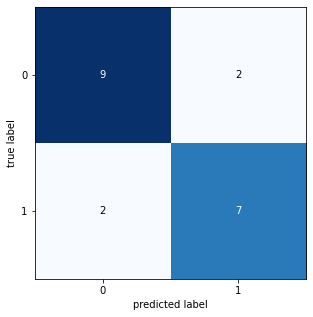

Train : [ 0  1  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 21 22 23 24 26
 28 29 32 33 34 35 36 38 40 41 42 43 44 45 46 48 49 50 51 52 53 54 55 56
 57 59 60 62 65 66 67 68 69 71 74 76 77 78 79 80 81 82 83 84 85 86 87 88
 90 91 92 93 94 96] Test : [ 2 20 25 27 30 31 37 39 47 58 61 63 64 70 72 73 75 89 95]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0]
Akurasi :  0.8421052631578947
F1_Score :  0.8421052631578948
              precision    recall  f1-score   support

           0       0.89      0.80      0.84        10
           1       0.80      0.89      0.84         9

    accuracy                           0.84        19
   macro avg       0.84      0.84      0.84        19
weighted avg       0.85      0.84      0.84        19



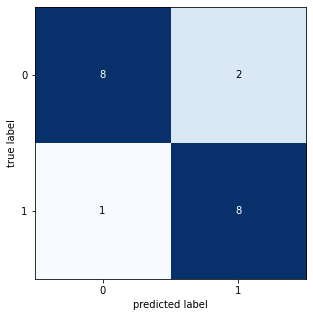

Train : [ 1  2  5  6  7  8  9 10 11 12 13 14 17 18 20 21 22 23 24 25 27 28 29 30
 31 32 33 34 35 36 37 39 40 41 42 43 44 45 47 49 50 52 53 56 57 58 59 61
 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 78 79 82 83 84 85 87 89 90
 91 92 93 94 95 96] Test : [ 0  3  4 15 16 19 26 38 46 48 51 54 55 60 77 80 81 86 88]
Y_Train : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 1 0 0 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Akurasi :  0.7368421052631579
F1_Score :  0.7246376811594203
              precision    recall  f1-score   support

           0       1.00      0.50      0.67        10
           1       0.64      1.00      0.78         9

    accuracy                           0.74        19
   macro avg       0.82      0.75      0.72        19
weighted avg       0.83      0.74      0.72        19



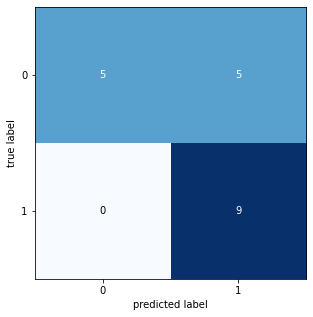

Train : [ 0  1  2  3  4  6  7  9 10 11 12 13 15 16 17 18 19 20 24 25 26 27 28 29
 30 31 32 33 34 36 37 38 39 40 41 44 46 47 48 49 50 51 52 54 55 56 57 58
 59 60 61 62 63 64 66 67 68 70 71 72 73 74 75 77 78 79 80 81 83 84 86 87
 88 89 93 94 95 96] Test : [ 5  8 14 21 22 23 35 42 43 45 53 65 69 76 82 85 90 91 92]
Y_Train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0]
Akurasi :  0.7894736842105263
F1_Score :  0.788888888888889
              precision    recall  f1-score   support

           0       0.80      0.80      0.80        10
           1       0.78      0.78      0.78         9

    accuracy                           0.79        19
   macro avg       0.79      0.79      0.79        19
weighted avg       0.79      0.79      0.79        19



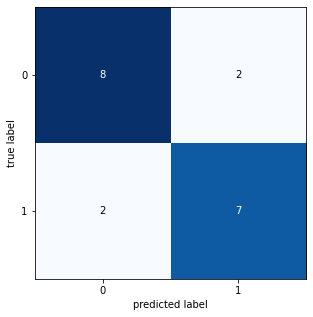

avg accuraccy Breast Cancer =  0.7936842105263159
avg F1_Score Breast Cancer =  0.7890556595705338
max accuraccy Breast Cancer =  0.8421052631578947
max F1_Score Breast Cancer =  0.8421052631578948
min accuraccy Breast Cancer =  0.7368421052631579
min F1_Score Breast Cancer =  0.7246376811594203
Running Time:  40.06464784400305
gene : [0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1]
Train : [ 0  1  2  3  4  5  6  8 12 13 14 15 16 18 19 20 21 22 23 24 25 26 27 29
 30 31 32 33 35 37 38 39 40 41 42 43 45 46 47 48 50 51 53 54 55 58 60 61
 63 64 65 67 68 69 70 71 72 73 75 76 77 78 79 80 81 82 85 86 87 88 89 90
 91 92 93 94 95] Test : [ 7  9 10 11 17 28 34 36 44 49 52 56 57 59 62 66 74 83 84 96]
Y_Train : [1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 

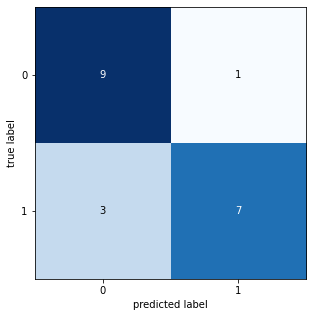

Train : [ 0  2  3  4  5  7  8  9 10 11 14 15 16 17 19 20 21 22 23 25 26 27 28 30
 31 34 35 36 37 38 39 42 43 44 45 46 47 48 49 51 52 53 54 55 56 57 58 59
 60 61 62 63 64 65 66 69 70 72 73 74 75 76 77 80 81 82 83 84 85 86 88 89
 90 91 92 95 96] Test : [ 1  6 12 13 18 24 29 32 33 40 41 50 67 68 71 78 79 87 93 94]
Y_Train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0]
Y_Test : [1 1 0 0 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Akurasi :  0.95
F1_Score :  0.949874686716792
              precision    recall  f1-score   support

           0       1.00      0.91      0.95        11
           1       0.90      1.00      0.95         9

    accuracy                           0.95        20
   macro avg       0.95      0.95      0.95        20
weighted avg       0.96      0.95      0.95        20



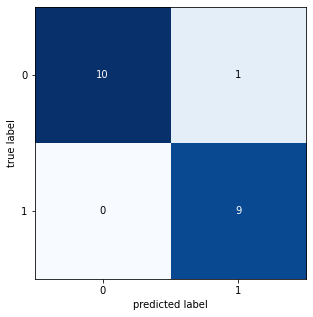

Train : [ 0  1  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 21 22 23 24 26
 28 29 32 33 34 35 36 38 40 41 42 43 44 45 46 48 49 50 51 52 53 54 55 56
 57 59 60 62 65 66 67 68 69 71 74 76 77 78 79 80 81 82 83 84 85 86 87 88
 90 91 92 93 94 96] Test : [ 2 20 25 27 30 31 37 39 47 58 61 63 64 70 72 73 75 89 95]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0]
Akurasi :  0.8421052631578947
F1_Score :  0.8421052631578948
              precision    recall  f1-score   support

           0       0.89      0.80      0.84        10
           1       0.80      0.89      0.84         9

    accuracy                           0.84        19
   macro avg       0.84      0.84      0.84        19
weighted avg       0.85      0.84      0.84        19



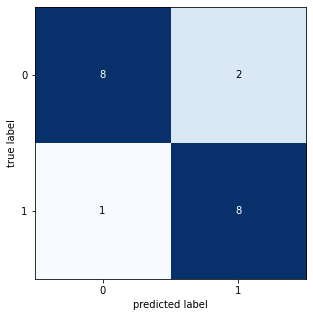

Train : [ 1  2  5  6  7  8  9 10 11 12 13 14 17 18 20 21 22 23 24 25 27 28 29 30
 31 32 33 34 35 36 37 39 40 41 42 43 44 45 47 49 50 52 53 56 57 58 59 61
 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 78 79 82 83 84 85 87 89 90
 91 92 93 94 95 96] Test : [ 0  3  4 15 16 19 26 38 46 48 51 54 55 60 77 80 81 86 88]
Y_Train : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 1 0 0 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Akurasi :  0.7894736842105263
F1_Score :  0.7888888888888888
              precision    recall  f1-score   support

           0       0.88      0.70      0.78        10
           1       0.73      0.89      0.80         9

    accuracy                           0.79        19
   macro avg       0.80      0.79      0.79        19
weighted avg       0.81      0.79      0.79        19



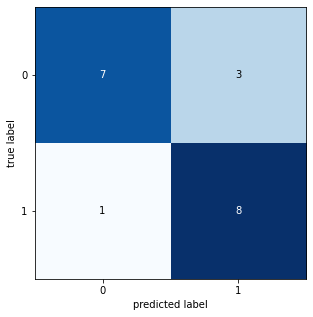

Train : [ 0  1  2  3  4  6  7  9 10 11 12 13 15 16 17 18 19 20 24 25 26 27 28 29
 30 31 32 33 34 36 37 38 39 40 41 44 46 47 48 49 50 51 52 54 55 56 57 58
 59 60 61 62 63 64 66 67 68 70 71 72 73 74 75 77 78 79 80 81 83 84 86 87
 88 89 93 94 95 96] Test : [ 5  8 14 21 22 23 35 42 43 45 53 65 69 76 82 85 90 91 92]
Y_Train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0]
Akurasi :  0.8421052631578947
F1_Score :  0.8421052631578948
              precision    recall  f1-score   support

           0       0.89      0.80      0.84        10
           1       0.80      0.89      0.84         9

    accuracy                           0.84        19
   macro avg       0.84      0.84      0.84        19
weighted avg       0.85      0.84      0.84        19



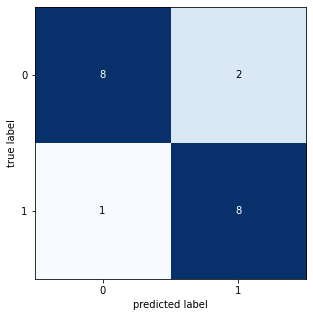

avg accuraccy Breast Cancer =  0.8447368421052632
avg F1_Score Breast Cancer =  0.8441907799802537
max accuraccy Breast Cancer =  0.95
max F1_Score Breast Cancer =  0.949874686716792
min accuraccy Breast Cancer =  0.7894736842105263
min F1_Score Breast Cancer =  0.7888888888888888
Running Time:  39.5939975049987
gene : [1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0]
Train : [ 0  1  2  3  4  5  6  8 12 13 14 15 16 18 19 20 21 22 23 24 25 26 27 29
 30 31 32 33 35 37 38 39 40 41 42 43 45 46 47 48 50 51 53 54 55 58 60 61
 63 64 65 67 68 69 70 71 72 73 75 76 77 78 79 80 81 82 85 86 87 88 89 90
 91 92 93 94 95] Test : [ 7  9 10 11 17 28 34 36 44 49 52 56 57 59 62 66 74 83 84 96]
Y_Train : [1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 

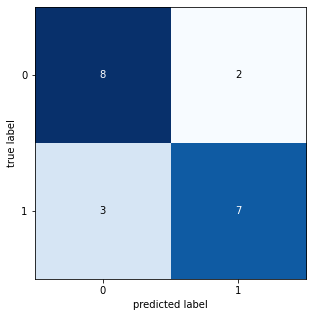

Train : [ 0  2  3  4  5  7  8  9 10 11 14 15 16 17 19 20 21 22 23 25 26 27 28 30
 31 34 35 36 37 38 39 42 43 44 45 46 47 48 49 51 52 53 54 55 56 57 58 59
 60 61 62 63 64 65 66 69 70 72 73 74 75 76 77 80 81 82 83 84 85 86 88 89
 90 91 92 95 96] Test : [ 1  6 12 13 18 24 29 32 33 40 41 50 67 68 71 78 79 87 93 94]
Y_Train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0]
Y_Test : [1 1 0 0 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Akurasi :  0.85
F1_Score :  0.849624060150376
              precision    recall  f1-score   support

           0       0.90      0.82      0.86        11
           1       0.80      0.89      0.84         9

    accuracy                           0.85        20
   macro avg       0.85      0.85      0.85        20
weighted avg       0.86      0.85      0.85        20



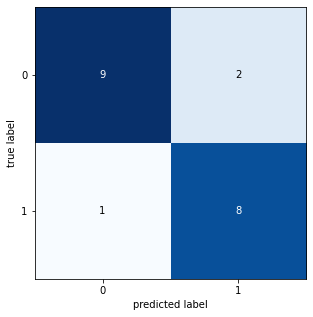

Train : [ 0  1  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 21 22 23 24 26
 28 29 32 33 34 35 36 38 40 41 42 43 44 45 46 48 49 50 51 52 53 54 55 56
 57 59 60 62 65 66 67 68 69 71 74 76 77 78 79 80 81 82 83 84 85 86 87 88
 90 91 92 93 94 96] Test : [ 2 20 25 27 30 31 37 39 47 58 61 63 64 70 72 73 75 89 95]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0]
Akurasi :  0.7894736842105263
F1_Score :  0.788888888888889
              precision    recall  f1-score   support

           0       0.80      0.80      0.80        10
           1       0.78      0.78      0.78         9

    accuracy                           0.79        19
   macro avg       0.79      0.79      0.79        19
weighted avg       0.79      0.79      0.79        19



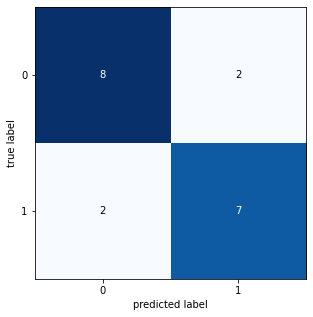

Train : [ 1  2  5  6  7  8  9 10 11 12 13 14 17 18 20 21 22 23 24 25 27 28 29 30
 31 32 33 34 35 36 37 39 40 41 42 43 44 45 47 49 50 52 53 56 57 58 59 61
 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 78 79 82 83 84 85 87 89 90
 91 92 93 94 95 96] Test : [ 0  3  4 15 16 19 26 38 46 48 51 54 55 60 77 80 81 86 88]
Y_Train : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 1 0 0 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Akurasi :  0.6842105263157895
F1_Score :  0.6607142857142857
              precision    recall  f1-score   support

           0       1.00      0.40      0.57        10
           1       0.60      1.00      0.75         9

    accuracy                           0.68        19
   macro avg       0.80      0.70      0.66        19
weighted avg       0.81      0.68      0.66        19



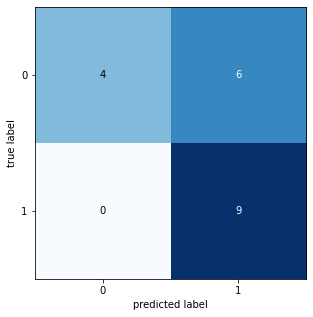

Train : [ 0  1  2  3  4  6  7  9 10 11 12 13 15 16 17 18 19 20 24 25 26 27 28 29
 30 31 32 33 34 36 37 38 39 40 41 44 46 47 48 49 50 51 52 54 55 56 57 58
 59 60 61 62 63 64 66 67 68 70 71 72 73 74 75 77 78 79 80 81 83 84 86 87
 88 89 93 94 95 96] Test : [ 5  8 14 21 22 23 35 42 43 45 53 65 69 76 82 85 90 91 92]
Y_Train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0]
Akurasi :  0.8421052631578947
F1_Score :  0.8421052631578948
              precision    recall  f1-score   support

           0       0.89      0.80      0.84        10
           1       0.80      0.89      0.84         9

    accuracy                           0.84        19
   macro avg       0.84      0.84      0.84        19
weighted avg       0.85      0.84      0.84        19



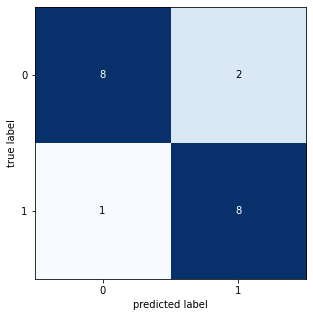

avg accuraccy Breast Cancer =  0.783157894736842
avg F1_Score Breast Cancer =  0.778141186299081
max accuraccy Breast Cancer =  0.85
max F1_Score Breast Cancer =  0.849624060150376
min accuraccy Breast Cancer =  0.6842105263157895
min F1_Score Breast Cancer =  0.6607142857142857
Running Time:  39.675420234998455
gene : [0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0]
Train : [ 0  1  2  3  4  5  6  8 12 13 14 15 16 18 19 20 21 22 23 24 25 26 27 29
 30 31 32 33 35 37 38 39 40 41 42 43 45 46 47 48 50 51 53 54 55 58 60 61
 63 64 65 67 68 69 70 71 72 73 75 76 77 78 79 80 81 82 85 86 87 88 89 90
 91 92 93 94 95] Test : [ 7  9 10 11 17 28 34 36 44 49 52 56 57 59 62 66 74 83 84 96]
Y_Train : [1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 

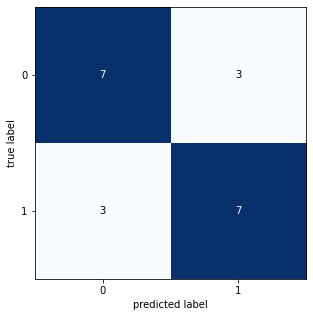

Train : [ 0  2  3  4  5  7  8  9 10 11 14 15 16 17 19 20 21 22 23 25 26 27 28 30
 31 34 35 36 37 38 39 42 43 44 45 46 47 48 49 51 52 53 54 55 56 57 58 59
 60 61 62 63 64 65 66 69 70 72 73 74 75 76 77 80 81 82 83 84 85 86 88 89
 90 91 92 95 96] Test : [ 1  6 12 13 18 24 29 32 33 40 41 50 67 68 71 78 79 87 93 94]
Y_Train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0]
Y_Test : [1 1 0 0 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Akurasi :  0.9
F1_Score :  0.9
              precision    recall  f1-score   support

           0       1.00      0.82      0.90        11
           1       0.82      1.00      0.90         9

    accuracy                           0.90        20
   macro avg       0.91      0.91      0.90        20
weighted avg       0.92      0.90      0.90        20



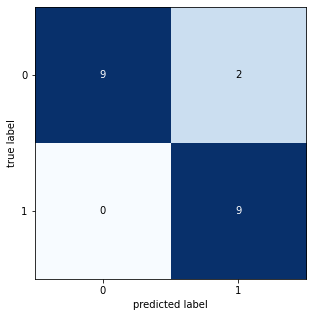

Train : [ 0  1  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 21 22 23 24 26
 28 29 32 33 34 35 36 38 40 41 42 43 44 45 46 48 49 50 51 52 53 54 55 56
 57 59 60 62 65 66 67 68 69 71 74 76 77 78 79 80 81 82 83 84 85 86 87 88
 90 91 92 93 94 96] Test : [ 2 20 25 27 30 31 37 39 47 58 61 63 64 70 72 73 75 89 95]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0]
Akurasi :  0.8421052631578947
F1_Score :  0.8421052631578948
              precision    recall  f1-score   support

           0       0.89      0.80      0.84        10
           1       0.80      0.89      0.84         9

    accuracy                           0.84        19
   macro avg       0.84      0.84      0.84        19
weighted avg       0.85      0.84      0.84        19



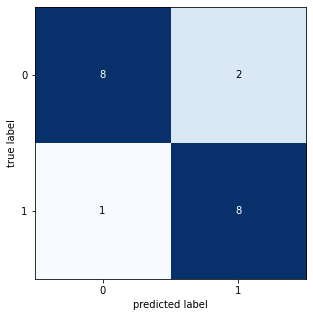

Train : [ 1  2  5  6  7  8  9 10 11 12 13 14 17 18 20 21 22 23 24 25 27 28 29 30
 31 32 33 34 35 36 37 39 40 41 42 43 44 45 47 49 50 52 53 56 57 58 59 61
 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 78 79 82 83 84 85 87 89 90
 91 92 93 94 95 96] Test : [ 0  3  4 15 16 19 26 38 46 48 51 54 55 60 77 80 81 86 88]
Y_Train : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 1 0 0 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Akurasi :  0.6842105263157895
F1_Score :  0.6833333333333333
              precision    recall  f1-score   support

           0       0.75      0.60      0.67        10
           1       0.64      0.78      0.70         9

    accuracy                           0.68        19
   macro avg       0.69      0.69      0.68        19
weighted avg       0.70      0.68      0.68        19



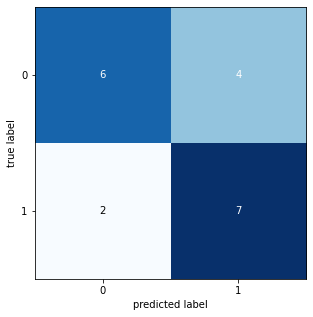

Train : [ 0  1  2  3  4  6  7  9 10 11 12 13 15 16 17 18 19 20 24 25 26 27 28 29
 30 31 32 33 34 36 37 38 39 40 41 44 46 47 48 49 50 51 52 54 55 56 57 58
 59 60 61 62 63 64 66 67 68 70 71 72 73 74 75 77 78 79 80 81 83 84 86 87
 88 89 93 94 95 96] Test : [ 5  8 14 21 22 23 35 42 43 45 53 65 69 76 82 85 90 91 92]
Y_Train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0]
Akurasi :  0.7368421052631579
F1_Score :  0.7338935574229692
              precision    recall  f1-score   support

           0       0.86      0.60      0.71        10
           1       0.67      0.89      0.76         9

    accuracy                           0.74        19
   macro avg       0.76      0.74      0.73        19
weighted avg       0.77      0.74      0.73        19



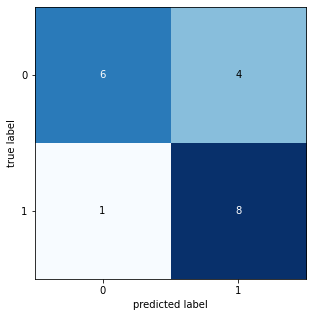

avg accuraccy Breast Cancer =  0.7726315789473684
avg F1_Score Breast Cancer =  0.7718664307828395
max accuraccy Breast Cancer =  0.9
max F1_Score Breast Cancer =  0.9
min accuraccy Breast Cancer =  0.6842105263157895
min F1_Score Breast Cancer =  0.6833333333333333
Running Time:  42.09623124300197
gene : [1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1]
Train : [ 0  1  2  3  4  5  6  8 12 13 14 15 16 18 19 20 21 22 23 24 25 26 27 29
 30 31 32 33 35 37 38 39 40 41 42 43 45 46 47 48 50 51 53 54 55 58 60 61
 63 64 65 67 68 69 70 71 72 73 75 76 77 78 79 80 81 82 85 86 87 88 89 90
 91 92 93 94 95] Test : [ 7  9 10 11 17 28 34 36 44 49 52 56 57 59 62 66 74 83 84 96]
Y_Train : [1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 

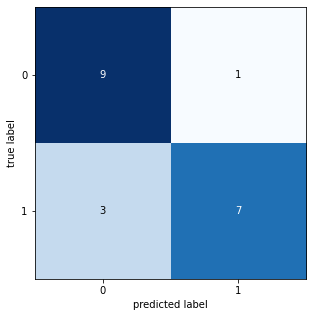

Train : [ 0  2  3  4  5  7  8  9 10 11 14 15 16 17 19 20 21 22 23 25 26 27 28 30
 31 34 35 36 37 38 39 42 43 44 45 46 47 48 49 51 52 53 54 55 56 57 58 59
 60 61 62 63 64 65 66 69 70 72 73 74 75 76 77 80 81 82 83 84 85 86 88 89
 90 91 92 95 96] Test : [ 1  6 12 13 18 24 29 32 33 40 41 50 67 68 71 78 79 87 93 94]
Y_Train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0]
Y_Test : [1 1 0 0 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Akurasi :  0.7
F1_Score :  0.696969696969697
              precision    recall  f1-score   support

           0       0.73      0.73      0.73        11
           1       0.67      0.67      0.67         9

    accuracy                           0.70        20
   macro avg       0.70      0.70      0.70        20
weighted avg       0.70      0.70      0.70        20



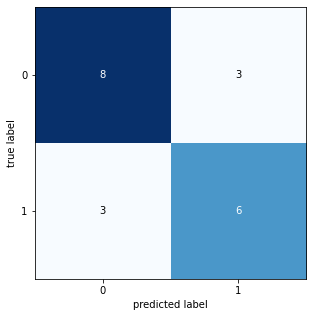

Train : [ 0  1  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 21 22 23 24 26
 28 29 32 33 34 35 36 38 40 41 42 43 44 45 46 48 49 50 51 52 53 54 55 56
 57 59 60 62 65 66 67 68 69 71 74 76 77 78 79 80 81 82 83 84 85 86 87 88
 90 91 92 93 94 96] Test : [ 2 20 25 27 30 31 37 39 47 58 61 63 64 70 72 73 75 89 95]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0]
Akurasi :  0.8947368421052632
F1_Score :  0.8944444444444444
              precision    recall  f1-score   support

           0       0.90      0.90      0.90        10
           1       0.89      0.89      0.89         9

    accuracy                           0.89        19
   macro avg       0.89      0.89      0.89        19
weighted avg       0.89      0.89      0.89        19



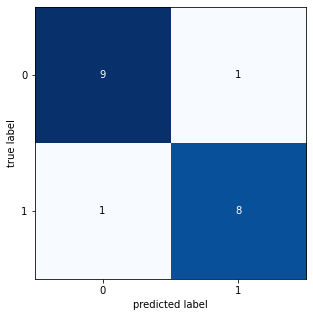

Train : [ 1  2  5  6  7  8  9 10 11 12 13 14 17 18 20 21 22 23 24 25 27 28 29 30
 31 32 33 34 35 36 37 39 40 41 42 43 44 45 47 49 50 52 53 56 57 58 59 61
 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 78 79 82 83 84 85 87 89 90
 91 92 93 94 95 96] Test : [ 0  3  4 15 16 19 26 38 46 48 51 54 55 60 77 80 81 86 88]
Y_Train : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 1 0 0 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Akurasi :  0.7368421052631579
F1_Score :  0.7338935574229692
              precision    recall  f1-score   support

           0       0.86      0.60      0.71        10
           1       0.67      0.89      0.76         9

    accuracy                           0.74        19
   macro avg       0.76      0.74      0.73        19
weighted avg       0.77      0.74      0.73        19



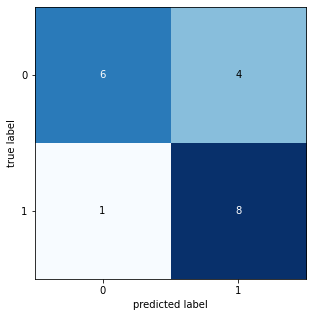

Train : [ 0  1  2  3  4  6  7  9 10 11 12 13 15 16 17 18 19 20 24 25 26 27 28 29
 30 31 32 33 34 36 37 38 39 40 41 44 46 47 48 49 50 51 52 54 55 56 57 58
 59 60 61 62 63 64 66 67 68 70 71 72 73 74 75 77 78 79 80 81 83 84 86 87
 88 89 93 94 95 96] Test : [ 5  8 14 21 22 23 35 42 43 45 53 65 69 76 82 85 90 91 92]
Y_Train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0]
Akurasi :  0.8421052631578947
F1_Score :  0.8403361344537816
              precision    recall  f1-score   support

           0       0.82      0.90      0.86        10
           1       0.88      0.78      0.82         9

    accuracy                           0.84        19
   macro avg       0.85      0.84      0.84        19
weighted avg       0.85      0.84      0.84        19



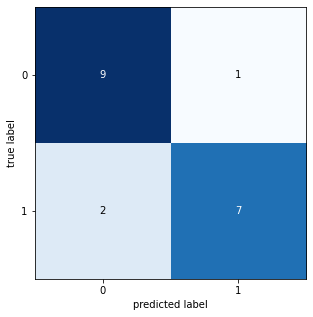

avg accuraccy Breast Cancer =  0.7947368421052632
avg F1_Score Breast Cancer =  0.7927247262541381
max accuraccy Breast Cancer =  0.8947368421052632
max F1_Score Breast Cancer =  0.8944444444444444
min accuraccy Breast Cancer =  0.7
min F1_Score Breast Cancer =  0.696969696969697
Running Time:  40.89526774400292
gene : [1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1]
Train : [ 0  1  2  3  4  5  6  8 12 13 14 15 16 18 19 20 21 22 23 24 25 26 27 29
 30 31 32 33 35 37 38 39 40 41 42 43 45 46 47 48 50 51 53 54 55 58 60 61
 63 64 65 67 68 69 70 71 72 73 75 76 77 78 79 80 81 82 85 86 87 88 89 90
 91 92 93 94 95] Test : [ 7  9 10 11 17 28 34 36 44 49 52 56 57 59 62 66 74 83 84 96]
Y_Train : [1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 

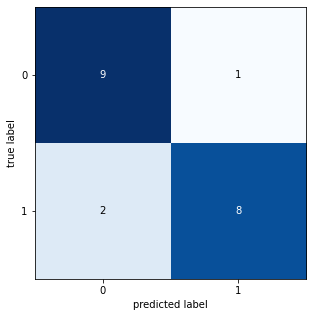

Train : [ 0  2  3  4  5  7  8  9 10 11 14 15 16 17 19 20 21 22 23 25 26 27 28 30
 31 34 35 36 37 38 39 42 43 44 45 46 47 48 49 51 52 53 54 55 56 57 58 59
 60 61 62 63 64 65 66 69 70 72 73 74 75 76 77 80 81 82 83 84 85 86 88 89
 90 91 92 95 96] Test : [ 1  6 12 13 18 24 29 32 33 40 41 50 67 68 71 78 79 87 93 94]
Y_Train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0]
Y_Test : [1 1 0 0 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Akurasi :  0.8
F1_Score :  0.7999999999999999
              precision    recall  f1-score   support

           0       0.89      0.73      0.80        11
           1       0.73      0.89      0.80         9

    accuracy                           0.80        20
   macro avg       0.81      0.81      0.80        20
weighted avg       0.82      0.80      0.80        20



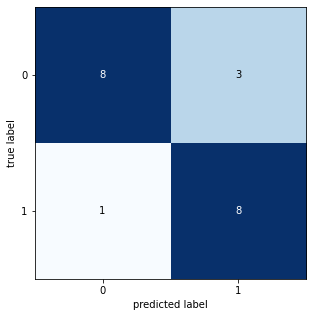

Train : [ 0  1  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 21 22 23 24 26
 28 29 32 33 34 35 36 38 40 41 42 43 44 45 46 48 49 50 51 52 53 54 55 56
 57 59 60 62 65 66 67 68 69 71 74 76 77 78 79 80 81 82 83 84 85 86 87 88
 90 91 92 93 94 96] Test : [ 2 20 25 27 30 31 37 39 47 58 61 63 64 70 72 73 75 89 95]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0]
Akurasi :  0.7894736842105263
F1_Score :  0.7840909090909092
              precision    recall  f1-score   support

           0       0.75      0.90      0.82        10
           1       0.86      0.67      0.75         9

    accuracy                           0.79        19
   macro avg       0.80      0.78      0.78        19
weighted avg       0.80      0.79      0.79        19



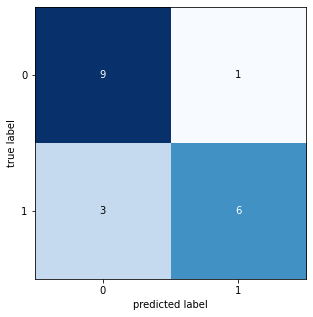

Train : [ 1  2  5  6  7  8  9 10 11 12 13 14 17 18 20 21 22 23 24 25 27 28 29 30
 31 32 33 34 35 36 37 39 40 41 42 43 44 45 47 49 50 52 53 56 57 58 59 61
 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 78 79 82 83 84 85 87 89 90
 91 92 93 94 95 96] Test : [ 0  3  4 15 16 19 26 38 46 48 51 54 55 60 77 80 81 86 88]
Y_Train : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 1 0 0 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Akurasi :  0.7894736842105263
F1_Score :  0.784090909090909
              precision    recall  f1-score   support

           0       1.00      0.60      0.75        10
           1       0.69      1.00      0.82         9

    accuracy                           0.79        19
   macro avg       0.85      0.80      0.78        19
weighted avg       0.85      0.79      0.78        19



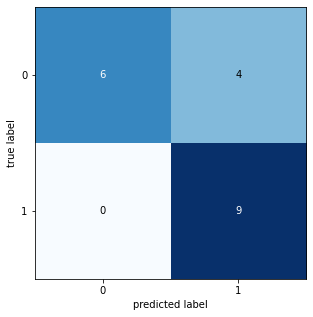

Train : [ 0  1  2  3  4  6  7  9 10 11 12 13 15 16 17 18 19 20 24 25 26 27 28 29
 30 31 32 33 34 36 37 38 39 40 41 44 46 47 48 49 50 51 52 54 55 56 57 58
 59 60 61 62 63 64 66 67 68 70 71 72 73 74 75 77 78 79 80 81 83 84 86 87
 88 89 93 94 95 96] Test : [ 5  8 14 21 22 23 35 42 43 45 53 65 69 76 82 85 90 91 92]
Y_Train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0]
Akurasi :  0.7894736842105263
F1_Score :  0.7888888888888888
              precision    recall  f1-score   support

           0       0.88      0.70      0.78        10
           1       0.73      0.89      0.80         9

    accuracy                           0.79        19
   macro avg       0.80      0.79      0.79        19
weighted avg       0.81      0.79      0.79        19



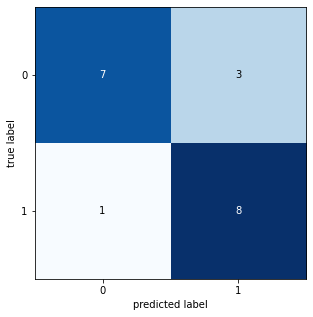

avg accuraccy Breast Cancer =  0.8036842105263158
avg F1_Score Breast Cancer =  0.8013389534442166
max accuraccy Breast Cancer =  0.85
max F1_Score Breast Cancer =  0.849624060150376
min accuraccy Breast Cancer =  0.7894736842105263
min F1_Score Breast Cancer =  0.784090909090909
Running Time:  42.79352736999863
gene : [1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1]
Train : [ 0  1  2  3  4  5  6  8 12 13 14 15 16 18 19 20 21 22 23 24 25 26 27 29
 30 31 32 33 35 37 38 39 40 41 42 43 45 46 47 48 50 51 53 54 55 58 60 61
 63 64 65 67 68 69 70 71 72 73 75 76 77 78 79 80 81 82 85 86 87 88 89 90
 91 92 93 94 95] Test : [ 7  9 10 11 17 28 34 36 44 49 52 56 57 59 62 66 74 83 84 96]
Y_Train : [1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 

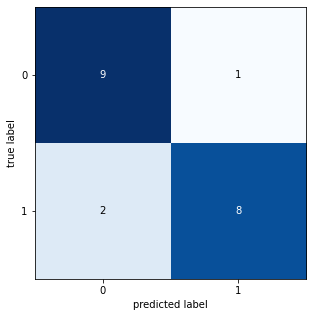

Train : [ 0  2  3  4  5  7  8  9 10 11 14 15 16 17 19 20 21 22 23 25 26 27 28 30
 31 34 35 36 37 38 39 42 43 44 45 46 47 48 49 51 52 53 54 55 56 57 58 59
 60 61 62 63 64 65 66 69 70 72 73 74 75 76 77 80 81 82 83 84 85 86 88 89
 90 91 92 95 96] Test : [ 1  6 12 13 18 24 29 32 33 40 41 50 67 68 71 78 79 87 93 94]
Y_Train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0]
Y_Test : [1 1 0 0 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Akurasi :  0.9
F1_Score :  0.9
              precision    recall  f1-score   support

           0       1.00      0.82      0.90        11
           1       0.82      1.00      0.90         9

    accuracy                           0.90        20
   macro avg       0.91      0.91      0.90        20
weighted avg       0.92      0.90      0.90        20



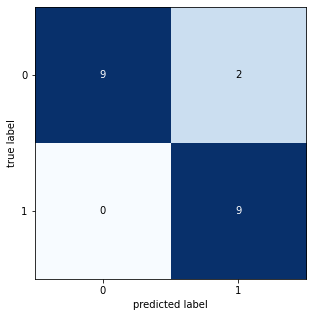

Train : [ 0  1  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 21 22 23 24 26
 28 29 32 33 34 35 36 38 40 41 42 43 44 45 46 48 49 50 51 52 53 54 55 56
 57 59 60 62 65 66 67 68 69 71 74 76 77 78 79 80 81 82 83 84 85 86 87 88
 90 91 92 93 94 96] Test : [ 2 20 25 27 30 31 37 39 47 58 61 63 64 70 72 73 75 89 95]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0]
Akurasi :  0.8421052631578947
F1_Score :  0.8403361344537816
              precision    recall  f1-score   support

           0       0.82      0.90      0.86        10
           1       0.88      0.78      0.82         9

    accuracy                           0.84        19
   macro avg       0.85      0.84      0.84        19
weighted avg       0.85      0.84      0.84        19



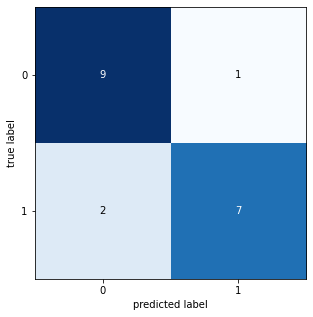

Train : [ 1  2  5  6  7  8  9 10 11 12 13 14 17 18 20 21 22 23 24 25 27 28 29 30
 31 32 33 34 35 36 37 39 40 41 42 43 44 45 47 49 50 52 53 56 57 58 59 61
 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 78 79 82 83 84 85 87 89 90
 91 92 93 94 95 96] Test : [ 0  3  4 15 16 19 26 38 46 48 51 54 55 60 77 80 81 86 88]
Y_Train : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 1 0 0 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Akurasi :  0.7368421052631579
F1_Score :  0.7246376811594203
              precision    recall  f1-score   support

           0       1.00      0.50      0.67        10
           1       0.64      1.00      0.78         9

    accuracy                           0.74        19
   macro avg       0.82      0.75      0.72        19
weighted avg       0.83      0.74      0.72        19



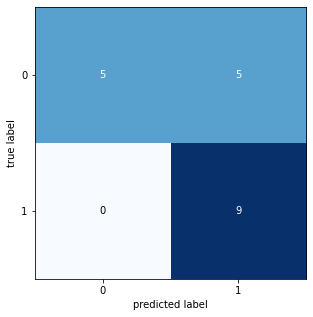

Train : [ 0  1  2  3  4  6  7  9 10 11 12 13 15 16 17 18 19 20 24 25 26 27 28 29
 30 31 32 33 34 36 37 38 39 40 41 44 46 47 48 49 50 51 52 54 55 56 57 58
 59 60 61 62 63 64 66 67 68 70 71 72 73 74 75 77 78 79 80 81 83 84 86 87
 88 89 93 94 95 96] Test : [ 5  8 14 21 22 23 35 42 43 45 53 65 69 76 82 85 90 91 92]
Y_Train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0]
Akurasi :  0.7894736842105263
F1_Score :  0.7888888888888888
              precision    recall  f1-score   support

           0       0.88      0.70      0.78        10
           1       0.73      0.89      0.80         9

    accuracy                           0.79        19
   macro avg       0.80      0.79      0.79        19
weighted avg       0.81      0.79      0.79        19



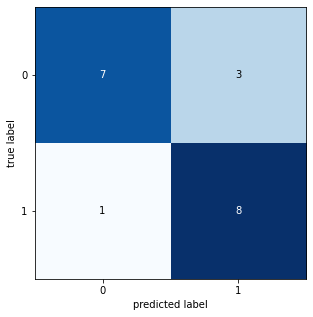

avg accuraccy Breast Cancer =  0.8236842105263158
avg F1_Score Breast Cancer =  0.8206973529304934
max accuraccy Breast Cancer =  0.9
max F1_Score Breast Cancer =  0.9
min accuraccy Breast Cancer =  0.7368421052631579
min F1_Score Breast Cancer =  0.7246376811594203
Running Time:  39.90822780600138
gene : [0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1]
Train : [ 0  1  2  3  4  5  6  8 12 13 14 15 16 18 19 20 21 22 23 24 25 26 27 29
 30 31 32 33 35 37 38 39 40 41 42 43 45 46 47 48 50 51 53 54 55 58 60 61
 63 64 65 67 68 69 70 71 72 73 75 76 77 78 79 80 81 82 85 86 87 88 89 90
 91 92 93 94 95] Test : [ 7  9 10 11 17 28 34 36 44 49 52 56 57 59 62 66 74 83 84 96]
Y_Train : [1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 

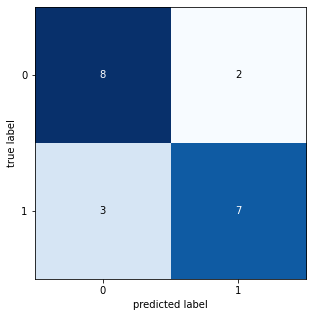

Train : [ 0  2  3  4  5  7  8  9 10 11 14 15 16 17 19 20 21 22 23 25 26 27 28 30
 31 34 35 36 37 38 39 42 43 44 45 46 47 48 49 51 52 53 54 55 56 57 58 59
 60 61 62 63 64 65 66 69 70 72 73 74 75 76 77 80 81 82 83 84 85 86 88 89
 90 91 92 95 96] Test : [ 1  6 12 13 18 24 29 32 33 40 41 50 67 68 71 78 79 87 93 94]
Y_Train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0]
Y_Test : [1 1 0 0 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Akurasi :  0.8
F1_Score :  0.7999999999999999
              precision    recall  f1-score   support

           0       0.89      0.73      0.80        11
           1       0.73      0.89      0.80         9

    accuracy                           0.80        20
   macro avg       0.81      0.81      0.80        20
weighted avg       0.82      0.80      0.80        20



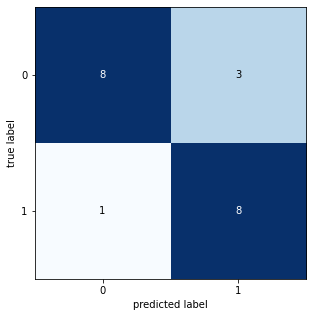

Train : [ 0  1  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 21 22 23 24 26
 28 29 32 33 34 35 36 38 40 41 42 43 44 45 46 48 49 50 51 52 53 54 55 56
 57 59 60 62 65 66 67 68 69 71 74 76 77 78 79 80 81 82 83 84 85 86 87 88
 90 91 92 93 94 96] Test : [ 2 20 25 27 30 31 37 39 47 58 61 63 64 70 72 73 75 89 95]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0]
Akurasi :  0.8421052631578947
F1_Score :  0.8421052631578948
              precision    recall  f1-score   support

           0       0.89      0.80      0.84        10
           1       0.80      0.89      0.84         9

    accuracy                           0.84        19
   macro avg       0.84      0.84      0.84        19
weighted avg       0.85      0.84      0.84        19



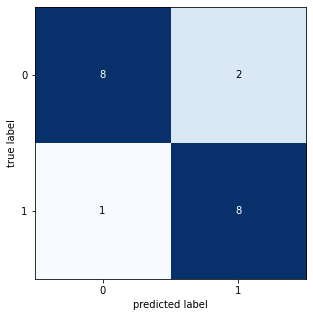

Train : [ 1  2  5  6  7  8  9 10 11 12 13 14 17 18 20 21 22 23 24 25 27 28 29 30
 31 32 33 34 35 36 37 39 40 41 42 43 44 45 47 49 50 52 53 56 57 58 59 61
 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 78 79 82 83 84 85 87 89 90
 91 92 93 94 95 96] Test : [ 0  3  4 15 16 19 26 38 46 48 51 54 55 60 77 80 81 86 88]
Y_Train : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 1 0 0 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Akurasi :  0.7894736842105263
F1_Score :  0.7888888888888888
              precision    recall  f1-score   support

           0       0.88      0.70      0.78        10
           1       0.73      0.89      0.80         9

    accuracy                           0.79        19
   macro avg       0.80      0.79      0.79        19
weighted avg       0.81      0.79      0.79        19



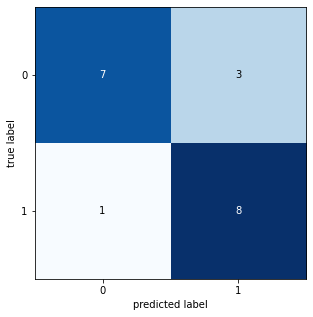

Train : [ 0  1  2  3  4  6  7  9 10 11 12 13 15 16 17 18 19 20 24 25 26 27 28 29
 30 31 32 33 34 36 37 38 39 40 41 44 46 47 48 49 50 51 52 54 55 56 57 58
 59 60 61 62 63 64 66 67 68 70 71 72 73 74 75 77 78 79 80 81 83 84 86 87
 88 89 93 94 95 96] Test : [ 5  8 14 21 22 23 35 42 43 45 53 65 69 76 82 85 90 91 92]
Y_Train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0]
Akurasi :  0.7894736842105263
F1_Score :  0.7888888888888888
              precision    recall  f1-score   support

           0       0.88      0.70      0.78        10
           1       0.73      0.89      0.80         9

    accuracy                           0.79        19
   macro avg       0.80      0.79      0.79        19
weighted avg       0.81      0.79      0.79        19



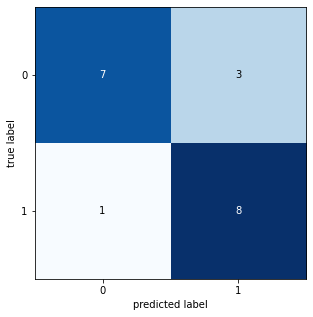

avg accuraccy Breast Cancer =  0.7942105263157895
avg F1_Score Breast Cancer =  0.7938512949039265
max accuraccy Breast Cancer =  0.8421052631578947
max F1_Score Breast Cancer =  0.8421052631578948
min accuraccy Breast Cancer =  0.75
min F1_Score Breast Cancer =  0.7493734335839599
Running Time:  41.68147996500193
gen terbaik : [0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1]
F-1 Score terbaik : 0.8441907799802537  || Akurasi terbaik : 0.8447368421052632  || jumlah fitur : 53

Generation : 4
gene : [0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 

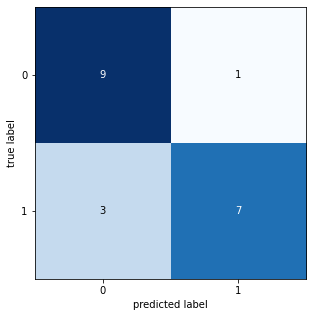

Train : [ 0  2  3  4  5  7  8  9 10 11 14 15 16 17 19 20 21 22 23 25 26 27 28 30
 31 34 35 36 37 38 39 42 43 44 45 46 47 48 49 51 52 53 54 55 56 57 58 59
 60 61 62 63 64 65 66 69 70 72 73 74 75 76 77 80 81 82 83 84 85 86 88 89
 90 91 92 95 96] Test : [ 1  6 12 13 18 24 29 32 33 40 41 50 67 68 71 78 79 87 93 94]
Y_Train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0]
Y_Test : [1 1 0 0 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Akurasi :  0.85
F1_Score :  0.8465473145780051
              precision    recall  f1-score   support

           0       0.83      0.91      0.87        11
           1       0.88      0.78      0.82         9

    accuracy                           0.85        20
   macro avg       0.85      0.84      0.85        20
weighted avg       0.85      0.85      0.85        20



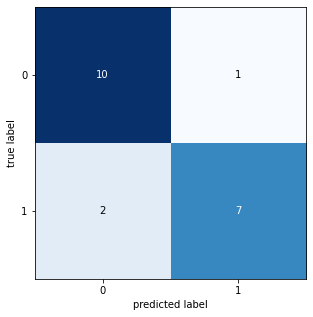

Train : [ 0  1  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 21 22 23 24 26
 28 29 32 33 34 35 36 38 40 41 42 43 44 45 46 48 49 50 51 52 53 54 55 56
 57 59 60 62 65 66 67 68 69 71 74 76 77 78 79 80 81 82 83 84 85 86 87 88
 90 91 92 93 94 96] Test : [ 2 20 25 27 30 31 37 39 47 58 61 63 64 70 72 73 75 89 95]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0]
Akurasi :  0.7894736842105263
F1_Score :  0.788888888888889
              precision    recall  f1-score   support

           0       0.80      0.80      0.80        10
           1       0.78      0.78      0.78         9

    accuracy                           0.79        19
   macro avg       0.79      0.79      0.79        19
weighted avg       0.79      0.79      0.79        19



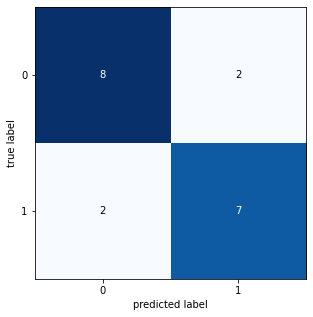

Train : [ 1  2  5  6  7  8  9 10 11 12 13 14 17 18 20 21 22 23 24 25 27 28 29 30
 31 32 33 34 35 36 37 39 40 41 42 43 44 45 47 49 50 52 53 56 57 58 59 61
 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 78 79 82 83 84 85 87 89 90
 91 92 93 94 95 96] Test : [ 0  3  4 15 16 19 26 38 46 48 51 54 55 60 77 80 81 86 88]
Y_Train : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 1 0 0 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Akurasi :  0.7894736842105263
F1_Score :  0.784090909090909
              precision    recall  f1-score   support

           0       1.00      0.60      0.75        10
           1       0.69      1.00      0.82         9

    accuracy                           0.79        19
   macro avg       0.85      0.80      0.78        19
weighted avg       0.85      0.79      0.78        19



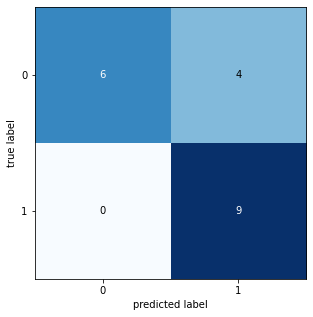

Train : [ 0  1  2  3  4  6  7  9 10 11 12 13 15 16 17 18 19 20 24 25 26 27 28 29
 30 31 32 33 34 36 37 38 39 40 41 44 46 47 48 49 50 51 52 54 55 56 57 58
 59 60 61 62 63 64 66 67 68 70 71 72 73 74 75 77 78 79 80 81 83 84 86 87
 88 89 93 94 95 96] Test : [ 5  8 14 21 22 23 35 42 43 45 53 65 69 76 82 85 90 91 92]
Y_Train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0]
Akurasi :  0.8947368421052632
F1_Score :  0.8944444444444444
              precision    recall  f1-score   support

           0       0.90      0.90      0.90        10
           1       0.89      0.89      0.89         9

    accuracy                           0.89        19
   macro avg       0.89      0.89      0.89        19
weighted avg       0.89      0.89      0.89        19



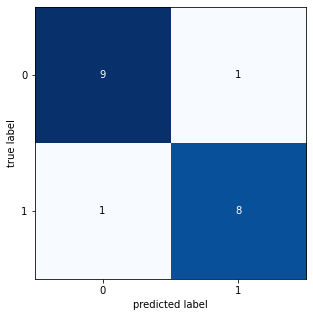

avg accuraccy Breast Cancer =  0.8247368421052631
avg F1_Score Breast Cancer =  0.822390270996409
max accuraccy Breast Cancer =  0.8947368421052632
max F1_Score Breast Cancer =  0.8944444444444444
min accuraccy Breast Cancer =  0.7894736842105263
min F1_Score Breast Cancer =  0.784090909090909
Running Time:  38.042453214999114
gene : [1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1]
Train : [ 0  1  2  3  4  5  6  8 12 13 14 15 16 18 19 20 21 22 23 24 25 26 27 29
 30 31 32 33 35 37 38 39 40 41 42 43 45 46 47 48 50 51 53 54 55 58 60 61
 63 64 65 67 68 69 70 71 72 73 75 76 77 78 79 80 81 82 85 86 87 88 89 90
 91 92 93 94 95] Test : [ 7  9 10 11 17 28 34 36 44 49 52 56 57 59 62 66 74 83 84 96]
Y_Train : [1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1

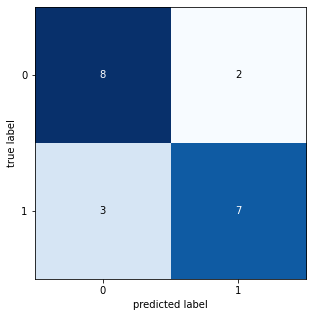

Train : [ 0  2  3  4  5  7  8  9 10 11 14 15 16 17 19 20 21 22 23 25 26 27 28 30
 31 34 35 36 37 38 39 42 43 44 45 46 47 48 49 51 52 53 54 55 56 57 58 59
 60 61 62 63 64 65 66 69 70 72 73 74 75 76 77 80 81 82 83 84 85 86 88 89
 90 91 92 95 96] Test : [ 1  6 12 13 18 24 29 32 33 40 41 50 67 68 71 78 79 87 93 94]
Y_Train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0]
Y_Test : [1 1 0 0 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Akurasi :  0.9
F1_Score :  0.9
              precision    recall  f1-score   support

           0       1.00      0.82      0.90        11
           1       0.82      1.00      0.90         9

    accuracy                           0.90        20
   macro avg       0.91      0.91      0.90        20
weighted avg       0.92      0.90      0.90        20



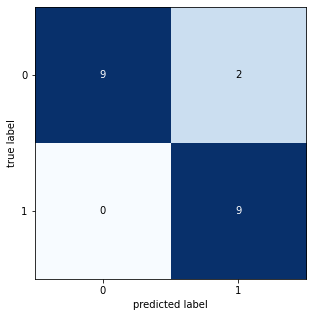

Train : [ 0  1  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 21 22 23 24 26
 28 29 32 33 34 35 36 38 40 41 42 43 44 45 46 48 49 50 51 52 53 54 55 56
 57 59 60 62 65 66 67 68 69 71 74 76 77 78 79 80 81 82 83 84 85 86 87 88
 90 91 92 93 94 96] Test : [ 2 20 25 27 30 31 37 39 47 58 61 63 64 70 72 73 75 89 95]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0]
Akurasi :  0.7894736842105263
F1_Score :  0.788888888888889
              precision    recall  f1-score   support

           0       0.80      0.80      0.80        10
           1       0.78      0.78      0.78         9

    accuracy                           0.79        19
   macro avg       0.79      0.79      0.79        19
weighted avg       0.79      0.79      0.79        19



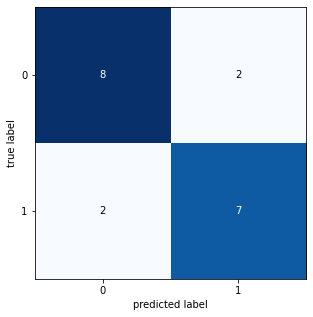

Train : [ 1  2  5  6  7  8  9 10 11 12 13 14 17 18 20 21 22 23 24 25 27 28 29 30
 31 32 33 34 35 36 37 39 40 41 42 43 44 45 47 49 50 52 53 56 57 58 59 61
 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 78 79 82 83 84 85 87 89 90
 91 92 93 94 95 96] Test : [ 0  3  4 15 16 19 26 38 46 48 51 54 55 60 77 80 81 86 88]
Y_Train : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 1 0 0 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Akurasi :  0.6842105263157895
F1_Score :  0.6761363636363638
              precision    recall  f1-score   support

           0       0.83      0.50      0.62        10
           1       0.62      0.89      0.73         9

    accuracy                           0.68        19
   macro avg       0.72      0.69      0.68        19
weighted avg       0.73      0.68      0.67        19



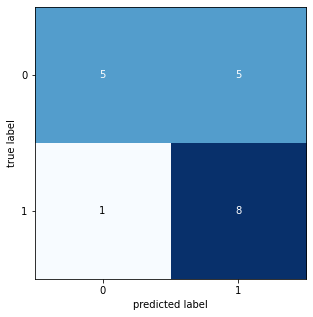

Train : [ 0  1  2  3  4  6  7  9 10 11 12 13 15 16 17 18 19 20 24 25 26 27 28 29
 30 31 32 33 34 36 37 38 39 40 41 44 46 47 48 49 50 51 52 54 55 56 57 58
 59 60 61 62 63 64 66 67 68 70 71 72 73 74 75 77 78 79 80 81 83 84 86 87
 88 89 93 94 95 96] Test : [ 5  8 14 21 22 23 35 42 43 45 53 65 69 76 82 85 90 91 92]
Y_Train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0]
Akurasi :  0.8421052631578947
F1_Score :  0.8421052631578948
              precision    recall  f1-score   support

           0       0.89      0.80      0.84        10
           1       0.80      0.89      0.84         9

    accuracy                           0.84        19
   macro avg       0.84      0.84      0.84        19
weighted avg       0.85      0.84      0.84        19



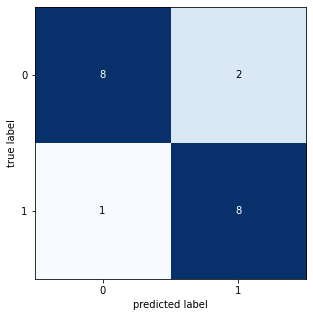

avg accuraccy Breast Cancer =  0.7931578947368421
avg F1_Score Breast Cancer =  0.7913007898534216
max accuraccy Breast Cancer =  0.9
max F1_Score Breast Cancer =  0.9
min accuraccy Breast Cancer =  0.6842105263157895
min F1_Score Breast Cancer =  0.6761363636363638
Running Time:  40.43937577699762
gene : [0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1]
Train : [ 0  1  2  3  4  5  6  8 12 13 14 15 16 18 19 20 21 22 23 24 25 26 27 29
 30 31 32 33 35 37 38 39 40 41 42 43 45 46 47 48 50 51 53 54 55 58 60 61
 63 64 65 67 68 69 70 71 72 73 75 76 77 78 79 80 81 82 85 86 87 88 89 90
 91 92 93 94 95] Test : [ 7  9 10 11 17 28 34 36 44 49 52 56 57 59 62 66 74 83 84 96]
Y_Train : [1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 

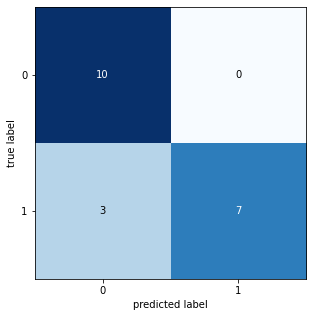

Train : [ 0  2  3  4  5  7  8  9 10 11 14 15 16 17 19 20 21 22 23 25 26 27 28 30
 31 34 35 36 37 38 39 42 43 44 45 46 47 48 49 51 52 53 54 55 56 57 58 59
 60 61 62 63 64 65 66 69 70 72 73 74 75 76 77 80 81 82 83 84 85 86 88 89
 90 91 92 95 96] Test : [ 1  6 12 13 18 24 29 32 33 40 41 50 67 68 71 78 79 87 93 94]
Y_Train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0]
Y_Test : [1 1 0 0 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Akurasi :  0.8
F1_Score :  0.7999999999999999
              precision    recall  f1-score   support

           0       0.89      0.73      0.80        11
           1       0.73      0.89      0.80         9

    accuracy                           0.80        20
   macro avg       0.81      0.81      0.80        20
weighted avg       0.82      0.80      0.80        20



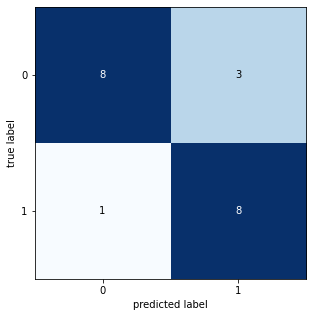

Train : [ 0  1  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 21 22 23 24 26
 28 29 32 33 34 35 36 38 40 41 42 43 44 45 46 48 49 50 51 52 53 54 55 56
 57 59 60 62 65 66 67 68 69 71 74 76 77 78 79 80 81 82 83 84 85 86 87 88
 90 91 92 93 94 96] Test : [ 2 20 25 27 30 31 37 39 47 58 61 63 64 70 72 73 75 89 95]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0]
Akurasi :  0.7894736842105263
F1_Score :  0.788888888888889
              precision    recall  f1-score   support

           0       0.80      0.80      0.80        10
           1       0.78      0.78      0.78         9

    accuracy                           0.79        19
   macro avg       0.79      0.79      0.79        19
weighted avg       0.79      0.79      0.79        19



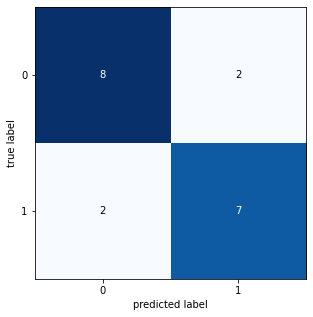

Train : [ 1  2  5  6  7  8  9 10 11 12 13 14 17 18 20 21 22 23 24 25 27 28 29 30
 31 32 33 34 35 36 37 39 40 41 42 43 44 45 47 49 50 52 53 56 57 58 59 61
 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 78 79 82 83 84 85 87 89 90
 91 92 93 94 95 96] Test : [ 0  3  4 15 16 19 26 38 46 48 51 54 55 60 77 80 81 86 88]
Y_Train : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 1 0 0 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Akurasi :  0.7368421052631579
F1_Score :  0.7338935574229692
              precision    recall  f1-score   support

           0       0.86      0.60      0.71        10
           1       0.67      0.89      0.76         9

    accuracy                           0.74        19
   macro avg       0.76      0.74      0.73        19
weighted avg       0.77      0.74      0.73        19



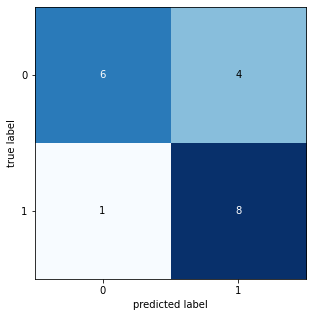

Train : [ 0  1  2  3  4  6  7  9 10 11 12 13 15 16 17 18 19 20 24 25 26 27 28 29
 30 31 32 33 34 36 37 38 39 40 41 44 46 47 48 49 50 51 52 54 55 56 57 58
 59 60 61 62 63 64 66 67 68 70 71 72 73 74 75 77 78 79 80 81 83 84 86 87
 88 89 93 94 95 96] Test : [ 5  8 14 21 22 23 35 42 43 45 53 65 69 76 82 85 90 91 92]
Y_Train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0]
Akurasi :  0.7894736842105263
F1_Score :  0.788888888888889
              precision    recall  f1-score   support

           0       0.80      0.80      0.80        10
           1       0.78      0.78      0.78         9

    accuracy                           0.79        19
   macro avg       0.79      0.79      0.79        19
weighted avg       0.79      0.79      0.79        19



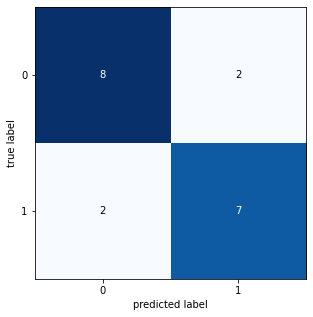

avg accuraccy Breast Cancer =  0.7931578947368421
avg F1_Score Breast Cancer =  0.7916437299557504
max accuraccy Breast Cancer =  0.85
max F1_Score Breast Cancer =  0.8465473145780051
min accuraccy Breast Cancer =  0.7368421052631579
min F1_Score Breast Cancer =  0.7338935574229692
Running Time:  42.42463569199754
gene : [1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1]
Train : [ 0  1  2  3  4  5  6  8 12 13 14 15 16 18 19 20 21 22 23 24 25 26 27 29
 30 31 32 33 35 37 38 39 40 41 42 43 45 46 47 48 50 51 53 54 55 58 60 61
 63 64 65 67 68 69 70 71 72 73 75 76 77 78 79 80 81 82 85 86 87 88 89 90
 91 92 93 94 95] Test : [ 7  9 10 11 17 28 34 36 44 49 52 56 57 59 62 66 74 83 84 96]
Y_Train : [1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 

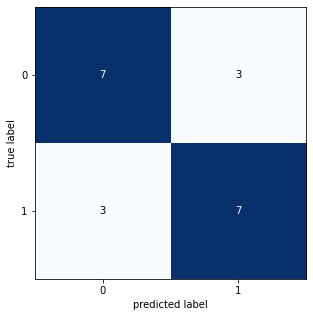

Train : [ 0  2  3  4  5  7  8  9 10 11 14 15 16 17 19 20 21 22 23 25 26 27 28 30
 31 34 35 36 37 38 39 42 43 44 45 46 47 48 49 51 52 53 54 55 56 57 58 59
 60 61 62 63 64 65 66 69 70 72 73 74 75 76 77 80 81 82 83 84 85 86 88 89
 90 91 92 95 96] Test : [ 1  6 12 13 18 24 29 32 33 40 41 50 67 68 71 78 79 87 93 94]
Y_Train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0]
Y_Test : [1 1 0 0 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Akurasi :  0.8
F1_Score :  0.797979797979798
              precision    recall  f1-score   support

           0       0.82      0.82      0.82        11
           1       0.78      0.78      0.78         9

    accuracy                           0.80        20
   macro avg       0.80      0.80      0.80        20
weighted avg       0.80      0.80      0.80        20



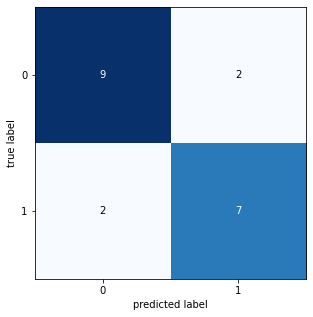

Train : [ 0  1  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 21 22 23 24 26
 28 29 32 33 34 35 36 38 40 41 42 43 44 45 46 48 49 50 51 52 53 54 55 56
 57 59 60 62 65 66 67 68 69 71 74 76 77 78 79 80 81 82 83 84 85 86 87 88
 90 91 92 93 94 96] Test : [ 2 20 25 27 30 31 37 39 47 58 61 63 64 70 72 73 75 89 95]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0]
Akurasi :  0.7894736842105263
F1_Score :  0.7840909090909092
              precision    recall  f1-score   support

           0       0.75      0.90      0.82        10
           1       0.86      0.67      0.75         9

    accuracy                           0.79        19
   macro avg       0.80      0.78      0.78        19
weighted avg       0.80      0.79      0.79        19



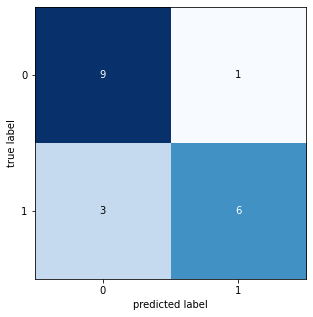

Train : [ 1  2  5  6  7  8  9 10 11 12 13 14 17 18 20 21 22 23 24 25 27 28 29 30
 31 32 33 34 35 36 37 39 40 41 42 43 44 45 47 49 50 52 53 56 57 58 59 61
 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 78 79 82 83 84 85 87 89 90
 91 92 93 94 95 96] Test : [ 0  3  4 15 16 19 26 38 46 48 51 54 55 60 77 80 81 86 88]
Y_Train : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 1 0 0 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Akurasi :  0.7894736842105263
F1_Score :  0.784090909090909
              precision    recall  f1-score   support

           0       1.00      0.60      0.75        10
           1       0.69      1.00      0.82         9

    accuracy                           0.79        19
   macro avg       0.85      0.80      0.78        19
weighted avg       0.85      0.79      0.78        19



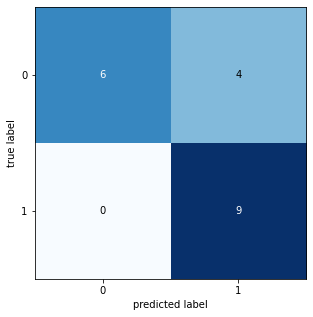

Train : [ 0  1  2  3  4  6  7  9 10 11 12 13 15 16 17 18 19 20 24 25 26 27 28 29
 30 31 32 33 34 36 37 38 39 40 41 44 46 47 48 49 50 51 52 54 55 56 57 58
 59 60 61 62 63 64 66 67 68 70 71 72 73 74 75 77 78 79 80 81 83 84 86 87
 88 89 93 94 95 96] Test : [ 5  8 14 21 22 23 35 42 43 45 53 65 69 76 82 85 90 91 92]
Y_Train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0]
Akurasi :  0.7894736842105263
F1_Score :  0.7888888888888888
              precision    recall  f1-score   support

           0       0.88      0.70      0.78        10
           1       0.73      0.89      0.80         9

    accuracy                           0.79        19
   macro avg       0.80      0.79      0.79        19
weighted avg       0.81      0.79      0.79        19



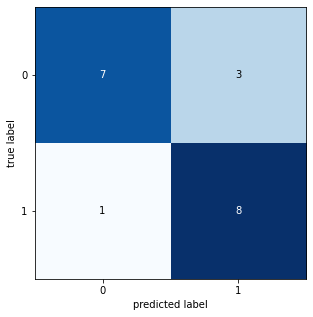

avg accuraccy Breast Cancer =  0.773684210526316
avg F1_Score Breast Cancer =  0.7710101010101009
max accuraccy Breast Cancer =  0.8
max F1_Score Breast Cancer =  0.797979797979798
min accuraccy Breast Cancer =  0.7
min F1_Score Breast Cancer =  0.7
Running Time:  40.77686985699984
gene : [0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1]
Train : [ 0  1  2  3  4  5  6  8 12 13 14 15 16 18 19 20 21 22 23 24 25 26 27 29
 30 31 32 33 35 37 38 39 40 41 42 43 45 46 47 48 50 51 53 54 55 58 60 61
 63 64 65 67 68 69 70 71 72 73 75 76 77 78 79 80 81 82 85 86 87 88 89 90
 91 92 93 94 95] Test : [ 7  9 10 11 17 28 34 36 44 49 52 56 57 59 62 66 74 83 84 96]
Y_Train : [1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 

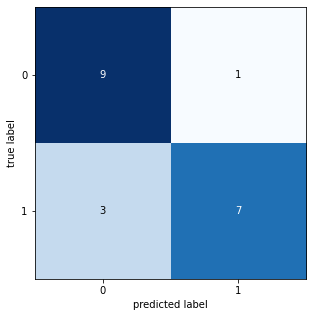

Train : [ 0  2  3  4  5  7  8  9 10 11 14 15 16 17 19 20 21 22 23 25 26 27 28 30
 31 34 35 36 37 38 39 42 43 44 45 46 47 48 49 51 52 53 54 55 56 57 58 59
 60 61 62 63 64 65 66 69 70 72 73 74 75 76 77 80 81 82 83 84 85 86 88 89
 90 91 92 95 96] Test : [ 1  6 12 13 18 24 29 32 33 40 41 50 67 68 71 78 79 87 93 94]
Y_Train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0]
Y_Test : [1 1 0 0 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Akurasi :  0.9
F1_Score :  0.898989898989899
              precision    recall  f1-score   support

           0       0.91      0.91      0.91        11
           1       0.89      0.89      0.89         9

    accuracy                           0.90        20
   macro avg       0.90      0.90      0.90        20
weighted avg       0.90      0.90      0.90        20



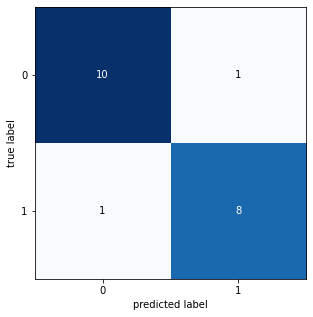

Train : [ 0  1  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 21 22 23 24 26
 28 29 32 33 34 35 36 38 40 41 42 43 44 45 46 48 49 50 51 52 53 54 55 56
 57 59 60 62 65 66 67 68 69 71 74 76 77 78 79 80 81 82 83 84 85 86 87 88
 90 91 92 93 94 96] Test : [ 2 20 25 27 30 31 37 39 47 58 61 63 64 70 72 73 75 89 95]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0]
Akurasi :  0.8421052631578947
F1_Score :  0.8421052631578948
              precision    recall  f1-score   support

           0       0.89      0.80      0.84        10
           1       0.80      0.89      0.84         9

    accuracy                           0.84        19
   macro avg       0.84      0.84      0.84        19
weighted avg       0.85      0.84      0.84        19



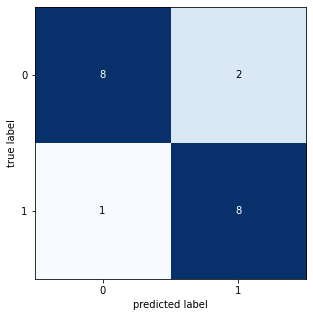

Train : [ 1  2  5  6  7  8  9 10 11 12 13 14 17 18 20 21 22 23 24 25 27 28 29 30
 31 32 33 34 35 36 37 39 40 41 42 43 44 45 47 49 50 52 53 56 57 58 59 61
 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 78 79 82 83 84 85 87 89 90
 91 92 93 94 95 96] Test : [ 0  3  4 15 16 19 26 38 46 48 51 54 55 60 77 80 81 86 88]
Y_Train : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 1 0 0 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Akurasi :  0.7368421052631579
F1_Score :  0.7368421052631577
              precision    recall  f1-score   support

           0       0.78      0.70      0.74        10
           1       0.70      0.78      0.74         9

    accuracy                           0.74        19
   macro avg       0.74      0.74      0.74        19
weighted avg       0.74      0.74      0.74        19



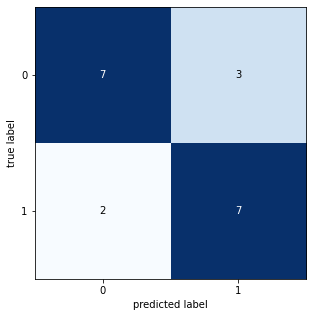

Train : [ 0  1  2  3  4  6  7  9 10 11 12 13 15 16 17 18 19 20 24 25 26 27 28 29
 30 31 32 33 34 36 37 38 39 40 41 44 46 47 48 49 50 51 52 54 55 56 57 58
 59 60 61 62 63 64 66 67 68 70 71 72 73 74 75 77 78 79 80 81 83 84 86 87
 88 89 93 94 95 96] Test : [ 5  8 14 21 22 23 35 42 43 45 53 65 69 76 82 85 90 91 92]
Y_Train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0]
Akurasi :  0.7368421052631579
F1_Score :  0.7368421052631577
              precision    recall  f1-score   support

           0       0.78      0.70      0.74        10
           1       0.70      0.78      0.74         9

    accuracy                           0.74        19
   macro avg       0.74      0.74      0.74        19
weighted avg       0.74      0.74      0.74        19



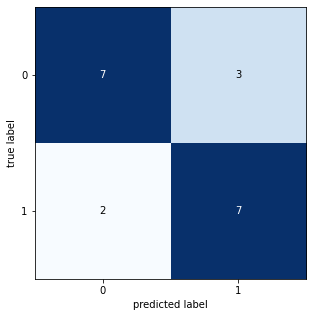

avg accuraccy Breast Cancer =  0.8031578947368422
avg F1_Score Breast Cancer =  0.8025518341307813
max accuraccy Breast Cancer =  0.9
max F1_Score Breast Cancer =  0.898989898989899
min accuraccy Breast Cancer =  0.7368421052631579
min F1_Score Breast Cancer =  0.7368421052631577
Running Time:  38.45214356100041
gene : [1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1]
Train : [ 0  1  2  3  4  5  6  8 12 13 14 15 16 18 19 20 21 22 23 24 25 26 27 29
 30 31 32 33 35 37 38 39 40 41 42 43 45 46 47 48 50 51 53 54 55 58 60 61
 63 64 65 67 68 69 70 71 72 73 75 76 77 78 79 80 81 82 85 86 87 88 89 90
 91 92 93 94 95] Test : [ 7  9 10 11 17 28 34 36 44 49 52 56 57 59 62 66 74 83 84 96]
Y_Train : [1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 

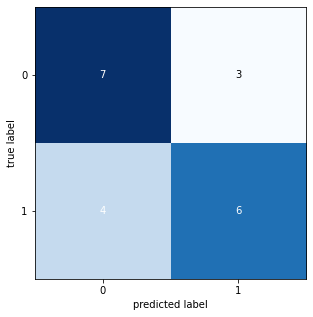

Train : [ 0  2  3  4  5  7  8  9 10 11 14 15 16 17 19 20 21 22 23 25 26 27 28 30
 31 34 35 36 37 38 39 42 43 44 45 46 47 48 49 51 52 53 54 55 56 57 58 59
 60 61 62 63 64 65 66 69 70 72 73 74 75 76 77 80 81 82 83 84 85 86 88 89
 90 91 92 95 96] Test : [ 1  6 12 13 18 24 29 32 33 40 41 50 67 68 71 78 79 87 93 94]
Y_Train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0]
Y_Test : [1 1 0 0 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Akurasi :  0.75
F1_Score :  0.7493734335839599
              precision    recall  f1-score   support

           0       0.80      0.73      0.76        11
           1       0.70      0.78      0.74         9

    accuracy                           0.75        20
   macro avg       0.75      0.75      0.75        20
weighted avg       0.76      0.75      0.75        20



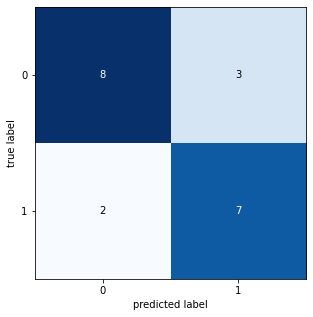

Train : [ 0  1  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 21 22 23 24 26
 28 29 32 33 34 35 36 38 40 41 42 43 44 45 46 48 49 50 51 52 53 54 55 56
 57 59 60 62 65 66 67 68 69 71 74 76 77 78 79 80 81 82 83 84 85 86 87 88
 90 91 92 93 94 96] Test : [ 2 20 25 27 30 31 37 39 47 58 61 63 64 70 72 73 75 89 95]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0]
Akurasi :  0.7894736842105263
F1_Score :  0.788888888888889
              precision    recall  f1-score   support

           0       0.80      0.80      0.80        10
           1       0.78      0.78      0.78         9

    accuracy                           0.79        19
   macro avg       0.79      0.79      0.79        19
weighted avg       0.79      0.79      0.79        19



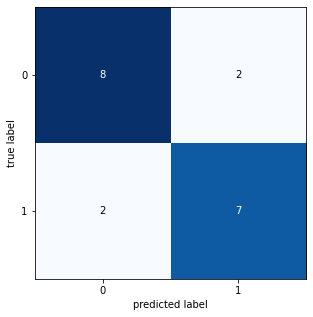

Train : [ 1  2  5  6  7  8  9 10 11 12 13 14 17 18 20 21 22 23 24 25 27 28 29 30
 31 32 33 34 35 36 37 39 40 41 42 43 44 45 47 49 50 52 53 56 57 58 59 61
 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 78 79 82 83 84 85 87 89 90
 91 92 93 94 95 96] Test : [ 0  3  4 15 16 19 26 38 46 48 51 54 55 60 77 80 81 86 88]
Y_Train : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 1 0 0 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Akurasi :  0.7894736842105263
F1_Score :  0.784090909090909
              precision    recall  f1-score   support

           0       1.00      0.60      0.75        10
           1       0.69      1.00      0.82         9

    accuracy                           0.79        19
   macro avg       0.85      0.80      0.78        19
weighted avg       0.85      0.79      0.78        19



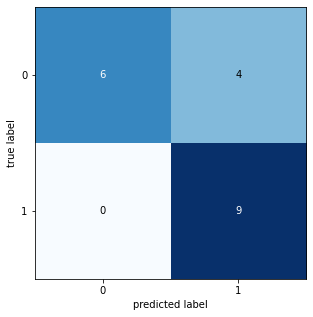

Train : [ 0  1  2  3  4  6  7  9 10 11 12 13 15 16 17 18 19 20 24 25 26 27 28 29
 30 31 32 33 34 36 37 38 39 40 41 44 46 47 48 49 50 51 52 54 55 56 57 58
 59 60 61 62 63 64 66 67 68 70 71 72 73 74 75 77 78 79 80 81 83 84 86 87
 88 89 93 94 95 96] Test : [ 5  8 14 21 22 23 35 42 43 45 53 65 69 76 82 85 90 91 92]
Y_Train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0]
Akurasi :  0.9473684210526315
F1_Score :  0.9473684210526316
              precision    recall  f1-score   support

           0       1.00      0.90      0.95        10
           1       0.90      1.00      0.95         9

    accuracy                           0.95        19
   macro avg       0.95      0.95      0.95        19
weighted avg       0.95      0.95      0.95        19



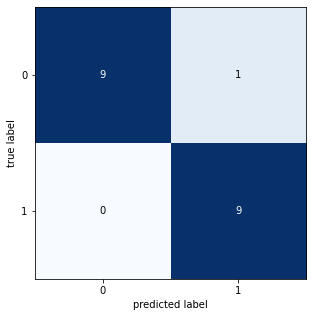

avg accuraccy Breast Cancer =  0.7852631578947368
avg F1_Score Breast Cancer =  0.7837688919267867
max accuraccy Breast Cancer =  0.9473684210526315
max F1_Score Breast Cancer =  0.9473684210526316
min accuraccy Breast Cancer =  0.65
min F1_Score Breast Cancer =  0.6491228070175439
Running Time:  42.67460919500081
gene : [0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1]
Train : [ 0  1  2  3  4  5  6  8 12 13 14 15 16 18 19 20 21 22 23 24 25 26 27 29
 30 31 32 33 35 37 38 39 40 41 42 43 45 46 47 48 50 51 53 54 55 58 60 61
 63 64 65 67 68 69 70 71 72 73 75 76 77 78 79 80 81 82 85 86 87 88 89 90
 91 92 93 94 95] Test : [ 7  9 10 11 17 28 34 36 44 49 52 56 57 59 62 66 74 83 84 96]
Y_Train : [1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 

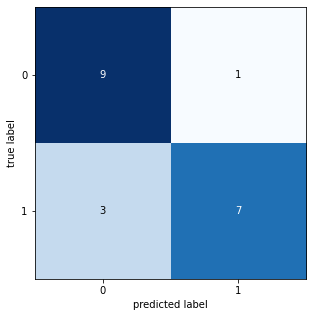

Train : [ 0  2  3  4  5  7  8  9 10 11 14 15 16 17 19 20 21 22 23 25 26 27 28 30
 31 34 35 36 37 38 39 42 43 44 45 46 47 48 49 51 52 53 54 55 56 57 58 59
 60 61 62 63 64 65 66 69 70 72 73 74 75 76 77 80 81 82 83 84 85 86 88 89
 90 91 92 95 96] Test : [ 1  6 12 13 18 24 29 32 33 40 41 50 67 68 71 78 79 87 93 94]
Y_Train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0]
Y_Test : [1 1 0 0 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Akurasi :  0.85
F1_Score :  0.849624060150376
              precision    recall  f1-score   support

           0       0.90      0.82      0.86        11
           1       0.80      0.89      0.84         9

    accuracy                           0.85        20
   macro avg       0.85      0.85      0.85        20
weighted avg       0.86      0.85      0.85        20



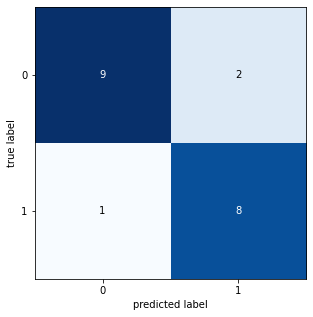

Train : [ 0  1  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 21 22 23 24 26
 28 29 32 33 34 35 36 38 40 41 42 43 44 45 46 48 49 50 51 52 53 54 55 56
 57 59 60 62 65 66 67 68 69 71 74 76 77 78 79 80 81 82 83 84 85 86 87 88
 90 91 92 93 94 96] Test : [ 2 20 25 27 30 31 37 39 47 58 61 63 64 70 72 73 75 89 95]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0]
Akurasi :  0.8421052631578947
F1_Score :  0.8421052631578948
              precision    recall  f1-score   support

           0       0.89      0.80      0.84        10
           1       0.80      0.89      0.84         9

    accuracy                           0.84        19
   macro avg       0.84      0.84      0.84        19
weighted avg       0.85      0.84      0.84        19



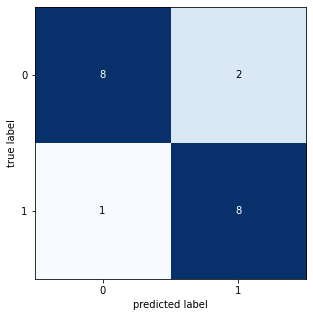

Train : [ 1  2  5  6  7  8  9 10 11 12 13 14 17 18 20 21 22 23 24 25 27 28 29 30
 31 32 33 34 35 36 37 39 40 41 42 43 44 45 47 49 50 52 53 56 57 58 59 61
 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 78 79 82 83 84 85 87 89 90
 91 92 93 94 95 96] Test : [ 0  3  4 15 16 19 26 38 46 48 51 54 55 60 77 80 81 86 88]
Y_Train : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 1 0 0 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Akurasi :  0.7368421052631579
F1_Score :  0.7368421052631577
              precision    recall  f1-score   support

           0       0.78      0.70      0.74        10
           1       0.70      0.78      0.74         9

    accuracy                           0.74        19
   macro avg       0.74      0.74      0.74        19
weighted avg       0.74      0.74      0.74        19



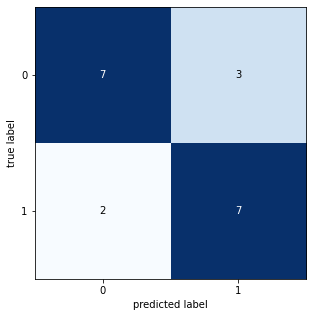

Train : [ 0  1  2  3  4  6  7  9 10 11 12 13 15 16 17 18 19 20 24 25 26 27 28 29
 30 31 32 33 34 36 37 38 39 40 41 44 46 47 48 49 50 51 52 54 55 56 57 58
 59 60 61 62 63 64 66 67 68 70 71 72 73 74 75 77 78 79 80 81 83 84 86 87
 88 89 93 94 95 96] Test : [ 5  8 14 21 22 23 35 42 43 45 53 65 69 76 82 85 90 91 92]
Y_Train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0]
Akurasi :  0.7368421052631579
F1_Score :  0.7368421052631577
              precision    recall  f1-score   support

           0       0.78      0.70      0.74        10
           1       0.70      0.78      0.74         9

    accuracy                           0.74        19
   macro avg       0.74      0.74      0.74        19
weighted avg       0.74      0.74      0.74        19



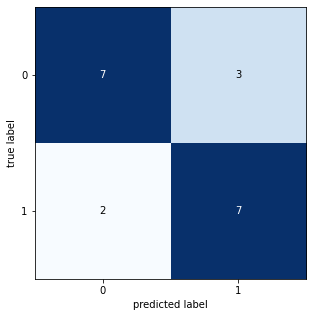

avg accuraccy Breast Cancer =  0.7931578947368421
avg F1_Score Breast Cancer =  0.7926786663628768
max accuraccy Breast Cancer =  0.85
max F1_Score Breast Cancer =  0.849624060150376
min accuraccy Breast Cancer =  0.7368421052631579
min F1_Score Breast Cancer =  0.7368421052631577
Running Time:  40.27526322700214
gene : [1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1]
Train : [ 0  1  2  3  4  5  6  8 12 13 14 15 16 18 19 20 21 22 23 24 25 26 27 29
 30 31 32 33 35 37 38 39 40 41 42 43 45 46 47 48 50 51 53 54 55 58 60 61
 63 64 65 67 68 69 70 71 72 73 75 76 77 78 79 80 81 82 85 86 87 88 89 90
 91 92 93 94 95] Test : [ 7  9 10 11 17 28 34 36 44 49 52 56 57 59 62 66 74 83 84 96]
Y_Train : [1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1

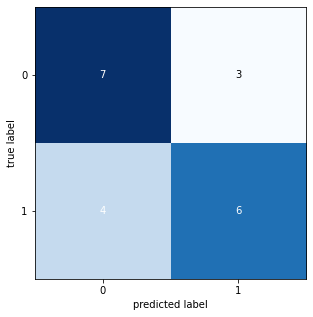

Train : [ 0  2  3  4  5  7  8  9 10 11 14 15 16 17 19 20 21 22 23 25 26 27 28 30
 31 34 35 36 37 38 39 42 43 44 45 46 47 48 49 51 52 53 54 55 56 57 58 59
 60 61 62 63 64 65 66 69 70 72 73 74 75 76 77 80 81 82 83 84 85 86 88 89
 90 91 92 95 96] Test : [ 1  6 12 13 18 24 29 32 33 40 41 50 67 68 71 78 79 87 93 94]
Y_Train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0]
Y_Test : [1 1 0 0 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Akurasi :  0.65
F1_Score :  0.6491228070175439
              precision    recall  f1-score   support

           0       0.70      0.64      0.67        11
           1       0.60      0.67      0.63         9

    accuracy                           0.65        20
   macro avg       0.65      0.65      0.65        20
weighted avg       0.65      0.65      0.65        20



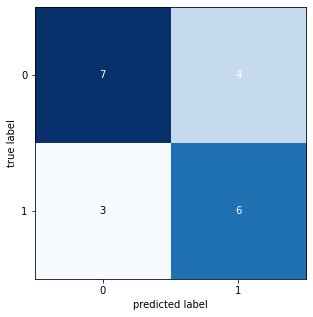

Train : [ 0  1  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 21 22 23 24 26
 28 29 32 33 34 35 36 38 40 41 42 43 44 45 46 48 49 50 51 52 53 54 55 56
 57 59 60 62 65 66 67 68 69 71 74 76 77 78 79 80 81 82 83 84 85 86 87 88
 90 91 92 93 94 96] Test : [ 2 20 25 27 30 31 37 39 47 58 61 63 64 70 72 73 75 89 95]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0]
Akurasi :  0.7894736842105263
F1_Score :  0.788888888888889
              precision    recall  f1-score   support

           0       0.80      0.80      0.80        10
           1       0.78      0.78      0.78         9

    accuracy                           0.79        19
   macro avg       0.79      0.79      0.79        19
weighted avg       0.79      0.79      0.79        19



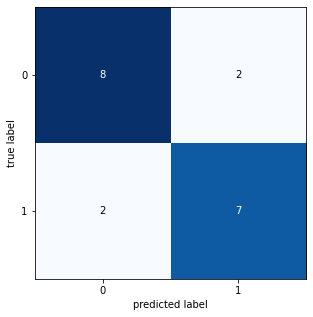

Train : [ 1  2  5  6  7  8  9 10 11 12 13 14 17 18 20 21 22 23 24 25 27 28 29 30
 31 32 33 34 35 36 37 39 40 41 42 43 44 45 47 49 50 52 53 56 57 58 59 61
 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 78 79 82 83 84 85 87 89 90
 91 92 93 94 95 96] Test : [ 0  3  4 15 16 19 26 38 46 48 51 54 55 60 77 80 81 86 88]
Y_Train : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 1 0 0 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Akurasi :  0.7368421052631579
F1_Score :  0.7246376811594203
              precision    recall  f1-score   support

           0       1.00      0.50      0.67        10
           1       0.64      1.00      0.78         9

    accuracy                           0.74        19
   macro avg       0.82      0.75      0.72        19
weighted avg       0.83      0.74      0.72        19



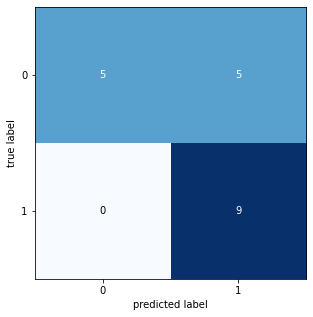

Train : [ 0  1  2  3  4  6  7  9 10 11 12 13 15 16 17 18 19 20 24 25 26 27 28 29
 30 31 32 33 34 36 37 38 39 40 41 44 46 47 48 49 50 51 52 54 55 56 57 58
 59 60 61 62 63 64 66 67 68 70 71 72 73 74 75 77 78 79 80 81 83 84 86 87
 88 89 93 94 95 96] Test : [ 5  8 14 21 22 23 35 42 43 45 53 65 69 76 82 85 90 91 92]
Y_Train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0]
Akurasi :  0.8947368421052632
F1_Score :  0.8944444444444445
              precision    recall  f1-score   support

           0       1.00      0.80      0.89        10
           1       0.82      1.00      0.90         9

    accuracy                           0.89        19
   macro avg       0.91      0.90      0.89        19
weighted avg       0.91      0.89      0.89        19



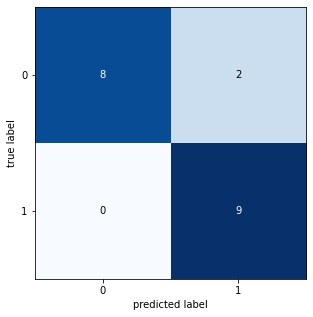

avg accuraccy Breast Cancer =  0.7442105263157895
avg F1_Score Breast Cancer =  0.7412433257055684
max accuraccy Breast Cancer =  0.8947368421052632
max F1_Score Breast Cancer =  0.8944444444444445
min accuraccy Breast Cancer =  0.65
min F1_Score Breast Cancer =  0.6491228070175439
Running Time:  37.66023307700016
gene : [0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1]
Train : [ 0  1  2  3  4  5  6  8 12 13 14 15 16 18 19 20 21 22 23 24 25 26 27 29
 30 31 32 33 35 37 38 39 40 41 42 43 45 46 47 48 50 51 53 54 55 58 60 61
 63 64 65 67 68 69 70 71 72 73 75 76 77 78 79 80 81 82 85 86 87 88 89 90
 91 92 93 94 95] Test : [ 7  9 10 11 17 28 34 36 44 49 52 56 57 59 62 66 74 83 84 96]
Y_Train : [1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 

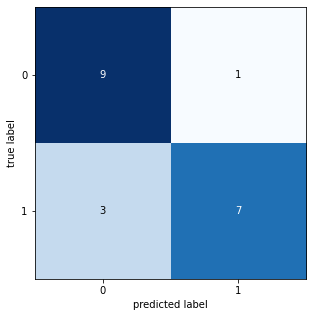

Train : [ 0  2  3  4  5  7  8  9 10 11 14 15 16 17 19 20 21 22 23 25 26 27 28 30
 31 34 35 36 37 38 39 42 43 44 45 46 47 48 49 51 52 53 54 55 56 57 58 59
 60 61 62 63 64 65 66 69 70 72 73 74 75 76 77 80 81 82 83 84 85 86 88 89
 90 91 92 95 96] Test : [ 1  6 12 13 18 24 29 32 33 40 41 50 67 68 71 78 79 87 93 94]
Y_Train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0]
Y_Test : [1 1 0 0 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Akurasi :  0.95
F1_Score :  0.949874686716792
              precision    recall  f1-score   support

           0       1.00      0.91      0.95        11
           1       0.90      1.00      0.95         9

    accuracy                           0.95        20
   macro avg       0.95      0.95      0.95        20
weighted avg       0.96      0.95      0.95        20



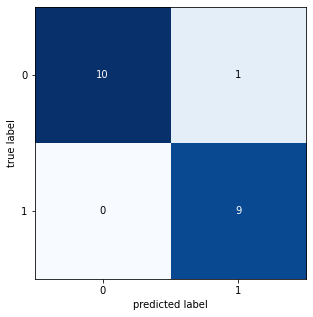

Train : [ 0  1  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 21 22 23 24 26
 28 29 32 33 34 35 36 38 40 41 42 43 44 45 46 48 49 50 51 52 53 54 55 56
 57 59 60 62 65 66 67 68 69 71 74 76 77 78 79 80 81 82 83 84 85 86 87 88
 90 91 92 93 94 96] Test : [ 2 20 25 27 30 31 37 39 47 58 61 63 64 70 72 73 75 89 95]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0]
Akurasi :  0.8421052631578947
F1_Score :  0.8421052631578948
              precision    recall  f1-score   support

           0       0.89      0.80      0.84        10
           1       0.80      0.89      0.84         9

    accuracy                           0.84        19
   macro avg       0.84      0.84      0.84        19
weighted avg       0.85      0.84      0.84        19



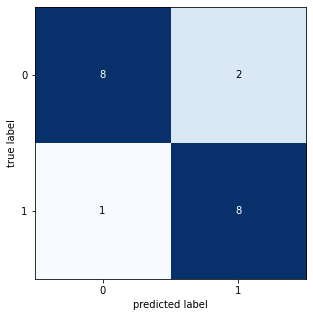

Train : [ 1  2  5  6  7  8  9 10 11 12 13 14 17 18 20 21 22 23 24 25 27 28 29 30
 31 32 33 34 35 36 37 39 40 41 42 43 44 45 47 49 50 52 53 56 57 58 59 61
 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 78 79 82 83 84 85 87 89 90
 91 92 93 94 95 96] Test : [ 0  3  4 15 16 19 26 38 46 48 51 54 55 60 77 80 81 86 88]
Y_Train : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 1 0 0 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Akurasi :  0.7368421052631579
F1_Score :  0.7338935574229692
              precision    recall  f1-score   support

           0       0.86      0.60      0.71        10
           1       0.67      0.89      0.76         9

    accuracy                           0.74        19
   macro avg       0.76      0.74      0.73        19
weighted avg       0.77      0.74      0.73        19



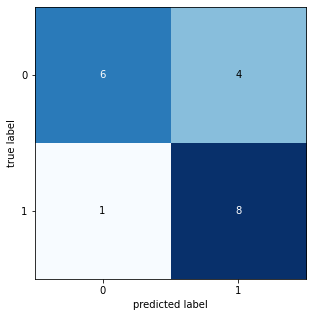

Train : [ 0  1  2  3  4  6  7  9 10 11 12 13 15 16 17 18 19 20 24 25 26 27 28 29
 30 31 32 33 34 36 37 38 39 40 41 44 46 47 48 49 50 51 52 54 55 56 57 58
 59 60 61 62 63 64 66 67 68 70 71 72 73 74 75 77 78 79 80 81 83 84 86 87
 88 89 93 94 95 96] Test : [ 5  8 14 21 22 23 35 42 43 45 53 65 69 76 82 85 90 91 92]
Y_Train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0]
Akurasi :  0.8421052631578947
F1_Score :  0.8421052631578948
              precision    recall  f1-score   support

           0       0.89      0.80      0.84        10
           1       0.80      0.89      0.84         9

    accuracy                           0.84        19
   macro avg       0.84      0.84      0.84        19
weighted avg       0.85      0.84      0.84        19



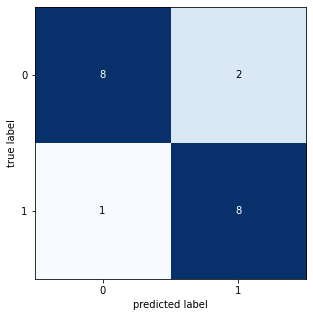

avg accuraccy Breast Cancer =  0.8342105263157894
avg F1_Score Breast Cancer =  0.8331917136870699
max accuraccy Breast Cancer =  0.95
max F1_Score Breast Cancer =  0.949874686716792
min accuraccy Breast Cancer =  0.7368421052631579
min F1_Score Breast Cancer =  0.7338935574229692
Running Time:  39.12207895100073
gene : [1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1]
Train : [ 0  1  2  3  4  5  6  8 12 13 14 15 16 18 19 20 21 22 23 24 25 26 27 29
 30 31 32 33 35 37 38 39 40 41 42 43 45 46 47 48 50 51 53 54 55 58 60 61
 63 64 65 67 68 69 70 71 72 73 75 76 77 78 79 80 81 82 85 86 87 88 89 90
 91 92 93 94 95] Test : [ 7  9 10 11 17 28 34 36 44 49 52 56 57 59 62 66 74 83 84 96]
Y_Train : [1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1

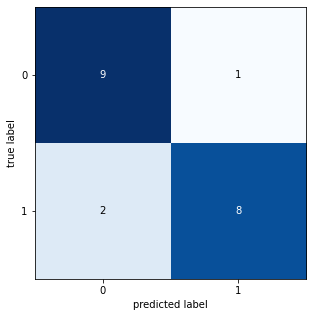

Train : [ 0  2  3  4  5  7  8  9 10 11 14 15 16 17 19 20 21 22 23 25 26 27 28 30
 31 34 35 36 37 38 39 42 43 44 45 46 47 48 49 51 52 53 54 55 56 57 58 59
 60 61 62 63 64 65 66 69 70 72 73 74 75 76 77 80 81 82 83 84 85 86 88 89
 90 91 92 95 96] Test : [ 1  6 12 13 18 24 29 32 33 40 41 50 67 68 71 78 79 87 93 94]
Y_Train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0]
Y_Test : [1 1 0 0 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Akurasi :  0.9
F1_Score :  0.9
              precision    recall  f1-score   support

           0       1.00      0.82      0.90        11
           1       0.82      1.00      0.90         9

    accuracy                           0.90        20
   macro avg       0.91      0.91      0.90        20
weighted avg       0.92      0.90      0.90        20



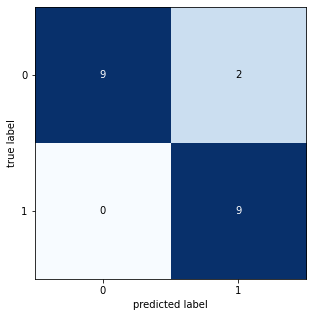

Train : [ 0  1  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 21 22 23 24 26
 28 29 32 33 34 35 36 38 40 41 42 43 44 45 46 48 49 50 51 52 53 54 55 56
 57 59 60 62 65 66 67 68 69 71 74 76 77 78 79 80 81 82 83 84 85 86 87 88
 90 91 92 93 94 96] Test : [ 2 20 25 27 30 31 37 39 47 58 61 63 64 70 72 73 75 89 95]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0]
Akurasi :  0.8421052631578947
F1_Score :  0.8403361344537816
              precision    recall  f1-score   support

           0       0.82      0.90      0.86        10
           1       0.88      0.78      0.82         9

    accuracy                           0.84        19
   macro avg       0.85      0.84      0.84        19
weighted avg       0.85      0.84      0.84        19



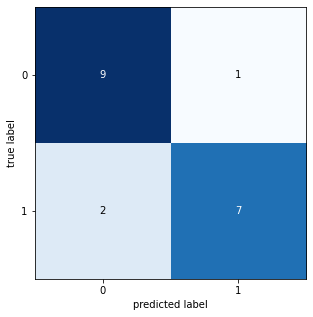

Train : [ 1  2  5  6  7  8  9 10 11 12 13 14 17 18 20 21 22 23 24 25 27 28 29 30
 31 32 33 34 35 36 37 39 40 41 42 43 44 45 47 49 50 52 53 56 57 58 59 61
 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 78 79 82 83 84 85 87 89 90
 91 92 93 94 95 96] Test : [ 0  3  4 15 16 19 26 38 46 48 51 54 55 60 77 80 81 86 88]
Y_Train : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 1 0 0 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Akurasi :  0.7368421052631579
F1_Score :  0.7246376811594203
              precision    recall  f1-score   support

           0       1.00      0.50      0.67        10
           1       0.64      1.00      0.78         9

    accuracy                           0.74        19
   macro avg       0.82      0.75      0.72        19
weighted avg       0.83      0.74      0.72        19



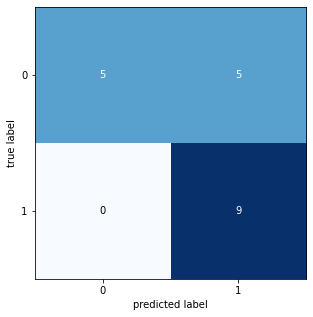

Train : [ 0  1  2  3  4  6  7  9 10 11 12 13 15 16 17 18 19 20 24 25 26 27 28 29
 30 31 32 33 34 36 37 38 39 40 41 44 46 47 48 49 50 51 52 54 55 56 57 58
 59 60 61 62 63 64 66 67 68 70 71 72 73 74 75 77 78 79 80 81 83 84 86 87
 88 89 93 94 95 96] Test : [ 5  8 14 21 22 23 35 42 43 45 53 65 69 76 82 85 90 91 92]
Y_Train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0]
Akurasi :  0.8421052631578947
F1_Score :  0.8421052631578948
              precision    recall  f1-score   support

           0       0.89      0.80      0.84        10
           1       0.80      0.89      0.84         9

    accuracy                           0.84        19
   macro avg       0.84      0.84      0.84        19
weighted avg       0.85      0.84      0.84        19



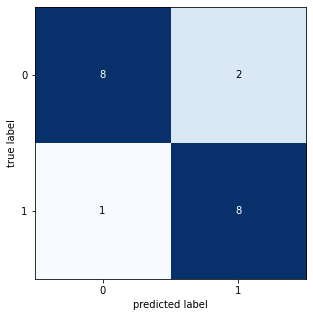

avg accuraccy Breast Cancer =  0.8342105263157894
avg F1_Score Breast Cancer =  0.8313406277842945
max accuraccy Breast Cancer =  0.9
max F1_Score Breast Cancer =  0.9
min accuraccy Breast Cancer =  0.7368421052631579
min F1_Score Breast Cancer =  0.7246376811594203
Running Time:  43.0647324499987
gen terbaik : [0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1]
F-1 Score terbaik : 0.8441907799802537  || Akurasi terbaik : 0.8447368421052632  || jumlah fitur : 53

Running Time:  2017.4914151750017


In [15]:
Breast_IG_GA = GeneticAlgorithm(Breast_IG, 4)